In [1]:
from keras.models import Sequential, Model
from keras.layers.core import Flatten, Dense, Dropout
from keras.layers.convolutional import Conv2D, MaxPooling2D, ZeroPadding2D, Deconvolution2D, UpSampling2D
from keras.optimizers import SGD, Adam
from keras.preprocessing.image import ImageDataGenerator
from keras import objectives
from keras.layers import merge, Conv2D, MaxPooling2D, Input, core
from keras.utils.layer_utils import print_summary
from keras.utils import np_utils
import numpy as np
from PIL import Image
from os import listdir
from os.path import isfile, join
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import timeit
from sklearn.metrics import confusion_matrix
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.datasets import make_classification
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import precision_recall_fscore_support
from sklearn.ensemble import RandomForestClassifier
#from sklearn.ensemble import RandomForest
from sklearn.cross_validation import cross_val_score
from scipy.misc import imresize
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization
from sklearn import cross_validation
from keras.callbacks import ModelCheckpoint
#from sklearn.model_selection import StratifiedKFold
import numpy
import random
import h5py
%matplotlib inline

from keras.backend import image_dim_ordering, set_image_dim_ordering

# Image dimensions ordering should follow the Theano convention
if image_dim_ordering() != 'th':
    set_image_dim_ordering('th')

Using TensorFlow backend.


/home/deeplearningutp/anaconda3/envs/tensorflow-utp/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/home/deeplearningutp/anaconda3/envs/tensorflow-utp/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


/home/deeplearningutp/anaconda3/envs/tensorflow-utp/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
#Load the data
hdf5_path = './dataset/Cropped_BM3D/Cropped_BM3D_3.hdf5'

h5f = h5py.File(hdf5_path,'r')

all_input_3D = h5f['img'][:]

h5f.close()

#Testing the results with one-patient-leave-one

In [3]:
#Create the labels (One-Hot Encoding)
label_0=np.concatenate((np.zeros(1408),np.ones(1408),np.zeros(256),np.ones(256),np.zeros(384),np.ones(384)))
ind=np.concatenate((np.zeros(11),np.ones(11),np.zeros(2),np.ones(2),np.zeros(3),np.ones(3)))


# Use the same weights for initializate all the experiments
path="./dataset/Cropped_BM3D/model_TW.h5"
#path="/home/ojperdomoc/OCT_HES-SO/amd_OCT_224_224.h5"
#path="/home/ojperdomoc/OCT_HES-SO/model_TW.h5"

#Training VGG16 loading weights

In [4]:
# Definiton of the OCT-model with input of 3 x 224 x 224

classes = 2
input = Input(shape=(3, 224, 224))

conv1 = Conv2D(32, 3, activation='relu')(input)
conv2 = Conv2D(32, 3, activation='relu')(conv1)
conv3 = Conv2D(32, 3, activation='relu')(conv2)
pool1 = MaxPooling2D((2, 2), strides=(2, 2))(conv3)
#
conv4 = Conv2D(64, 3, activation='relu')(pool1)
conv5 = Conv2D(64, 3, activation='relu')(conv4)
pool2 = MaxPooling2D((2, 2), strides=(2, 2))(conv5)
#
conv6 = Conv2D(128, 3, activation='relu')(pool2)
conv7 = Conv2D(128, 3, activation='relu')(conv6)
pool3 = MaxPooling2D((2, 2), strides=(2, 2))(conv7)
#
conv8 = Conv2D(256, 3, activation='relu')(pool3)
conv9 = Conv2D(256, 3, activation='relu')(conv8)
conv10 = Conv2D(256, 3, activation='relu')(conv9)
pool4 = MaxPooling2D((2, 2), strides=(2, 2))(conv10)
#
flatten = Flatten()(pool4)
dense1 = Dense(4096, activation='relu')(flatten)
drop1 = Dropout(0.5)(dense1)
dense2 = Dense(1000, activation='relu')(drop1)
drop2 = Dropout(0.5)(dense2)
dense3 = Dense(2, activation='softmax')(drop2)

model1 = Model(inputs=input, outputs=dense3)

rmsprop = optimizers.rmsprop(lr=0.00001)
SGD = optimizers.SGD(lr=0.0001)

model1.compile(loss='categorical_crossentropy', optimizer=SGD, metrics=['accuracy'])
# model1.compile(loss='binary_crossentropy', optimizer=SGD, metrics=['accuracy'])


# model1.load_weights(path) #If you have pretrained weights
model1.save_weights('./dataset/Cropped_BM3D/model_TW.h5')  #If you want to save random weights

print_summary(model1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3, 224, 224)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 222, 222)      896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 220, 220)      9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 218, 218)      9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 109, 109)      0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 64, 107, 107)      18496     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 64, 105, 105)      36928     
__________

In [20]:
# (Pre-)Train the network
pru=[]
qru=[]
model_path = "./dataset/Cropped_BM3D/OCT_NET_Initialized_Weight.hdf5"

for i in range(0, 4096):
    at = all_input_3D_img[i]
    bt = all_input_3D_labels[i]
    pru.append(at)  # Img
    qru.append(bt)  # Labels

X_tr = np.asarray(pru)
Y_tr = np.asarray(qru)

nb_epochs = 100
batch_size = 32

checkpointer = ModelCheckpoint(filepath=model_path, verbose=1, save_best_only=True)
history = model1.fit([X_tr], [Y_tr], batch_size=batch_size, nb_epoch=nb_epochs, verbose=1, callbacks=[checkpointer])
model1.save(model_path)

print("Training complete...")

/home/deeplearningutp/anaconda3/envs/tensorflow-utp/lib/python3.5/site-packages/ipykernel_launcher.py:19: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Epoch 1/100


  32/4096 [..............................] - ETA: 79s - loss: 0.5885 - acc: 0.7188

  64/4096 [..............................] - ETA: 76s - loss: 0.5899 - acc: 0.7188

  96/4096 [..............................] - ETA: 74s - loss: 0.6134 - acc: 0.6771

 128/4096 [..............................] - ETA: 73s - loss: 0.6040 - acc: 0.6875

 160/4096 [>.............................] - ETA: 72s - loss: 0.5949 - acc: 0.7000

 192/4096 [>.............................] - ETA: 71s - loss: 0.5876 - acc: 0.6979

 224/4096 [>.............................] - ETA: 71s - loss: 0.5904 - acc: 0.7098

 256/4096 [>.............................] - ETA: 70s - loss: 0.5988 - acc: 0.7031

 288/4096 [=>............................] - ETA: 69s - loss: 0.6036 - acc: 0.6875

 320/4096 [=>............................] - ETA: 69s - loss: 0.6081 - acc: 0.6781

 352/4096 [=>............................] - ETA: 68s - loss: 0.6123 - acc: 0.6790

 384/4096 [=>............................] - ETA: 67s - loss: 0.6134 - acc: 0.6797

 416/4096 [==>...........................] - ETA: 67s - loss: 0.6159 - acc: 0.6779

 448/4096 [==>...........................] - ETA: 66s - loss: 0.6196 - acc: 0.6696

 480/4096 [==>...........................] - ETA: 66s - loss: 0.6199 - acc: 0.6708

 512/4096 [==>...........................] - ETA: 65s - loss: 0.6221 - acc: 0.6660

 544/4096 [==>...........................] - ETA: 64s - loss: 0.6260 - acc: 0.6636

 576/4096 [===>..........................] - ETA: 64s - loss: 0.6291 - acc: 0.6649

 608/4096 [===>..........................] - ETA: 63s - loss: 0.6315 - acc: 0.6579

 640/4096 [===>..........................] - ETA: 63s - loss: 0.6337 - acc: 0.6531

 672/4096 [===>..........................] - ETA: 62s - loss: 0.6380 - acc: 0.6429

 704/4096 [====>.........................] - ETA: 62s - loss: 0.6361 - acc: 0.6477

 736/4096 [====>.........................] - ETA: 61s - loss: 0.6342 - acc: 0.6508

 768/4096 [====>.........................] - ETA: 60s - loss: 0.6369 - acc: 0.6471

 800/4096 [====>.........................] - ETA: 60s - loss: 0.6355 - acc: 0.6488

 832/4096 [=====>........................] - ETA: 59s - loss: 0.6375 - acc: 0.6454

 864/4096 [=====>........................] - ETA: 59s - loss: 0.6361 - acc: 0.6458

 896/4096 [=====>........................] - ETA: 58s - loss: 0.6341 - acc: 0.6484

 928/4096 [=====>........................] - ETA: 57s - loss: 0.6330 - acc: 0.6498

 960/4096 [======>.......................] - ETA: 57s - loss: 0.6314 - acc: 0.6510

 992/4096 [======>.......................] - ETA: 56s - loss: 0.6309 - acc: 0.6512

1024/4096 [======>.......................] - ETA: 56s - loss: 0.6305 - acc: 0.6514

1056/4096 [======>.......................] - ETA: 55s - loss: 0.6299 - acc: 0.6525

1088/4096 [======>.......................] - ETA: 55s - loss: 0.6312 - acc: 0.6507

1120/4096 [=======>......................] - ETA: 54s - loss: 0.6323 - acc: 0.6527

1152/4096 [=======>......................] - ETA: 53s - loss: 0.6321 - acc: 0.6536

1184/4096 [=======>......................] - ETA: 53s - loss: 0.6348 - acc: 0.6512

1216/4096 [=======>......................] - ETA: 52s - loss: 0.6346 - acc: 0.6513

1248/4096 [========>.....................] - ETA: 52s - loss: 0.6332 - acc: 0.6514

1280/4096 [========>.....................] - ETA: 51s - loss: 0.6336 - acc: 0.6508

1312/4096 [========>.....................] - ETA: 50s - loss: 0.6326 - acc: 0.6524

1344/4096 [========>.....................] - ETA: 50s - loss: 0.6354 - acc: 0.6481

1376/4096 [=========>....................] - ETA: 49s - loss: 0.6326 - acc: 0.6512

1408/4096 [=========>....................] - ETA: 49s - loss: 0.6324 - acc: 0.6506

1440/4096 [=========>....................] - ETA: 48s - loss: 0.6325 - acc: 0.6500

1472/4096 [=========>....................] - ETA: 47s - loss: 0.6338 - acc: 0.6481

1504/4096 [==========>...................] - ETA: 47s - loss: 0.6340 - acc: 0.6469

1536/4096 [==========>...................] - ETA: 46s - loss: 0.6353 - acc: 0.6445

1568/4096 [==========>...................] - ETA: 46s - loss: 0.6348 - acc: 0.6467

1600/4096 [==========>...................] - ETA: 45s - loss: 0.6340 - acc: 0.6488

1632/4096 [==========>...................] - ETA: 45s - loss: 0.6339 - acc: 0.6495

1664/4096 [===========>..................] - ETA: 44s - loss: 0.6348 - acc: 0.6496

1696/4096 [===========>..................] - ETA: 43s - loss: 0.6332 - acc: 0.6515

1728/4096 [===========>..................] - ETA: 43s - loss: 0.6316 - acc: 0.6528

1760/4096 [===========>..................] - ETA: 42s - loss: 0.6328 - acc: 0.6506

1792/4096 [============>.................] - ETA: 42s - loss: 0.6327 - acc: 0.6501

1824/4096 [============>.................] - ETA: 41s - loss: 0.6325 - acc: 0.6497

1856/4096 [============>.................] - ETA: 40s - loss: 0.6324 - acc: 0.6487

1888/4096 [============>.................] - ETA: 40s - loss: 0.6320 - acc: 0.6488

1920/4096 [=============>................] - ETA: 39s - loss: 0.6314 - acc: 0.6490

1952/4096 [=============>................] - ETA: 39s - loss: 0.6313 - acc: 0.6496

1984/4096 [=============>................] - ETA: 38s - loss: 0.6315 - acc: 0.6497

2016/4096 [=============>................] - ETA: 38s - loss: 0.6320 - acc: 0.6488

2048/4096 [==============>...............] - ETA: 37s - loss: 0.6302 - acc: 0.6499

2080/4096 [==============>...............] - ETA: 36s - loss: 0.6315 - acc: 0.6476

2112/4096 [==============>...............] - ETA: 36s - loss: 0.6313 - acc: 0.6487

2144/4096 [==============>...............] - ETA: 35s - loss: 0.6300 - acc: 0.6507

2176/4096 [==============>...............] - ETA: 35s - loss: 0.6305 - acc: 0.6503

2208/4096 [===============>..............] - ETA: 34s - loss: 0.6301 - acc: 0.6513

2240/4096 [===============>..............] - ETA: 33s - loss: 0.6307 - acc: 0.6504

2272/4096 [===============>..............] - ETA: 33s - loss: 0.6308 - acc: 0.6505

2304/4096 [===============>..............] - ETA: 32s - loss: 0.6315 - acc: 0.6493

2336/4096 [================>.............] - ETA: 32s - loss: 0.6309 - acc: 0.6507

2368/4096 [================>.............] - ETA: 31s - loss: 0.6322 - acc: 0.6495

2400/4096 [================>.............] - ETA: 31s - loss: 0.6324 - acc: 0.6492

2432/4096 [================>.............] - ETA: 30s - loss: 0.6325 - acc: 0.6493

2464/4096 [=================>............] - ETA: 29s - loss: 0.6317 - acc: 0.6506

2496/4096 [=================>............] - ETA: 29s - loss: 0.6321 - acc: 0.6502

2528/4096 [=================>............] - ETA: 28s - loss: 0.6333 - acc: 0.6479

2560/4096 [=================>............] - ETA: 28s - loss: 0.6337 - acc: 0.6473

2592/4096 [=================>............] - ETA: 27s - loss: 0.6330 - acc: 0.6481

2624/4096 [==================>...........] - ETA: 26s - loss: 0.6343 - acc: 0.6471

2656/4096 [==================>...........] - ETA: 26s - loss: 0.6347 - acc: 0.6453

2688/4096 [==================>...........] - ETA: 25s - loss: 0.6354 - acc: 0.6455

2720/4096 [==================>...........] - ETA: 25s - loss: 0.6350 - acc: 0.6452

2752/4096 [===================>..........] - ETA: 24s - loss: 0.6350 - acc: 0.6446

2784/4096 [===================>..........] - ETA: 24s - loss: 0.6363 - acc: 0.6426

2816/4096 [===================>..........] - ETA: 23s - loss: 0.6374 - acc: 0.6413

2848/4096 [===================>..........] - ETA: 22s - loss: 0.6378 - acc: 0.6404

2880/4096 [====================>.........] - ETA: 22s - loss: 0.6378 - acc: 0.6406

2912/4096 [====================>.........] - ETA: 21s - loss: 0.6374 - acc: 0.6415

2944/4096 [====================>.........] - ETA: 21s - loss: 0.6366 - acc: 0.6427

2976/4096 [====================>.........] - ETA: 20s - loss: 0.6358 - acc: 0.6435

3008/4096 [=====================>........] - ETA: 19s - loss: 0.6356 - acc: 0.6439

3040/4096 [=====================>........] - ETA: 19s - loss: 0.6346 - acc: 0.6454

3072/4096 [=====================>........] - ETA: 18s - loss: 0.6345 - acc: 0.6452

3104/4096 [=====================>........] - ETA: 18s - loss: 0.6348 - acc: 0.6450

3136/4096 [=====================>........] - ETA: 17s - loss: 0.6337 - acc: 0.6464

3168/4096 [======================>.......] - ETA: 16s - loss: 0.6339 - acc: 0.6465

3200/4096 [======================>.......] - ETA: 16s - loss: 0.6331 - acc: 0.6469

3232/4096 [======================>.......] - ETA: 15s - loss: 0.6325 - acc: 0.6482

3264/4096 [======================>.......] - ETA: 15s - loss: 0.6322 - acc: 0.6480

3296/4096 [=======================>......] - ETA: 14s - loss: 0.6325 - acc: 0.6478

3328/4096 [=======================>......] - ETA: 14s - loss: 0.6328 - acc: 0.6478

3360/4096 [=======================>......] - ETA: 13s - loss: 0.6328 - acc: 0.6476

3392/4096 [=======================>......] - ETA: 12s - loss: 0.6328 - acc: 0.6477

3424/4096 [========================>.....] - ETA: 12s - loss: 0.6339 - acc: 0.6466

3456/4096 [========================>.....] - ETA: 11s - loss: 0.6342 - acc: 0.6453

3488/4096 [========================>.....] - ETA: 11s - loss: 0.6342 - acc: 0.6456

3520/4096 [========================>.....] - ETA: 10s - loss: 0.6342 - acc: 0.6457

3552/4096 [=========================>....] - ETA: 9s - loss: 0.6342 - acc: 0.6456 

3584/4096 [=========================>....] - ETA: 9s - loss: 0.6345 - acc: 0.6451

3616/4096 [=========================>....] - ETA: 8s - loss: 0.6344 - acc: 0.6449

3648/4096 [=========================>....] - ETA: 8s - loss: 0.6333 - acc: 0.6461

3680/4096 [=========================>....] - ETA: 7s - loss: 0.6332 - acc: 0.6459

3712/4096 [==========================>...] - ETA: 7s - loss: 0.6332 - acc: 0.6468

3744/4096 [==========================>...] - ETA: 6s - loss: 0.6343 - acc: 0.6453

3776/4096 [==========================>...] - ETA: 5s - loss: 0.6346 - acc: 0.6446

3808/4096 [==========================>...] - ETA: 5s - loss: 0.6349 - acc: 0.6439

3840/4096 [===========================>..] - ETA: 4s - loss: 0.6352 - acc: 0.6438

3872/4096 [===========================>..] - ETA: 4s - loss: 0.6340 - acc: 0.6446

3904/4096 [===========================>..] - ETA: 3s - loss: 0.6343 - acc: 0.6445

3936/4096 [===========================>..] - ETA: 2s - loss: 0.6342 - acc: 0.6448

3968/4096 [============================>.] - ETA: 2s - loss: 0.6339 - acc: 0.6449

4000/4096 [============================>.] - ETA: 1s - loss: 0.6337 - acc: 0.6452

4032/4096 [============================>.] - ETA: 1s - loss: 0.6336 - acc: 0.6448

4064/4096 [============================>.] - ETA: 0s - loss: 0.6331 - acc: 0.6454

4096/4096 [==============================] - 75s - loss: 0.6330 - acc: 0.6458    

/home/deeplearningutp/anaconda3/envs/tensorflow-utp/lib/python3.5/site-packages/keras/callbacks.py:405: RuntimeWarning: Can save best model only with val_loss available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)



Epoch 2/100


  32/4096 [..............................] - ETA: 74s - loss: 0.6138 - acc: 0.7500

  64/4096 [..............................] - ETA: 74s - loss: 0.6227 - acc: 0.7188

  96/4096 [..............................] - ETA: 73s - loss: 0.6140 - acc: 0.6979

 128/4096 [..............................] - ETA: 72s - loss: 0.6345 - acc: 0.6953

 160/4096 [>.............................] - ETA: 72s - loss: 0.6429 - acc: 0.6750

 192/4096 [>.............................] - ETA: 71s - loss: 0.6376 - acc: 0.6667

 224/4096 [>.............................] - ETA: 71s - loss: 0.6291 - acc: 0.6741

 256/4096 [>.............................] - ETA: 70s - loss: 0.6196 - acc: 0.6797

 288/4096 [=>............................] - ETA: 70s - loss: 0.6120 - acc: 0.6806

 320/4096 [=>............................] - ETA: 69s - loss: 0.6166 - acc: 0.6750

 352/4096 [=>............................] - ETA: 68s - loss: 0.6216 - acc: 0.6705

 384/4096 [=>............................] - ETA: 68s - loss: 0.6177 - acc: 0.6693

 416/4096 [==>...........................] - ETA: 67s - loss: 0.6194 - acc: 0.6683

 448/4096 [==>...........................] - ETA: 67s - loss: 0.6251 - acc: 0.6540

 480/4096 [==>...........................] - ETA: 66s - loss: 0.6245 - acc: 0.6521

 512/4096 [==>...........................] - ETA: 65s - loss: 0.6291 - acc: 0.6465

 544/4096 [==>...........................] - ETA: 65s - loss: 0.6285 - acc: 0.6471

 576/4096 [===>..........................] - ETA: 64s - loss: 0.6299 - acc: 0.6441

 608/4096 [===>..........................] - ETA: 64s - loss: 0.6281 - acc: 0.6431

 640/4096 [===>..........................] - ETA: 63s - loss: 0.6283 - acc: 0.6453

 672/4096 [===>..........................] - ETA: 62s - loss: 0.6292 - acc: 0.6443

 704/4096 [====>.........................] - ETA: 62s - loss: 0.6282 - acc: 0.6449

 736/4096 [====>.........................] - ETA: 61s - loss: 0.6275 - acc: 0.6427

 768/4096 [====>.........................] - ETA: 61s - loss: 0.6270 - acc: 0.6432

 800/4096 [====>.........................] - ETA: 60s - loss: 0.6283 - acc: 0.6425

 832/4096 [=====>........................] - ETA: 60s - loss: 0.6283 - acc: 0.6406

 864/4096 [=====>........................] - ETA: 59s - loss: 0.6291 - acc: 0.6412

 896/4096 [=====>........................] - ETA: 58s - loss: 0.6286 - acc: 0.6429

 928/4096 [=====>........................] - ETA: 58s - loss: 0.6269 - acc: 0.6444

 960/4096 [======>.......................] - ETA: 57s - loss: 0.6246 - acc: 0.6469

 992/4096 [======>.......................] - ETA: 57s - loss: 0.6271 - acc: 0.6431

1024/4096 [======>.......................] - ETA: 56s - loss: 0.6275 - acc: 0.6426

1056/4096 [======>.......................] - ETA: 55s - loss: 0.6287 - acc: 0.6392

1088/4096 [======>.......................] - ETA: 55s - loss: 0.6279 - acc: 0.6415

1120/4096 [=======>......................] - ETA: 54s - loss: 0.6266 - acc: 0.6446

1152/4096 [=======>......................] - ETA: 54s - loss: 0.6253 - acc: 0.6476

1184/4096 [=======>......................] - ETA: 53s - loss: 0.6265 - acc: 0.6461

1216/4096 [=======>......................] - ETA: 52s - loss: 0.6251 - acc: 0.6472

1248/4096 [========>.....................] - ETA: 52s - loss: 0.6252 - acc: 0.6466

1280/4096 [========>.....................] - ETA: 51s - loss: 0.6232 - acc: 0.6508

1312/4096 [========>.....................] - ETA: 51s - loss: 0.6222 - acc: 0.6532

1344/4096 [========>.....................] - ETA: 50s - loss: 0.6231 - acc: 0.6518

1376/4096 [=========>....................] - ETA: 50s - loss: 0.6234 - acc: 0.6533

1408/4096 [=========>....................] - ETA: 49s - loss: 0.6233 - acc: 0.6520

1440/4096 [=========>....................] - ETA: 48s - loss: 0.6240 - acc: 0.6514

1472/4096 [=========>....................] - ETA: 48s - loss: 0.6237 - acc: 0.6522

1504/4096 [==========>...................] - ETA: 47s - loss: 0.6244 - acc: 0.6529

1536/4096 [==========>...................] - ETA: 47s - loss: 0.6240 - acc: 0.6556

1568/4096 [==========>...................] - ETA: 46s - loss: 0.6234 - acc: 0.6562

1600/4096 [==========>...................] - ETA: 45s - loss: 0.6242 - acc: 0.6556

1632/4096 [==========>...................] - ETA: 45s - loss: 0.6232 - acc: 0.6562

1664/4096 [===========>..................] - ETA: 44s - loss: 0.6245 - acc: 0.6562

1696/4096 [===========>..................] - ETA: 44s - loss: 0.6252 - acc: 0.6568

1728/4096 [===========>..................] - ETA: 43s - loss: 0.6250 - acc: 0.6580

1760/4096 [===========>..................] - ETA: 42s - loss: 0.6245 - acc: 0.6580

1792/4096 [============>.................] - ETA: 42s - loss: 0.6235 - acc: 0.6602

1824/4096 [============>.................] - ETA: 41s - loss: 0.6230 - acc: 0.6590

1856/4096 [============>.................] - ETA: 41s - loss: 0.6239 - acc: 0.6573

1888/4096 [============>.................] - ETA: 40s - loss: 0.6239 - acc: 0.6584

1920/4096 [=============>................] - ETA: 40s - loss: 0.6235 - acc: 0.6599

1952/4096 [=============>................] - ETA: 39s - loss: 0.6219 - acc: 0.6614

1984/4096 [=============>................] - ETA: 38s - loss: 0.6218 - acc: 0.6618

2016/4096 [=============>................] - ETA: 38s - loss: 0.6210 - acc: 0.6627

2048/4096 [==============>...............] - ETA: 37s - loss: 0.6190 - acc: 0.6646

2080/4096 [==============>...............] - ETA: 37s - loss: 0.6191 - acc: 0.6635

2112/4096 [==============>...............] - ETA: 36s - loss: 0.6179 - acc: 0.6643

2144/4096 [==============>...............] - ETA: 35s - loss: 0.6172 - acc: 0.6651

2176/4096 [==============>...............] - ETA: 35s - loss: 0.6166 - acc: 0.6654

2208/4096 [===============>..............] - ETA: 34s - loss: 0.6161 - acc: 0.6658

2240/4096 [===============>..............] - ETA: 34s - loss: 0.6163 - acc: 0.6661

2272/4096 [===============>..............] - ETA: 33s - loss: 0.6161 - acc: 0.6664

2304/4096 [===============>..............] - ETA: 32s - loss: 0.6156 - acc: 0.6671

2336/4096 [================>.............] - ETA: 32s - loss: 0.6159 - acc: 0.6674

2368/4096 [================>.............] - ETA: 31s - loss: 0.6170 - acc: 0.6655

2400/4096 [================>.............] - ETA: 31s - loss: 0.6169 - acc: 0.6654

2432/4096 [================>.............] - ETA: 30s - loss: 0.6178 - acc: 0.6641

2464/4096 [=================>............] - ETA: 30s - loss: 0.6179 - acc: 0.6644

2496/4096 [=================>............] - ETA: 29s - loss: 0.6173 - acc: 0.6651

2528/4096 [=================>............] - ETA: 28s - loss: 0.6170 - acc: 0.6657

2560/4096 [=================>............] - ETA: 28s - loss: 0.6178 - acc: 0.6648

2592/4096 [=================>............] - ETA: 27s - loss: 0.6178 - acc: 0.6655

2624/4096 [==================>...........] - ETA: 27s - loss: 0.6176 - acc: 0.6658

2656/4096 [==================>...........] - ETA: 26s - loss: 0.6178 - acc: 0.6664

2688/4096 [==================>...........] - ETA: 25s - loss: 0.6178 - acc: 0.6659

2720/4096 [==================>...........] - ETA: 25s - loss: 0.6169 - acc: 0.6665

2752/4096 [===================>..........] - ETA: 24s - loss: 0.6165 - acc: 0.6675

2784/4096 [===================>..........] - ETA: 24s - loss: 0.6165 - acc: 0.6677

2816/4096 [===================>..........] - ETA: 23s - loss: 0.6176 - acc: 0.6676

2848/4096 [===================>..........] - ETA: 22s - loss: 0.6189 - acc: 0.6664

2880/4096 [====================>.........] - ETA: 22s - loss: 0.6194 - acc: 0.6656

2912/4096 [====================>.........] - ETA: 21s - loss: 0.6192 - acc: 0.6659

2944/4096 [====================>.........] - ETA: 21s - loss: 0.6192 - acc: 0.6661

2976/4096 [====================>.........] - ETA: 20s - loss: 0.6204 - acc: 0.6640

3008/4096 [=====================>........] - ETA: 20s - loss: 0.6209 - acc: 0.6632

3040/4096 [=====================>........] - ETA: 19s - loss: 0.6214 - acc: 0.6632

3072/4096 [=====================>........] - ETA: 18s - loss: 0.6210 - acc: 0.6644

3104/4096 [=====================>........] - ETA: 18s - loss: 0.6217 - acc: 0.6637

3136/4096 [=====================>........] - ETA: 17s - loss: 0.6202 - acc: 0.6652

3168/4096 [======================>.......] - ETA: 17s - loss: 0.6197 - acc: 0.6654

3200/4096 [======================>.......] - ETA: 16s - loss: 0.6197 - acc: 0.6653

3232/4096 [======================>.......] - ETA: 15s - loss: 0.6193 - acc: 0.6655

3264/4096 [======================>.......] - ETA: 15s - loss: 0.6206 - acc: 0.6642

3296/4096 [=======================>......] - ETA: 14s - loss: 0.6212 - acc: 0.6635

3328/4096 [=======================>......] - ETA: 14s - loss: 0.6216 - acc: 0.6629

3360/4096 [=======================>......] - ETA: 13s - loss: 0.6213 - acc: 0.6631

3392/4096 [=======================>......] - ETA: 12s - loss: 0.6214 - acc: 0.6636

3424/4096 [========================>.....] - ETA: 12s - loss: 0.6208 - acc: 0.6633

3456/4096 [========================>.....] - ETA: 11s - loss: 0.6204 - acc: 0.6635

3488/4096 [========================>.....] - ETA: 11s - loss: 0.6200 - acc: 0.6646

3520/4096 [========================>.....] - ETA: 10s - loss: 0.6195 - acc: 0.6648

3552/4096 [=========================>....] - ETA: 10s - loss: 0.6189 - acc: 0.6661

3584/4096 [=========================>....] - ETA: 9s - loss: 0.6185 - acc: 0.6669 

3616/4096 [=========================>....] - ETA: 8s - loss: 0.6180 - acc: 0.6681

3648/4096 [=========================>....] - ETA: 8s - loss: 0.6177 - acc: 0.6680

3680/4096 [=========================>....] - ETA: 7s - loss: 0.6179 - acc: 0.6685

3712/4096 [==========================>...] - ETA: 7s - loss: 0.6181 - acc: 0.6681

3744/4096 [==========================>...] - ETA: 6s - loss: 0.6178 - acc: 0.6688

3776/4096 [==========================>...] - ETA: 5s - loss: 0.6177 - acc: 0.6687

3808/4096 [==========================>...] - ETA: 5s - loss: 0.6170 - acc: 0.6691

3840/4096 [===========================>..] - ETA: 4s - loss: 0.6171 - acc: 0.6690

3872/4096 [===========================>..] - ETA: 4s - loss: 0.6168 - acc: 0.6692

3904/4096 [===========================>..] - ETA: 3s - loss: 0.6165 - acc: 0.6696

3936/4096 [===========================>..] - ETA: 2s - loss: 0.6160 - acc: 0.6697

3968/4096 [============================>.] - ETA: 2s - loss: 0.6161 - acc: 0.6689

4000/4096 [============================>.] - ETA: 1s - loss: 0.6155 - acc: 0.6697

4032/4096 [============================>.] - ETA: 1s - loss: 0.6149 - acc: 0.6701

4064/4096 [============================>.] - ETA: 0s - loss: 0.6151 - acc: 0.6700

4096/4096 [==============================] - 75s - loss: 0.6149 - acc: 0.6711    


Epoch 3/100


  32/4096 [..............................] - ETA: 74s - loss: 0.5981 - acc: 0.7188

  64/4096 [..............................] - ETA: 74s - loss: 0.6092 - acc: 0.7188

  96/4096 [..............................] - ETA: 73s - loss: 0.6124 - acc: 0.6979

 128/4096 [..............................] - ETA: 73s - loss: 0.6333 - acc: 0.6406

 160/4096 [>.............................] - ETA: 72s - loss: 0.6270 - acc: 0.6500

 192/4096 [>.............................] - ETA: 72s - loss: 0.6161 - acc: 0.6562

 224/4096 [>.............................] - ETA: 71s - loss: 0.6168 - acc: 0.6562

 256/4096 [>.............................] - ETA: 70s - loss: 0.6241 - acc: 0.6562

 288/4096 [=>............................] - ETA: 70s - loss: 0.6152 - acc: 0.6667

 320/4096 [=>............................] - ETA: 69s - loss: 0.6201 - acc: 0.6656

 352/4096 [=>............................] - ETA: 69s - loss: 0.6148 - acc: 0.6733

 384/4096 [=>............................] - ETA: 68s - loss: 0.6059 - acc: 0.6823

 416/4096 [==>...........................] - ETA: 67s - loss: 0.6128 - acc: 0.6755

 448/4096 [==>...........................] - ETA: 67s - loss: 0.6150 - acc: 0.6719

 480/4096 [==>...........................] - ETA: 66s - loss: 0.6172 - acc: 0.6667

 512/4096 [==>...........................] - ETA: 66s - loss: 0.6234 - acc: 0.6562

 544/4096 [==>...........................] - ETA: 65s - loss: 0.6258 - acc: 0.6544

 576/4096 [===>..........................] - ETA: 65s - loss: 0.6176 - acc: 0.6632

 608/4096 [===>..........................] - ETA: 64s - loss: 0.6167 - acc: 0.6628

 640/4096 [===>..........................] - ETA: 63s - loss: 0.6150 - acc: 0.6687

 672/4096 [===>..........................] - ETA: 63s - loss: 0.6165 - acc: 0.6667

 704/4096 [====>.........................] - ETA: 62s - loss: 0.6179 - acc: 0.6648

 736/4096 [====>.........................] - ETA: 62s - loss: 0.6177 - acc: 0.6630

 768/4096 [====>.........................] - ETA: 61s - loss: 0.6175 - acc: 0.6641

 800/4096 [====>.........................] - ETA: 60s - loss: 0.6152 - acc: 0.6687

 832/4096 [=====>........................] - ETA: 60s - loss: 0.6138 - acc: 0.6707

 864/4096 [=====>........................] - ETA: 59s - loss: 0.6146 - acc: 0.6690

 896/4096 [=====>........................] - ETA: 59s - loss: 0.6118 - acc: 0.6719

 928/4096 [=====>........................] - ETA: 58s - loss: 0.6082 - acc: 0.6756

 960/4096 [======>.......................] - ETA: 57s - loss: 0.6113 - acc: 0.6729

 992/4096 [======>.......................] - ETA: 57s - loss: 0.6105 - acc: 0.6754

1024/4096 [======>.......................] - ETA: 56s - loss: 0.6107 - acc: 0.6758

1056/4096 [======>.......................] - ETA: 56s - loss: 0.6131 - acc: 0.6733

1088/4096 [======>.......................] - ETA: 55s - loss: 0.6170 - acc: 0.6691

1120/4096 [=======>......................] - ETA: 54s - loss: 0.6198 - acc: 0.6679

1152/4096 [=======>......................] - ETA: 54s - loss: 0.6193 - acc: 0.6693

1184/4096 [=======>......................] - ETA: 53s - loss: 0.6179 - acc: 0.6706

1216/4096 [=======>......................] - ETA: 53s - loss: 0.6191 - acc: 0.6694

1248/4096 [========>.....................] - ETA: 52s - loss: 0.6174 - acc: 0.6691

1280/4096 [========>.....................] - ETA: 51s - loss: 0.6172 - acc: 0.6711

1312/4096 [========>.....................] - ETA: 51s - loss: 0.6176 - acc: 0.6707

1344/4096 [========>.....................] - ETA: 50s - loss: 0.6186 - acc: 0.6689

1376/4096 [=========>....................] - ETA: 50s - loss: 0.6194 - acc: 0.6635

1408/4096 [=========>....................] - ETA: 49s - loss: 0.6171 - acc: 0.6662

1440/4096 [=========>....................] - ETA: 49s - loss: 0.6166 - acc: 0.6660

1472/4096 [=========>....................] - ETA: 48s - loss: 0.6175 - acc: 0.6651

1504/4096 [==========>...................] - ETA: 47s - loss: 0.6197 - acc: 0.6629

1536/4096 [==========>...................] - ETA: 47s - loss: 0.6183 - acc: 0.6634

1568/4096 [==========>...................] - ETA: 46s - loss: 0.6191 - acc: 0.6633

1600/4096 [==========>...................] - ETA: 46s - loss: 0.6172 - acc: 0.6675

1632/4096 [==========>...................] - ETA: 45s - loss: 0.6201 - acc: 0.6642

1664/4096 [===========>..................] - ETA: 44s - loss: 0.6208 - acc: 0.6629

1696/4096 [===========>..................] - ETA: 44s - loss: 0.6197 - acc: 0.6639

1728/4096 [===========>..................] - ETA: 43s - loss: 0.6184 - acc: 0.6638

1760/4096 [===========>..................] - ETA: 43s - loss: 0.6182 - acc: 0.6648

1792/4096 [============>.................] - ETA: 42s - loss: 0.6165 - acc: 0.6669

1824/4096 [============>.................] - ETA: 41s - loss: 0.6157 - acc: 0.6672

1856/4096 [============>.................] - ETA: 41s - loss: 0.6158 - acc: 0.6654

1888/4096 [============>.................] - ETA: 40s - loss: 0.6152 - acc: 0.6674

1920/4096 [=============>................] - ETA: 40s - loss: 0.6148 - acc: 0.6677

1952/4096 [=============>................] - ETA: 39s - loss: 0.6145 - acc: 0.6680

1984/4096 [=============>................] - ETA: 39s - loss: 0.6125 - acc: 0.6714

2016/4096 [=============>................] - ETA: 38s - loss: 0.6127 - acc: 0.6711

2048/4096 [==============>...............] - ETA: 37s - loss: 0.6134 - acc: 0.6694

2080/4096 [==============>...............] - ETA: 37s - loss: 0.6136 - acc: 0.6687

2112/4096 [==============>...............] - ETA: 36s - loss: 0.6135 - acc: 0.6686

2144/4096 [==============>...............] - ETA: 36s - loss: 0.6130 - acc: 0.6693

2176/4096 [==============>...............] - ETA: 35s - loss: 0.6125 - acc: 0.6700

2208/4096 [===============>..............] - ETA: 34s - loss: 0.6121 - acc: 0.6698

2240/4096 [===============>..............] - ETA: 34s - loss: 0.6104 - acc: 0.6728

2272/4096 [===============>..............] - ETA: 33s - loss: 0.6106 - acc: 0.6730

2304/4096 [===============>..............] - ETA: 33s - loss: 0.6107 - acc: 0.6736

2336/4096 [================>.............] - ETA: 32s - loss: 0.6105 - acc: 0.6725

2368/4096 [================>.............] - ETA: 31s - loss: 0.6095 - acc: 0.6731

2400/4096 [================>.............] - ETA: 31s - loss: 0.6085 - acc: 0.6737

2432/4096 [================>.............] - ETA: 30s - loss: 0.6096 - acc: 0.6711

2464/4096 [=================>............] - ETA: 30s - loss: 0.6098 - acc: 0.6696

2496/4096 [=================>............] - ETA: 29s - loss: 0.6091 - acc: 0.6691

2528/4096 [=================>............] - ETA: 28s - loss: 0.6099 - acc: 0.6685

2560/4096 [=================>............] - ETA: 28s - loss: 0.6091 - acc: 0.6691

2592/4096 [=================>............] - ETA: 27s - loss: 0.6079 - acc: 0.6701

2624/4096 [==================>...........] - ETA: 27s - loss: 0.6079 - acc: 0.6700

2656/4096 [==================>...........] - ETA: 26s - loss: 0.6090 - acc: 0.6694

2688/4096 [==================>...........] - ETA: 26s - loss: 0.6093 - acc: 0.6693

2720/4096 [==================>...........] - ETA: 25s - loss: 0.6094 - acc: 0.6691

2752/4096 [===================>..........] - ETA: 24s - loss: 0.6088 - acc: 0.6686

2784/4096 [===================>..........] - ETA: 24s - loss: 0.6079 - acc: 0.6703

2816/4096 [===================>..........] - ETA: 23s - loss: 0.6079 - acc: 0.6701

2848/4096 [===================>..........] - ETA: 23s - loss: 0.6079 - acc: 0.6699

2880/4096 [====================>.........] - ETA: 22s - loss: 0.6076 - acc: 0.6701

2912/4096 [====================>.........] - ETA: 21s - loss: 0.6081 - acc: 0.6700

2944/4096 [====================>.........] - ETA: 21s - loss: 0.6073 - acc: 0.6709

2976/4096 [====================>.........] - ETA: 20s - loss: 0.6072 - acc: 0.6707

3008/4096 [=====================>........] - ETA: 20s - loss: 0.6066 - acc: 0.6709

3040/4096 [=====================>........] - ETA: 19s - loss: 0.6071 - acc: 0.6704

3072/4096 [=====================>........] - ETA: 18s - loss: 0.6072 - acc: 0.6702

3104/4096 [=====================>........] - ETA: 18s - loss: 0.6074 - acc: 0.6695

3136/4096 [=====================>........] - ETA: 17s - loss: 0.6083 - acc: 0.6684

3168/4096 [======================>.......] - ETA: 17s - loss: 0.6087 - acc: 0.6679

3200/4096 [======================>.......] - ETA: 16s - loss: 0.6080 - acc: 0.6681

3232/4096 [======================>.......] - ETA: 15s - loss: 0.6075 - acc: 0.6686

3264/4096 [======================>.......] - ETA: 15s - loss: 0.6075 - acc: 0.6685

3296/4096 [=======================>......] - ETA: 14s - loss: 0.6072 - acc: 0.6687

3328/4096 [=======================>......] - ETA: 14s - loss: 0.6076 - acc: 0.6683

3360/4096 [=======================>......] - ETA: 13s - loss: 0.6076 - acc: 0.6682

3392/4096 [=======================>......] - ETA: 13s - loss: 0.6079 - acc: 0.6675

3424/4096 [========================>.....] - ETA: 12s - loss: 0.6072 - acc: 0.6682

3456/4096 [========================>.....] - ETA: 11s - loss: 0.6066 - acc: 0.6690

3488/4096 [========================>.....] - ETA: 11s - loss: 0.6059 - acc: 0.6700

3520/4096 [========================>.....] - ETA: 10s - loss: 0.6061 - acc: 0.6696

3552/4096 [=========================>....] - ETA: 10s - loss: 0.6065 - acc: 0.6692

3584/4096 [=========================>....] - ETA: 9s - loss: 0.6062 - acc: 0.6699 

3616/4096 [=========================>....] - ETA: 8s - loss: 0.6064 - acc: 0.6701

3648/4096 [=========================>....] - ETA: 8s - loss: 0.6066 - acc: 0.6705

3680/4096 [=========================>....] - ETA: 7s - loss: 0.6065 - acc: 0.6707

3712/4096 [==========================>...] - ETA: 7s - loss: 0.6059 - acc: 0.6719

3744/4096 [==========================>...] - ETA: 6s - loss: 0.6056 - acc: 0.6723

3776/4096 [==========================>...] - ETA: 5s - loss: 0.6053 - acc: 0.6719

3808/4096 [==========================>...] - ETA: 5s - loss: 0.6049 - acc: 0.6725

3840/4096 [===========================>..] - ETA: 4s - loss: 0.6053 - acc: 0.6729

3872/4096 [===========================>..] - ETA: 4s - loss: 0.6063 - acc: 0.6715

3904/4096 [===========================>..] - ETA: 3s - loss: 0.6056 - acc: 0.6719

3936/4096 [===========================>..] - ETA: 2s - loss: 0.6045 - acc: 0.6735

3968/4096 [============================>.] - ETA: 2s - loss: 0.6048 - acc: 0.6736

4000/4096 [============================>.] - ETA: 1s - loss: 0.6044 - acc: 0.6745

4032/4096 [============================>.] - ETA: 1s - loss: 0.6044 - acc: 0.6741

4064/4096 [============================>.] - ETA: 0s - loss: 0.6040 - acc: 0.6747

4096/4096 [==============================] - 75s - loss: 0.6042 - acc: 0.6741    


Epoch 4/100


  32/4096 [..............................] - ETA: 75s - loss: 0.5329 - acc: 0.7188

  64/4096 [..............................] - ETA: 74s - loss: 0.5661 - acc: 0.7344

  96/4096 [..............................] - ETA: 73s - loss: 0.6202 - acc: 0.6562

 128/4096 [..............................] - ETA: 73s - loss: 0.6014 - acc: 0.6719

 160/4096 [>.............................] - ETA: 72s - loss: 0.5931 - acc: 0.6937

 192/4096 [>.............................] - ETA: 71s - loss: 0.5893 - acc: 0.6979

 224/4096 [>.............................] - ETA: 71s - loss: 0.5834 - acc: 0.7054

 256/4096 [>.............................] - ETA: 70s - loss: 0.5790 - acc: 0.7148

 288/4096 [=>............................] - ETA: 70s - loss: 0.5867 - acc: 0.7049

 320/4096 [=>............................] - ETA: 69s - loss: 0.5953 - acc: 0.6969

 352/4096 [=>............................] - ETA: 69s - loss: 0.6035 - acc: 0.6875

 384/4096 [=>............................] - ETA: 68s - loss: 0.6101 - acc: 0.6823

 416/4096 [==>...........................] - ETA: 67s - loss: 0.6039 - acc: 0.6875

 448/4096 [==>...........................] - ETA: 67s - loss: 0.6063 - acc: 0.6786

 480/4096 [==>...........................] - ETA: 66s - loss: 0.6076 - acc: 0.6792

 512/4096 [==>...........................] - ETA: 66s - loss: 0.6065 - acc: 0.6758

 544/4096 [==>...........................] - ETA: 65s - loss: 0.6009 - acc: 0.6783

 576/4096 [===>..........................] - ETA: 64s - loss: 0.6006 - acc: 0.6788

 608/4096 [===>..........................] - ETA: 64s - loss: 0.5995 - acc: 0.6809

 640/4096 [===>..........................] - ETA: 63s - loss: 0.6035 - acc: 0.6687

 672/4096 [===>..........................] - ETA: 63s - loss: 0.6046 - acc: 0.6637

 704/4096 [====>.........................] - ETA: 62s - loss: 0.6016 - acc: 0.6676

 736/4096 [====>.........................] - ETA: 62s - loss: 0.6032 - acc: 0.6644

 768/4096 [====>.........................] - ETA: 61s - loss: 0.6012 - acc: 0.6680

 800/4096 [====>.........................] - ETA: 60s - loss: 0.5985 - acc: 0.6687

 832/4096 [=====>........................] - ETA: 60s - loss: 0.6018 - acc: 0.6647

 864/4096 [=====>........................] - ETA: 59s - loss: 0.5970 - acc: 0.6690

 896/4096 [=====>........................] - ETA: 59s - loss: 0.5960 - acc: 0.6708

 928/4096 [=====>........................] - ETA: 58s - loss: 0.5970 - acc: 0.6681

 960/4096 [======>.......................] - ETA: 57s - loss: 0.5963 - acc: 0.6687

 992/4096 [======>.......................] - ETA: 57s - loss: 0.5933 - acc: 0.6744

1024/4096 [======>.......................] - ETA: 56s - loss: 0.5923 - acc: 0.6777

1056/4096 [======>.......................] - ETA: 56s - loss: 0.5903 - acc: 0.6799

1088/4096 [======>.......................] - ETA: 55s - loss: 0.5909 - acc: 0.6792

1120/4096 [=======>......................] - ETA: 54s - loss: 0.5890 - acc: 0.6821

1152/4096 [=======>......................] - ETA: 54s - loss: 0.5858 - acc: 0.6866

1184/4096 [=======>......................] - ETA: 53s - loss: 0.5863 - acc: 0.6858

1216/4096 [=======>......................] - ETA: 53s - loss: 0.5858 - acc: 0.6875

1248/4096 [========>.....................] - ETA: 52s - loss: 0.5851 - acc: 0.6891

1280/4096 [========>.....................] - ETA: 52s - loss: 0.5844 - acc: 0.6891

1312/4096 [========>.....................] - ETA: 51s - loss: 0.5830 - acc: 0.6905

1344/4096 [========>.....................] - ETA: 50s - loss: 0.5859 - acc: 0.6897

1376/4096 [=========>....................] - ETA: 50s - loss: 0.5866 - acc: 0.6904

1408/4096 [=========>....................] - ETA: 49s - loss: 0.5863 - acc: 0.6903

1440/4096 [=========>....................] - ETA: 49s - loss: 0.5859 - acc: 0.6917

1472/4096 [=========>....................] - ETA: 48s - loss: 0.5879 - acc: 0.6909

1504/4096 [==========>...................] - ETA: 47s - loss: 0.5878 - acc: 0.6908

1536/4096 [==========>...................] - ETA: 47s - loss: 0.5921 - acc: 0.6862

1568/4096 [==========>...................] - ETA: 46s - loss: 0.5915 - acc: 0.6875

1600/4096 [==========>...................] - ETA: 46s - loss: 0.5904 - acc: 0.6875

1632/4096 [==========>...................] - ETA: 45s - loss: 0.5896 - acc: 0.6881

1664/4096 [===========>..................] - ETA: 44s - loss: 0.5899 - acc: 0.6881

1696/4096 [===========>..................] - ETA: 44s - loss: 0.5897 - acc: 0.6899

1728/4096 [===========>..................] - ETA: 43s - loss: 0.5904 - acc: 0.6881

1760/4096 [===========>..................] - ETA: 43s - loss: 0.5914 - acc: 0.6852

1792/4096 [============>.................] - ETA: 42s - loss: 0.5918 - acc: 0.6842

1824/4096 [============>.................] - ETA: 41s - loss: 0.5921 - acc: 0.6837

1856/4096 [============>.................] - ETA: 41s - loss: 0.5908 - acc: 0.6859

1888/4096 [============>.................] - ETA: 40s - loss: 0.5927 - acc: 0.6833

1920/4096 [=============>................] - ETA: 40s - loss: 0.5933 - acc: 0.6844

1952/4096 [=============>................] - ETA: 39s - loss: 0.5936 - acc: 0.6834

1984/4096 [=============>................] - ETA: 39s - loss: 0.5932 - acc: 0.6845

2016/4096 [=============>................] - ETA: 38s - loss: 0.5932 - acc: 0.6840

2048/4096 [==============>...............] - ETA: 37s - loss: 0.5920 - acc: 0.6860

2080/4096 [==============>...............] - ETA: 37s - loss: 0.5919 - acc: 0.6861

2112/4096 [==============>...............] - ETA: 36s - loss: 0.5909 - acc: 0.6889

2144/4096 [==============>...............] - ETA: 36s - loss: 0.5908 - acc: 0.6908

2176/4096 [==============>...............] - ETA: 35s - loss: 0.5902 - acc: 0.6898

2208/4096 [===============>..............] - ETA: 34s - loss: 0.5901 - acc: 0.6902

2240/4096 [===============>..............] - ETA: 34s - loss: 0.5886 - acc: 0.6915

2272/4096 [===============>..............] - ETA: 33s - loss: 0.5870 - acc: 0.6937

2304/4096 [===============>..............] - ETA: 33s - loss: 0.5889 - acc: 0.6923

2336/4096 [================>.............] - ETA: 32s - loss: 0.5889 - acc: 0.6922

2368/4096 [================>.............] - ETA: 31s - loss: 0.5887 - acc: 0.6917

2400/4096 [================>.............] - ETA: 31s - loss: 0.5898 - acc: 0.6913

2432/4096 [================>.............] - ETA: 30s - loss: 0.5904 - acc: 0.6904

2464/4096 [=================>............] - ETA: 30s - loss: 0.5893 - acc: 0.6932

2496/4096 [=================>............] - ETA: 29s - loss: 0.5895 - acc: 0.6931

2528/4096 [=================>............] - ETA: 28s - loss: 0.5879 - acc: 0.6954

2560/4096 [=================>............] - ETA: 28s - loss: 0.5879 - acc: 0.6953

2592/4096 [=================>............] - ETA: 27s - loss: 0.5874 - acc: 0.6964

2624/4096 [==================>...........] - ETA: 27s - loss: 0.5882 - acc: 0.6947

2656/4096 [==================>...........] - ETA: 26s - loss: 0.5892 - acc: 0.6943

2688/4096 [==================>...........] - ETA: 26s - loss: 0.5894 - acc: 0.6949

2720/4096 [==================>...........] - ETA: 25s - loss: 0.5890 - acc: 0.6956

2752/4096 [===================>..........] - ETA: 24s - loss: 0.5886 - acc: 0.6966

2784/4096 [===================>..........] - ETA: 24s - loss: 0.5890 - acc: 0.6965

2816/4096 [===================>..........] - ETA: 23s - loss: 0.5899 - acc: 0.6953

2848/4096 [===================>..........] - ETA: 23s - loss: 0.5895 - acc: 0.6959

2880/4096 [====================>.........] - ETA: 22s - loss: 0.5898 - acc: 0.6951

2912/4096 [====================>.........] - ETA: 21s - loss: 0.5895 - acc: 0.6961

2944/4096 [====================>.........] - ETA: 21s - loss: 0.5902 - acc: 0.6960

2976/4096 [====================>.........] - ETA: 20s - loss: 0.5901 - acc: 0.6952

3008/4096 [=====================>........] - ETA: 20s - loss: 0.5916 - acc: 0.6935

3040/4096 [=====================>........] - ETA: 19s - loss: 0.5913 - acc: 0.6931

3072/4096 [=====================>........] - ETA: 18s - loss: 0.5920 - acc: 0.6914

3104/4096 [=====================>........] - ETA: 18s - loss: 0.5915 - acc: 0.6917

3136/4096 [=====================>........] - ETA: 17s - loss: 0.5910 - acc: 0.6926

3168/4096 [======================>.......] - ETA: 17s - loss: 0.5906 - acc: 0.6938

3200/4096 [======================>.......] - ETA: 16s - loss: 0.5908 - acc: 0.6931

3232/4096 [======================>.......] - ETA: 15s - loss: 0.5897 - acc: 0.6946

3264/4096 [======================>.......] - ETA: 15s - loss: 0.5895 - acc: 0.6945

3296/4096 [=======================>......] - ETA: 14s - loss: 0.5894 - acc: 0.6945

3328/4096 [=======================>......] - ETA: 14s - loss: 0.5899 - acc: 0.6938

3360/4096 [=======================>......] - ETA: 13s - loss: 0.5903 - acc: 0.6943

3392/4096 [=======================>......] - ETA: 13s - loss: 0.5896 - acc: 0.6960

3424/4096 [========================>.....] - ETA: 12s - loss: 0.5894 - acc: 0.6954

3456/4096 [========================>.....] - ETA: 11s - loss: 0.5901 - acc: 0.6950

3488/4096 [========================>.....] - ETA: 11s - loss: 0.5899 - acc: 0.6950

3520/4096 [========================>.....] - ETA: 10s - loss: 0.5891 - acc: 0.6955

3552/4096 [=========================>....] - ETA: 10s - loss: 0.5894 - acc: 0.6948

3584/4096 [=========================>....] - ETA: 9s - loss: 0.5895 - acc: 0.6953 

3616/4096 [=========================>....] - ETA: 8s - loss: 0.5893 - acc: 0.6958

3648/4096 [=========================>....] - ETA: 8s - loss: 0.5895 - acc: 0.6957

3680/4096 [=========================>....] - ETA: 7s - loss: 0.5893 - acc: 0.6954

3712/4096 [==========================>...] - ETA: 7s - loss: 0.5887 - acc: 0.6964

3744/4096 [==========================>...] - ETA: 6s - loss: 0.5882 - acc: 0.6971

3776/4096 [==========================>...] - ETA: 5s - loss: 0.5881 - acc: 0.6970

3808/4096 [==========================>...] - ETA: 5s - loss: 0.5877 - acc: 0.6977

3840/4096 [===========================>..] - ETA: 4s - loss: 0.5876 - acc: 0.6979

3872/4096 [===========================>..] - ETA: 4s - loss: 0.5876 - acc: 0.6981

3904/4096 [===========================>..] - ETA: 3s - loss: 0.5876 - acc: 0.6985

3936/4096 [===========================>..] - ETA: 2s - loss: 0.5876 - acc: 0.6984

3968/4096 [============================>.] - ETA: 2s - loss: 0.5874 - acc: 0.6983

4000/4096 [============================>.] - ETA: 1s - loss: 0.5867 - acc: 0.6993

4032/4096 [============================>.] - ETA: 1s - loss: 0.5859 - acc: 0.7001

4064/4096 [============================>.] - ETA: 0s - loss: 0.5863 - acc: 0.7003

4096/4096 [==============================] - 75s - loss: 0.5868 - acc: 0.6997    


Epoch 5/100


  32/4096 [..............................] - ETA: 74s - loss: 0.5139 - acc: 0.7812

  64/4096 [..............................] - ETA: 74s - loss: 0.5339 - acc: 0.7500

  96/4096 [..............................] - ETA: 73s - loss: 0.5908 - acc: 0.6875

 128/4096 [..............................] - ETA: 73s - loss: 0.6006 - acc: 0.6797

 160/4096 [>.............................] - ETA: 72s - loss: 0.5743 - acc: 0.7125

 192/4096 [>.............................] - ETA: 72s - loss: 0.5730 - acc: 0.6979

 224/4096 [>.............................] - ETA: 71s - loss: 0.5729 - acc: 0.7054

 256/4096 [>.............................] - ETA: 70s - loss: 0.5759 - acc: 0.7031

 288/4096 [=>............................] - ETA: 70s - loss: 0.5700 - acc: 0.7118

 320/4096 [=>............................] - ETA: 69s - loss: 0.5724 - acc: 0.7125

 352/4096 [=>............................] - ETA: 69s - loss: 0.5723 - acc: 0.7102

 384/4096 [=>............................] - ETA: 68s - loss: 0.5633 - acc: 0.7240

 416/4096 [==>...........................] - ETA: 67s - loss: 0.5605 - acc: 0.7284

 448/4096 [==>...........................] - ETA: 67s - loss: 0.5632 - acc: 0.7210

 480/4096 [==>...........................] - ETA: 66s - loss: 0.5624 - acc: 0.7208

 512/4096 [==>...........................] - ETA: 66s - loss: 0.5614 - acc: 0.7188

 544/4096 [==>...........................] - ETA: 65s - loss: 0.5595 - acc: 0.7206

 576/4096 [===>..........................] - ETA: 65s - loss: 0.5561 - acc: 0.7257

 608/4096 [===>..........................] - ETA: 64s - loss: 0.5555 - acc: 0.7237

 640/4096 [===>..........................] - ETA: 63s - loss: 0.5522 - acc: 0.7281

 672/4096 [===>..........................] - ETA: 63s - loss: 0.5540 - acc: 0.7277

 704/4096 [====>.........................] - ETA: 62s - loss: 0.5569 - acc: 0.7230

 736/4096 [====>.........................] - ETA: 62s - loss: 0.5579 - acc: 0.7215

 768/4096 [====>.........................] - ETA: 61s - loss: 0.5572 - acc: 0.7253

 800/4096 [====>.........................] - ETA: 60s - loss: 0.5563 - acc: 0.7250

 832/4096 [=====>........................] - ETA: 60s - loss: 0.5591 - acc: 0.7224

 864/4096 [=====>........................] - ETA: 59s - loss: 0.5573 - acc: 0.7280

 896/4096 [=====>........................] - ETA: 59s - loss: 0.5590 - acc: 0.7243

 928/4096 [=====>........................] - ETA: 58s - loss: 0.5591 - acc: 0.7263

 960/4096 [======>.......................] - ETA: 57s - loss: 0.5581 - acc: 0.7260

 992/4096 [======>.......................] - ETA: 57s - loss: 0.5600 - acc: 0.7238

1024/4096 [======>.......................] - ETA: 56s - loss: 0.5633 - acc: 0.7188

1056/4096 [======>.......................] - ETA: 56s - loss: 0.5661 - acc: 0.7159

1088/4096 [======>.......................] - ETA: 55s - loss: 0.5635 - acc: 0.7197

1120/4096 [=======>......................] - ETA: 54s - loss: 0.5628 - acc: 0.7214

1152/4096 [=======>......................] - ETA: 54s - loss: 0.5633 - acc: 0.7222

1184/4096 [=======>......................] - ETA: 53s - loss: 0.5661 - acc: 0.7188

1216/4096 [=======>......................] - ETA: 53s - loss: 0.5653 - acc: 0.7196

1248/4096 [========>.....................] - ETA: 52s - loss: 0.5683 - acc: 0.7179

1280/4096 [========>.....................] - ETA: 51s - loss: 0.5669 - acc: 0.7188

1312/4096 [========>.....................] - ETA: 51s - loss: 0.5666 - acc: 0.7180

1344/4096 [========>.....................] - ETA: 50s - loss: 0.5662 - acc: 0.7173

1376/4096 [=========>....................] - ETA: 50s - loss: 0.5655 - acc: 0.7180

1408/4096 [=========>....................] - ETA: 49s - loss: 0.5637 - acc: 0.7202

1440/4096 [=========>....................] - ETA: 49s - loss: 0.5634 - acc: 0.7181

1472/4096 [=========>....................] - ETA: 48s - loss: 0.5647 - acc: 0.7133

1504/4096 [==========>...................] - ETA: 47s - loss: 0.5656 - acc: 0.7128

1536/4096 [==========>...................] - ETA: 47s - loss: 0.5677 - acc: 0.7096

1568/4096 [==========>...................] - ETA: 46s - loss: 0.5664 - acc: 0.7105

1600/4096 [==========>...................] - ETA: 46s - loss: 0.5657 - acc: 0.7106

1632/4096 [==========>...................] - ETA: 45s - loss: 0.5671 - acc: 0.7096

1664/4096 [===========>..................] - ETA: 44s - loss: 0.5660 - acc: 0.7109

1696/4096 [===========>..................] - ETA: 44s - loss: 0.5666 - acc: 0.7117

1728/4096 [===========>..................] - ETA: 43s - loss: 0.5671 - acc: 0.7112

1760/4096 [===========>..................] - ETA: 43s - loss: 0.5676 - acc: 0.7125

1792/4096 [============>.................] - ETA: 42s - loss: 0.5673 - acc: 0.7126

1824/4096 [============>.................] - ETA: 41s - loss: 0.5677 - acc: 0.7133

1856/4096 [============>.................] - ETA: 41s - loss: 0.5681 - acc: 0.7134

1888/4096 [============>.................] - ETA: 40s - loss: 0.5693 - acc: 0.7124

1920/4096 [=============>................] - ETA: 40s - loss: 0.5681 - acc: 0.7130

1952/4096 [=============>................] - ETA: 39s - loss: 0.5688 - acc: 0.7126

1984/4096 [=============>................] - ETA: 39s - loss: 0.5678 - acc: 0.7137

2016/4096 [=============>................] - ETA: 38s - loss: 0.5690 - acc: 0.7143

2048/4096 [==============>...............] - ETA: 37s - loss: 0.5686 - acc: 0.7134

2080/4096 [==============>...............] - ETA: 37s - loss: 0.5686 - acc: 0.7135

2112/4096 [==============>...............] - ETA: 36s - loss: 0.5681 - acc: 0.7140

2144/4096 [==============>...............] - ETA: 36s - loss: 0.5673 - acc: 0.7146

2176/4096 [==============>...............] - ETA: 35s - loss: 0.5656 - acc: 0.7165

2208/4096 [===============>..............] - ETA: 34s - loss: 0.5644 - acc: 0.7183

2240/4096 [===============>..............] - ETA: 34s - loss: 0.5636 - acc: 0.7196

2272/4096 [===============>..............] - ETA: 33s - loss: 0.5631 - acc: 0.7196

2304/4096 [===============>..............] - ETA: 33s - loss: 0.5641 - acc: 0.7179

2336/4096 [================>.............] - ETA: 32s - loss: 0.5654 - acc: 0.7170

2368/4096 [================>.............] - ETA: 31s - loss: 0.5642 - acc: 0.7183

2400/4096 [================>.............] - ETA: 31s - loss: 0.5631 - acc: 0.7196

2432/4096 [================>.............] - ETA: 30s - loss: 0.5630 - acc: 0.7192

2464/4096 [=================>............] - ETA: 30s - loss: 0.5628 - acc: 0.7196

2496/4096 [=================>............] - ETA: 29s - loss: 0.5620 - acc: 0.7204

2528/4096 [=================>............] - ETA: 28s - loss: 0.5624 - acc: 0.7195

2560/4096 [=================>............] - ETA: 28s - loss: 0.5614 - acc: 0.7211

2592/4096 [=================>............] - ETA: 27s - loss: 0.5622 - acc: 0.7199

2624/4096 [==================>...........] - ETA: 27s - loss: 0.5631 - acc: 0.7188

2656/4096 [==================>...........] - ETA: 26s - loss: 0.5622 - acc: 0.7203

2688/4096 [==================>...........] - ETA: 26s - loss: 0.5624 - acc: 0.7195

2720/4096 [==================>...........] - ETA: 25s - loss: 0.5628 - acc: 0.7199

2752/4096 [===================>..........] - ETA: 24s - loss: 0.5624 - acc: 0.7206

2784/4096 [===================>..........] - ETA: 24s - loss: 0.5635 - acc: 0.7198

2816/4096 [===================>..........] - ETA: 23s - loss: 0.5638 - acc: 0.7195

2848/4096 [===================>..........] - ETA: 23s - loss: 0.5637 - acc: 0.7202

2880/4096 [====================>.........] - ETA: 22s - loss: 0.5646 - acc: 0.7191

2912/4096 [====================>.........] - ETA: 21s - loss: 0.5652 - acc: 0.7184

2944/4096 [====================>.........] - ETA: 21s - loss: 0.5659 - acc: 0.7177

2976/4096 [====================>.........] - ETA: 20s - loss: 0.5665 - acc: 0.7174

3008/4096 [=====================>........] - ETA: 20s - loss: 0.5652 - acc: 0.7188

3040/4096 [=====================>........] - ETA: 19s - loss: 0.5660 - acc: 0.7184

3072/4096 [=====================>........] - ETA: 18s - loss: 0.5671 - acc: 0.7174

3104/4096 [=====================>........] - ETA: 18s - loss: 0.5667 - acc: 0.7178

3136/4096 [=====================>........] - ETA: 17s - loss: 0.5672 - acc: 0.7168

3168/4096 [======================>.......] - ETA: 17s - loss: 0.5674 - acc: 0.7169

3200/4096 [======================>.......] - ETA: 16s - loss: 0.5672 - acc: 0.7169

3232/4096 [======================>.......] - ETA: 15s - loss: 0.5674 - acc: 0.7166

3264/4096 [======================>.......] - ETA: 15s - loss: 0.5674 - acc: 0.7169

3296/4096 [=======================>......] - ETA: 14s - loss: 0.5669 - acc: 0.7172

3328/4096 [=======================>......] - ETA: 14s - loss: 0.5665 - acc: 0.7181

3360/4096 [=======================>......] - ETA: 13s - loss: 0.5652 - acc: 0.7199

3392/4096 [=======================>......] - ETA: 13s - loss: 0.5641 - acc: 0.7208

3424/4096 [========================>.....] - ETA: 12s - loss: 0.5639 - acc: 0.7211

3456/4096 [========================>.....] - ETA: 11s - loss: 0.5635 - acc: 0.7208

3488/4096 [========================>.....] - ETA: 11s - loss: 0.5624 - acc: 0.7225

3520/4096 [========================>.....] - ETA: 10s - loss: 0.5628 - acc: 0.7219

3552/4096 [=========================>....] - ETA: 10s - loss: 0.5634 - acc: 0.7218

3584/4096 [=========================>....] - ETA: 9s - loss: 0.5636 - acc: 0.7218 

3616/4096 [=========================>....] - ETA: 8s - loss: 0.5639 - acc: 0.7215

3648/4096 [=========================>....] - ETA: 8s - loss: 0.5643 - acc: 0.7218

3680/4096 [=========================>....] - ETA: 7s - loss: 0.5640 - acc: 0.7223

3712/4096 [==========================>...] - ETA: 7s - loss: 0.5636 - acc: 0.7223

3744/4096 [==========================>...] - ETA: 6s - loss: 0.5636 - acc: 0.7228

3776/4096 [==========================>...] - ETA: 5s - loss: 0.5637 - acc: 0.7235

3808/4096 [==========================>...] - ETA: 5s - loss: 0.5637 - acc: 0.7230

3840/4096 [===========================>..] - ETA: 4s - loss: 0.5636 - acc: 0.7229

3872/4096 [===========================>..] - ETA: 4s - loss: 0.5628 - acc: 0.7234

3904/4096 [===========================>..] - ETA: 3s - loss: 0.5625 - acc: 0.7236

3936/4096 [===========================>..] - ETA: 2s - loss: 0.5624 - acc: 0.7238

3968/4096 [============================>.] - ETA: 2s - loss: 0.5629 - acc: 0.7235

4000/4096 [============================>.] - ETA: 1s - loss: 0.5632 - acc: 0.7232

4032/4096 [============================>.] - ETA: 1s - loss: 0.5624 - acc: 0.7240

4064/4096 [============================>.] - ETA: 0s - loss: 0.5627 - acc: 0.7239

4096/4096 [==============================] - 75s - loss: 0.5626 - acc: 0.7236    


Epoch 6/100


  32/4096 [..............................] - ETA: 75s - loss: 0.7279 - acc: 0.5938

  64/4096 [..............................] - ETA: 74s - loss: 0.6211 - acc: 0.6875

  96/4096 [..............................] - ETA: 73s - loss: 0.6142 - acc: 0.7083

 128/4096 [..............................] - ETA: 73s - loss: 0.5922 - acc: 0.7344

 160/4096 [>.............................] - ETA: 72s - loss: 0.5727 - acc: 0.7500

 192/4096 [>.............................] - ETA: 72s - loss: 0.5617 - acc: 0.7552

 224/4096 [>.............................] - ETA: 71s - loss: 0.5543 - acc: 0.7589

 256/4096 [>.............................] - ETA: 70s - loss: 0.5578 - acc: 0.7500

 288/4096 [=>............................] - ETA: 70s - loss: 0.5580 - acc: 0.7465

 320/4096 [=>............................] - ETA: 69s - loss: 0.5583 - acc: 0.7375

 352/4096 [=>............................] - ETA: 69s - loss: 0.5587 - acc: 0.7386

 384/4096 [=>............................] - ETA: 68s - loss: 0.5663 - acc: 0.7318

 416/4096 [==>...........................] - ETA: 68s - loss: 0.5649 - acc: 0.7332

 448/4096 [==>...........................] - ETA: 67s - loss: 0.5624 - acc: 0.7299

 480/4096 [==>...........................] - ETA: 66s - loss: 0.5659 - acc: 0.7292

 512/4096 [==>...........................] - ETA: 66s - loss: 0.5683 - acc: 0.7266

 544/4096 [==>...........................] - ETA: 65s - loss: 0.5632 - acc: 0.7298

 576/4096 [===>..........................] - ETA: 65s - loss: 0.5576 - acc: 0.7344

 608/4096 [===>..........................] - ETA: 64s - loss: 0.5571 - acc: 0.7368

 640/4096 [===>..........................] - ETA: 63s - loss: 0.5569 - acc: 0.7359

 672/4096 [===>..........................] - ETA: 63s - loss: 0.5564 - acc: 0.7351

 704/4096 [====>.........................] - ETA: 62s - loss: 0.5560 - acc: 0.7401

 736/4096 [====>.........................] - ETA: 62s - loss: 0.5613 - acc: 0.7337

 768/4096 [====>.........................] - ETA: 61s - loss: 0.5636 - acc: 0.7331

 800/4096 [====>.........................] - ETA: 60s - loss: 0.5623 - acc: 0.7338

 832/4096 [=====>........................] - ETA: 60s - loss: 0.5640 - acc: 0.7332

 864/4096 [=====>........................] - ETA: 59s - loss: 0.5661 - acc: 0.7303

 896/4096 [=====>........................] - ETA: 59s - loss: 0.5680 - acc: 0.7266

 928/4096 [=====>........................] - ETA: 58s - loss: 0.5698 - acc: 0.7241

 960/4096 [======>.......................] - ETA: 57s - loss: 0.5694 - acc: 0.7240

 992/4096 [======>.......................] - ETA: 57s - loss: 0.5660 - acc: 0.7238

1024/4096 [======>.......................] - ETA: 56s - loss: 0.5692 - acc: 0.7217

1056/4096 [======>.......................] - ETA: 56s - loss: 0.5677 - acc: 0.7244

1088/4096 [======>.......................] - ETA: 55s - loss: 0.5662 - acc: 0.7233

1120/4096 [=======>......................] - ETA: 55s - loss: 0.5643 - acc: 0.7259

1152/4096 [=======>......................] - ETA: 54s - loss: 0.5645 - acc: 0.7266

1184/4096 [=======>......................] - ETA: 53s - loss: 0.5628 - acc: 0.7280

1216/4096 [=======>......................] - ETA: 53s - loss: 0.5664 - acc: 0.7245

1248/4096 [========>.....................] - ETA: 52s - loss: 0.5664 - acc: 0.7252

1280/4096 [========>.....................] - ETA: 52s - loss: 0.5642 - acc: 0.7273

1312/4096 [========>.....................] - ETA: 51s - loss: 0.5665 - acc: 0.7233

1344/4096 [========>.....................] - ETA: 50s - loss: 0.5665 - acc: 0.7232

1376/4096 [=========>....................] - ETA: 50s - loss: 0.5644 - acc: 0.7260

1408/4096 [=========>....................] - ETA: 49s - loss: 0.5623 - acc: 0.7273

1440/4096 [=========>....................] - ETA: 49s - loss: 0.5610 - acc: 0.7292

1472/4096 [=========>....................] - ETA: 48s - loss: 0.5592 - acc: 0.7310

1504/4096 [==========>...................] - ETA: 47s - loss: 0.5583 - acc: 0.7327

1536/4096 [==========>...................] - ETA: 47s - loss: 0.5557 - acc: 0.7344

1568/4096 [==========>...................] - ETA: 46s - loss: 0.5579 - acc: 0.7309

1600/4096 [==========>...................] - ETA: 46s - loss: 0.5587 - acc: 0.7300

1632/4096 [==========>...................] - ETA: 45s - loss: 0.5583 - acc: 0.7298

1664/4096 [===========>..................] - ETA: 44s - loss: 0.5583 - acc: 0.7284

1696/4096 [===========>..................] - ETA: 44s - loss: 0.5605 - acc: 0.7270

1728/4096 [===========>..................] - ETA: 43s - loss: 0.5612 - acc: 0.7269

1760/4096 [===========>..................] - ETA: 43s - loss: 0.5629 - acc: 0.7244

1792/4096 [============>.................] - ETA: 42s - loss: 0.5633 - acc: 0.7238

1824/4096 [============>.................] - ETA: 41s - loss: 0.5645 - acc: 0.7242

1856/4096 [============>.................] - ETA: 41s - loss: 0.5659 - acc: 0.7236

1888/4096 [============>.................] - ETA: 40s - loss: 0.5645 - acc: 0.7256

1920/4096 [=============>................] - ETA: 40s - loss: 0.5635 - acc: 0.7260

1952/4096 [=============>................] - ETA: 39s - loss: 0.5613 - acc: 0.7290

1984/4096 [=============>................] - ETA: 39s - loss: 0.5614 - acc: 0.7283

2016/4096 [=============>................] - ETA: 38s - loss: 0.5612 - acc: 0.7287

2048/4096 [==============>...............] - ETA: 37s - loss: 0.5596 - acc: 0.7300

2080/4096 [==============>...............] - ETA: 37s - loss: 0.5596 - acc: 0.7298

2112/4096 [==============>...............] - ETA: 36s - loss: 0.5579 - acc: 0.7311

2144/4096 [==============>...............] - ETA: 36s - loss: 0.5574 - acc: 0.7323

2176/4096 [==============>...............] - ETA: 35s - loss: 0.5558 - acc: 0.7339

2208/4096 [===============>..............] - ETA: 34s - loss: 0.5549 - acc: 0.7355

2240/4096 [===============>..............] - ETA: 34s - loss: 0.5560 - acc: 0.7344

2272/4096 [===============>..............] - ETA: 33s - loss: 0.5549 - acc: 0.7359

2304/4096 [===============>..............] - ETA: 33s - loss: 0.5548 - acc: 0.7361

2336/4096 [================>.............] - ETA: 32s - loss: 0.5541 - acc: 0.7367

2368/4096 [================>.............] - ETA: 31s - loss: 0.5538 - acc: 0.7373

2400/4096 [================>.............] - ETA: 31s - loss: 0.5539 - acc: 0.7371

2432/4096 [================>.............] - ETA: 30s - loss: 0.5544 - acc: 0.7364

2464/4096 [=================>............] - ETA: 30s - loss: 0.5560 - acc: 0.7362

2496/4096 [=================>............] - ETA: 29s - loss: 0.5558 - acc: 0.7356

2528/4096 [=================>............] - ETA: 28s - loss: 0.5551 - acc: 0.7354

2560/4096 [=================>............] - ETA: 28s - loss: 0.5547 - acc: 0.7352

2592/4096 [=================>............] - ETA: 27s - loss: 0.5539 - acc: 0.7373

2624/4096 [==================>...........] - ETA: 27s - loss: 0.5533 - acc: 0.7386

2656/4096 [==================>...........] - ETA: 26s - loss: 0.5554 - acc: 0.7376

2688/4096 [==================>...........] - ETA: 26s - loss: 0.5545 - acc: 0.7374

2720/4096 [==================>...........] - ETA: 25s - loss: 0.5547 - acc: 0.7371

2752/4096 [===================>..........] - ETA: 24s - loss: 0.5553 - acc: 0.7373

2784/4096 [===================>..........] - ETA: 24s - loss: 0.5552 - acc: 0.7371

2816/4096 [===================>..........] - ETA: 23s - loss: 0.5540 - acc: 0.7386

2848/4096 [===================>..........] - ETA: 23s - loss: 0.5537 - acc: 0.7391

2880/4096 [====================>.........] - ETA: 22s - loss: 0.5535 - acc: 0.7385

2912/4096 [====================>.........] - ETA: 21s - loss: 0.5529 - acc: 0.7383

2944/4096 [====================>.........] - ETA: 21s - loss: 0.5534 - acc: 0.7388

2976/4096 [====================>.........] - ETA: 20s - loss: 0.5535 - acc: 0.7382

3008/4096 [=====================>........] - ETA: 20s - loss: 0.5532 - acc: 0.7387

3040/4096 [=====================>........] - ETA: 19s - loss: 0.5534 - acc: 0.7395

3072/4096 [=====================>........] - ETA: 18s - loss: 0.5537 - acc: 0.7389

3104/4096 [=====================>........] - ETA: 18s - loss: 0.5526 - acc: 0.7403

3136/4096 [=====================>........] - ETA: 17s - loss: 0.5521 - acc: 0.7414

3168/4096 [======================>.......] - ETA: 17s - loss: 0.5515 - acc: 0.7418

3200/4096 [======================>.......] - ETA: 16s - loss: 0.5518 - acc: 0.7412

3232/4096 [======================>.......] - ETA: 15s - loss: 0.5515 - acc: 0.7423

3264/4096 [======================>.......] - ETA: 15s - loss: 0.5516 - acc: 0.7430

3296/4096 [=======================>......] - ETA: 14s - loss: 0.5513 - acc: 0.7433

3328/4096 [=======================>......] - ETA: 14s - loss: 0.5498 - acc: 0.7446

3360/4096 [=======================>......] - ETA: 13s - loss: 0.5489 - acc: 0.7455

3392/4096 [=======================>......] - ETA: 13s - loss: 0.5480 - acc: 0.7462

3424/4096 [========================>.....] - ETA: 12s - loss: 0.5468 - acc: 0.7468

3456/4096 [========================>.....] - ETA: 11s - loss: 0.5470 - acc: 0.7468

3488/4096 [========================>.....] - ETA: 11s - loss: 0.5481 - acc: 0.7454

3520/4096 [========================>.....] - ETA: 10s - loss: 0.5477 - acc: 0.7463

3552/4096 [=========================>....] - ETA: 10s - loss: 0.5471 - acc: 0.7466

3584/4096 [=========================>....] - ETA: 9s - loss: 0.5472 - acc: 0.7461 

3616/4096 [=========================>....] - ETA: 8s - loss: 0.5476 - acc: 0.7453

3648/4096 [=========================>....] - ETA: 8s - loss: 0.5473 - acc: 0.7456

3680/4096 [=========================>....] - ETA: 7s - loss: 0.5468 - acc: 0.7459

3712/4096 [==========================>...] - ETA: 7s - loss: 0.5464 - acc: 0.7468

3744/4096 [==========================>...] - ETA: 6s - loss: 0.5465 - acc: 0.7468

3776/4096 [==========================>...] - ETA: 5s - loss: 0.5461 - acc: 0.7471

3808/4096 [==========================>...] - ETA: 5s - loss: 0.5460 - acc: 0.7463

3840/4096 [===========================>..] - ETA: 4s - loss: 0.5458 - acc: 0.7461

3872/4096 [===========================>..] - ETA: 4s - loss: 0.5450 - acc: 0.7474

3904/4096 [===========================>..] - ETA: 3s - loss: 0.5445 - acc: 0.7474

3936/4096 [===========================>..] - ETA: 2s - loss: 0.5450 - acc: 0.7470

3968/4096 [============================>.] - ETA: 2s - loss: 0.5447 - acc: 0.7472

4000/4096 [============================>.] - ETA: 1s - loss: 0.5455 - acc: 0.7465

4032/4096 [============================>.] - ETA: 1s - loss: 0.5450 - acc: 0.7468

4064/4096 [============================>.] - ETA: 0s - loss: 0.5453 - acc: 0.7466

4096/4096 [==============================] - 75s - loss: 0.5448 - acc: 0.7463    


Epoch 7/100


  32/4096 [..............................] - ETA: 75s - loss: 0.4530 - acc: 0.7812

  64/4096 [..............................] - ETA: 74s - loss: 0.4605 - acc: 0.7969

  96/4096 [..............................] - ETA: 73s - loss: 0.4869 - acc: 0.7604

 128/4096 [..............................] - ETA: 73s - loss: 0.4926 - acc: 0.7578

 160/4096 [>.............................] - ETA: 72s - loss: 0.4976 - acc: 0.7625

 192/4096 [>.............................] - ETA: 72s - loss: 0.5104 - acc: 0.7552

 224/4096 [>.............................] - ETA: 71s - loss: 0.5215 - acc: 0.7545

 256/4096 [>.............................] - ETA: 71s - loss: 0.5169 - acc: 0.7656

 288/4096 [=>............................] - ETA: 70s - loss: 0.5225 - acc: 0.7639

 320/4096 [=>............................] - ETA: 69s - loss: 0.5252 - acc: 0.7656

 352/4096 [=>............................] - ETA: 69s - loss: 0.5312 - acc: 0.7528

 384/4096 [=>............................] - ETA: 68s - loss: 0.5345 - acc: 0.7448

 416/4096 [==>...........................] - ETA: 68s - loss: 0.5300 - acc: 0.7500

 448/4096 [==>...........................] - ETA: 67s - loss: 0.5224 - acc: 0.7612

 480/4096 [==>...........................] - ETA: 66s - loss: 0.5202 - acc: 0.7604

 512/4096 [==>...........................] - ETA: 66s - loss: 0.5209 - acc: 0.7598

 544/4096 [==>...........................] - ETA: 65s - loss: 0.5210 - acc: 0.7555

 576/4096 [===>..........................] - ETA: 65s - loss: 0.5201 - acc: 0.7552

 608/4096 [===>..........................] - ETA: 64s - loss: 0.5167 - acc: 0.7566

 640/4096 [===>..........................] - ETA: 63s - loss: 0.5161 - acc: 0.7562

 672/4096 [===>..........................] - ETA: 63s - loss: 0.5175 - acc: 0.7560

 704/4096 [====>.........................] - ETA: 62s - loss: 0.5155 - acc: 0.7599

 736/4096 [====>.........................] - ETA: 62s - loss: 0.5208 - acc: 0.7568

 768/4096 [====>.........................] - ETA: 61s - loss: 0.5181 - acc: 0.7578

 800/4096 [====>.........................] - ETA: 60s - loss: 0.5162 - acc: 0.7575

 832/4096 [=====>........................] - ETA: 60s - loss: 0.5140 - acc: 0.7608

 864/4096 [=====>........................] - ETA: 59s - loss: 0.5128 - acc: 0.7639

 896/4096 [=====>........................] - ETA: 59s - loss: 0.5156 - acc: 0.7634

 928/4096 [=====>........................] - ETA: 58s - loss: 0.5190 - acc: 0.7619

 960/4096 [======>.......................] - ETA: 57s - loss: 0.5202 - acc: 0.7604

 992/4096 [======>.......................] - ETA: 57s - loss: 0.5191 - acc: 0.7611

1024/4096 [======>.......................] - ETA: 56s - loss: 0.5168 - acc: 0.7637

1056/4096 [======>.......................] - ETA: 56s - loss: 0.5207 - acc: 0.7614

1088/4096 [======>.......................] - ETA: 55s - loss: 0.5194 - acc: 0.7629

1120/4096 [=======>......................] - ETA: 55s - loss: 0.5188 - acc: 0.7616

1152/4096 [=======>......................] - ETA: 54s - loss: 0.5186 - acc: 0.7622

1184/4096 [=======>......................] - ETA: 53s - loss: 0.5173 - acc: 0.7618

1216/4096 [=======>......................] - ETA: 53s - loss: 0.5189 - acc: 0.7590

1248/4096 [========>.....................] - ETA: 52s - loss: 0.5184 - acc: 0.7596

1280/4096 [========>.....................] - ETA: 52s - loss: 0.5189 - acc: 0.7586

1312/4096 [========>.....................] - ETA: 51s - loss: 0.5174 - acc: 0.7622

1344/4096 [========>.....................] - ETA: 50s - loss: 0.5176 - acc: 0.7626

1376/4096 [=========>....................] - ETA: 50s - loss: 0.5169 - acc: 0.7616

1408/4096 [=========>....................] - ETA: 49s - loss: 0.5168 - acc: 0.7599

1440/4096 [=========>....................] - ETA: 49s - loss: 0.5182 - acc: 0.7583

1472/4096 [=========>....................] - ETA: 48s - loss: 0.5170 - acc: 0.7588

1504/4096 [==========>...................] - ETA: 47s - loss: 0.5177 - acc: 0.7586

1536/4096 [==========>...................] - ETA: 47s - loss: 0.5160 - acc: 0.7611

1568/4096 [==========>...................] - ETA: 46s - loss: 0.5159 - acc: 0.7621

1600/4096 [==========>...................] - ETA: 46s - loss: 0.5163 - acc: 0.7612

1632/4096 [==========>...................] - ETA: 45s - loss: 0.5170 - acc: 0.7610

1664/4096 [===========>..................] - ETA: 44s - loss: 0.5152 - acc: 0.7626

1696/4096 [===========>..................] - ETA: 44s - loss: 0.5144 - acc: 0.7642

1728/4096 [===========>..................] - ETA: 43s - loss: 0.5135 - acc: 0.7650

1760/4096 [===========>..................] - ETA: 43s - loss: 0.5130 - acc: 0.7653

1792/4096 [============>.................] - ETA: 42s - loss: 0.5142 - acc: 0.7640

1824/4096 [============>.................] - ETA: 42s - loss: 0.5128 - acc: 0.7648

1856/4096 [============>.................] - ETA: 41s - loss: 0.5143 - acc: 0.7635

1888/4096 [============>.................] - ETA: 40s - loss: 0.5125 - acc: 0.7648

1920/4096 [=============>................] - ETA: 40s - loss: 0.5114 - acc: 0.7656

1952/4096 [=============>................] - ETA: 39s - loss: 0.5095 - acc: 0.7684

1984/4096 [=============>................] - ETA: 39s - loss: 0.5090 - acc: 0.7697

2016/4096 [=============>................] - ETA: 38s - loss: 0.5100 - acc: 0.7679

2048/4096 [==============>...............] - ETA: 37s - loss: 0.5102 - acc: 0.7671

2080/4096 [==============>...............] - ETA: 37s - loss: 0.5126 - acc: 0.7644

2112/4096 [==============>...............] - ETA: 36s - loss: 0.5133 - acc: 0.7642

2144/4096 [==============>...............] - ETA: 36s - loss: 0.5158 - acc: 0.7603

2176/4096 [==============>...............] - ETA: 35s - loss: 0.5147 - acc: 0.7615

2208/4096 [===============>..............] - ETA: 34s - loss: 0.5148 - acc: 0.7622

2240/4096 [===============>..............] - ETA: 34s - loss: 0.5140 - acc: 0.7629

2272/4096 [===============>..............] - ETA: 33s - loss: 0.5136 - acc: 0.7632

2304/4096 [===============>..............] - ETA: 33s - loss: 0.5140 - acc: 0.7622

2336/4096 [================>.............] - ETA: 32s - loss: 0.5136 - acc: 0.7624

2368/4096 [================>.............] - ETA: 31s - loss: 0.5146 - acc: 0.7614

2400/4096 [================>.............] - ETA: 31s - loss: 0.5149 - acc: 0.7621

2432/4096 [================>.............] - ETA: 30s - loss: 0.5139 - acc: 0.7627

2464/4096 [=================>............] - ETA: 30s - loss: 0.5144 - acc: 0.7618

2496/4096 [=================>............] - ETA: 29s - loss: 0.5135 - acc: 0.7624

2528/4096 [=================>............] - ETA: 28s - loss: 0.5136 - acc: 0.7623

2560/4096 [=================>............] - ETA: 28s - loss: 0.5151 - acc: 0.7609

2592/4096 [=================>............] - ETA: 27s - loss: 0.5141 - acc: 0.7620

2624/4096 [==================>...........] - ETA: 27s - loss: 0.5140 - acc: 0.7614

2656/4096 [==================>...........] - ETA: 26s - loss: 0.5129 - acc: 0.7628

2688/4096 [==================>...........] - ETA: 26s - loss: 0.5129 - acc: 0.7630

2720/4096 [==================>...........] - ETA: 25s - loss: 0.5135 - acc: 0.7621

2752/4096 [===================>..........] - ETA: 24s - loss: 0.5130 - acc: 0.7627

2784/4096 [===================>..........] - ETA: 24s - loss: 0.5130 - acc: 0.7626

2816/4096 [===================>..........] - ETA: 23s - loss: 0.5138 - acc: 0.7621

2848/4096 [===================>..........] - ETA: 23s - loss: 0.5137 - acc: 0.7623

2880/4096 [====================>.........] - ETA: 22s - loss: 0.5134 - acc: 0.7622

2912/4096 [====================>.........] - ETA: 21s - loss: 0.5125 - acc: 0.7634

2944/4096 [====================>.........] - ETA: 21s - loss: 0.5124 - acc: 0.7636

2976/4096 [====================>.........] - ETA: 20s - loss: 0.5136 - acc: 0.7634

3008/4096 [=====================>........] - ETA: 20s - loss: 0.5138 - acc: 0.7633

3040/4096 [=====================>........] - ETA: 19s - loss: 0.5140 - acc: 0.7632

3072/4096 [=====================>........] - ETA: 18s - loss: 0.5139 - acc: 0.7624

3104/4096 [=====================>........] - ETA: 18s - loss: 0.5127 - acc: 0.7632

3136/4096 [=====================>........] - ETA: 17s - loss: 0.5127 - acc: 0.7634

3168/4096 [======================>.......] - ETA: 17s - loss: 0.5133 - acc: 0.7626

3200/4096 [======================>.......] - ETA: 16s - loss: 0.5138 - acc: 0.7625

3232/4096 [======================>.......] - ETA: 15s - loss: 0.5146 - acc: 0.7621

3264/4096 [======================>.......] - ETA: 15s - loss: 0.5140 - acc: 0.7635

3296/4096 [=======================>......] - ETA: 14s - loss: 0.5145 - acc: 0.7627

3328/4096 [=======================>......] - ETA: 14s - loss: 0.5147 - acc: 0.7626

3360/4096 [=======================>......] - ETA: 13s - loss: 0.5145 - acc: 0.7634

3392/4096 [=======================>......] - ETA: 13s - loss: 0.5158 - acc: 0.7618

3424/4096 [========================>.....] - ETA: 12s - loss: 0.5175 - acc: 0.7602

3456/4096 [========================>.....] - ETA: 11s - loss: 0.5173 - acc: 0.7610

3488/4096 [========================>.....] - ETA: 11s - loss: 0.5165 - acc: 0.7612

3520/4096 [========================>.....] - ETA: 10s - loss: 0.5164 - acc: 0.7616

3552/4096 [=========================>....] - ETA: 10s - loss: 0.5163 - acc: 0.7613

3584/4096 [=========================>....] - ETA: 9s - loss: 0.5155 - acc: 0.7614 

3616/4096 [=========================>....] - ETA: 8s - loss: 0.5172 - acc: 0.7597

3648/4096 [=========================>....] - ETA: 8s - loss: 0.5165 - acc: 0.7601

3680/4096 [=========================>....] - ETA: 7s - loss: 0.5157 - acc: 0.7609

3712/4096 [==========================>...] - ETA: 7s - loss: 0.5150 - acc: 0.7613

3744/4096 [==========================>...] - ETA: 6s - loss: 0.5145 - acc: 0.7623

3776/4096 [==========================>...] - ETA: 5s - loss: 0.5149 - acc: 0.7622

3808/4096 [==========================>...] - ETA: 5s - loss: 0.5154 - acc: 0.7618

3840/4096 [===========================>..] - ETA: 4s - loss: 0.5154 - acc: 0.7615

3872/4096 [===========================>..] - ETA: 4s - loss: 0.5168 - acc: 0.7603

3904/4096 [===========================>..] - ETA: 3s - loss: 0.5167 - acc: 0.7605

3936/4096 [===========================>..] - ETA: 2s - loss: 0.5165 - acc: 0.7609

3968/4096 [============================>.] - ETA: 2s - loss: 0.5167 - acc: 0.7611

4000/4096 [============================>.] - ETA: 1s - loss: 0.5174 - acc: 0.7608

4032/4096 [============================>.] - ETA: 1s - loss: 0.5166 - acc: 0.7617

4064/4096 [============================>.] - ETA: 0s - loss: 0.5175 - acc: 0.7606

4096/4096 [==============================] - 75s - loss: 0.5177 - acc: 0.7598    


Epoch 8/100


  32/4096 [..............................] - ETA: 74s - loss: 0.6453 - acc: 0.6250

  64/4096 [..............................] - ETA: 74s - loss: 0.6375 - acc: 0.6562

  96/4096 [..............................] - ETA: 73s - loss: 0.6041 - acc: 0.6979

 128/4096 [..............................] - ETA: 73s - loss: 0.5528 - acc: 0.7422

 160/4096 [>.............................] - ETA: 72s - loss: 0.5584 - acc: 0.7375

 192/4096 [>.............................] - ETA: 72s - loss: 0.5327 - acc: 0.7708

 224/4096 [>.............................] - ETA: 71s - loss: 0.5278 - acc: 0.7768

 256/4096 [>.............................] - ETA: 70s - loss: 0.5399 - acc: 0.7578

 288/4096 [=>............................] - ETA: 70s - loss: 0.5304 - acc: 0.7708

 320/4096 [=>............................] - ETA: 69s - loss: 0.5236 - acc: 0.7656

 352/4096 [=>............................] - ETA: 69s - loss: 0.5185 - acc: 0.7642

 384/4096 [=>............................] - ETA: 68s - loss: 0.5235 - acc: 0.7578

 416/4096 [==>...........................] - ETA: 68s - loss: 0.5164 - acc: 0.7668

 448/4096 [==>...........................] - ETA: 67s - loss: 0.5120 - acc: 0.7679

 480/4096 [==>...........................] - ETA: 66s - loss: 0.5163 - acc: 0.7625

 512/4096 [==>...........................] - ETA: 66s - loss: 0.5185 - acc: 0.7617

 544/4096 [==>...........................] - ETA: 65s - loss: 0.5187 - acc: 0.7592

 576/4096 [===>..........................] - ETA: 65s - loss: 0.5179 - acc: 0.7569

 608/4096 [===>..........................] - ETA: 64s - loss: 0.5169 - acc: 0.7582

 640/4096 [===>..........................] - ETA: 63s - loss: 0.5133 - acc: 0.7641

 672/4096 [===>..........................] - ETA: 63s - loss: 0.5163 - acc: 0.7619

 704/4096 [====>.........................] - ETA: 62s - loss: 0.5130 - acc: 0.7656

 736/4096 [====>.........................] - ETA: 62s - loss: 0.5128 - acc: 0.7636

 768/4096 [====>.........................] - ETA: 61s - loss: 0.5114 - acc: 0.7669

 800/4096 [====>.........................] - ETA: 60s - loss: 0.5080 - acc: 0.7675

 832/4096 [=====>........................] - ETA: 60s - loss: 0.5041 - acc: 0.7692

 864/4096 [=====>........................] - ETA: 59s - loss: 0.5027 - acc: 0.7697

 896/4096 [=====>........................] - ETA: 59s - loss: 0.5037 - acc: 0.7701

 928/4096 [=====>........................] - ETA: 58s - loss: 0.5020 - acc: 0.7748

 960/4096 [======>.......................] - ETA: 57s - loss: 0.5008 - acc: 0.7750

 992/4096 [======>.......................] - ETA: 57s - loss: 0.5012 - acc: 0.7752

1024/4096 [======>.......................] - ETA: 56s - loss: 0.5010 - acc: 0.7764

1056/4096 [======>.......................] - ETA: 56s - loss: 0.5032 - acc: 0.7746

1088/4096 [======>.......................] - ETA: 55s - loss: 0.5040 - acc: 0.7730

1120/4096 [=======>......................] - ETA: 55s - loss: 0.5027 - acc: 0.7750

1152/4096 [=======>......................] - ETA: 54s - loss: 0.5052 - acc: 0.7708

1184/4096 [=======>......................] - ETA: 53s - loss: 0.5024 - acc: 0.7728

1216/4096 [=======>......................] - ETA: 53s - loss: 0.5052 - acc: 0.7706

1248/4096 [========>.....................] - ETA: 52s - loss: 0.5063 - acc: 0.7676

1280/4096 [========>.....................] - ETA: 52s - loss: 0.5066 - acc: 0.7680

1312/4096 [========>.....................] - ETA: 51s - loss: 0.5097 - acc: 0.7637

1344/4096 [========>.....................] - ETA: 50s - loss: 0.5106 - acc: 0.7641

1376/4096 [=========>....................] - ETA: 50s - loss: 0.5123 - acc: 0.7645

1408/4096 [=========>....................] - ETA: 49s - loss: 0.5119 - acc: 0.7642

1440/4096 [=========>....................] - ETA: 49s - loss: 0.5111 - acc: 0.7639

1472/4096 [=========>....................] - ETA: 48s - loss: 0.5102 - acc: 0.7629

1504/4096 [==========>...................] - ETA: 47s - loss: 0.5094 - acc: 0.7646

1536/4096 [==========>...................] - ETA: 47s - loss: 0.5075 - acc: 0.7669

1568/4096 [==========>...................] - ETA: 46s - loss: 0.5057 - acc: 0.7679

1600/4096 [==========>...................] - ETA: 46s - loss: 0.5036 - acc: 0.7675

1632/4096 [==========>...................] - ETA: 45s - loss: 0.5021 - acc: 0.7690

1664/4096 [===========>..................] - ETA: 44s - loss: 0.5023 - acc: 0.7686

1696/4096 [===========>..................] - ETA: 44s - loss: 0.5040 - acc: 0.7677

1728/4096 [===========>..................] - ETA: 43s - loss: 0.5041 - acc: 0.7668

1760/4096 [===========>..................] - ETA: 43s - loss: 0.5056 - acc: 0.7659

1792/4096 [============>.................] - ETA: 42s - loss: 0.5041 - acc: 0.7684

1824/4096 [============>.................] - ETA: 41s - loss: 0.5055 - acc: 0.7675

1856/4096 [============>.................] - ETA: 41s - loss: 0.5071 - acc: 0.7656

1888/4096 [============>.................] - ETA: 40s - loss: 0.5075 - acc: 0.7638

1920/4096 [=============>................] - ETA: 40s - loss: 0.5074 - acc: 0.7625

1952/4096 [=============>................] - ETA: 39s - loss: 0.5070 - acc: 0.7628

1984/4096 [=============>................] - ETA: 39s - loss: 0.5058 - acc: 0.7636

2016/4096 [=============>................] - ETA: 38s - loss: 0.5055 - acc: 0.7629

2048/4096 [==============>...............] - ETA: 37s - loss: 0.5061 - acc: 0.7617

2080/4096 [==============>...............] - ETA: 37s - loss: 0.5065 - acc: 0.7625

2112/4096 [==============>...............] - ETA: 36s - loss: 0.5056 - acc: 0.7618

2144/4096 [==============>...............] - ETA: 36s - loss: 0.5066 - acc: 0.7626

2176/4096 [==============>...............] - ETA: 35s - loss: 0.5088 - acc: 0.7606

2208/4096 [===============>..............] - ETA: 34s - loss: 0.5092 - acc: 0.7600

2240/4096 [===============>..............] - ETA: 34s - loss: 0.5086 - acc: 0.7612

2272/4096 [===============>..............] - ETA: 33s - loss: 0.5075 - acc: 0.7628

2304/4096 [===============>..............] - ETA: 33s - loss: 0.5058 - acc: 0.7643

2336/4096 [================>.............] - ETA: 32s - loss: 0.5054 - acc: 0.7650

2368/4096 [================>.............] - ETA: 31s - loss: 0.5049 - acc: 0.7644

2400/4096 [================>.............] - ETA: 31s - loss: 0.5043 - acc: 0.7654

2432/4096 [================>.............] - ETA: 30s - loss: 0.5058 - acc: 0.7644

2464/4096 [=================>............] - ETA: 30s - loss: 0.5064 - acc: 0.7642

2496/4096 [=================>............] - ETA: 29s - loss: 0.5070 - acc: 0.7632

2528/4096 [=================>............] - ETA: 28s - loss: 0.5068 - acc: 0.7634

2560/4096 [=================>............] - ETA: 28s - loss: 0.5078 - acc: 0.7621

2592/4096 [=================>............] - ETA: 27s - loss: 0.5065 - acc: 0.7635

2624/4096 [==================>...........] - ETA: 27s - loss: 0.5067 - acc: 0.7637

2656/4096 [==================>...........] - ETA: 26s - loss: 0.5065 - acc: 0.7636

2688/4096 [==================>...........] - ETA: 26s - loss: 0.5069 - acc: 0.7630

2720/4096 [==================>...........] - ETA: 25s - loss: 0.5075 - acc: 0.7625

2752/4096 [===================>..........] - ETA: 24s - loss: 0.5068 - acc: 0.7638

2784/4096 [===================>..........] - ETA: 24s - loss: 0.5085 - acc: 0.7629

2816/4096 [===================>..........] - ETA: 23s - loss: 0.5094 - acc: 0.7614

2848/4096 [===================>..........] - ETA: 23s - loss: 0.5086 - acc: 0.7612

2880/4096 [====================>.........] - ETA: 22s - loss: 0.5088 - acc: 0.7615

2912/4096 [====================>.........] - ETA: 21s - loss: 0.5073 - acc: 0.7634

2944/4096 [====================>.........] - ETA: 21s - loss: 0.5064 - acc: 0.7643

2976/4096 [====================>.........] - ETA: 20s - loss: 0.5055 - acc: 0.7655

3008/4096 [=====================>........] - ETA: 20s - loss: 0.5056 - acc: 0.7653

3040/4096 [=====================>........] - ETA: 19s - loss: 0.5050 - acc: 0.7655

3072/4096 [=====================>........] - ETA: 18s - loss: 0.5048 - acc: 0.7660

3104/4096 [=====================>........] - ETA: 18s - loss: 0.5049 - acc: 0.7664

3136/4096 [=====================>........] - ETA: 17s - loss: 0.5048 - acc: 0.7663

3168/4096 [======================>.......] - ETA: 17s - loss: 0.5042 - acc: 0.7664

3200/4096 [======================>.......] - ETA: 16s - loss: 0.5034 - acc: 0.7669

3232/4096 [======================>.......] - ETA: 15s - loss: 0.5032 - acc: 0.7670

3264/4096 [======================>.......] - ETA: 15s - loss: 0.5039 - acc: 0.7672

3296/4096 [=======================>......] - ETA: 14s - loss: 0.5045 - acc: 0.7673

3328/4096 [=======================>......] - ETA: 14s - loss: 0.5043 - acc: 0.7674

3360/4096 [=======================>......] - ETA: 13s - loss: 0.5041 - acc: 0.7673

3392/4096 [=======================>......] - ETA: 13s - loss: 0.5037 - acc: 0.7677

3424/4096 [========================>.....] - ETA: 12s - loss: 0.5032 - acc: 0.7684

3456/4096 [========================>.....] - ETA: 11s - loss: 0.5034 - acc: 0.7679

3488/4096 [========================>.....] - ETA: 11s - loss: 0.5031 - acc: 0.7683

3520/4096 [========================>.....] - ETA: 10s - loss: 0.5037 - acc: 0.7682

3552/4096 [=========================>....] - ETA: 10s - loss: 0.5041 - acc: 0.7677

3584/4096 [=========================>....] - ETA: 9s - loss: 0.5034 - acc: 0.7684 

3616/4096 [=========================>....] - ETA: 8s - loss: 0.5053 - acc: 0.7669

3648/4096 [=========================>....] - ETA: 8s - loss: 0.5057 - acc: 0.7659

3680/4096 [=========================>....] - ETA: 7s - loss: 0.5060 - acc: 0.7655

3712/4096 [==========================>...] - ETA: 7s - loss: 0.5045 - acc: 0.7667

3744/4096 [==========================>...] - ETA: 6s - loss: 0.5055 - acc: 0.7650

3776/4096 [==========================>...] - ETA: 5s - loss: 0.5048 - acc: 0.7656

3808/4096 [==========================>...] - ETA: 5s - loss: 0.5043 - acc: 0.7660

3840/4096 [===========================>..] - ETA: 4s - loss: 0.5054 - acc: 0.7643

3872/4096 [===========================>..] - ETA: 4s - loss: 0.5069 - acc: 0.7632

3904/4096 [===========================>..] - ETA: 3s - loss: 0.5078 - acc: 0.7628

3936/4096 [===========================>..] - ETA: 2s - loss: 0.5071 - acc: 0.7630

3968/4096 [============================>.] - ETA: 2s - loss: 0.5068 - acc: 0.7629

4000/4096 [============================>.] - ETA: 1s - loss: 0.5069 - acc: 0.7630

4032/4096 [============================>.] - ETA: 1s - loss: 0.5061 - acc: 0.7636

4064/4096 [============================>.] - ETA: 0s - loss: 0.5065 - acc: 0.7633

4096/4096 [==============================] - 75s - loss: 0.5066 - acc: 0.7629    


Epoch 9/100


  32/4096 [..............................] - ETA: 75s - loss: 0.5876 - acc: 0.7188

  64/4096 [..............................] - ETA: 74s - loss: 0.5550 - acc: 0.7188

  96/4096 [..............................] - ETA: 74s - loss: 0.5915 - acc: 0.6979

 128/4096 [..............................] - ETA: 73s - loss: 0.5600 - acc: 0.7344

 160/4096 [>.............................] - ETA: 72s - loss: 0.5299 - acc: 0.7688

 192/4096 [>.............................] - ETA: 72s - loss: 0.5300 - acc: 0.7708

 224/4096 [>.............................] - ETA: 71s - loss: 0.5258 - acc: 0.7723

 256/4096 [>.............................] - ETA: 70s - loss: 0.5198 - acc: 0.7773

 288/4096 [=>............................] - ETA: 70s - loss: 0.5021 - acc: 0.7917

 320/4096 [=>............................] - ETA: 69s - loss: 0.4928 - acc: 0.7969

 352/4096 [=>............................] - ETA: 69s - loss: 0.4868 - acc: 0.8011

 384/4096 [=>............................] - ETA: 68s - loss: 0.4820 - acc: 0.8047

 416/4096 [==>...........................] - ETA: 67s - loss: 0.4903 - acc: 0.7981

 448/4096 [==>...........................] - ETA: 67s - loss: 0.4912 - acc: 0.8013

 480/4096 [==>...........................] - ETA: 66s - loss: 0.4863 - acc: 0.8063

 512/4096 [==>...........................] - ETA: 66s - loss: 0.4825 - acc: 0.8047

 544/4096 [==>...........................] - ETA: 65s - loss: 0.4808 - acc: 0.8015

 576/4096 [===>..........................] - ETA: 65s - loss: 0.4827 - acc: 0.7986

 608/4096 [===>..........................] - ETA: 64s - loss: 0.4900 - acc: 0.7961

 640/4096 [===>..........................] - ETA: 63s - loss: 0.4903 - acc: 0.7922

 672/4096 [===>..........................] - ETA: 63s - loss: 0.4853 - acc: 0.7961

 704/4096 [====>.........................] - ETA: 62s - loss: 0.4829 - acc: 0.7983

 736/4096 [====>.........................] - ETA: 62s - loss: 0.4831 - acc: 0.7976

 768/4096 [====>.........................] - ETA: 61s - loss: 0.4837 - acc: 0.7956

 800/4096 [====>.........................] - ETA: 60s - loss: 0.4816 - acc: 0.7975

 832/4096 [=====>........................] - ETA: 60s - loss: 0.4859 - acc: 0.7909

 864/4096 [=====>........................] - ETA: 59s - loss: 0.4870 - acc: 0.7917

 896/4096 [=====>........................] - ETA: 59s - loss: 0.4906 - acc: 0.7846

 928/4096 [=====>........................] - ETA: 58s - loss: 0.4911 - acc: 0.7856

 960/4096 [======>.......................] - ETA: 57s - loss: 0.4909 - acc: 0.7833

 992/4096 [======>.......................] - ETA: 57s - loss: 0.4909 - acc: 0.7823

1024/4096 [======>.......................] - ETA: 56s - loss: 0.4910 - acc: 0.7783

1056/4096 [======>.......................] - ETA: 56s - loss: 0.4877 - acc: 0.7803

1088/4096 [======>.......................] - ETA: 55s - loss: 0.4882 - acc: 0.7794

1120/4096 [=======>......................] - ETA: 55s - loss: 0.4882 - acc: 0.7804

1152/4096 [=======>......................] - ETA: 54s - loss: 0.4871 - acc: 0.7804

1184/4096 [=======>......................] - ETA: 53s - loss: 0.4854 - acc: 0.7829

1216/4096 [=======>......................] - ETA: 53s - loss: 0.4868 - acc: 0.7821

1248/4096 [========>.....................] - ETA: 52s - loss: 0.4856 - acc: 0.7821

1280/4096 [========>.....................] - ETA: 52s - loss: 0.4853 - acc: 0.7812

1312/4096 [========>.....................] - ETA: 51s - loss: 0.4843 - acc: 0.7797

1344/4096 [========>.....................] - ETA: 50s - loss: 0.4884 - acc: 0.7775

1376/4096 [=========>....................] - ETA: 50s - loss: 0.4868 - acc: 0.7791

1408/4096 [=========>....................] - ETA: 49s - loss: 0.4864 - acc: 0.7784

1440/4096 [=========>....................] - ETA: 49s - loss: 0.4899 - acc: 0.7764

1472/4096 [=========>....................] - ETA: 48s - loss: 0.4925 - acc: 0.7738

1504/4096 [==========>...................] - ETA: 47s - loss: 0.4930 - acc: 0.7733

1536/4096 [==========>...................] - ETA: 47s - loss: 0.4923 - acc: 0.7741

1568/4096 [==========>...................] - ETA: 46s - loss: 0.4914 - acc: 0.7749

1600/4096 [==========>...................] - ETA: 46s - loss: 0.4930 - acc: 0.7738

1632/4096 [==========>...................] - ETA: 45s - loss: 0.4916 - acc: 0.7745

1664/4096 [===========>..................] - ETA: 44s - loss: 0.4971 - acc: 0.7704

1696/4096 [===========>..................] - ETA: 44s - loss: 0.4965 - acc: 0.7712

1728/4096 [===========>..................] - ETA: 43s - loss: 0.4933 - acc: 0.7720

1760/4096 [===========>..................] - ETA: 43s - loss: 0.4936 - acc: 0.7722

1792/4096 [============>.................] - ETA: 42s - loss: 0.4946 - acc: 0.7706

1824/4096 [============>.................] - ETA: 41s - loss: 0.4941 - acc: 0.7719

1856/4096 [============>.................] - ETA: 41s - loss: 0.4930 - acc: 0.7732

1888/4096 [============>.................] - ETA: 40s - loss: 0.4942 - acc: 0.7722

1920/4096 [=============>................] - ETA: 40s - loss: 0.4921 - acc: 0.7745

1952/4096 [=============>................] - ETA: 39s - loss: 0.4923 - acc: 0.7736

1984/4096 [=============>................] - ETA: 39s - loss: 0.4926 - acc: 0.7732

2016/4096 [=============>................] - ETA: 38s - loss: 0.4924 - acc: 0.7743

2048/4096 [==============>...............] - ETA: 37s - loss: 0.4914 - acc: 0.7749

2080/4096 [==============>...............] - ETA: 37s - loss: 0.4902 - acc: 0.7755

2112/4096 [==============>...............] - ETA: 36s - loss: 0.4888 - acc: 0.7770

2144/4096 [==============>...............] - ETA: 36s - loss: 0.4886 - acc: 0.7761

2176/4096 [==============>...............] - ETA: 35s - loss: 0.4878 - acc: 0.7767

2208/4096 [===============>..............] - ETA: 34s - loss: 0.4889 - acc: 0.7767

2240/4096 [===============>..............] - ETA: 34s - loss: 0.4883 - acc: 0.7768

2272/4096 [===============>..............] - ETA: 33s - loss: 0.4878 - acc: 0.7760

2304/4096 [===============>..............] - ETA: 33s - loss: 0.4880 - acc: 0.7747

2336/4096 [================>.............] - ETA: 32s - loss: 0.4883 - acc: 0.7740

2368/4096 [================>.............] - ETA: 31s - loss: 0.4888 - acc: 0.7749

2400/4096 [================>.............] - ETA: 31s - loss: 0.4877 - acc: 0.7758

2432/4096 [================>.............] - ETA: 30s - loss: 0.4869 - acc: 0.7767

2464/4096 [=================>............] - ETA: 30s - loss: 0.4874 - acc: 0.7760

2496/4096 [=================>............] - ETA: 29s - loss: 0.4886 - acc: 0.7748

2528/4096 [=================>............] - ETA: 28s - loss: 0.4890 - acc: 0.7749

2560/4096 [=================>............] - ETA: 28s - loss: 0.4881 - acc: 0.7758

2592/4096 [=================>............] - ETA: 27s - loss: 0.4884 - acc: 0.7755

2624/4096 [==================>...........] - ETA: 27s - loss: 0.4877 - acc: 0.7763

2656/4096 [==================>...........] - ETA: 26s - loss: 0.4882 - acc: 0.7756

2688/4096 [==================>...........] - ETA: 26s - loss: 0.4875 - acc: 0.7764

2720/4096 [==================>...........] - ETA: 25s - loss: 0.4868 - acc: 0.7776

2752/4096 [===================>..........] - ETA: 24s - loss: 0.4861 - acc: 0.7780

2784/4096 [===================>..........] - ETA: 24s - loss: 0.4866 - acc: 0.7769

2816/4096 [===================>..........] - ETA: 23s - loss: 0.4875 - acc: 0.7770

2848/4096 [===================>..........] - ETA: 23s - loss: 0.4863 - acc: 0.7774

2880/4096 [====================>.........] - ETA: 22s - loss: 0.4880 - acc: 0.7767

2912/4096 [====================>.........] - ETA: 21s - loss: 0.4859 - acc: 0.7782

2944/4096 [====================>.........] - ETA: 21s - loss: 0.4856 - acc: 0.7782

2976/4096 [====================>.........] - ETA: 20s - loss: 0.4839 - acc: 0.7796

3008/4096 [=====================>........] - ETA: 20s - loss: 0.4836 - acc: 0.7796

3040/4096 [=====================>........] - ETA: 19s - loss: 0.4836 - acc: 0.7789

3072/4096 [=====================>........] - ETA: 18s - loss: 0.4833 - acc: 0.7786

3104/4096 [=====================>........] - ETA: 18s - loss: 0.4838 - acc: 0.7777

3136/4096 [=====================>........] - ETA: 17s - loss: 0.4851 - acc: 0.7761

3168/4096 [======================>.......] - ETA: 17s - loss: 0.4857 - acc: 0.7756

3200/4096 [======================>.......] - ETA: 16s - loss: 0.4849 - acc: 0.7766

3232/4096 [======================>.......] - ETA: 15s - loss: 0.4849 - acc: 0.7769

3264/4096 [======================>.......] - ETA: 15s - loss: 0.4845 - acc: 0.7773

3296/4096 [=======================>......] - ETA: 14s - loss: 0.4838 - acc: 0.7773

3328/4096 [=======================>......] - ETA: 14s - loss: 0.4844 - acc: 0.7770

3360/4096 [=======================>......] - ETA: 13s - loss: 0.4851 - acc: 0.7765

3392/4096 [=======================>......] - ETA: 13s - loss: 0.4853 - acc: 0.7762

3424/4096 [========================>.....] - ETA: 12s - loss: 0.4857 - acc: 0.7757

3456/4096 [========================>.....] - ETA: 11s - loss: 0.4851 - acc: 0.7766

3488/4096 [========================>.....] - ETA: 11s - loss: 0.4846 - acc: 0.7769

3520/4096 [========================>.....] - ETA: 10s - loss: 0.4846 - acc: 0.7767

3552/4096 [=========================>....] - ETA: 10s - loss: 0.4843 - acc: 0.7773

3584/4096 [=========================>....] - ETA: 9s - loss: 0.4857 - acc: 0.7759 

3616/4096 [=========================>....] - ETA: 8s - loss: 0.4853 - acc: 0.7768

3648/4096 [=========================>....] - ETA: 8s - loss: 0.4853 - acc: 0.7771

3680/4096 [=========================>....] - ETA: 7s - loss: 0.4860 - acc: 0.7766

3712/4096 [==========================>...] - ETA: 7s - loss: 0.4866 - acc: 0.7761

3744/4096 [==========================>...] - ETA: 6s - loss: 0.4855 - acc: 0.7770

3776/4096 [==========================>...] - ETA: 5s - loss: 0.4856 - acc: 0.7765

3808/4096 [==========================>...] - ETA: 5s - loss: 0.4857 - acc: 0.7765

3840/4096 [===========================>..] - ETA: 4s - loss: 0.4855 - acc: 0.7768

3872/4096 [===========================>..] - ETA: 4s - loss: 0.4847 - acc: 0.7776

3904/4096 [===========================>..] - ETA: 3s - loss: 0.4843 - acc: 0.7782

3936/4096 [===========================>..] - ETA: 2s - loss: 0.4842 - acc: 0.7779

3968/4096 [============================>.] - ETA: 2s - loss: 0.4855 - acc: 0.7770

4000/4096 [============================>.] - ETA: 1s - loss: 0.4840 - acc: 0.7782

4032/4096 [============================>.] - ETA: 1s - loss: 0.4840 - acc: 0.7780

4064/4096 [============================>.] - ETA: 0s - loss: 0.4840 - acc: 0.7781

4096/4096 [==============================] - 75s - loss: 0.4838 - acc: 0.7783    


Epoch 10/100


  32/4096 [..............................] - ETA: 74s - loss: 0.4425 - acc: 0.8125

  64/4096 [..............................] - ETA: 74s - loss: 0.4864 - acc: 0.7812

  96/4096 [..............................] - ETA: 74s - loss: 0.5015 - acc: 0.7812

 128/4096 [..............................] - ETA: 73s - loss: 0.4786 - acc: 0.8203

 160/4096 [>.............................] - ETA: 72s - loss: 0.4728 - acc: 0.8187

 192/4096 [>.............................] - ETA: 72s - loss: 0.5043 - acc: 0.7812

 224/4096 [>.............................] - ETA: 71s - loss: 0.4956 - acc: 0.7902

 256/4096 [>.............................] - ETA: 71s - loss: 0.5196 - acc: 0.7695

 288/4096 [=>............................] - ETA: 70s - loss: 0.5102 - acc: 0.7674

 320/4096 [=>............................] - ETA: 69s - loss: 0.5130 - acc: 0.7594

 352/4096 [=>............................] - ETA: 69s - loss: 0.5125 - acc: 0.7585

 384/4096 [=>............................] - ETA: 68s - loss: 0.5074 - acc: 0.7630

 416/4096 [==>...........................] - ETA: 67s - loss: 0.5027 - acc: 0.7668

 448/4096 [==>...........................] - ETA: 67s - loss: 0.5063 - acc: 0.7612

 480/4096 [==>...........................] - ETA: 66s - loss: 0.5068 - acc: 0.7562

 512/4096 [==>...........................] - ETA: 66s - loss: 0.5064 - acc: 0.7480

 544/4096 [==>...........................] - ETA: 65s - loss: 0.5060 - acc: 0.7518

 576/4096 [===>..........................] - ETA: 65s - loss: 0.5064 - acc: 0.7535

 608/4096 [===>..........................] - ETA: 64s - loss: 0.5086 - acc: 0.7549

 640/4096 [===>..........................] - ETA: 63s - loss: 0.5079 - acc: 0.7531

 672/4096 [===>..........................] - ETA: 63s - loss: 0.5110 - acc: 0.7515

 704/4096 [====>.........................] - ETA: 62s - loss: 0.5074 - acc: 0.7571

 736/4096 [====>.........................] - ETA: 62s - loss: 0.5022 - acc: 0.7609

 768/4096 [====>.........................] - ETA: 61s - loss: 0.5001 - acc: 0.7643

 800/4096 [====>.........................] - ETA: 60s - loss: 0.4952 - acc: 0.7662

 832/4096 [=====>........................] - ETA: 60s - loss: 0.4980 - acc: 0.7620

 864/4096 [=====>........................] - ETA: 59s - loss: 0.4923 - acc: 0.7685

 896/4096 [=====>........................] - ETA: 59s - loss: 0.4934 - acc: 0.7667

 928/4096 [=====>........................] - ETA: 58s - loss: 0.4922 - acc: 0.7705

 960/4096 [======>.......................] - ETA: 57s - loss: 0.4913 - acc: 0.7677

 992/4096 [======>.......................] - ETA: 57s - loss: 0.4874 - acc: 0.7702

1024/4096 [======>.......................] - ETA: 56s - loss: 0.4875 - acc: 0.7715

1056/4096 [======>.......................] - ETA: 56s - loss: 0.4835 - acc: 0.7746

1088/4096 [======>.......................] - ETA: 55s - loss: 0.4829 - acc: 0.7767

1120/4096 [=======>......................] - ETA: 54s - loss: 0.4838 - acc: 0.7750

1152/4096 [=======>......................] - ETA: 54s - loss: 0.4844 - acc: 0.7734

1184/4096 [=======>......................] - ETA: 53s - loss: 0.4838 - acc: 0.7728

1216/4096 [=======>......................] - ETA: 53s - loss: 0.4832 - acc: 0.7722

1248/4096 [========>.....................] - ETA: 52s - loss: 0.4833 - acc: 0.7740

1280/4096 [========>.....................] - ETA: 52s - loss: 0.4806 - acc: 0.7766

1312/4096 [========>.....................] - ETA: 51s - loss: 0.4783 - acc: 0.7790

1344/4096 [========>.....................] - ETA: 50s - loss: 0.4775 - acc: 0.7790

1376/4096 [=========>....................] - ETA: 50s - loss: 0.4767 - acc: 0.7791

1408/4096 [=========>....................] - ETA: 49s - loss: 0.4747 - acc: 0.7812

1440/4096 [=========>....................] - ETA: 49s - loss: 0.4735 - acc: 0.7826

1472/4096 [=========>....................] - ETA: 48s - loss: 0.4722 - acc: 0.7826

1504/4096 [==========>...................] - ETA: 47s - loss: 0.4700 - acc: 0.7839

1536/4096 [==========>...................] - ETA: 47s - loss: 0.4692 - acc: 0.7858

1568/4096 [==========>...................] - ETA: 46s - loss: 0.4693 - acc: 0.7864

1600/4096 [==========>...................] - ETA: 46s - loss: 0.4709 - acc: 0.7856

1632/4096 [==========>...................] - ETA: 45s - loss: 0.4693 - acc: 0.7868

1664/4096 [===========>..................] - ETA: 44s - loss: 0.4705 - acc: 0.7861

1696/4096 [===========>..................] - ETA: 44s - loss: 0.4701 - acc: 0.7848

1728/4096 [===========>..................] - ETA: 43s - loss: 0.4701 - acc: 0.7853

1760/4096 [===========>..................] - ETA: 43s - loss: 0.4699 - acc: 0.7864

1792/4096 [============>.................] - ETA: 42s - loss: 0.4685 - acc: 0.7874

1824/4096 [============>.................] - ETA: 41s - loss: 0.4685 - acc: 0.7873

1856/4096 [============>.................] - ETA: 41s - loss: 0.4681 - acc: 0.7877

1888/4096 [============>.................] - ETA: 40s - loss: 0.4690 - acc: 0.7871

1920/4096 [=============>................] - ETA: 40s - loss: 0.4702 - acc: 0.7865

1952/4096 [=============>................] - ETA: 39s - loss: 0.4723 - acc: 0.7838

1984/4096 [=============>................] - ETA: 39s - loss: 0.4744 - acc: 0.7818

2016/4096 [=============>................] - ETA: 38s - loss: 0.4732 - acc: 0.7827

2048/4096 [==============>...............] - ETA: 37s - loss: 0.4748 - acc: 0.7817

2080/4096 [==============>...............] - ETA: 37s - loss: 0.4734 - acc: 0.7832

2112/4096 [==============>...............] - ETA: 36s - loss: 0.4726 - acc: 0.7846

2144/4096 [==============>...............] - ETA: 36s - loss: 0.4737 - acc: 0.7840

2176/4096 [==============>...............] - ETA: 35s - loss: 0.4750 - acc: 0.7817

2208/4096 [===============>..............] - ETA: 34s - loss: 0.4749 - acc: 0.7808

2240/4096 [===============>..............] - ETA: 34s - loss: 0.4742 - acc: 0.7821

2272/4096 [===============>..............] - ETA: 33s - loss: 0.4727 - acc: 0.7830

2304/4096 [===============>..............] - ETA: 33s - loss: 0.4718 - acc: 0.7830

2336/4096 [================>.............] - ETA: 32s - loss: 0.4712 - acc: 0.7834

2368/4096 [================>.............] - ETA: 31s - loss: 0.4708 - acc: 0.7842

2400/4096 [================>.............] - ETA: 31s - loss: 0.4701 - acc: 0.7842

2432/4096 [================>.............] - ETA: 30s - loss: 0.4701 - acc: 0.7837

2464/4096 [=================>............] - ETA: 30s - loss: 0.4691 - acc: 0.7841

2496/4096 [=================>............] - ETA: 29s - loss: 0.4689 - acc: 0.7837

2528/4096 [=================>............] - ETA: 28s - loss: 0.4686 - acc: 0.7840

2560/4096 [=================>............] - ETA: 28s - loss: 0.4688 - acc: 0.7832

2592/4096 [=================>............] - ETA: 27s - loss: 0.4684 - acc: 0.7840

2624/4096 [==================>...........] - ETA: 27s - loss: 0.4675 - acc: 0.7839

2656/4096 [==================>...........] - ETA: 26s - loss: 0.4667 - acc: 0.7846

2688/4096 [==================>...........] - ETA: 26s - loss: 0.4676 - acc: 0.7846

2720/4096 [==================>...........] - ETA: 25s - loss: 0.4687 - acc: 0.7846

2752/4096 [===================>..........] - ETA: 24s - loss: 0.4687 - acc: 0.7852

2784/4096 [===================>..........] - ETA: 24s - loss: 0.4679 - acc: 0.7866

2816/4096 [===================>..........] - ETA: 23s - loss: 0.4688 - acc: 0.7859

2848/4096 [===================>..........] - ETA: 23s - loss: 0.4684 - acc: 0.7862

2880/4096 [====================>.........] - ETA: 22s - loss: 0.4703 - acc: 0.7847

2912/4096 [====================>.........] - ETA: 21s - loss: 0.4701 - acc: 0.7843

2944/4096 [====================>.........] - ETA: 21s - loss: 0.4698 - acc: 0.7846

2976/4096 [====================>.........] - ETA: 20s - loss: 0.4705 - acc: 0.7843

3008/4096 [=====================>........] - ETA: 20s - loss: 0.4694 - acc: 0.7849

3040/4096 [=====================>........] - ETA: 19s - loss: 0.4691 - acc: 0.7845

3072/4096 [=====================>........] - ETA: 18s - loss: 0.4686 - acc: 0.7852

3104/4096 [=====================>........] - ETA: 18s - loss: 0.4690 - acc: 0.7848

3136/4096 [=====================>........] - ETA: 17s - loss: 0.4696 - acc: 0.7841

3168/4096 [======================>.......] - ETA: 17s - loss: 0.4690 - acc: 0.7841

3200/4096 [======================>.......] - ETA: 16s - loss: 0.4689 - acc: 0.7847

3232/4096 [======================>.......] - ETA: 15s - loss: 0.4693 - acc: 0.7843

3264/4096 [======================>.......] - ETA: 15s - loss: 0.4693 - acc: 0.7843

3296/4096 [=======================>......] - ETA: 14s - loss: 0.4682 - acc: 0.7852

3328/4096 [=======================>......] - ETA: 14s - loss: 0.4673 - acc: 0.7858

3360/4096 [=======================>......] - ETA: 13s - loss: 0.4673 - acc: 0.7860

3392/4096 [=======================>......] - ETA: 13s - loss: 0.4662 - acc: 0.7866

3424/4096 [========================>.....] - ETA: 12s - loss: 0.4665 - acc: 0.7862

3456/4096 [========================>.....] - ETA: 11s - loss: 0.4653 - acc: 0.7867

3488/4096 [========================>.....] - ETA: 11s - loss: 0.4643 - acc: 0.7876

3520/4096 [========================>.....] - ETA: 10s - loss: 0.4651 - acc: 0.7866

3552/4096 [=========================>....] - ETA: 10s - loss: 0.4646 - acc: 0.7866

3584/4096 [=========================>....] - ETA: 9s - loss: 0.4645 - acc: 0.7866 

3616/4096 [=========================>....] - ETA: 8s - loss: 0.4637 - acc: 0.7876

3648/4096 [=========================>....] - ETA: 8s - loss: 0.4633 - acc: 0.7881

3680/4096 [=========================>....] - ETA: 7s - loss: 0.4630 - acc: 0.7883

3712/4096 [==========================>...] - ETA: 7s - loss: 0.4624 - acc: 0.7885

3744/4096 [==========================>...] - ETA: 6s - loss: 0.4628 - acc: 0.7882

3776/4096 [==========================>...] - ETA: 5s - loss: 0.4619 - acc: 0.7889

3808/4096 [==========================>...] - ETA: 5s - loss: 0.4613 - acc: 0.7894

3840/4096 [===========================>..] - ETA: 4s - loss: 0.4605 - acc: 0.7898

3872/4096 [===========================>..] - ETA: 4s - loss: 0.4611 - acc: 0.7893

3904/4096 [===========================>..] - ETA: 3s - loss: 0.4605 - acc: 0.7902

3936/4096 [===========================>..] - ETA: 2s - loss: 0.4600 - acc: 0.7907

3968/4096 [============================>.] - ETA: 2s - loss: 0.4610 - acc: 0.7898

4000/4096 [============================>.] - ETA: 1s - loss: 0.4599 - acc: 0.7907

4032/4096 [============================>.] - ETA: 1s - loss: 0.4589 - acc: 0.7909

4064/4096 [============================>.] - ETA: 0s - loss: 0.4587 - acc: 0.7908

4096/4096 [==============================] - 75s - loss: 0.4582 - acc: 0.7913    


Epoch 11/100


  32/4096 [..............................] - ETA: 74s - loss: 0.5307 - acc: 0.7188

  64/4096 [..............................] - ETA: 74s - loss: 0.6037 - acc: 0.6875

  96/4096 [..............................] - ETA: 73s - loss: 0.5950 - acc: 0.7188

 128/4096 [..............................] - ETA: 73s - loss: 0.5683 - acc: 0.7344

 160/4096 [>.............................] - ETA: 72s - loss: 0.5494 - acc: 0.7562

 192/4096 [>.............................] - ETA: 72s - loss: 0.5093 - acc: 0.7760

 224/4096 [>.............................] - ETA: 71s - loss: 0.5056 - acc: 0.7634

 256/4096 [>.............................] - ETA: 70s - loss: 0.5048 - acc: 0.7656

 288/4096 [=>............................] - ETA: 70s - loss: 0.5089 - acc: 0.7604

 320/4096 [=>............................] - ETA: 69s - loss: 0.5182 - acc: 0.7469

 352/4096 [=>............................] - ETA: 69s - loss: 0.5036 - acc: 0.7585

 384/4096 [=>............................] - ETA: 68s - loss: 0.4926 - acc: 0.7682

 416/4096 [==>...........................] - ETA: 68s - loss: 0.4942 - acc: 0.7620

 448/4096 [==>...........................] - ETA: 67s - loss: 0.4814 - acc: 0.7701

 480/4096 [==>...........................] - ETA: 66s - loss: 0.4685 - acc: 0.7792

 512/4096 [==>...........................] - ETA: 66s - loss: 0.4690 - acc: 0.7812

 544/4096 [==>...........................] - ETA: 65s - loss: 0.4700 - acc: 0.7849

 576/4096 [===>..........................] - ETA: 65s - loss: 0.4693 - acc: 0.7865

 608/4096 [===>..........................] - ETA: 64s - loss: 0.4669 - acc: 0.7878

 640/4096 [===>..........................] - ETA: 63s - loss: 0.4666 - acc: 0.7875

 672/4096 [===>..........................] - ETA: 63s - loss: 0.4712 - acc: 0.7857

 704/4096 [====>.........................] - ETA: 62s - loss: 0.4714 - acc: 0.7884

 736/4096 [====>.........................] - ETA: 62s - loss: 0.4722 - acc: 0.7867

 768/4096 [====>.........................] - ETA: 61s - loss: 0.4744 - acc: 0.7839

 800/4096 [====>.........................] - ETA: 60s - loss: 0.4773 - acc: 0.7825

 832/4096 [=====>........................] - ETA: 60s - loss: 0.4759 - acc: 0.7837

 864/4096 [=====>........................] - ETA: 59s - loss: 0.4725 - acc: 0.7870

 896/4096 [=====>........................] - ETA: 59s - loss: 0.4691 - acc: 0.7891

 928/4096 [=====>........................] - ETA: 58s - loss: 0.4651 - acc: 0.7920

 960/4096 [======>.......................] - ETA: 57s - loss: 0.4644 - acc: 0.7937

 992/4096 [======>.......................] - ETA: 57s - loss: 0.4648 - acc: 0.7923

1024/4096 [======>.......................] - ETA: 56s - loss: 0.4631 - acc: 0.7939

1056/4096 [======>.......................] - ETA: 56s - loss: 0.4657 - acc: 0.7926

1088/4096 [======>.......................] - ETA: 55s - loss: 0.4707 - acc: 0.7904

1120/4096 [=======>......................] - ETA: 55s - loss: 0.4731 - acc: 0.7884

1152/4096 [=======>......................] - ETA: 54s - loss: 0.4741 - acc: 0.7882

1184/4096 [=======>......................] - ETA: 53s - loss: 0.4721 - acc: 0.7897

1216/4096 [=======>......................] - ETA: 53s - loss: 0.4704 - acc: 0.7895

1248/4096 [========>.....................] - ETA: 52s - loss: 0.4692 - acc: 0.7901

1280/4096 [========>.....................] - ETA: 52s - loss: 0.4659 - acc: 0.7922

1312/4096 [========>.....................] - ETA: 51s - loss: 0.4650 - acc: 0.7942

1344/4096 [========>.....................] - ETA: 50s - loss: 0.4676 - acc: 0.7909

1376/4096 [=========>....................] - ETA: 50s - loss: 0.4661 - acc: 0.7922

1408/4096 [=========>....................] - ETA: 49s - loss: 0.4645 - acc: 0.7940

1440/4096 [=========>....................] - ETA: 49s - loss: 0.4653 - acc: 0.7931

1472/4096 [=========>....................] - ETA: 48s - loss: 0.4632 - acc: 0.7928

1504/4096 [==========>...................] - ETA: 47s - loss: 0.4647 - acc: 0.7926

1536/4096 [==========>...................] - ETA: 47s - loss: 0.4626 - acc: 0.7930

1568/4096 [==========>...................] - ETA: 46s - loss: 0.4642 - acc: 0.7889

1600/4096 [==========>...................] - ETA: 46s - loss: 0.4666 - acc: 0.7875

1632/4096 [==========>...................] - ETA: 45s - loss: 0.4648 - acc: 0.7886

1664/4096 [===========>..................] - ETA: 44s - loss: 0.4639 - acc: 0.7903

1696/4096 [===========>..................] - ETA: 44s - loss: 0.4625 - acc: 0.7907

1728/4096 [===========>..................] - ETA: 43s - loss: 0.4619 - acc: 0.7911

1760/4096 [===========>..................] - ETA: 43s - loss: 0.4585 - acc: 0.7932

1792/4096 [============>.................] - ETA: 42s - loss: 0.4578 - acc: 0.7952

1824/4096 [============>.................] - ETA: 42s - loss: 0.4576 - acc: 0.7939

1856/4096 [============>.................] - ETA: 41s - loss: 0.4593 - acc: 0.7915

1888/4096 [============>.................] - ETA: 40s - loss: 0.4584 - acc: 0.7924

1920/4096 [=============>................] - ETA: 40s - loss: 0.4573 - acc: 0.7937

1952/4096 [=============>................] - ETA: 39s - loss: 0.4590 - acc: 0.7920

1984/4096 [=============>................] - ETA: 39s - loss: 0.4590 - acc: 0.7923

2016/4096 [=============>................] - ETA: 38s - loss: 0.4577 - acc: 0.7937

2048/4096 [==============>...............] - ETA: 37s - loss: 0.4571 - acc: 0.7935

2080/4096 [==============>...............] - ETA: 37s - loss: 0.4576 - acc: 0.7933

2112/4096 [==============>...............] - ETA: 36s - loss: 0.4581 - acc: 0.7917

2144/4096 [==============>...............] - ETA: 36s - loss: 0.4566 - acc: 0.7924

2176/4096 [==============>...............] - ETA: 35s - loss: 0.4587 - acc: 0.7909

2208/4096 [===============>..............] - ETA: 34s - loss: 0.4571 - acc: 0.7921

2240/4096 [===============>..............] - ETA: 34s - loss: 0.4570 - acc: 0.7924

2272/4096 [===============>..............] - ETA: 33s - loss: 0.4576 - acc: 0.7918

2304/4096 [===============>..............] - ETA: 33s - loss: 0.4572 - acc: 0.7912

2336/4096 [================>.............] - ETA: 32s - loss: 0.4572 - acc: 0.7924

2368/4096 [================>.............] - ETA: 31s - loss: 0.4551 - acc: 0.7939

2400/4096 [================>.............] - ETA: 31s - loss: 0.4557 - acc: 0.7937

2432/4096 [================>.............] - ETA: 30s - loss: 0.4557 - acc: 0.7936

2464/4096 [=================>............] - ETA: 30s - loss: 0.4577 - acc: 0.7926

2496/4096 [=================>............] - ETA: 29s - loss: 0.4557 - acc: 0.7941

2528/4096 [=================>............] - ETA: 28s - loss: 0.4553 - acc: 0.7943

2560/4096 [=================>............] - ETA: 28s - loss: 0.4559 - acc: 0.7934

2592/4096 [=================>............] - ETA: 27s - loss: 0.4550 - acc: 0.7936

2624/4096 [==================>...........] - ETA: 27s - loss: 0.4538 - acc: 0.7942

2656/4096 [==================>...........] - ETA: 26s - loss: 0.4523 - acc: 0.7952

2688/4096 [==================>...........] - ETA: 26s - loss: 0.4550 - acc: 0.7939

2720/4096 [==================>...........] - ETA: 25s - loss: 0.4529 - acc: 0.7952

2752/4096 [===================>..........] - ETA: 24s - loss: 0.4527 - acc: 0.7947

2784/4096 [===================>..........] - ETA: 24s - loss: 0.4520 - acc: 0.7956

2816/4096 [===================>..........] - ETA: 23s - loss: 0.4530 - acc: 0.7955

2848/4096 [===================>..........] - ETA: 23s - loss: 0.4535 - acc: 0.7946

2880/4096 [====================>.........] - ETA: 22s - loss: 0.4539 - acc: 0.7944

2912/4096 [====================>.........] - ETA: 21s - loss: 0.4544 - acc: 0.7943

2944/4096 [====================>.........] - ETA: 21s - loss: 0.4545 - acc: 0.7945

2976/4096 [====================>.........] - ETA: 20s - loss: 0.4556 - acc: 0.7933

3008/4096 [=====================>........] - ETA: 20s - loss: 0.4552 - acc: 0.7936

3040/4096 [=====================>........] - ETA: 19s - loss: 0.4566 - acc: 0.7924

3072/4096 [=====================>........] - ETA: 18s - loss: 0.4557 - acc: 0.7933

3104/4096 [=====================>........] - ETA: 18s - loss: 0.4540 - acc: 0.7951

3136/4096 [=====================>........] - ETA: 17s - loss: 0.4536 - acc: 0.7953

3168/4096 [======================>.......] - ETA: 17s - loss: 0.4527 - acc: 0.7961

3200/4096 [======================>.......] - ETA: 16s - loss: 0.4527 - acc: 0.7963

3232/4096 [======================>.......] - ETA: 15s - loss: 0.4518 - acc: 0.7967

3264/4096 [======================>.......] - ETA: 15s - loss: 0.4529 - acc: 0.7960

3296/4096 [=======================>......] - ETA: 14s - loss: 0.4520 - acc: 0.7961

3328/4096 [=======================>......] - ETA: 14s - loss: 0.4507 - acc: 0.7972

3360/4096 [=======================>......] - ETA: 13s - loss: 0.4519 - acc: 0.7961

3392/4096 [=======================>......] - ETA: 13s - loss: 0.4505 - acc: 0.7975

3424/4096 [========================>.....] - ETA: 12s - loss: 0.4502 - acc: 0.7976

3456/4096 [========================>.....] - ETA: 11s - loss: 0.4488 - acc: 0.7986

3488/4096 [========================>.....] - ETA: 11s - loss: 0.4481 - acc: 0.7993

3520/4096 [========================>.....] - ETA: 10s - loss: 0.4487 - acc: 0.7991

3552/4096 [=========================>....] - ETA: 10s - loss: 0.4482 - acc: 0.7998

3584/4096 [=========================>....] - ETA: 9s - loss: 0.4504 - acc: 0.7988 

3616/4096 [=========================>....] - ETA: 8s - loss: 0.4500 - acc: 0.7984

3648/4096 [=========================>....] - ETA: 8s - loss: 0.4509 - acc: 0.7980

3680/4096 [=========================>....] - ETA: 7s - loss: 0.4506 - acc: 0.7978

3712/4096 [==========================>...] - ETA: 7s - loss: 0.4521 - acc: 0.7963

3744/4096 [==========================>...] - ETA: 6s - loss: 0.4513 - acc: 0.7967

3776/4096 [==========================>...] - ETA: 5s - loss: 0.4521 - acc: 0.7966

3808/4096 [==========================>...] - ETA: 5s - loss: 0.4530 - acc: 0.7962

3840/4096 [===========================>..] - ETA: 4s - loss: 0.4531 - acc: 0.7964

3872/4096 [===========================>..] - ETA: 4s - loss: 0.4536 - acc: 0.7962

3904/4096 [===========================>..] - ETA: 3s - loss: 0.4532 - acc: 0.7964

3936/4096 [===========================>..] - ETA: 2s - loss: 0.4533 - acc: 0.7962

3968/4096 [============================>.] - ETA: 2s - loss: 0.4529 - acc: 0.7964

4000/4096 [============================>.] - ETA: 1s - loss: 0.4539 - acc: 0.7960

4032/4096 [============================>.] - ETA: 1s - loss: 0.4534 - acc: 0.7964

4064/4096 [============================>.] - ETA: 0s - loss: 0.4539 - acc: 0.7958

4096/4096 [==============================] - 75s - loss: 0.4527 - acc: 0.7964    


Epoch 12/100


  32/4096 [..............................] - ETA: 74s - loss: 0.2944 - acc: 0.9062

  64/4096 [..............................] - ETA: 74s - loss: 0.4113 - acc: 0.8281

  96/4096 [..............................] - ETA: 73s - loss: 0.3990 - acc: 0.8438

 128/4096 [..............................] - ETA: 73s - loss: 0.3940 - acc: 0.8594

 160/4096 [>.............................] - ETA: 72s - loss: 0.4076 - acc: 0.8438

 192/4096 [>.............................] - ETA: 72s - loss: 0.3957 - acc: 0.8542

 224/4096 [>.............................] - ETA: 71s - loss: 0.3901 - acc: 0.8616

 256/4096 [>.............................] - ETA: 71s - loss: 0.3892 - acc: 0.8594

 288/4096 [=>............................] - ETA: 70s - loss: 0.3879 - acc: 0.8542

 320/4096 [=>............................] - ETA: 69s - loss: 0.3779 - acc: 0.8500

 352/4096 [=>............................] - ETA: 69s - loss: 0.3809 - acc: 0.8494

 384/4096 [=>............................] - ETA: 68s - loss: 0.4006 - acc: 0.8333

 416/4096 [==>...........................] - ETA: 68s - loss: 0.4123 - acc: 0.8269

 448/4096 [==>...........................] - ETA: 67s - loss: 0.4104 - acc: 0.8259

 480/4096 [==>...........................] - ETA: 66s - loss: 0.4087 - acc: 0.8271

 512/4096 [==>...........................] - ETA: 66s - loss: 0.4167 - acc: 0.8262

 544/4096 [==>...........................] - ETA: 65s - loss: 0.4108 - acc: 0.8309

 576/4096 [===>..........................] - ETA: 65s - loss: 0.4092 - acc: 0.8333

 608/4096 [===>..........................] - ETA: 64s - loss: 0.4113 - acc: 0.8306

 640/4096 [===>..........................] - ETA: 63s - loss: 0.4112 - acc: 0.8297

 672/4096 [===>..........................] - ETA: 63s - loss: 0.4133 - acc: 0.8304

 704/4096 [====>.........................] - ETA: 62s - loss: 0.4147 - acc: 0.8281

 736/4096 [====>.........................] - ETA: 62s - loss: 0.4135 - acc: 0.8288

 768/4096 [====>.........................] - ETA: 61s - loss: 0.4149 - acc: 0.8255

 800/4096 [====>.........................] - ETA: 60s - loss: 0.4194 - acc: 0.8250

 832/4096 [=====>........................] - ETA: 60s - loss: 0.4175 - acc: 0.8269

 864/4096 [=====>........................] - ETA: 59s - loss: 0.4173 - acc: 0.8229

 896/4096 [=====>........................] - ETA: 59s - loss: 0.4180 - acc: 0.8225

 928/4096 [=====>........................] - ETA: 58s - loss: 0.4175 - acc: 0.8233

 960/4096 [======>.......................] - ETA: 57s - loss: 0.4152 - acc: 0.8250

 992/4096 [======>.......................] - ETA: 57s - loss: 0.4202 - acc: 0.8206

1024/4096 [======>.......................] - ETA: 56s - loss: 0.4184 - acc: 0.8213

1056/4096 [======>.......................] - ETA: 56s - loss: 0.4146 - acc: 0.8248

1088/4096 [======>.......................] - ETA: 55s - loss: 0.4154 - acc: 0.8226

1120/4096 [=======>......................] - ETA: 55s - loss: 0.4147 - acc: 0.8232

1152/4096 [=======>......................] - ETA: 54s - loss: 0.4170 - acc: 0.8212

1184/4096 [=======>......................] - ETA: 53s - loss: 0.4174 - acc: 0.8201

1216/4096 [=======>......................] - ETA: 53s - loss: 0.4200 - acc: 0.8166

1248/4096 [========>.....................] - ETA: 52s - loss: 0.4204 - acc: 0.8157

1280/4096 [========>.....................] - ETA: 52s - loss: 0.4202 - acc: 0.8164

1312/4096 [========>.....................] - ETA: 51s - loss: 0.4237 - acc: 0.8117

1344/4096 [========>.....................] - ETA: 50s - loss: 0.4262 - acc: 0.8080

1376/4096 [=========>....................] - ETA: 50s - loss: 0.4240 - acc: 0.8103

1408/4096 [=========>....................] - ETA: 49s - loss: 0.4256 - acc: 0.8097

1440/4096 [=========>....................] - ETA: 49s - loss: 0.4254 - acc: 0.8090

1472/4096 [=========>....................] - ETA: 48s - loss: 0.4229 - acc: 0.8111

1504/4096 [==========>...................] - ETA: 47s - loss: 0.4225 - acc: 0.8112

1536/4096 [==========>...................] - ETA: 47s - loss: 0.4225 - acc: 0.8112

1568/4096 [==========>...................] - ETA: 46s - loss: 0.4236 - acc: 0.8099

1600/4096 [==========>...................] - ETA: 46s - loss: 0.4215 - acc: 0.8119

1632/4096 [==========>...................] - ETA: 45s - loss: 0.4226 - acc: 0.8119

1664/4096 [===========>..................] - ETA: 44s - loss: 0.4255 - acc: 0.8095

1696/4096 [===========>..................] - ETA: 44s - loss: 0.4247 - acc: 0.8096

1728/4096 [===========>..................] - ETA: 43s - loss: 0.4230 - acc: 0.8102

1760/4096 [===========>..................] - ETA: 43s - loss: 0.4218 - acc: 0.8114

1792/4096 [============>.................] - ETA: 42s - loss: 0.4212 - acc: 0.8119

1824/4096 [============>.................] - ETA: 41s - loss: 0.4202 - acc: 0.8136

1856/4096 [============>.................] - ETA: 41s - loss: 0.4207 - acc: 0.8125

1888/4096 [============>.................] - ETA: 40s - loss: 0.4224 - acc: 0.8114

1920/4096 [=============>................] - ETA: 40s - loss: 0.4225 - acc: 0.8115

1952/4096 [=============>................] - ETA: 39s - loss: 0.4261 - acc: 0.8089

1984/4096 [=============>................] - ETA: 39s - loss: 0.4249 - acc: 0.8100

2016/4096 [=============>................] - ETA: 38s - loss: 0.4255 - acc: 0.8095

2048/4096 [==============>...............] - ETA: 37s - loss: 0.4243 - acc: 0.8101

2080/4096 [==============>...............] - ETA: 37s - loss: 0.4261 - acc: 0.8087

2112/4096 [==============>...............] - ETA: 36s - loss: 0.4257 - acc: 0.8092

2144/4096 [==============>...............] - ETA: 36s - loss: 0.4248 - acc: 0.8092

2176/4096 [==============>...............] - ETA: 35s - loss: 0.4263 - acc: 0.8079

2208/4096 [===============>..............] - ETA: 34s - loss: 0.4259 - acc: 0.8080

2240/4096 [===============>..............] - ETA: 34s - loss: 0.4244 - acc: 0.8094

2272/4096 [===============>..............] - ETA: 33s - loss: 0.4243 - acc: 0.8099

2304/4096 [===============>..............] - ETA: 33s - loss: 0.4251 - acc: 0.8086

2336/4096 [================>.............] - ETA: 32s - loss: 0.4254 - acc: 0.8082

2368/4096 [================>.............] - ETA: 31s - loss: 0.4257 - acc: 0.8087

2400/4096 [================>.............] - ETA: 31s - loss: 0.4258 - acc: 0.8087

2432/4096 [================>.............] - ETA: 30s - loss: 0.4234 - acc: 0.8104

2464/4096 [=================>............] - ETA: 30s - loss: 0.4239 - acc: 0.8097

2496/4096 [=================>............] - ETA: 29s - loss: 0.4229 - acc: 0.8101

2528/4096 [=================>............] - ETA: 28s - loss: 0.4233 - acc: 0.8101

2560/4096 [=================>............] - ETA: 28s - loss: 0.4228 - acc: 0.8105

2592/4096 [=================>............] - ETA: 27s - loss: 0.4222 - acc: 0.8113

2624/4096 [==================>...........] - ETA: 27s - loss: 0.4227 - acc: 0.8110

2656/4096 [==================>...........] - ETA: 26s - loss: 0.4242 - acc: 0.8102

2688/4096 [==================>...........] - ETA: 26s - loss: 0.4253 - acc: 0.8088

2720/4096 [==================>...........] - ETA: 25s - loss: 0.4252 - acc: 0.8092

2752/4096 [===================>..........] - ETA: 24s - loss: 0.4236 - acc: 0.8103

2784/4096 [===================>..........] - ETA: 24s - loss: 0.4236 - acc: 0.8096

2816/4096 [===================>..........] - ETA: 23s - loss: 0.4241 - acc: 0.8093

2848/4096 [===================>..........] - ETA: 23s - loss: 0.4245 - acc: 0.8093

2880/4096 [====================>.........] - ETA: 22s - loss: 0.4240 - acc: 0.8097

2912/4096 [====================>.........] - ETA: 21s - loss: 0.4259 - acc: 0.8087

2944/4096 [====================>.........] - ETA: 21s - loss: 0.4265 - acc: 0.8081

2976/4096 [====================>.........] - ETA: 20s - loss: 0.4268 - acc: 0.8071

3008/4096 [=====================>........] - ETA: 20s - loss: 0.4266 - acc: 0.8075

3040/4096 [=====================>........] - ETA: 19s - loss: 0.4261 - acc: 0.8082

3072/4096 [=====================>........] - ETA: 18s - loss: 0.4271 - acc: 0.8079

3104/4096 [=====================>........] - ETA: 18s - loss: 0.4258 - acc: 0.8093

3136/4096 [=====================>........] - ETA: 17s - loss: 0.4259 - acc: 0.8093

3168/4096 [======================>.......] - ETA: 17s - loss: 0.4251 - acc: 0.8093

3200/4096 [======================>.......] - ETA: 16s - loss: 0.4252 - acc: 0.8097

3232/4096 [======================>.......] - ETA: 15s - loss: 0.4245 - acc: 0.8100

3264/4096 [======================>.......] - ETA: 15s - loss: 0.4243 - acc: 0.8104

3296/4096 [=======================>......] - ETA: 14s - loss: 0.4230 - acc: 0.8116

3328/4096 [=======================>......] - ETA: 14s - loss: 0.4227 - acc: 0.8125

3360/4096 [=======================>......] - ETA: 13s - loss: 0.4214 - acc: 0.8137

3392/4096 [=======================>......] - ETA: 13s - loss: 0.4214 - acc: 0.8137

3424/4096 [========================>.....] - ETA: 12s - loss: 0.4213 - acc: 0.8137

3456/4096 [========================>.....] - ETA: 11s - loss: 0.4222 - acc: 0.8125

3488/4096 [========================>.....] - ETA: 11s - loss: 0.4221 - acc: 0.8125

3520/4096 [========================>.....] - ETA: 10s - loss: 0.4227 - acc: 0.8119

3552/4096 [=========================>....] - ETA: 10s - loss: 0.4213 - acc: 0.8125

3584/4096 [=========================>....] - ETA: 9s - loss: 0.4231 - acc: 0.8105 

3616/4096 [=========================>....] - ETA: 8s - loss: 0.4245 - acc: 0.8095

3648/4096 [=========================>....] - ETA: 8s - loss: 0.4237 - acc: 0.8098

3680/4096 [=========================>....] - ETA: 7s - loss: 0.4232 - acc: 0.8101

3712/4096 [==========================>...] - ETA: 7s - loss: 0.4220 - acc: 0.8112

3744/4096 [==========================>...] - ETA: 6s - loss: 0.4231 - acc: 0.8104

3776/4096 [==========================>...] - ETA: 5s - loss: 0.4229 - acc: 0.8101

3808/4096 [==========================>...] - ETA: 5s - loss: 0.4232 - acc: 0.8096

3840/4096 [===========================>..] - ETA: 4s - loss: 0.4229 - acc: 0.8096

3872/4096 [===========================>..] - ETA: 4s - loss: 0.4222 - acc: 0.8102

3904/4096 [===========================>..] - ETA: 3s - loss: 0.4214 - acc: 0.8110

3936/4096 [===========================>..] - ETA: 2s - loss: 0.4223 - acc: 0.8105

3968/4096 [============================>.] - ETA: 2s - loss: 0.4227 - acc: 0.8097

4000/4096 [============================>.] - ETA: 1s - loss: 0.4233 - acc: 0.8093

4032/4096 [============================>.] - ETA: 1s - loss: 0.4235 - acc: 0.8090

4064/4096 [============================>.] - ETA: 0s - loss: 0.4237 - acc: 0.8091

4096/4096 [==============================] - 75s - loss: 0.4238 - acc: 0.8086    


Epoch 13/100


  32/4096 [..............................] - ETA: 74s - loss: 0.3860 - acc: 0.8438

  64/4096 [..............................] - ETA: 74s - loss: 0.3730 - acc: 0.8594

  96/4096 [..............................] - ETA: 73s - loss: 0.4031 - acc: 0.8229

 128/4096 [..............................] - ETA: 73s - loss: 0.4644 - acc: 0.7891

 160/4096 [>.............................] - ETA: 72s - loss: 0.4674 - acc: 0.7750

 192/4096 [>.............................] - ETA: 72s - loss: 0.4675 - acc: 0.7812

 224/4096 [>.............................] - ETA: 71s - loss: 0.4553 - acc: 0.7946

 256/4096 [>.............................] - ETA: 70s - loss: 0.4634 - acc: 0.7852

 288/4096 [=>............................] - ETA: 70s - loss: 0.4607 - acc: 0.7882

 320/4096 [=>............................] - ETA: 69s - loss: 0.4604 - acc: 0.7937

 352/4096 [=>............................] - ETA: 69s - loss: 0.4486 - acc: 0.7983

 384/4096 [=>............................] - ETA: 68s - loss: 0.4397 - acc: 0.8047

 416/4096 [==>...........................] - ETA: 67s - loss: 0.4520 - acc: 0.7981

 448/4096 [==>...........................] - ETA: 67s - loss: 0.4618 - acc: 0.7969

 480/4096 [==>...........................] - ETA: 66s - loss: 0.4594 - acc: 0.7958

 512/4096 [==>...........................] - ETA: 66s - loss: 0.4572 - acc: 0.7988

 544/4096 [==>...........................] - ETA: 65s - loss: 0.4499 - acc: 0.8051

 576/4096 [===>..........................] - ETA: 64s - loss: 0.4456 - acc: 0.8090

 608/4096 [===>..........................] - ETA: 64s - loss: 0.4427 - acc: 0.8109

 640/4096 [===>..........................] - ETA: 63s - loss: 0.4390 - acc: 0.8141

 672/4096 [===>..........................] - ETA: 63s - loss: 0.4435 - acc: 0.8125

 704/4096 [====>.........................] - ETA: 62s - loss: 0.4440 - acc: 0.8125

 736/4096 [====>.........................] - ETA: 62s - loss: 0.4409 - acc: 0.8125

 768/4096 [====>.........................] - ETA: 61s - loss: 0.4327 - acc: 0.8177

 800/4096 [====>.........................] - ETA: 60s - loss: 0.4295 - acc: 0.8213

 832/4096 [=====>........................] - ETA: 60s - loss: 0.4342 - acc: 0.8173

 864/4096 [=====>........................] - ETA: 59s - loss: 0.4300 - acc: 0.8183

 896/4096 [=====>........................] - ETA: 59s - loss: 0.4361 - acc: 0.8136

 928/4096 [=====>........................] - ETA: 58s - loss: 0.4363 - acc: 0.8114

 960/4096 [======>.......................] - ETA: 57s - loss: 0.4348 - acc: 0.8125

 992/4096 [======>.......................] - ETA: 57s - loss: 0.4369 - acc: 0.8105

1024/4096 [======>.......................] - ETA: 56s - loss: 0.4343 - acc: 0.8125

1056/4096 [======>.......................] - ETA: 56s - loss: 0.4339 - acc: 0.8134

1088/4096 [======>.......................] - ETA: 55s - loss: 0.4321 - acc: 0.8162

1120/4096 [=======>......................] - ETA: 54s - loss: 0.4308 - acc: 0.8170

1152/4096 [=======>......................] - ETA: 54s - loss: 0.4324 - acc: 0.8151

1184/4096 [=======>......................] - ETA: 53s - loss: 0.4322 - acc: 0.8142

1216/4096 [=======>......................] - ETA: 53s - loss: 0.4357 - acc: 0.8117

1248/4096 [========>.....................] - ETA: 52s - loss: 0.4355 - acc: 0.8117

1280/4096 [========>.....................] - ETA: 52s - loss: 0.4340 - acc: 0.8133

1312/4096 [========>.....................] - ETA: 51s - loss: 0.4320 - acc: 0.8155

1344/4096 [========>.....................] - ETA: 50s - loss: 0.4336 - acc: 0.8147

1376/4096 [=========>....................] - ETA: 50s - loss: 0.4337 - acc: 0.8161

1408/4096 [=========>....................] - ETA: 49s - loss: 0.4384 - acc: 0.8125

1440/4096 [=========>....................] - ETA: 49s - loss: 0.4397 - acc: 0.8104

1472/4096 [=========>....................] - ETA: 48s - loss: 0.4403 - acc: 0.8091

1504/4096 [==========>...................] - ETA: 47s - loss: 0.4418 - acc: 0.8085

1536/4096 [==========>...................] - ETA: 47s - loss: 0.4421 - acc: 0.8073

1568/4096 [==========>...................] - ETA: 46s - loss: 0.4398 - acc: 0.8087

1600/4096 [==========>...................] - ETA: 46s - loss: 0.4396 - acc: 0.8094

1632/4096 [==========>...................] - ETA: 45s - loss: 0.4384 - acc: 0.8107

1664/4096 [===========>..................] - ETA: 44s - loss: 0.4372 - acc: 0.8107

1696/4096 [===========>..................] - ETA: 44s - loss: 0.4393 - acc: 0.8096

1728/4096 [===========>..................] - ETA: 43s - loss: 0.4385 - acc: 0.8113

1760/4096 [===========>..................] - ETA: 43s - loss: 0.4364 - acc: 0.8131

1792/4096 [============>.................] - ETA: 42s - loss: 0.4421 - acc: 0.8086

1824/4096 [============>.................] - ETA: 41s - loss: 0.4408 - acc: 0.8092

1856/4096 [============>.................] - ETA: 41s - loss: 0.4386 - acc: 0.8093

1888/4096 [============>.................] - ETA: 40s - loss: 0.4397 - acc: 0.8083

1920/4096 [=============>................] - ETA: 40s - loss: 0.4395 - acc: 0.8089

1952/4096 [=============>................] - ETA: 39s - loss: 0.4375 - acc: 0.8099

1984/4096 [=============>................] - ETA: 39s - loss: 0.4360 - acc: 0.8110

2016/4096 [=============>................] - ETA: 38s - loss: 0.4356 - acc: 0.8110

2048/4096 [==============>...............] - ETA: 37s - loss: 0.4360 - acc: 0.8105

2080/4096 [==============>...............] - ETA: 37s - loss: 0.4341 - acc: 0.8115

2112/4096 [==============>...............] - ETA: 36s - loss: 0.4343 - acc: 0.8106

2144/4096 [==============>...............] - ETA: 36s - loss: 0.4324 - acc: 0.8111

2176/4096 [==============>...............] - ETA: 35s - loss: 0.4318 - acc: 0.8107

2208/4096 [===============>..............] - ETA: 34s - loss: 0.4323 - acc: 0.8098

2240/4096 [===============>..............] - ETA: 34s - loss: 0.4322 - acc: 0.8098

2272/4096 [===============>..............] - ETA: 33s - loss: 0.4319 - acc: 0.8094

2304/4096 [===============>..............] - ETA: 33s - loss: 0.4321 - acc: 0.8090

2336/4096 [================>.............] - ETA: 32s - loss: 0.4311 - acc: 0.8099

2368/4096 [================>.............] - ETA: 31s - loss: 0.4295 - acc: 0.8108

2400/4096 [================>.............] - ETA: 31s - loss: 0.4288 - acc: 0.8113

2432/4096 [================>.............] - ETA: 30s - loss: 0.4286 - acc: 0.8113

2464/4096 [=================>............] - ETA: 30s - loss: 0.4297 - acc: 0.8117

2496/4096 [=================>............] - ETA: 29s - loss: 0.4290 - acc: 0.8121

2528/4096 [=================>............] - ETA: 28s - loss: 0.4275 - acc: 0.8129

2560/4096 [=================>............] - ETA: 28s - loss: 0.4276 - acc: 0.8129

2592/4096 [=================>............] - ETA: 27s - loss: 0.4287 - acc: 0.8121

2624/4096 [==================>...........] - ETA: 27s - loss: 0.4293 - acc: 0.8117

2656/4096 [==================>...........] - ETA: 26s - loss: 0.4286 - acc: 0.8121

2688/4096 [==================>...........] - ETA: 26s - loss: 0.4294 - acc: 0.8121

2720/4096 [==================>...........] - ETA: 25s - loss: 0.4294 - acc: 0.8118

2752/4096 [===================>..........] - ETA: 24s - loss: 0.4288 - acc: 0.8125

2784/4096 [===================>..........] - ETA: 24s - loss: 0.4293 - acc: 0.8129

2816/4096 [===================>..........] - ETA: 23s - loss: 0.4298 - acc: 0.8118

2848/4096 [===================>..........] - ETA: 23s - loss: 0.4288 - acc: 0.8129

2880/4096 [====================>.........] - ETA: 22s - loss: 0.4281 - acc: 0.8135

2912/4096 [====================>.........] - ETA: 21s - loss: 0.4275 - acc: 0.8142

2944/4096 [====================>.........] - ETA: 21s - loss: 0.4285 - acc: 0.8125

2976/4096 [====================>.........] - ETA: 20s - loss: 0.4294 - acc: 0.8112

3008/4096 [=====================>........] - ETA: 20s - loss: 0.4289 - acc: 0.8108

3040/4096 [=====================>........] - ETA: 19s - loss: 0.4296 - acc: 0.8095

3072/4096 [=====================>........] - ETA: 18s - loss: 0.4286 - acc: 0.8105

3104/4096 [=====================>........] - ETA: 18s - loss: 0.4283 - acc: 0.8102

3136/4096 [=====================>........] - ETA: 17s - loss: 0.4291 - acc: 0.8099

3168/4096 [======================>.......] - ETA: 17s - loss: 0.4328 - acc: 0.8071

3200/4096 [======================>.......] - ETA: 16s - loss: 0.4334 - acc: 0.8066

3232/4096 [======================>.......] - ETA: 15s - loss: 0.4331 - acc: 0.8066

3264/4096 [======================>.......] - ETA: 15s - loss: 0.4325 - acc: 0.8070

3296/4096 [=======================>......] - ETA: 14s - loss: 0.4310 - acc: 0.8083

3328/4096 [=======================>......] - ETA: 14s - loss: 0.4311 - acc: 0.8080

3360/4096 [=======================>......] - ETA: 13s - loss: 0.4299 - acc: 0.8089

3392/4096 [=======================>......] - ETA: 13s - loss: 0.4298 - acc: 0.8093

3424/4096 [========================>.....] - ETA: 12s - loss: 0.4291 - acc: 0.8096

3456/4096 [========================>.....] - ETA: 11s - loss: 0.4286 - acc: 0.8102

3488/4096 [========================>.....] - ETA: 11s - loss: 0.4293 - acc: 0.8093

3520/4096 [========================>.....] - ETA: 10s - loss: 0.4309 - acc: 0.8088

3552/4096 [=========================>....] - ETA: 10s - loss: 0.4299 - acc: 0.8094

3584/4096 [=========================>....] - ETA: 9s - loss: 0.4289 - acc: 0.8105 

3616/4096 [=========================>....] - ETA: 8s - loss: 0.4280 - acc: 0.8111

3648/4096 [=========================>....] - ETA: 8s - loss: 0.4264 - acc: 0.8125

3680/4096 [=========================>....] - ETA: 7s - loss: 0.4259 - acc: 0.8125

3712/4096 [==========================>...] - ETA: 7s - loss: 0.4281 - acc: 0.8117

3744/4096 [==========================>...] - ETA: 6s - loss: 0.4274 - acc: 0.8122

3776/4096 [==========================>...] - ETA: 5s - loss: 0.4274 - acc: 0.8117

3808/4096 [==========================>...] - ETA: 5s - loss: 0.4266 - acc: 0.8122

3840/4096 [===========================>..] - ETA: 4s - loss: 0.4254 - acc: 0.8128

3872/4096 [===========================>..] - ETA: 4s - loss: 0.4262 - acc: 0.8122

3904/4096 [===========================>..] - ETA: 3s - loss: 0.4259 - acc: 0.8125

3936/4096 [===========================>..] - ETA: 2s - loss: 0.4266 - acc: 0.8125

3968/4096 [============================>.] - ETA: 2s - loss: 0.4264 - acc: 0.8122

4000/4096 [============================>.] - ETA: 1s - loss: 0.4256 - acc: 0.8125

4032/4096 [============================>.] - ETA: 1s - loss: 0.4259 - acc: 0.8118

4064/4096 [============================>.] - ETA: 0s - loss: 0.4275 - acc: 0.8103

4096/4096 [==============================] - 75s - loss: 0.4269 - acc: 0.8108    


Epoch 14/100


  32/4096 [..............................] - ETA: 75s - loss: 0.4142 - acc: 0.8125

  64/4096 [..............................] - ETA: 74s - loss: 0.3902 - acc: 0.8125

  96/4096 [..............................] - ETA: 73s - loss: 0.4754 - acc: 0.7500

 128/4096 [..............................] - ETA: 73s - loss: 0.4400 - acc: 0.7656

 160/4096 [>.............................] - ETA: 72s - loss: 0.4280 - acc: 0.7875

 192/4096 [>.............................] - ETA: 72s - loss: 0.4056 - acc: 0.7969

 224/4096 [>.............................] - ETA: 71s - loss: 0.4073 - acc: 0.7991

 256/4096 [>.............................] - ETA: 70s - loss: 0.4299 - acc: 0.7852

 288/4096 [=>............................] - ETA: 70s - loss: 0.4505 - acc: 0.7639

 320/4096 [=>............................] - ETA: 69s - loss: 0.4509 - acc: 0.7656

 352/4096 [=>............................] - ETA: 69s - loss: 0.4411 - acc: 0.7756

 384/4096 [=>............................] - ETA: 68s - loss: 0.4375 - acc: 0.7734

 416/4096 [==>...........................] - ETA: 67s - loss: 0.4431 - acc: 0.7764

 448/4096 [==>...........................] - ETA: 67s - loss: 0.4454 - acc: 0.7746

 480/4096 [==>...........................] - ETA: 66s - loss: 0.4448 - acc: 0.7750

 512/4096 [==>...........................] - ETA: 66s - loss: 0.4324 - acc: 0.7852

 544/4096 [==>...........................] - ETA: 65s - loss: 0.4321 - acc: 0.7886

 576/4096 [===>..........................] - ETA: 64s - loss: 0.4237 - acc: 0.7986

 608/4096 [===>..........................] - ETA: 64s - loss: 0.4162 - acc: 0.8059

 640/4096 [===>..........................] - ETA: 63s - loss: 0.4119 - acc: 0.8078

 672/4096 [===>..........................] - ETA: 63s - loss: 0.4052 - acc: 0.8125

 704/4096 [====>.........................] - ETA: 62s - loss: 0.4019 - acc: 0.8139

 736/4096 [====>.........................] - ETA: 62s - loss: 0.4032 - acc: 0.8139

 768/4096 [====>.........................] - ETA: 61s - loss: 0.4025 - acc: 0.8138

 800/4096 [====>.........................] - ETA: 60s - loss: 0.3971 - acc: 0.8163

 832/4096 [=====>........................] - ETA: 60s - loss: 0.3948 - acc: 0.8197

 864/4096 [=====>........................] - ETA: 59s - loss: 0.3933 - acc: 0.8194

 896/4096 [=====>........................] - ETA: 59s - loss: 0.3945 - acc: 0.8170

 928/4096 [=====>........................] - ETA: 58s - loss: 0.3927 - acc: 0.8190

 960/4096 [======>.......................] - ETA: 57s - loss: 0.3972 - acc: 0.8177

 992/4096 [======>.......................] - ETA: 57s - loss: 0.4012 - acc: 0.8155

1024/4096 [======>.......................] - ETA: 56s - loss: 0.4067 - acc: 0.8135

1056/4096 [======>.......................] - ETA: 56s - loss: 0.4074 - acc: 0.8144

1088/4096 [======>.......................] - ETA: 55s - loss: 0.4056 - acc: 0.8162

1120/4096 [=======>......................] - ETA: 54s - loss: 0.4120 - acc: 0.8125

1152/4096 [=======>......................] - ETA: 54s - loss: 0.4182 - acc: 0.8073

1184/4096 [=======>......................] - ETA: 53s - loss: 0.4184 - acc: 0.8066

1216/4096 [=======>......................] - ETA: 53s - loss: 0.4198 - acc: 0.8059

1248/4096 [========>.....................] - ETA: 52s - loss: 0.4257 - acc: 0.8021

1280/4096 [========>.....................] - ETA: 52s - loss: 0.4254 - acc: 0.7992

1312/4096 [========>.....................] - ETA: 51s - loss: 0.4239 - acc: 0.8003

1344/4096 [========>.....................] - ETA: 50s - loss: 0.4229 - acc: 0.8021

1376/4096 [=========>....................] - ETA: 50s - loss: 0.4219 - acc: 0.8001

1408/4096 [=========>....................] - ETA: 49s - loss: 0.4236 - acc: 0.7990

1440/4096 [=========>....................] - ETA: 49s - loss: 0.4243 - acc: 0.7993

1472/4096 [=========>....................] - ETA: 48s - loss: 0.4238 - acc: 0.7996

1504/4096 [==========>...................] - ETA: 47s - loss: 0.4212 - acc: 0.8012

1536/4096 [==========>...................] - ETA: 47s - loss: 0.4184 - acc: 0.8034

1568/4096 [==========>...................] - ETA: 46s - loss: 0.4173 - acc: 0.8036

1600/4096 [==========>...................] - ETA: 46s - loss: 0.4173 - acc: 0.8037

1632/4096 [==========>...................] - ETA: 45s - loss: 0.4185 - acc: 0.8027

1664/4096 [===========>..................] - ETA: 44s - loss: 0.4175 - acc: 0.8041

1696/4096 [===========>..................] - ETA: 44s - loss: 0.4181 - acc: 0.8054

1728/4096 [===========>..................] - ETA: 43s - loss: 0.4184 - acc: 0.8056

1760/4096 [===========>..................] - ETA: 43s - loss: 0.4174 - acc: 0.8068

1792/4096 [============>.................] - ETA: 42s - loss: 0.4209 - acc: 0.8030

1824/4096 [============>.................] - ETA: 41s - loss: 0.4214 - acc: 0.8032

1856/4096 [============>.................] - ETA: 41s - loss: 0.4214 - acc: 0.8028

1888/4096 [============>.................] - ETA: 40s - loss: 0.4198 - acc: 0.8035

1920/4096 [=============>................] - ETA: 40s - loss: 0.4214 - acc: 0.8031

1952/4096 [=============>................] - ETA: 39s - loss: 0.4224 - acc: 0.8017

1984/4096 [=============>................] - ETA: 39s - loss: 0.4202 - acc: 0.8029

2016/4096 [=============>................] - ETA: 38s - loss: 0.4185 - acc: 0.8046

2048/4096 [==============>...............] - ETA: 37s - loss: 0.4204 - acc: 0.8032

2080/4096 [==============>...............] - ETA: 37s - loss: 0.4173 - acc: 0.8058

2112/4096 [==============>...............] - ETA: 36s - loss: 0.4178 - acc: 0.8054

2144/4096 [==============>...............] - ETA: 36s - loss: 0.4184 - acc: 0.8050

2176/4096 [==============>...............] - ETA: 35s - loss: 0.4179 - acc: 0.8051

2208/4096 [===============>..............] - ETA: 34s - loss: 0.4196 - acc: 0.8039

2240/4096 [===============>..............] - ETA: 34s - loss: 0.4187 - acc: 0.8049

2272/4096 [===============>..............] - ETA: 33s - loss: 0.4188 - acc: 0.8041

2304/4096 [===============>..............] - ETA: 33s - loss: 0.4190 - acc: 0.8038

2336/4096 [================>.............] - ETA: 32s - loss: 0.4185 - acc: 0.8039

2368/4096 [================>.............] - ETA: 31s - loss: 0.4186 - acc: 0.8036

2400/4096 [================>.............] - ETA: 31s - loss: 0.4176 - acc: 0.8033

2432/4096 [================>.............] - ETA: 30s - loss: 0.4161 - acc: 0.8047

2464/4096 [=================>............] - ETA: 30s - loss: 0.4159 - acc: 0.8048

2496/4096 [=================>............] - ETA: 29s - loss: 0.4150 - acc: 0.8053

2528/4096 [=================>............] - ETA: 28s - loss: 0.4166 - acc: 0.8050

2560/4096 [=================>............] - ETA: 28s - loss: 0.4165 - acc: 0.8051

2592/4096 [=================>............] - ETA: 27s - loss: 0.4177 - acc: 0.8036

2624/4096 [==================>...........] - ETA: 27s - loss: 0.4166 - acc: 0.8045

2656/4096 [==================>...........] - ETA: 26s - loss: 0.4156 - acc: 0.8050

2688/4096 [==================>...........] - ETA: 26s - loss: 0.4138 - acc: 0.8058

2720/4096 [==================>...........] - ETA: 25s - loss: 0.4120 - acc: 0.8074

2752/4096 [===================>..........] - ETA: 24s - loss: 0.4131 - acc: 0.8063

2784/4096 [===================>..........] - ETA: 24s - loss: 0.4122 - acc: 0.8075

2816/4096 [===================>..........] - ETA: 23s - loss: 0.4119 - acc: 0.8072

2848/4096 [===================>..........] - ETA: 23s - loss: 0.4120 - acc: 0.8076

2880/4096 [====================>.........] - ETA: 22s - loss: 0.4116 - acc: 0.8076

2912/4096 [====================>.........] - ETA: 21s - loss: 0.4114 - acc: 0.8077

2944/4096 [====================>.........] - ETA: 21s - loss: 0.4112 - acc: 0.8074

2976/4096 [====================>.........] - ETA: 20s - loss: 0.4093 - acc: 0.8091

3008/4096 [=====================>........] - ETA: 20s - loss: 0.4104 - acc: 0.8085

3040/4096 [=====================>........] - ETA: 19s - loss: 0.4099 - acc: 0.8092

3072/4096 [=====================>........] - ETA: 18s - loss: 0.4099 - acc: 0.8099

3104/4096 [=====================>........] - ETA: 18s - loss: 0.4099 - acc: 0.8106

3136/4096 [=====================>........] - ETA: 17s - loss: 0.4102 - acc: 0.8106

3168/4096 [======================>.......] - ETA: 17s - loss: 0.4094 - acc: 0.8109

3200/4096 [======================>.......] - ETA: 16s - loss: 0.4090 - acc: 0.8113

3232/4096 [======================>.......] - ETA: 15s - loss: 0.4087 - acc: 0.8116

3264/4096 [======================>.......] - ETA: 15s - loss: 0.4092 - acc: 0.8122

3296/4096 [=======================>......] - ETA: 14s - loss: 0.4093 - acc: 0.8119

3328/4096 [=======================>......] - ETA: 14s - loss: 0.4094 - acc: 0.8122

3360/4096 [=======================>......] - ETA: 13s - loss: 0.4089 - acc: 0.8125

3392/4096 [=======================>......] - ETA: 13s - loss: 0.4085 - acc: 0.8125

3424/4096 [========================>.....] - ETA: 12s - loss: 0.4085 - acc: 0.8128

3456/4096 [========================>.....] - ETA: 11s - loss: 0.4099 - acc: 0.8122

3488/4096 [========================>.....] - ETA: 11s - loss: 0.4094 - acc: 0.8125

3520/4096 [========================>.....] - ETA: 10s - loss: 0.4111 - acc: 0.8122

3552/4096 [=========================>....] - ETA: 10s - loss: 0.4112 - acc: 0.8128

3584/4096 [=========================>....] - ETA: 9s - loss: 0.4108 - acc: 0.8136 

3616/4096 [=========================>....] - ETA: 8s - loss: 0.4104 - acc: 0.8142

3648/4096 [=========================>....] - ETA: 8s - loss: 0.4097 - acc: 0.8147

3680/4096 [=========================>....] - ETA: 7s - loss: 0.4090 - acc: 0.8147

3712/4096 [==========================>...] - ETA: 7s - loss: 0.4094 - acc: 0.8147

3744/4096 [==========================>...] - ETA: 6s - loss: 0.4096 - acc: 0.8144

3776/4096 [==========================>...] - ETA: 5s - loss: 0.4098 - acc: 0.8144

3808/4096 [==========================>...] - ETA: 5s - loss: 0.4089 - acc: 0.8151

3840/4096 [===========================>..] - ETA: 4s - loss: 0.4089 - acc: 0.8148

3872/4096 [===========================>..] - ETA: 4s - loss: 0.4084 - acc: 0.8148

3904/4096 [===========================>..] - ETA: 3s - loss: 0.4077 - acc: 0.8153

3936/4096 [===========================>..] - ETA: 2s - loss: 0.4074 - acc: 0.8158

3968/4096 [============================>.] - ETA: 2s - loss: 0.4069 - acc: 0.8160

4000/4096 [============================>.] - ETA: 1s - loss: 0.4068 - acc: 0.8160

4032/4096 [============================>.] - ETA: 1s - loss: 0.4069 - acc: 0.8160

4064/4096 [============================>.] - ETA: 0s - loss: 0.4071 - acc: 0.8155

4096/4096 [==============================] - 75s - loss: 0.4075 - acc: 0.8154    


Epoch 15/100


  32/4096 [..............................] - ETA: 74s - loss: 0.3672 - acc: 0.8438

  64/4096 [..............................] - ETA: 74s - loss: 0.3724 - acc: 0.8438

  96/4096 [..............................] - ETA: 74s - loss: 0.3455 - acc: 0.8542

 128/4096 [..............................] - ETA: 73s - loss: 0.3812 - acc: 0.8203

 160/4096 [>.............................] - ETA: 72s - loss: 0.3867 - acc: 0.8250

 192/4096 [>.............................] - ETA: 72s - loss: 0.3866 - acc: 0.8281

 224/4096 [>.............................] - ETA: 71s - loss: 0.3820 - acc: 0.8304

 256/4096 [>.............................] - ETA: 71s - loss: 0.3608 - acc: 0.8477

 288/4096 [=>............................] - ETA: 70s - loss: 0.3582 - acc: 0.8507

 320/4096 [=>............................] - ETA: 69s - loss: 0.3711 - acc: 0.8375

 352/4096 [=>............................] - ETA: 69s - loss: 0.3856 - acc: 0.8267

 384/4096 [=>............................] - ETA: 68s - loss: 0.3875 - acc: 0.8307

 416/4096 [==>...........................] - ETA: 68s - loss: 0.3905 - acc: 0.8317

 448/4096 [==>...........................] - ETA: 67s - loss: 0.3988 - acc: 0.8259

 480/4096 [==>...........................] - ETA: 66s - loss: 0.4024 - acc: 0.8229

 512/4096 [==>...........................] - ETA: 66s - loss: 0.4043 - acc: 0.8203

 544/4096 [==>...........................] - ETA: 65s - loss: 0.4050 - acc: 0.8217

 576/4096 [===>..........................] - ETA: 65s - loss: 0.4020 - acc: 0.8212

 608/4096 [===>..........................] - ETA: 64s - loss: 0.4032 - acc: 0.8207

 640/4096 [===>..........................] - ETA: 63s - loss: 0.4132 - acc: 0.8125

 672/4096 [===>..........................] - ETA: 63s - loss: 0.4182 - acc: 0.8110

 704/4096 [====>.........................] - ETA: 62s - loss: 0.4174 - acc: 0.8125

 736/4096 [====>.........................] - ETA: 62s - loss: 0.4199 - acc: 0.8139

 768/4096 [====>.........................] - ETA: 61s - loss: 0.4199 - acc: 0.8138

 800/4096 [====>.........................] - ETA: 60s - loss: 0.4170 - acc: 0.8150

 832/4096 [=====>........................] - ETA: 60s - loss: 0.4139 - acc: 0.8173

 864/4096 [=====>........................] - ETA: 59s - loss: 0.4089 - acc: 0.8194

 896/4096 [=====>........................] - ETA: 59s - loss: 0.4081 - acc: 0.8203

 928/4096 [=====>........................] - ETA: 58s - loss: 0.4056 - acc: 0.8200

 960/4096 [======>.......................] - ETA: 57s - loss: 0.4080 - acc: 0.8198

 992/4096 [======>.......................] - ETA: 57s - loss: 0.4051 - acc: 0.8206

1024/4096 [======>.......................] - ETA: 56s - loss: 0.4022 - acc: 0.8232

1056/4096 [======>.......................] - ETA: 56s - loss: 0.4040 - acc: 0.8201

1088/4096 [======>.......................] - ETA: 55s - loss: 0.4001 - acc: 0.8235

1120/4096 [=======>......................] - ETA: 55s - loss: 0.4076 - acc: 0.8170

1152/4096 [=======>......................] - ETA: 54s - loss: 0.4096 - acc: 0.8151

1184/4096 [=======>......................] - ETA: 53s - loss: 0.4062 - acc: 0.8176

1216/4096 [=======>......................] - ETA: 53s - loss: 0.4043 - acc: 0.8199

1248/4096 [========>.....................] - ETA: 52s - loss: 0.4034 - acc: 0.8205

1280/4096 [========>.....................] - ETA: 52s - loss: 0.4017 - acc: 0.8227

1312/4096 [========>.....................] - ETA: 51s - loss: 0.3994 - acc: 0.8262

1344/4096 [========>.....................] - ETA: 50s - loss: 0.3962 - acc: 0.8289

1376/4096 [=========>....................] - ETA: 50s - loss: 0.3957 - acc: 0.8285

1408/4096 [=========>....................] - ETA: 49s - loss: 0.3950 - acc: 0.8303

1440/4096 [=========>....................] - ETA: 49s - loss: 0.3924 - acc: 0.8326

1472/4096 [=========>....................] - ETA: 48s - loss: 0.3923 - acc: 0.8336

1504/4096 [==========>...................] - ETA: 47s - loss: 0.3936 - acc: 0.8324

1536/4096 [==========>...................] - ETA: 47s - loss: 0.3930 - acc: 0.8327

1568/4096 [==========>...................] - ETA: 46s - loss: 0.3908 - acc: 0.8348

1600/4096 [==========>...................] - ETA: 46s - loss: 0.3929 - acc: 0.8325

1632/4096 [==========>...................] - ETA: 45s - loss: 0.3903 - acc: 0.8333

1664/4096 [===========>..................] - ETA: 44s - loss: 0.3871 - acc: 0.8353

1696/4096 [===========>..................] - ETA: 44s - loss: 0.3861 - acc: 0.8367

1728/4096 [===========>..................] - ETA: 43s - loss: 0.3852 - acc: 0.8368

1760/4096 [===========>..................] - ETA: 43s - loss: 0.3847 - acc: 0.8375

1792/4096 [============>.................] - ETA: 42s - loss: 0.3888 - acc: 0.8354

1824/4096 [============>.................] - ETA: 42s - loss: 0.3886 - acc: 0.8355

1856/4096 [============>.................] - ETA: 41s - loss: 0.3899 - acc: 0.8362

1888/4096 [============>.................] - ETA: 40s - loss: 0.3916 - acc: 0.8347

1920/4096 [=============>................] - ETA: 40s - loss: 0.3918 - acc: 0.8339

1952/4096 [=============>................] - ETA: 39s - loss: 0.3892 - acc: 0.8356

1984/4096 [=============>................] - ETA: 39s - loss: 0.3899 - acc: 0.8352

2016/4096 [=============>................] - ETA: 38s - loss: 0.3894 - acc: 0.8358

2048/4096 [==============>...............] - ETA: 37s - loss: 0.3901 - acc: 0.8359

2080/4096 [==============>...............] - ETA: 37s - loss: 0.3887 - acc: 0.8365

2112/4096 [==============>...............] - ETA: 36s - loss: 0.3895 - acc: 0.8357

2144/4096 [==============>...............] - ETA: 36s - loss: 0.3893 - acc: 0.8363

2176/4096 [==============>...............] - ETA: 35s - loss: 0.3890 - acc: 0.8364

2208/4096 [===============>..............] - ETA: 34s - loss: 0.3892 - acc: 0.8365

2240/4096 [===============>..............] - ETA: 34s - loss: 0.3903 - acc: 0.8353

2272/4096 [===============>..............] - ETA: 33s - loss: 0.3886 - acc: 0.8363

2304/4096 [===============>..............] - ETA: 33s - loss: 0.3881 - acc: 0.8372

2336/4096 [================>.............] - ETA: 32s - loss: 0.3880 - acc: 0.8378

2368/4096 [================>.............] - ETA: 31s - loss: 0.3891 - acc: 0.8374

2400/4096 [================>.............] - ETA: 31s - loss: 0.3914 - acc: 0.8346

2432/4096 [================>.............] - ETA: 30s - loss: 0.3931 - acc: 0.8339

2464/4096 [=================>............] - ETA: 30s - loss: 0.3937 - acc: 0.8340

2496/4096 [=================>............] - ETA: 29s - loss: 0.3948 - acc: 0.8325

2528/4096 [=================>............] - ETA: 28s - loss: 0.3943 - acc: 0.8335

2560/4096 [=================>............] - ETA: 28s - loss: 0.3938 - acc: 0.8344

2592/4096 [=================>............] - ETA: 27s - loss: 0.3952 - acc: 0.8341

2624/4096 [==================>...........] - ETA: 27s - loss: 0.3944 - acc: 0.8350

2656/4096 [==================>...........] - ETA: 26s - loss: 0.3959 - acc: 0.8336

2688/4096 [==================>...........] - ETA: 26s - loss: 0.3946 - acc: 0.8341

2720/4096 [==================>...........] - ETA: 25s - loss: 0.3945 - acc: 0.8342

2752/4096 [===================>..........] - ETA: 24s - loss: 0.3959 - acc: 0.8325

2784/4096 [===================>..........] - ETA: 24s - loss: 0.3961 - acc: 0.8315

2816/4096 [===================>..........] - ETA: 23s - loss: 0.3965 - acc: 0.8317

2848/4096 [===================>..........] - ETA: 23s - loss: 0.3954 - acc: 0.8325

2880/4096 [====================>.........] - ETA: 22s - loss: 0.3950 - acc: 0.8326

2912/4096 [====================>.........] - ETA: 21s - loss: 0.3960 - acc: 0.8317

2944/4096 [====================>.........] - ETA: 21s - loss: 0.3982 - acc: 0.8302

2976/4096 [====================>.........] - ETA: 20s - loss: 0.3979 - acc: 0.8310

3008/4096 [=====================>........] - ETA: 20s - loss: 0.3983 - acc: 0.8305

3040/4096 [=====================>........] - ETA: 19s - loss: 0.3981 - acc: 0.8303

3072/4096 [=====================>........] - ETA: 18s - loss: 0.3970 - acc: 0.8311

3104/4096 [=====================>........] - ETA: 18s - loss: 0.3974 - acc: 0.8309

3136/4096 [=====================>........] - ETA: 17s - loss: 0.3982 - acc: 0.8297

3168/4096 [======================>.......] - ETA: 17s - loss: 0.3980 - acc: 0.8305

3200/4096 [======================>.......] - ETA: 16s - loss: 0.3976 - acc: 0.8309

3232/4096 [======================>.......] - ETA: 15s - loss: 0.3969 - acc: 0.8314

3264/4096 [======================>.......] - ETA: 15s - loss: 0.3962 - acc: 0.8312

3296/4096 [=======================>......] - ETA: 14s - loss: 0.3958 - acc: 0.8313

3328/4096 [=======================>......] - ETA: 14s - loss: 0.3952 - acc: 0.8323

3360/4096 [=======================>......] - ETA: 13s - loss: 0.3954 - acc: 0.8318

3392/4096 [=======================>......] - ETA: 13s - loss: 0.3951 - acc: 0.8323

3424/4096 [========================>.....] - ETA: 12s - loss: 0.3960 - acc: 0.8312

3456/4096 [========================>.....] - ETA: 11s - loss: 0.3968 - acc: 0.8304

3488/4096 [========================>.....] - ETA: 11s - loss: 0.3980 - acc: 0.8294

3520/4096 [========================>.....] - ETA: 10s - loss: 0.3974 - acc: 0.8295

3552/4096 [=========================>....] - ETA: 10s - loss: 0.3972 - acc: 0.8297

3584/4096 [=========================>....] - ETA: 9s - loss: 0.3968 - acc: 0.8301 

3616/4096 [=========================>....] - ETA: 8s - loss: 0.3968 - acc: 0.8296

3648/4096 [=========================>....] - ETA: 8s - loss: 0.3963 - acc: 0.8303

3680/4096 [=========================>....] - ETA: 7s - loss: 0.3957 - acc: 0.8313

3712/4096 [==========================>...] - ETA: 7s - loss: 0.3953 - acc: 0.8319

3744/4096 [==========================>...] - ETA: 6s - loss: 0.3953 - acc: 0.8317

3776/4096 [==========================>...] - ETA: 5s - loss: 0.3954 - acc: 0.8316

3808/4096 [==========================>...] - ETA: 5s - loss: 0.3961 - acc: 0.8314

3840/4096 [===========================>..] - ETA: 4s - loss: 0.3950 - acc: 0.8320

3872/4096 [===========================>..] - ETA: 4s - loss: 0.3940 - acc: 0.8329

3904/4096 [===========================>..] - ETA: 3s - loss: 0.3948 - acc: 0.8322

3936/4096 [===========================>..] - ETA: 2s - loss: 0.3956 - acc: 0.8326

3968/4096 [============================>.] - ETA: 2s - loss: 0.3969 - acc: 0.8314

4000/4096 [============================>.] - ETA: 1s - loss: 0.3965 - acc: 0.8315

4032/4096 [============================>.] - ETA: 1s - loss: 0.3966 - acc: 0.8311

4064/4096 [============================>.] - ETA: 0s - loss: 0.3969 - acc: 0.8312

4096/4096 [==============================] - 75s - loss: 0.3956 - acc: 0.8320    


Epoch 16/100


  32/4096 [..............................] - ETA: 75s - loss: 0.4836 - acc: 0.6875

  64/4096 [..............................] - ETA: 74s - loss: 0.4327 - acc: 0.7656

  96/4096 [..............................] - ETA: 74s - loss: 0.4203 - acc: 0.7917

 128/4096 [..............................] - ETA: 73s - loss: 0.4339 - acc: 0.7891

 160/4096 [>.............................] - ETA: 72s - loss: 0.4262 - acc: 0.8000

 192/4096 [>.............................] - ETA: 72s - loss: 0.3920 - acc: 0.8229

 224/4096 [>.............................] - ETA: 71s - loss: 0.3785 - acc: 0.8348

 256/4096 [>.............................] - ETA: 70s - loss: 0.3637 - acc: 0.8398

 288/4096 [=>............................] - ETA: 70s - loss: 0.3607 - acc: 0.8333

 320/4096 [=>............................] - ETA: 69s - loss: 0.3465 - acc: 0.8438

 352/4096 [=>............................] - ETA: 69s - loss: 0.3459 - acc: 0.8494

 384/4096 [=>............................] - ETA: 68s - loss: 0.3391 - acc: 0.8490

 416/4096 [==>...........................] - ETA: 67s - loss: 0.3453 - acc: 0.8462

 448/4096 [==>...........................] - ETA: 67s - loss: 0.3386 - acc: 0.8504

 480/4096 [==>...........................] - ETA: 66s - loss: 0.3321 - acc: 0.8542

 512/4096 [==>...........................] - ETA: 66s - loss: 0.3351 - acc: 0.8516

 544/4096 [==>...........................] - ETA: 65s - loss: 0.3349 - acc: 0.8548

 576/4096 [===>..........................] - ETA: 64s - loss: 0.3464 - acc: 0.8507

 608/4096 [===>..........................] - ETA: 64s - loss: 0.3490 - acc: 0.8503

 640/4096 [===>..........................] - ETA: 63s - loss: 0.3533 - acc: 0.8484

 672/4096 [===>..........................] - ETA: 63s - loss: 0.3476 - acc: 0.8497

 704/4096 [====>.........................] - ETA: 62s - loss: 0.3462 - acc: 0.8509

 736/4096 [====>.........................] - ETA: 62s - loss: 0.3462 - acc: 0.8519

 768/4096 [====>.........................] - ETA: 61s - loss: 0.3454 - acc: 0.8529

 800/4096 [====>.........................] - ETA: 60s - loss: 0.3454 - acc: 0.8538

 832/4096 [=====>........................] - ETA: 60s - loss: 0.3452 - acc: 0.8558

 864/4096 [=====>........................] - ETA: 59s - loss: 0.3429 - acc: 0.8576

 896/4096 [=====>........................] - ETA: 59s - loss: 0.3460 - acc: 0.8538

 928/4096 [=====>........................] - ETA: 58s - loss: 0.3464 - acc: 0.8534

 960/4096 [======>.......................] - ETA: 57s - loss: 0.3527 - acc: 0.8521

 992/4096 [======>.......................] - ETA: 57s - loss: 0.3570 - acc: 0.8498

1024/4096 [======>.......................] - ETA: 56s - loss: 0.3582 - acc: 0.8496

1056/4096 [======>.......................] - ETA: 56s - loss: 0.3602 - acc: 0.8475

1088/4096 [======>.......................] - ETA: 55s - loss: 0.3631 - acc: 0.8447

1120/4096 [=======>......................] - ETA: 54s - loss: 0.3673 - acc: 0.8420

1152/4096 [=======>......................] - ETA: 54s - loss: 0.3669 - acc: 0.8420

1184/4096 [=======>......................] - ETA: 53s - loss: 0.3671 - acc: 0.8421

1216/4096 [=======>......................] - ETA: 53s - loss: 0.3650 - acc: 0.8446

1248/4096 [========>.....................] - ETA: 52s - loss: 0.3637 - acc: 0.8462

1280/4096 [========>.....................] - ETA: 51s - loss: 0.3633 - acc: 0.8469

1312/4096 [========>.....................] - ETA: 51s - loss: 0.3638 - acc: 0.8453

1344/4096 [========>.....................] - ETA: 50s - loss: 0.3690 - acc: 0.8430

1376/4096 [=========>....................] - ETA: 50s - loss: 0.3719 - acc: 0.8401

1408/4096 [=========>....................] - ETA: 49s - loss: 0.3697 - acc: 0.8430

1440/4096 [=========>....................] - ETA: 49s - loss: 0.3682 - acc: 0.8444

1472/4096 [=========>....................] - ETA: 48s - loss: 0.3680 - acc: 0.8431

1504/4096 [==========>...................] - ETA: 47s - loss: 0.3695 - acc: 0.8424

1536/4096 [==========>...................] - ETA: 47s - loss: 0.3683 - acc: 0.8444

1568/4096 [==========>...................] - ETA: 46s - loss: 0.3672 - acc: 0.8450

1600/4096 [==========>...................] - ETA: 46s - loss: 0.3669 - acc: 0.8450

1632/4096 [==========>...................] - ETA: 45s - loss: 0.3690 - acc: 0.8431

1664/4096 [===========>..................] - ETA: 44s - loss: 0.3677 - acc: 0.8444

1696/4096 [===========>..................] - ETA: 44s - loss: 0.3710 - acc: 0.8426

1728/4096 [===========>..................] - ETA: 43s - loss: 0.3706 - acc: 0.8432

1760/4096 [===========>..................] - ETA: 43s - loss: 0.3695 - acc: 0.8426

1792/4096 [============>.................] - ETA: 42s - loss: 0.3690 - acc: 0.8426

1824/4096 [============>.................] - ETA: 41s - loss: 0.3687 - acc: 0.8427

1856/4096 [============>.................] - ETA: 41s - loss: 0.3683 - acc: 0.8432

1888/4096 [============>.................] - ETA: 40s - loss: 0.3701 - acc: 0.8416

1920/4096 [=============>................] - ETA: 40s - loss: 0.3720 - acc: 0.8406

1952/4096 [=============>................] - ETA: 39s - loss: 0.3717 - acc: 0.8412

1984/4096 [=============>................] - ETA: 38s - loss: 0.3717 - acc: 0.8407

2016/4096 [=============>................] - ETA: 38s - loss: 0.3720 - acc: 0.8403

2048/4096 [==============>...............] - ETA: 37s - loss: 0.3721 - acc: 0.8394

2080/4096 [==============>...............] - ETA: 37s - loss: 0.3721 - acc: 0.8389

2112/4096 [==============>...............] - ETA: 36s - loss: 0.3716 - acc: 0.8404

2144/4096 [==============>...............] - ETA: 36s - loss: 0.3720 - acc: 0.8396

2176/4096 [==============>...............] - ETA: 35s - loss: 0.3718 - acc: 0.8378

2208/4096 [===============>..............] - ETA: 34s - loss: 0.3713 - acc: 0.8370

2240/4096 [===============>..............] - ETA: 34s - loss: 0.3717 - acc: 0.8371

2272/4096 [===============>..............] - ETA: 33s - loss: 0.3699 - acc: 0.8385

2304/4096 [===============>..............] - ETA: 33s - loss: 0.3699 - acc: 0.8385

2336/4096 [================>.............] - ETA: 32s - loss: 0.3698 - acc: 0.8386

2368/4096 [================>.............] - ETA: 31s - loss: 0.3698 - acc: 0.8387

2400/4096 [================>.............] - ETA: 31s - loss: 0.3694 - acc: 0.8392

2432/4096 [================>.............] - ETA: 30s - loss: 0.3703 - acc: 0.8380

2464/4096 [=================>............] - ETA: 30s - loss: 0.3703 - acc: 0.8377

2496/4096 [=================>............] - ETA: 29s - loss: 0.3702 - acc: 0.8385

2528/4096 [=================>............] - ETA: 28s - loss: 0.3718 - acc: 0.8374

2560/4096 [=================>............] - ETA: 28s - loss: 0.3711 - acc: 0.8379

2592/4096 [=================>............] - ETA: 27s - loss: 0.3707 - acc: 0.8380

2624/4096 [==================>...........] - ETA: 27s - loss: 0.3704 - acc: 0.8388

2656/4096 [==================>...........] - ETA: 26s - loss: 0.3702 - acc: 0.8377

2688/4096 [==================>...........] - ETA: 26s - loss: 0.3718 - acc: 0.8367

2720/4096 [==================>...........] - ETA: 25s - loss: 0.3714 - acc: 0.8371

2752/4096 [===================>..........] - ETA: 24s - loss: 0.3707 - acc: 0.8372

2784/4096 [===================>..........] - ETA: 24s - loss: 0.3726 - acc: 0.8369

2816/4096 [===================>..........] - ETA: 23s - loss: 0.3727 - acc: 0.8374

2848/4096 [===================>..........] - ETA: 23s - loss: 0.3718 - acc: 0.8388

2880/4096 [====================>.........] - ETA: 22s - loss: 0.3707 - acc: 0.8392

2912/4096 [====================>.........] - ETA: 21s - loss: 0.3715 - acc: 0.8386

2944/4096 [====================>.........] - ETA: 21s - loss: 0.3710 - acc: 0.8383

2976/4096 [====================>.........] - ETA: 20s - loss: 0.3718 - acc: 0.8380

3008/4096 [=====================>........] - ETA: 20s - loss: 0.3722 - acc: 0.8374

3040/4096 [=====================>........] - ETA: 19s - loss: 0.3721 - acc: 0.8378

3072/4096 [=====================>........] - ETA: 18s - loss: 0.3741 - acc: 0.8359

3104/4096 [=====================>........] - ETA: 18s - loss: 0.3749 - acc: 0.8357

3136/4096 [=====================>........] - ETA: 17s - loss: 0.3736 - acc: 0.8361

3168/4096 [======================>.......] - ETA: 17s - loss: 0.3738 - acc: 0.8359

3200/4096 [======================>.......] - ETA: 16s - loss: 0.3741 - acc: 0.8353

3232/4096 [======================>.......] - ETA: 15s - loss: 0.3734 - acc: 0.8360

3264/4096 [======================>.......] - ETA: 15s - loss: 0.3731 - acc: 0.8361

3296/4096 [=======================>......] - ETA: 14s - loss: 0.3724 - acc: 0.8365

3328/4096 [=======================>......] - ETA: 14s - loss: 0.3720 - acc: 0.8368

3360/4096 [=======================>......] - ETA: 13s - loss: 0.3731 - acc: 0.8360

3392/4096 [=======================>......] - ETA: 13s - loss: 0.3726 - acc: 0.8361

3424/4096 [========================>.....] - ETA: 12s - loss: 0.3724 - acc: 0.8367

3456/4096 [========================>.....] - ETA: 11s - loss: 0.3726 - acc: 0.8368

3488/4096 [========================>.....] - ETA: 11s - loss: 0.3746 - acc: 0.8360

3520/4096 [========================>.....] - ETA: 10s - loss: 0.3752 - acc: 0.8352

3552/4096 [=========================>....] - ETA: 10s - loss: 0.3758 - acc: 0.8345

3584/4096 [=========================>....] - ETA: 9s - loss: 0.3749 - acc: 0.8351 

3616/4096 [=========================>....] - ETA: 8s - loss: 0.3748 - acc: 0.8349

3648/4096 [=========================>....] - ETA: 8s - loss: 0.3756 - acc: 0.8339

3680/4096 [=========================>....] - ETA: 7s - loss: 0.3757 - acc: 0.8340

3712/4096 [==========================>...] - ETA: 7s - loss: 0.3767 - acc: 0.8338

3744/4096 [==========================>...] - ETA: 6s - loss: 0.3774 - acc: 0.8331

3776/4096 [==========================>...] - ETA: 5s - loss: 0.3776 - acc: 0.8334

3808/4096 [==========================>...] - ETA: 5s - loss: 0.3773 - acc: 0.8335

3840/4096 [===========================>..] - ETA: 4s - loss: 0.3759 - acc: 0.8344

3872/4096 [===========================>..] - ETA: 4s - loss: 0.3751 - acc: 0.8352

3904/4096 [===========================>..] - ETA: 3s - loss: 0.3756 - acc: 0.8350

3936/4096 [===========================>..] - ETA: 2s - loss: 0.3754 - acc: 0.8351

3968/4096 [============================>.] - ETA: 2s - loss: 0.3763 - acc: 0.8342

4000/4096 [============================>.] - ETA: 1s - loss: 0.3773 - acc: 0.8337

4032/4096 [============================>.] - ETA: 1s - loss: 0.3771 - acc: 0.8341

4064/4096 [============================>.] - ETA: 0s - loss: 0.3792 - acc: 0.8324

4096/4096 [==============================] - 75s - loss: 0.3807 - acc: 0.8315    


Epoch 17/100


  32/4096 [..............................] - ETA: 75s - loss: 0.4180 - acc: 0.7500

  64/4096 [..............................] - ETA: 74s - loss: 0.4384 - acc: 0.7812

  96/4096 [..............................] - ETA: 73s - loss: 0.4408 - acc: 0.7917

 128/4096 [..............................] - ETA: 73s - loss: 0.4251 - acc: 0.8047

 160/4096 [>.............................] - ETA: 72s - loss: 0.4218 - acc: 0.7875

 192/4096 [>.............................] - ETA: 72s - loss: 0.4166 - acc: 0.7917

 224/4096 [>.............................] - ETA: 71s - loss: 0.4383 - acc: 0.7857

 256/4096 [>.............................] - ETA: 71s - loss: 0.4294 - acc: 0.7930

 288/4096 [=>............................] - ETA: 70s - loss: 0.4252 - acc: 0.7986

 320/4096 [=>............................] - ETA: 69s - loss: 0.4332 - acc: 0.7906

 352/4096 [=>............................] - ETA: 69s - loss: 0.4319 - acc: 0.7955

 384/4096 [=>............................] - ETA: 68s - loss: 0.4207 - acc: 0.8073

 416/4096 [==>...........................] - ETA: 68s - loss: 0.4124 - acc: 0.8125

 448/4096 [==>...........................] - ETA: 67s - loss: 0.4133 - acc: 0.8080

 480/4096 [==>...........................] - ETA: 66s - loss: 0.4096 - acc: 0.8063

 512/4096 [==>...........................] - ETA: 66s - loss: 0.4031 - acc: 0.8105

 544/4096 [==>...........................] - ETA: 65s - loss: 0.4012 - acc: 0.8125

 576/4096 [===>..........................] - ETA: 65s - loss: 0.3959 - acc: 0.8142

 608/4096 [===>..........................] - ETA: 64s - loss: 0.3946 - acc: 0.8174

 640/4096 [===>..........................] - ETA: 63s - loss: 0.3935 - acc: 0.8234

 672/4096 [===>..........................] - ETA: 63s - loss: 0.3989 - acc: 0.8229

 704/4096 [====>.........................] - ETA: 62s - loss: 0.4055 - acc: 0.8168

 736/4096 [====>.........................] - ETA: 62s - loss: 0.4079 - acc: 0.8139

 768/4096 [====>.........................] - ETA: 61s - loss: 0.4047 - acc: 0.8138

 800/4096 [====>.........................] - ETA: 60s - loss: 0.4046 - acc: 0.8125

 832/4096 [=====>........................] - ETA: 60s - loss: 0.4030 - acc: 0.8149

 864/4096 [=====>........................] - ETA: 59s - loss: 0.3983 - acc: 0.8183

 896/4096 [=====>........................] - ETA: 59s - loss: 0.3922 - acc: 0.8225

 928/4096 [=====>........................] - ETA: 58s - loss: 0.3971 - acc: 0.8190

 960/4096 [======>.......................] - ETA: 57s - loss: 0.4002 - acc: 0.8177

 992/4096 [======>.......................] - ETA: 57s - loss: 0.4042 - acc: 0.8155

1024/4096 [======>.......................] - ETA: 56s - loss: 0.3998 - acc: 0.8193

1056/4096 [======>.......................] - ETA: 56s - loss: 0.3981 - acc: 0.8191

1088/4096 [======>.......................] - ETA: 55s - loss: 0.3949 - acc: 0.8226

1120/4096 [=======>......................] - ETA: 55s - loss: 0.3926 - acc: 0.8214

1152/4096 [=======>......................] - ETA: 54s - loss: 0.3894 - acc: 0.8238

1184/4096 [=======>......................] - ETA: 53s - loss: 0.3900 - acc: 0.8235

1216/4096 [=======>......................] - ETA: 53s - loss: 0.3892 - acc: 0.8232

1248/4096 [========>.....................] - ETA: 52s - loss: 0.3858 - acc: 0.8253

1280/4096 [========>.....................] - ETA: 52s - loss: 0.3895 - acc: 0.8234

1312/4096 [========>.....................] - ETA: 51s - loss: 0.3924 - acc: 0.8216

1344/4096 [========>.....................] - ETA: 50s - loss: 0.3905 - acc: 0.8222

1376/4096 [=========>....................] - ETA: 50s - loss: 0.3860 - acc: 0.8256

1408/4096 [=========>....................] - ETA: 49s - loss: 0.3847 - acc: 0.8260

1440/4096 [=========>....................] - ETA: 49s - loss: 0.3846 - acc: 0.8257

1472/4096 [=========>....................] - ETA: 48s - loss: 0.3842 - acc: 0.8254

1504/4096 [==========>...................] - ETA: 47s - loss: 0.3843 - acc: 0.8245

1536/4096 [==========>...................] - ETA: 47s - loss: 0.3851 - acc: 0.8229

1568/4096 [==========>...................] - ETA: 46s - loss: 0.3847 - acc: 0.8221

1600/4096 [==========>...................] - ETA: 46s - loss: 0.3839 - acc: 0.8231

1632/4096 [==========>...................] - ETA: 45s - loss: 0.3817 - acc: 0.8248

1664/4096 [===========>..................] - ETA: 44s - loss: 0.3818 - acc: 0.8245

1696/4096 [===========>..................] - ETA: 44s - loss: 0.3828 - acc: 0.8249

1728/4096 [===========>..................] - ETA: 43s - loss: 0.3824 - acc: 0.8247

1760/4096 [===========>..................] - ETA: 43s - loss: 0.3810 - acc: 0.8250

1792/4096 [============>.................] - ETA: 42s - loss: 0.3814 - acc: 0.8253

1824/4096 [============>.................] - ETA: 42s - loss: 0.3818 - acc: 0.8268

1856/4096 [============>.................] - ETA: 41s - loss: 0.3847 - acc: 0.8260

1888/4096 [============>.................] - ETA: 40s - loss: 0.3866 - acc: 0.8247

1920/4096 [=============>................] - ETA: 40s - loss: 0.3847 - acc: 0.8250

1952/4096 [=============>................] - ETA: 39s - loss: 0.3840 - acc: 0.8263

1984/4096 [=============>................] - ETA: 39s - loss: 0.3830 - acc: 0.8271

2016/4096 [=============>................] - ETA: 38s - loss: 0.3842 - acc: 0.8269

2048/4096 [==============>...............] - ETA: 37s - loss: 0.3826 - acc: 0.8267

2080/4096 [==============>...............] - ETA: 37s - loss: 0.3803 - acc: 0.8288

2112/4096 [==============>...............] - ETA: 36s - loss: 0.3814 - acc: 0.8277

2144/4096 [==============>...............] - ETA: 36s - loss: 0.3811 - acc: 0.8284

2176/4096 [==============>...............] - ETA: 35s - loss: 0.3813 - acc: 0.8277

2208/4096 [===============>..............] - ETA: 34s - loss: 0.3820 - acc: 0.8284

2240/4096 [===============>..............] - ETA: 34s - loss: 0.3832 - acc: 0.8286

2272/4096 [===============>..............] - ETA: 33s - loss: 0.3814 - acc: 0.8292

2304/4096 [===============>..............] - ETA: 33s - loss: 0.3791 - acc: 0.8307

2336/4096 [================>.............] - ETA: 32s - loss: 0.3775 - acc: 0.8322

2368/4096 [================>.............] - ETA: 31s - loss: 0.3779 - acc: 0.8315

2400/4096 [================>.............] - ETA: 31s - loss: 0.3758 - acc: 0.8321

2432/4096 [================>.............] - ETA: 30s - loss: 0.3786 - acc: 0.8310

2464/4096 [=================>............] - ETA: 30s - loss: 0.3778 - acc: 0.8320

2496/4096 [=================>............] - ETA: 29s - loss: 0.3772 - acc: 0.8317

2528/4096 [=================>............] - ETA: 28s - loss: 0.3781 - acc: 0.8315

2560/4096 [=================>............] - ETA: 28s - loss: 0.3799 - acc: 0.8297

2592/4096 [=================>............] - ETA: 27s - loss: 0.3815 - acc: 0.8295

2624/4096 [==================>...........] - ETA: 27s - loss: 0.3838 - acc: 0.8281

2656/4096 [==================>...........] - ETA: 26s - loss: 0.3823 - acc: 0.8298

2688/4096 [==================>...........] - ETA: 26s - loss: 0.3817 - acc: 0.8300

2720/4096 [==================>...........] - ETA: 25s - loss: 0.3811 - acc: 0.8305

2752/4096 [===================>..........] - ETA: 24s - loss: 0.3813 - acc: 0.8303

2784/4096 [===================>..........] - ETA: 24s - loss: 0.3803 - acc: 0.8312

2816/4096 [===================>..........] - ETA: 23s - loss: 0.3801 - acc: 0.8306

2848/4096 [===================>..........] - ETA: 23s - loss: 0.3797 - acc: 0.8311

2880/4096 [====================>.........] - ETA: 22s - loss: 0.3791 - acc: 0.8316

2912/4096 [====================>.........] - ETA: 21s - loss: 0.3799 - acc: 0.8314

2944/4096 [====================>.........] - ETA: 21s - loss: 0.3813 - acc: 0.8305

2976/4096 [====================>.........] - ETA: 20s - loss: 0.3803 - acc: 0.8310

3008/4096 [=====================>........] - ETA: 20s - loss: 0.3799 - acc: 0.8311

3040/4096 [=====================>........] - ETA: 19s - loss: 0.3815 - acc: 0.8299

3072/4096 [=====================>........] - ETA: 18s - loss: 0.3823 - acc: 0.8298

3104/4096 [=====================>........] - ETA: 18s - loss: 0.3825 - acc: 0.8296

3136/4096 [=====================>........] - ETA: 17s - loss: 0.3811 - acc: 0.8307

3168/4096 [======================>.......] - ETA: 17s - loss: 0.3812 - acc: 0.8308

3200/4096 [======================>.......] - ETA: 16s - loss: 0.3805 - acc: 0.8316

3232/4096 [======================>.......] - ETA: 15s - loss: 0.3800 - acc: 0.8320

3264/4096 [======================>.......] - ETA: 15s - loss: 0.3804 - acc: 0.8315

3296/4096 [=======================>......] - ETA: 14s - loss: 0.3807 - acc: 0.8307

3328/4096 [=======================>......] - ETA: 14s - loss: 0.3802 - acc: 0.8311

3360/4096 [=======================>......] - ETA: 13s - loss: 0.3798 - acc: 0.8318

3392/4096 [=======================>......] - ETA: 13s - loss: 0.3793 - acc: 0.8323

3424/4096 [========================>.....] - ETA: 12s - loss: 0.3788 - acc: 0.8324

3456/4096 [========================>.....] - ETA: 11s - loss: 0.3783 - acc: 0.8330

3488/4096 [========================>.....] - ETA: 11s - loss: 0.3784 - acc: 0.8337

3520/4096 [========================>.....] - ETA: 10s - loss: 0.3775 - acc: 0.8341

3552/4096 [=========================>....] - ETA: 10s - loss: 0.3771 - acc: 0.8345

3584/4096 [=========================>....] - ETA: 9s - loss: 0.3781 - acc: 0.8343 

3616/4096 [=========================>....] - ETA: 8s - loss: 0.3798 - acc: 0.8335

3648/4096 [=========================>....] - ETA: 8s - loss: 0.3798 - acc: 0.8336

3680/4096 [=========================>....] - ETA: 7s - loss: 0.3800 - acc: 0.8334

3712/4096 [==========================>...] - ETA: 7s - loss: 0.3799 - acc: 0.8338

3744/4096 [==========================>...] - ETA: 6s - loss: 0.3788 - acc: 0.8344

3776/4096 [==========================>...] - ETA: 5s - loss: 0.3794 - acc: 0.8342

3808/4096 [==========================>...] - ETA: 5s - loss: 0.3801 - acc: 0.8332

3840/4096 [===========================>..] - ETA: 4s - loss: 0.3811 - acc: 0.8326

3872/4096 [===========================>..] - ETA: 4s - loss: 0.3810 - acc: 0.8326

3904/4096 [===========================>..] - ETA: 3s - loss: 0.3802 - acc: 0.8340

3936/4096 [===========================>..] - ETA: 2s - loss: 0.3810 - acc: 0.8333

3968/4096 [============================>.] - ETA: 2s - loss: 0.3808 - acc: 0.8332

4000/4096 [============================>.] - ETA: 1s - loss: 0.3803 - acc: 0.8335

4032/4096 [============================>.] - ETA: 1s - loss: 0.3802 - acc: 0.8333

4064/4096 [============================>.] - ETA: 0s - loss: 0.3801 - acc: 0.8334

4096/4096 [==============================] - 75s - loss: 0.3800 - acc: 0.8340    


Epoch 18/100


  32/4096 [..............................] - ETA: 74s - loss: 0.4052 - acc: 0.8438

  64/4096 [..............................] - ETA: 74s - loss: 0.3844 - acc: 0.8438

  96/4096 [..............................] - ETA: 73s - loss: 0.4018 - acc: 0.8438

 128/4096 [..............................] - ETA: 73s - loss: 0.4239 - acc: 0.8203

 160/4096 [>.............................] - ETA: 72s - loss: 0.4191 - acc: 0.8250

 192/4096 [>.............................] - ETA: 72s - loss: 0.3903 - acc: 0.8438

 224/4096 [>.............................] - ETA: 71s - loss: 0.3943 - acc: 0.8393

 256/4096 [>.............................] - ETA: 71s - loss: 0.3818 - acc: 0.8477

 288/4096 [=>............................] - ETA: 70s - loss: 0.3822 - acc: 0.8472

 320/4096 [=>............................] - ETA: 69s - loss: 0.3781 - acc: 0.8438

 352/4096 [=>............................] - ETA: 69s - loss: 0.3757 - acc: 0.8409

 384/4096 [=>............................] - ETA: 68s - loss: 0.3719 - acc: 0.8464

 416/4096 [==>...........................] - ETA: 68s - loss: 0.3622 - acc: 0.8534

 448/4096 [==>...........................] - ETA: 67s - loss: 0.3698 - acc: 0.8460

 480/4096 [==>...........................] - ETA: 66s - loss: 0.3613 - acc: 0.8521

 512/4096 [==>...........................] - ETA: 66s - loss: 0.3667 - acc: 0.8457

 544/4096 [==>...........................] - ETA: 65s - loss: 0.3587 - acc: 0.8511

 576/4096 [===>..........................] - ETA: 65s - loss: 0.3483 - acc: 0.8594

 608/4096 [===>..........................] - ETA: 64s - loss: 0.3524 - acc: 0.8569

 640/4096 [===>..........................] - ETA: 63s - loss: 0.3559 - acc: 0.8547

 672/4096 [===>..........................] - ETA: 63s - loss: 0.3600 - acc: 0.8512

 704/4096 [====>.........................] - ETA: 62s - loss: 0.3571 - acc: 0.8509

 736/4096 [====>.........................] - ETA: 62s - loss: 0.3591 - acc: 0.8465

 768/4096 [====>.........................] - ETA: 61s - loss: 0.3546 - acc: 0.8490

 800/4096 [====>.........................] - ETA: 60s - loss: 0.3601 - acc: 0.8462

 832/4096 [=====>........................] - ETA: 60s - loss: 0.3611 - acc: 0.8474

 864/4096 [=====>........................] - ETA: 59s - loss: 0.3686 - acc: 0.8414

 896/4096 [=====>........................] - ETA: 59s - loss: 0.3748 - acc: 0.8371

 928/4096 [=====>........................] - ETA: 58s - loss: 0.3715 - acc: 0.8394

 960/4096 [======>.......................] - ETA: 57s - loss: 0.3748 - acc: 0.8417

 992/4096 [======>.......................] - ETA: 57s - loss: 0.3758 - acc: 0.8407

1024/4096 [======>.......................] - ETA: 56s - loss: 0.3723 - acc: 0.8418

1056/4096 [======>.......................] - ETA: 56s - loss: 0.3715 - acc: 0.8409

1088/4096 [======>.......................] - ETA: 55s - loss: 0.3702 - acc: 0.8410

1120/4096 [=======>......................] - ETA: 54s - loss: 0.3696 - acc: 0.8411

1152/4096 [=======>......................] - ETA: 54s - loss: 0.3690 - acc: 0.8420

1184/4096 [=======>......................] - ETA: 53s - loss: 0.3700 - acc: 0.8421

1216/4096 [=======>......................] - ETA: 53s - loss: 0.3680 - acc: 0.8438

1248/4096 [========>.....................] - ETA: 52s - loss: 0.3682 - acc: 0.8438

1280/4096 [========>.....................] - ETA: 52s - loss: 0.3741 - acc: 0.8391

1312/4096 [========>.....................] - ETA: 51s - loss: 0.3703 - acc: 0.8415

1344/4096 [========>.....................] - ETA: 50s - loss: 0.3731 - acc: 0.8385

1376/4096 [=========>....................] - ETA: 50s - loss: 0.3745 - acc: 0.8365

1408/4096 [=========>....................] - ETA: 49s - loss: 0.3759 - acc: 0.8359

1440/4096 [=========>....................] - ETA: 49s - loss: 0.3739 - acc: 0.8354

1472/4096 [=========>....................] - ETA: 48s - loss: 0.3745 - acc: 0.8356

1504/4096 [==========>...................] - ETA: 47s - loss: 0.3760 - acc: 0.8331

1536/4096 [==========>...................] - ETA: 47s - loss: 0.3756 - acc: 0.8327

1568/4096 [==========>...................] - ETA: 46s - loss: 0.3771 - acc: 0.8316

1600/4096 [==========>...................] - ETA: 46s - loss: 0.3792 - acc: 0.8306

1632/4096 [==========>...................] - ETA: 45s - loss: 0.3774 - acc: 0.8315

1664/4096 [===========>..................] - ETA: 44s - loss: 0.3828 - acc: 0.8293

1696/4096 [===========>..................] - ETA: 44s - loss: 0.3820 - acc: 0.8290

1728/4096 [===========>..................] - ETA: 43s - loss: 0.3789 - acc: 0.8316

1760/4096 [===========>..................] - ETA: 43s - loss: 0.3801 - acc: 0.8307

1792/4096 [============>.................] - ETA: 42s - loss: 0.3793 - acc: 0.8320

1824/4096 [============>.................] - ETA: 41s - loss: 0.3776 - acc: 0.8328

1856/4096 [============>.................] - ETA: 41s - loss: 0.3779 - acc: 0.8330

1888/4096 [============>.................] - ETA: 40s - loss: 0.3788 - acc: 0.8321

1920/4096 [=============>................] - ETA: 40s - loss: 0.3772 - acc: 0.8333

1952/4096 [=============>................] - ETA: 39s - loss: 0.3771 - acc: 0.8330

1984/4096 [=============>................] - ETA: 39s - loss: 0.3772 - acc: 0.8332

2016/4096 [=============>................] - ETA: 38s - loss: 0.3791 - acc: 0.8328

2048/4096 [==============>...............] - ETA: 37s - loss: 0.3808 - acc: 0.8315

2080/4096 [==============>...............] - ETA: 37s - loss: 0.3793 - acc: 0.8327

2112/4096 [==============>...............] - ETA: 36s - loss: 0.3793 - acc: 0.8314

2144/4096 [==============>...............] - ETA: 36s - loss: 0.3782 - acc: 0.8326

2176/4096 [==============>...............] - ETA: 35s - loss: 0.3783 - acc: 0.8332

2208/4096 [===============>..............] - ETA: 34s - loss: 0.3759 - acc: 0.8347

2240/4096 [===============>..............] - ETA: 34s - loss: 0.3740 - acc: 0.8353

2272/4096 [===============>..............] - ETA: 33s - loss: 0.3724 - acc: 0.8354

2304/4096 [===============>..............] - ETA: 33s - loss: 0.3718 - acc: 0.8355

2336/4096 [================>.............] - ETA: 32s - loss: 0.3720 - acc: 0.8352

2368/4096 [================>.............] - ETA: 31s - loss: 0.3741 - acc: 0.8345

2400/4096 [================>.............] - ETA: 31s - loss: 0.3747 - acc: 0.8346

2432/4096 [================>.............] - ETA: 30s - loss: 0.3747 - acc: 0.8343

2464/4096 [=================>............] - ETA: 30s - loss: 0.3735 - acc: 0.8348

2496/4096 [=================>............] - ETA: 29s - loss: 0.3764 - acc: 0.8329

2528/4096 [=================>............] - ETA: 28s - loss: 0.3755 - acc: 0.8339

2560/4096 [=================>............] - ETA: 28s - loss: 0.3753 - acc: 0.8344

2592/4096 [=================>............] - ETA: 27s - loss: 0.3750 - acc: 0.8345

2624/4096 [==================>...........] - ETA: 27s - loss: 0.3743 - acc: 0.8350

2656/4096 [==================>...........] - ETA: 26s - loss: 0.3736 - acc: 0.8351

2688/4096 [==================>...........] - ETA: 26s - loss: 0.3733 - acc: 0.8348

2720/4096 [==================>...........] - ETA: 25s - loss: 0.3740 - acc: 0.8346

2752/4096 [===================>..........] - ETA: 24s - loss: 0.3734 - acc: 0.8347

2784/4096 [===================>..........] - ETA: 24s - loss: 0.3719 - acc: 0.8348

2816/4096 [===================>..........] - ETA: 23s - loss: 0.3736 - acc: 0.8335

2848/4096 [===================>..........] - ETA: 23s - loss: 0.3762 - acc: 0.8325

2880/4096 [====================>.........] - ETA: 22s - loss: 0.3786 - acc: 0.8306

2912/4096 [====================>.........] - ETA: 21s - loss: 0.3799 - acc: 0.8290

2944/4096 [====================>.........] - ETA: 21s - loss: 0.3799 - acc: 0.8291

2976/4096 [====================>.........] - ETA: 20s - loss: 0.3801 - acc: 0.8293

3008/4096 [=====================>........] - ETA: 20s - loss: 0.3800 - acc: 0.8295

3040/4096 [=====================>........] - ETA: 19s - loss: 0.3811 - acc: 0.8289

3072/4096 [=====================>........] - ETA: 18s - loss: 0.3797 - acc: 0.8294

3104/4096 [=====================>........] - ETA: 18s - loss: 0.3800 - acc: 0.8293

3136/4096 [=====================>........] - ETA: 17s - loss: 0.3796 - acc: 0.8294

3168/4096 [======================>.......] - ETA: 17s - loss: 0.3786 - acc: 0.8299

3200/4096 [======================>.......] - ETA: 16s - loss: 0.3795 - acc: 0.8294

3232/4096 [======================>.......] - ETA: 15s - loss: 0.3785 - acc: 0.8301

3264/4096 [======================>.......] - ETA: 15s - loss: 0.3788 - acc: 0.8306

3296/4096 [=======================>......] - ETA: 14s - loss: 0.3775 - acc: 0.8316

3328/4096 [=======================>......] - ETA: 14s - loss: 0.3771 - acc: 0.8317

3360/4096 [=======================>......] - ETA: 13s - loss: 0.3777 - acc: 0.8315

3392/4096 [=======================>......] - ETA: 13s - loss: 0.3774 - acc: 0.8323

3424/4096 [========================>.....] - ETA: 12s - loss: 0.3776 - acc: 0.8324

3456/4096 [========================>.....] - ETA: 11s - loss: 0.3777 - acc: 0.8325

3488/4096 [========================>.....] - ETA: 11s - loss: 0.3770 - acc: 0.8329

3520/4096 [========================>.....] - ETA: 10s - loss: 0.3759 - acc: 0.8335

3552/4096 [=========================>....] - ETA: 10s - loss: 0.3754 - acc: 0.8333

3584/4096 [=========================>....] - ETA: 9s - loss: 0.3750 - acc: 0.8334 

3616/4096 [=========================>....] - ETA: 8s - loss: 0.3738 - acc: 0.8343

3648/4096 [=========================>....] - ETA: 8s - loss: 0.3737 - acc: 0.8344

3680/4096 [=========================>....] - ETA: 7s - loss: 0.3732 - acc: 0.8351

3712/4096 [==========================>...] - ETA: 7s - loss: 0.3726 - acc: 0.8354

3744/4096 [==========================>...] - ETA: 6s - loss: 0.3725 - acc: 0.8352

3776/4096 [==========================>...] - ETA: 5s - loss: 0.3731 - acc: 0.8353

3808/4096 [==========================>...] - ETA: 5s - loss: 0.3714 - acc: 0.8367

3840/4096 [===========================>..] - ETA: 4s - loss: 0.3717 - acc: 0.8367

3872/4096 [===========================>..] - ETA: 4s - loss: 0.3710 - acc: 0.8368

3904/4096 [===========================>..] - ETA: 3s - loss: 0.3703 - acc: 0.8368

3936/4096 [===========================>..] - ETA: 2s - loss: 0.3699 - acc: 0.8374

3968/4096 [============================>.] - ETA: 2s - loss: 0.3706 - acc: 0.8364

4000/4096 [============================>.] - ETA: 1s - loss: 0.3721 - acc: 0.8360

4032/4096 [============================>.] - ETA: 1s - loss: 0.3733 - acc: 0.8353

4064/4096 [============================>.] - ETA: 0s - loss: 0.3732 - acc: 0.8351

4096/4096 [==============================] - 75s - loss: 0.3732 - acc: 0.8354    


Epoch 19/100


  32/4096 [..............................] - ETA: 75s - loss: 0.4206 - acc: 0.8125

  64/4096 [..............................] - ETA: 74s - loss: 0.4205 - acc: 0.7656

  96/4096 [..............................] - ETA: 73s - loss: 0.4306 - acc: 0.7708

 128/4096 [..............................] - ETA: 73s - loss: 0.4205 - acc: 0.7812

 160/4096 [>.............................] - ETA: 72s - loss: 0.4268 - acc: 0.7812

 192/4096 [>.............................] - ETA: 72s - loss: 0.4108 - acc: 0.7917

 224/4096 [>.............................] - ETA: 71s - loss: 0.3939 - acc: 0.8125

 256/4096 [>.............................] - ETA: 70s - loss: 0.3833 - acc: 0.8281

 288/4096 [=>............................] - ETA: 70s - loss: 0.3819 - acc: 0.8368

 320/4096 [=>............................] - ETA: 69s - loss: 0.3691 - acc: 0.8438

 352/4096 [=>............................] - ETA: 69s - loss: 0.3651 - acc: 0.8466

 384/4096 [=>............................] - ETA: 68s - loss: 0.3665 - acc: 0.8490

 416/4096 [==>...........................] - ETA: 67s - loss: 0.3657 - acc: 0.8510

 448/4096 [==>...........................] - ETA: 67s - loss: 0.3699 - acc: 0.8504

 480/4096 [==>...........................] - ETA: 66s - loss: 0.3766 - acc: 0.8479

 512/4096 [==>...........................] - ETA: 66s - loss: 0.3704 - acc: 0.8477

 544/4096 [==>...........................] - ETA: 65s - loss: 0.3694 - acc: 0.8474

 576/4096 [===>..........................] - ETA: 64s - loss: 0.3670 - acc: 0.8490

 608/4096 [===>..........................] - ETA: 64s - loss: 0.3702 - acc: 0.8454

 640/4096 [===>..........................] - ETA: 63s - loss: 0.3631 - acc: 0.8484

 672/4096 [===>..........................] - ETA: 63s - loss: 0.3560 - acc: 0.8527

 704/4096 [====>.........................] - ETA: 62s - loss: 0.3515 - acc: 0.8551

 736/4096 [====>.........................] - ETA: 62s - loss: 0.3493 - acc: 0.8573

 768/4096 [====>.........................] - ETA: 61s - loss: 0.3530 - acc: 0.8581

 800/4096 [====>.........................] - ETA: 60s - loss: 0.3532 - acc: 0.8588

 832/4096 [=====>........................] - ETA: 60s - loss: 0.3521 - acc: 0.8618

 864/4096 [=====>........................] - ETA: 59s - loss: 0.3532 - acc: 0.8600

 896/4096 [=====>........................] - ETA: 59s - loss: 0.3488 - acc: 0.8616

 928/4096 [=====>........................] - ETA: 58s - loss: 0.3484 - acc: 0.8621

 960/4096 [======>.......................] - ETA: 57s - loss: 0.3504 - acc: 0.8615

 992/4096 [======>.......................] - ETA: 57s - loss: 0.3546 - acc: 0.8609

1024/4096 [======>.......................] - ETA: 56s - loss: 0.3545 - acc: 0.8613

1056/4096 [======>.......................] - ETA: 56s - loss: 0.3494 - acc: 0.8627

1088/4096 [======>.......................] - ETA: 55s - loss: 0.3515 - acc: 0.8631

1120/4096 [=======>......................] - ETA: 54s - loss: 0.3514 - acc: 0.8625

1152/4096 [=======>......................] - ETA: 54s - loss: 0.3504 - acc: 0.8620

1184/4096 [=======>......................] - ETA: 53s - loss: 0.3533 - acc: 0.8615

1216/4096 [=======>......................] - ETA: 53s - loss: 0.3544 - acc: 0.8602

1248/4096 [========>.....................] - ETA: 52s - loss: 0.3513 - acc: 0.8614

1280/4096 [========>.....................] - ETA: 52s - loss: 0.3501 - acc: 0.8617

1312/4096 [========>.....................] - ETA: 51s - loss: 0.3505 - acc: 0.8605

1344/4096 [========>.....................] - ETA: 50s - loss: 0.3485 - acc: 0.8624

1376/4096 [=========>....................] - ETA: 50s - loss: 0.3509 - acc: 0.8605

1408/4096 [=========>....................] - ETA: 49s - loss: 0.3492 - acc: 0.8615

1440/4096 [=========>....................] - ETA: 49s - loss: 0.3480 - acc: 0.8625

1472/4096 [=========>....................] - ETA: 48s - loss: 0.3484 - acc: 0.8635

1504/4096 [==========>...................] - ETA: 47s - loss: 0.3469 - acc: 0.8650

1536/4096 [==========>...................] - ETA: 47s - loss: 0.3449 - acc: 0.8659

1568/4096 [==========>...................] - ETA: 46s - loss: 0.3442 - acc: 0.8667

1600/4096 [==========>...................] - ETA: 46s - loss: 0.3461 - acc: 0.8650

1632/4096 [==========>...................] - ETA: 45s - loss: 0.3455 - acc: 0.8646

1664/4096 [===========>..................] - ETA: 44s - loss: 0.3475 - acc: 0.8642

1696/4096 [===========>..................] - ETA: 44s - loss: 0.3462 - acc: 0.8650

1728/4096 [===========>..................] - ETA: 43s - loss: 0.3457 - acc: 0.8652

1760/4096 [===========>..................] - ETA: 43s - loss: 0.3446 - acc: 0.8665

1792/4096 [============>.................] - ETA: 42s - loss: 0.3448 - acc: 0.8655

1824/4096 [============>.................] - ETA: 41s - loss: 0.3432 - acc: 0.8662

1856/4096 [============>.................] - ETA: 41s - loss: 0.3430 - acc: 0.8658

1888/4096 [============>.................] - ETA: 40s - loss: 0.3430 - acc: 0.8649

1920/4096 [=============>................] - ETA: 40s - loss: 0.3420 - acc: 0.8651

1952/4096 [=============>................] - ETA: 39s - loss: 0.3414 - acc: 0.8653

1984/4096 [=============>................] - ETA: 39s - loss: 0.3418 - acc: 0.8644

2016/4096 [=============>................] - ETA: 38s - loss: 0.3424 - acc: 0.8641

2048/4096 [==============>...............] - ETA: 37s - loss: 0.3411 - acc: 0.8652

2080/4096 [==============>...............] - ETA: 37s - loss: 0.3407 - acc: 0.8649

2112/4096 [==============>...............] - ETA: 36s - loss: 0.3396 - acc: 0.8660

2144/4096 [==============>...............] - ETA: 36s - loss: 0.3393 - acc: 0.8657

2176/4096 [==============>...............] - ETA: 35s - loss: 0.3438 - acc: 0.8626

2208/4096 [===============>..............] - ETA: 34s - loss: 0.3437 - acc: 0.8623

2240/4096 [===============>..............] - ETA: 34s - loss: 0.3419 - acc: 0.8638

2272/4096 [===============>..............] - ETA: 33s - loss: 0.3456 - acc: 0.8609

2304/4096 [===============>..............] - ETA: 33s - loss: 0.3462 - acc: 0.8607

2336/4096 [================>.............] - ETA: 32s - loss: 0.3467 - acc: 0.8600

2368/4096 [================>.............] - ETA: 31s - loss: 0.3476 - acc: 0.8594

2400/4096 [================>.............] - ETA: 31s - loss: 0.3488 - acc: 0.8575

2432/4096 [================>.............] - ETA: 30s - loss: 0.3499 - acc: 0.8569

2464/4096 [=================>............] - ETA: 30s - loss: 0.3492 - acc: 0.8575

2496/4096 [=================>............] - ETA: 29s - loss: 0.3481 - acc: 0.8578

2528/4096 [=================>............] - ETA: 28s - loss: 0.3491 - acc: 0.8568

2560/4096 [=================>............] - ETA: 28s - loss: 0.3508 - acc: 0.8566

2592/4096 [=================>............] - ETA: 27s - loss: 0.3542 - acc: 0.8538

2624/4096 [==================>...........] - ETA: 27s - loss: 0.3531 - acc: 0.8540

2656/4096 [==================>...........] - ETA: 26s - loss: 0.3529 - acc: 0.8535

2688/4096 [==================>...........] - ETA: 26s - loss: 0.3539 - acc: 0.8527

2720/4096 [==================>...........] - ETA: 25s - loss: 0.3537 - acc: 0.8529

2752/4096 [===================>..........] - ETA: 24s - loss: 0.3538 - acc: 0.8536

2784/4096 [===================>..........] - ETA: 24s - loss: 0.3541 - acc: 0.8531

2816/4096 [===================>..........] - ETA: 23s - loss: 0.3549 - acc: 0.8530

2848/4096 [===================>..........] - ETA: 23s - loss: 0.3556 - acc: 0.8525

2880/4096 [====================>.........] - ETA: 22s - loss: 0.3552 - acc: 0.8528

2912/4096 [====================>.........] - ETA: 21s - loss: 0.3558 - acc: 0.8527

2944/4096 [====================>.........] - ETA: 21s - loss: 0.3558 - acc: 0.8526

2976/4096 [====================>.........] - ETA: 20s - loss: 0.3568 - acc: 0.8522

3008/4096 [=====================>........] - ETA: 20s - loss: 0.3572 - acc: 0.8517

3040/4096 [=====================>........] - ETA: 19s - loss: 0.3571 - acc: 0.8520

3072/4096 [=====================>........] - ETA: 18s - loss: 0.3576 - acc: 0.8512

3104/4096 [=====================>........] - ETA: 18s - loss: 0.3562 - acc: 0.8518

3136/4096 [=====================>........] - ETA: 17s - loss: 0.3576 - acc: 0.8508

3168/4096 [======================>.......] - ETA: 17s - loss: 0.3584 - acc: 0.8501

3200/4096 [======================>.......] - ETA: 16s - loss: 0.3590 - acc: 0.8500

3232/4096 [======================>.......] - ETA: 15s - loss: 0.3577 - acc: 0.8509

3264/4096 [======================>.......] - ETA: 15s - loss: 0.3589 - acc: 0.8499

3296/4096 [=======================>......] - ETA: 14s - loss: 0.3580 - acc: 0.8501

3328/4096 [=======================>......] - ETA: 14s - loss: 0.3588 - acc: 0.8492

3360/4096 [=======================>......] - ETA: 13s - loss: 0.3598 - acc: 0.8488

3392/4096 [=======================>......] - ETA: 13s - loss: 0.3603 - acc: 0.8488

3424/4096 [========================>.....] - ETA: 12s - loss: 0.3605 - acc: 0.8487

3456/4096 [========================>.....] - ETA: 11s - loss: 0.3619 - acc: 0.8481

3488/4096 [========================>.....] - ETA: 11s - loss: 0.3618 - acc: 0.8475

3520/4096 [========================>.....] - ETA: 10s - loss: 0.3630 - acc: 0.8463

3552/4096 [=========================>....] - ETA: 10s - loss: 0.3637 - acc: 0.8463

3584/4096 [=========================>....] - ETA: 9s - loss: 0.3628 - acc: 0.8465 

3616/4096 [=========================>....] - ETA: 8s - loss: 0.3624 - acc: 0.8465

3648/4096 [=========================>....] - ETA: 8s - loss: 0.3618 - acc: 0.8470

3680/4096 [=========================>....] - ETA: 7s - loss: 0.3611 - acc: 0.8478

3712/4096 [==========================>...] - ETA: 7s - loss: 0.3598 - acc: 0.8486

3744/4096 [==========================>...] - ETA: 6s - loss: 0.3603 - acc: 0.8480

3776/4096 [==========================>...] - ETA: 5s - loss: 0.3593 - acc: 0.8485

3808/4096 [==========================>...] - ETA: 5s - loss: 0.3606 - acc: 0.8482

3840/4096 [===========================>..] - ETA: 4s - loss: 0.3612 - acc: 0.8479

3872/4096 [===========================>..] - ETA: 4s - loss: 0.3603 - acc: 0.8484

3904/4096 [===========================>..] - ETA: 3s - loss: 0.3591 - acc: 0.8491

3936/4096 [===========================>..] - ETA: 2s - loss: 0.3586 - acc: 0.8496

3968/4096 [============================>.] - ETA: 2s - loss: 0.3579 - acc: 0.8498

4000/4096 [============================>.] - ETA: 1s - loss: 0.3585 - acc: 0.8490

4032/4096 [============================>.] - ETA: 1s - loss: 0.3584 - acc: 0.8490

4064/4096 [============================>.] - ETA: 0s - loss: 0.3587 - acc: 0.8482

4096/4096 [==============================] - 75s - loss: 0.3594 - acc: 0.8479    


Epoch 20/100


  32/4096 [..............................] - ETA: 74s - loss: 0.2462 - acc: 0.9375

  64/4096 [..............................] - ETA: 74s - loss: 0.3215 - acc: 0.8750

  96/4096 [..............................] - ETA: 73s - loss: 0.2907 - acc: 0.8854

 128/4096 [..............................] - ETA: 73s - loss: 0.2822 - acc: 0.8906

 160/4096 [>.............................] - ETA: 72s - loss: 0.3053 - acc: 0.8875

 192/4096 [>.............................] - ETA: 72s - loss: 0.2912 - acc: 0.8854

 224/4096 [>.............................] - ETA: 71s - loss: 0.3088 - acc: 0.8571

 256/4096 [>.............................] - ETA: 70s - loss: 0.3120 - acc: 0.8555

 288/4096 [=>............................] - ETA: 70s - loss: 0.3062 - acc: 0.8611

 320/4096 [=>............................] - ETA: 69s - loss: 0.3160 - acc: 0.8594

 352/4096 [=>............................] - ETA: 69s - loss: 0.3133 - acc: 0.8551

 384/4096 [=>............................] - ETA: 68s - loss: 0.3258 - acc: 0.8542

 416/4096 [==>...........................] - ETA: 67s - loss: 0.3350 - acc: 0.8438

 448/4096 [==>...........................] - ETA: 67s - loss: 0.3445 - acc: 0.8371

 480/4096 [==>...........................] - ETA: 66s - loss: 0.3475 - acc: 0.8333

 512/4096 [==>...........................] - ETA: 66s - loss: 0.3421 - acc: 0.8379

 544/4096 [==>...........................] - ETA: 65s - loss: 0.3408 - acc: 0.8364

 576/4096 [===>..........................] - ETA: 65s - loss: 0.3377 - acc: 0.8385

 608/4096 [===>..........................] - ETA: 64s - loss: 0.3334 - acc: 0.8405

 640/4096 [===>..........................] - ETA: 63s - loss: 0.3362 - acc: 0.8406

 672/4096 [===>..........................] - ETA: 63s - loss: 0.3311 - acc: 0.8438

 704/4096 [====>.........................] - ETA: 62s - loss: 0.3277 - acc: 0.8480

 736/4096 [====>.........................] - ETA: 62s - loss: 0.3253 - acc: 0.8519

 768/4096 [====>.........................] - ETA: 61s - loss: 0.3270 - acc: 0.8503

 800/4096 [====>.........................] - ETA: 60s - loss: 0.3333 - acc: 0.8475

 832/4096 [=====>........................] - ETA: 60s - loss: 0.3341 - acc: 0.8486

 864/4096 [=====>........................] - ETA: 59s - loss: 0.3360 - acc: 0.8449

 896/4096 [=====>........................] - ETA: 59s - loss: 0.3387 - acc: 0.8449

 928/4096 [=====>........................] - ETA: 58s - loss: 0.3355 - acc: 0.8481

 960/4096 [======>.......................] - ETA: 57s - loss: 0.3347 - acc: 0.8500

 992/4096 [======>.......................] - ETA: 57s - loss: 0.3363 - acc: 0.8488

1024/4096 [======>.......................] - ETA: 56s - loss: 0.3361 - acc: 0.8496

1056/4096 [======>.......................] - ETA: 56s - loss: 0.3349 - acc: 0.8504

1088/4096 [======>.......................] - ETA: 55s - loss: 0.3342 - acc: 0.8502

1120/4096 [=======>......................] - ETA: 55s - loss: 0.3299 - acc: 0.8536

1152/4096 [=======>......................] - ETA: 54s - loss: 0.3264 - acc: 0.8568

1184/4096 [=======>......................] - ETA: 53s - loss: 0.3300 - acc: 0.8530

1216/4096 [=======>......................] - ETA: 53s - loss: 0.3278 - acc: 0.8553

1248/4096 [========>.....................] - ETA: 52s - loss: 0.3267 - acc: 0.8582

1280/4096 [========>.....................] - ETA: 52s - loss: 0.3326 - acc: 0.8562

1312/4096 [========>.....................] - ETA: 51s - loss: 0.3320 - acc: 0.8559

1344/4096 [========>.....................] - ETA: 50s - loss: 0.3295 - acc: 0.8586

1376/4096 [=========>....................] - ETA: 50s - loss: 0.3296 - acc: 0.8590

1408/4096 [=========>....................] - ETA: 49s - loss: 0.3309 - acc: 0.8587

1440/4096 [=========>....................] - ETA: 49s - loss: 0.3301 - acc: 0.8597

1472/4096 [=========>....................] - ETA: 48s - loss: 0.3294 - acc: 0.8607

1504/4096 [==========>...................] - ETA: 47s - loss: 0.3312 - acc: 0.8597

1536/4096 [==========>...................] - ETA: 47s - loss: 0.3293 - acc: 0.8607

1568/4096 [==========>...................] - ETA: 46s - loss: 0.3301 - acc: 0.8597

1600/4096 [==========>...................] - ETA: 46s - loss: 0.3296 - acc: 0.8594

1632/4096 [==========>...................] - ETA: 45s - loss: 0.3288 - acc: 0.8603

1664/4096 [===========>..................] - ETA: 44s - loss: 0.3290 - acc: 0.8600

1696/4096 [===========>..................] - ETA: 44s - loss: 0.3265 - acc: 0.8608

1728/4096 [===========>..................] - ETA: 43s - loss: 0.3271 - acc: 0.8594

1760/4096 [===========>..................] - ETA: 43s - loss: 0.3274 - acc: 0.8585

1792/4096 [============>.................] - ETA: 42s - loss: 0.3284 - acc: 0.8577

1824/4096 [============>.................] - ETA: 42s - loss: 0.3276 - acc: 0.8586

1856/4096 [============>.................] - ETA: 41s - loss: 0.3282 - acc: 0.8578

1888/4096 [============>.................] - ETA: 40s - loss: 0.3299 - acc: 0.8570

1920/4096 [=============>................] - ETA: 40s - loss: 0.3292 - acc: 0.8583

1952/4096 [=============>................] - ETA: 39s - loss: 0.3315 - acc: 0.8566

1984/4096 [=============>................] - ETA: 39s - loss: 0.3331 - acc: 0.8569

2016/4096 [=============>................] - ETA: 38s - loss: 0.3346 - acc: 0.8562

2048/4096 [==============>...............] - ETA: 37s - loss: 0.3358 - acc: 0.8550

2080/4096 [==============>...............] - ETA: 37s - loss: 0.3364 - acc: 0.8548

2112/4096 [==============>...............] - ETA: 36s - loss: 0.3385 - acc: 0.8523

2144/4096 [==============>...............] - ETA: 36s - loss: 0.3401 - acc: 0.8512

2176/4096 [==============>...............] - ETA: 35s - loss: 0.3393 - acc: 0.8516

2208/4096 [===============>..............] - ETA: 34s - loss: 0.3382 - acc: 0.8524

2240/4096 [===============>..............] - ETA: 34s - loss: 0.3406 - acc: 0.8496

2272/4096 [===============>..............] - ETA: 33s - loss: 0.3396 - acc: 0.8495

2304/4096 [===============>..............] - ETA: 33s - loss: 0.3383 - acc: 0.8507

2336/4096 [================>.............] - ETA: 32s - loss: 0.3383 - acc: 0.8510

2368/4096 [================>.............] - ETA: 31s - loss: 0.3375 - acc: 0.8522

2400/4096 [================>.............] - ETA: 31s - loss: 0.3385 - acc: 0.8512

2432/4096 [================>.............] - ETA: 30s - loss: 0.3396 - acc: 0.8503

2464/4096 [=================>............] - ETA: 30s - loss: 0.3394 - acc: 0.8502

2496/4096 [=================>............] - ETA: 29s - loss: 0.3430 - acc: 0.8486

2528/4096 [=================>............] - ETA: 28s - loss: 0.3424 - acc: 0.8497

2560/4096 [=================>............] - ETA: 28s - loss: 0.3427 - acc: 0.8508

2592/4096 [=================>............] - ETA: 27s - loss: 0.3415 - acc: 0.8519

2624/4096 [==================>...........] - ETA: 27s - loss: 0.3408 - acc: 0.8529

2656/4096 [==================>...........] - ETA: 26s - loss: 0.3419 - acc: 0.8524

2688/4096 [==================>...........] - ETA: 26s - loss: 0.3424 - acc: 0.8527

2720/4096 [==================>...........] - ETA: 25s - loss: 0.3438 - acc: 0.8518

2752/4096 [===================>..........] - ETA: 24s - loss: 0.3444 - acc: 0.8517

2784/4096 [===================>..........] - ETA: 24s - loss: 0.3450 - acc: 0.8509

2816/4096 [===================>..........] - ETA: 23s - loss: 0.3452 - acc: 0.8509

2848/4096 [===================>..........] - ETA: 23s - loss: 0.3448 - acc: 0.8508

2880/4096 [====================>.........] - ETA: 22s - loss: 0.3443 - acc: 0.8507

2912/4096 [====================>.........] - ETA: 21s - loss: 0.3453 - acc: 0.8503

2944/4096 [====================>.........] - ETA: 21s - loss: 0.3446 - acc: 0.8505

2976/4096 [====================>.........] - ETA: 20s - loss: 0.3447 - acc: 0.8505

3008/4096 [=====================>........] - ETA: 20s - loss: 0.3455 - acc: 0.8497

3040/4096 [=====================>........] - ETA: 19s - loss: 0.3456 - acc: 0.8493

3072/4096 [=====================>........] - ETA: 18s - loss: 0.3460 - acc: 0.8490

3104/4096 [=====================>........] - ETA: 18s - loss: 0.3454 - acc: 0.8492

3136/4096 [=====================>........] - ETA: 17s - loss: 0.3451 - acc: 0.8495

3168/4096 [======================>.......] - ETA: 17s - loss: 0.3442 - acc: 0.8497

3200/4096 [======================>.......] - ETA: 16s - loss: 0.3442 - acc: 0.8497

3232/4096 [======================>.......] - ETA: 15s - loss: 0.3441 - acc: 0.8502

3264/4096 [======================>.......] - ETA: 15s - loss: 0.3454 - acc: 0.8490

3296/4096 [=======================>......] - ETA: 14s - loss: 0.3468 - acc: 0.8480

3328/4096 [=======================>......] - ETA: 14s - loss: 0.3467 - acc: 0.8483

3360/4096 [=======================>......] - ETA: 13s - loss: 0.3470 - acc: 0.8476

3392/4096 [=======================>......] - ETA: 13s - loss: 0.3472 - acc: 0.8473

3424/4096 [========================>.....] - ETA: 12s - loss: 0.3474 - acc: 0.8481

3456/4096 [========================>.....] - ETA: 11s - loss: 0.3484 - acc: 0.8475

3488/4096 [========================>.....] - ETA: 11s - loss: 0.3492 - acc: 0.8472

3520/4096 [========================>.....] - ETA: 10s - loss: 0.3490 - acc: 0.8469

3552/4096 [=========================>....] - ETA: 10s - loss: 0.3494 - acc: 0.8471

3584/4096 [=========================>....] - ETA: 9s - loss: 0.3490 - acc: 0.8474 

3616/4096 [=========================>....] - ETA: 8s - loss: 0.3510 - acc: 0.8465

3648/4096 [=========================>....] - ETA: 8s - loss: 0.3506 - acc: 0.8465

3680/4096 [=========================>....] - ETA: 7s - loss: 0.3502 - acc: 0.8470

3712/4096 [==========================>...] - ETA: 7s - loss: 0.3513 - acc: 0.8462

3744/4096 [==========================>...] - ETA: 6s - loss: 0.3506 - acc: 0.8464

3776/4096 [==========================>...] - ETA: 5s - loss: 0.3499 - acc: 0.8469

3808/4096 [==========================>...] - ETA: 5s - loss: 0.3496 - acc: 0.8474

3840/4096 [===========================>..] - ETA: 4s - loss: 0.3503 - acc: 0.8474

3872/4096 [===========================>..] - ETA: 4s - loss: 0.3507 - acc: 0.8471

3904/4096 [===========================>..] - ETA: 3s - loss: 0.3500 - acc: 0.8476

3936/4096 [===========================>..] - ETA: 2s - loss: 0.3495 - acc: 0.8478

3968/4096 [============================>.] - ETA: 2s - loss: 0.3499 - acc: 0.8478

4000/4096 [============================>.] - ETA: 1s - loss: 0.3513 - acc: 0.8465

4032/4096 [============================>.] - ETA: 1s - loss: 0.3509 - acc: 0.8465

4064/4096 [============================>.] - ETA: 0s - loss: 0.3516 - acc: 0.8462

4096/4096 [==============================] - 75s - loss: 0.3512 - acc: 0.8464    


Epoch 21/100


  32/4096 [..............................] - ETA: 74s - loss: 0.4461 - acc: 0.8125

  64/4096 [..............................] - ETA: 74s - loss: 0.4459 - acc: 0.7812

  96/4096 [..............................] - ETA: 73s - loss: 0.3753 - acc: 0.8333

 128/4096 [..............................] - ETA: 73s - loss: 0.3588 - acc: 0.8438

 160/4096 [>.............................] - ETA: 72s - loss: 0.3370 - acc: 0.8625

 192/4096 [>.............................] - ETA: 72s - loss: 0.3265 - acc: 0.8698

 224/4096 [>.............................] - ETA: 71s - loss: 0.3055 - acc: 0.8795

 256/4096 [>.............................] - ETA: 70s - loss: 0.3151 - acc: 0.8711

 288/4096 [=>............................] - ETA: 70s - loss: 0.3161 - acc: 0.8681

 320/4096 [=>............................] - ETA: 69s - loss: 0.3163 - acc: 0.8688

 352/4096 [=>............................] - ETA: 69s - loss: 0.3041 - acc: 0.8750

 384/4096 [=>............................] - ETA: 68s - loss: 0.3022 - acc: 0.8750

 416/4096 [==>...........................] - ETA: 67s - loss: 0.3021 - acc: 0.8726

 448/4096 [==>...........................] - ETA: 67s - loss: 0.2970 - acc: 0.8772

 480/4096 [==>...........................] - ETA: 66s - loss: 0.3050 - acc: 0.8729

 512/4096 [==>...........................] - ETA: 66s - loss: 0.3203 - acc: 0.8691

 544/4096 [==>...........................] - ETA: 65s - loss: 0.3250 - acc: 0.8621

 576/4096 [===>..........................] - ETA: 64s - loss: 0.3301 - acc: 0.8594

 608/4096 [===>..........................] - ETA: 64s - loss: 0.3280 - acc: 0.8602

 640/4096 [===>..........................] - ETA: 63s - loss: 0.3325 - acc: 0.8594

 672/4096 [===>..........................] - ETA: 63s - loss: 0.3303 - acc: 0.8601

 704/4096 [====>.........................] - ETA: 62s - loss: 0.3279 - acc: 0.8608

 736/4096 [====>.........................] - ETA: 62s - loss: 0.3254 - acc: 0.8601

 768/4096 [====>.........................] - ETA: 61s - loss: 0.3286 - acc: 0.8568

 800/4096 [====>.........................] - ETA: 60s - loss: 0.3324 - acc: 0.8538

 832/4096 [=====>........................] - ETA: 60s - loss: 0.3341 - acc: 0.8546

 864/4096 [=====>........................] - ETA: 59s - loss: 0.3349 - acc: 0.8542

 896/4096 [=====>........................] - ETA: 59s - loss: 0.3398 - acc: 0.8516

 928/4096 [=====>........................] - ETA: 58s - loss: 0.3372 - acc: 0.8534

 960/4096 [======>.......................] - ETA: 57s - loss: 0.3420 - acc: 0.8521

 992/4096 [======>.......................] - ETA: 57s - loss: 0.3413 - acc: 0.8528

1024/4096 [======>.......................] - ETA: 56s - loss: 0.3427 - acc: 0.8525

1056/4096 [======>.......................] - ETA: 56s - loss: 0.3415 - acc: 0.8532

1088/4096 [======>.......................] - ETA: 55s - loss: 0.3403 - acc: 0.8539

1120/4096 [=======>......................] - ETA: 55s - loss: 0.3429 - acc: 0.8500

1152/4096 [=======>......................] - ETA: 54s - loss: 0.3467 - acc: 0.8490

1184/4096 [=======>......................] - ETA: 53s - loss: 0.3466 - acc: 0.8488

1216/4096 [=======>......................] - ETA: 53s - loss: 0.3493 - acc: 0.8487

1248/4096 [========>.....................] - ETA: 52s - loss: 0.3492 - acc: 0.8486

1280/4096 [========>.....................] - ETA: 52s - loss: 0.3476 - acc: 0.8500

1312/4096 [========>.....................] - ETA: 51s - loss: 0.3503 - acc: 0.8491

1344/4096 [========>.....................] - ETA: 50s - loss: 0.3547 - acc: 0.8460

1376/4096 [=========>....................] - ETA: 50s - loss: 0.3561 - acc: 0.8430

1408/4096 [=========>....................] - ETA: 49s - loss: 0.3566 - acc: 0.8438

1440/4096 [=========>....................] - ETA: 49s - loss: 0.3548 - acc: 0.8444

1472/4096 [=========>....................] - ETA: 48s - loss: 0.3549 - acc: 0.8438

1504/4096 [==========>...................] - ETA: 47s - loss: 0.3544 - acc: 0.8444

1536/4096 [==========>...................] - ETA: 47s - loss: 0.3522 - acc: 0.8464

1568/4096 [==========>...................] - ETA: 46s - loss: 0.3529 - acc: 0.8469

1600/4096 [==========>...................] - ETA: 46s - loss: 0.3535 - acc: 0.8450

1632/4096 [==========>...................] - ETA: 45s - loss: 0.3523 - acc: 0.8444

1664/4096 [===========>..................] - ETA: 44s - loss: 0.3499 - acc: 0.8462

1696/4096 [===========>..................] - ETA: 44s - loss: 0.3469 - acc: 0.8485

1728/4096 [===========>..................] - ETA: 43s - loss: 0.3475 - acc: 0.8484

1760/4096 [===========>..................] - ETA: 43s - loss: 0.3484 - acc: 0.8472

1792/4096 [============>.................] - ETA: 42s - loss: 0.3453 - acc: 0.8493

1824/4096 [============>.................] - ETA: 42s - loss: 0.3468 - acc: 0.8481

1856/4096 [============>.................] - ETA: 41s - loss: 0.3472 - acc: 0.8491

1888/4096 [============>.................] - ETA: 40s - loss: 0.3450 - acc: 0.8496

1920/4096 [=============>................] - ETA: 40s - loss: 0.3432 - acc: 0.8510

1952/4096 [=============>................] - ETA: 39s - loss: 0.3429 - acc: 0.8514

1984/4096 [=============>................] - ETA: 39s - loss: 0.3434 - acc: 0.8513

2016/4096 [=============>................] - ETA: 38s - loss: 0.3430 - acc: 0.8512

2048/4096 [==============>...............] - ETA: 37s - loss: 0.3430 - acc: 0.8516

2080/4096 [==============>...............] - ETA: 37s - loss: 0.3453 - acc: 0.8490

2112/4096 [==============>...............] - ETA: 36s - loss: 0.3455 - acc: 0.8490

2144/4096 [==============>...............] - ETA: 36s - loss: 0.3457 - acc: 0.8484

2176/4096 [==============>...............] - ETA: 35s - loss: 0.3476 - acc: 0.8479

2208/4096 [===============>..............] - ETA: 34s - loss: 0.3504 - acc: 0.8456

2240/4096 [===============>..............] - ETA: 34s - loss: 0.3497 - acc: 0.8469

2272/4096 [===============>..............] - ETA: 33s - loss: 0.3486 - acc: 0.8477

2304/4096 [===============>..............] - ETA: 33s - loss: 0.3477 - acc: 0.8485

2336/4096 [================>.............] - ETA: 32s - loss: 0.3462 - acc: 0.8489

2368/4096 [================>.............] - ETA: 31s - loss: 0.3449 - acc: 0.8497

2400/4096 [================>.............] - ETA: 31s - loss: 0.3446 - acc: 0.8500

2432/4096 [================>.............] - ETA: 30s - loss: 0.3462 - acc: 0.8483

2464/4096 [=================>............] - ETA: 30s - loss: 0.3464 - acc: 0.8482

2496/4096 [=================>............] - ETA: 29s - loss: 0.3464 - acc: 0.8474

2528/4096 [=================>............] - ETA: 28s - loss: 0.3464 - acc: 0.8469

2560/4096 [=================>............] - ETA: 28s - loss: 0.3459 - acc: 0.8473

2592/4096 [=================>............] - ETA: 27s - loss: 0.3449 - acc: 0.8476

2624/4096 [==================>...........] - ETA: 27s - loss: 0.3458 - acc: 0.8468

2656/4096 [==================>...........] - ETA: 26s - loss: 0.3462 - acc: 0.8471

2688/4096 [==================>...........] - ETA: 26s - loss: 0.3473 - acc: 0.8471

2720/4096 [==================>...........] - ETA: 25s - loss: 0.3475 - acc: 0.8474

2752/4096 [===================>..........] - ETA: 24s - loss: 0.3459 - acc: 0.8485

2784/4096 [===================>..........] - ETA: 24s - loss: 0.3452 - acc: 0.8484

2816/4096 [===================>..........] - ETA: 23s - loss: 0.3445 - acc: 0.8491

2848/4096 [===================>..........] - ETA: 23s - loss: 0.3464 - acc: 0.8487

2880/4096 [====================>.........] - ETA: 22s - loss: 0.3456 - acc: 0.8486

2912/4096 [====================>.........] - ETA: 21s - loss: 0.3453 - acc: 0.8489

2944/4096 [====================>.........] - ETA: 21s - loss: 0.3449 - acc: 0.8492

2976/4096 [====================>.........] - ETA: 20s - loss: 0.3459 - acc: 0.8485

3008/4096 [=====================>........] - ETA: 20s - loss: 0.3451 - acc: 0.8494

3040/4096 [=====================>........] - ETA: 19s - loss: 0.3435 - acc: 0.8510

3072/4096 [=====================>........] - ETA: 18s - loss: 0.3430 - acc: 0.8512

3104/4096 [=====================>........] - ETA: 18s - loss: 0.3451 - acc: 0.8505

3136/4096 [=====================>........] - ETA: 17s - loss: 0.3441 - acc: 0.8514

3168/4096 [======================>.......] - ETA: 17s - loss: 0.3430 - acc: 0.8520

3200/4096 [======================>.......] - ETA: 16s - loss: 0.3426 - acc: 0.8519

3232/4096 [======================>.......] - ETA: 15s - loss: 0.3417 - acc: 0.8524

3264/4096 [======================>.......] - ETA: 15s - loss: 0.3401 - acc: 0.8532

3296/4096 [=======================>......] - ETA: 14s - loss: 0.3394 - acc: 0.8541

3328/4096 [=======================>......] - ETA: 14s - loss: 0.3387 - acc: 0.8543

3360/4096 [=======================>......] - ETA: 13s - loss: 0.3389 - acc: 0.8545

3392/4096 [=======================>......] - ETA: 13s - loss: 0.3380 - acc: 0.8547

3424/4096 [========================>.....] - ETA: 12s - loss: 0.3381 - acc: 0.8546

3456/4096 [========================>.....] - ETA: 11s - loss: 0.3386 - acc: 0.8545

3488/4096 [========================>.....] - ETA: 11s - loss: 0.3388 - acc: 0.8552

3520/4096 [========================>.....] - ETA: 10s - loss: 0.3392 - acc: 0.8548

3552/4096 [=========================>....] - ETA: 10s - loss: 0.3384 - acc: 0.8556

3584/4096 [=========================>....] - ETA: 9s - loss: 0.3385 - acc: 0.8555 

3616/4096 [=========================>....] - ETA: 8s - loss: 0.3381 - acc: 0.8559

3648/4096 [=========================>....] - ETA: 8s - loss: 0.3390 - acc: 0.8555

3680/4096 [=========================>....] - ETA: 7s - loss: 0.3401 - acc: 0.8557

3712/4096 [==========================>...] - ETA: 7s - loss: 0.3393 - acc: 0.8561

3744/4096 [==========================>...] - ETA: 6s - loss: 0.3388 - acc: 0.8563

3776/4096 [==========================>...] - ETA: 5s - loss: 0.3392 - acc: 0.8562

3808/4096 [==========================>...] - ETA: 5s - loss: 0.3404 - acc: 0.8556

3840/4096 [===========================>..] - ETA: 4s - loss: 0.3403 - acc: 0.8555

3872/4096 [===========================>..] - ETA: 4s - loss: 0.3396 - acc: 0.8559

3904/4096 [===========================>..] - ETA: 3s - loss: 0.3401 - acc: 0.8555

3936/4096 [===========================>..] - ETA: 2s - loss: 0.3403 - acc: 0.8557

3968/4096 [============================>.] - ETA: 2s - loss: 0.3409 - acc: 0.8558

4000/4096 [============================>.] - ETA: 1s - loss: 0.3407 - acc: 0.8562

4032/4096 [============================>.] - ETA: 1s - loss: 0.3398 - acc: 0.8564

4064/4096 [============================>.] - ETA: 0s - loss: 0.3396 - acc: 0.8568

4096/4096 [==============================] - 75s - loss: 0.3402 - acc: 0.8567    


Epoch 22/100


  32/4096 [..............................] - ETA: 74s - loss: 0.3634 - acc: 0.8125

  64/4096 [..............................] - ETA: 74s - loss: 0.3898 - acc: 0.7969

  96/4096 [..............................] - ETA: 73s - loss: 0.3387 - acc: 0.8542

 128/4096 [..............................] - ETA: 73s - loss: 0.3734 - acc: 0.8047

 160/4096 [>.............................] - ETA: 72s - loss: 0.3778 - acc: 0.8063

 192/4096 [>.............................] - ETA: 72s - loss: 0.3744 - acc: 0.8125

 224/4096 [>.............................] - ETA: 71s - loss: 0.3840 - acc: 0.8170

 256/4096 [>.............................] - ETA: 70s - loss: 0.3798 - acc: 0.8203

 288/4096 [=>............................] - ETA: 70s - loss: 0.3610 - acc: 0.8333

 320/4096 [=>............................] - ETA: 69s - loss: 0.3716 - acc: 0.8250

 352/4096 [=>............................] - ETA: 69s - loss: 0.3717 - acc: 0.8239

 384/4096 [=>............................] - ETA: 68s - loss: 0.3638 - acc: 0.8307

 416/4096 [==>...........................] - ETA: 68s - loss: 0.3591 - acc: 0.8341

 448/4096 [==>...........................] - ETA: 67s - loss: 0.3550 - acc: 0.8393

 480/4096 [==>...........................] - ETA: 66s - loss: 0.3560 - acc: 0.8375

 512/4096 [==>...........................] - ETA: 66s - loss: 0.3456 - acc: 0.8438

 544/4096 [==>...........................] - ETA: 65s - loss: 0.3496 - acc: 0.8401

 576/4096 [===>..........................] - ETA: 65s - loss: 0.3445 - acc: 0.8438

 608/4096 [===>..........................] - ETA: 64s - loss: 0.3470 - acc: 0.8405

 640/4096 [===>..........................] - ETA: 63s - loss: 0.3488 - acc: 0.8406

 672/4096 [===>..........................] - ETA: 63s - loss: 0.3471 - acc: 0.8423

 704/4096 [====>.........................] - ETA: 62s - loss: 0.3457 - acc: 0.8423

 736/4096 [====>.........................] - ETA: 62s - loss: 0.3437 - acc: 0.8451

 768/4096 [====>.........................] - ETA: 61s - loss: 0.3449 - acc: 0.8464

 800/4096 [====>.........................] - ETA: 60s - loss: 0.3451 - acc: 0.8450

 832/4096 [=====>........................] - ETA: 60s - loss: 0.3455 - acc: 0.8462

 864/4096 [=====>........................] - ETA: 59s - loss: 0.3399 - acc: 0.8495

 896/4096 [=====>........................] - ETA: 59s - loss: 0.3376 - acc: 0.8516

 928/4096 [=====>........................] - ETA: 58s - loss: 0.3323 - acc: 0.8556

 960/4096 [======>.......................] - ETA: 57s - loss: 0.3380 - acc: 0.8531

 992/4096 [======>.......................] - ETA: 57s - loss: 0.3343 - acc: 0.8548

1024/4096 [======>.......................] - ETA: 56s - loss: 0.3397 - acc: 0.8506

1056/4096 [======>.......................] - ETA: 56s - loss: 0.3398 - acc: 0.8504

1088/4096 [======>.......................] - ETA: 55s - loss: 0.3394 - acc: 0.8502

1120/4096 [=======>......................] - ETA: 54s - loss: 0.3389 - acc: 0.8500

1152/4096 [=======>......................] - ETA: 54s - loss: 0.3367 - acc: 0.8507

1184/4096 [=======>......................] - ETA: 53s - loss: 0.3323 - acc: 0.8530

1216/4096 [=======>......................] - ETA: 53s - loss: 0.3322 - acc: 0.8536

1248/4096 [========>.....................] - ETA: 52s - loss: 0.3297 - acc: 0.8558

1280/4096 [========>.....................] - ETA: 52s - loss: 0.3304 - acc: 0.8547

1312/4096 [========>.....................] - ETA: 51s - loss: 0.3324 - acc: 0.8544

1344/4096 [========>.....................] - ETA: 50s - loss: 0.3381 - acc: 0.8504

1376/4096 [=========>....................] - ETA: 50s - loss: 0.3350 - acc: 0.8532

1408/4096 [=========>....................] - ETA: 49s - loss: 0.3335 - acc: 0.8537

1440/4096 [=========>....................] - ETA: 49s - loss: 0.3308 - acc: 0.8556

1472/4096 [=========>....................] - ETA: 48s - loss: 0.3299 - acc: 0.8567

1504/4096 [==========>...................] - ETA: 47s - loss: 0.3273 - acc: 0.8577

1536/4096 [==========>...................] - ETA: 47s - loss: 0.3250 - acc: 0.8594

1568/4096 [==========>...................] - ETA: 46s - loss: 0.3264 - acc: 0.8591

1600/4096 [==========>...................] - ETA: 46s - loss: 0.3278 - acc: 0.8581

1632/4096 [==========>...................] - ETA: 45s - loss: 0.3245 - acc: 0.8609

1664/4096 [===========>..................] - ETA: 44s - loss: 0.3262 - acc: 0.8606

1696/4096 [===========>..................] - ETA: 44s - loss: 0.3265 - acc: 0.8603

1728/4096 [===========>..................] - ETA: 43s - loss: 0.3311 - acc: 0.8571

1760/4096 [===========>..................] - ETA: 43s - loss: 0.3339 - acc: 0.8551

1792/4096 [============>.................] - ETA: 42s - loss: 0.3397 - acc: 0.8527

1824/4096 [============>.................] - ETA: 41s - loss: 0.3385 - acc: 0.8531

1856/4096 [============>.................] - ETA: 41s - loss: 0.3396 - acc: 0.8524

1888/4096 [============>.................] - ETA: 40s - loss: 0.3401 - acc: 0.8522

1920/4096 [=============>................] - ETA: 40s - loss: 0.3400 - acc: 0.8521

1952/4096 [=============>................] - ETA: 39s - loss: 0.3397 - acc: 0.8514

1984/4096 [=============>................] - ETA: 39s - loss: 0.3394 - acc: 0.8508

2016/4096 [=============>................] - ETA: 38s - loss: 0.3391 - acc: 0.8507

2048/4096 [==============>...............] - ETA: 37s - loss: 0.3387 - acc: 0.8506

2080/4096 [==============>...............] - ETA: 37s - loss: 0.3389 - acc: 0.8510

2112/4096 [==============>...............] - ETA: 36s - loss: 0.3387 - acc: 0.8518

2144/4096 [==============>...............] - ETA: 36s - loss: 0.3381 - acc: 0.8526

2176/4096 [==============>...............] - ETA: 35s - loss: 0.3391 - acc: 0.8520

2208/4096 [===============>..............] - ETA: 34s - loss: 0.3395 - acc: 0.8519

2240/4096 [===============>..............] - ETA: 34s - loss: 0.3381 - acc: 0.8527

2272/4096 [===============>..............] - ETA: 33s - loss: 0.3387 - acc: 0.8526

2304/4096 [===============>..............] - ETA: 33s - loss: 0.3389 - acc: 0.8524

2336/4096 [================>.............] - ETA: 32s - loss: 0.3379 - acc: 0.8527

2368/4096 [================>.............] - ETA: 31s - loss: 0.3366 - acc: 0.8526

2400/4096 [================>.............] - ETA: 31s - loss: 0.3351 - acc: 0.8533

2432/4096 [================>.............] - ETA: 30s - loss: 0.3342 - acc: 0.8536

2464/4096 [=================>............] - ETA: 30s - loss: 0.3325 - acc: 0.8543

2496/4096 [=================>............] - ETA: 29s - loss: 0.3315 - acc: 0.8558

2528/4096 [=================>............] - ETA: 28s - loss: 0.3302 - acc: 0.8568

2560/4096 [=================>............] - ETA: 28s - loss: 0.3325 - acc: 0.8551

2592/4096 [=================>............] - ETA: 27s - loss: 0.3309 - acc: 0.8561

2624/4096 [==================>...........] - ETA: 27s - loss: 0.3294 - acc: 0.8571

2656/4096 [==================>...........] - ETA: 26s - loss: 0.3281 - acc: 0.8584

2688/4096 [==================>...........] - ETA: 26s - loss: 0.3270 - acc: 0.8590

2720/4096 [==================>...........] - ETA: 25s - loss: 0.3264 - acc: 0.8588

2752/4096 [===================>..........] - ETA: 24s - loss: 0.3258 - acc: 0.8586

2784/4096 [===================>..........] - ETA: 24s - loss: 0.3248 - acc: 0.8588

2816/4096 [===================>..........] - ETA: 23s - loss: 0.3238 - acc: 0.8590

2848/4096 [===================>..........] - ETA: 23s - loss: 0.3264 - acc: 0.8567

2880/4096 [====================>.........] - ETA: 22s - loss: 0.3268 - acc: 0.8566

2912/4096 [====================>.........] - ETA: 21s - loss: 0.3267 - acc: 0.8561

2944/4096 [====================>.........] - ETA: 21s - loss: 0.3255 - acc: 0.8567

2976/4096 [====================>.........] - ETA: 20s - loss: 0.3267 - acc: 0.8558

3008/4096 [=====================>........] - ETA: 20s - loss: 0.3287 - acc: 0.8557

3040/4096 [=====================>........] - ETA: 19s - loss: 0.3287 - acc: 0.8559

3072/4096 [=====================>........] - ETA: 18s - loss: 0.3303 - acc: 0.8555

3104/4096 [=====================>........] - ETA: 18s - loss: 0.3302 - acc: 0.8550

3136/4096 [=====================>........] - ETA: 17s - loss: 0.3294 - acc: 0.8555

3168/4096 [======================>.......] - ETA: 17s - loss: 0.3294 - acc: 0.8554

3200/4096 [======================>.......] - ETA: 16s - loss: 0.3281 - acc: 0.8562

3232/4096 [======================>.......] - ETA: 15s - loss: 0.3278 - acc: 0.8558

3264/4096 [======================>.......] - ETA: 15s - loss: 0.3277 - acc: 0.8560

3296/4096 [=======================>......] - ETA: 14s - loss: 0.3258 - acc: 0.8574

3328/4096 [=======================>......] - ETA: 14s - loss: 0.3250 - acc: 0.8582

3360/4096 [=======================>......] - ETA: 13s - loss: 0.3254 - acc: 0.8577

3392/4096 [=======================>......] - ETA: 13s - loss: 0.3258 - acc: 0.8573

3424/4096 [========================>.....] - ETA: 12s - loss: 0.3259 - acc: 0.8569

3456/4096 [========================>.....] - ETA: 11s - loss: 0.3254 - acc: 0.8571

3488/4096 [========================>.....] - ETA: 11s - loss: 0.3259 - acc: 0.8564

3520/4096 [========================>.....] - ETA: 10s - loss: 0.3265 - acc: 0.8557

3552/4096 [=========================>....] - ETA: 10s - loss: 0.3263 - acc: 0.8561

3584/4096 [=========================>....] - ETA: 9s - loss: 0.3273 - acc: 0.8566 

3616/4096 [=========================>....] - ETA: 8s - loss: 0.3273 - acc: 0.8567

3648/4096 [=========================>....] - ETA: 8s - loss: 0.3277 - acc: 0.8569

3680/4096 [=========================>....] - ETA: 7s - loss: 0.3273 - acc: 0.8571

3712/4096 [==========================>...] - ETA: 7s - loss: 0.3263 - acc: 0.8578

3744/4096 [==========================>...] - ETA: 6s - loss: 0.3262 - acc: 0.8582

3776/4096 [==========================>...] - ETA: 5s - loss: 0.3254 - acc: 0.8586

3808/4096 [==========================>...] - ETA: 5s - loss: 0.3249 - acc: 0.8590

3840/4096 [===========================>..] - ETA: 4s - loss: 0.3248 - acc: 0.8589

3872/4096 [===========================>..] - ETA: 4s - loss: 0.3246 - acc: 0.8590

3904/4096 [===========================>..] - ETA: 3s - loss: 0.3251 - acc: 0.8589

3936/4096 [===========================>..] - ETA: 2s - loss: 0.3258 - acc: 0.8582

3968/4096 [============================>.] - ETA: 2s - loss: 0.3266 - acc: 0.8581

4000/4096 [============================>.] - ETA: 1s - loss: 0.3262 - acc: 0.8585

4032/4096 [============================>.] - ETA: 1s - loss: 0.3251 - acc: 0.8591

4064/4096 [============================>.] - ETA: 0s - loss: 0.3250 - acc: 0.8593

4096/4096 [==============================] - 75s - loss: 0.3254 - acc: 0.8591    


Epoch 23/100


  32/4096 [..............................] - ETA: 74s - loss: 0.3848 - acc: 0.8438

  64/4096 [..............................] - ETA: 74s - loss: 0.3025 - acc: 0.8750

  96/4096 [..............................] - ETA: 73s - loss: 0.2748 - acc: 0.8958

 128/4096 [..............................] - ETA: 73s - loss: 0.2797 - acc: 0.8750

 160/4096 [>.............................] - ETA: 72s - loss: 0.2778 - acc: 0.8812

 192/4096 [>.............................] - ETA: 71s - loss: 0.2818 - acc: 0.8698

 224/4096 [>.............................] - ETA: 71s - loss: 0.2908 - acc: 0.8750

 256/4096 [>.............................] - ETA: 70s - loss: 0.3155 - acc: 0.8594

 288/4096 [=>............................] - ETA: 70s - loss: 0.3215 - acc: 0.8576

 320/4096 [=>............................] - ETA: 69s - loss: 0.3351 - acc: 0.8531

 352/4096 [=>............................] - ETA: 69s - loss: 0.3341 - acc: 0.8551

 384/4096 [=>............................] - ETA: 68s - loss: 0.3306 - acc: 0.8594

 416/4096 [==>...........................] - ETA: 67s - loss: 0.3235 - acc: 0.8630

 448/4096 [==>...........................] - ETA: 67s - loss: 0.3155 - acc: 0.8661

 480/4096 [==>...........................] - ETA: 66s - loss: 0.3103 - acc: 0.8708

 512/4096 [==>...........................] - ETA: 66s - loss: 0.3030 - acc: 0.8770

 544/4096 [==>...........................] - ETA: 65s - loss: 0.2969 - acc: 0.8824

 576/4096 [===>..........................] - ETA: 64s - loss: 0.2959 - acc: 0.8854

 608/4096 [===>..........................] - ETA: 64s - loss: 0.2944 - acc: 0.8882

 640/4096 [===>..........................] - ETA: 63s - loss: 0.2944 - acc: 0.8891

 672/4096 [===>..........................] - ETA: 63s - loss: 0.2938 - acc: 0.8899

 704/4096 [====>.........................] - ETA: 62s - loss: 0.2928 - acc: 0.8864

 736/4096 [====>.........................] - ETA: 62s - loss: 0.2911 - acc: 0.8859

 768/4096 [====>.........................] - ETA: 61s - loss: 0.2921 - acc: 0.8841

 800/4096 [====>.........................] - ETA: 60s - loss: 0.2896 - acc: 0.8850

 832/4096 [=====>........................] - ETA: 60s - loss: 0.2907 - acc: 0.8822

 864/4096 [=====>........................] - ETA: 59s - loss: 0.2874 - acc: 0.8831

 896/4096 [=====>........................] - ETA: 59s - loss: 0.2840 - acc: 0.8862

 928/4096 [=====>........................] - ETA: 58s - loss: 0.2848 - acc: 0.8858

 960/4096 [======>.......................] - ETA: 57s - loss: 0.2878 - acc: 0.8844

 992/4096 [======>.......................] - ETA: 57s - loss: 0.2952 - acc: 0.8810

1024/4096 [======>.......................] - ETA: 56s - loss: 0.2925 - acc: 0.8828

1056/4096 [======>.......................] - ETA: 56s - loss: 0.2957 - acc: 0.8816

1088/4096 [======>.......................] - ETA: 55s - loss: 0.2949 - acc: 0.8824

1120/4096 [=======>......................] - ETA: 55s - loss: 0.2950 - acc: 0.8812

1152/4096 [=======>......................] - ETA: 54s - loss: 0.3022 - acc: 0.8767

1184/4096 [=======>......................] - ETA: 53s - loss: 0.2972 - acc: 0.8801

1216/4096 [=======>......................] - ETA: 53s - loss: 0.2946 - acc: 0.8808

1248/4096 [========>.....................] - ETA: 52s - loss: 0.2954 - acc: 0.8790

1280/4096 [========>.....................] - ETA: 52s - loss: 0.2976 - acc: 0.8766

1312/4096 [========>.....................] - ETA: 51s - loss: 0.2947 - acc: 0.8796

1344/4096 [========>.....................] - ETA: 50s - loss: 0.2930 - acc: 0.8802

1376/4096 [=========>....................] - ETA: 50s - loss: 0.2929 - acc: 0.8801

1408/4096 [=========>....................] - ETA: 49s - loss: 0.2953 - acc: 0.8786

1440/4096 [=========>....................] - ETA: 49s - loss: 0.2992 - acc: 0.8785

1472/4096 [=========>....................] - ETA: 48s - loss: 0.3008 - acc: 0.8777

1504/4096 [==========>...................] - ETA: 47s - loss: 0.3009 - acc: 0.8777

1536/4096 [==========>...................] - ETA: 47s - loss: 0.3001 - acc: 0.8776

1568/4096 [==========>...................] - ETA: 46s - loss: 0.3008 - acc: 0.8776

1600/4096 [==========>...................] - ETA: 46s - loss: 0.2998 - acc: 0.8769

1632/4096 [==========>...................] - ETA: 45s - loss: 0.3013 - acc: 0.8756

1664/4096 [===========>..................] - ETA: 44s - loss: 0.3019 - acc: 0.8750

1696/4096 [===========>..................] - ETA: 44s - loss: 0.3017 - acc: 0.8750

1728/4096 [===========>..................] - ETA: 43s - loss: 0.3035 - acc: 0.8738

1760/4096 [===========>..................] - ETA: 43s - loss: 0.3032 - acc: 0.8750

1792/4096 [============>.................] - ETA: 42s - loss: 0.3026 - acc: 0.8750

1824/4096 [============>.................] - ETA: 42s - loss: 0.3009 - acc: 0.8755

1856/4096 [============>.................] - ETA: 41s - loss: 0.3005 - acc: 0.8755

1888/4096 [============>.................] - ETA: 40s - loss: 0.2995 - acc: 0.8761

1920/4096 [=============>................] - ETA: 40s - loss: 0.3004 - acc: 0.8750

1952/4096 [=============>................] - ETA: 39s - loss: 0.3010 - acc: 0.8750

1984/4096 [=============>................] - ETA: 39s - loss: 0.3018 - acc: 0.8735

2016/4096 [=============>................] - ETA: 38s - loss: 0.3017 - acc: 0.8735

2048/4096 [==============>...............] - ETA: 37s - loss: 0.3037 - acc: 0.8716

2080/4096 [==============>...............] - ETA: 37s - loss: 0.3030 - acc: 0.8721

2112/4096 [==============>...............] - ETA: 36s - loss: 0.3018 - acc: 0.8731

2144/4096 [==============>...............] - ETA: 36s - loss: 0.3029 - acc: 0.8727

2176/4096 [==============>...............] - ETA: 35s - loss: 0.3013 - acc: 0.8736

2208/4096 [===============>..............] - ETA: 34s - loss: 0.3051 - acc: 0.8714

2240/4096 [===============>..............] - ETA: 34s - loss: 0.3084 - acc: 0.8688

2272/4096 [===============>..............] - ETA: 33s - loss: 0.3100 - acc: 0.8675

2304/4096 [===============>..............] - ETA: 33s - loss: 0.3120 - acc: 0.8672

2336/4096 [================>.............] - ETA: 32s - loss: 0.3117 - acc: 0.8677

2368/4096 [================>.............] - ETA: 31s - loss: 0.3131 - acc: 0.8670

2400/4096 [================>.............] - ETA: 31s - loss: 0.3156 - acc: 0.8658

2432/4096 [================>.............] - ETA: 30s - loss: 0.3163 - acc: 0.8647

2464/4096 [=================>............] - ETA: 30s - loss: 0.3160 - acc: 0.8653

2496/4096 [=================>............] - ETA: 29s - loss: 0.3174 - acc: 0.8646

2528/4096 [=================>............] - ETA: 28s - loss: 0.3164 - acc: 0.8655

2560/4096 [=================>............] - ETA: 28s - loss: 0.3166 - acc: 0.8652

2592/4096 [=================>............] - ETA: 27s - loss: 0.3159 - acc: 0.8661

2624/4096 [==================>...........] - ETA: 27s - loss: 0.3158 - acc: 0.8662

2656/4096 [==================>...........] - ETA: 26s - loss: 0.3176 - acc: 0.8648

2688/4096 [==================>...........] - ETA: 26s - loss: 0.3175 - acc: 0.8657

2720/4096 [==================>...........] - ETA: 25s - loss: 0.3177 - acc: 0.8654

2752/4096 [===================>..........] - ETA: 24s - loss: 0.3182 - acc: 0.8648

2784/4096 [===================>..........] - ETA: 24s - loss: 0.3175 - acc: 0.8649

2816/4096 [===================>..........] - ETA: 23s - loss: 0.3170 - acc: 0.8654

2848/4096 [===================>..........] - ETA: 23s - loss: 0.3156 - acc: 0.8666

2880/4096 [====================>.........] - ETA: 22s - loss: 0.3167 - acc: 0.8660

2912/4096 [====================>.........] - ETA: 21s - loss: 0.3152 - acc: 0.8674

2944/4096 [====================>.........] - ETA: 21s - loss: 0.3149 - acc: 0.8679

2976/4096 [====================>.........] - ETA: 20s - loss: 0.3146 - acc: 0.8679

3008/4096 [=====================>........] - ETA: 20s - loss: 0.3162 - acc: 0.8670

3040/4096 [=====================>........] - ETA: 19s - loss: 0.3150 - acc: 0.8678

3072/4096 [=====================>........] - ETA: 18s - loss: 0.3142 - acc: 0.8678

3104/4096 [=====================>........] - ETA: 18s - loss: 0.3151 - acc: 0.8676

3136/4096 [=====================>........] - ETA: 17s - loss: 0.3169 - acc: 0.8667

3168/4096 [======================>.......] - ETA: 17s - loss: 0.3169 - acc: 0.8668

3200/4096 [======================>.......] - ETA: 16s - loss: 0.3185 - acc: 0.8656

3232/4096 [======================>.......] - ETA: 15s - loss: 0.3197 - acc: 0.8654

3264/4096 [======================>.......] - ETA: 15s - loss: 0.3200 - acc: 0.8655

3296/4096 [=======================>......] - ETA: 14s - loss: 0.3204 - acc: 0.8656

3328/4096 [=======================>......] - ETA: 14s - loss: 0.3200 - acc: 0.8657

3360/4096 [=======================>......] - ETA: 13s - loss: 0.3202 - acc: 0.8658

3392/4096 [=======================>......] - ETA: 13s - loss: 0.3197 - acc: 0.8662

3424/4096 [========================>.....] - ETA: 12s - loss: 0.3197 - acc: 0.8659

3456/4096 [========================>.....] - ETA: 11s - loss: 0.3200 - acc: 0.8663

3488/4096 [========================>.....] - ETA: 11s - loss: 0.3202 - acc: 0.8655

3520/4096 [========================>.....] - ETA: 10s - loss: 0.3196 - acc: 0.8659

3552/4096 [=========================>....] - ETA: 10s - loss: 0.3201 - acc: 0.8657

3584/4096 [=========================>....] - ETA: 9s - loss: 0.3194 - acc: 0.8661 

3616/4096 [=========================>....] - ETA: 8s - loss: 0.3202 - acc: 0.8662

3648/4096 [=========================>....] - ETA: 8s - loss: 0.3200 - acc: 0.8665

3680/4096 [=========================>....] - ETA: 7s - loss: 0.3202 - acc: 0.8666

3712/4096 [==========================>...] - ETA: 7s - loss: 0.3210 - acc: 0.8656

3744/4096 [==========================>...] - ETA: 6s - loss: 0.3210 - acc: 0.8654

3776/4096 [==========================>...] - ETA: 5s - loss: 0.3218 - acc: 0.8649

3808/4096 [==========================>...] - ETA: 5s - loss: 0.3210 - acc: 0.8655

3840/4096 [===========================>..] - ETA: 4s - loss: 0.3208 - acc: 0.8659

3872/4096 [===========================>..] - ETA: 4s - loss: 0.3195 - acc: 0.8665

3904/4096 [===========================>..] - ETA: 3s - loss: 0.3192 - acc: 0.8668

3936/4096 [===========================>..] - ETA: 2s - loss: 0.3188 - acc: 0.8666

3968/4096 [============================>.] - ETA: 2s - loss: 0.3181 - acc: 0.8672

4000/4096 [============================>.] - ETA: 1s - loss: 0.3178 - acc: 0.8675

4032/4096 [============================>.] - ETA: 1s - loss: 0.3174 - acc: 0.8681

4064/4096 [============================>.] - ETA: 0s - loss: 0.3181 - acc: 0.8679

4096/4096 [==============================] - 75s - loss: 0.3182 - acc: 0.8677    


Epoch 24/100


  32/4096 [..............................] - ETA: 75s - loss: 0.4242 - acc: 0.8125

  64/4096 [..............................] - ETA: 74s - loss: 0.2954 - acc: 0.8750

  96/4096 [..............................] - ETA: 74s - loss: 0.2788 - acc: 0.8750

 128/4096 [..............................] - ETA: 73s - loss: 0.2622 - acc: 0.8906

 160/4096 [>.............................] - ETA: 72s - loss: 0.2914 - acc: 0.8750

 192/4096 [>.............................] - ETA: 72s - loss: 0.3123 - acc: 0.8698

 224/4096 [>.............................] - ETA: 71s - loss: 0.3178 - acc: 0.8705

 256/4096 [>.............................] - ETA: 70s - loss: 0.3098 - acc: 0.8711

 288/4096 [=>............................] - ETA: 70s - loss: 0.3044 - acc: 0.8681

 320/4096 [=>............................] - ETA: 69s - loss: 0.3076 - acc: 0.8719

 352/4096 [=>............................] - ETA: 69s - loss: 0.2982 - acc: 0.8778

 384/4096 [=>............................] - ETA: 68s - loss: 0.2908 - acc: 0.8828

 416/4096 [==>...........................] - ETA: 67s - loss: 0.2895 - acc: 0.8846

 448/4096 [==>...........................] - ETA: 67s - loss: 0.2909 - acc: 0.8817

 480/4096 [==>...........................] - ETA: 66s - loss: 0.2917 - acc: 0.8771

 512/4096 [==>...........................] - ETA: 66s - loss: 0.2934 - acc: 0.8730

 544/4096 [==>...........................] - ETA: 65s - loss: 0.2930 - acc: 0.8732

 576/4096 [===>..........................] - ETA: 65s - loss: 0.2839 - acc: 0.8785

 608/4096 [===>..........................] - ETA: 64s - loss: 0.3004 - acc: 0.8684

 640/4096 [===>..........................] - ETA: 63s - loss: 0.3061 - acc: 0.8641

 672/4096 [===>..........................] - ETA: 63s - loss: 0.3009 - acc: 0.8661

 704/4096 [====>.........................] - ETA: 62s - loss: 0.3056 - acc: 0.8594

 736/4096 [====>.........................] - ETA: 62s - loss: 0.3038 - acc: 0.8601

 768/4096 [====>.........................] - ETA: 61s - loss: 0.3051 - acc: 0.8620

 800/4096 [====>.........................] - ETA: 60s - loss: 0.3064 - acc: 0.8612

 832/4096 [=====>........................] - ETA: 60s - loss: 0.3008 - acc: 0.8654

 864/4096 [=====>........................] - ETA: 59s - loss: 0.2996 - acc: 0.8669

 896/4096 [=====>........................] - ETA: 59s - loss: 0.2981 - acc: 0.8650

 928/4096 [=====>........................] - ETA: 58s - loss: 0.2993 - acc: 0.8653

 960/4096 [======>.......................] - ETA: 57s - loss: 0.3044 - acc: 0.8615

 992/4096 [======>.......................] - ETA: 57s - loss: 0.3159 - acc: 0.8558

1024/4096 [======>.......................] - ETA: 56s - loss: 0.3176 - acc: 0.8545

1056/4096 [======>.......................] - ETA: 56s - loss: 0.3207 - acc: 0.8532

1088/4096 [======>.......................] - ETA: 55s - loss: 0.3253 - acc: 0.8520

1120/4096 [=======>......................] - ETA: 55s - loss: 0.3278 - acc: 0.8500

1152/4096 [=======>......................] - ETA: 54s - loss: 0.3329 - acc: 0.8472

1184/4096 [=======>......................] - ETA: 53s - loss: 0.3296 - acc: 0.8488

1216/4096 [=======>......................] - ETA: 53s - loss: 0.3319 - acc: 0.8479

1248/4096 [========>.....................] - ETA: 52s - loss: 0.3298 - acc: 0.8502

1280/4096 [========>.....................] - ETA: 52s - loss: 0.3294 - acc: 0.8508

1312/4096 [========>.....................] - ETA: 51s - loss: 0.3285 - acc: 0.8514

1344/4096 [========>.....................] - ETA: 50s - loss: 0.3307 - acc: 0.8504

1376/4096 [=========>....................] - ETA: 50s - loss: 0.3277 - acc: 0.8532

1408/4096 [=========>....................] - ETA: 49s - loss: 0.3278 - acc: 0.8537

1440/4096 [=========>....................] - ETA: 49s - loss: 0.3249 - acc: 0.8562

1472/4096 [=========>....................] - ETA: 48s - loss: 0.3238 - acc: 0.8573

1504/4096 [==========>...................] - ETA: 47s - loss: 0.3220 - acc: 0.8584

1536/4096 [==========>...................] - ETA: 47s - loss: 0.3208 - acc: 0.8587

1568/4096 [==========>...................] - ETA: 46s - loss: 0.3209 - acc: 0.8591

1600/4096 [==========>...................] - ETA: 46s - loss: 0.3239 - acc: 0.8581

1632/4096 [==========>...................] - ETA: 45s - loss: 0.3242 - acc: 0.8578

1664/4096 [===========>..................] - ETA: 44s - loss: 0.3229 - acc: 0.8582

1696/4096 [===========>..................] - ETA: 44s - loss: 0.3243 - acc: 0.8579

1728/4096 [===========>..................] - ETA: 43s - loss: 0.3269 - acc: 0.8553

1760/4096 [===========>..................] - ETA: 43s - loss: 0.3293 - acc: 0.8534

1792/4096 [============>.................] - ETA: 42s - loss: 0.3281 - acc: 0.8538

1824/4096 [============>.................] - ETA: 41s - loss: 0.3283 - acc: 0.8542

1856/4096 [============>.................] - ETA: 41s - loss: 0.3285 - acc: 0.8540

1888/4096 [============>.................] - ETA: 40s - loss: 0.3271 - acc: 0.8549

1920/4096 [=============>................] - ETA: 40s - loss: 0.3258 - acc: 0.8552

1952/4096 [=============>................] - ETA: 39s - loss: 0.3262 - acc: 0.8545

1984/4096 [=============>................] - ETA: 39s - loss: 0.3257 - acc: 0.8543

2016/4096 [=============>................] - ETA: 38s - loss: 0.3246 - acc: 0.8557

2048/4096 [==============>...............] - ETA: 37s - loss: 0.3253 - acc: 0.8545

2080/4096 [==============>...............] - ETA: 37s - loss: 0.3238 - acc: 0.8558

2112/4096 [==============>...............] - ETA: 36s - loss: 0.3227 - acc: 0.8570

2144/4096 [==============>...............] - ETA: 36s - loss: 0.3232 - acc: 0.8573

2176/4096 [==============>...............] - ETA: 35s - loss: 0.3229 - acc: 0.8571

2208/4096 [===============>..............] - ETA: 34s - loss: 0.3221 - acc: 0.8573

2240/4096 [===============>..............] - ETA: 34s - loss: 0.3237 - acc: 0.8558

2272/4096 [===============>..............] - ETA: 33s - loss: 0.3245 - acc: 0.8552

2304/4096 [===============>..............] - ETA: 33s - loss: 0.3239 - acc: 0.8559

2336/4096 [================>.............] - ETA: 32s - loss: 0.3218 - acc: 0.8570

2368/4096 [================>.............] - ETA: 31s - loss: 0.3211 - acc: 0.8568

2400/4096 [================>.............] - ETA: 31s - loss: 0.3207 - acc: 0.8571

2432/4096 [================>.............] - ETA: 30s - loss: 0.3206 - acc: 0.8573

2464/4096 [=================>............] - ETA: 30s - loss: 0.3227 - acc: 0.8559

2496/4096 [=================>............] - ETA: 29s - loss: 0.3220 - acc: 0.8570

2528/4096 [=================>............] - ETA: 28s - loss: 0.3232 - acc: 0.8560

2560/4096 [=================>............] - ETA: 28s - loss: 0.3231 - acc: 0.8559

2592/4096 [=================>............] - ETA: 27s - loss: 0.3230 - acc: 0.8557

2624/4096 [==================>...........] - ETA: 27s - loss: 0.3237 - acc: 0.8556

2656/4096 [==================>...........] - ETA: 26s - loss: 0.3246 - acc: 0.8550

2688/4096 [==================>...........] - ETA: 26s - loss: 0.3233 - acc: 0.8553

2720/4096 [==================>...........] - ETA: 25s - loss: 0.3235 - acc: 0.8559

2752/4096 [===================>..........] - ETA: 24s - loss: 0.3229 - acc: 0.8565

2784/4096 [===================>..........] - ETA: 24s - loss: 0.3216 - acc: 0.8570

2816/4096 [===================>..........] - ETA: 23s - loss: 0.3217 - acc: 0.8569

2848/4096 [===================>..........] - ETA: 23s - loss: 0.3239 - acc: 0.8567

2880/4096 [====================>.........] - ETA: 22s - loss: 0.3242 - acc: 0.8562

2912/4096 [====================>.........] - ETA: 21s - loss: 0.3262 - acc: 0.8547

2944/4096 [====================>.........] - ETA: 21s - loss: 0.3289 - acc: 0.8529

2976/4096 [====================>.........] - ETA: 20s - loss: 0.3297 - acc: 0.8522

3008/4096 [=====================>........] - ETA: 20s - loss: 0.3305 - acc: 0.8514

3040/4096 [=====================>........] - ETA: 19s - loss: 0.3315 - acc: 0.8510

3072/4096 [=====================>........] - ETA: 18s - loss: 0.3317 - acc: 0.8506

3104/4096 [=====================>........] - ETA: 18s - loss: 0.3306 - acc: 0.8521

3136/4096 [=====================>........] - ETA: 17s - loss: 0.3303 - acc: 0.8520

3168/4096 [======================>.......] - ETA: 17s - loss: 0.3304 - acc: 0.8520

3200/4096 [======================>.......] - ETA: 16s - loss: 0.3290 - acc: 0.8531

3232/4096 [======================>.......] - ETA: 15s - loss: 0.3303 - acc: 0.8527

3264/4096 [======================>.......] - ETA: 15s - loss: 0.3295 - acc: 0.8536

3296/4096 [=======================>......] - ETA: 14s - loss: 0.3293 - acc: 0.8538

3328/4096 [=======================>......] - ETA: 14s - loss: 0.3298 - acc: 0.8540

3360/4096 [=======================>......] - ETA: 13s - loss: 0.3299 - acc: 0.8533

3392/4096 [=======================>......] - ETA: 13s - loss: 0.3306 - acc: 0.8526

3424/4096 [========================>.....] - ETA: 12s - loss: 0.3309 - acc: 0.8522

3456/4096 [========================>.....] - ETA: 11s - loss: 0.3303 - acc: 0.8524

3488/4096 [========================>.....] - ETA: 11s - loss: 0.3298 - acc: 0.8526

3520/4096 [========================>.....] - ETA: 10s - loss: 0.3300 - acc: 0.8523

3552/4096 [=========================>....] - ETA: 10s - loss: 0.3297 - acc: 0.8528

3584/4096 [=========================>....] - ETA: 9s - loss: 0.3294 - acc: 0.8530 

3616/4096 [=========================>....] - ETA: 8s - loss: 0.3280 - acc: 0.8540

3648/4096 [=========================>....] - ETA: 8s - loss: 0.3278 - acc: 0.8539

3680/4096 [=========================>....] - ETA: 7s - loss: 0.3274 - acc: 0.8543

3712/4096 [==========================>...] - ETA: 7s - loss: 0.3267 - acc: 0.8553

3744/4096 [==========================>...] - ETA: 6s - loss: 0.3261 - acc: 0.8560

3776/4096 [==========================>...] - ETA: 5s - loss: 0.3251 - acc: 0.8565

3808/4096 [==========================>...] - ETA: 5s - loss: 0.3237 - acc: 0.8574

3840/4096 [===========================>..] - ETA: 4s - loss: 0.3232 - acc: 0.8573

3872/4096 [===========================>..] - ETA: 4s - loss: 0.3228 - acc: 0.8577

3904/4096 [===========================>..] - ETA: 3s - loss: 0.3230 - acc: 0.8578

3936/4096 [===========================>..] - ETA: 2s - loss: 0.3242 - acc: 0.8575

3968/4096 [============================>.] - ETA: 2s - loss: 0.3242 - acc: 0.8571

4000/4096 [============================>.] - ETA: 1s - loss: 0.3229 - acc: 0.8578

4032/4096 [============================>.] - ETA: 1s - loss: 0.3226 - acc: 0.8579

4064/4096 [============================>.] - ETA: 0s - loss: 0.3228 - acc: 0.8578

4096/4096 [==============================] - 75s - loss: 0.3235 - acc: 0.8579    


Epoch 25/100


  32/4096 [..............................] - ETA: 74s - loss: 0.3216 - acc: 0.9375

  64/4096 [..............................] - ETA: 74s - loss: 0.3447 - acc: 0.8438

  96/4096 [..............................] - ETA: 73s - loss: 0.3190 - acc: 0.8542

 128/4096 [..............................] - ETA: 73s - loss: 0.3139 - acc: 0.8516

 160/4096 [>.............................] - ETA: 72s - loss: 0.3132 - acc: 0.8562

 192/4096 [>.............................] - ETA: 72s - loss: 0.2828 - acc: 0.8750

 224/4096 [>.............................] - ETA: 71s - loss: 0.2790 - acc: 0.8839

 256/4096 [>.............................] - ETA: 70s - loss: 0.2936 - acc: 0.8750

 288/4096 [=>............................] - ETA: 70s - loss: 0.2845 - acc: 0.8889

 320/4096 [=>............................] - ETA: 69s - loss: 0.2776 - acc: 0.8906

 352/4096 [=>............................] - ETA: 69s - loss: 0.2770 - acc: 0.8920

 384/4096 [=>............................] - ETA: 68s - loss: 0.2870 - acc: 0.8854

 416/4096 [==>...........................] - ETA: 67s - loss: 0.2948 - acc: 0.8846

 448/4096 [==>...........................] - ETA: 67s - loss: 0.3111 - acc: 0.8772

 480/4096 [==>...........................] - ETA: 66s - loss: 0.3095 - acc: 0.8750

 512/4096 [==>...........................] - ETA: 66s - loss: 0.3151 - acc: 0.8730

 544/4096 [==>...........................] - ETA: 65s - loss: 0.3267 - acc: 0.8695

 576/4096 [===>..........................] - ETA: 64s - loss: 0.3176 - acc: 0.8750

 608/4096 [===>..........................] - ETA: 64s - loss: 0.3260 - acc: 0.8701

 640/4096 [===>..........................] - ETA: 63s - loss: 0.3189 - acc: 0.8734

 672/4096 [===>..........................] - ETA: 63s - loss: 0.3214 - acc: 0.8720

 704/4096 [====>.........................] - ETA: 62s - loss: 0.3273 - acc: 0.8693

 736/4096 [====>.........................] - ETA: 62s - loss: 0.3311 - acc: 0.8655

 768/4096 [====>.........................] - ETA: 61s - loss: 0.3298 - acc: 0.8672

 800/4096 [====>.........................] - ETA: 60s - loss: 0.3329 - acc: 0.8650

 832/4096 [=====>........................] - ETA: 60s - loss: 0.3271 - acc: 0.8690

 864/4096 [=====>........................] - ETA: 59s - loss: 0.3321 - acc: 0.8646

 896/4096 [=====>........................] - ETA: 59s - loss: 0.3365 - acc: 0.8627

 928/4096 [=====>........................] - ETA: 58s - loss: 0.3318 - acc: 0.8653

 960/4096 [======>.......................] - ETA: 57s - loss: 0.3348 - acc: 0.8635

 992/4096 [======>.......................] - ETA: 57s - loss: 0.3299 - acc: 0.8679

1024/4096 [======>.......................] - ETA: 56s - loss: 0.3305 - acc: 0.8682

1056/4096 [======>.......................] - ETA: 56s - loss: 0.3284 - acc: 0.8693

1088/4096 [======>.......................] - ETA: 55s - loss: 0.3284 - acc: 0.8676

1120/4096 [=======>......................] - ETA: 54s - loss: 0.3265 - acc: 0.8696

1152/4096 [=======>......................] - ETA: 54s - loss: 0.3276 - acc: 0.8681

1184/4096 [=======>......................] - ETA: 53s - loss: 0.3258 - acc: 0.8691

1216/4096 [=======>......................] - ETA: 53s - loss: 0.3275 - acc: 0.8684

1248/4096 [========>.....................] - ETA: 52s - loss: 0.3281 - acc: 0.8686

1280/4096 [========>.....................] - ETA: 52s - loss: 0.3261 - acc: 0.8688

1312/4096 [========>.....................] - ETA: 51s - loss: 0.3255 - acc: 0.8689

1344/4096 [========>.....................] - ETA: 50s - loss: 0.3216 - acc: 0.8713

1376/4096 [=========>....................] - ETA: 50s - loss: 0.3183 - acc: 0.8728

1408/4096 [=========>....................] - ETA: 49s - loss: 0.3185 - acc: 0.8722

1440/4096 [=========>....................] - ETA: 49s - loss: 0.3229 - acc: 0.8681

1472/4096 [=========>....................] - ETA: 48s - loss: 0.3208 - acc: 0.8682

1504/4096 [==========>...................] - ETA: 47s - loss: 0.3202 - acc: 0.8677

1536/4096 [==========>...................] - ETA: 47s - loss: 0.3201 - acc: 0.8665

1568/4096 [==========>...................] - ETA: 46s - loss: 0.3208 - acc: 0.8654

1600/4096 [==========>...................] - ETA: 46s - loss: 0.3195 - acc: 0.8650

1632/4096 [==========>...................] - ETA: 45s - loss: 0.3183 - acc: 0.8652

1664/4096 [===========>..................] - ETA: 44s - loss: 0.3174 - acc: 0.8660

1696/4096 [===========>..................] - ETA: 44s - loss: 0.3161 - acc: 0.8667

1728/4096 [===========>..................] - ETA: 43s - loss: 0.3204 - acc: 0.8657

1760/4096 [===========>..................] - ETA: 43s - loss: 0.3177 - acc: 0.8670

1792/4096 [============>.................] - ETA: 42s - loss: 0.3159 - acc: 0.8689

1824/4096 [============>.................] - ETA: 41s - loss: 0.3144 - acc: 0.8695

1856/4096 [============>.................] - ETA: 41s - loss: 0.3128 - acc: 0.8712

1888/4096 [============>.................] - ETA: 40s - loss: 0.3133 - acc: 0.8708

1920/4096 [=============>................] - ETA: 40s - loss: 0.3129 - acc: 0.8714

1952/4096 [=============>................] - ETA: 39s - loss: 0.3157 - acc: 0.8699

1984/4096 [=============>................] - ETA: 39s - loss: 0.3161 - acc: 0.8695

2016/4096 [=============>................] - ETA: 38s - loss: 0.3150 - acc: 0.8700

2048/4096 [==============>...............] - ETA: 37s - loss: 0.3144 - acc: 0.8711

2080/4096 [==============>...............] - ETA: 37s - loss: 0.3120 - acc: 0.8721

2112/4096 [==============>...............] - ETA: 36s - loss: 0.3110 - acc: 0.8731

2144/4096 [==============>...............] - ETA: 36s - loss: 0.3097 - acc: 0.8736

2176/4096 [==============>...............] - ETA: 35s - loss: 0.3091 - acc: 0.8745

2208/4096 [===============>..............] - ETA: 34s - loss: 0.3079 - acc: 0.8741

2240/4096 [===============>..............] - ETA: 34s - loss: 0.3084 - acc: 0.8741

2272/4096 [===============>..............] - ETA: 33s - loss: 0.3077 - acc: 0.8741

2304/4096 [===============>..............] - ETA: 33s - loss: 0.3074 - acc: 0.8746

2336/4096 [================>.............] - ETA: 32s - loss: 0.3085 - acc: 0.8737

2368/4096 [================>.............] - ETA: 31s - loss: 0.3080 - acc: 0.8737

2400/4096 [================>.............] - ETA: 31s - loss: 0.3093 - acc: 0.8729

2432/4096 [================>.............] - ETA: 30s - loss: 0.3095 - acc: 0.8725

2464/4096 [=================>............] - ETA: 30s - loss: 0.3119 - acc: 0.8713

2496/4096 [=================>............] - ETA: 29s - loss: 0.3126 - acc: 0.8706

2528/4096 [=================>............] - ETA: 28s - loss: 0.3138 - acc: 0.8699

2560/4096 [=================>............] - ETA: 28s - loss: 0.3144 - acc: 0.8699

2592/4096 [=================>............] - ETA: 27s - loss: 0.3142 - acc: 0.8704

2624/4096 [==================>...........] - ETA: 27s - loss: 0.3137 - acc: 0.8708

2656/4096 [==================>...........] - ETA: 26s - loss: 0.3129 - acc: 0.8712

2688/4096 [==================>...........] - ETA: 26s - loss: 0.3120 - acc: 0.8720

2720/4096 [==================>...........] - ETA: 25s - loss: 0.3129 - acc: 0.8721

2752/4096 [===================>..........] - ETA: 24s - loss: 0.3117 - acc: 0.8728

2784/4096 [===================>..........] - ETA: 24s - loss: 0.3113 - acc: 0.8732

2816/4096 [===================>..........] - ETA: 23s - loss: 0.3108 - acc: 0.8736

2848/4096 [===================>..........] - ETA: 23s - loss: 0.3107 - acc: 0.8732

2880/4096 [====================>.........] - ETA: 22s - loss: 0.3107 - acc: 0.8733

2912/4096 [====================>.........] - ETA: 21s - loss: 0.3107 - acc: 0.8729

2944/4096 [====================>.........] - ETA: 21s - loss: 0.3115 - acc: 0.8726

2976/4096 [====================>.........] - ETA: 20s - loss: 0.3128 - acc: 0.8723

3008/4096 [=====================>........] - ETA: 20s - loss: 0.3129 - acc: 0.8723

3040/4096 [=====================>........] - ETA: 19s - loss: 0.3127 - acc: 0.8727

3072/4096 [=====================>........] - ETA: 18s - loss: 0.3120 - acc: 0.8734

3104/4096 [=====================>........] - ETA: 18s - loss: 0.3112 - acc: 0.8734

3136/4096 [=====================>........] - ETA: 17s - loss: 0.3107 - acc: 0.8734

3168/4096 [======================>.......] - ETA: 17s - loss: 0.3087 - acc: 0.8747

3200/4096 [======================>.......] - ETA: 16s - loss: 0.3082 - acc: 0.8747

3232/4096 [======================>.......] - ETA: 15s - loss: 0.3091 - acc: 0.8738

3264/4096 [======================>.......] - ETA: 15s - loss: 0.3089 - acc: 0.8735

3296/4096 [=======================>......] - ETA: 14s - loss: 0.3083 - acc: 0.8738

3328/4096 [=======================>......] - ETA: 14s - loss: 0.3091 - acc: 0.8732

3360/4096 [=======================>......] - ETA: 13s - loss: 0.3100 - acc: 0.8729

3392/4096 [=======================>......] - ETA: 13s - loss: 0.3107 - acc: 0.8729

3424/4096 [========================>.....] - ETA: 12s - loss: 0.3119 - acc: 0.8730

3456/4096 [========================>.....] - ETA: 11s - loss: 0.3112 - acc: 0.8724

3488/4096 [========================>.....] - ETA: 11s - loss: 0.3108 - acc: 0.8727

3520/4096 [========================>.....] - ETA: 10s - loss: 0.3110 - acc: 0.8727

3552/4096 [=========================>....] - ETA: 10s - loss: 0.3111 - acc: 0.8727

3584/4096 [=========================>....] - ETA: 9s - loss: 0.3115 - acc: 0.8730 

3616/4096 [=========================>....] - ETA: 8s - loss: 0.3113 - acc: 0.8733

3648/4096 [=========================>....] - ETA: 8s - loss: 0.3124 - acc: 0.8731

3680/4096 [=========================>....] - ETA: 7s - loss: 0.3115 - acc: 0.8736

3712/4096 [==========================>...] - ETA: 7s - loss: 0.3114 - acc: 0.8739

3744/4096 [==========================>...] - ETA: 6s - loss: 0.3107 - acc: 0.8745

3776/4096 [==========================>...] - ETA: 5s - loss: 0.3098 - acc: 0.8747

3808/4096 [==========================>...] - ETA: 5s - loss: 0.3102 - acc: 0.8747

3840/4096 [===========================>..] - ETA: 4s - loss: 0.3099 - acc: 0.8753

3872/4096 [===========================>..] - ETA: 4s - loss: 0.3106 - acc: 0.8747

3904/4096 [===========================>..] - ETA: 3s - loss: 0.3119 - acc: 0.8745

3936/4096 [===========================>..] - ETA: 2s - loss: 0.3121 - acc: 0.8745

3968/4096 [============================>.] - ETA: 2s - loss: 0.3114 - acc: 0.8750

4000/4096 [============================>.] - ETA: 1s - loss: 0.3109 - acc: 0.8750

4032/4096 [============================>.] - ETA: 1s - loss: 0.3117 - acc: 0.8748

4064/4096 [============================>.] - ETA: 0s - loss: 0.3115 - acc: 0.8745

4096/4096 [==============================] - 75s - loss: 0.3122 - acc: 0.8738    


Epoch 26/100


  32/4096 [..............................] - ETA: 75s - loss: 0.2886 - acc: 0.8750

  64/4096 [..............................] - ETA: 74s - loss: 0.2862 - acc: 0.9062

  96/4096 [..............................] - ETA: 74s - loss: 0.2973 - acc: 0.8958

 128/4096 [..............................] - ETA: 73s - loss: 0.2881 - acc: 0.9141

 160/4096 [>.............................] - ETA: 73s - loss: 0.2900 - acc: 0.9062

 192/4096 [>.............................] - ETA: 72s - loss: 0.3220 - acc: 0.8906

 224/4096 [>.............................] - ETA: 71s - loss: 0.3060 - acc: 0.8973

 256/4096 [>.............................] - ETA: 71s - loss: 0.2920 - acc: 0.9102

 288/4096 [=>............................] - ETA: 70s - loss: 0.2894 - acc: 0.9062

 320/4096 [=>............................] - ETA: 69s - loss: 0.2722 - acc: 0.9125

 352/4096 [=>............................] - ETA: 69s - loss: 0.2683 - acc: 0.9148

 384/4096 [=>............................] - ETA: 68s - loss: 0.2777 - acc: 0.9036

 416/4096 [==>...........................] - ETA: 68s - loss: 0.2846 - acc: 0.8990

 448/4096 [==>...........................] - ETA: 67s - loss: 0.2766 - acc: 0.9018

 480/4096 [==>...........................] - ETA: 66s - loss: 0.2866 - acc: 0.8958

 512/4096 [==>...........................] - ETA: 66s - loss: 0.2916 - acc: 0.8926

 544/4096 [==>...........................] - ETA: 65s - loss: 0.2898 - acc: 0.8952

 576/4096 [===>..........................] - ETA: 65s - loss: 0.2874 - acc: 0.8958

 608/4096 [===>..........................] - ETA: 64s - loss: 0.2889 - acc: 0.8964

 640/4096 [===>..........................] - ETA: 64s - loss: 0.2895 - acc: 0.8969

 672/4096 [===>..........................] - ETA: 63s - loss: 0.2895 - acc: 0.8973

 704/4096 [====>.........................] - ETA: 62s - loss: 0.2884 - acc: 0.8963

 736/4096 [====>.........................] - ETA: 62s - loss: 0.2907 - acc: 0.8967

 768/4096 [====>.........................] - ETA: 61s - loss: 0.2876 - acc: 0.8997

 800/4096 [====>.........................] - ETA: 61s - loss: 0.2885 - acc: 0.9000

 832/4096 [=====>........................] - ETA: 60s - loss: 0.2885 - acc: 0.8990

 864/4096 [=====>........................] - ETA: 59s - loss: 0.2880 - acc: 0.8970

 896/4096 [=====>........................] - ETA: 59s - loss: 0.2862 - acc: 0.8973

 928/4096 [=====>........................] - ETA: 58s - loss: 0.2898 - acc: 0.8966

 960/4096 [======>.......................] - ETA: 58s - loss: 0.2910 - acc: 0.8958

 992/4096 [======>.......................] - ETA: 57s - loss: 0.2960 - acc: 0.8942

1024/4096 [======>.......................] - ETA: 56s - loss: 0.2954 - acc: 0.8926

1056/4096 [======>.......................] - ETA: 56s - loss: 0.2925 - acc: 0.8930

1088/4096 [======>.......................] - ETA: 55s - loss: 0.2905 - acc: 0.8934

1120/4096 [=======>......................] - ETA: 55s - loss: 0.2923 - acc: 0.8929

1152/4096 [=======>......................] - ETA: 54s - loss: 0.2897 - acc: 0.8950

1184/4096 [=======>......................] - ETA: 53s - loss: 0.2858 - acc: 0.8961

1216/4096 [=======>......................] - ETA: 53s - loss: 0.2848 - acc: 0.8964

1248/4096 [========>.....................] - ETA: 52s - loss: 0.2862 - acc: 0.8950

1280/4096 [========>.....................] - ETA: 52s - loss: 0.2848 - acc: 0.8953

1312/4096 [========>.....................] - ETA: 51s - loss: 0.2868 - acc: 0.8925

1344/4096 [========>.....................] - ETA: 50s - loss: 0.2892 - acc: 0.8914

1376/4096 [=========>....................] - ETA: 50s - loss: 0.2872 - acc: 0.8917

1408/4096 [=========>....................] - ETA: 49s - loss: 0.2865 - acc: 0.8906

1440/4096 [=========>....................] - ETA: 49s - loss: 0.2886 - acc: 0.8875

1472/4096 [=========>....................] - ETA: 48s - loss: 0.2894 - acc: 0.8879

1504/4096 [==========>...................] - ETA: 47s - loss: 0.2872 - acc: 0.8883

1536/4096 [==========>...................] - ETA: 47s - loss: 0.2855 - acc: 0.8880

1568/4096 [==========>...................] - ETA: 46s - loss: 0.2852 - acc: 0.8878

1600/4096 [==========>...................] - ETA: 46s - loss: 0.2845 - acc: 0.8875

1632/4096 [==========>...................] - ETA: 45s - loss: 0.2836 - acc: 0.8885

1664/4096 [===========>..................] - ETA: 44s - loss: 0.2816 - acc: 0.8888

1696/4096 [===========>..................] - ETA: 44s - loss: 0.2827 - acc: 0.8880

1728/4096 [===========>..................] - ETA: 43s - loss: 0.2820 - acc: 0.8883

1760/4096 [===========>..................] - ETA: 43s - loss: 0.2821 - acc: 0.8886

1792/4096 [============>.................] - ETA: 42s - loss: 0.2819 - acc: 0.8884

1824/4096 [============>.................] - ETA: 42s - loss: 0.2849 - acc: 0.8860

1856/4096 [============>.................] - ETA: 41s - loss: 0.2846 - acc: 0.8847

1888/4096 [============>.................] - ETA: 40s - loss: 0.2848 - acc: 0.8851

1920/4096 [=============>................] - ETA: 40s - loss: 0.2844 - acc: 0.8849

1952/4096 [=============>................] - ETA: 39s - loss: 0.2844 - acc: 0.8842

1984/4096 [=============>................] - ETA: 39s - loss: 0.2844 - acc: 0.8846

2016/4096 [=============>................] - ETA: 38s - loss: 0.2856 - acc: 0.8844

2048/4096 [==============>...............] - ETA: 37s - loss: 0.2861 - acc: 0.8838

2080/4096 [==============>...............] - ETA: 37s - loss: 0.2858 - acc: 0.8837

2112/4096 [==============>...............] - ETA: 36s - loss: 0.2881 - acc: 0.8830

2144/4096 [==============>...............] - ETA: 36s - loss: 0.2889 - acc: 0.8820

2176/4096 [==============>...............] - ETA: 35s - loss: 0.2877 - acc: 0.8828

2208/4096 [===============>..............] - ETA: 34s - loss: 0.2864 - acc: 0.8836

2240/4096 [===============>..............] - ETA: 34s - loss: 0.2845 - acc: 0.8848

2272/4096 [===============>..............] - ETA: 33s - loss: 0.2864 - acc: 0.8838

2304/4096 [===============>..............] - ETA: 33s - loss: 0.2867 - acc: 0.8837

2336/4096 [================>.............] - ETA: 32s - loss: 0.2870 - acc: 0.8831

2368/4096 [================>.............] - ETA: 31s - loss: 0.2883 - acc: 0.8826

2400/4096 [================>.............] - ETA: 31s - loss: 0.2905 - acc: 0.8812

2432/4096 [================>.............] - ETA: 30s - loss: 0.2902 - acc: 0.8812

2464/4096 [=================>............] - ETA: 30s - loss: 0.2890 - acc: 0.8819

2496/4096 [=================>............] - ETA: 29s - loss: 0.2901 - acc: 0.8818

2528/4096 [=================>............] - ETA: 29s - loss: 0.2901 - acc: 0.8813

2560/4096 [=================>............] - ETA: 28s - loss: 0.2907 - acc: 0.8812

2592/4096 [=================>............] - ETA: 27s - loss: 0.2902 - acc: 0.8816

2624/4096 [==================>...........] - ETA: 27s - loss: 0.2905 - acc: 0.8815

2656/4096 [==================>...........] - ETA: 26s - loss: 0.2891 - acc: 0.8825

2688/4096 [==================>...........] - ETA: 26s - loss: 0.2894 - acc: 0.8824

2720/4096 [==================>...........] - ETA: 25s - loss: 0.2892 - acc: 0.8824

2752/4096 [===================>..........] - ETA: 24s - loss: 0.2883 - acc: 0.8826

2784/4096 [===================>..........] - ETA: 24s - loss: 0.2874 - acc: 0.8825

2816/4096 [===================>..........] - ETA: 23s - loss: 0.2868 - acc: 0.8828

2848/4096 [===================>..........] - ETA: 23s - loss: 0.2864 - acc: 0.8834

2880/4096 [====================>.........] - ETA: 22s - loss: 0.2863 - acc: 0.8837

2912/4096 [====================>.........] - ETA: 21s - loss: 0.2870 - acc: 0.8829

2944/4096 [====================>.........] - ETA: 21s - loss: 0.2889 - acc: 0.8818

2976/4096 [====================>.........] - ETA: 20s - loss: 0.2874 - acc: 0.8827

3008/4096 [=====================>........] - ETA: 20s - loss: 0.2889 - acc: 0.8813

3040/4096 [=====================>........] - ETA: 19s - loss: 0.2893 - acc: 0.8816

3072/4096 [=====================>........] - ETA: 18s - loss: 0.2886 - acc: 0.8822

3104/4096 [=====================>........] - ETA: 18s - loss: 0.2907 - acc: 0.8814

3136/4096 [=====================>........] - ETA: 17s - loss: 0.2913 - acc: 0.8807

3168/4096 [======================>.......] - ETA: 17s - loss: 0.2917 - acc: 0.8807

3200/4096 [======================>.......] - ETA: 16s - loss: 0.2912 - acc: 0.8812

3232/4096 [======================>.......] - ETA: 15s - loss: 0.2908 - acc: 0.8815

3264/4096 [======================>.......] - ETA: 15s - loss: 0.2913 - acc: 0.8808

3296/4096 [=======================>......] - ETA: 14s - loss: 0.2906 - acc: 0.8808

3328/4096 [=======================>......] - ETA: 14s - loss: 0.2894 - acc: 0.8813

3360/4096 [=======================>......] - ETA: 13s - loss: 0.2892 - acc: 0.8815

3392/4096 [=======================>......] - ETA: 13s - loss: 0.2891 - acc: 0.8815

3424/4096 [========================>.....] - ETA: 12s - loss: 0.2906 - acc: 0.8808

3456/4096 [========================>.....] - ETA: 11s - loss: 0.2907 - acc: 0.8805

3488/4096 [========================>.....] - ETA: 11s - loss: 0.2908 - acc: 0.8804

3520/4096 [========================>.....] - ETA: 10s - loss: 0.2917 - acc: 0.8804

3552/4096 [=========================>....] - ETA: 10s - loss: 0.2912 - acc: 0.8809

3584/4096 [=========================>....] - ETA: 9s - loss: 0.2905 - acc: 0.8814 

3616/4096 [=========================>....] - ETA: 8s - loss: 0.2906 - acc: 0.8808

3648/4096 [=========================>....] - ETA: 8s - loss: 0.2917 - acc: 0.8802

3680/4096 [=========================>....] - ETA: 7s - loss: 0.2926 - acc: 0.8796

3712/4096 [==========================>...] - ETA: 7s - loss: 0.2918 - acc: 0.8804

3744/4096 [==========================>...] - ETA: 6s - loss: 0.2915 - acc: 0.8806

3776/4096 [==========================>...] - ETA: 5s - loss: 0.2920 - acc: 0.8800

3808/4096 [==========================>...] - ETA: 5s - loss: 0.2909 - acc: 0.8808

3840/4096 [===========================>..] - ETA: 4s - loss: 0.2916 - acc: 0.8805

3872/4096 [===========================>..] - ETA: 4s - loss: 0.2912 - acc: 0.8807

3904/4096 [===========================>..] - ETA: 3s - loss: 0.2907 - acc: 0.8804

3936/4096 [===========================>..] - ETA: 2s - loss: 0.2904 - acc: 0.8806

3968/4096 [============================>.] - ETA: 2s - loss: 0.2906 - acc: 0.8800

4000/4096 [============================>.] - ETA: 1s - loss: 0.2907 - acc: 0.8800

4032/4096 [============================>.] - ETA: 1s - loss: 0.2910 - acc: 0.8800

4064/4096 [============================>.] - ETA: 0s - loss: 0.2918 - acc: 0.8802

4096/4096 [==============================] - 75s - loss: 0.2918 - acc: 0.8801    


Epoch 27/100


  32/4096 [..............................] - ETA: 75s - loss: 0.5566 - acc: 0.7500

  64/4096 [..............................] - ETA: 74s - loss: 0.5170 - acc: 0.7969

  96/4096 [..............................] - ETA: 73s - loss: 0.4464 - acc: 0.7917

 128/4096 [..............................] - ETA: 73s - loss: 0.3795 - acc: 0.8359

 160/4096 [>.............................] - ETA: 72s - loss: 0.3396 - acc: 0.8625

 192/4096 [>.............................] - ETA: 72s - loss: 0.3210 - acc: 0.8698

 224/4096 [>.............................] - ETA: 71s - loss: 0.3305 - acc: 0.8750

 256/4096 [>.............................] - ETA: 70s - loss: 0.3135 - acc: 0.8828

 288/4096 [=>............................] - ETA: 70s - loss: 0.2983 - acc: 0.8889

 320/4096 [=>............................] - ETA: 69s - loss: 0.2978 - acc: 0.8906

 352/4096 [=>............................] - ETA: 69s - loss: 0.3036 - acc: 0.8864

 384/4096 [=>............................] - ETA: 68s - loss: 0.3044 - acc: 0.8854

 416/4096 [==>...........................] - ETA: 68s - loss: 0.3095 - acc: 0.8822

 448/4096 [==>...........................] - ETA: 67s - loss: 0.3049 - acc: 0.8817

 480/4096 [==>...........................] - ETA: 66s - loss: 0.3142 - acc: 0.8750

 512/4096 [==>...........................] - ETA: 66s - loss: 0.3057 - acc: 0.8789

 544/4096 [==>...........................] - ETA: 65s - loss: 0.3048 - acc: 0.8768

 576/4096 [===>..........................] - ETA: 65s - loss: 0.3063 - acc: 0.8750

 608/4096 [===>..........................] - ETA: 64s - loss: 0.3008 - acc: 0.8766

 640/4096 [===>..........................] - ETA: 63s - loss: 0.3017 - acc: 0.8750

 672/4096 [===>..........................] - ETA: 63s - loss: 0.3092 - acc: 0.8690

 704/4096 [====>.........................] - ETA: 62s - loss: 0.3064 - acc: 0.8693

 736/4096 [====>.........................] - ETA: 62s - loss: 0.3040 - acc: 0.8723

 768/4096 [====>.........................] - ETA: 61s - loss: 0.3009 - acc: 0.8750

 800/4096 [====>.........................] - ETA: 60s - loss: 0.3011 - acc: 0.8750

 832/4096 [=====>........................] - ETA: 60s - loss: 0.3034 - acc: 0.8738

 864/4096 [=====>........................] - ETA: 59s - loss: 0.2978 - acc: 0.8762

 896/4096 [=====>........................] - ETA: 59s - loss: 0.2979 - acc: 0.8772

 928/4096 [=====>........................] - ETA: 58s - loss: 0.2949 - acc: 0.8804

 960/4096 [======>.......................] - ETA: 57s - loss: 0.2929 - acc: 0.8833

 992/4096 [======>.......................] - ETA: 57s - loss: 0.2923 - acc: 0.8851

1024/4096 [======>.......................] - ETA: 56s - loss: 0.2906 - acc: 0.8867

1056/4096 [======>.......................] - ETA: 56s - loss: 0.2888 - acc: 0.8864

1088/4096 [======>.......................] - ETA: 55s - loss: 0.2911 - acc: 0.8860

1120/4096 [=======>......................] - ETA: 55s - loss: 0.2868 - acc: 0.8884

1152/4096 [=======>......................] - ETA: 54s - loss: 0.2884 - acc: 0.8854

1184/4096 [=======>......................] - ETA: 53s - loss: 0.2862 - acc: 0.8868

1216/4096 [=======>......................] - ETA: 53s - loss: 0.2850 - acc: 0.8873

1248/4096 [========>.....................] - ETA: 52s - loss: 0.2857 - acc: 0.8870

1280/4096 [========>.....................] - ETA: 52s - loss: 0.2834 - acc: 0.8883

1312/4096 [========>.....................] - ETA: 51s - loss: 0.2815 - acc: 0.8895

1344/4096 [========>.....................] - ETA: 50s - loss: 0.2799 - acc: 0.8891

1376/4096 [=========>....................] - ETA: 50s - loss: 0.2806 - acc: 0.8903

1408/4096 [=========>....................] - ETA: 49s - loss: 0.2785 - acc: 0.8906

1440/4096 [=========>....................] - ETA: 49s - loss: 0.2786 - acc: 0.8917

1472/4096 [=========>....................] - ETA: 48s - loss: 0.2828 - acc: 0.8893

1504/4096 [==========>...................] - ETA: 47s - loss: 0.2820 - acc: 0.8896

1536/4096 [==========>...................] - ETA: 47s - loss: 0.2833 - acc: 0.8874

1568/4096 [==========>...................] - ETA: 46s - loss: 0.2878 - acc: 0.8858

1600/4096 [==========>...................] - ETA: 46s - loss: 0.2875 - acc: 0.8850

1632/4096 [==========>...................] - ETA: 45s - loss: 0.2892 - acc: 0.8836

1664/4096 [===========>..................] - ETA: 44s - loss: 0.2874 - acc: 0.8852

1696/4096 [===========>..................] - ETA: 44s - loss: 0.2880 - acc: 0.8844

1728/4096 [===========>..................] - ETA: 43s - loss: 0.2862 - acc: 0.8848

1760/4096 [===========>..................] - ETA: 43s - loss: 0.2862 - acc: 0.8847

1792/4096 [============>.................] - ETA: 42s - loss: 0.2872 - acc: 0.8850

1824/4096 [============>.................] - ETA: 42s - loss: 0.2841 - acc: 0.8871

1856/4096 [============>.................] - ETA: 41s - loss: 0.2830 - acc: 0.8874

1888/4096 [============>.................] - ETA: 40s - loss: 0.2828 - acc: 0.8877

1920/4096 [=============>................] - ETA: 40s - loss: 0.2838 - acc: 0.8870

1952/4096 [=============>................] - ETA: 39s - loss: 0.2840 - acc: 0.8868

1984/4096 [=============>................] - ETA: 39s - loss: 0.2856 - acc: 0.8866

2016/4096 [=============>................] - ETA: 38s - loss: 0.2864 - acc: 0.8864

2048/4096 [==============>...............] - ETA: 37s - loss: 0.2839 - acc: 0.8882

2080/4096 [==============>...............] - ETA: 37s - loss: 0.2844 - acc: 0.8870

2112/4096 [==============>...............] - ETA: 36s - loss: 0.2830 - acc: 0.8878

2144/4096 [==============>...............] - ETA: 36s - loss: 0.2820 - acc: 0.8885

2176/4096 [==============>...............] - ETA: 35s - loss: 0.2817 - acc: 0.8888

2208/4096 [===============>..............] - ETA: 34s - loss: 0.2808 - acc: 0.8895

2240/4096 [===============>..............] - ETA: 34s - loss: 0.2798 - acc: 0.8897

2272/4096 [===============>..............] - ETA: 33s - loss: 0.2781 - acc: 0.8900

2304/4096 [===============>..............] - ETA: 33s - loss: 0.2779 - acc: 0.8902

2336/4096 [================>.............] - ETA: 32s - loss: 0.2803 - acc: 0.8891

2368/4096 [================>.............] - ETA: 31s - loss: 0.2862 - acc: 0.8872

2400/4096 [================>.............] - ETA: 31s - loss: 0.2874 - acc: 0.8862

2432/4096 [================>.............] - ETA: 30s - loss: 0.2883 - acc: 0.8845

2464/4096 [=================>............] - ETA: 30s - loss: 0.2881 - acc: 0.8847

2496/4096 [=================>............] - ETA: 29s - loss: 0.2874 - acc: 0.8850

2528/4096 [=================>............] - ETA: 29s - loss: 0.2874 - acc: 0.8853

2560/4096 [=================>............] - ETA: 28s - loss: 0.2885 - acc: 0.8840

2592/4096 [=================>............] - ETA: 27s - loss: 0.2885 - acc: 0.8839

2624/4096 [==================>...........] - ETA: 27s - loss: 0.2884 - acc: 0.8841

2656/4096 [==================>...........] - ETA: 26s - loss: 0.2877 - acc: 0.8848

2688/4096 [==================>...........] - ETA: 26s - loss: 0.2902 - acc: 0.8824

2720/4096 [==================>...........] - ETA: 25s - loss: 0.2911 - acc: 0.8816

2752/4096 [===================>..........] - ETA: 24s - loss: 0.2919 - acc: 0.8808

2784/4096 [===================>..........] - ETA: 24s - loss: 0.2916 - acc: 0.8811

2816/4096 [===================>..........] - ETA: 23s - loss: 0.2913 - acc: 0.8817

2848/4096 [===================>..........] - ETA: 23s - loss: 0.2919 - acc: 0.8813

2880/4096 [====================>.........] - ETA: 22s - loss: 0.2910 - acc: 0.8816

2912/4096 [====================>.........] - ETA: 21s - loss: 0.2915 - acc: 0.8808

2944/4096 [====================>.........] - ETA: 21s - loss: 0.2915 - acc: 0.8815

2976/4096 [====================>.........] - ETA: 20s - loss: 0.2916 - acc: 0.8814

3008/4096 [=====================>........] - ETA: 20s - loss: 0.2912 - acc: 0.8820

3040/4096 [=====================>........] - ETA: 19s - loss: 0.2926 - acc: 0.8809

3072/4096 [=====================>........] - ETA: 18s - loss: 0.2946 - acc: 0.8792

3104/4096 [=====================>........] - ETA: 18s - loss: 0.2947 - acc: 0.8789

3136/4096 [=====================>........] - ETA: 17s - loss: 0.2951 - acc: 0.8782

3168/4096 [======================>.......] - ETA: 17s - loss: 0.2942 - acc: 0.8788

3200/4096 [======================>.......] - ETA: 16s - loss: 0.2947 - acc: 0.8784

3232/4096 [======================>.......] - ETA: 15s - loss: 0.2940 - acc: 0.8790

3264/4096 [======================>.......] - ETA: 15s - loss: 0.2949 - acc: 0.8778

3296/4096 [=======================>......] - ETA: 14s - loss: 0.2936 - acc: 0.8786

3328/4096 [=======================>......] - ETA: 14s - loss: 0.2943 - acc: 0.8783

3360/4096 [=======================>......] - ETA: 13s - loss: 0.2954 - acc: 0.8777

3392/4096 [=======================>......] - ETA: 13s - loss: 0.2951 - acc: 0.8779

3424/4096 [========================>.....] - ETA: 12s - loss: 0.2949 - acc: 0.8779

3456/4096 [========================>.....] - ETA: 11s - loss: 0.2945 - acc: 0.8782

3488/4096 [========================>.....] - ETA: 11s - loss: 0.2948 - acc: 0.8779

3520/4096 [========================>.....] - ETA: 10s - loss: 0.2949 - acc: 0.8776

3552/4096 [=========================>....] - ETA: 10s - loss: 0.2948 - acc: 0.8775

3584/4096 [=========================>....] - ETA: 9s - loss: 0.2934 - acc: 0.8783 

3616/4096 [=========================>....] - ETA: 8s - loss: 0.2942 - acc: 0.8778

3648/4096 [=========================>....] - ETA: 8s - loss: 0.2933 - acc: 0.8780

3680/4096 [=========================>....] - ETA: 7s - loss: 0.2937 - acc: 0.8777

3712/4096 [==========================>...] - ETA: 7s - loss: 0.2938 - acc: 0.8780

3744/4096 [==========================>...] - ETA: 6s - loss: 0.2944 - acc: 0.8777

3776/4096 [==========================>...] - ETA: 5s - loss: 0.2943 - acc: 0.8776

3808/4096 [==========================>...] - ETA: 5s - loss: 0.2947 - acc: 0.8774

3840/4096 [===========================>..] - ETA: 4s - loss: 0.2938 - acc: 0.8779

3872/4096 [===========================>..] - ETA: 4s - loss: 0.2939 - acc: 0.8778

3904/4096 [===========================>..] - ETA: 3s - loss: 0.2935 - acc: 0.8781

3936/4096 [===========================>..] - ETA: 2s - loss: 0.2942 - acc: 0.8770

3968/4096 [============================>.] - ETA: 2s - loss: 0.2951 - acc: 0.8765

4000/4096 [============================>.] - ETA: 1s - loss: 0.2957 - acc: 0.8768

4032/4096 [============================>.] - ETA: 1s - loss: 0.2956 - acc: 0.8765

4064/4096 [============================>.] - ETA: 0s - loss: 0.2947 - acc: 0.8772

4096/4096 [==============================] - 75s - loss: 0.2953 - acc: 0.8772    


Epoch 28/100


  32/4096 [..............................] - ETA: 75s - loss: 0.2962 - acc: 0.8750

  64/4096 [..............................] - ETA: 74s - loss: 0.3533 - acc: 0.8281

  96/4096 [..............................] - ETA: 74s - loss: 0.3076 - acc: 0.8542

 128/4096 [..............................] - ETA: 73s - loss: 0.3059 - acc: 0.8594

 160/4096 [>.............................] - ETA: 72s - loss: 0.2956 - acc: 0.8750

 192/4096 [>.............................] - ETA: 72s - loss: 0.2872 - acc: 0.8854

 224/4096 [>.............................] - ETA: 71s - loss: 0.3226 - acc: 0.8616

 256/4096 [>.............................] - ETA: 71s - loss: 0.3283 - acc: 0.8594

 288/4096 [=>............................] - ETA: 70s - loss: 0.3356 - acc: 0.8507

 320/4096 [=>............................] - ETA: 69s - loss: 0.3362 - acc: 0.8500

 352/4096 [=>............................] - ETA: 69s - loss: 0.3377 - acc: 0.8523

 384/4096 [=>............................] - ETA: 68s - loss: 0.3261 - acc: 0.8542

 416/4096 [==>...........................] - ETA: 68s - loss: 0.3087 - acc: 0.8654

 448/4096 [==>...........................] - ETA: 67s - loss: 0.3115 - acc: 0.8594

 480/4096 [==>...........................] - ETA: 66s - loss: 0.3108 - acc: 0.8562

 512/4096 [==>...........................] - ETA: 66s - loss: 0.3037 - acc: 0.8613

 544/4096 [==>...........................] - ETA: 65s - loss: 0.3021 - acc: 0.8621

 576/4096 [===>..........................] - ETA: 65s - loss: 0.3037 - acc: 0.8611

 608/4096 [===>..........................] - ETA: 64s - loss: 0.3043 - acc: 0.8602

 640/4096 [===>..........................] - ETA: 63s - loss: 0.3040 - acc: 0.8641

 672/4096 [===>..........................] - ETA: 63s - loss: 0.3036 - acc: 0.8631

 704/4096 [====>.........................] - ETA: 62s - loss: 0.2977 - acc: 0.8651

 736/4096 [====>.........................] - ETA: 62s - loss: 0.3028 - acc: 0.8601

 768/4096 [====>.........................] - ETA: 61s - loss: 0.2998 - acc: 0.8620

 800/4096 [====>.........................] - ETA: 60s - loss: 0.2996 - acc: 0.8625

 832/4096 [=====>........................] - ETA: 60s - loss: 0.3055 - acc: 0.8594

 864/4096 [=====>........................] - ETA: 59s - loss: 0.3062 - acc: 0.8611

 896/4096 [=====>........................] - ETA: 59s - loss: 0.3042 - acc: 0.8616

 928/4096 [=====>........................] - ETA: 58s - loss: 0.3023 - acc: 0.8642

 960/4096 [======>.......................] - ETA: 58s - loss: 0.3029 - acc: 0.8656

 992/4096 [======>.......................] - ETA: 57s - loss: 0.3028 - acc: 0.8669

1024/4096 [======>.......................] - ETA: 56s - loss: 0.3045 - acc: 0.8672

1056/4096 [======>.......................] - ETA: 56s - loss: 0.3013 - acc: 0.8693

1088/4096 [======>.......................] - ETA: 55s - loss: 0.3017 - acc: 0.8704

1120/4096 [=======>......................] - ETA: 55s - loss: 0.2997 - acc: 0.8714

1152/4096 [=======>......................] - ETA: 54s - loss: 0.2974 - acc: 0.8733

1184/4096 [=======>......................] - ETA: 53s - loss: 0.2963 - acc: 0.8742

1216/4096 [=======>......................] - ETA: 53s - loss: 0.2919 - acc: 0.8766

1248/4096 [========>.....................] - ETA: 52s - loss: 0.2942 - acc: 0.8766

1280/4096 [========>.....................] - ETA: 52s - loss: 0.2930 - acc: 0.8766

1312/4096 [========>.....................] - ETA: 51s - loss: 0.2926 - acc: 0.8773

1344/4096 [========>.....................] - ETA: 50s - loss: 0.2916 - acc: 0.8772

1376/4096 [=========>....................] - ETA: 50s - loss: 0.2945 - acc: 0.8757

1408/4096 [=========>....................] - ETA: 49s - loss: 0.2926 - acc: 0.8764

1440/4096 [=========>....................] - ETA: 49s - loss: 0.2911 - acc: 0.8778

1472/4096 [=========>....................] - ETA: 48s - loss: 0.2894 - acc: 0.8784

1504/4096 [==========>...................] - ETA: 47s - loss: 0.2860 - acc: 0.8803

1536/4096 [==========>...................] - ETA: 47s - loss: 0.2863 - acc: 0.8802

1568/4096 [==========>...................] - ETA: 46s - loss: 0.2835 - acc: 0.8820

1600/4096 [==========>...................] - ETA: 46s - loss: 0.2828 - acc: 0.8819

1632/4096 [==========>...................] - ETA: 45s - loss: 0.2863 - acc: 0.8799

1664/4096 [===========>..................] - ETA: 44s - loss: 0.2853 - acc: 0.8798

1696/4096 [===========>..................] - ETA: 44s - loss: 0.2843 - acc: 0.8809

1728/4096 [===========>..................] - ETA: 43s - loss: 0.2849 - acc: 0.8796

1760/4096 [===========>..................] - ETA: 43s - loss: 0.2836 - acc: 0.8807

1792/4096 [============>.................] - ETA: 42s - loss: 0.2834 - acc: 0.8806

1824/4096 [============>.................] - ETA: 42s - loss: 0.2850 - acc: 0.8794

1856/4096 [============>.................] - ETA: 41s - loss: 0.2840 - acc: 0.8798

1888/4096 [============>.................] - ETA: 40s - loss: 0.2848 - acc: 0.8798

1920/4096 [=============>................] - ETA: 40s - loss: 0.2862 - acc: 0.8792

1952/4096 [=============>................] - ETA: 39s - loss: 0.2889 - acc: 0.8786

1984/4096 [=============>................] - ETA: 39s - loss: 0.2896 - acc: 0.8785

2016/4096 [=============>................] - ETA: 38s - loss: 0.2901 - acc: 0.8780

2048/4096 [==============>...............] - ETA: 37s - loss: 0.2882 - acc: 0.8789

2080/4096 [==============>...............] - ETA: 37s - loss: 0.2874 - acc: 0.8793

2112/4096 [==============>...............] - ETA: 36s - loss: 0.2874 - acc: 0.8788

2144/4096 [==============>...............] - ETA: 36s - loss: 0.2859 - acc: 0.8792

2176/4096 [==============>...............] - ETA: 35s - loss: 0.2882 - acc: 0.8773

2208/4096 [===============>..............] - ETA: 34s - loss: 0.2868 - acc: 0.8773

2240/4096 [===============>..............] - ETA: 34s - loss: 0.2883 - acc: 0.8768

2272/4096 [===============>..............] - ETA: 33s - loss: 0.2899 - acc: 0.8759

2304/4096 [===============>..............] - ETA: 33s - loss: 0.2883 - acc: 0.8772

2336/4096 [================>.............] - ETA: 32s - loss: 0.2893 - acc: 0.8763

2368/4096 [================>.............] - ETA: 31s - loss: 0.2897 - acc: 0.8758

2400/4096 [================>.............] - ETA: 31s - loss: 0.2893 - acc: 0.8762

2432/4096 [================>.............] - ETA: 30s - loss: 0.2884 - acc: 0.8771

2464/4096 [=================>............] - ETA: 30s - loss: 0.2887 - acc: 0.8762

2496/4096 [=================>............] - ETA: 29s - loss: 0.2893 - acc: 0.8754

2528/4096 [=================>............] - ETA: 28s - loss: 0.2888 - acc: 0.8754

2560/4096 [=================>............] - ETA: 28s - loss: 0.2891 - acc: 0.8742

2592/4096 [=================>............] - ETA: 27s - loss: 0.2905 - acc: 0.8731

2624/4096 [==================>...........] - ETA: 27s - loss: 0.2915 - acc: 0.8723

2656/4096 [==================>...........] - ETA: 26s - loss: 0.2913 - acc: 0.8727

2688/4096 [==================>...........] - ETA: 26s - loss: 0.2904 - acc: 0.8731

2720/4096 [==================>...........] - ETA: 25s - loss: 0.2892 - acc: 0.8739

2752/4096 [===================>..........] - ETA: 24s - loss: 0.2879 - acc: 0.8750

2784/4096 [===================>..........] - ETA: 24s - loss: 0.2872 - acc: 0.8757

2816/4096 [===================>..........] - ETA: 23s - loss: 0.2863 - acc: 0.8764

2848/4096 [===================>..........] - ETA: 23s - loss: 0.2864 - acc: 0.8761

2880/4096 [====================>.........] - ETA: 22s - loss: 0.2865 - acc: 0.8760

2912/4096 [====================>.........] - ETA: 21s - loss: 0.2866 - acc: 0.8760

2944/4096 [====================>.........] - ETA: 21s - loss: 0.2857 - acc: 0.8770

2976/4096 [====================>.........] - ETA: 20s - loss: 0.2860 - acc: 0.8763

3008/4096 [=====================>........] - ETA: 20s - loss: 0.2863 - acc: 0.8757

3040/4096 [=====================>........] - ETA: 19s - loss: 0.2859 - acc: 0.8763

3072/4096 [=====================>........] - ETA: 18s - loss: 0.2858 - acc: 0.8766

3104/4096 [=====================>........] - ETA: 18s - loss: 0.2869 - acc: 0.8756

3136/4096 [=====================>........] - ETA: 17s - loss: 0.2891 - acc: 0.8750

3168/4096 [======================>.......] - ETA: 17s - loss: 0.2890 - acc: 0.8750

3200/4096 [======================>.......] - ETA: 16s - loss: 0.2906 - acc: 0.8731

3232/4096 [======================>.......] - ETA: 15s - loss: 0.2917 - acc: 0.8722

3264/4096 [======================>.......] - ETA: 15s - loss: 0.2916 - acc: 0.8729

3296/4096 [=======================>......] - ETA: 14s - loss: 0.2917 - acc: 0.8723

3328/4096 [=======================>......] - ETA: 14s - loss: 0.2930 - acc: 0.8720

3360/4096 [=======================>......] - ETA: 13s - loss: 0.2931 - acc: 0.8717

3392/4096 [=======================>......] - ETA: 13s - loss: 0.2921 - acc: 0.8726

3424/4096 [========================>.....] - ETA: 12s - loss: 0.2930 - acc: 0.8721

3456/4096 [========================>.....] - ETA: 11s - loss: 0.2925 - acc: 0.8721

3488/4096 [========================>.....] - ETA: 11s - loss: 0.2928 - acc: 0.8721

3520/4096 [========================>.....] - ETA: 10s - loss: 0.2925 - acc: 0.8727

3552/4096 [=========================>....] - ETA: 10s - loss: 0.2922 - acc: 0.8727

3584/4096 [=========================>....] - ETA: 9s - loss: 0.2913 - acc: 0.8730 

3616/4096 [=========================>....] - ETA: 8s - loss: 0.2901 - acc: 0.8739

3648/4096 [=========================>....] - ETA: 8s - loss: 0.2895 - acc: 0.8742

3680/4096 [=========================>....] - ETA: 7s - loss: 0.2894 - acc: 0.8747

3712/4096 [==========================>...] - ETA: 7s - loss: 0.2898 - acc: 0.8745

3744/4096 [==========================>...] - ETA: 6s - loss: 0.2893 - acc: 0.8747

3776/4096 [==========================>...] - ETA: 5s - loss: 0.2890 - acc: 0.8742

3808/4096 [==========================>...] - ETA: 5s - loss: 0.2883 - acc: 0.8745

3840/4096 [===========================>..] - ETA: 4s - loss: 0.2877 - acc: 0.8747

3872/4096 [===========================>..] - ETA: 4s - loss: 0.2864 - acc: 0.8755

3904/4096 [===========================>..] - ETA: 3s - loss: 0.2865 - acc: 0.8745

3936/4096 [===========================>..] - ETA: 2s - loss: 0.2860 - acc: 0.8750

3968/4096 [============================>.] - ETA: 2s - loss: 0.2856 - acc: 0.8753

4000/4096 [============================>.] - ETA: 1s - loss: 0.2861 - acc: 0.8750

4032/4096 [============================>.] - ETA: 1s - loss: 0.2867 - acc: 0.8752

4064/4096 [============================>.] - ETA: 0s - loss: 0.2862 - acc: 0.8757

4096/4096 [==============================] - 75s - loss: 0.2866 - acc: 0.8755    


Epoch 29/100


  32/4096 [..............................] - ETA: 74s - loss: 0.3388 - acc: 0.8125

  64/4096 [..............................] - ETA: 74s - loss: 0.2717 - acc: 0.8594

  96/4096 [..............................] - ETA: 73s - loss: 0.2756 - acc: 0.8542

 128/4096 [..............................] - ETA: 73s - loss: 0.2747 - acc: 0.8516

 160/4096 [>.............................] - ETA: 72s - loss: 0.2570 - acc: 0.8688

 192/4096 [>.............................] - ETA: 72s - loss: 0.2557 - acc: 0.8854

 224/4096 [>.............................] - ETA: 71s - loss: 0.2587 - acc: 0.8839

 256/4096 [>.............................] - ETA: 70s - loss: 0.2506 - acc: 0.8945

 288/4096 [=>............................] - ETA: 70s - loss: 0.2757 - acc: 0.8819

 320/4096 [=>............................] - ETA: 69s - loss: 0.2871 - acc: 0.8750

 352/4096 [=>............................] - ETA: 69s - loss: 0.3052 - acc: 0.8693

 384/4096 [=>............................] - ETA: 68s - loss: 0.3150 - acc: 0.8646

 416/4096 [==>...........................] - ETA: 67s - loss: 0.3180 - acc: 0.8630

 448/4096 [==>...........................] - ETA: 67s - loss: 0.3066 - acc: 0.8705

 480/4096 [==>...........................] - ETA: 66s - loss: 0.3067 - acc: 0.8667

 512/4096 [==>...........................] - ETA: 66s - loss: 0.3275 - acc: 0.8613

 544/4096 [==>...........................] - ETA: 65s - loss: 0.3237 - acc: 0.8640

 576/4096 [===>..........................] - ETA: 64s - loss: 0.3225 - acc: 0.8628

 608/4096 [===>..........................] - ETA: 64s - loss: 0.3199 - acc: 0.8618

 640/4096 [===>..........................] - ETA: 63s - loss: 0.3161 - acc: 0.8641

 672/4096 [===>..........................] - ETA: 63s - loss: 0.3200 - acc: 0.8616

 704/4096 [====>.........................] - ETA: 62s - loss: 0.3170 - acc: 0.8636

 736/4096 [====>.........................] - ETA: 62s - loss: 0.3138 - acc: 0.8655

 768/4096 [====>.........................] - ETA: 61s - loss: 0.3119 - acc: 0.8659

 800/4096 [====>.........................] - ETA: 60s - loss: 0.3080 - acc: 0.8700

 832/4096 [=====>........................] - ETA: 60s - loss: 0.3041 - acc: 0.8714

 864/4096 [=====>........................] - ETA: 59s - loss: 0.3022 - acc: 0.8727

 896/4096 [=====>........................] - ETA: 59s - loss: 0.2987 - acc: 0.8750

 928/4096 [=====>........................] - ETA: 58s - loss: 0.2957 - acc: 0.8761

 960/4096 [======>.......................] - ETA: 57s - loss: 0.2936 - acc: 0.8760

 992/4096 [======>.......................] - ETA: 57s - loss: 0.2919 - acc: 0.8750

1024/4096 [======>.......................] - ETA: 56s - loss: 0.2877 - acc: 0.8760

1056/4096 [======>.......................] - ETA: 56s - loss: 0.2863 - acc: 0.8750

1088/4096 [======>.......................] - ETA: 55s - loss: 0.2814 - acc: 0.8778

1120/4096 [=======>......................] - ETA: 54s - loss: 0.2818 - acc: 0.8759

1152/4096 [=======>......................] - ETA: 54s - loss: 0.2815 - acc: 0.8759

1184/4096 [=======>......................] - ETA: 53s - loss: 0.2819 - acc: 0.8750

1216/4096 [=======>......................] - ETA: 53s - loss: 0.2801 - acc: 0.8766

1248/4096 [========>.....................] - ETA: 52s - loss: 0.2821 - acc: 0.8758

1280/4096 [========>.....................] - ETA: 52s - loss: 0.2843 - acc: 0.8742

1312/4096 [========>.....................] - ETA: 51s - loss: 0.2812 - acc: 0.8765

1344/4096 [========>.....................] - ETA: 50s - loss: 0.2809 - acc: 0.8750

1376/4096 [=========>....................] - ETA: 50s - loss: 0.2801 - acc: 0.8765

1408/4096 [=========>....................] - ETA: 49s - loss: 0.2780 - acc: 0.8786

1440/4096 [=========>....................] - ETA: 49s - loss: 0.2748 - acc: 0.8806

1472/4096 [=========>....................] - ETA: 48s - loss: 0.2708 - acc: 0.8832

1504/4096 [==========>...................] - ETA: 47s - loss: 0.2703 - acc: 0.8830

1536/4096 [==========>...................] - ETA: 47s - loss: 0.2712 - acc: 0.8835

1568/4096 [==========>...................] - ETA: 46s - loss: 0.2736 - acc: 0.8820

1600/4096 [==========>...................] - ETA: 46s - loss: 0.2735 - acc: 0.8812

1632/4096 [==========>...................] - ETA: 45s - loss: 0.2776 - acc: 0.8799

1664/4096 [===========>..................] - ETA: 44s - loss: 0.2809 - acc: 0.8780

1696/4096 [===========>..................] - ETA: 44s - loss: 0.2813 - acc: 0.8774

1728/4096 [===========>..................] - ETA: 43s - loss: 0.2820 - acc: 0.8756

1760/4096 [===========>..................] - ETA: 43s - loss: 0.2812 - acc: 0.8767

1792/4096 [============>.................] - ETA: 42s - loss: 0.2802 - acc: 0.8778

1824/4096 [============>.................] - ETA: 41s - loss: 0.2782 - acc: 0.8783

1856/4096 [============>.................] - ETA: 41s - loss: 0.2797 - acc: 0.8766

1888/4096 [============>.................] - ETA: 40s - loss: 0.2813 - acc: 0.8755

1920/4096 [=============>................] - ETA: 40s - loss: 0.2818 - acc: 0.8745

1952/4096 [=============>................] - ETA: 39s - loss: 0.2837 - acc: 0.8730

1984/4096 [=============>................] - ETA: 39s - loss: 0.2833 - acc: 0.8730

2016/4096 [=============>................] - ETA: 38s - loss: 0.2831 - acc: 0.8735

2048/4096 [==============>...............] - ETA: 37s - loss: 0.2837 - acc: 0.8730

2080/4096 [==============>...............] - ETA: 37s - loss: 0.2844 - acc: 0.8736

2112/4096 [==============>...............] - ETA: 36s - loss: 0.2826 - acc: 0.8745

2144/4096 [==============>...............] - ETA: 36s - loss: 0.2820 - acc: 0.8745

2176/4096 [==============>...............] - ETA: 35s - loss: 0.2807 - acc: 0.8745

2208/4096 [===============>..............] - ETA: 34s - loss: 0.2836 - acc: 0.8741

2240/4096 [===============>..............] - ETA: 34s - loss: 0.2865 - acc: 0.8723

2272/4096 [===============>..............] - ETA: 33s - loss: 0.2850 - acc: 0.8724

2304/4096 [===============>..............] - ETA: 33s - loss: 0.2844 - acc: 0.8733

2336/4096 [================>.............] - ETA: 32s - loss: 0.2829 - acc: 0.8746

2368/4096 [================>.............] - ETA: 31s - loss: 0.2825 - acc: 0.8750

2400/4096 [================>.............] - ETA: 31s - loss: 0.2834 - acc: 0.8738

2432/4096 [================>.............] - ETA: 30s - loss: 0.2841 - acc: 0.8738

2464/4096 [=================>............] - ETA: 30s - loss: 0.2844 - acc: 0.8734

2496/4096 [=================>............] - ETA: 29s - loss: 0.2841 - acc: 0.8742

2528/4096 [=================>............] - ETA: 28s - loss: 0.2837 - acc: 0.8746

2560/4096 [=================>............] - ETA: 28s - loss: 0.2838 - acc: 0.8746

2592/4096 [=================>............] - ETA: 27s - loss: 0.2853 - acc: 0.8750

2624/4096 [==================>...........] - ETA: 27s - loss: 0.2862 - acc: 0.8746

2656/4096 [==================>...........] - ETA: 26s - loss: 0.2884 - acc: 0.8735

2688/4096 [==================>...........] - ETA: 26s - loss: 0.2886 - acc: 0.8735

2720/4096 [==================>...........] - ETA: 25s - loss: 0.2910 - acc: 0.8728

2752/4096 [===================>..........] - ETA: 24s - loss: 0.2906 - acc: 0.8732

2784/4096 [===================>..........] - ETA: 24s - loss: 0.2917 - acc: 0.8736

2816/4096 [===================>..........] - ETA: 23s - loss: 0.2926 - acc: 0.8722

2848/4096 [===================>..........] - ETA: 23s - loss: 0.2943 - acc: 0.8715

2880/4096 [====================>.........] - ETA: 22s - loss: 0.2949 - acc: 0.8708

2912/4096 [====================>.........] - ETA: 21s - loss: 0.2940 - acc: 0.8716

2944/4096 [====================>.........] - ETA: 21s - loss: 0.2961 - acc: 0.8702

2976/4096 [====================>.........] - ETA: 20s - loss: 0.2972 - acc: 0.8703

3008/4096 [=====================>........] - ETA: 20s - loss: 0.2989 - acc: 0.8697

3040/4096 [=====================>........] - ETA: 19s - loss: 0.2972 - acc: 0.8711

3072/4096 [=====================>........] - ETA: 18s - loss: 0.2963 - acc: 0.8714

3104/4096 [=====================>........] - ETA: 18s - loss: 0.2955 - acc: 0.8715

3136/4096 [=====================>........] - ETA: 17s - loss: 0.2937 - acc: 0.8724

3168/4096 [======================>.......] - ETA: 17s - loss: 0.2938 - acc: 0.8722

3200/4096 [======================>.......] - ETA: 16s - loss: 0.2932 - acc: 0.8728

3232/4096 [======================>.......] - ETA: 15s - loss: 0.2935 - acc: 0.8728

3264/4096 [======================>.......] - ETA: 15s - loss: 0.2940 - acc: 0.8722

3296/4096 [=======================>......] - ETA: 14s - loss: 0.2950 - acc: 0.8720

3328/4096 [=======================>......] - ETA: 14s - loss: 0.2956 - acc: 0.8711

3360/4096 [=======================>......] - ETA: 13s - loss: 0.2948 - acc: 0.8717

3392/4096 [=======================>......] - ETA: 13s - loss: 0.2942 - acc: 0.8723

3424/4096 [========================>.....] - ETA: 12s - loss: 0.2942 - acc: 0.8730

3456/4096 [========================>.....] - ETA: 11s - loss: 0.2948 - acc: 0.8724

3488/4096 [========================>.....] - ETA: 11s - loss: 0.2945 - acc: 0.8721

3520/4096 [========================>.....] - ETA: 10s - loss: 0.2946 - acc: 0.8722

3552/4096 [=========================>....] - ETA: 10s - loss: 0.2942 - acc: 0.8725

3584/4096 [=========================>....] - ETA: 9s - loss: 0.2937 - acc: 0.8728 

3616/4096 [=========================>....] - ETA: 8s - loss: 0.2932 - acc: 0.8733

3648/4096 [=========================>....] - ETA: 8s - loss: 0.2927 - acc: 0.8736

3680/4096 [=========================>....] - ETA: 7s - loss: 0.2922 - acc: 0.8739

3712/4096 [==========================>...] - ETA: 7s - loss: 0.2917 - acc: 0.8739

3744/4096 [==========================>...] - ETA: 6s - loss: 0.2914 - acc: 0.8742

3776/4096 [==========================>...] - ETA: 5s - loss: 0.2915 - acc: 0.8742

3808/4096 [==========================>...] - ETA: 5s - loss: 0.2914 - acc: 0.8745

3840/4096 [===========================>..] - ETA: 4s - loss: 0.2906 - acc: 0.8750

3872/4096 [===========================>..] - ETA: 4s - loss: 0.2899 - acc: 0.8753

3904/4096 [===========================>..] - ETA: 3s - loss: 0.2890 - acc: 0.8760

3936/4096 [===========================>..] - ETA: 2s - loss: 0.2901 - acc: 0.8753

3968/4096 [============================>.] - ETA: 2s - loss: 0.2900 - acc: 0.8755

4000/4096 [============================>.] - ETA: 1s - loss: 0.2891 - acc: 0.8762

4032/4096 [============================>.] - ETA: 1s - loss: 0.2893 - acc: 0.8765

4064/4096 [============================>.] - ETA: 0s - loss: 0.2891 - acc: 0.8767

4096/4096 [==============================] - 75s - loss: 0.2900 - acc: 0.8757    


Epoch 30/100


  32/4096 [..............................] - ETA: 75s - loss: 0.1921 - acc: 0.9688

  64/4096 [..............................] - ETA: 74s - loss: 0.2094 - acc: 0.9375

  96/4096 [..............................] - ETA: 73s - loss: 0.2054 - acc: 0.9375

 128/4096 [..............................] - ETA: 73s - loss: 0.2275 - acc: 0.9141

 160/4096 [>.............................] - ETA: 72s - loss: 0.2345 - acc: 0.9062

 192/4096 [>.............................] - ETA: 72s - loss: 0.2351 - acc: 0.9115

 224/4096 [>.............................] - ETA: 71s - loss: 0.2252 - acc: 0.9152

 256/4096 [>.............................] - ETA: 70s - loss: 0.2406 - acc: 0.8984

 288/4096 [=>............................] - ETA: 70s - loss: 0.2495 - acc: 0.8993

 320/4096 [=>............................] - ETA: 69s - loss: 0.2576 - acc: 0.8938

 352/4096 [=>............................] - ETA: 69s - loss: 0.2602 - acc: 0.8892

 384/4096 [=>............................] - ETA: 68s - loss: 0.2630 - acc: 0.8854

 416/4096 [==>...........................] - ETA: 67s - loss: 0.2635 - acc: 0.8870

 448/4096 [==>...........................] - ETA: 67s - loss: 0.2628 - acc: 0.8884

 480/4096 [==>...........................] - ETA: 66s - loss: 0.2572 - acc: 0.8917

 512/4096 [==>...........................] - ETA: 66s - loss: 0.2544 - acc: 0.8965

 544/4096 [==>...........................] - ETA: 65s - loss: 0.2522 - acc: 0.9007

 576/4096 [===>..........................] - ETA: 65s - loss: 0.2576 - acc: 0.8976

 608/4096 [===>..........................] - ETA: 64s - loss: 0.2682 - acc: 0.8931

 640/4096 [===>..........................] - ETA: 63s - loss: 0.2744 - acc: 0.8906

 672/4096 [===>..........................] - ETA: 63s - loss: 0.2733 - acc: 0.8899

 704/4096 [====>.........................] - ETA: 62s - loss: 0.2738 - acc: 0.8878

 736/4096 [====>.........................] - ETA: 62s - loss: 0.2706 - acc: 0.8913

 768/4096 [====>.........................] - ETA: 61s - loss: 0.2703 - acc: 0.8906

 800/4096 [====>.........................] - ETA: 60s - loss: 0.2681 - acc: 0.8912

 832/4096 [=====>........................] - ETA: 60s - loss: 0.2666 - acc: 0.8906

 864/4096 [=====>........................] - ETA: 59s - loss: 0.2664 - acc: 0.8912

 896/4096 [=====>........................] - ETA: 59s - loss: 0.2670 - acc: 0.8895

 928/4096 [=====>........................] - ETA: 58s - loss: 0.2637 - acc: 0.8912

 960/4096 [======>.......................] - ETA: 57s - loss: 0.2612 - acc: 0.8927

 992/4096 [======>.......................] - ETA: 57s - loss: 0.2610 - acc: 0.8931

1024/4096 [======>.......................] - ETA: 56s - loss: 0.2583 - acc: 0.8945

1056/4096 [======>.......................] - ETA: 56s - loss: 0.2567 - acc: 0.8958

1088/4096 [======>.......................] - ETA: 55s - loss: 0.2515 - acc: 0.8989

1120/4096 [=======>......................] - ETA: 54s - loss: 0.2507 - acc: 0.8982

1152/4096 [=======>......................] - ETA: 54s - loss: 0.2509 - acc: 0.8984

1184/4096 [=======>......................] - ETA: 53s - loss: 0.2495 - acc: 0.8986

1216/4096 [=======>......................] - ETA: 53s - loss: 0.2508 - acc: 0.8980

1248/4096 [========>.....................] - ETA: 52s - loss: 0.2514 - acc: 0.8974

1280/4096 [========>.....................] - ETA: 52s - loss: 0.2498 - acc: 0.8992

1312/4096 [========>.....................] - ETA: 51s - loss: 0.2481 - acc: 0.9017

1344/4096 [========>.....................] - ETA: 50s - loss: 0.2485 - acc: 0.9010

1376/4096 [=========>....................] - ETA: 50s - loss: 0.2484 - acc: 0.9019

1408/4096 [=========>....................] - ETA: 49s - loss: 0.2502 - acc: 0.9013

1440/4096 [=========>....................] - ETA: 49s - loss: 0.2501 - acc: 0.9014

1472/4096 [=========>....................] - ETA: 48s - loss: 0.2504 - acc: 0.9015

1504/4096 [==========>...................] - ETA: 47s - loss: 0.2502 - acc: 0.9009

1536/4096 [==========>...................] - ETA: 47s - loss: 0.2526 - acc: 0.9004

1568/4096 [==========>...................] - ETA: 46s - loss: 0.2537 - acc: 0.8992

1600/4096 [==========>...................] - ETA: 46s - loss: 0.2541 - acc: 0.8975

1632/4096 [==========>...................] - ETA: 45s - loss: 0.2559 - acc: 0.8952

1664/4096 [===========>..................] - ETA: 44s - loss: 0.2572 - acc: 0.8942

1696/4096 [===========>..................] - ETA: 44s - loss: 0.2597 - acc: 0.8915

1728/4096 [===========>..................] - ETA: 43s - loss: 0.2607 - acc: 0.8900

1760/4096 [===========>..................] - ETA: 43s - loss: 0.2577 - acc: 0.8915

1792/4096 [============>.................] - ETA: 42s - loss: 0.2557 - acc: 0.8929

1824/4096 [============>.................] - ETA: 41s - loss: 0.2572 - acc: 0.8925

1856/4096 [============>.................] - ETA: 41s - loss: 0.2587 - acc: 0.8917

1888/4096 [============>.................] - ETA: 40s - loss: 0.2597 - acc: 0.8909

1920/4096 [=============>................] - ETA: 40s - loss: 0.2590 - acc: 0.8917

1952/4096 [=============>................] - ETA: 39s - loss: 0.2613 - acc: 0.8904

1984/4096 [=============>................] - ETA: 39s - loss: 0.2643 - acc: 0.8886

2016/4096 [=============>................] - ETA: 38s - loss: 0.2637 - acc: 0.8894

2048/4096 [==============>...............] - ETA: 37s - loss: 0.2643 - acc: 0.8896

2080/4096 [==============>...............] - ETA: 37s - loss: 0.2656 - acc: 0.8885

2112/4096 [==============>...............] - ETA: 36s - loss: 0.2648 - acc: 0.8887

2144/4096 [==============>...............] - ETA: 36s - loss: 0.2654 - acc: 0.8885

2176/4096 [==============>...............] - ETA: 35s - loss: 0.2658 - acc: 0.8879

2208/4096 [===============>..............] - ETA: 34s - loss: 0.2645 - acc: 0.8890

2240/4096 [===============>..............] - ETA: 34s - loss: 0.2641 - acc: 0.8888

2272/4096 [===============>..............] - ETA: 33s - loss: 0.2639 - acc: 0.8891

2304/4096 [===============>..............] - ETA: 33s - loss: 0.2629 - acc: 0.8898

2336/4096 [================>.............] - ETA: 32s - loss: 0.2624 - acc: 0.8904

2368/4096 [================>.............] - ETA: 31s - loss: 0.2631 - acc: 0.8902

2400/4096 [================>.............] - ETA: 31s - loss: 0.2623 - acc: 0.8900

2432/4096 [================>.............] - ETA: 30s - loss: 0.2605 - acc: 0.8910

2464/4096 [=================>............] - ETA: 30s - loss: 0.2600 - acc: 0.8916

2496/4096 [=================>............] - ETA: 29s - loss: 0.2627 - acc: 0.8890

2528/4096 [=================>............] - ETA: 28s - loss: 0.2696 - acc: 0.8853

2560/4096 [=================>............] - ETA: 28s - loss: 0.2732 - acc: 0.8832

2592/4096 [=================>............] - ETA: 27s - loss: 0.2734 - acc: 0.8831

2624/4096 [==================>...........] - ETA: 27s - loss: 0.2735 - acc: 0.8830

2656/4096 [==================>...........] - ETA: 26s - loss: 0.2748 - acc: 0.8825

2688/4096 [==================>...........] - ETA: 26s - loss: 0.2756 - acc: 0.8821

2720/4096 [==================>...........] - ETA: 25s - loss: 0.2749 - acc: 0.8827

2752/4096 [===================>..........] - ETA: 24s - loss: 0.2740 - acc: 0.8834

2784/4096 [===================>..........] - ETA: 24s - loss: 0.2755 - acc: 0.8825

2816/4096 [===================>..........] - ETA: 23s - loss: 0.2760 - acc: 0.8817

2848/4096 [===================>..........] - ETA: 23s - loss: 0.2754 - acc: 0.8824

2880/4096 [====================>.........] - ETA: 22s - loss: 0.2751 - acc: 0.8830

2912/4096 [====================>.........] - ETA: 21s - loss: 0.2749 - acc: 0.8822

2944/4096 [====================>.........] - ETA: 21s - loss: 0.2744 - acc: 0.8832

2976/4096 [====================>.........] - ETA: 20s - loss: 0.2759 - acc: 0.8821

3008/4096 [=====================>........] - ETA: 20s - loss: 0.2775 - acc: 0.8813

3040/4096 [=====================>........] - ETA: 19s - loss: 0.2807 - acc: 0.8803

3072/4096 [=====================>........] - ETA: 18s - loss: 0.2804 - acc: 0.8802

3104/4096 [=====================>........] - ETA: 18s - loss: 0.2795 - acc: 0.8808

3136/4096 [=====================>........] - ETA: 17s - loss: 0.2796 - acc: 0.8814

3168/4096 [======================>.......] - ETA: 17s - loss: 0.2789 - acc: 0.8823

3200/4096 [======================>.......] - ETA: 16s - loss: 0.2783 - acc: 0.8828

3232/4096 [======================>.......] - ETA: 15s - loss: 0.2776 - acc: 0.8834

3264/4096 [======================>.......] - ETA: 15s - loss: 0.2791 - acc: 0.8827

3296/4096 [=======================>......] - ETA: 14s - loss: 0.2790 - acc: 0.8826

3328/4096 [=======================>......] - ETA: 14s - loss: 0.2795 - acc: 0.8819

3360/4096 [=======================>......] - ETA: 13s - loss: 0.2790 - acc: 0.8818

3392/4096 [=======================>......] - ETA: 13s - loss: 0.2779 - acc: 0.8830

3424/4096 [========================>.....] - ETA: 12s - loss: 0.2785 - acc: 0.8826

3456/4096 [========================>.....] - ETA: 11s - loss: 0.2787 - acc: 0.8822

3488/4096 [========================>.....] - ETA: 11s - loss: 0.2797 - acc: 0.8819

3520/4096 [========================>.....] - ETA: 10s - loss: 0.2813 - acc: 0.8807

3552/4096 [=========================>....] - ETA: 10s - loss: 0.2817 - acc: 0.8803

3584/4096 [=========================>....] - ETA: 9s - loss: 0.2824 - acc: 0.8803 

3616/4096 [=========================>....] - ETA: 8s - loss: 0.2823 - acc: 0.8797

3648/4096 [=========================>....] - ETA: 8s - loss: 0.2829 - acc: 0.8794

3680/4096 [=========================>....] - ETA: 7s - loss: 0.2827 - acc: 0.8793

3712/4096 [==========================>...] - ETA: 7s - loss: 0.2825 - acc: 0.8793

3744/4096 [==========================>...] - ETA: 6s - loss: 0.2815 - acc: 0.8801

3776/4096 [==========================>...] - ETA: 5s - loss: 0.2812 - acc: 0.8800

3808/4096 [==========================>...] - ETA: 5s - loss: 0.2808 - acc: 0.8803

3840/4096 [===========================>..] - ETA: 4s - loss: 0.2802 - acc: 0.8810

3872/4096 [===========================>..] - ETA: 4s - loss: 0.2798 - acc: 0.8812

3904/4096 [===========================>..] - ETA: 3s - loss: 0.2788 - acc: 0.8819

3936/4096 [===========================>..] - ETA: 2s - loss: 0.2785 - acc: 0.8824

3968/4096 [============================>.] - ETA: 2s - loss: 0.2790 - acc: 0.8821

4000/4096 [============================>.] - ETA: 1s - loss: 0.2799 - acc: 0.8818

4032/4096 [============================>.] - ETA: 1s - loss: 0.2797 - acc: 0.8817

4064/4096 [============================>.] - ETA: 0s - loss: 0.2803 - acc: 0.8814

4096/4096 [==============================] - 75s - loss: 0.2803 - acc: 0.8813    


Epoch 31/100


  32/4096 [..............................] - ETA: 74s - loss: 0.4109 - acc: 0.8438

  64/4096 [..............................] - ETA: 74s - loss: 0.3067 - acc: 0.8906

  96/4096 [..............................] - ETA: 73s - loss: 0.2603 - acc: 0.8958

 128/4096 [..............................] - ETA: 73s - loss: 0.2641 - acc: 0.9062

 160/4096 [>.............................] - ETA: 72s - loss: 0.2655 - acc: 0.8938

 192/4096 [>.............................] - ETA: 72s - loss: 0.2755 - acc: 0.8958

 224/4096 [>.............................] - ETA: 71s - loss: 0.2592 - acc: 0.9018

 256/4096 [>.............................] - ETA: 70s - loss: 0.2568 - acc: 0.9062

 288/4096 [=>............................] - ETA: 70s - loss: 0.2515 - acc: 0.9097

 320/4096 [=>............................] - ETA: 69s - loss: 0.2555 - acc: 0.9031

 352/4096 [=>............................] - ETA: 69s - loss: 0.2498 - acc: 0.9062

 384/4096 [=>............................] - ETA: 68s - loss: 0.2493 - acc: 0.9089

 416/4096 [==>...........................] - ETA: 68s - loss: 0.2526 - acc: 0.9062

 448/4096 [==>...........................] - ETA: 67s - loss: 0.2535 - acc: 0.9062

 480/4096 [==>...........................] - ETA: 66s - loss: 0.2603 - acc: 0.9000

 512/4096 [==>...........................] - ETA: 66s - loss: 0.2690 - acc: 0.9004

 544/4096 [==>...........................] - ETA: 65s - loss: 0.2750 - acc: 0.8952

 576/4096 [===>..........................] - ETA: 65s - loss: 0.2750 - acc: 0.8906

 608/4096 [===>..........................] - ETA: 64s - loss: 0.2773 - acc: 0.8882

 640/4096 [===>..........................] - ETA: 63s - loss: 0.2829 - acc: 0.8844

 672/4096 [===>..........................] - ETA: 63s - loss: 0.2806 - acc: 0.8854

 704/4096 [====>.........................] - ETA: 62s - loss: 0.2768 - acc: 0.8878

 736/4096 [====>.........................] - ETA: 62s - loss: 0.2767 - acc: 0.8886

 768/4096 [====>.........................] - ETA: 61s - loss: 0.2787 - acc: 0.8867

 800/4096 [====>.........................] - ETA: 60s - loss: 0.2835 - acc: 0.8838

 832/4096 [=====>........................] - ETA: 60s - loss: 0.2895 - acc: 0.8774

 864/4096 [=====>........................] - ETA: 59s - loss: 0.2894 - acc: 0.8773

 896/4096 [=====>........................] - ETA: 59s - loss: 0.2869 - acc: 0.8795

 928/4096 [=====>........................] - ETA: 58s - loss: 0.2818 - acc: 0.8825

 960/4096 [======>.......................] - ETA: 57s - loss: 0.2860 - acc: 0.8823

 992/4096 [======>.......................] - ETA: 57s - loss: 0.2910 - acc: 0.8800

1024/4096 [======>.......................] - ETA: 56s - loss: 0.2909 - acc: 0.8789

1056/4096 [======>.......................] - ETA: 56s - loss: 0.2942 - acc: 0.8797

1088/4096 [======>.......................] - ETA: 55s - loss: 0.2910 - acc: 0.8824

1120/4096 [=======>......................] - ETA: 54s - loss: 0.2879 - acc: 0.8848

1152/4096 [=======>......................] - ETA: 54s - loss: 0.2878 - acc: 0.8837

1184/4096 [=======>......................] - ETA: 53s - loss: 0.2824 - acc: 0.8868

1216/4096 [=======>......................] - ETA: 53s - loss: 0.2803 - acc: 0.8882

1248/4096 [========>.....................] - ETA: 52s - loss: 0.2799 - acc: 0.8886

1280/4096 [========>.....................] - ETA: 52s - loss: 0.2822 - acc: 0.8867

1312/4096 [========>.....................] - ETA: 51s - loss: 0.2805 - acc: 0.8872

1344/4096 [========>.....................] - ETA: 50s - loss: 0.2815 - acc: 0.8854

1376/4096 [=========>....................] - ETA: 50s - loss: 0.2803 - acc: 0.8866

1408/4096 [=========>....................] - ETA: 49s - loss: 0.2824 - acc: 0.8849

1440/4096 [=========>....................] - ETA: 49s - loss: 0.2837 - acc: 0.8833

1472/4096 [=========>....................] - ETA: 48s - loss: 0.2842 - acc: 0.8825

1504/4096 [==========>...................] - ETA: 47s - loss: 0.2855 - acc: 0.8810

1536/4096 [==========>...................] - ETA: 47s - loss: 0.2854 - acc: 0.8802

1568/4096 [==========>...................] - ETA: 46s - loss: 0.2826 - acc: 0.8820

1600/4096 [==========>...................] - ETA: 46s - loss: 0.2811 - acc: 0.8825

1632/4096 [==========>...................] - ETA: 45s - loss: 0.2789 - acc: 0.8842

1664/4096 [===========>..................] - ETA: 44s - loss: 0.2768 - acc: 0.8852

1696/4096 [===========>..................] - ETA: 44s - loss: 0.2756 - acc: 0.8850

1728/4096 [===========>..................] - ETA: 43s - loss: 0.2762 - acc: 0.8843

1760/4096 [===========>..................] - ETA: 43s - loss: 0.2793 - acc: 0.8824

1792/4096 [============>.................] - ETA: 42s - loss: 0.2822 - acc: 0.8811

1824/4096 [============>.................] - ETA: 41s - loss: 0.2872 - acc: 0.8788

1856/4096 [============>.................] - ETA: 41s - loss: 0.2877 - acc: 0.8788

1888/4096 [============>.................] - ETA: 40s - loss: 0.2850 - acc: 0.8803

1920/4096 [=============>................] - ETA: 40s - loss: 0.2865 - acc: 0.8802

1952/4096 [=============>................] - ETA: 39s - loss: 0.2841 - acc: 0.8817

1984/4096 [=============>................] - ETA: 39s - loss: 0.2824 - acc: 0.8826

2016/4096 [=============>................] - ETA: 38s - loss: 0.2815 - acc: 0.8824

2048/4096 [==============>...............] - ETA: 37s - loss: 0.2808 - acc: 0.8828

2080/4096 [==============>...............] - ETA: 37s - loss: 0.2801 - acc: 0.8827

2112/4096 [==============>...............] - ETA: 36s - loss: 0.2825 - acc: 0.8826

2144/4096 [==============>...............] - ETA: 36s - loss: 0.2809 - acc: 0.8839

2176/4096 [==============>...............] - ETA: 35s - loss: 0.2785 - acc: 0.8856

2208/4096 [===============>..............] - ETA: 34s - loss: 0.2786 - acc: 0.8850

2240/4096 [===============>..............] - ETA: 34s - loss: 0.2797 - acc: 0.8848

2272/4096 [===============>..............] - ETA: 33s - loss: 0.2780 - acc: 0.8856

2304/4096 [===============>..............] - ETA: 33s - loss: 0.2794 - acc: 0.8845

2336/4096 [================>.............] - ETA: 32s - loss: 0.2788 - acc: 0.8853

2368/4096 [================>.............] - ETA: 31s - loss: 0.2781 - acc: 0.8856

2400/4096 [================>.............] - ETA: 31s - loss: 0.2797 - acc: 0.8842

2432/4096 [================>.............] - ETA: 30s - loss: 0.2786 - acc: 0.8849

2464/4096 [=================>............] - ETA: 30s - loss: 0.2785 - acc: 0.8847

2496/4096 [=================>............] - ETA: 29s - loss: 0.2771 - acc: 0.8858

2528/4096 [=================>............] - ETA: 28s - loss: 0.2773 - acc: 0.8849

2560/4096 [=================>............] - ETA: 28s - loss: 0.2764 - acc: 0.8855

2592/4096 [=================>............] - ETA: 27s - loss: 0.2772 - acc: 0.8839

2624/4096 [==================>...........] - ETA: 27s - loss: 0.2768 - acc: 0.8841

2656/4096 [==================>...........] - ETA: 26s - loss: 0.2757 - acc: 0.8852

2688/4096 [==================>...........] - ETA: 26s - loss: 0.2769 - acc: 0.8843

2720/4096 [==================>...........] - ETA: 25s - loss: 0.2763 - acc: 0.8849

2752/4096 [===================>..........] - ETA: 24s - loss: 0.2783 - acc: 0.8841

2784/4096 [===================>..........] - ETA: 24s - loss: 0.2795 - acc: 0.8829

2816/4096 [===================>..........] - ETA: 23s - loss: 0.2785 - acc: 0.8835

2848/4096 [===================>..........] - ETA: 23s - loss: 0.2777 - acc: 0.8841

2880/4096 [====================>.........] - ETA: 22s - loss: 0.2768 - acc: 0.8844

2912/4096 [====================>.........] - ETA: 21s - loss: 0.2768 - acc: 0.8843

2944/4096 [====================>.........] - ETA: 21s - loss: 0.2751 - acc: 0.8855

2976/4096 [====================>.........] - ETA: 20s - loss: 0.2741 - acc: 0.8861

3008/4096 [=====================>........] - ETA: 20s - loss: 0.2735 - acc: 0.8863

3040/4096 [=====================>........] - ETA: 19s - loss: 0.2723 - acc: 0.8872

3072/4096 [=====================>........] - ETA: 18s - loss: 0.2712 - acc: 0.8877

3104/4096 [=====================>........] - ETA: 18s - loss: 0.2715 - acc: 0.8876

3136/4096 [=====================>........] - ETA: 17s - loss: 0.2713 - acc: 0.8874

3168/4096 [======================>.......] - ETA: 17s - loss: 0.2702 - acc: 0.8879

3200/4096 [======================>.......] - ETA: 16s - loss: 0.2716 - acc: 0.8869

3232/4096 [======================>.......] - ETA: 15s - loss: 0.2712 - acc: 0.8868

3264/4096 [======================>.......] - ETA: 15s - loss: 0.2715 - acc: 0.8863

3296/4096 [=======================>......] - ETA: 14s - loss: 0.2740 - acc: 0.8853

3328/4096 [=======================>......] - ETA: 14s - loss: 0.2738 - acc: 0.8858

3360/4096 [=======================>......] - ETA: 13s - loss: 0.2730 - acc: 0.8863

3392/4096 [=======================>......] - ETA: 13s - loss: 0.2725 - acc: 0.8865

3424/4096 [========================>.....] - ETA: 12s - loss: 0.2734 - acc: 0.8861

3456/4096 [========================>.....] - ETA: 11s - loss: 0.2720 - acc: 0.8869

3488/4096 [========================>.....] - ETA: 11s - loss: 0.2723 - acc: 0.8868

3520/4096 [========================>.....] - ETA: 10s - loss: 0.2738 - acc: 0.8861

3552/4096 [=========================>....] - ETA: 10s - loss: 0.2733 - acc: 0.8863

3584/4096 [=========================>....] - ETA: 9s - loss: 0.2740 - acc: 0.8862 

3616/4096 [=========================>....] - ETA: 8s - loss: 0.2728 - acc: 0.8869

3648/4096 [=========================>....] - ETA: 8s - loss: 0.2721 - acc: 0.8873

3680/4096 [=========================>....] - ETA: 7s - loss: 0.2711 - acc: 0.8875

3712/4096 [==========================>...] - ETA: 7s - loss: 0.2703 - acc: 0.8879

3744/4096 [==========================>...] - ETA: 6s - loss: 0.2697 - acc: 0.8881

3776/4096 [==========================>...] - ETA: 5s - loss: 0.2699 - acc: 0.8882

3808/4096 [==========================>...] - ETA: 5s - loss: 0.2695 - acc: 0.8887

3840/4096 [===========================>..] - ETA: 4s - loss: 0.2687 - acc: 0.8891

3872/4096 [===========================>..] - ETA: 4s - loss: 0.2679 - acc: 0.8895

3904/4096 [===========================>..] - ETA: 3s - loss: 0.2673 - acc: 0.8893

3936/4096 [===========================>..] - ETA: 2s - loss: 0.2674 - acc: 0.8890

3968/4096 [============================>.] - ETA: 2s - loss: 0.2665 - acc: 0.8896

4000/4096 [============================>.] - ETA: 1s - loss: 0.2656 - acc: 0.8900

4032/4096 [============================>.] - ETA: 1s - loss: 0.2654 - acc: 0.8901

4064/4096 [============================>.] - ETA: 0s - loss: 0.2656 - acc: 0.8898

4096/4096 [==============================] - 75s - loss: 0.2648 - acc: 0.8904    


Epoch 32/100


  32/4096 [..............................] - ETA: 74s - loss: 0.4109 - acc: 0.8438

  64/4096 [..............................] - ETA: 74s - loss: 0.3826 - acc: 0.8281

  96/4096 [..............................] - ETA: 73s - loss: 0.3298 - acc: 0.8542

 128/4096 [..............................] - ETA: 73s - loss: 0.2725 - acc: 0.8906

 160/4096 [>.............................] - ETA: 72s - loss: 0.2789 - acc: 0.9000

 192/4096 [>.............................] - ETA: 72s - loss: 0.2654 - acc: 0.8958

 224/4096 [>.............................] - ETA: 71s - loss: 0.2598 - acc: 0.8973

 256/4096 [>.............................] - ETA: 70s - loss: 0.2601 - acc: 0.8906

 288/4096 [=>............................] - ETA: 70s - loss: 0.2647 - acc: 0.8924

 320/4096 [=>............................] - ETA: 69s - loss: 0.2583 - acc: 0.8969

 352/4096 [=>............................] - ETA: 69s - loss: 0.2747 - acc: 0.8920

 384/4096 [=>............................] - ETA: 68s - loss: 0.2868 - acc: 0.8828

 416/4096 [==>...........................] - ETA: 68s - loss: 0.2879 - acc: 0.8774

 448/4096 [==>...........................] - ETA: 67s - loss: 0.2909 - acc: 0.8750

 480/4096 [==>...........................] - ETA: 66s - loss: 0.2861 - acc: 0.8771

 512/4096 [==>...........................] - ETA: 66s - loss: 0.2864 - acc: 0.8770

 544/4096 [==>...........................] - ETA: 65s - loss: 0.2980 - acc: 0.8732

 576/4096 [===>..........................] - ETA: 65s - loss: 0.2939 - acc: 0.8767

 608/4096 [===>..........................] - ETA: 64s - loss: 0.2881 - acc: 0.8799

 640/4096 [===>..........................] - ETA: 63s - loss: 0.3001 - acc: 0.8750

 672/4096 [===>..........................] - ETA: 63s - loss: 0.2953 - acc: 0.8780

 704/4096 [====>.........................] - ETA: 62s - loss: 0.2911 - acc: 0.8807

 736/4096 [====>.........................] - ETA: 62s - loss: 0.2906 - acc: 0.8791

 768/4096 [====>.........................] - ETA: 61s - loss: 0.2914 - acc: 0.8802

 800/4096 [====>.........................] - ETA: 60s - loss: 0.2863 - acc: 0.8812

 832/4096 [=====>........................] - ETA: 60s - loss: 0.2864 - acc: 0.8822

 864/4096 [=====>........................] - ETA: 59s - loss: 0.2903 - acc: 0.8785

 896/4096 [=====>........................] - ETA: 59s - loss: 0.2920 - acc: 0.8772

 928/4096 [=====>........................] - ETA: 58s - loss: 0.2891 - acc: 0.8804

 960/4096 [======>.......................] - ETA: 57s - loss: 0.2849 - acc: 0.8833

 992/4096 [======>.......................] - ETA: 57s - loss: 0.2852 - acc: 0.8831

1024/4096 [======>.......................] - ETA: 56s - loss: 0.2869 - acc: 0.8828

1056/4096 [======>.......................] - ETA: 56s - loss: 0.2843 - acc: 0.8845

1088/4096 [======>.......................] - ETA: 55s - loss: 0.2839 - acc: 0.8833

1120/4096 [=======>......................] - ETA: 55s - loss: 0.2862 - acc: 0.8804

1152/4096 [=======>......................] - ETA: 54s - loss: 0.2864 - acc: 0.8811

1184/4096 [=======>......................] - ETA: 53s - loss: 0.2852 - acc: 0.8818

1216/4096 [=======>......................] - ETA: 53s - loss: 0.2849 - acc: 0.8824

1248/4096 [========>.....................] - ETA: 52s - loss: 0.2828 - acc: 0.8830

1280/4096 [========>.....................] - ETA: 52s - loss: 0.2827 - acc: 0.8820

1312/4096 [========>.....................] - ETA: 51s - loss: 0.2825 - acc: 0.8819

1344/4096 [========>.....................] - ETA: 50s - loss: 0.2810 - acc: 0.8832

1376/4096 [=========>....................] - ETA: 50s - loss: 0.2784 - acc: 0.8844

1408/4096 [=========>....................] - ETA: 49s - loss: 0.2762 - acc: 0.8864

1440/4096 [=========>....................] - ETA: 49s - loss: 0.2735 - acc: 0.8875

1472/4096 [=========>....................] - ETA: 48s - loss: 0.2718 - acc: 0.8886

1504/4096 [==========>...................] - ETA: 47s - loss: 0.2701 - acc: 0.8896

1536/4096 [==========>...................] - ETA: 47s - loss: 0.2698 - acc: 0.8893

1568/4096 [==========>...................] - ETA: 46s - loss: 0.2703 - acc: 0.8884

1600/4096 [==========>...................] - ETA: 46s - loss: 0.2685 - acc: 0.8894

1632/4096 [==========>...................] - ETA: 45s - loss: 0.2689 - acc: 0.8885

1664/4096 [===========>..................] - ETA: 44s - loss: 0.2710 - acc: 0.8870

1696/4096 [===========>..................] - ETA: 44s - loss: 0.2712 - acc: 0.8868

1728/4096 [===========>..................] - ETA: 43s - loss: 0.2744 - acc: 0.8860

1760/4096 [===========>..................] - ETA: 43s - loss: 0.2768 - acc: 0.8835

1792/4096 [============>.................] - ETA: 42s - loss: 0.2778 - acc: 0.8828

1824/4096 [============>.................] - ETA: 41s - loss: 0.2762 - acc: 0.8832

1856/4096 [============>.................] - ETA: 41s - loss: 0.2755 - acc: 0.8842

1888/4096 [============>.................] - ETA: 40s - loss: 0.2755 - acc: 0.8840

1920/4096 [=============>................] - ETA: 40s - loss: 0.2742 - acc: 0.8849

1952/4096 [=============>................] - ETA: 39s - loss: 0.2790 - acc: 0.8842

1984/4096 [=============>................] - ETA: 39s - loss: 0.2794 - acc: 0.8851

2016/4096 [=============>................] - ETA: 38s - loss: 0.2856 - acc: 0.8829

2048/4096 [==============>...............] - ETA: 37s - loss: 0.2868 - acc: 0.8818

2080/4096 [==============>...............] - ETA: 37s - loss: 0.2864 - acc: 0.8822

2112/4096 [==============>...............] - ETA: 36s - loss: 0.2892 - acc: 0.8807

2144/4096 [==============>...............] - ETA: 36s - loss: 0.2885 - acc: 0.8815

2176/4096 [==============>...............] - ETA: 35s - loss: 0.2886 - acc: 0.8814

2208/4096 [===============>..............] - ETA: 34s - loss: 0.2889 - acc: 0.8818

2240/4096 [===============>..............] - ETA: 34s - loss: 0.2898 - acc: 0.8812

2272/4096 [===============>..............] - ETA: 33s - loss: 0.2917 - acc: 0.8807

2304/4096 [===============>..............] - ETA: 33s - loss: 0.2911 - acc: 0.8815

2336/4096 [================>.............] - ETA: 32s - loss: 0.2899 - acc: 0.8823

2368/4096 [================>.............] - ETA: 31s - loss: 0.2895 - acc: 0.8822

2400/4096 [================>.............] - ETA: 31s - loss: 0.2892 - acc: 0.8829

2432/4096 [================>.............] - ETA: 30s - loss: 0.2874 - acc: 0.8840

2464/4096 [=================>............] - ETA: 30s - loss: 0.2854 - acc: 0.8851

2496/4096 [=================>............] - ETA: 29s - loss: 0.2850 - acc: 0.8846

2528/4096 [=================>............] - ETA: 28s - loss: 0.2836 - acc: 0.8853

2560/4096 [=================>............] - ETA: 28s - loss: 0.2847 - acc: 0.8848

2592/4096 [=================>............] - ETA: 27s - loss: 0.2848 - acc: 0.8850

2624/4096 [==================>...........] - ETA: 27s - loss: 0.2833 - acc: 0.8857

2656/4096 [==================>...........] - ETA: 26s - loss: 0.2819 - acc: 0.8867

2688/4096 [==================>...........] - ETA: 26s - loss: 0.2824 - acc: 0.8858

2720/4096 [==================>...........] - ETA: 25s - loss: 0.2821 - acc: 0.8860

2752/4096 [===================>..........] - ETA: 24s - loss: 0.2832 - acc: 0.8852

2784/4096 [===================>..........] - ETA: 24s - loss: 0.2824 - acc: 0.8854

2816/4096 [===================>..........] - ETA: 23s - loss: 0.2812 - acc: 0.8860

2848/4096 [===================>..........] - ETA: 23s - loss: 0.2805 - acc: 0.8862

2880/4096 [====================>.........] - ETA: 22s - loss: 0.2800 - acc: 0.8865

2912/4096 [====================>.........] - ETA: 21s - loss: 0.2785 - acc: 0.8874

2944/4096 [====================>.........] - ETA: 21s - loss: 0.2783 - acc: 0.8876

2976/4096 [====================>.........] - ETA: 20s - loss: 0.2772 - acc: 0.8884

3008/4096 [=====================>........] - ETA: 20s - loss: 0.2769 - acc: 0.8883

3040/4096 [=====================>........] - ETA: 19s - loss: 0.2779 - acc: 0.8875

3072/4096 [=====================>........] - ETA: 18s - loss: 0.2776 - acc: 0.8874

3104/4096 [=====================>........] - ETA: 18s - loss: 0.2784 - acc: 0.8869

3136/4096 [=====================>........] - ETA: 17s - loss: 0.2786 - acc: 0.8862

3168/4096 [======================>.......] - ETA: 17s - loss: 0.2776 - acc: 0.8867

3200/4096 [======================>.......] - ETA: 16s - loss: 0.2760 - acc: 0.8875

3232/4096 [======================>.......] - ETA: 15s - loss: 0.2754 - acc: 0.8883

3264/4096 [======================>.......] - ETA: 15s - loss: 0.2745 - acc: 0.8885

3296/4096 [=======================>......] - ETA: 14s - loss: 0.2735 - acc: 0.8887

3328/4096 [=======================>......] - ETA: 14s - loss: 0.2732 - acc: 0.8885

3360/4096 [=======================>......] - ETA: 13s - loss: 0.2728 - acc: 0.8887

3392/4096 [=======================>......] - ETA: 13s - loss: 0.2721 - acc: 0.8889

3424/4096 [========================>.....] - ETA: 12s - loss: 0.2720 - acc: 0.8890

3456/4096 [========================>.....] - ETA: 11s - loss: 0.2732 - acc: 0.8880

3488/4096 [========================>.....] - ETA: 11s - loss: 0.2732 - acc: 0.8879

3520/4096 [========================>.....] - ETA: 10s - loss: 0.2730 - acc: 0.8881

3552/4096 [=========================>....] - ETA: 10s - loss: 0.2725 - acc: 0.8885

3584/4096 [=========================>....] - ETA: 9s - loss: 0.2721 - acc: 0.8890 

3616/4096 [=========================>....] - ETA: 8s - loss: 0.2715 - acc: 0.8891

3648/4096 [=========================>....] - ETA: 8s - loss: 0.2700 - acc: 0.8901

3680/4096 [=========================>....] - ETA: 7s - loss: 0.2697 - acc: 0.8902

3712/4096 [==========================>...] - ETA: 7s - loss: 0.2710 - acc: 0.8893

3744/4096 [==========================>...] - ETA: 6s - loss: 0.2722 - acc: 0.8886

3776/4096 [==========================>...] - ETA: 5s - loss: 0.2721 - acc: 0.8890

3808/4096 [==========================>...] - ETA: 5s - loss: 0.2723 - acc: 0.8889

3840/4096 [===========================>..] - ETA: 4s - loss: 0.2722 - acc: 0.8893

3872/4096 [===========================>..] - ETA: 4s - loss: 0.2722 - acc: 0.8892

3904/4096 [===========================>..] - ETA: 3s - loss: 0.2716 - acc: 0.8899

3936/4096 [===========================>..] - ETA: 2s - loss: 0.2707 - acc: 0.8905

3968/4096 [============================>.] - ETA: 2s - loss: 0.2704 - acc: 0.8904

4000/4096 [============================>.] - ETA: 1s - loss: 0.2702 - acc: 0.8905

4032/4096 [============================>.] - ETA: 1s - loss: 0.2702 - acc: 0.8906

4064/4096 [============================>.] - ETA: 0s - loss: 0.2699 - acc: 0.8905

4096/4096 [==============================] - 75s - loss: 0.2693 - acc: 0.8914    


Epoch 33/100


  32/4096 [..............................] - ETA: 74s - loss: 0.1623 - acc: 0.9062

  64/4096 [..............................] - ETA: 74s - loss: 0.2665 - acc: 0.8906

  96/4096 [..............................] - ETA: 73s - loss: 0.2433 - acc: 0.8958

 128/4096 [..............................] - ETA: 73s - loss: 0.2634 - acc: 0.8828

 160/4096 [>.............................] - ETA: 72s - loss: 0.2765 - acc: 0.8812

 192/4096 [>.............................] - ETA: 72s - loss: 0.2808 - acc: 0.8750

 224/4096 [>.............................] - ETA: 71s - loss: 0.2702 - acc: 0.8839

 256/4096 [>.............................] - ETA: 70s - loss: 0.2825 - acc: 0.8828

 288/4096 [=>............................] - ETA: 70s - loss: 0.2780 - acc: 0.8854

 320/4096 [=>............................] - ETA: 69s - loss: 0.2729 - acc: 0.8812

 352/4096 [=>............................] - ETA: 69s - loss: 0.2634 - acc: 0.8892

 384/4096 [=>............................] - ETA: 68s - loss: 0.2570 - acc: 0.8906

 416/4096 [==>...........................] - ETA: 67s - loss: 0.2553 - acc: 0.8966

 448/4096 [==>...........................] - ETA: 67s - loss: 0.2601 - acc: 0.8929

 480/4096 [==>...........................] - ETA: 66s - loss: 0.2551 - acc: 0.8958

 512/4096 [==>...........................] - ETA: 66s - loss: 0.2627 - acc: 0.8945

 544/4096 [==>...........................] - ETA: 65s - loss: 0.2603 - acc: 0.8934

 576/4096 [===>..........................] - ETA: 65s - loss: 0.2595 - acc: 0.8976

 608/4096 [===>..........................] - ETA: 64s - loss: 0.2590 - acc: 0.8980

 640/4096 [===>..........................] - ETA: 63s - loss: 0.2591 - acc: 0.9000

 672/4096 [===>..........................] - ETA: 63s - loss: 0.2582 - acc: 0.9018

 704/4096 [====>.........................] - ETA: 62s - loss: 0.2630 - acc: 0.8977

 736/4096 [====>.........................] - ETA: 62s - loss: 0.2595 - acc: 0.8981

 768/4096 [====>.........................] - ETA: 61s - loss: 0.2561 - acc: 0.8984

 800/4096 [====>.........................] - ETA: 60s - loss: 0.2583 - acc: 0.8962

 832/4096 [=====>........................] - ETA: 60s - loss: 0.2562 - acc: 0.8978

 864/4096 [=====>........................] - ETA: 59s - loss: 0.2526 - acc: 0.8993

 896/4096 [=====>........................] - ETA: 59s - loss: 0.2493 - acc: 0.9018

 928/4096 [=====>........................] - ETA: 58s - loss: 0.2501 - acc: 0.8998

 960/4096 [======>.......................] - ETA: 57s - loss: 0.2525 - acc: 0.8958

 992/4096 [======>.......................] - ETA: 57s - loss: 0.2574 - acc: 0.8931

1024/4096 [======>.......................] - ETA: 56s - loss: 0.2543 - acc: 0.8945

1056/4096 [======>.......................] - ETA: 56s - loss: 0.2550 - acc: 0.8949

1088/4096 [======>.......................] - ETA: 55s - loss: 0.2579 - acc: 0.8934

1120/4096 [=======>......................] - ETA: 55s - loss: 0.2576 - acc: 0.8929

1152/4096 [=======>......................] - ETA: 54s - loss: 0.2598 - acc: 0.8915

1184/4096 [=======>......................] - ETA: 53s - loss: 0.2587 - acc: 0.8927

1216/4096 [=======>......................] - ETA: 53s - loss: 0.2586 - acc: 0.8923

1248/4096 [========>.....................] - ETA: 52s - loss: 0.2582 - acc: 0.8918

1280/4096 [========>.....................] - ETA: 52s - loss: 0.2556 - acc: 0.8938

1312/4096 [========>.....................] - ETA: 51s - loss: 0.2567 - acc: 0.8918

1344/4096 [========>.....................] - ETA: 50s - loss: 0.2581 - acc: 0.8914

1376/4096 [=========>....................] - ETA: 50s - loss: 0.2579 - acc: 0.8924

1408/4096 [=========>....................] - ETA: 49s - loss: 0.2574 - acc: 0.8935

1440/4096 [=========>....................] - ETA: 49s - loss: 0.2555 - acc: 0.8951

1472/4096 [=========>....................] - ETA: 48s - loss: 0.2561 - acc: 0.8961

1504/4096 [==========>...................] - ETA: 47s - loss: 0.2544 - acc: 0.8976

1536/4096 [==========>...................] - ETA: 47s - loss: 0.2593 - acc: 0.8945

1568/4096 [==========>...................] - ETA: 46s - loss: 0.2608 - acc: 0.8941

1600/4096 [==========>...................] - ETA: 46s - loss: 0.2605 - acc: 0.8950

1632/4096 [==========>...................] - ETA: 45s - loss: 0.2599 - acc: 0.8952

1664/4096 [===========>..................] - ETA: 44s - loss: 0.2613 - acc: 0.8942

1696/4096 [===========>..................] - ETA: 44s - loss: 0.2626 - acc: 0.8939

1728/4096 [===========>..................] - ETA: 43s - loss: 0.2635 - acc: 0.8935

1760/4096 [===========>..................] - ETA: 43s - loss: 0.2651 - acc: 0.8926

1792/4096 [============>.................] - ETA: 42s - loss: 0.2652 - acc: 0.8923

1824/4096 [============>.................] - ETA: 42s - loss: 0.2630 - acc: 0.8936

1856/4096 [============>.................] - ETA: 41s - loss: 0.2653 - acc: 0.8928

1888/4096 [============>.................] - ETA: 40s - loss: 0.2647 - acc: 0.8930

1920/4096 [=============>................] - ETA: 40s - loss: 0.2648 - acc: 0.8932

1952/4096 [=============>................] - ETA: 39s - loss: 0.2655 - acc: 0.8924

1984/4096 [=============>................] - ETA: 39s - loss: 0.2654 - acc: 0.8926

2016/4096 [=============>................] - ETA: 38s - loss: 0.2673 - acc: 0.8919

2048/4096 [==============>...............] - ETA: 37s - loss: 0.2682 - acc: 0.8911

2080/4096 [==============>...............] - ETA: 37s - loss: 0.2677 - acc: 0.8913

2112/4096 [==============>...............] - ETA: 36s - loss: 0.2694 - acc: 0.8906

2144/4096 [==============>...............] - ETA: 36s - loss: 0.2727 - acc: 0.8899

2176/4096 [==============>...............] - ETA: 35s - loss: 0.2730 - acc: 0.8897

2208/4096 [===============>..............] - ETA: 34s - loss: 0.2718 - acc: 0.8904

2240/4096 [===============>..............] - ETA: 34s - loss: 0.2717 - acc: 0.8897

2272/4096 [===============>..............] - ETA: 33s - loss: 0.2711 - acc: 0.8904

2304/4096 [===============>..............] - ETA: 33s - loss: 0.2695 - acc: 0.8911

2336/4096 [================>.............] - ETA: 32s - loss: 0.2698 - acc: 0.8900

2368/4096 [================>.............] - ETA: 31s - loss: 0.2688 - acc: 0.8902

2400/4096 [================>.............] - ETA: 31s - loss: 0.2684 - acc: 0.8896

2432/4096 [================>.............] - ETA: 30s - loss: 0.2696 - acc: 0.8890

2464/4096 [=================>............] - ETA: 30s - loss: 0.2681 - acc: 0.8896

2496/4096 [=================>............] - ETA: 29s - loss: 0.2682 - acc: 0.8886

2528/4096 [=================>............] - ETA: 28s - loss: 0.2684 - acc: 0.8881

2560/4096 [=================>............] - ETA: 28s - loss: 0.2673 - acc: 0.8887

2592/4096 [=================>............] - ETA: 27s - loss: 0.2673 - acc: 0.8881

2624/4096 [==================>...........] - ETA: 27s - loss: 0.2694 - acc: 0.8868

2656/4096 [==================>...........] - ETA: 26s - loss: 0.2697 - acc: 0.8870

2688/4096 [==================>...........] - ETA: 26s - loss: 0.2698 - acc: 0.8873

2720/4096 [==================>...........] - ETA: 25s - loss: 0.2700 - acc: 0.8871

2752/4096 [===================>..........] - ETA: 24s - loss: 0.2704 - acc: 0.8866

2784/4096 [===================>..........] - ETA: 24s - loss: 0.2686 - acc: 0.8876

2816/4096 [===================>..........] - ETA: 23s - loss: 0.2685 - acc: 0.8878

2848/4096 [===================>..........] - ETA: 23s - loss: 0.2667 - acc: 0.8887

2880/4096 [====================>.........] - ETA: 22s - loss: 0.2666 - acc: 0.8885

2912/4096 [====================>.........] - ETA: 21s - loss: 0.2676 - acc: 0.8880

2944/4096 [====================>.........] - ETA: 21s - loss: 0.2662 - acc: 0.8886

2976/4096 [====================>.........] - ETA: 20s - loss: 0.2670 - acc: 0.8878

3008/4096 [=====================>........] - ETA: 20s - loss: 0.2663 - acc: 0.8880

3040/4096 [=====================>........] - ETA: 19s - loss: 0.2648 - acc: 0.8891

3072/4096 [=====================>........] - ETA: 18s - loss: 0.2658 - acc: 0.8883

3104/4096 [=====================>........] - ETA: 18s - loss: 0.2658 - acc: 0.8885

3136/4096 [=====================>........] - ETA: 17s - loss: 0.2649 - acc: 0.8890

3168/4096 [======================>.......] - ETA: 17s - loss: 0.2640 - acc: 0.8898

3200/4096 [======================>.......] - ETA: 16s - loss: 0.2631 - acc: 0.8903

3232/4096 [======================>.......] - ETA: 15s - loss: 0.2628 - acc: 0.8908

3264/4096 [======================>.......] - ETA: 15s - loss: 0.2626 - acc: 0.8909

3296/4096 [=======================>......] - ETA: 14s - loss: 0.2621 - acc: 0.8908

3328/4096 [=======================>......] - ETA: 14s - loss: 0.2613 - acc: 0.8915

3360/4096 [=======================>......] - ETA: 13s - loss: 0.2610 - acc: 0.8914

3392/4096 [=======================>......] - ETA: 13s - loss: 0.2602 - acc: 0.8915

3424/4096 [========================>.....] - ETA: 12s - loss: 0.2595 - acc: 0.8916

3456/4096 [========================>.....] - ETA: 11s - loss: 0.2598 - acc: 0.8912

3488/4096 [========================>.....] - ETA: 11s - loss: 0.2601 - acc: 0.8905

3520/4096 [========================>.....] - ETA: 10s - loss: 0.2594 - acc: 0.8909

3552/4096 [=========================>....] - ETA: 10s - loss: 0.2590 - acc: 0.8913

3584/4096 [=========================>....] - ETA: 9s - loss: 0.2584 - acc: 0.8917 

3616/4096 [=========================>....] - ETA: 8s - loss: 0.2580 - acc: 0.8921

3648/4096 [=========================>....] - ETA: 8s - loss: 0.2575 - acc: 0.8920

3680/4096 [=========================>....] - ETA: 7s - loss: 0.2578 - acc: 0.8921

3712/4096 [==========================>...] - ETA: 7s - loss: 0.2576 - acc: 0.8925

3744/4096 [==========================>...] - ETA: 6s - loss: 0.2579 - acc: 0.8924

3776/4096 [==========================>...] - ETA: 5s - loss: 0.2576 - acc: 0.8925

3808/4096 [==========================>...] - ETA: 5s - loss: 0.2573 - acc: 0.8923

3840/4096 [===========================>..] - ETA: 4s - loss: 0.2571 - acc: 0.8922

3872/4096 [===========================>..] - ETA: 4s - loss: 0.2567 - acc: 0.8926

3904/4096 [===========================>..] - ETA: 3s - loss: 0.2566 - acc: 0.8927

3936/4096 [===========================>..] - ETA: 2s - loss: 0.2571 - acc: 0.8923

3968/4096 [============================>.] - ETA: 2s - loss: 0.2573 - acc: 0.8924

4000/4096 [============================>.] - ETA: 1s - loss: 0.2567 - acc: 0.8928

4032/4096 [============================>.] - ETA: 1s - loss: 0.2572 - acc: 0.8926

4064/4096 [============================>.] - ETA: 0s - loss: 0.2580 - acc: 0.8922

4096/4096 [==============================] - 75s - loss: 0.2575 - acc: 0.8923    


Epoch 34/100


  32/4096 [..............................] - ETA: 74s - loss: 0.2460 - acc: 0.8750

  64/4096 [..............................] - ETA: 74s - loss: 0.3516 - acc: 0.8438

  96/4096 [..............................] - ETA: 73s - loss: 0.3556 - acc: 0.8333

 128/4096 [..............................] - ETA: 73s - loss: 0.3543 - acc: 0.8359

 160/4096 [>.............................] - ETA: 72s - loss: 0.3547 - acc: 0.8375

 192/4096 [>.............................] - ETA: 72s - loss: 0.3400 - acc: 0.8490

 224/4096 [>.............................] - ETA: 71s - loss: 0.3346 - acc: 0.8482

 256/4096 [>.............................] - ETA: 71s - loss: 0.3094 - acc: 0.8594

 288/4096 [=>............................] - ETA: 70s - loss: 0.3048 - acc: 0.8611

 320/4096 [=>............................] - ETA: 69s - loss: 0.3082 - acc: 0.8562

 352/4096 [=>............................] - ETA: 69s - loss: 0.2928 - acc: 0.8636

 384/4096 [=>............................] - ETA: 68s - loss: 0.2868 - acc: 0.8672

 416/4096 [==>...........................] - ETA: 68s - loss: 0.2802 - acc: 0.8726

 448/4096 [==>...........................] - ETA: 67s - loss: 0.2727 - acc: 0.8795

 480/4096 [==>...........................] - ETA: 66s - loss: 0.2768 - acc: 0.8771

 512/4096 [==>...........................] - ETA: 66s - loss: 0.2726 - acc: 0.8770

 544/4096 [==>...........................] - ETA: 65s - loss: 0.2766 - acc: 0.8750

 576/4096 [===>..........................] - ETA: 65s - loss: 0.2720 - acc: 0.8785

 608/4096 [===>..........................] - ETA: 64s - loss: 0.2684 - acc: 0.8799

 640/4096 [===>..........................] - ETA: 63s - loss: 0.2693 - acc: 0.8781

 672/4096 [===>..........................] - ETA: 63s - loss: 0.2816 - acc: 0.8676

 704/4096 [====>.........................] - ETA: 62s - loss: 0.3013 - acc: 0.8565

 736/4096 [====>.........................] - ETA: 62s - loss: 0.3055 - acc: 0.8546

 768/4096 [====>.........................] - ETA: 61s - loss: 0.3105 - acc: 0.8542

 800/4096 [====>.........................] - ETA: 60s - loss: 0.3097 - acc: 0.8550

 832/4096 [=====>........................] - ETA: 60s - loss: 0.3020 - acc: 0.8594

 864/4096 [=====>........................] - ETA: 59s - loss: 0.3029 - acc: 0.8600

 896/4096 [=====>........................] - ETA: 59s - loss: 0.3012 - acc: 0.8616

 928/4096 [=====>........................] - ETA: 58s - loss: 0.2980 - acc: 0.8653

 960/4096 [======>.......................] - ETA: 57s - loss: 0.2950 - acc: 0.8667

 992/4096 [======>.......................] - ETA: 57s - loss: 0.2928 - acc: 0.8679

1024/4096 [======>.......................] - ETA: 56s - loss: 0.2919 - acc: 0.8682

1056/4096 [======>.......................] - ETA: 56s - loss: 0.2919 - acc: 0.8703

1088/4096 [======>.......................] - ETA: 55s - loss: 0.2888 - acc: 0.8713

1120/4096 [=======>......................] - ETA: 54s - loss: 0.2857 - acc: 0.8741

1152/4096 [=======>......................] - ETA: 54s - loss: 0.2841 - acc: 0.8759

1184/4096 [=======>......................] - ETA: 53s - loss: 0.2824 - acc: 0.8767

1216/4096 [=======>......................] - ETA: 53s - loss: 0.2799 - acc: 0.8783

1248/4096 [========>.....................] - ETA: 52s - loss: 0.2841 - acc: 0.8742

1280/4096 [========>.....................] - ETA: 52s - loss: 0.2811 - acc: 0.8758

1312/4096 [========>.....................] - ETA: 51s - loss: 0.2780 - acc: 0.8773

1344/4096 [========>.....................] - ETA: 50s - loss: 0.2753 - acc: 0.8787

1376/4096 [=========>....................] - ETA: 50s - loss: 0.2751 - acc: 0.8794

1408/4096 [=========>....................] - ETA: 49s - loss: 0.2754 - acc: 0.8793

1440/4096 [=========>....................] - ETA: 49s - loss: 0.2739 - acc: 0.8799

1472/4096 [=========>....................] - ETA: 48s - loss: 0.2720 - acc: 0.8818

1504/4096 [==========>...................] - ETA: 47s - loss: 0.2707 - acc: 0.8816

1536/4096 [==========>...................] - ETA: 47s - loss: 0.2698 - acc: 0.8815

1568/4096 [==========>...................] - ETA: 46s - loss: 0.2693 - acc: 0.8801

1600/4096 [==========>...................] - ETA: 46s - loss: 0.2704 - acc: 0.8794

1632/4096 [==========>...................] - ETA: 45s - loss: 0.2717 - acc: 0.8799

1664/4096 [===========>..................] - ETA: 44s - loss: 0.2689 - acc: 0.8822

1696/4096 [===========>..................] - ETA: 44s - loss: 0.2684 - acc: 0.8833

1728/4096 [===========>..................] - ETA: 43s - loss: 0.2688 - acc: 0.8825

1760/4096 [===========>..................] - ETA: 43s - loss: 0.2708 - acc: 0.8818

1792/4096 [============>.................] - ETA: 42s - loss: 0.2687 - acc: 0.8834

1824/4096 [============>.................] - ETA: 41s - loss: 0.2668 - acc: 0.8843

1856/4096 [============>.................] - ETA: 41s - loss: 0.2664 - acc: 0.8852

1888/4096 [============>.................] - ETA: 40s - loss: 0.2675 - acc: 0.8861

1920/4096 [=============>................] - ETA: 40s - loss: 0.2659 - acc: 0.8875

1952/4096 [=============>................] - ETA: 39s - loss: 0.2659 - acc: 0.8873

1984/4096 [=============>................] - ETA: 39s - loss: 0.2634 - acc: 0.8891

2016/4096 [=============>................] - ETA: 38s - loss: 0.2625 - acc: 0.8894

2048/4096 [==============>...............] - ETA: 37s - loss: 0.2628 - acc: 0.8892

2080/4096 [==============>...............] - ETA: 37s - loss: 0.2615 - acc: 0.8904

2112/4096 [==============>...............] - ETA: 36s - loss: 0.2609 - acc: 0.8897

2144/4096 [==============>...............] - ETA: 36s - loss: 0.2615 - acc: 0.8890

2176/4096 [==============>...............] - ETA: 35s - loss: 0.2635 - acc: 0.8888

2208/4096 [===============>..............] - ETA: 34s - loss: 0.2642 - acc: 0.8881

2240/4096 [===============>..............] - ETA: 34s - loss: 0.2637 - acc: 0.8884

2272/4096 [===============>..............] - ETA: 33s - loss: 0.2637 - acc: 0.8886

2304/4096 [===============>..............] - ETA: 33s - loss: 0.2621 - acc: 0.8893

2336/4096 [================>.............] - ETA: 32s - loss: 0.2611 - acc: 0.8896

2368/4096 [================>.............] - ETA: 31s - loss: 0.2607 - acc: 0.8898

2400/4096 [================>.............] - ETA: 31s - loss: 0.2610 - acc: 0.8904

2432/4096 [================>.............] - ETA: 30s - loss: 0.2621 - acc: 0.8898

2464/4096 [=================>............] - ETA: 30s - loss: 0.2626 - acc: 0.8892

2496/4096 [=================>............] - ETA: 29s - loss: 0.2664 - acc: 0.8874

2528/4096 [=================>............] - ETA: 28s - loss: 0.2657 - acc: 0.8877

2560/4096 [=================>............] - ETA: 28s - loss: 0.2661 - acc: 0.8875

2592/4096 [=================>............] - ETA: 27s - loss: 0.2648 - acc: 0.8877

2624/4096 [==================>...........] - ETA: 27s - loss: 0.2650 - acc: 0.8876

2656/4096 [==================>...........] - ETA: 26s - loss: 0.2646 - acc: 0.8882

2688/4096 [==================>...........] - ETA: 26s - loss: 0.2634 - acc: 0.8888

2720/4096 [==================>...........] - ETA: 25s - loss: 0.2615 - acc: 0.8897

2752/4096 [===================>..........] - ETA: 24s - loss: 0.2621 - acc: 0.8903

2784/4096 [===================>..........] - ETA: 24s - loss: 0.2621 - acc: 0.8901

2816/4096 [===================>..........] - ETA: 23s - loss: 0.2642 - acc: 0.8888

2848/4096 [===================>..........] - ETA: 23s - loss: 0.2650 - acc: 0.8880

2880/4096 [====================>.........] - ETA: 22s - loss: 0.2657 - acc: 0.8878

2912/4096 [====================>.........] - ETA: 21s - loss: 0.2647 - acc: 0.8884

2944/4096 [====================>.........] - ETA: 21s - loss: 0.2644 - acc: 0.8882

2976/4096 [====================>.........] - ETA: 20s - loss: 0.2635 - acc: 0.8884

3008/4096 [=====================>........] - ETA: 20s - loss: 0.2622 - acc: 0.8893

3040/4096 [=====================>........] - ETA: 19s - loss: 0.2627 - acc: 0.8891

3072/4096 [=====================>........] - ETA: 18s - loss: 0.2633 - acc: 0.8887

3104/4096 [=====================>........] - ETA: 18s - loss: 0.2622 - acc: 0.8895

3136/4096 [=====================>........] - ETA: 17s - loss: 0.2611 - acc: 0.8900

3168/4096 [======================>.......] - ETA: 17s - loss: 0.2600 - acc: 0.8905

3200/4096 [======================>.......] - ETA: 16s - loss: 0.2594 - acc: 0.8906

3232/4096 [======================>.......] - ETA: 15s - loss: 0.2600 - acc: 0.8908

3264/4096 [======================>.......] - ETA: 15s - loss: 0.2609 - acc: 0.8897

3296/4096 [=======================>......] - ETA: 14s - loss: 0.2610 - acc: 0.8899

3328/4096 [=======================>......] - ETA: 14s - loss: 0.2599 - acc: 0.8903

3360/4096 [=======================>......] - ETA: 13s - loss: 0.2591 - acc: 0.8905

3392/4096 [=======================>......] - ETA: 13s - loss: 0.2579 - acc: 0.8912

3424/4096 [========================>.....] - ETA: 12s - loss: 0.2582 - acc: 0.8911

3456/4096 [========================>.....] - ETA: 11s - loss: 0.2586 - acc: 0.8906

3488/4096 [========================>.....] - ETA: 11s - loss: 0.2581 - acc: 0.8911

3520/4096 [========================>.....] - ETA: 10s - loss: 0.2585 - acc: 0.8909

3552/4096 [=========================>....] - ETA: 10s - loss: 0.2584 - acc: 0.8910

3584/4096 [=========================>....] - ETA: 9s - loss: 0.2582 - acc: 0.8912 

3616/4096 [=========================>....] - ETA: 8s - loss: 0.2585 - acc: 0.8919

3648/4096 [=========================>....] - ETA: 8s - loss: 0.2578 - acc: 0.8923

3680/4096 [=========================>....] - ETA: 7s - loss: 0.2585 - acc: 0.8918

3712/4096 [==========================>...] - ETA: 7s - loss: 0.2606 - acc: 0.8906

3744/4096 [==========================>...] - ETA: 6s - loss: 0.2610 - acc: 0.8902

3776/4096 [==========================>...] - ETA: 5s - loss: 0.2614 - acc: 0.8898

3808/4096 [==========================>...] - ETA: 5s - loss: 0.2613 - acc: 0.8894

3840/4096 [===========================>..] - ETA: 4s - loss: 0.2605 - acc: 0.8898

3872/4096 [===========================>..] - ETA: 4s - loss: 0.2608 - acc: 0.8897

3904/4096 [===========================>..] - ETA: 3s - loss: 0.2605 - acc: 0.8901

3936/4096 [===========================>..] - ETA: 2s - loss: 0.2610 - acc: 0.8897

3968/4096 [============================>.] - ETA: 2s - loss: 0.2621 - acc: 0.8894

4000/4096 [============================>.] - ETA: 1s - loss: 0.2634 - acc: 0.8890

4032/4096 [============================>.] - ETA: 1s - loss: 0.2642 - acc: 0.8886

4064/4096 [============================>.] - ETA: 0s - loss: 0.2650 - acc: 0.8885

4096/4096 [==============================] - 75s - loss: 0.2643 - acc: 0.8887    


Epoch 35/100


  32/4096 [..............................] - ETA: 74s - loss: 0.1326 - acc: 0.9688

  64/4096 [..............................] - ETA: 74s - loss: 0.1905 - acc: 0.9375

  96/4096 [..............................] - ETA: 73s - loss: 0.2203 - acc: 0.9271

 128/4096 [..............................] - ETA: 73s - loss: 0.2416 - acc: 0.9141

 160/4096 [>.............................] - ETA: 72s - loss: 0.2572 - acc: 0.9125

 192/4096 [>.............................] - ETA: 71s - loss: 0.2796 - acc: 0.9010

 224/4096 [>.............................] - ETA: 71s - loss: 0.2559 - acc: 0.9152

 256/4096 [>.............................] - ETA: 70s - loss: 0.2637 - acc: 0.9102

 288/4096 [=>............................] - ETA: 70s - loss: 0.2515 - acc: 0.9132

 320/4096 [=>............................] - ETA: 69s - loss: 0.2484 - acc: 0.9094

 352/4096 [=>............................] - ETA: 69s - loss: 0.2471 - acc: 0.9091

 384/4096 [=>............................] - ETA: 68s - loss: 0.2456 - acc: 0.9089

 416/4096 [==>...........................] - ETA: 67s - loss: 0.2395 - acc: 0.9087

 448/4096 [==>...........................] - ETA: 67s - loss: 0.2401 - acc: 0.9062

 480/4096 [==>...........................] - ETA: 66s - loss: 0.2367 - acc: 0.9083

 512/4096 [==>...........................] - ETA: 66s - loss: 0.2445 - acc: 0.9043

 544/4096 [==>...........................] - ETA: 65s - loss: 0.2445 - acc: 0.9044

 576/4096 [===>..........................] - ETA: 64s - loss: 0.2564 - acc: 0.8958

 608/4096 [===>..........................] - ETA: 64s - loss: 0.2570 - acc: 0.8931

 640/4096 [===>..........................] - ETA: 63s - loss: 0.2577 - acc: 0.8906

 672/4096 [===>..........................] - ETA: 63s - loss: 0.2614 - acc: 0.8854

 704/4096 [====>.........................] - ETA: 62s - loss: 0.2574 - acc: 0.8878

 736/4096 [====>.........................] - ETA: 62s - loss: 0.2527 - acc: 0.8913

 768/4096 [====>.........................] - ETA: 61s - loss: 0.2525 - acc: 0.8906

 800/4096 [====>.........................] - ETA: 60s - loss: 0.2572 - acc: 0.8888

 832/4096 [=====>........................] - ETA: 60s - loss: 0.2540 - acc: 0.8918

 864/4096 [=====>........................] - ETA: 59s - loss: 0.2506 - acc: 0.8935

 896/4096 [=====>........................] - ETA: 59s - loss: 0.2481 - acc: 0.8951

 928/4096 [=====>........................] - ETA: 58s - loss: 0.2513 - acc: 0.8922

 960/4096 [======>.......................] - ETA: 57s - loss: 0.2521 - acc: 0.8938

 992/4096 [======>.......................] - ETA: 57s - loss: 0.2487 - acc: 0.8962

1024/4096 [======>.......................] - ETA: 56s - loss: 0.2512 - acc: 0.8955

1056/4096 [======>.......................] - ETA: 56s - loss: 0.2503 - acc: 0.8949

1088/4096 [======>.......................] - ETA: 55s - loss: 0.2549 - acc: 0.8915

1120/4096 [=======>......................] - ETA: 54s - loss: 0.2548 - acc: 0.8920

1152/4096 [=======>......................] - ETA: 54s - loss: 0.2583 - acc: 0.8898

1184/4096 [=======>......................] - ETA: 53s - loss: 0.2591 - acc: 0.8894

1216/4096 [=======>......................] - ETA: 53s - loss: 0.2583 - acc: 0.8898

1248/4096 [========>.....................] - ETA: 52s - loss: 0.2589 - acc: 0.8894

1280/4096 [========>.....................] - ETA: 52s - loss: 0.2565 - acc: 0.8898

1312/4096 [========>.....................] - ETA: 51s - loss: 0.2561 - acc: 0.8895

1344/4096 [========>.....................] - ETA: 50s - loss: 0.2536 - acc: 0.8914

1376/4096 [=========>....................] - ETA: 50s - loss: 0.2528 - acc: 0.8924

1408/4096 [=========>....................] - ETA: 49s - loss: 0.2519 - acc: 0.8935

1440/4096 [=========>....................] - ETA: 49s - loss: 0.2517 - acc: 0.8924

1472/4096 [=========>....................] - ETA: 48s - loss: 0.2505 - acc: 0.8933

1504/4096 [==========>...................] - ETA: 47s - loss: 0.2488 - acc: 0.8949

1536/4096 [==========>...................] - ETA: 47s - loss: 0.2486 - acc: 0.8958

1568/4096 [==========>...................] - ETA: 46s - loss: 0.2497 - acc: 0.8941

1600/4096 [==========>...................] - ETA: 46s - loss: 0.2509 - acc: 0.8925

1632/4096 [==========>...................] - ETA: 45s - loss: 0.2497 - acc: 0.8934

1664/4096 [===========>..................] - ETA: 44s - loss: 0.2491 - acc: 0.8942

1696/4096 [===========>..................] - ETA: 44s - loss: 0.2497 - acc: 0.8945

1728/4096 [===========>..................] - ETA: 43s - loss: 0.2491 - acc: 0.8947

1760/4096 [===========>..................] - ETA: 43s - loss: 0.2465 - acc: 0.8966

1792/4096 [============>.................] - ETA: 42s - loss: 0.2471 - acc: 0.8962

1824/4096 [============>.................] - ETA: 41s - loss: 0.2454 - acc: 0.8975

1856/4096 [============>.................] - ETA: 41s - loss: 0.2467 - acc: 0.8971

1888/4096 [============>.................] - ETA: 40s - loss: 0.2478 - acc: 0.8962

1920/4096 [=============>................] - ETA: 40s - loss: 0.2484 - acc: 0.8953

1952/4096 [=============>................] - ETA: 39s - loss: 0.2481 - acc: 0.8955

1984/4096 [=============>................] - ETA: 39s - loss: 0.2465 - acc: 0.8962

2016/4096 [=============>................] - ETA: 38s - loss: 0.2459 - acc: 0.8968

2048/4096 [==============>...............] - ETA: 37s - loss: 0.2475 - acc: 0.8965

2080/4096 [==============>...............] - ETA: 37s - loss: 0.2469 - acc: 0.8962

2112/4096 [==============>...............] - ETA: 36s - loss: 0.2475 - acc: 0.8954

2144/4096 [==============>...............] - ETA: 36s - loss: 0.2467 - acc: 0.8955

2176/4096 [==============>...............] - ETA: 35s - loss: 0.2461 - acc: 0.8952

2208/4096 [===============>..............] - ETA: 34s - loss: 0.2469 - acc: 0.8945

2240/4096 [===============>..............] - ETA: 34s - loss: 0.2457 - acc: 0.8955

2272/4096 [===============>..............] - ETA: 33s - loss: 0.2455 - acc: 0.8961

2304/4096 [===============>..............] - ETA: 33s - loss: 0.2453 - acc: 0.8967

2336/4096 [================>.............] - ETA: 32s - loss: 0.2464 - acc: 0.8960

2368/4096 [================>.............] - ETA: 31s - loss: 0.2472 - acc: 0.8961

2400/4096 [================>.............] - ETA: 31s - loss: 0.2473 - acc: 0.8967

2432/4096 [================>.............] - ETA: 30s - loss: 0.2462 - acc: 0.8968

2464/4096 [=================>............] - ETA: 30s - loss: 0.2450 - acc: 0.8973

2496/4096 [=================>............] - ETA: 29s - loss: 0.2459 - acc: 0.8970

2528/4096 [=================>............] - ETA: 28s - loss: 0.2454 - acc: 0.8968

2560/4096 [=================>............] - ETA: 28s - loss: 0.2456 - acc: 0.8961

2592/4096 [=================>............] - ETA: 27s - loss: 0.2453 - acc: 0.8958

2624/4096 [==================>...........] - ETA: 27s - loss: 0.2461 - acc: 0.8956

2656/4096 [==================>...........] - ETA: 26s - loss: 0.2470 - acc: 0.8953

2688/4096 [==================>...........] - ETA: 26s - loss: 0.2464 - acc: 0.8958

2720/4096 [==================>...........] - ETA: 25s - loss: 0.2462 - acc: 0.8960

2752/4096 [===================>..........] - ETA: 24s - loss: 0.2464 - acc: 0.8957

2784/4096 [===================>..........] - ETA: 24s - loss: 0.2457 - acc: 0.8958

2816/4096 [===================>..........] - ETA: 23s - loss: 0.2459 - acc: 0.8963

2848/4096 [===================>..........] - ETA: 23s - loss: 0.2450 - acc: 0.8971

2880/4096 [====================>.........] - ETA: 22s - loss: 0.2452 - acc: 0.8972

2912/4096 [====================>.........] - ETA: 21s - loss: 0.2440 - acc: 0.8980

2944/4096 [====================>.........] - ETA: 21s - loss: 0.2445 - acc: 0.8978

2976/4096 [====================>.........] - ETA: 20s - loss: 0.2452 - acc: 0.8972

3008/4096 [=====================>........] - ETA: 20s - loss: 0.2456 - acc: 0.8966

3040/4096 [=====================>........] - ETA: 19s - loss: 0.2453 - acc: 0.8967

3072/4096 [=====================>........] - ETA: 18s - loss: 0.2443 - acc: 0.8975

3104/4096 [=====================>........] - ETA: 18s - loss: 0.2442 - acc: 0.8969

3136/4096 [=====================>........] - ETA: 17s - loss: 0.2434 - acc: 0.8973

3168/4096 [======================>.......] - ETA: 17s - loss: 0.2432 - acc: 0.8974

3200/4096 [======================>.......] - ETA: 16s - loss: 0.2437 - acc: 0.8978

3232/4096 [======================>.......] - ETA: 15s - loss: 0.2424 - acc: 0.8985

3264/4096 [======================>.......] - ETA: 15s - loss: 0.2429 - acc: 0.8977

3296/4096 [=======================>......] - ETA: 14s - loss: 0.2443 - acc: 0.8971

3328/4096 [=======================>......] - ETA: 14s - loss: 0.2449 - acc: 0.8972

3360/4096 [=======================>......] - ETA: 13s - loss: 0.2458 - acc: 0.8964

3392/4096 [=======================>......] - ETA: 13s - loss: 0.2456 - acc: 0.8965

3424/4096 [========================>.....] - ETA: 12s - loss: 0.2466 - acc: 0.8963

3456/4096 [========================>.....] - ETA: 11s - loss: 0.2460 - acc: 0.8967

3488/4096 [========================>.....] - ETA: 11s - loss: 0.2462 - acc: 0.8965

3520/4096 [========================>.....] - ETA: 10s - loss: 0.2474 - acc: 0.8952

3552/4096 [=========================>....] - ETA: 10s - loss: 0.2481 - acc: 0.8947

3584/4096 [=========================>....] - ETA: 9s - loss: 0.2482 - acc: 0.8954 

3616/4096 [=========================>....] - ETA: 8s - loss: 0.2481 - acc: 0.8957

3648/4096 [=========================>....] - ETA: 8s - loss: 0.2481 - acc: 0.8958

3680/4096 [=========================>....] - ETA: 7s - loss: 0.2474 - acc: 0.8962

3712/4096 [==========================>...] - ETA: 7s - loss: 0.2481 - acc: 0.8957

3744/4096 [==========================>...] - ETA: 6s - loss: 0.2485 - acc: 0.8956

3776/4096 [==========================>...] - ETA: 5s - loss: 0.2489 - acc: 0.8951

3808/4096 [==========================>...] - ETA: 5s - loss: 0.2484 - acc: 0.8955

3840/4096 [===========================>..] - ETA: 4s - loss: 0.2483 - acc: 0.8953

3872/4096 [===========================>..] - ETA: 4s - loss: 0.2475 - acc: 0.8954

3904/4096 [===========================>..] - ETA: 3s - loss: 0.2468 - acc: 0.8957

3936/4096 [===========================>..] - ETA: 2s - loss: 0.2471 - acc: 0.8956

3968/4096 [============================>.] - ETA: 2s - loss: 0.2466 - acc: 0.8954

4000/4096 [============================>.] - ETA: 1s - loss: 0.2458 - acc: 0.8958

4032/4096 [============================>.] - ETA: 1s - loss: 0.2458 - acc: 0.8958

4064/4096 [============================>.] - ETA: 0s - loss: 0.2447 - acc: 0.8967

4096/4096 [==============================] - 75s - loss: 0.2447 - acc: 0.8967    


Epoch 36/100


  32/4096 [..............................] - ETA: 74s - loss: 0.2107 - acc: 0.8750

  64/4096 [..............................] - ETA: 74s - loss: 0.1733 - acc: 0.9062

  96/4096 [..............................] - ETA: 73s - loss: 0.2253 - acc: 0.8854

 128/4096 [..............................] - ETA: 73s - loss: 0.2688 - acc: 0.8750

 160/4096 [>.............................] - ETA: 72s - loss: 0.3686 - acc: 0.8375

 192/4096 [>.............................] - ETA: 72s - loss: 0.3551 - acc: 0.8385

 224/4096 [>.............................] - ETA: 71s - loss: 0.3241 - acc: 0.8571

 256/4096 [>.............................] - ETA: 70s - loss: 0.3188 - acc: 0.8594

 288/4096 [=>............................] - ETA: 70s - loss: 0.3094 - acc: 0.8646

 320/4096 [=>............................] - ETA: 69s - loss: 0.2991 - acc: 0.8719

 352/4096 [=>............................] - ETA: 69s - loss: 0.2902 - acc: 0.8778

 384/4096 [=>............................] - ETA: 68s - loss: 0.2783 - acc: 0.8854

 416/4096 [==>...........................] - ETA: 67s - loss: 0.2689 - acc: 0.8894

 448/4096 [==>...........................] - ETA: 67s - loss: 0.2652 - acc: 0.8862

 480/4096 [==>...........................] - ETA: 66s - loss: 0.2605 - acc: 0.8875

 512/4096 [==>...........................] - ETA: 66s - loss: 0.2678 - acc: 0.8848

 544/4096 [==>...........................] - ETA: 65s - loss: 0.2731 - acc: 0.8824

 576/4096 [===>..........................] - ETA: 65s - loss: 0.2648 - acc: 0.8872

 608/4096 [===>..........................] - ETA: 64s - loss: 0.2586 - acc: 0.8914

 640/4096 [===>..........................] - ETA: 63s - loss: 0.2529 - acc: 0.8953

 672/4096 [===>..........................] - ETA: 63s - loss: 0.2465 - acc: 0.9003

 704/4096 [====>.........................] - ETA: 62s - loss: 0.2466 - acc: 0.9006

 736/4096 [====>.........................] - ETA: 62s - loss: 0.2483 - acc: 0.8967

 768/4096 [====>.........................] - ETA: 61s - loss: 0.2517 - acc: 0.8945

 800/4096 [====>.........................] - ETA: 60s - loss: 0.2546 - acc: 0.8925

 832/4096 [=====>........................] - ETA: 60s - loss: 0.2567 - acc: 0.8942

 864/4096 [=====>........................] - ETA: 59s - loss: 0.2572 - acc: 0.8935

 896/4096 [=====>........................] - ETA: 59s - loss: 0.2536 - acc: 0.8951

 928/4096 [=====>........................] - ETA: 58s - loss: 0.2505 - acc: 0.8976

 960/4096 [======>.......................] - ETA: 57s - loss: 0.2532 - acc: 0.8938

 992/4096 [======>.......................] - ETA: 57s - loss: 0.2585 - acc: 0.8921

1024/4096 [======>.......................] - ETA: 56s - loss: 0.2564 - acc: 0.8926

1056/4096 [======>.......................] - ETA: 56s - loss: 0.2560 - acc: 0.8920

1088/4096 [======>.......................] - ETA: 55s - loss: 0.2532 - acc: 0.8943

1120/4096 [=======>......................] - ETA: 54s - loss: 0.2529 - acc: 0.8955

1152/4096 [=======>......................] - ETA: 54s - loss: 0.2525 - acc: 0.8958

1184/4096 [=======>......................] - ETA: 53s - loss: 0.2534 - acc: 0.8944

1216/4096 [=======>......................] - ETA: 53s - loss: 0.2535 - acc: 0.8939

1248/4096 [========>.....................] - ETA: 52s - loss: 0.2524 - acc: 0.8958

1280/4096 [========>.....................] - ETA: 52s - loss: 0.2503 - acc: 0.8977

1312/4096 [========>.....................] - ETA: 51s - loss: 0.2540 - acc: 0.8948

1344/4096 [========>.....................] - ETA: 50s - loss: 0.2546 - acc: 0.8943

1376/4096 [=========>....................] - ETA: 50s - loss: 0.2535 - acc: 0.8953

1408/4096 [=========>....................] - ETA: 49s - loss: 0.2554 - acc: 0.8949

1440/4096 [=========>....................] - ETA: 49s - loss: 0.2537 - acc: 0.8965

1472/4096 [=========>....................] - ETA: 48s - loss: 0.2531 - acc: 0.8974

1504/4096 [==========>...................] - ETA: 47s - loss: 0.2519 - acc: 0.8976

1536/4096 [==========>...................] - ETA: 47s - loss: 0.2498 - acc: 0.8991

1568/4096 [==========>...................] - ETA: 46s - loss: 0.2492 - acc: 0.8999

1600/4096 [==========>...................] - ETA: 46s - loss: 0.2504 - acc: 0.8994

1632/4096 [==========>...................] - ETA: 45s - loss: 0.2517 - acc: 0.8989

1664/4096 [===========>..................] - ETA: 44s - loss: 0.2510 - acc: 0.8990

1696/4096 [===========>..................] - ETA: 44s - loss: 0.2518 - acc: 0.8968

1728/4096 [===========>..................] - ETA: 43s - loss: 0.2495 - acc: 0.8981

1760/4096 [===========>..................] - ETA: 43s - loss: 0.2493 - acc: 0.8977

1792/4096 [============>.................] - ETA: 42s - loss: 0.2473 - acc: 0.8990

1824/4096 [============>.................] - ETA: 41s - loss: 0.2454 - acc: 0.9002

1856/4096 [============>.................] - ETA: 41s - loss: 0.2458 - acc: 0.8992

1888/4096 [============>.................] - ETA: 40s - loss: 0.2438 - acc: 0.9004

1920/4096 [=============>................] - ETA: 40s - loss: 0.2459 - acc: 0.9000

1952/4096 [=============>................] - ETA: 39s - loss: 0.2458 - acc: 0.9001

1984/4096 [=============>................] - ETA: 39s - loss: 0.2453 - acc: 0.9002

2016/4096 [=============>................] - ETA: 38s - loss: 0.2445 - acc: 0.9008

2048/4096 [==============>...............] - ETA: 37s - loss: 0.2431 - acc: 0.9019

2080/4096 [==============>...............] - ETA: 37s - loss: 0.2433 - acc: 0.9019

2112/4096 [==============>...............] - ETA: 36s - loss: 0.2426 - acc: 0.9020

2144/4096 [==============>...............] - ETA: 36s - loss: 0.2429 - acc: 0.9021

2176/4096 [==============>...............] - ETA: 35s - loss: 0.2417 - acc: 0.9026

2208/4096 [===============>..............] - ETA: 34s - loss: 0.2441 - acc: 0.9017

2240/4096 [===============>..............] - ETA: 34s - loss: 0.2448 - acc: 0.9009

2272/4096 [===============>..............] - ETA: 33s - loss: 0.2443 - acc: 0.9010

2304/4096 [===============>..............] - ETA: 33s - loss: 0.2471 - acc: 0.9002

2336/4096 [================>.............] - ETA: 32s - loss: 0.2466 - acc: 0.9003

2368/4096 [================>.............] - ETA: 31s - loss: 0.2451 - acc: 0.9016

2400/4096 [================>.............] - ETA: 31s - loss: 0.2444 - acc: 0.9025

2432/4096 [================>.............] - ETA: 30s - loss: 0.2459 - acc: 0.9017

2464/4096 [=================>............] - ETA: 30s - loss: 0.2447 - acc: 0.9026

2496/4096 [=================>............] - ETA: 29s - loss: 0.2438 - acc: 0.9034

2528/4096 [=================>............] - ETA: 28s - loss: 0.2421 - acc: 0.9043

2560/4096 [=================>............] - ETA: 28s - loss: 0.2410 - acc: 0.9047

2592/4096 [=================>............] - ETA: 27s - loss: 0.2403 - acc: 0.9043

2624/4096 [==================>...........] - ETA: 27s - loss: 0.2406 - acc: 0.9043

2656/4096 [==================>...........] - ETA: 26s - loss: 0.2424 - acc: 0.9032

2688/4096 [==================>...........] - ETA: 26s - loss: 0.2432 - acc: 0.9033

2720/4096 [==================>...........] - ETA: 25s - loss: 0.2437 - acc: 0.9029

2752/4096 [===================>..........] - ETA: 24s - loss: 0.2447 - acc: 0.9023

2784/4096 [===================>..........] - ETA: 24s - loss: 0.2439 - acc: 0.9027

2816/4096 [===================>..........] - ETA: 23s - loss: 0.2429 - acc: 0.9031

2848/4096 [===================>..........] - ETA: 23s - loss: 0.2437 - acc: 0.9027

2880/4096 [====================>.........] - ETA: 22s - loss: 0.2453 - acc: 0.9021

2912/4096 [====================>.........] - ETA: 21s - loss: 0.2445 - acc: 0.9025

2944/4096 [====================>.........] - ETA: 21s - loss: 0.2447 - acc: 0.9025

2976/4096 [====================>.........] - ETA: 20s - loss: 0.2445 - acc: 0.9029

3008/4096 [=====================>........] - ETA: 20s - loss: 0.2447 - acc: 0.9033

3040/4096 [=====================>........] - ETA: 19s - loss: 0.2454 - acc: 0.9023

3072/4096 [=====================>........] - ETA: 18s - loss: 0.2442 - acc: 0.9033

3104/4096 [=====================>........] - ETA: 18s - loss: 0.2457 - acc: 0.9027

3136/4096 [=====================>........] - ETA: 17s - loss: 0.2453 - acc: 0.9031

3168/4096 [======================>.......] - ETA: 17s - loss: 0.2451 - acc: 0.9031

3200/4096 [======================>.......] - ETA: 16s - loss: 0.2468 - acc: 0.9025

3232/4096 [======================>.......] - ETA: 15s - loss: 0.2452 - acc: 0.9035

3264/4096 [======================>.......] - ETA: 15s - loss: 0.2458 - acc: 0.9029

3296/4096 [=======================>......] - ETA: 14s - loss: 0.2479 - acc: 0.9020

3328/4096 [=======================>......] - ETA: 14s - loss: 0.2479 - acc: 0.9014

3360/4096 [=======================>......] - ETA: 13s - loss: 0.2478 - acc: 0.9018

3392/4096 [=======================>......] - ETA: 13s - loss: 0.2468 - acc: 0.9027

3424/4096 [========================>.....] - ETA: 12s - loss: 0.2460 - acc: 0.9030

3456/4096 [========================>.....] - ETA: 11s - loss: 0.2451 - acc: 0.9036

3488/4096 [========================>.....] - ETA: 11s - loss: 0.2460 - acc: 0.9034

3520/4096 [========================>.....] - ETA: 10s - loss: 0.2449 - acc: 0.9040

3552/4096 [=========================>....] - ETA: 10s - loss: 0.2445 - acc: 0.9043

3584/4096 [=========================>....] - ETA: 9s - loss: 0.2437 - acc: 0.9046 

3616/4096 [=========================>....] - ETA: 8s - loss: 0.2442 - acc: 0.9043

3648/4096 [=========================>....] - ETA: 8s - loss: 0.2448 - acc: 0.9038

3680/4096 [=========================>....] - ETA: 7s - loss: 0.2447 - acc: 0.9038

3712/4096 [==========================>...] - ETA: 7s - loss: 0.2440 - acc: 0.9044

3744/4096 [==========================>...] - ETA: 6s - loss: 0.2436 - acc: 0.9046

3776/4096 [==========================>...] - ETA: 5s - loss: 0.2439 - acc: 0.9041

3808/4096 [==========================>...] - ETA: 5s - loss: 0.2455 - acc: 0.9026

3840/4096 [===========================>..] - ETA: 4s - loss: 0.2458 - acc: 0.9029

3872/4096 [===========================>..] - ETA: 4s - loss: 0.2469 - acc: 0.9026

3904/4096 [===========================>..] - ETA: 3s - loss: 0.2467 - acc: 0.9027

3936/4096 [===========================>..] - ETA: 2s - loss: 0.2478 - acc: 0.9022

3968/4096 [============================>.] - ETA: 2s - loss: 0.2475 - acc: 0.9022

4000/4096 [============================>.] - ETA: 1s - loss: 0.2471 - acc: 0.9025

4032/4096 [============================>.] - ETA: 1s - loss: 0.2463 - acc: 0.9028

4064/4096 [============================>.] - ETA: 0s - loss: 0.2456 - acc: 0.9031

4096/4096 [==============================] - 75s - loss: 0.2473 - acc: 0.9021    


Epoch 37/100


  32/4096 [..............................] - ETA: 74s - loss: 0.1969 - acc: 0.9062

  64/4096 [..............................] - ETA: 74s - loss: 0.2496 - acc: 0.8906

  96/4096 [..............................] - ETA: 73s - loss: 0.2276 - acc: 0.9062

 128/4096 [..............................] - ETA: 73s - loss: 0.2148 - acc: 0.9219

 160/4096 [>.............................] - ETA: 72s - loss: 0.2210 - acc: 0.9062

 192/4096 [>.............................] - ETA: 72s - loss: 0.2333 - acc: 0.9010

 224/4096 [>.............................] - ETA: 71s - loss: 0.2166 - acc: 0.9152

 256/4096 [>.............................] - ETA: 71s - loss: 0.2057 - acc: 0.9219

 288/4096 [=>............................] - ETA: 70s - loss: 0.2105 - acc: 0.9201

 320/4096 [=>............................] - ETA: 69s - loss: 0.2160 - acc: 0.9187

 352/4096 [=>............................] - ETA: 69s - loss: 0.2244 - acc: 0.9034

 384/4096 [=>............................] - ETA: 68s - loss: 0.2342 - acc: 0.8984

 416/4096 [==>...........................] - ETA: 67s - loss: 0.2281 - acc: 0.9014

 448/4096 [==>...........................] - ETA: 67s - loss: 0.2327 - acc: 0.8996

 480/4096 [==>...........................] - ETA: 66s - loss: 0.2361 - acc: 0.8979

 512/4096 [==>...........................] - ETA: 66s - loss: 0.2289 - acc: 0.9023

 544/4096 [==>...........................] - ETA: 65s - loss: 0.2306 - acc: 0.9026

 576/4096 [===>..........................] - ETA: 64s - loss: 0.2261 - acc: 0.9045

 608/4096 [===>..........................] - ETA: 64s - loss: 0.2347 - acc: 0.9046

 640/4096 [===>..........................] - ETA: 63s - loss: 0.2460 - acc: 0.9000

 672/4096 [===>..........................] - ETA: 63s - loss: 0.2565 - acc: 0.8943

 704/4096 [====>.........................] - ETA: 62s - loss: 0.2563 - acc: 0.8920

 736/4096 [====>.........................] - ETA: 62s - loss: 0.2614 - acc: 0.8886

 768/4096 [====>.........................] - ETA: 61s - loss: 0.2581 - acc: 0.8906

 800/4096 [====>.........................] - ETA: 60s - loss: 0.2564 - acc: 0.8900

 832/4096 [=====>........................] - ETA: 60s - loss: 0.2555 - acc: 0.8894

 864/4096 [=====>........................] - ETA: 59s - loss: 0.2617 - acc: 0.8843

 896/4096 [=====>........................] - ETA: 59s - loss: 0.2644 - acc: 0.8817

 928/4096 [=====>........................] - ETA: 58s - loss: 0.2625 - acc: 0.8836

 960/4096 [======>.......................] - ETA: 57s - loss: 0.2575 - acc: 0.8865

 992/4096 [======>.......................] - ETA: 57s - loss: 0.2578 - acc: 0.8861

1024/4096 [======>.......................] - ETA: 56s - loss: 0.2545 - acc: 0.8877

1056/4096 [======>.......................] - ETA: 56s - loss: 0.2592 - acc: 0.8845

1088/4096 [======>.......................] - ETA: 55s - loss: 0.2581 - acc: 0.8851

1120/4096 [=======>......................] - ETA: 54s - loss: 0.2645 - acc: 0.8821

1152/4096 [=======>......................] - ETA: 54s - loss: 0.2626 - acc: 0.8837

1184/4096 [=======>......................] - ETA: 53s - loss: 0.2586 - acc: 0.8860

1216/4096 [=======>......................] - ETA: 53s - loss: 0.2589 - acc: 0.8857

1248/4096 [========>.....................] - ETA: 52s - loss: 0.2578 - acc: 0.8862

1280/4096 [========>.....................] - ETA: 52s - loss: 0.2618 - acc: 0.8836

1312/4096 [========>.....................] - ETA: 51s - loss: 0.2601 - acc: 0.8857

1344/4096 [========>.....................] - ETA: 50s - loss: 0.2620 - acc: 0.8869

1376/4096 [=========>....................] - ETA: 50s - loss: 0.2616 - acc: 0.8881

1408/4096 [=========>....................] - ETA: 49s - loss: 0.2637 - acc: 0.8885

1440/4096 [=========>....................] - ETA: 49s - loss: 0.2605 - acc: 0.8903

1472/4096 [=========>....................] - ETA: 48s - loss: 0.2595 - acc: 0.8906

1504/4096 [==========>...................] - ETA: 47s - loss: 0.2596 - acc: 0.8903

1536/4096 [==========>...................] - ETA: 47s - loss: 0.2613 - acc: 0.8887

1568/4096 [==========>...................] - ETA: 46s - loss: 0.2594 - acc: 0.8903

1600/4096 [==========>...................] - ETA: 46s - loss: 0.2591 - acc: 0.8906

1632/4096 [==========>...................] - ETA: 45s - loss: 0.2625 - acc: 0.8891

1664/4096 [===========>..................] - ETA: 44s - loss: 0.2621 - acc: 0.8882

1696/4096 [===========>..................] - ETA: 44s - loss: 0.2610 - acc: 0.8897

1728/4096 [===========>..................] - ETA: 43s - loss: 0.2638 - acc: 0.8889

1760/4096 [===========>..................] - ETA: 43s - loss: 0.2626 - acc: 0.8892

1792/4096 [============>.................] - ETA: 42s - loss: 0.2652 - acc: 0.8873

1824/4096 [============>.................] - ETA: 41s - loss: 0.2645 - acc: 0.8876

1856/4096 [============>.................] - ETA: 41s - loss: 0.2648 - acc: 0.8874

1888/4096 [============>.................] - ETA: 40s - loss: 0.2674 - acc: 0.8856

1920/4096 [=============>................] - ETA: 40s - loss: 0.2667 - acc: 0.8859

1952/4096 [=============>................] - ETA: 39s - loss: 0.2668 - acc: 0.8863

1984/4096 [=============>................] - ETA: 39s - loss: 0.2664 - acc: 0.8866

2016/4096 [=============>................] - ETA: 38s - loss: 0.2651 - acc: 0.8869

2048/4096 [==============>...............] - ETA: 37s - loss: 0.2650 - acc: 0.8872

2080/4096 [==============>...............] - ETA: 37s - loss: 0.2670 - acc: 0.8865

2112/4096 [==============>...............] - ETA: 36s - loss: 0.2661 - acc: 0.8878

2144/4096 [==============>...............] - ETA: 36s - loss: 0.2655 - acc: 0.8881

2176/4096 [==============>...............] - ETA: 35s - loss: 0.2637 - acc: 0.8892

2208/4096 [===============>..............] - ETA: 34s - loss: 0.2615 - acc: 0.8904

2240/4096 [===============>..............] - ETA: 34s - loss: 0.2613 - acc: 0.8902

2272/4096 [===============>..............] - ETA: 33s - loss: 0.2619 - acc: 0.8895

2304/4096 [===============>..............] - ETA: 33s - loss: 0.2593 - acc: 0.8911

2336/4096 [================>.............] - ETA: 32s - loss: 0.2596 - acc: 0.8908

2368/4096 [================>.............] - ETA: 31s - loss: 0.2596 - acc: 0.8906

2400/4096 [================>.............] - ETA: 31s - loss: 0.2601 - acc: 0.8904

2432/4096 [================>.............] - ETA: 30s - loss: 0.2608 - acc: 0.8898

2464/4096 [=================>............] - ETA: 30s - loss: 0.2603 - acc: 0.8900

2496/4096 [=================>............] - ETA: 29s - loss: 0.2588 - acc: 0.8906

2528/4096 [=================>............] - ETA: 28s - loss: 0.2595 - acc: 0.8896

2560/4096 [=================>............] - ETA: 28s - loss: 0.2594 - acc: 0.8902

2592/4096 [=================>............] - ETA: 27s - loss: 0.2595 - acc: 0.8900

2624/4096 [==================>...........] - ETA: 27s - loss: 0.2588 - acc: 0.8902

2656/4096 [==================>...........] - ETA: 26s - loss: 0.2579 - acc: 0.8908

2688/4096 [==================>...........] - ETA: 26s - loss: 0.2568 - acc: 0.8914

2720/4096 [==================>...........] - ETA: 25s - loss: 0.2550 - acc: 0.8923

2752/4096 [===================>..........] - ETA: 24s - loss: 0.2566 - acc: 0.8914

2784/4096 [===================>..........] - ETA: 24s - loss: 0.2557 - acc: 0.8919

2816/4096 [===================>..........] - ETA: 23s - loss: 0.2555 - acc: 0.8917

2848/4096 [===================>..........] - ETA: 23s - loss: 0.2553 - acc: 0.8919

2880/4096 [====================>.........] - ETA: 22s - loss: 0.2551 - acc: 0.8920

2912/4096 [====================>.........] - ETA: 21s - loss: 0.2553 - acc: 0.8925

2944/4096 [====================>.........] - ETA: 21s - loss: 0.2559 - acc: 0.8923

2976/4096 [====================>.........] - ETA: 20s - loss: 0.2548 - acc: 0.8931

3008/4096 [=====================>........] - ETA: 20s - loss: 0.2547 - acc: 0.8933

3040/4096 [=====================>........] - ETA: 19s - loss: 0.2536 - acc: 0.8938

3072/4096 [=====================>........] - ETA: 18s - loss: 0.2527 - acc: 0.8942

3104/4096 [=====================>........] - ETA: 18s - loss: 0.2528 - acc: 0.8940

3136/4096 [=====================>........] - ETA: 17s - loss: 0.2538 - acc: 0.8938

3168/4096 [======================>.......] - ETA: 17s - loss: 0.2528 - acc: 0.8946

3200/4096 [======================>.......] - ETA: 16s - loss: 0.2530 - acc: 0.8941

3232/4096 [======================>.......] - ETA: 15s - loss: 0.2528 - acc: 0.8942

3264/4096 [======================>.......] - ETA: 15s - loss: 0.2518 - acc: 0.8943

3296/4096 [=======================>......] - ETA: 14s - loss: 0.2517 - acc: 0.8944

3328/4096 [=======================>......] - ETA: 14s - loss: 0.2504 - acc: 0.8951

3360/4096 [=======================>......] - ETA: 13s - loss: 0.2485 - acc: 0.8961

3392/4096 [=======================>......] - ETA: 13s - loss: 0.2491 - acc: 0.8962

3424/4096 [========================>.....] - ETA: 12s - loss: 0.2493 - acc: 0.8963

3456/4096 [========================>.....] - ETA: 11s - loss: 0.2496 - acc: 0.8961

3488/4096 [========================>.....] - ETA: 11s - loss: 0.2490 - acc: 0.8965

3520/4096 [========================>.....] - ETA: 10s - loss: 0.2486 - acc: 0.8966

3552/4096 [=========================>....] - ETA: 10s - loss: 0.2486 - acc: 0.8964

3584/4096 [=========================>....] - ETA: 9s - loss: 0.2481 - acc: 0.8968 

3616/4096 [=========================>....] - ETA: 8s - loss: 0.2478 - acc: 0.8968

3648/4096 [=========================>....] - ETA: 8s - loss: 0.2469 - acc: 0.8972

3680/4096 [=========================>....] - ETA: 7s - loss: 0.2469 - acc: 0.8973

3712/4096 [==========================>...] - ETA: 7s - loss: 0.2485 - acc: 0.8968

3744/4096 [==========================>...] - ETA: 6s - loss: 0.2488 - acc: 0.8966

3776/4096 [==========================>...] - ETA: 5s - loss: 0.2478 - acc: 0.8972

3808/4096 [==========================>...] - ETA: 5s - loss: 0.2469 - acc: 0.8973

3840/4096 [===========================>..] - ETA: 4s - loss: 0.2479 - acc: 0.8971

3872/4096 [===========================>..] - ETA: 4s - loss: 0.2475 - acc: 0.8975

3904/4096 [===========================>..] - ETA: 3s - loss: 0.2483 - acc: 0.8970

3936/4096 [===========================>..] - ETA: 2s - loss: 0.2488 - acc: 0.8963

3968/4096 [============================>.] - ETA: 2s - loss: 0.2481 - acc: 0.8969

4000/4096 [============================>.] - ETA: 1s - loss: 0.2473 - acc: 0.8972

4032/4096 [============================>.] - ETA: 1s - loss: 0.2478 - acc: 0.8971

4064/4096 [============================>.] - ETA: 0s - loss: 0.2481 - acc: 0.8969

4096/4096 [==============================] - 75s - loss: 0.2484 - acc: 0.8970    


Epoch 38/100


  32/4096 [..............................] - ETA: 74s - loss: 0.1644 - acc: 0.9375

  64/4096 [..............................] - ETA: 74s - loss: 0.2231 - acc: 0.9062

  96/4096 [..............................] - ETA: 73s - loss: 0.1987 - acc: 0.9271

 128/4096 [..............................] - ETA: 73s - loss: 0.2300 - acc: 0.9141

 160/4096 [>.............................] - ETA: 72s - loss: 0.2411 - acc: 0.9125

 192/4096 [>.............................] - ETA: 72s - loss: 0.2569 - acc: 0.8958

 224/4096 [>.............................] - ETA: 71s - loss: 0.2556 - acc: 0.9018

 256/4096 [>.............................] - ETA: 70s - loss: 0.2499 - acc: 0.9062

 288/4096 [=>............................] - ETA: 70s - loss: 0.2439 - acc: 0.9062

 320/4096 [=>............................] - ETA: 69s - loss: 0.2563 - acc: 0.8938

 352/4096 [=>............................] - ETA: 69s - loss: 0.2533 - acc: 0.8949

 384/4096 [=>............................] - ETA: 68s - loss: 0.2435 - acc: 0.8984

 416/4096 [==>...........................] - ETA: 68s - loss: 0.2373 - acc: 0.9038

 448/4096 [==>...........................] - ETA: 67s - loss: 0.2345 - acc: 0.9040

 480/4096 [==>...........................] - ETA: 66s - loss: 0.2314 - acc: 0.9062

 512/4096 [==>...........................] - ETA: 66s - loss: 0.2282 - acc: 0.9102

 544/4096 [==>...........................] - ETA: 65s - loss: 0.2288 - acc: 0.9081

 576/4096 [===>..........................] - ETA: 65s - loss: 0.2274 - acc: 0.9097

 608/4096 [===>..........................] - ETA: 64s - loss: 0.2259 - acc: 0.9095

 640/4096 [===>..........................] - ETA: 63s - loss: 0.2221 - acc: 0.9094

 672/4096 [===>..........................] - ETA: 63s - loss: 0.2160 - acc: 0.9137

 704/4096 [====>.........................] - ETA: 62s - loss: 0.2216 - acc: 0.9105

 736/4096 [====>.........................] - ETA: 62s - loss: 0.2238 - acc: 0.9062

 768/4096 [====>.........................] - ETA: 61s - loss: 0.2249 - acc: 0.9049

 800/4096 [====>.........................] - ETA: 60s - loss: 0.2285 - acc: 0.9025

 832/4096 [=====>........................] - ETA: 60s - loss: 0.2265 - acc: 0.9026

 864/4096 [=====>........................] - ETA: 59s - loss: 0.2262 - acc: 0.9028

 896/4096 [=====>........................] - ETA: 59s - loss: 0.2281 - acc: 0.9018

 928/4096 [=====>........................] - ETA: 58s - loss: 0.2262 - acc: 0.9030

 960/4096 [======>.......................] - ETA: 57s - loss: 0.2232 - acc: 0.9052

 992/4096 [======>.......................] - ETA: 57s - loss: 0.2198 - acc: 0.9062

1024/4096 [======>.......................] - ETA: 56s - loss: 0.2177 - acc: 0.9092

1056/4096 [======>.......................] - ETA: 56s - loss: 0.2201 - acc: 0.9072

1088/4096 [======>.......................] - ETA: 55s - loss: 0.2190 - acc: 0.9072

1120/4096 [=======>......................] - ETA: 55s - loss: 0.2252 - acc: 0.9062

1152/4096 [=======>......................] - ETA: 54s - loss: 0.2304 - acc: 0.9019

1184/4096 [=======>......................] - ETA: 53s - loss: 0.2313 - acc: 0.9020

1216/4096 [=======>......................] - ETA: 53s - loss: 0.2339 - acc: 0.8997

1248/4096 [========>.....................] - ETA: 52s - loss: 0.2333 - acc: 0.8998

1280/4096 [========>.....................] - ETA: 52s - loss: 0.2341 - acc: 0.8984

1312/4096 [========>.....................] - ETA: 51s - loss: 0.2318 - acc: 0.9002

1344/4096 [========>.....................] - ETA: 50s - loss: 0.2375 - acc: 0.8981

1376/4096 [=========>....................] - ETA: 50s - loss: 0.2380 - acc: 0.8990

1408/4096 [=========>....................] - ETA: 49s - loss: 0.2384 - acc: 0.8984

1440/4096 [=========>....................] - ETA: 49s - loss: 0.2434 - acc: 0.8958

1472/4096 [=========>....................] - ETA: 48s - loss: 0.2466 - acc: 0.8947

1504/4096 [==========>...................] - ETA: 47s - loss: 0.2481 - acc: 0.8930

1536/4096 [==========>...................] - ETA: 47s - loss: 0.2484 - acc: 0.8932

1568/4096 [==========>...................] - ETA: 46s - loss: 0.2509 - acc: 0.8909

1600/4096 [==========>...................] - ETA: 46s - loss: 0.2520 - acc: 0.8894

1632/4096 [==========>...................] - ETA: 45s - loss: 0.2528 - acc: 0.8885

1664/4096 [===========>..................] - ETA: 44s - loss: 0.2522 - acc: 0.8900

1696/4096 [===========>..................] - ETA: 44s - loss: 0.2510 - acc: 0.8909

1728/4096 [===========>..................] - ETA: 43s - loss: 0.2486 - acc: 0.8924

1760/4096 [===========>..................] - ETA: 43s - loss: 0.2461 - acc: 0.8938

1792/4096 [============>.................] - ETA: 42s - loss: 0.2445 - acc: 0.8940

1824/4096 [============>.................] - ETA: 42s - loss: 0.2441 - acc: 0.8947

1856/4096 [============>.................] - ETA: 41s - loss: 0.2432 - acc: 0.8949

1888/4096 [============>.................] - ETA: 40s - loss: 0.2432 - acc: 0.8951

1920/4096 [=============>................] - ETA: 40s - loss: 0.2417 - acc: 0.8958

1952/4096 [=============>................] - ETA: 39s - loss: 0.2419 - acc: 0.8955

1984/4096 [=============>................] - ETA: 39s - loss: 0.2412 - acc: 0.8957

2016/4096 [=============>................] - ETA: 38s - loss: 0.2415 - acc: 0.8953

2048/4096 [==============>...............] - ETA: 37s - loss: 0.2391 - acc: 0.8970

2080/4096 [==============>...............] - ETA: 37s - loss: 0.2378 - acc: 0.8981

2112/4096 [==============>...............] - ETA: 36s - loss: 0.2380 - acc: 0.8977

2144/4096 [==============>...............] - ETA: 36s - loss: 0.2370 - acc: 0.8979

2176/4096 [==============>...............] - ETA: 35s - loss: 0.2398 - acc: 0.8961

2208/4096 [===============>..............] - ETA: 34s - loss: 0.2406 - acc: 0.8963

2240/4096 [===============>..............] - ETA: 34s - loss: 0.2384 - acc: 0.8978

2272/4096 [===============>..............] - ETA: 33s - loss: 0.2365 - acc: 0.8988

2304/4096 [===============>..............] - ETA: 33s - loss: 0.2353 - acc: 0.8997

2336/4096 [================>.............] - ETA: 32s - loss: 0.2347 - acc: 0.8998

2368/4096 [================>.............] - ETA: 31s - loss: 0.2342 - acc: 0.9008

2400/4096 [================>.............] - ETA: 31s - loss: 0.2337 - acc: 0.9008

2432/4096 [================>.............] - ETA: 30s - loss: 0.2326 - acc: 0.9013

2464/4096 [=================>............] - ETA: 30s - loss: 0.2319 - acc: 0.9018

2496/4096 [=================>............] - ETA: 29s - loss: 0.2348 - acc: 0.9006

2528/4096 [=================>............] - ETA: 28s - loss: 0.2339 - acc: 0.9015

2560/4096 [=================>............] - ETA: 28s - loss: 0.2337 - acc: 0.9016

2592/4096 [=================>............] - ETA: 27s - loss: 0.2331 - acc: 0.9020

2624/4096 [==================>...........] - ETA: 27s - loss: 0.2324 - acc: 0.9024

2656/4096 [==================>...........] - ETA: 26s - loss: 0.2314 - acc: 0.9029

2688/4096 [==================>...........] - ETA: 26s - loss: 0.2315 - acc: 0.9025

2720/4096 [==================>...........] - ETA: 25s - loss: 0.2305 - acc: 0.9029

2752/4096 [===================>..........] - ETA: 24s - loss: 0.2307 - acc: 0.9026

2784/4096 [===================>..........] - ETA: 24s - loss: 0.2310 - acc: 0.9019

2816/4096 [===================>..........] - ETA: 23s - loss: 0.2300 - acc: 0.9023

2848/4096 [===================>..........] - ETA: 23s - loss: 0.2290 - acc: 0.9031

2880/4096 [====================>.........] - ETA: 22s - loss: 0.2286 - acc: 0.9028

2912/4096 [====================>.........] - ETA: 21s - loss: 0.2296 - acc: 0.9025

2944/4096 [====================>.........] - ETA: 21s - loss: 0.2296 - acc: 0.9029

2976/4096 [====================>.........] - ETA: 20s - loss: 0.2298 - acc: 0.9029

3008/4096 [=====================>........] - ETA: 20s - loss: 0.2298 - acc: 0.9029

3040/4096 [=====================>........] - ETA: 19s - loss: 0.2291 - acc: 0.9030

3072/4096 [=====================>........] - ETA: 18s - loss: 0.2293 - acc: 0.9027

3104/4096 [=====================>........] - ETA: 18s - loss: 0.2289 - acc: 0.9027

3136/4096 [=====================>........] - ETA: 17s - loss: 0.2285 - acc: 0.9024

3168/4096 [======================>.......] - ETA: 17s - loss: 0.2296 - acc: 0.9021

3200/4096 [======================>.......] - ETA: 16s - loss: 0.2294 - acc: 0.9025

3232/4096 [======================>.......] - ETA: 15s - loss: 0.2289 - acc: 0.9028

3264/4096 [======================>.......] - ETA: 15s - loss: 0.2288 - acc: 0.9029

3296/4096 [=======================>......] - ETA: 14s - loss: 0.2284 - acc: 0.9032

3328/4096 [=======================>......] - ETA: 14s - loss: 0.2294 - acc: 0.9026

3360/4096 [=======================>......] - ETA: 13s - loss: 0.2288 - acc: 0.9030

3392/4096 [=======================>......] - ETA: 13s - loss: 0.2281 - acc: 0.9033

3424/4096 [========================>.....] - ETA: 12s - loss: 0.2278 - acc: 0.9036

3456/4096 [========================>.....] - ETA: 11s - loss: 0.2280 - acc: 0.9031

3488/4096 [========================>.....] - ETA: 11s - loss: 0.2281 - acc: 0.9031

3520/4096 [========================>.....] - ETA: 10s - loss: 0.2283 - acc: 0.9031

3552/4096 [=========================>....] - ETA: 10s - loss: 0.2278 - acc: 0.9034

3584/4096 [=========================>....] - ETA: 9s - loss: 0.2274 - acc: 0.9037 

3616/4096 [=========================>....] - ETA: 8s - loss: 0.2272 - acc: 0.9040

3648/4096 [=========================>....] - ETA: 8s - loss: 0.2262 - acc: 0.9049

3680/4096 [=========================>....] - ETA: 7s - loss: 0.2259 - acc: 0.9054

3712/4096 [==========================>...] - ETA: 7s - loss: 0.2273 - acc: 0.9049

3744/4096 [==========================>...] - ETA: 6s - loss: 0.2280 - acc: 0.9044

3776/4096 [==========================>...] - ETA: 5s - loss: 0.2285 - acc: 0.9036

3808/4096 [==========================>...] - ETA: 5s - loss: 0.2283 - acc: 0.9034

3840/4096 [===========================>..] - ETA: 4s - loss: 0.2277 - acc: 0.9036

3872/4096 [===========================>..] - ETA: 4s - loss: 0.2274 - acc: 0.9042

3904/4096 [===========================>..] - ETA: 3s - loss: 0.2273 - acc: 0.9045

3936/4096 [===========================>..] - ETA: 2s - loss: 0.2280 - acc: 0.9045

3968/4096 [============================>.] - ETA: 2s - loss: 0.2280 - acc: 0.9047

4000/4096 [============================>.] - ETA: 1s - loss: 0.2276 - acc: 0.9050

4032/4096 [============================>.] - ETA: 1s - loss: 0.2273 - acc: 0.9053

4064/4096 [============================>.] - ETA: 0s - loss: 0.2277 - acc: 0.9050

4096/4096 [==============================] - 75s - loss: 0.2276 - acc: 0.9050    


Epoch 39/100


  32/4096 [..............................] - ETA: 74s - loss: 0.3134 - acc: 0.8750

  64/4096 [..............................] - ETA: 74s - loss: 0.2606 - acc: 0.8906

  96/4096 [..............................] - ETA: 73s - loss: 0.2895 - acc: 0.8958

 128/4096 [..............................] - ETA: 73s - loss: 0.3382 - acc: 0.8594

 160/4096 [>.............................] - ETA: 72s - loss: 0.3184 - acc: 0.8750

 192/4096 [>.............................] - ETA: 72s - loss: 0.2999 - acc: 0.8802

 224/4096 [>.............................] - ETA: 71s - loss: 0.2799 - acc: 0.8973

 256/4096 [>.............................] - ETA: 70s - loss: 0.2666 - acc: 0.9023

 288/4096 [=>............................] - ETA: 70s - loss: 0.2537 - acc: 0.9062

 320/4096 [=>............................] - ETA: 69s - loss: 0.2546 - acc: 0.9062

 352/4096 [=>............................] - ETA: 69s - loss: 0.2487 - acc: 0.9091

 384/4096 [=>............................] - ETA: 68s - loss: 0.2535 - acc: 0.9036

 416/4096 [==>...........................] - ETA: 67s - loss: 0.2440 - acc: 0.9087

 448/4096 [==>...........................] - ETA: 67s - loss: 0.2425 - acc: 0.9040

 480/4096 [==>...........................] - ETA: 66s - loss: 0.2423 - acc: 0.9062

 512/4096 [==>...........................] - ETA: 66s - loss: 0.2465 - acc: 0.9023

 544/4096 [==>...........................] - ETA: 65s - loss: 0.2479 - acc: 0.9007

 576/4096 [===>..........................] - ETA: 65s - loss: 0.2454 - acc: 0.8993

 608/4096 [===>..........................] - ETA: 64s - loss: 0.2505 - acc: 0.8980

 640/4096 [===>..........................] - ETA: 63s - loss: 0.2535 - acc: 0.8953

 672/4096 [===>..........................] - ETA: 63s - loss: 0.2565 - acc: 0.8929

 704/4096 [====>.........................] - ETA: 62s - loss: 0.2565 - acc: 0.8949

 736/4096 [====>.........................] - ETA: 62s - loss: 0.2515 - acc: 0.8981

 768/4096 [====>.........................] - ETA: 61s - loss: 0.2514 - acc: 0.8997

 800/4096 [====>.........................] - ETA: 60s - loss: 0.2556 - acc: 0.8975

 832/4096 [=====>........................] - ETA: 60s - loss: 0.2497 - acc: 0.9014

 864/4096 [=====>........................] - ETA: 59s - loss: 0.2474 - acc: 0.9028

 896/4096 [=====>........................] - ETA: 59s - loss: 0.2437 - acc: 0.9040

 928/4096 [=====>........................] - ETA: 58s - loss: 0.2416 - acc: 0.9052

 960/4096 [======>.......................] - ETA: 57s - loss: 0.2405 - acc: 0.9052

 992/4096 [======>.......................] - ETA: 57s - loss: 0.2441 - acc: 0.9032

1024/4096 [======>.......................] - ETA: 56s - loss: 0.2412 - acc: 0.9053

1056/4096 [======>.......................] - ETA: 56s - loss: 0.2404 - acc: 0.9053

1088/4096 [======>.......................] - ETA: 55s - loss: 0.2397 - acc: 0.9053

1120/4096 [=======>......................] - ETA: 54s - loss: 0.2403 - acc: 0.9045

1152/4096 [=======>......................] - ETA: 54s - loss: 0.2425 - acc: 0.9019

1184/4096 [=======>......................] - ETA: 53s - loss: 0.2434 - acc: 0.9012

1216/4096 [=======>......................] - ETA: 53s - loss: 0.2428 - acc: 0.9013

1248/4096 [========>.....................] - ETA: 52s - loss: 0.2405 - acc: 0.9014

1280/4096 [========>.....................] - ETA: 52s - loss: 0.2428 - acc: 0.9016

1312/4096 [========>.....................] - ETA: 51s - loss: 0.2422 - acc: 0.9017

1344/4096 [========>.....................] - ETA: 50s - loss: 0.2406 - acc: 0.9010

1376/4096 [=========>....................] - ETA: 50s - loss: 0.2411 - acc: 0.9012

1408/4096 [=========>....................] - ETA: 49s - loss: 0.2393 - acc: 0.9027

1440/4096 [=========>....................] - ETA: 49s - loss: 0.2382 - acc: 0.9035

1472/4096 [=========>....................] - ETA: 48s - loss: 0.2386 - acc: 0.9022

1504/4096 [==========>...................] - ETA: 47s - loss: 0.2389 - acc: 0.9016

1536/4096 [==========>...................] - ETA: 47s - loss: 0.2399 - acc: 0.9010

1568/4096 [==========>...................] - ETA: 46s - loss: 0.2392 - acc: 0.9011

1600/4096 [==========>...................] - ETA: 46s - loss: 0.2375 - acc: 0.9012

1632/4096 [==========>...................] - ETA: 45s - loss: 0.2373 - acc: 0.9013

1664/4096 [===========>..................] - ETA: 44s - loss: 0.2368 - acc: 0.9020

1696/4096 [===========>..................] - ETA: 44s - loss: 0.2362 - acc: 0.9033

1728/4096 [===========>..................] - ETA: 43s - loss: 0.2370 - acc: 0.9028

1760/4096 [===========>..................] - ETA: 43s - loss: 0.2346 - acc: 0.9045

1792/4096 [============>.................] - ETA: 42s - loss: 0.2325 - acc: 0.9062

1824/4096 [============>.................] - ETA: 41s - loss: 0.2323 - acc: 0.9062

1856/4096 [============>.................] - ETA: 41s - loss: 0.2323 - acc: 0.9068

1888/4096 [============>.................] - ETA: 40s - loss: 0.2303 - acc: 0.9078

1920/4096 [=============>................] - ETA: 40s - loss: 0.2283 - acc: 0.9089

1952/4096 [=============>................] - ETA: 39s - loss: 0.2295 - acc: 0.9088

1984/4096 [=============>................] - ETA: 39s - loss: 0.2307 - acc: 0.9083

2016/4096 [=============>................] - ETA: 38s - loss: 0.2318 - acc: 0.9062

2048/4096 [==============>...............] - ETA: 37s - loss: 0.2328 - acc: 0.9048

2080/4096 [==============>...............] - ETA: 37s - loss: 0.2341 - acc: 0.9038

2112/4096 [==============>...............] - ETA: 36s - loss: 0.2360 - acc: 0.9020

2144/4096 [==============>...............] - ETA: 36s - loss: 0.2367 - acc: 0.9011

2176/4096 [==============>...............] - ETA: 35s - loss: 0.2382 - acc: 0.9007

2208/4096 [===============>..............] - ETA: 34s - loss: 0.2379 - acc: 0.9013

2240/4096 [===============>..............] - ETA: 34s - loss: 0.2382 - acc: 0.9018

2272/4096 [===============>..............] - ETA: 33s - loss: 0.2371 - acc: 0.9023

2304/4096 [===============>..............] - ETA: 33s - loss: 0.2357 - acc: 0.9028

2336/4096 [================>.............] - ETA: 32s - loss: 0.2378 - acc: 0.9020

2368/4096 [================>.............] - ETA: 31s - loss: 0.2380 - acc: 0.9016

2400/4096 [================>.............] - ETA: 31s - loss: 0.2394 - acc: 0.9008

2432/4096 [================>.............] - ETA: 30s - loss: 0.2386 - acc: 0.9009

2464/4096 [=================>............] - ETA: 30s - loss: 0.2377 - acc: 0.9014

2496/4096 [=================>............] - ETA: 29s - loss: 0.2374 - acc: 0.9014

2528/4096 [=================>............] - ETA: 28s - loss: 0.2356 - acc: 0.9023

2560/4096 [=================>............] - ETA: 28s - loss: 0.2356 - acc: 0.9027

2592/4096 [=================>............] - ETA: 27s - loss: 0.2347 - acc: 0.9032

2624/4096 [==================>...........] - ETA: 27s - loss: 0.2351 - acc: 0.9028

2656/4096 [==================>...........] - ETA: 26s - loss: 0.2361 - acc: 0.9021

2688/4096 [==================>...........] - ETA: 26s - loss: 0.2363 - acc: 0.9018

2720/4096 [==================>...........] - ETA: 25s - loss: 0.2364 - acc: 0.9022

2752/4096 [===================>..........] - ETA: 24s - loss: 0.2361 - acc: 0.9019

2784/4096 [===================>..........] - ETA: 24s - loss: 0.2372 - acc: 0.9016

2816/4096 [===================>..........] - ETA: 23s - loss: 0.2364 - acc: 0.9023

2848/4096 [===================>..........] - ETA: 23s - loss: 0.2356 - acc: 0.9024

2880/4096 [====================>.........] - ETA: 22s - loss: 0.2360 - acc: 0.9021

2912/4096 [====================>.........] - ETA: 21s - loss: 0.2366 - acc: 0.9021

2944/4096 [====================>.........] - ETA: 21s - loss: 0.2369 - acc: 0.9015

2976/4096 [====================>.........] - ETA: 20s - loss: 0.2363 - acc: 0.9019

3008/4096 [=====================>........] - ETA: 20s - loss: 0.2360 - acc: 0.9019

3040/4096 [=====================>........] - ETA: 19s - loss: 0.2359 - acc: 0.9023

3072/4096 [=====================>........] - ETA: 18s - loss: 0.2345 - acc: 0.9033

3104/4096 [=====================>........] - ETA: 18s - loss: 0.2343 - acc: 0.9034

3136/4096 [=====================>........] - ETA: 17s - loss: 0.2348 - acc: 0.9034

3168/4096 [======================>.......] - ETA: 17s - loss: 0.2354 - acc: 0.9034

3200/4096 [======================>.......] - ETA: 16s - loss: 0.2352 - acc: 0.9031

3232/4096 [======================>.......] - ETA: 15s - loss: 0.2338 - acc: 0.9038

3264/4096 [======================>.......] - ETA: 15s - loss: 0.2330 - acc: 0.9044

3296/4096 [=======================>......] - ETA: 14s - loss: 0.2334 - acc: 0.9035

3328/4096 [=======================>......] - ETA: 14s - loss: 0.2336 - acc: 0.9035

3360/4096 [=======================>......] - ETA: 13s - loss: 0.2342 - acc: 0.9033

3392/4096 [=======================>......] - ETA: 13s - loss: 0.2330 - acc: 0.9036

3424/4096 [========================>.....] - ETA: 12s - loss: 0.2329 - acc: 0.9039

3456/4096 [========================>.....] - ETA: 11s - loss: 0.2341 - acc: 0.9034

3488/4096 [========================>.....] - ETA: 11s - loss: 0.2341 - acc: 0.9037

3520/4096 [========================>.....] - ETA: 10s - loss: 0.2352 - acc: 0.9028

3552/4096 [=========================>....] - ETA: 10s - loss: 0.2347 - acc: 0.9029

3584/4096 [=========================>....] - ETA: 9s - loss: 0.2353 - acc: 0.9029 

3616/4096 [=========================>....] - ETA: 8s - loss: 0.2357 - acc: 0.9029

3648/4096 [=========================>....] - ETA: 8s - loss: 0.2354 - acc: 0.9035

3680/4096 [=========================>....] - ETA: 7s - loss: 0.2343 - acc: 0.9041

3712/4096 [==========================>...] - ETA: 7s - loss: 0.2342 - acc: 0.9041

3744/4096 [==========================>...] - ETA: 6s - loss: 0.2344 - acc: 0.9038

3776/4096 [==========================>...] - ETA: 5s - loss: 0.2340 - acc: 0.9036

3808/4096 [==========================>...] - ETA: 5s - loss: 0.2341 - acc: 0.9036

3840/4096 [===========================>..] - ETA: 4s - loss: 0.2335 - acc: 0.9036

3872/4096 [===========================>..] - ETA: 4s - loss: 0.2352 - acc: 0.9029

3904/4096 [===========================>..] - ETA: 3s - loss: 0.2347 - acc: 0.9029

3936/4096 [===========================>..] - ETA: 2s - loss: 0.2347 - acc: 0.9029

3968/4096 [============================>.] - ETA: 2s - loss: 0.2344 - acc: 0.9032

4000/4096 [============================>.] - ETA: 1s - loss: 0.2338 - acc: 0.9032

4032/4096 [============================>.] - ETA: 1s - loss: 0.2337 - acc: 0.9038

4064/4096 [============================>.] - ETA: 0s - loss: 0.2334 - acc: 0.9040

4096/4096 [==============================] - 75s - loss: 0.2335 - acc: 0.9041    


Epoch 40/100


  32/4096 [..............................] - ETA: 74s - loss: 0.1281 - acc: 0.9375

  64/4096 [..............................] - ETA: 74s - loss: 0.1481 - acc: 0.9375

  96/4096 [..............................] - ETA: 73s - loss: 0.1692 - acc: 0.9375

 128/4096 [..............................] - ETA: 73s - loss: 0.1772 - acc: 0.9297

 160/4096 [>.............................] - ETA: 72s - loss: 0.2139 - acc: 0.9125

 192/4096 [>.............................] - ETA: 72s - loss: 0.2276 - acc: 0.9062

 224/4096 [>.............................] - ETA: 71s - loss: 0.2115 - acc: 0.9152

 256/4096 [>.............................] - ETA: 70s - loss: 0.2123 - acc: 0.9180

 288/4096 [=>............................] - ETA: 70s - loss: 0.2131 - acc: 0.9167

 320/4096 [=>............................] - ETA: 69s - loss: 0.2012 - acc: 0.9219

 352/4096 [=>............................] - ETA: 69s - loss: 0.1902 - acc: 0.9290

 384/4096 [=>............................] - ETA: 68s - loss: 0.1941 - acc: 0.9245

 416/4096 [==>...........................] - ETA: 68s - loss: 0.2015 - acc: 0.9231

 448/4096 [==>...........................] - ETA: 67s - loss: 0.1985 - acc: 0.9241

 480/4096 [==>...........................] - ETA: 66s - loss: 0.1956 - acc: 0.9292

 512/4096 [==>...........................] - ETA: 66s - loss: 0.2026 - acc: 0.9258

 544/4096 [==>...........................] - ETA: 65s - loss: 0.1967 - acc: 0.9283

 576/4096 [===>..........................] - ETA: 65s - loss: 0.2033 - acc: 0.9236

 608/4096 [===>..........................] - ETA: 64s - loss: 0.2087 - acc: 0.9227

 640/4096 [===>..........................] - ETA: 63s - loss: 0.2143 - acc: 0.9203

 672/4096 [===>..........................] - ETA: 63s - loss: 0.2135 - acc: 0.9211

 704/4096 [====>.........................] - ETA: 62s - loss: 0.2102 - acc: 0.9233

 736/4096 [====>.........................] - ETA: 62s - loss: 0.2159 - acc: 0.9212

 768/4096 [====>.........................] - ETA: 61s - loss: 0.2208 - acc: 0.9193

 800/4096 [====>.........................] - ETA: 60s - loss: 0.2277 - acc: 0.9150

 832/4096 [=====>........................] - ETA: 60s - loss: 0.2250 - acc: 0.9159

 864/4096 [=====>........................] - ETA: 59s - loss: 0.2237 - acc: 0.9167

 896/4096 [=====>........................] - ETA: 59s - loss: 0.2257 - acc: 0.9129

 928/4096 [=====>........................] - ETA: 58s - loss: 0.2307 - acc: 0.9062

 960/4096 [======>.......................] - ETA: 57s - loss: 0.2337 - acc: 0.9042

 992/4096 [======>.......................] - ETA: 57s - loss: 0.2327 - acc: 0.9062

1024/4096 [======>.......................] - ETA: 56s - loss: 0.2338 - acc: 0.9033

1056/4096 [======>.......................] - ETA: 56s - loss: 0.2324 - acc: 0.9053

1088/4096 [======>.......................] - ETA: 55s - loss: 0.2290 - acc: 0.9072

1120/4096 [=======>......................] - ETA: 54s - loss: 0.2275 - acc: 0.9080

1152/4096 [=======>......................] - ETA: 54s - loss: 0.2259 - acc: 0.9097

1184/4096 [=======>......................] - ETA: 53s - loss: 0.2243 - acc: 0.9113

1216/4096 [=======>......................] - ETA: 53s - loss: 0.2231 - acc: 0.9120

1248/4096 [========>.....................] - ETA: 52s - loss: 0.2221 - acc: 0.9127

1280/4096 [========>.....................] - ETA: 52s - loss: 0.2227 - acc: 0.9117

1312/4096 [========>.....................] - ETA: 51s - loss: 0.2246 - acc: 0.9101

1344/4096 [========>.....................] - ETA: 50s - loss: 0.2238 - acc: 0.9092

1376/4096 [=========>....................] - ETA: 50s - loss: 0.2215 - acc: 0.9106

1408/4096 [=========>....................] - ETA: 49s - loss: 0.2234 - acc: 0.9084

1440/4096 [=========>....................] - ETA: 49s - loss: 0.2221 - acc: 0.9090

1472/4096 [=========>....................] - ETA: 48s - loss: 0.2230 - acc: 0.9096

1504/4096 [==========>...................] - ETA: 47s - loss: 0.2216 - acc: 0.9109

1536/4096 [==========>...................] - ETA: 47s - loss: 0.2212 - acc: 0.9115

1568/4096 [==========>...................] - ETA: 46s - loss: 0.2205 - acc: 0.9114

1600/4096 [==========>...................] - ETA: 46s - loss: 0.2250 - acc: 0.9106

1632/4096 [==========>...................] - ETA: 45s - loss: 0.2246 - acc: 0.9105

1664/4096 [===========>..................] - ETA: 44s - loss: 0.2234 - acc: 0.9105

1696/4096 [===========>..................] - ETA: 44s - loss: 0.2224 - acc: 0.9110

1728/4096 [===========>..................] - ETA: 43s - loss: 0.2274 - acc: 0.9080

1760/4096 [===========>..................] - ETA: 43s - loss: 0.2262 - acc: 0.9091

1792/4096 [============>.................] - ETA: 42s - loss: 0.2262 - acc: 0.9090

1824/4096 [============>.................] - ETA: 41s - loss: 0.2255 - acc: 0.9090

1856/4096 [============>.................] - ETA: 41s - loss: 0.2268 - acc: 0.9079

1888/4096 [============>.................] - ETA: 40s - loss: 0.2258 - acc: 0.9078

1920/4096 [=============>................] - ETA: 40s - loss: 0.2261 - acc: 0.9078

1952/4096 [=============>................] - ETA: 39s - loss: 0.2262 - acc: 0.9078

1984/4096 [=============>................] - ETA: 39s - loss: 0.2280 - acc: 0.9057

2016/4096 [=============>................] - ETA: 38s - loss: 0.2284 - acc: 0.9058

2048/4096 [==============>...............] - ETA: 37s - loss: 0.2285 - acc: 0.9058

2080/4096 [==============>...............] - ETA: 37s - loss: 0.2279 - acc: 0.9053

2112/4096 [==============>...............] - ETA: 36s - loss: 0.2279 - acc: 0.9058

2144/4096 [==============>...............] - ETA: 36s - loss: 0.2277 - acc: 0.9058

2176/4096 [==============>...............] - ETA: 35s - loss: 0.2264 - acc: 0.9067

2208/4096 [===============>..............] - ETA: 34s - loss: 0.2263 - acc: 0.9062

2240/4096 [===============>..............] - ETA: 34s - loss: 0.2263 - acc: 0.9067

2272/4096 [===============>..............] - ETA: 33s - loss: 0.2284 - acc: 0.9058

2304/4096 [===============>..............] - ETA: 33s - loss: 0.2276 - acc: 0.9067

2336/4096 [================>.............] - ETA: 32s - loss: 0.2274 - acc: 0.9071

2368/4096 [================>.............] - ETA: 31s - loss: 0.2263 - acc: 0.9075

2400/4096 [================>.............] - ETA: 31s - loss: 0.2251 - acc: 0.9083

2432/4096 [================>.............] - ETA: 30s - loss: 0.2253 - acc: 0.9083

2464/4096 [=================>............] - ETA: 30s - loss: 0.2263 - acc: 0.9083

2496/4096 [=================>............] - ETA: 29s - loss: 0.2244 - acc: 0.9095

2528/4096 [=================>............] - ETA: 28s - loss: 0.2242 - acc: 0.9098

2560/4096 [=================>............] - ETA: 28s - loss: 0.2245 - acc: 0.9094

2592/4096 [=================>............] - ETA: 27s - loss: 0.2250 - acc: 0.9090

2624/4096 [==================>...........] - ETA: 27s - loss: 0.2240 - acc: 0.9093

2656/4096 [==================>...........] - ETA: 26s - loss: 0.2247 - acc: 0.9085

2688/4096 [==================>...........] - ETA: 26s - loss: 0.2233 - acc: 0.9092

2720/4096 [==================>...........] - ETA: 25s - loss: 0.2241 - acc: 0.9081

2752/4096 [===================>..........] - ETA: 24s - loss: 0.2257 - acc: 0.9070

2784/4096 [===================>..........] - ETA: 24s - loss: 0.2257 - acc: 0.9070

2816/4096 [===================>..........] - ETA: 23s - loss: 0.2265 - acc: 0.9062

2848/4096 [===================>..........] - ETA: 23s - loss: 0.2263 - acc: 0.9062

2880/4096 [====================>.........] - ETA: 22s - loss: 0.2257 - acc: 0.9073

2912/4096 [====================>.........] - ETA: 21s - loss: 0.2259 - acc: 0.9073

2944/4096 [====================>.........] - ETA: 21s - loss: 0.2274 - acc: 0.9066

2976/4096 [====================>.........] - ETA: 20s - loss: 0.2263 - acc: 0.9069

3008/4096 [=====================>........] - ETA: 20s - loss: 0.2254 - acc: 0.9072

3040/4096 [=====================>........] - ETA: 19s - loss: 0.2251 - acc: 0.9069

3072/4096 [=====================>........] - ETA: 18s - loss: 0.2253 - acc: 0.9069

3104/4096 [=====================>........] - ETA: 18s - loss: 0.2265 - acc: 0.9062

3136/4096 [=====================>........] - ETA: 17s - loss: 0.2282 - acc: 0.9050

3168/4096 [======================>.......] - ETA: 17s - loss: 0.2291 - acc: 0.9044

3200/4096 [======================>.......] - ETA: 16s - loss: 0.2288 - acc: 0.9044

3232/4096 [======================>.......] - ETA: 15s - loss: 0.2283 - acc: 0.9050

3264/4096 [======================>.......] - ETA: 15s - loss: 0.2267 - acc: 0.9059

3296/4096 [=======================>......] - ETA: 14s - loss: 0.2279 - acc: 0.9056

3328/4096 [=======================>......] - ETA: 14s - loss: 0.2280 - acc: 0.9050

3360/4096 [=======================>......] - ETA: 13s - loss: 0.2290 - acc: 0.9042

3392/4096 [=======================>......] - ETA: 13s - loss: 0.2285 - acc: 0.9048

3424/4096 [========================>.....] - ETA: 12s - loss: 0.2278 - acc: 0.9051

3456/4096 [========================>.....] - ETA: 11s - loss: 0.2279 - acc: 0.9051

3488/4096 [========================>.....] - ETA: 11s - loss: 0.2305 - acc: 0.9040

3520/4096 [========================>.....] - ETA: 10s - loss: 0.2305 - acc: 0.9037

3552/4096 [=========================>....] - ETA: 10s - loss: 0.2303 - acc: 0.9037

3584/4096 [=========================>....] - ETA: 9s - loss: 0.2302 - acc: 0.9040 

3616/4096 [=========================>....] - ETA: 8s - loss: 0.2291 - acc: 0.9046

3648/4096 [=========================>....] - ETA: 8s - loss: 0.2303 - acc: 0.9038

3680/4096 [=========================>....] - ETA: 7s - loss: 0.2303 - acc: 0.9038

3712/4096 [==========================>...] - ETA: 7s - loss: 0.2293 - acc: 0.9044

3744/4096 [==========================>...] - ETA: 6s - loss: 0.2289 - acc: 0.9044

3776/4096 [==========================>...] - ETA: 5s - loss: 0.2286 - acc: 0.9041

3808/4096 [==========================>...] - ETA: 5s - loss: 0.2286 - acc: 0.9041

3840/4096 [===========================>..] - ETA: 4s - loss: 0.2299 - acc: 0.9039

3872/4096 [===========================>..] - ETA: 4s - loss: 0.2297 - acc: 0.9039

3904/4096 [===========================>..] - ETA: 3s - loss: 0.2296 - acc: 0.9042

3936/4096 [===========================>..] - ETA: 2s - loss: 0.2290 - acc: 0.9047

3968/4096 [============================>.] - ETA: 2s - loss: 0.2285 - acc: 0.9045

4000/4096 [============================>.] - ETA: 1s - loss: 0.2287 - acc: 0.9042

4032/4096 [============================>.] - ETA: 1s - loss: 0.2284 - acc: 0.9048

4064/4096 [============================>.] - ETA: 0s - loss: 0.2271 - acc: 0.9055

4096/4096 [==============================] - 75s - loss: 0.2267 - acc: 0.9060    


Epoch 41/100


  32/4096 [..............................] - ETA: 75s - loss: 0.2019 - acc: 0.9062

  64/4096 [..............................] - ETA: 74s - loss: 0.2316 - acc: 0.8906

  96/4096 [..............................] - ETA: 73s - loss: 0.2419 - acc: 0.9062

 128/4096 [..............................] - ETA: 73s - loss: 0.2708 - acc: 0.8750

 160/4096 [>.............................] - ETA: 72s - loss: 0.2619 - acc: 0.8812

 192/4096 [>.............................] - ETA: 72s - loss: 0.2291 - acc: 0.9010

 224/4096 [>.............................] - ETA: 71s - loss: 0.2194 - acc: 0.9018

 256/4096 [>.............................] - ETA: 70s - loss: 0.2158 - acc: 0.9023

 288/4096 [=>............................] - ETA: 70s - loss: 0.2164 - acc: 0.9028

 320/4096 [=>............................] - ETA: 69s - loss: 0.2075 - acc: 0.9125

 352/4096 [=>............................] - ETA: 69s - loss: 0.2151 - acc: 0.9062

 384/4096 [=>............................] - ETA: 68s - loss: 0.2127 - acc: 0.9089

 416/4096 [==>...........................] - ETA: 67s - loss: 0.2171 - acc: 0.9062

 448/4096 [==>...........................] - ETA: 67s - loss: 0.2292 - acc: 0.8951

 480/4096 [==>...........................] - ETA: 66s - loss: 0.2487 - acc: 0.8854

 512/4096 [==>...........................] - ETA: 66s - loss: 0.2587 - acc: 0.8809

 544/4096 [==>...........................] - ETA: 65s - loss: 0.2581 - acc: 0.8805

 576/4096 [===>..........................] - ETA: 65s - loss: 0.2579 - acc: 0.8802

 608/4096 [===>..........................] - ETA: 64s - loss: 0.2552 - acc: 0.8816

 640/4096 [===>..........................] - ETA: 63s - loss: 0.2488 - acc: 0.8859

 672/4096 [===>..........................] - ETA: 63s - loss: 0.2476 - acc: 0.8839

 704/4096 [====>.........................] - ETA: 62s - loss: 0.2422 - acc: 0.8878

 736/4096 [====>.........................] - ETA: 62s - loss: 0.2376 - acc: 0.8899

 768/4096 [====>.........................] - ETA: 61s - loss: 0.2318 - acc: 0.8945

 800/4096 [====>.........................] - ETA: 60s - loss: 0.2340 - acc: 0.8962

 832/4096 [=====>........................] - ETA: 60s - loss: 0.2303 - acc: 0.8978

 864/4096 [=====>........................] - ETA: 59s - loss: 0.2254 - acc: 0.9016

 896/4096 [=====>........................] - ETA: 59s - loss: 0.2279 - acc: 0.8996

 928/4096 [=====>........................] - ETA: 58s - loss: 0.2253 - acc: 0.9019

 960/4096 [======>.......................] - ETA: 57s - loss: 0.2266 - acc: 0.9021

 992/4096 [======>.......................] - ETA: 57s - loss: 0.2243 - acc: 0.9032

1024/4096 [======>.......................] - ETA: 56s - loss: 0.2212 - acc: 0.9053

1056/4096 [======>.......................] - ETA: 56s - loss: 0.2206 - acc: 0.9053

1088/4096 [======>.......................] - ETA: 55s - loss: 0.2212 - acc: 0.9044

1120/4096 [=======>......................] - ETA: 55s - loss: 0.2192 - acc: 0.9062

1152/4096 [=======>......................] - ETA: 54s - loss: 0.2196 - acc: 0.9054

1184/4096 [=======>......................] - ETA: 53s - loss: 0.2162 - acc: 0.9079

1216/4096 [=======>......................] - ETA: 53s - loss: 0.2151 - acc: 0.9079

1248/4096 [========>.....................] - ETA: 52s - loss: 0.2146 - acc: 0.9079

1280/4096 [========>.....................] - ETA: 52s - loss: 0.2135 - acc: 0.9070

1312/4096 [========>.....................] - ETA: 51s - loss: 0.2132 - acc: 0.9078

1344/4096 [========>.....................] - ETA: 50s - loss: 0.2130 - acc: 0.9085

1376/4096 [=========>....................] - ETA: 50s - loss: 0.2098 - acc: 0.9106

1408/4096 [=========>....................] - ETA: 49s - loss: 0.2072 - acc: 0.9119

1440/4096 [=========>....................] - ETA: 49s - loss: 0.2113 - acc: 0.9090

1472/4096 [=========>....................] - ETA: 48s - loss: 0.2110 - acc: 0.9090

1504/4096 [==========>...................] - ETA: 47s - loss: 0.2129 - acc: 0.9082

1536/4096 [==========>...................] - ETA: 47s - loss: 0.2119 - acc: 0.9095

1568/4096 [==========>...................] - ETA: 46s - loss: 0.2121 - acc: 0.9088

1600/4096 [==========>...................] - ETA: 46s - loss: 0.2125 - acc: 0.9094

1632/4096 [==========>...................] - ETA: 45s - loss: 0.2119 - acc: 0.9099

1664/4096 [===========>..................] - ETA: 44s - loss: 0.2107 - acc: 0.9105

1696/4096 [===========>..................] - ETA: 44s - loss: 0.2092 - acc: 0.9116

1728/4096 [===========>..................] - ETA: 43s - loss: 0.2083 - acc: 0.9126

1760/4096 [===========>..................] - ETA: 43s - loss: 0.2099 - acc: 0.9125

1792/4096 [============>.................] - ETA: 42s - loss: 0.2079 - acc: 0.9135

1824/4096 [============>.................] - ETA: 42s - loss: 0.2064 - acc: 0.9145

1856/4096 [============>.................] - ETA: 41s - loss: 0.2042 - acc: 0.9159

1888/4096 [============>.................] - ETA: 40s - loss: 0.2030 - acc: 0.9174

1920/4096 [=============>................] - ETA: 40s - loss: 0.2032 - acc: 0.9177

1952/4096 [=============>................] - ETA: 39s - loss: 0.2038 - acc: 0.9170

1984/4096 [=============>................] - ETA: 39s - loss: 0.2064 - acc: 0.9158

2016/4096 [=============>................] - ETA: 38s - loss: 0.2061 - acc: 0.9162

2048/4096 [==============>...............] - ETA: 37s - loss: 0.2072 - acc: 0.9160

2080/4096 [==============>...............] - ETA: 37s - loss: 0.2066 - acc: 0.9163

2112/4096 [==============>...............] - ETA: 36s - loss: 0.2074 - acc: 0.9162

2144/4096 [==============>...............] - ETA: 36s - loss: 0.2063 - acc: 0.9170

2176/4096 [==============>...............] - ETA: 35s - loss: 0.2050 - acc: 0.9177

2208/4096 [===============>..............] - ETA: 34s - loss: 0.2060 - acc: 0.9158

2240/4096 [===============>..............] - ETA: 34s - loss: 0.2089 - acc: 0.9138

2272/4096 [===============>..............] - ETA: 33s - loss: 0.2096 - acc: 0.9133

2304/4096 [===============>..............] - ETA: 33s - loss: 0.2095 - acc: 0.9132

2336/4096 [================>.............] - ETA: 32s - loss: 0.2091 - acc: 0.9131

2368/4096 [================>.............] - ETA: 31s - loss: 0.2094 - acc: 0.9126

2400/4096 [================>.............] - ETA: 31s - loss: 0.2095 - acc: 0.9125

2432/4096 [================>.............] - ETA: 30s - loss: 0.2079 - acc: 0.9137

2464/4096 [=================>............] - ETA: 30s - loss: 0.2078 - acc: 0.9140

2496/4096 [=================>............] - ETA: 29s - loss: 0.2069 - acc: 0.9143

2528/4096 [=================>............] - ETA: 28s - loss: 0.2091 - acc: 0.9138

2560/4096 [=================>............] - ETA: 28s - loss: 0.2092 - acc: 0.9137

2592/4096 [=================>............] - ETA: 27s - loss: 0.2089 - acc: 0.9140

2624/4096 [==================>...........] - ETA: 27s - loss: 0.2096 - acc: 0.9135

2656/4096 [==================>...........] - ETA: 26s - loss: 0.2087 - acc: 0.9138

2688/4096 [==================>...........] - ETA: 26s - loss: 0.2081 - acc: 0.9137

2720/4096 [==================>...........] - ETA: 25s - loss: 0.2072 - acc: 0.9143

2752/4096 [===================>..........] - ETA: 24s - loss: 0.2076 - acc: 0.9142

2784/4096 [===================>..........] - ETA: 24s - loss: 0.2070 - acc: 0.9149

2816/4096 [===================>..........] - ETA: 23s - loss: 0.2075 - acc: 0.9144

2848/4096 [===================>..........] - ETA: 23s - loss: 0.2068 - acc: 0.9150

2880/4096 [====================>.........] - ETA: 22s - loss: 0.2066 - acc: 0.9156

2912/4096 [====================>.........] - ETA: 21s - loss: 0.2070 - acc: 0.9159

2944/4096 [====================>.........] - ETA: 21s - loss: 0.2064 - acc: 0.9161

2976/4096 [====================>.........] - ETA: 20s - loss: 0.2076 - acc: 0.9157

3008/4096 [=====================>........] - ETA: 20s - loss: 0.2091 - acc: 0.9149

3040/4096 [=====================>........] - ETA: 19s - loss: 0.2095 - acc: 0.9151

3072/4096 [=====================>........] - ETA: 18s - loss: 0.2084 - acc: 0.9157

3104/4096 [=====================>........] - ETA: 18s - loss: 0.2098 - acc: 0.9149

3136/4096 [=====================>........] - ETA: 17s - loss: 0.2088 - acc: 0.9158

3168/4096 [======================>.......] - ETA: 17s - loss: 0.2092 - acc: 0.9160

3200/4096 [======================>.......] - ETA: 16s - loss: 0.2092 - acc: 0.9163

3232/4096 [======================>.......] - ETA: 15s - loss: 0.2082 - acc: 0.9168

3264/4096 [======================>.......] - ETA: 15s - loss: 0.2101 - acc: 0.9161

3296/4096 [=======================>......] - ETA: 14s - loss: 0.2093 - acc: 0.9163

3328/4096 [=======================>......] - ETA: 14s - loss: 0.2092 - acc: 0.9168

3360/4096 [=======================>......] - ETA: 13s - loss: 0.2081 - acc: 0.9176

3392/4096 [=======================>......] - ETA: 13s - loss: 0.2087 - acc: 0.9169

3424/4096 [========================>.....] - ETA: 12s - loss: 0.2098 - acc: 0.9162

3456/4096 [========================>.....] - ETA: 11s - loss: 0.2098 - acc: 0.9161

3488/4096 [========================>.....] - ETA: 11s - loss: 0.2089 - acc: 0.9166

3520/4096 [========================>.....] - ETA: 10s - loss: 0.2089 - acc: 0.9165

3552/4096 [=========================>....] - ETA: 10s - loss: 0.2084 - acc: 0.9167

3584/4096 [=========================>....] - ETA: 9s - loss: 0.2080 - acc: 0.9169 

3616/4096 [=========================>....] - ETA: 8s - loss: 0.2095 - acc: 0.9162

3648/4096 [=========================>....] - ETA: 8s - loss: 0.2111 - acc: 0.9153

3680/4096 [=========================>....] - ETA: 7s - loss: 0.2108 - acc: 0.9158

3712/4096 [==========================>...] - ETA: 7s - loss: 0.2115 - acc: 0.9154

3744/4096 [==========================>...] - ETA: 6s - loss: 0.2122 - acc: 0.9145

3776/4096 [==========================>...] - ETA: 5s - loss: 0.2136 - acc: 0.9134

3808/4096 [==========================>...] - ETA: 5s - loss: 0.2129 - acc: 0.9139

3840/4096 [===========================>..] - ETA: 4s - loss: 0.2126 - acc: 0.9141

3872/4096 [===========================>..] - ETA: 4s - loss: 0.2123 - acc: 0.9143

3904/4096 [===========================>..] - ETA: 3s - loss: 0.2125 - acc: 0.9139

3936/4096 [===========================>..] - ETA: 2s - loss: 0.2130 - acc: 0.9136

3968/4096 [============================>.] - ETA: 2s - loss: 0.2130 - acc: 0.9133

4000/4096 [============================>.] - ETA: 1s - loss: 0.2142 - acc: 0.9127

4032/4096 [============================>.] - ETA: 1s - loss: 0.2143 - acc: 0.9127

4064/4096 [============================>.] - ETA: 0s - loss: 0.2141 - acc: 0.9129

4096/4096 [==============================] - 75s - loss: 0.2155 - acc: 0.9124    


Epoch 42/100


  32/4096 [..............................] - ETA: 74s - loss: 0.1444 - acc: 0.9688

  64/4096 [..............................] - ETA: 74s - loss: 0.1776 - acc: 0.9375

  96/4096 [..............................] - ETA: 73s - loss: 0.1452 - acc: 0.9583

 128/4096 [..............................] - ETA: 73s - loss: 0.1445 - acc: 0.9609

 160/4096 [>.............................] - ETA: 72s - loss: 0.1539 - acc: 0.9625

 192/4096 [>.............................] - ETA: 72s - loss: 0.1547 - acc: 0.9635

 224/4096 [>.............................] - ETA: 71s - loss: 0.1534 - acc: 0.9643

 256/4096 [>.............................] - ETA: 70s - loss: 0.1445 - acc: 0.9688

 288/4096 [=>............................] - ETA: 70s - loss: 0.1542 - acc: 0.9618

 320/4096 [=>............................] - ETA: 69s - loss: 0.1581 - acc: 0.9594

 352/4096 [=>............................] - ETA: 69s - loss: 0.1646 - acc: 0.9517

 384/4096 [=>............................] - ETA: 68s - loss: 0.1696 - acc: 0.9479

 416/4096 [==>...........................] - ETA: 67s - loss: 0.1771 - acc: 0.9399

 448/4096 [==>...........................] - ETA: 67s - loss: 0.1800 - acc: 0.9375

 480/4096 [==>...........................] - ETA: 66s - loss: 0.1826 - acc: 0.9354

 512/4096 [==>...........................] - ETA: 66s - loss: 0.1875 - acc: 0.9355

 544/4096 [==>...........................] - ETA: 65s - loss: 0.1868 - acc: 0.9357

 576/4096 [===>..........................] - ETA: 64s - loss: 0.1867 - acc: 0.9358

 608/4096 [===>..........................] - ETA: 64s - loss: 0.1865 - acc: 0.9342

 640/4096 [===>..........................] - ETA: 63s - loss: 0.1852 - acc: 0.9344

 672/4096 [===>..........................] - ETA: 63s - loss: 0.1875 - acc: 0.9315

 704/4096 [====>.........................] - ETA: 62s - loss: 0.1881 - acc: 0.9318

 736/4096 [====>.........................] - ETA: 62s - loss: 0.1866 - acc: 0.9334

 768/4096 [====>.........................] - ETA: 61s - loss: 0.1875 - acc: 0.9323

 800/4096 [====>.........................] - ETA: 60s - loss: 0.1894 - acc: 0.9313

 832/4096 [=====>........................] - ETA: 60s - loss: 0.1921 - acc: 0.9315

 864/4096 [=====>........................] - ETA: 59s - loss: 0.1925 - acc: 0.9317

 896/4096 [=====>........................] - ETA: 59s - loss: 0.1906 - acc: 0.9342

 928/4096 [=====>........................] - ETA: 58s - loss: 0.1945 - acc: 0.9321

 960/4096 [======>.......................] - ETA: 57s - loss: 0.1941 - acc: 0.9323

 992/4096 [======>.......................] - ETA: 57s - loss: 0.1930 - acc: 0.9315

1024/4096 [======>.......................] - ETA: 56s - loss: 0.1920 - acc: 0.9316

1056/4096 [======>.......................] - ETA: 56s - loss: 0.1889 - acc: 0.9337

1088/4096 [======>.......................] - ETA: 55s - loss: 0.1888 - acc: 0.9338

1120/4096 [=======>......................] - ETA: 54s - loss: 0.1898 - acc: 0.9339

1152/4096 [=======>......................] - ETA: 54s - loss: 0.1876 - acc: 0.9358

1184/4096 [=======>......................] - ETA: 53s - loss: 0.1862 - acc: 0.9367

1216/4096 [=======>......................] - ETA: 53s - loss: 0.1843 - acc: 0.9375

1248/4096 [========>.....................] - ETA: 52s - loss: 0.1835 - acc: 0.9375

1280/4096 [========>.....................] - ETA: 51s - loss: 0.1811 - acc: 0.9391

1312/4096 [========>.....................] - ETA: 51s - loss: 0.1826 - acc: 0.9390

1344/4096 [========>.....................] - ETA: 50s - loss: 0.1832 - acc: 0.9375

1376/4096 [=========>....................] - ETA: 50s - loss: 0.1821 - acc: 0.9375

1408/4096 [=========>....................] - ETA: 49s - loss: 0.1793 - acc: 0.9389

1440/4096 [=========>....................] - ETA: 49s - loss: 0.1825 - acc: 0.9368

1472/4096 [=========>....................] - ETA: 48s - loss: 0.1829 - acc: 0.9361

1504/4096 [==========>...................] - ETA: 47s - loss: 0.1821 - acc: 0.9362

1536/4096 [==========>...................] - ETA: 47s - loss: 0.1809 - acc: 0.9375

1568/4096 [==========>...................] - ETA: 46s - loss: 0.1808 - acc: 0.9375

1600/4096 [==========>...................] - ETA: 46s - loss: 0.1846 - acc: 0.9356

1632/4096 [==========>...................] - ETA: 45s - loss: 0.1902 - acc: 0.9320

1664/4096 [===========>..................] - ETA: 44s - loss: 0.1922 - acc: 0.9309

1696/4096 [===========>..................] - ETA: 44s - loss: 0.1927 - acc: 0.9298

1728/4096 [===========>..................] - ETA: 43s - loss: 0.1912 - acc: 0.9306

1760/4096 [===========>..................] - ETA: 43s - loss: 0.1911 - acc: 0.9307

1792/4096 [============>.................] - ETA: 42s - loss: 0.1942 - acc: 0.9286

1824/4096 [============>.................] - ETA: 41s - loss: 0.1945 - acc: 0.9276

1856/4096 [============>.................] - ETA: 41s - loss: 0.1997 - acc: 0.9251

1888/4096 [============>.................] - ETA: 40s - loss: 0.2015 - acc: 0.9237

1920/4096 [=============>................] - ETA: 40s - loss: 0.2012 - acc: 0.9234

1952/4096 [=============>................] - ETA: 39s - loss: 0.1995 - acc: 0.9242

1984/4096 [=============>................] - ETA: 39s - loss: 0.2008 - acc: 0.9234

2016/4096 [=============>................] - ETA: 38s - loss: 0.2016 - acc: 0.9231

2048/4096 [==============>...............] - ETA: 37s - loss: 0.2039 - acc: 0.9214

2080/4096 [==============>...............] - ETA: 37s - loss: 0.2034 - acc: 0.9212

2112/4096 [==============>...............] - ETA: 36s - loss: 0.2047 - acc: 0.9205

2144/4096 [==============>...............] - ETA: 36s - loss: 0.2038 - acc: 0.9207

2176/4096 [==============>...............] - ETA: 35s - loss: 0.2032 - acc: 0.9205

2208/4096 [===============>..............] - ETA: 34s - loss: 0.2053 - acc: 0.9198

2240/4096 [===============>..............] - ETA: 34s - loss: 0.2052 - acc: 0.9205

2272/4096 [===============>..............] - ETA: 33s - loss: 0.2039 - acc: 0.9208

2304/4096 [===============>..............] - ETA: 33s - loss: 0.2019 - acc: 0.9219

2336/4096 [================>.............] - ETA: 32s - loss: 0.2032 - acc: 0.9212

2368/4096 [================>.............] - ETA: 31s - loss: 0.2019 - acc: 0.9219

2400/4096 [================>.............] - ETA: 31s - loss: 0.2027 - acc: 0.9217

2432/4096 [================>.............] - ETA: 30s - loss: 0.2045 - acc: 0.9215

2464/4096 [=================>............] - ETA: 30s - loss: 0.2060 - acc: 0.9209

2496/4096 [=================>............] - ETA: 29s - loss: 0.2065 - acc: 0.9203

2528/4096 [=================>............] - ETA: 28s - loss: 0.2077 - acc: 0.9197

2560/4096 [=================>............] - ETA: 28s - loss: 0.2086 - acc: 0.9195

2592/4096 [=================>............] - ETA: 27s - loss: 0.2097 - acc: 0.9190

2624/4096 [==================>...........] - ETA: 27s - loss: 0.2092 - acc: 0.9192

2656/4096 [==================>...........] - ETA: 26s - loss: 0.2116 - acc: 0.9175

2688/4096 [==================>...........] - ETA: 26s - loss: 0.2129 - acc: 0.9174

2720/4096 [==================>...........] - ETA: 25s - loss: 0.2124 - acc: 0.9176

2752/4096 [===================>..........] - ETA: 24s - loss: 0.2124 - acc: 0.9179

2784/4096 [===================>..........] - ETA: 24s - loss: 0.2111 - acc: 0.9185

2816/4096 [===================>..........] - ETA: 23s - loss: 0.2099 - acc: 0.9190

2848/4096 [===================>..........] - ETA: 23s - loss: 0.2105 - acc: 0.9182

2880/4096 [====================>.........] - ETA: 22s - loss: 0.2121 - acc: 0.9170

2912/4096 [====================>.........] - ETA: 21s - loss: 0.2113 - acc: 0.9176

2944/4096 [====================>.........] - ETA: 21s - loss: 0.2118 - acc: 0.9175

2976/4096 [====================>.........] - ETA: 20s - loss: 0.2131 - acc: 0.9163

3008/4096 [=====================>........] - ETA: 20s - loss: 0.2131 - acc: 0.9162

3040/4096 [=====================>........] - ETA: 19s - loss: 0.2139 - acc: 0.9155

3072/4096 [=====================>........] - ETA: 18s - loss: 0.2130 - acc: 0.9160

3104/4096 [=====================>........] - ETA: 18s - loss: 0.2126 - acc: 0.9162

3136/4096 [=====================>........] - ETA: 17s - loss: 0.2124 - acc: 0.9165

3168/4096 [======================>.......] - ETA: 17s - loss: 0.2113 - acc: 0.9170

3200/4096 [======================>.......] - ETA: 16s - loss: 0.2095 - acc: 0.9178

3232/4096 [======================>.......] - ETA: 15s - loss: 0.2101 - acc: 0.9177

3264/4096 [======================>.......] - ETA: 15s - loss: 0.2094 - acc: 0.9182

3296/4096 [=======================>......] - ETA: 14s - loss: 0.2093 - acc: 0.9181

3328/4096 [=======================>......] - ETA: 14s - loss: 0.2085 - acc: 0.9186

3360/4096 [=======================>......] - ETA: 13s - loss: 0.2074 - acc: 0.9190

3392/4096 [=======================>......] - ETA: 13s - loss: 0.2070 - acc: 0.9192

3424/4096 [========================>.....] - ETA: 12s - loss: 0.2077 - acc: 0.9188

3456/4096 [========================>.....] - ETA: 11s - loss: 0.2066 - acc: 0.9196

3488/4096 [========================>.....] - ETA: 11s - loss: 0.2084 - acc: 0.9177

3520/4096 [========================>.....] - ETA: 10s - loss: 0.2080 - acc: 0.9173

3552/4096 [=========================>....] - ETA: 10s - loss: 0.2090 - acc: 0.9167

3584/4096 [=========================>....] - ETA: 9s - loss: 0.2129 - acc: 0.9157 

3616/4096 [=========================>....] - ETA: 8s - loss: 0.2131 - acc: 0.9157

3648/4096 [=========================>....] - ETA: 8s - loss: 0.2132 - acc: 0.9153

3680/4096 [=========================>....] - ETA: 7s - loss: 0.2125 - acc: 0.9158

3712/4096 [==========================>...] - ETA: 7s - loss: 0.2132 - acc: 0.9149

3744/4096 [==========================>...] - ETA: 6s - loss: 0.2137 - acc: 0.9145

3776/4096 [==========================>...] - ETA: 5s - loss: 0.2143 - acc: 0.9142

3808/4096 [==========================>...] - ETA: 5s - loss: 0.2137 - acc: 0.9149

3840/4096 [===========================>..] - ETA: 4s - loss: 0.2141 - acc: 0.9141

3872/4096 [===========================>..] - ETA: 4s - loss: 0.2143 - acc: 0.9135

3904/4096 [===========================>..] - ETA: 3s - loss: 0.2142 - acc: 0.9134

3936/4096 [===========================>..] - ETA: 2s - loss: 0.2150 - acc: 0.9123

3968/4096 [============================>.] - ETA: 2s - loss: 0.2152 - acc: 0.9123

4000/4096 [============================>.] - ETA: 1s - loss: 0.2157 - acc: 0.9117

4032/4096 [============================>.] - ETA: 1s - loss: 0.2153 - acc: 0.9117

4064/4096 [============================>.] - ETA: 0s - loss: 0.2165 - acc: 0.9112

4096/4096 [==============================] - 75s - loss: 0.2160 - acc: 0.9114    


Epoch 43/100


  32/4096 [..............................] - ETA: 74s - loss: 0.3861 - acc: 0.8125

  64/4096 [..............................] - ETA: 74s - loss: 0.2800 - acc: 0.8438

  96/4096 [..............................] - ETA: 73s - loss: 0.2788 - acc: 0.8750

 128/4096 [..............................] - ETA: 73s - loss: 0.2530 - acc: 0.8906

 160/4096 [>.............................] - ETA: 72s - loss: 0.2416 - acc: 0.9000

 192/4096 [>.............................] - ETA: 71s - loss: 0.2302 - acc: 0.9115

 224/4096 [>.............................] - ETA: 71s - loss: 0.2422 - acc: 0.9062

 256/4096 [>.............................] - ETA: 70s - loss: 0.2567 - acc: 0.8984

 288/4096 [=>............................] - ETA: 70s - loss: 0.2626 - acc: 0.8889

 320/4096 [=>............................] - ETA: 69s - loss: 0.2729 - acc: 0.8812

 352/4096 [=>............................] - ETA: 68s - loss: 0.2676 - acc: 0.8864

 384/4096 [=>............................] - ETA: 68s - loss: 0.2719 - acc: 0.8828

 416/4096 [==>...........................] - ETA: 67s - loss: 0.2574 - acc: 0.8918

 448/4096 [==>...........................] - ETA: 67s - loss: 0.2528 - acc: 0.8906

 480/4096 [==>...........................] - ETA: 66s - loss: 0.2434 - acc: 0.8958

 512/4096 [==>...........................] - ETA: 65s - loss: 0.2364 - acc: 0.8984

 544/4096 [==>...........................] - ETA: 65s - loss: 0.2299 - acc: 0.9044

 576/4096 [===>..........................] - ETA: 64s - loss: 0.2310 - acc: 0.9028

 608/4096 [===>..........................] - ETA: 64s - loss: 0.2303 - acc: 0.9046

 640/4096 [===>..........................] - ETA: 63s - loss: 0.2285 - acc: 0.9062

 672/4096 [===>..........................] - ETA: 63s - loss: 0.2250 - acc: 0.9077

 704/4096 [====>.........................] - ETA: 62s - loss: 0.2213 - acc: 0.9091

 736/4096 [====>.........................] - ETA: 61s - loss: 0.2180 - acc: 0.9103

 768/4096 [====>.........................] - ETA: 61s - loss: 0.2173 - acc: 0.9102

 800/4096 [====>.........................] - ETA: 60s - loss: 0.2150 - acc: 0.9113

 832/4096 [=====>........................] - ETA: 60s - loss: 0.2141 - acc: 0.9123

 864/4096 [=====>........................] - ETA: 59s - loss: 0.2104 - acc: 0.9144

 896/4096 [=====>........................] - ETA: 59s - loss: 0.2132 - acc: 0.9141

 928/4096 [=====>........................] - ETA: 58s - loss: 0.2136 - acc: 0.9138

 960/4096 [======>.......................] - ETA: 57s - loss: 0.2118 - acc: 0.9135

 992/4096 [======>.......................] - ETA: 57s - loss: 0.2113 - acc: 0.9133

1024/4096 [======>.......................] - ETA: 56s - loss: 0.2085 - acc: 0.9141

1056/4096 [======>.......................] - ETA: 56s - loss: 0.2057 - acc: 0.9157

1088/4096 [======>.......................] - ETA: 55s - loss: 0.2085 - acc: 0.9127

1120/4096 [=======>......................] - ETA: 54s - loss: 0.2057 - acc: 0.9143

1152/4096 [=======>......................] - ETA: 54s - loss: 0.2052 - acc: 0.9149

1184/4096 [=======>......................] - ETA: 53s - loss: 0.2049 - acc: 0.9147

1216/4096 [=======>......................] - ETA: 53s - loss: 0.2053 - acc: 0.9153

1248/4096 [========>.....................] - ETA: 52s - loss: 0.2064 - acc: 0.9143

1280/4096 [========>.....................] - ETA: 51s - loss: 0.2092 - acc: 0.9125

1312/4096 [========>.....................] - ETA: 51s - loss: 0.2089 - acc: 0.9131

1344/4096 [========>.....................] - ETA: 50s - loss: 0.2058 - acc: 0.9152

1376/4096 [=========>....................] - ETA: 50s - loss: 0.2063 - acc: 0.9150

1408/4096 [=========>....................] - ETA: 49s - loss: 0.2040 - acc: 0.9162

1440/4096 [=========>....................] - ETA: 49s - loss: 0.2031 - acc: 0.9160

1472/4096 [=========>....................] - ETA: 48s - loss: 0.2038 - acc: 0.9164

1504/4096 [==========>...................] - ETA: 47s - loss: 0.2046 - acc: 0.9162

1536/4096 [==========>...................] - ETA: 47s - loss: 0.2026 - acc: 0.9173

1568/4096 [==========>...................] - ETA: 46s - loss: 0.2014 - acc: 0.9177

1600/4096 [==========>...................] - ETA: 46s - loss: 0.2022 - acc: 0.9175

1632/4096 [==========>...................] - ETA: 45s - loss: 0.2003 - acc: 0.9185

1664/4096 [===========>..................] - ETA: 44s - loss: 0.1993 - acc: 0.9189

1696/4096 [===========>..................] - ETA: 44s - loss: 0.2001 - acc: 0.9192

1728/4096 [===========>..................] - ETA: 43s - loss: 0.2036 - acc: 0.9167

1760/4096 [===========>..................] - ETA: 43s - loss: 0.2038 - acc: 0.9170

1792/4096 [============>.................] - ETA: 42s - loss: 0.2031 - acc: 0.9169

1824/4096 [============>.................] - ETA: 41s - loss: 0.2043 - acc: 0.9167

1856/4096 [============>.................] - ETA: 41s - loss: 0.2034 - acc: 0.9170

1888/4096 [============>.................] - ETA: 40s - loss: 0.2037 - acc: 0.9168

1920/4096 [=============>................] - ETA: 40s - loss: 0.2038 - acc: 0.9167

1952/4096 [=============>................] - ETA: 39s - loss: 0.2031 - acc: 0.9170

1984/4096 [=============>................] - ETA: 39s - loss: 0.2017 - acc: 0.9178

2016/4096 [=============>................] - ETA: 38s - loss: 0.2034 - acc: 0.9167

2048/4096 [==============>...............] - ETA: 37s - loss: 0.2052 - acc: 0.9160

2080/4096 [==============>...............] - ETA: 37s - loss: 0.2055 - acc: 0.9159

2112/4096 [==============>...............] - ETA: 36s - loss: 0.2052 - acc: 0.9157

2144/4096 [==============>...............] - ETA: 36s - loss: 0.2085 - acc: 0.9146

2176/4096 [==============>...............] - ETA: 35s - loss: 0.2084 - acc: 0.9145

2208/4096 [===============>..............] - ETA: 34s - loss: 0.2077 - acc: 0.9153

2240/4096 [===============>..............] - ETA: 34s - loss: 0.2074 - acc: 0.9156

2272/4096 [===============>..............] - ETA: 33s - loss: 0.2066 - acc: 0.9159

2304/4096 [===============>..............] - ETA: 33s - loss: 0.2090 - acc: 0.9154

2336/4096 [================>.............] - ETA: 32s - loss: 0.2085 - acc: 0.9152

2368/4096 [================>.............] - ETA: 31s - loss: 0.2078 - acc: 0.9151

2400/4096 [================>.............] - ETA: 31s - loss: 0.2086 - acc: 0.9146

2432/4096 [================>.............] - ETA: 30s - loss: 0.2091 - acc: 0.9141

2464/4096 [=================>............] - ETA: 30s - loss: 0.2083 - acc: 0.9144

2496/4096 [=================>............] - ETA: 29s - loss: 0.2092 - acc: 0.9139

2528/4096 [=================>............] - ETA: 28s - loss: 0.2112 - acc: 0.9130

2560/4096 [=================>............] - ETA: 28s - loss: 0.2127 - acc: 0.9121

2592/4096 [=================>............] - ETA: 27s - loss: 0.2147 - acc: 0.9117

2624/4096 [==================>...........] - ETA: 27s - loss: 0.2142 - acc: 0.9120

2656/4096 [==================>...........] - ETA: 26s - loss: 0.2155 - acc: 0.9111

2688/4096 [==================>...........] - ETA: 26s - loss: 0.2162 - acc: 0.9111

2720/4096 [==================>...........] - ETA: 25s - loss: 0.2179 - acc: 0.9096

2752/4096 [===================>..........] - ETA: 24s - loss: 0.2180 - acc: 0.9095

2784/4096 [===================>..........] - ETA: 24s - loss: 0.2196 - acc: 0.9084

2816/4096 [===================>..........] - ETA: 23s - loss: 0.2211 - acc: 0.9073

2848/4096 [===================>..........] - ETA: 23s - loss: 0.2215 - acc: 0.9077

2880/4096 [====================>.........] - ETA: 22s - loss: 0.2236 - acc: 0.9073

2912/4096 [====================>.........] - ETA: 21s - loss: 0.2236 - acc: 0.9076

2944/4096 [====================>.........] - ETA: 21s - loss: 0.2229 - acc: 0.9079

2976/4096 [====================>.........] - ETA: 20s - loss: 0.2219 - acc: 0.9089

3008/4096 [=====================>........] - ETA: 20s - loss: 0.2210 - acc: 0.9096

3040/4096 [=====================>........] - ETA: 19s - loss: 0.2215 - acc: 0.9089

3072/4096 [=====================>........] - ETA: 18s - loss: 0.2205 - acc: 0.9098

3104/4096 [=====================>........] - ETA: 18s - loss: 0.2208 - acc: 0.9095

3136/4096 [=====================>........] - ETA: 17s - loss: 0.2201 - acc: 0.9101

3168/4096 [======================>.......] - ETA: 17s - loss: 0.2200 - acc: 0.9104

3200/4096 [======================>.......] - ETA: 16s - loss: 0.2194 - acc: 0.9109

3232/4096 [======================>.......] - ETA: 15s - loss: 0.2192 - acc: 0.9115

3264/4096 [======================>.......] - ETA: 15s - loss: 0.2195 - acc: 0.9112

3296/4096 [=======================>......] - ETA: 14s - loss: 0.2188 - acc: 0.9117

3328/4096 [=======================>......] - ETA: 14s - loss: 0.2180 - acc: 0.9123

3360/4096 [=======================>......] - ETA: 13s - loss: 0.2169 - acc: 0.9125

3392/4096 [=======================>......] - ETA: 13s - loss: 0.2171 - acc: 0.9127

3424/4096 [========================>.....] - ETA: 12s - loss: 0.2170 - acc: 0.9130

3456/4096 [========================>.....] - ETA: 11s - loss: 0.2165 - acc: 0.9132

3488/4096 [========================>.....] - ETA: 11s - loss: 0.2157 - acc: 0.9137

3520/4096 [========================>.....] - ETA: 10s - loss: 0.2146 - acc: 0.9142

3552/4096 [=========================>....] - ETA: 10s - loss: 0.2149 - acc: 0.9136

3584/4096 [=========================>....] - ETA: 9s - loss: 0.2138 - acc: 0.9141 

3616/4096 [=========================>....] - ETA: 8s - loss: 0.2129 - acc: 0.9148

3648/4096 [=========================>....] - ETA: 8s - loss: 0.2126 - acc: 0.9153

3680/4096 [=========================>....] - ETA: 7s - loss: 0.2140 - acc: 0.9147

3712/4096 [==========================>...] - ETA: 7s - loss: 0.2142 - acc: 0.9149

3744/4096 [==========================>...] - ETA: 6s - loss: 0.2138 - acc: 0.9153

3776/4096 [==========================>...] - ETA: 5s - loss: 0.2129 - acc: 0.9160

3808/4096 [==========================>...] - ETA: 5s - loss: 0.2131 - acc: 0.9160

3840/4096 [===========================>..] - ETA: 4s - loss: 0.2128 - acc: 0.9164

3872/4096 [===========================>..] - ETA: 4s - loss: 0.2122 - acc: 0.9166

3904/4096 [===========================>..] - ETA: 3s - loss: 0.2127 - acc: 0.9160

3936/4096 [===========================>..] - ETA: 2s - loss: 0.2136 - acc: 0.9151

3968/4096 [============================>.] - ETA: 2s - loss: 0.2126 - acc: 0.9158

4000/4096 [============================>.] - ETA: 1s - loss: 0.2130 - acc: 0.9153

4032/4096 [============================>.] - ETA: 1s - loss: 0.2135 - acc: 0.9152

4064/4096 [============================>.] - ETA: 0s - loss: 0.2123 - acc: 0.9158

4096/4096 [==============================] - 75s - loss: 0.2115 - acc: 0.9163    


Epoch 44/100


  32/4096 [..............................] - ETA: 75s - loss: 0.2733 - acc: 0.8438

  64/4096 [..............................] - ETA: 74s - loss: 0.2466 - acc: 0.8594

  96/4096 [..............................] - ETA: 73s - loss: 0.2271 - acc: 0.8750

 128/4096 [..............................] - ETA: 73s - loss: 0.2272 - acc: 0.8828

 160/4096 [>.............................] - ETA: 72s - loss: 0.2048 - acc: 0.8938

 192/4096 [>.............................] - ETA: 72s - loss: 0.2151 - acc: 0.9010

 224/4096 [>.............................] - ETA: 71s - loss: 0.2178 - acc: 0.9062

 256/4096 [>.............................] - ETA: 70s - loss: 0.2205 - acc: 0.9062

 288/4096 [=>............................] - ETA: 70s - loss: 0.2128 - acc: 0.9132

 320/4096 [=>............................] - ETA: 69s - loss: 0.2128 - acc: 0.9125

 352/4096 [=>............................] - ETA: 69s - loss: 0.2123 - acc: 0.9091

 384/4096 [=>............................] - ETA: 68s - loss: 0.2095 - acc: 0.9115

 416/4096 [==>...........................] - ETA: 67s - loss: 0.2090 - acc: 0.9135

 448/4096 [==>...........................] - ETA: 67s - loss: 0.2060 - acc: 0.9152

 480/4096 [==>...........................] - ETA: 66s - loss: 0.2022 - acc: 0.9167

 512/4096 [==>...........................] - ETA: 66s - loss: 0.2050 - acc: 0.9160

 544/4096 [==>...........................] - ETA: 65s - loss: 0.2016 - acc: 0.9173

 576/4096 [===>..........................] - ETA: 65s - loss: 0.2045 - acc: 0.9167

 608/4096 [===>..........................] - ETA: 64s - loss: 0.2147 - acc: 0.9095

 640/4096 [===>..........................] - ETA: 63s - loss: 0.2123 - acc: 0.9094

 672/4096 [===>..........................] - ETA: 63s - loss: 0.2095 - acc: 0.9107

 704/4096 [====>.........................] - ETA: 62s - loss: 0.2046 - acc: 0.9148

 736/4096 [====>.........................] - ETA: 62s - loss: 0.2075 - acc: 0.9090

 768/4096 [====>.........................] - ETA: 61s - loss: 0.2050 - acc: 0.9102

 800/4096 [====>.........................] - ETA: 60s - loss: 0.2059 - acc: 0.9100

 832/4096 [=====>........................] - ETA: 60s - loss: 0.2083 - acc: 0.9099

 864/4096 [=====>........................] - ETA: 59s - loss: 0.2049 - acc: 0.9120

 896/4096 [=====>........................] - ETA: 59s - loss: 0.2024 - acc: 0.9141

 928/4096 [=====>........................] - ETA: 58s - loss: 0.2004 - acc: 0.9159

 960/4096 [======>.......................] - ETA: 57s - loss: 0.1977 - acc: 0.9177

 992/4096 [======>.......................] - ETA: 57s - loss: 0.1967 - acc: 0.9173

1024/4096 [======>.......................] - ETA: 56s - loss: 0.1968 - acc: 0.9180

1056/4096 [======>.......................] - ETA: 56s - loss: 0.1947 - acc: 0.9186

1088/4096 [======>.......................] - ETA: 55s - loss: 0.1952 - acc: 0.9182

1120/4096 [=======>......................] - ETA: 54s - loss: 0.1919 - acc: 0.9196

1152/4096 [=======>......................] - ETA: 54s - loss: 0.1905 - acc: 0.9193

1184/4096 [=======>......................] - ETA: 53s - loss: 0.1941 - acc: 0.9155

1216/4096 [=======>......................] - ETA: 53s - loss: 0.1941 - acc: 0.9153

1248/4096 [========>.....................] - ETA: 52s - loss: 0.1969 - acc: 0.9143

1280/4096 [========>.....................] - ETA: 52s - loss: 0.1966 - acc: 0.9156

1312/4096 [========>.....................] - ETA: 51s - loss: 0.1983 - acc: 0.9154

1344/4096 [========>.....................] - ETA: 50s - loss: 0.2001 - acc: 0.9152

1376/4096 [=========>....................] - ETA: 50s - loss: 0.2025 - acc: 0.9135

1408/4096 [=========>....................] - ETA: 49s - loss: 0.2028 - acc: 0.9134

1440/4096 [=========>....................] - ETA: 49s - loss: 0.2028 - acc: 0.9139

1472/4096 [=========>....................] - ETA: 48s - loss: 0.2030 - acc: 0.9130

1504/4096 [==========>...................] - ETA: 47s - loss: 0.2024 - acc: 0.9142

1536/4096 [==========>...................] - ETA: 47s - loss: 0.2030 - acc: 0.9141

1568/4096 [==========>...................] - ETA: 46s - loss: 0.2038 - acc: 0.9133

1600/4096 [==========>...................] - ETA: 46s - loss: 0.2037 - acc: 0.9144

1632/4096 [==========>...................] - ETA: 45s - loss: 0.2027 - acc: 0.9154

1664/4096 [===========>..................] - ETA: 44s - loss: 0.2004 - acc: 0.9171

1696/4096 [===========>..................] - ETA: 44s - loss: 0.1986 - acc: 0.9180

1728/4096 [===========>..................] - ETA: 43s - loss: 0.1969 - acc: 0.9190

1760/4096 [===========>..................] - ETA: 43s - loss: 0.1967 - acc: 0.9187

1792/4096 [============>.................] - ETA: 42s - loss: 0.1997 - acc: 0.9180

1824/4096 [============>.................] - ETA: 41s - loss: 0.1998 - acc: 0.9178

1856/4096 [============>.................] - ETA: 41s - loss: 0.1992 - acc: 0.9176

1888/4096 [============>.................] - ETA: 40s - loss: 0.1995 - acc: 0.9174

1920/4096 [=============>................] - ETA: 40s - loss: 0.1992 - acc: 0.9177

1952/4096 [=============>................] - ETA: 39s - loss: 0.1988 - acc: 0.9180

1984/4096 [=============>................] - ETA: 39s - loss: 0.2008 - acc: 0.9173

2016/4096 [=============>................] - ETA: 38s - loss: 0.2009 - acc: 0.9177

2048/4096 [==============>...............] - ETA: 37s - loss: 0.2004 - acc: 0.9185

2080/4096 [==============>...............] - ETA: 37s - loss: 0.2009 - acc: 0.9178

2112/4096 [==============>...............] - ETA: 36s - loss: 0.2008 - acc: 0.9181

2144/4096 [==============>...............] - ETA: 36s - loss: 0.2007 - acc: 0.9179

2176/4096 [==============>...............] - ETA: 35s - loss: 0.1993 - acc: 0.9187

2208/4096 [===============>..............] - ETA: 34s - loss: 0.1986 - acc: 0.9194

2240/4096 [===============>..............] - ETA: 34s - loss: 0.1979 - acc: 0.9192

2272/4096 [===============>..............] - ETA: 33s - loss: 0.1977 - acc: 0.9195

2304/4096 [===============>..............] - ETA: 33s - loss: 0.1979 - acc: 0.9197

2336/4096 [================>.............] - ETA: 32s - loss: 0.1974 - acc: 0.9199

2368/4096 [================>.............] - ETA: 31s - loss: 0.1961 - acc: 0.9206

2400/4096 [================>.............] - ETA: 31s - loss: 0.1949 - acc: 0.9208

2432/4096 [================>.............] - ETA: 30s - loss: 0.1959 - acc: 0.9206

2464/4096 [=================>............] - ETA: 30s - loss: 0.1947 - acc: 0.9213

2496/4096 [=================>............] - ETA: 29s - loss: 0.1945 - acc: 0.9211

2528/4096 [=================>............] - ETA: 28s - loss: 0.1944 - acc: 0.9209

2560/4096 [=================>............] - ETA: 28s - loss: 0.1941 - acc: 0.9207

2592/4096 [=================>............] - ETA: 27s - loss: 0.1931 - acc: 0.9213

2624/4096 [==================>...........] - ETA: 27s - loss: 0.1932 - acc: 0.9215

2656/4096 [==================>...........] - ETA: 26s - loss: 0.1937 - acc: 0.9217

2688/4096 [==================>...........] - ETA: 26s - loss: 0.1935 - acc: 0.9215

2720/4096 [==================>...........] - ETA: 25s - loss: 0.1928 - acc: 0.9221

2752/4096 [===================>..........] - ETA: 24s - loss: 0.1918 - acc: 0.9226

2784/4096 [===================>..........] - ETA: 24s - loss: 0.1915 - acc: 0.9231

2816/4096 [===================>..........] - ETA: 23s - loss: 0.1907 - acc: 0.9233

2848/4096 [===================>..........] - ETA: 23s - loss: 0.1910 - acc: 0.9228

2880/4096 [====================>.........] - ETA: 22s - loss: 0.1907 - acc: 0.9226

2912/4096 [====================>.........] - ETA: 21s - loss: 0.1924 - acc: 0.9214

2944/4096 [====================>.........] - ETA: 21s - loss: 0.1941 - acc: 0.9198

2976/4096 [====================>.........] - ETA: 20s - loss: 0.1951 - acc: 0.9197

3008/4096 [=====================>........] - ETA: 20s - loss: 0.1964 - acc: 0.9192

3040/4096 [=====================>........] - ETA: 19s - loss: 0.1960 - acc: 0.9194

3072/4096 [=====================>........] - ETA: 18s - loss: 0.1961 - acc: 0.9193

3104/4096 [=====================>........] - ETA: 18s - loss: 0.1962 - acc: 0.9191

3136/4096 [=====================>........] - ETA: 17s - loss: 0.1949 - acc: 0.9200

3168/4096 [======================>.......] - ETA: 17s - loss: 0.1940 - acc: 0.9208

3200/4096 [======================>.......] - ETA: 16s - loss: 0.1935 - acc: 0.9213

3232/4096 [======================>.......] - ETA: 15s - loss: 0.1939 - acc: 0.9211

3264/4096 [======================>.......] - ETA: 15s - loss: 0.1944 - acc: 0.9210

3296/4096 [=======================>......] - ETA: 14s - loss: 0.1948 - acc: 0.9208

3328/4096 [=======================>......] - ETA: 14s - loss: 0.1957 - acc: 0.9204

3360/4096 [=======================>......] - ETA: 13s - loss: 0.1967 - acc: 0.9199

3392/4096 [=======================>......] - ETA: 13s - loss: 0.1977 - acc: 0.9189

3424/4096 [========================>.....] - ETA: 12s - loss: 0.1977 - acc: 0.9182

3456/4096 [========================>.....] - ETA: 11s - loss: 0.1999 - acc: 0.9178

3488/4096 [========================>.....] - ETA: 11s - loss: 0.2011 - acc: 0.9174

3520/4096 [========================>.....] - ETA: 10s - loss: 0.2020 - acc: 0.9170

3552/4096 [=========================>....] - ETA: 10s - loss: 0.2030 - acc: 0.9164

3584/4096 [=========================>....] - ETA: 9s - loss: 0.2040 - acc: 0.9149 

3616/4096 [=========================>....] - ETA: 8s - loss: 0.2038 - acc: 0.9154

3648/4096 [=========================>....] - ETA: 8s - loss: 0.2042 - acc: 0.9153

3680/4096 [=========================>....] - ETA: 7s - loss: 0.2047 - acc: 0.9152

3712/4096 [==========================>...] - ETA: 7s - loss: 0.2036 - acc: 0.9159

3744/4096 [==========================>...] - ETA: 6s - loss: 0.2026 - acc: 0.9167

3776/4096 [==========================>...] - ETA: 5s - loss: 0.2028 - acc: 0.9168

3808/4096 [==========================>...] - ETA: 5s - loss: 0.2026 - acc: 0.9170

3840/4096 [===========================>..] - ETA: 4s - loss: 0.2030 - acc: 0.9174

3872/4096 [===========================>..] - ETA: 4s - loss: 0.2036 - acc: 0.9176

3904/4096 [===========================>..] - ETA: 3s - loss: 0.2031 - acc: 0.9180

3936/4096 [===========================>..] - ETA: 2s - loss: 0.2025 - acc: 0.9182

3968/4096 [============================>.] - ETA: 2s - loss: 0.2020 - acc: 0.9183

4000/4096 [============================>.] - ETA: 1s - loss: 0.2020 - acc: 0.9185

4032/4096 [============================>.] - ETA: 1s - loss: 0.2025 - acc: 0.9184

4064/4096 [============================>.] - ETA: 0s - loss: 0.2019 - acc: 0.9190

4096/4096 [==============================] - 75s - loss: 0.2032 - acc: 0.9185    


Epoch 45/100


  32/4096 [..............................] - ETA: 74s - loss: 0.2864 - acc: 0.7812

  64/4096 [..............................] - ETA: 74s - loss: 0.1884 - acc: 0.8750

  96/4096 [..............................] - ETA: 73s - loss: 0.1871 - acc: 0.8750

 128/4096 [..............................] - ETA: 73s - loss: 0.1662 - acc: 0.9062

 160/4096 [>.............................] - ETA: 72s - loss: 0.1726 - acc: 0.9062

 192/4096 [>.............................] - ETA: 71s - loss: 0.1699 - acc: 0.9115

 224/4096 [>.............................] - ETA: 71s - loss: 0.1717 - acc: 0.9152

 256/4096 [>.............................] - ETA: 70s - loss: 0.1829 - acc: 0.9141

 288/4096 [=>............................] - ETA: 70s - loss: 0.1767 - acc: 0.9201

 320/4096 [=>............................] - ETA: 69s - loss: 0.1724 - acc: 0.9250

 352/4096 [=>............................] - ETA: 69s - loss: 0.1785 - acc: 0.9233

 384/4096 [=>............................] - ETA: 68s - loss: 0.2060 - acc: 0.9167

 416/4096 [==>...........................] - ETA: 67s - loss: 0.2279 - acc: 0.9087

 448/4096 [==>...........................] - ETA: 67s - loss: 0.2254 - acc: 0.9085

 480/4096 [==>...........................] - ETA: 66s - loss: 0.2311 - acc: 0.9000

 512/4096 [==>...........................] - ETA: 66s - loss: 0.2287 - acc: 0.9004

 544/4096 [==>...........................] - ETA: 65s - loss: 0.2332 - acc: 0.8971

 576/4096 [===>..........................] - ETA: 65s - loss: 0.2365 - acc: 0.8958

 608/4096 [===>..........................] - ETA: 64s - loss: 0.2359 - acc: 0.8980

 640/4096 [===>..........................] - ETA: 63s - loss: 0.2355 - acc: 0.8938

 672/4096 [===>..........................] - ETA: 63s - loss: 0.2317 - acc: 0.8943

 704/4096 [====>.........................] - ETA: 62s - loss: 0.2288 - acc: 0.8949

 736/4096 [====>.........................] - ETA: 62s - loss: 0.2276 - acc: 0.8954

 768/4096 [====>.........................] - ETA: 61s - loss: 0.2246 - acc: 0.8958

 800/4096 [====>.........................] - ETA: 60s - loss: 0.2254 - acc: 0.8950

 832/4096 [=====>........................] - ETA: 60s - loss: 0.2235 - acc: 0.8978

 864/4096 [=====>........................] - ETA: 59s - loss: 0.2204 - acc: 0.8993

 896/4096 [=====>........................] - ETA: 59s - loss: 0.2206 - acc: 0.9007

 928/4096 [=====>........................] - ETA: 58s - loss: 0.2153 - acc: 0.9030

 960/4096 [======>.......................] - ETA: 57s - loss: 0.2136 - acc: 0.9052

 992/4096 [======>.......................] - ETA: 57s - loss: 0.2100 - acc: 0.9062

1024/4096 [======>.......................] - ETA: 56s - loss: 0.2114 - acc: 0.9062

1056/4096 [======>.......................] - ETA: 56s - loss: 0.2095 - acc: 0.9062

1088/4096 [======>.......................] - ETA: 55s - loss: 0.2103 - acc: 0.9072

1120/4096 [=======>......................] - ETA: 54s - loss: 0.2098 - acc: 0.9071

1152/4096 [=======>......................] - ETA: 54s - loss: 0.2099 - acc: 0.9071

1184/4096 [=======>......................] - ETA: 53s - loss: 0.2081 - acc: 0.9071

1216/4096 [=======>......................] - ETA: 53s - loss: 0.2087 - acc: 0.9062

1248/4096 [========>.....................] - ETA: 52s - loss: 0.2092 - acc: 0.9062

1280/4096 [========>.....................] - ETA: 51s - loss: 0.2070 - acc: 0.9070

1312/4096 [========>.....................] - ETA: 51s - loss: 0.2070 - acc: 0.9085

1344/4096 [========>.....................] - ETA: 50s - loss: 0.2075 - acc: 0.9070

1376/4096 [=========>....................] - ETA: 50s - loss: 0.2083 - acc: 0.9077

1408/4096 [=========>....................] - ETA: 49s - loss: 0.2060 - acc: 0.9091

1440/4096 [=========>....................] - ETA: 49s - loss: 0.2029 - acc: 0.9111

1472/4096 [=========>....................] - ETA: 48s - loss: 0.2035 - acc: 0.9117

1504/4096 [==========>...................] - ETA: 47s - loss: 0.2042 - acc: 0.9122

1536/4096 [==========>...................] - ETA: 47s - loss: 0.2026 - acc: 0.9141

1568/4096 [==========>...................] - ETA: 46s - loss: 0.2046 - acc: 0.9139

1600/4096 [==========>...................] - ETA: 46s - loss: 0.2061 - acc: 0.9131

1632/4096 [==========>...................] - ETA: 45s - loss: 0.2080 - acc: 0.9112

1664/4096 [===========>..................] - ETA: 44s - loss: 0.2132 - acc: 0.9099

1696/4096 [===========>..................] - ETA: 44s - loss: 0.2146 - acc: 0.9086

1728/4096 [===========>..................] - ETA: 43s - loss: 0.2138 - acc: 0.9091

1760/4096 [===========>..................] - ETA: 43s - loss: 0.2130 - acc: 0.9091

1792/4096 [============>.................] - ETA: 42s - loss: 0.2113 - acc: 0.9096

1824/4096 [============>.................] - ETA: 41s - loss: 0.2148 - acc: 0.9079

1856/4096 [============>.................] - ETA: 41s - loss: 0.2155 - acc: 0.9073

1888/4096 [============>.................] - ETA: 40s - loss: 0.2181 - acc: 0.9062

1920/4096 [=============>................] - ETA: 40s - loss: 0.2185 - acc: 0.9062

1952/4096 [=============>................] - ETA: 39s - loss: 0.2182 - acc: 0.9068

1984/4096 [=============>................] - ETA: 39s - loss: 0.2194 - acc: 0.9062

2016/4096 [=============>................] - ETA: 38s - loss: 0.2194 - acc: 0.9067

2048/4096 [==============>...............] - ETA: 37s - loss: 0.2201 - acc: 0.9067

2080/4096 [==============>...............] - ETA: 37s - loss: 0.2210 - acc: 0.9067

2112/4096 [==============>...............] - ETA: 36s - loss: 0.2205 - acc: 0.9077

2144/4096 [==============>...............] - ETA: 36s - loss: 0.2209 - acc: 0.9081

2176/4096 [==============>...............] - ETA: 35s - loss: 0.2201 - acc: 0.9081

2208/4096 [===============>..............] - ETA: 34s - loss: 0.2216 - acc: 0.9076

2240/4096 [===============>..............] - ETA: 34s - loss: 0.2239 - acc: 0.9062

2272/4096 [===============>..............] - ETA: 33s - loss: 0.2225 - acc: 0.9071

2304/4096 [===============>..............] - ETA: 33s - loss: 0.2215 - acc: 0.9080

2336/4096 [================>.............] - ETA: 32s - loss: 0.2218 - acc: 0.9084

2368/4096 [================>.............] - ETA: 31s - loss: 0.2203 - acc: 0.9096

2400/4096 [================>.............] - ETA: 31s - loss: 0.2206 - acc: 0.9092

2432/4096 [================>.............] - ETA: 30s - loss: 0.2206 - acc: 0.9091

2464/4096 [=================>............] - ETA: 30s - loss: 0.2199 - acc: 0.9095

2496/4096 [=================>............] - ETA: 29s - loss: 0.2193 - acc: 0.9095

2528/4096 [=================>............] - ETA: 28s - loss: 0.2178 - acc: 0.9106

2560/4096 [=================>............] - ETA: 28s - loss: 0.2176 - acc: 0.9102

2592/4096 [=================>............] - ETA: 27s - loss: 0.2190 - acc: 0.9093

2624/4096 [==================>...........] - ETA: 27s - loss: 0.2187 - acc: 0.9097

2656/4096 [==================>...........] - ETA: 26s - loss: 0.2191 - acc: 0.9093

2688/4096 [==================>...........] - ETA: 26s - loss: 0.2183 - acc: 0.9096

2720/4096 [==================>...........] - ETA: 25s - loss: 0.2176 - acc: 0.9096

2752/4096 [===================>..........] - ETA: 24s - loss: 0.2177 - acc: 0.9099

2784/4096 [===================>..........] - ETA: 24s - loss: 0.2197 - acc: 0.9080

2816/4096 [===================>..........] - ETA: 23s - loss: 0.2238 - acc: 0.9059

2848/4096 [===================>..........] - ETA: 23s - loss: 0.2226 - acc: 0.9066

2880/4096 [====================>.........] - ETA: 22s - loss: 0.2231 - acc: 0.9066

2912/4096 [====================>.........] - ETA: 21s - loss: 0.2219 - acc: 0.9076

2944/4096 [====================>.........] - ETA: 21s - loss: 0.2212 - acc: 0.9079

2976/4096 [====================>.........] - ETA: 20s - loss: 0.2211 - acc: 0.9079

3008/4096 [=====================>........] - ETA: 20s - loss: 0.2213 - acc: 0.9076

3040/4096 [=====================>........] - ETA: 19s - loss: 0.2226 - acc: 0.9072

3072/4096 [=====================>........] - ETA: 18s - loss: 0.2236 - acc: 0.9069

3104/4096 [=====================>........] - ETA: 18s - loss: 0.2233 - acc: 0.9072

3136/4096 [=====================>........] - ETA: 17s - loss: 0.2235 - acc: 0.9072

3168/4096 [======================>.......] - ETA: 17s - loss: 0.2245 - acc: 0.9062

3200/4096 [======================>.......] - ETA: 16s - loss: 0.2255 - acc: 0.9059

3232/4096 [======================>.......] - ETA: 15s - loss: 0.2254 - acc: 0.9053

3264/4096 [======================>.......] - ETA: 15s - loss: 0.2258 - acc: 0.9050

3296/4096 [=======================>......] - ETA: 14s - loss: 0.2260 - acc: 0.9053

3328/4096 [=======================>......] - ETA: 14s - loss: 0.2267 - acc: 0.9053

3360/4096 [=======================>......] - ETA: 13s - loss: 0.2256 - acc: 0.9057

3392/4096 [=======================>......] - ETA: 13s - loss: 0.2247 - acc: 0.9062

3424/4096 [========================>.....] - ETA: 12s - loss: 0.2241 - acc: 0.9062

3456/4096 [========================>.....] - ETA: 11s - loss: 0.2233 - acc: 0.9068

3488/4096 [========================>.....] - ETA: 11s - loss: 0.2224 - acc: 0.9074

3520/4096 [========================>.....] - ETA: 10s - loss: 0.2217 - acc: 0.9080

3552/4096 [=========================>....] - ETA: 10s - loss: 0.2215 - acc: 0.9079

3584/4096 [=========================>....] - ETA: 9s - loss: 0.2229 - acc: 0.9074 

3616/4096 [=========================>....] - ETA: 8s - loss: 0.2219 - acc: 0.9076

3648/4096 [=========================>....] - ETA: 8s - loss: 0.2211 - acc: 0.9082

3680/4096 [=========================>....] - ETA: 7s - loss: 0.2203 - acc: 0.9087

3712/4096 [==========================>...] - ETA: 7s - loss: 0.2205 - acc: 0.9087

3744/4096 [==========================>...] - ETA: 6s - loss: 0.2199 - acc: 0.9089

3776/4096 [==========================>...] - ETA: 5s - loss: 0.2193 - acc: 0.9089

3808/4096 [==========================>...] - ETA: 5s - loss: 0.2197 - acc: 0.9084

3840/4096 [===========================>..] - ETA: 4s - loss: 0.2192 - acc: 0.9089

3872/4096 [===========================>..] - ETA: 4s - loss: 0.2190 - acc: 0.9088

3904/4096 [===========================>..] - ETA: 3s - loss: 0.2188 - acc: 0.9093

3936/4096 [===========================>..] - ETA: 2s - loss: 0.2181 - acc: 0.9098

3968/4096 [============================>.] - ETA: 2s - loss: 0.2187 - acc: 0.9090

4000/4096 [============================>.] - ETA: 1s - loss: 0.2183 - acc: 0.9095

4032/4096 [============================>.] - ETA: 1s - loss: 0.2187 - acc: 0.9097

4064/4096 [============================>.] - ETA: 0s - loss: 0.2180 - acc: 0.9102

4096/4096 [==============================] - 75s - loss: 0.2182 - acc: 0.9102    


Epoch 46/100


  32/4096 [..............................] - ETA: 74s - loss: 0.2040 - acc: 0.9375

  64/4096 [..............................] - ETA: 74s - loss: 0.1506 - acc: 0.9688

  96/4096 [..............................] - ETA: 74s - loss: 0.1703 - acc: 0.9271

 128/4096 [..............................] - ETA: 73s - loss: 0.1989 - acc: 0.9062

 160/4096 [>.............................] - ETA: 72s - loss: 0.1829 - acc: 0.9125

 192/4096 [>.............................] - ETA: 72s - loss: 0.1857 - acc: 0.9167

 224/4096 [>.............................] - ETA: 71s - loss: 0.1990 - acc: 0.9152

 256/4096 [>.............................] - ETA: 70s - loss: 0.1960 - acc: 0.9141

 288/4096 [=>............................] - ETA: 70s - loss: 0.2024 - acc: 0.9097

 320/4096 [=>............................] - ETA: 69s - loss: 0.1999 - acc: 0.9125

 352/4096 [=>............................] - ETA: 69s - loss: 0.1930 - acc: 0.9148

 384/4096 [=>............................] - ETA: 68s - loss: 0.1967 - acc: 0.9115

 416/4096 [==>...........................] - ETA: 68s - loss: 0.1926 - acc: 0.9159

 448/4096 [==>...........................] - ETA: 67s - loss: 0.1894 - acc: 0.9196

 480/4096 [==>...........................] - ETA: 66s - loss: 0.1824 - acc: 0.9229

 512/4096 [==>...........................] - ETA: 66s - loss: 0.1853 - acc: 0.9199

 544/4096 [==>...........................] - ETA: 65s - loss: 0.1912 - acc: 0.9173

 576/4096 [===>..........................] - ETA: 65s - loss: 0.1885 - acc: 0.9201

 608/4096 [===>..........................] - ETA: 64s - loss: 0.1886 - acc: 0.9211

 640/4096 [===>..........................] - ETA: 63s - loss: 0.1854 - acc: 0.9234

 672/4096 [===>..........................] - ETA: 63s - loss: 0.1817 - acc: 0.9256

 704/4096 [====>.........................] - ETA: 62s - loss: 0.1838 - acc: 0.9233

 736/4096 [====>.........................] - ETA: 62s - loss: 0.1793 - acc: 0.9266

 768/4096 [====>.........................] - ETA: 61s - loss: 0.1772 - acc: 0.9284

 800/4096 [====>.........................] - ETA: 60s - loss: 0.1788 - acc: 0.9275

 832/4096 [=====>........................] - ETA: 60s - loss: 0.1770 - acc: 0.9291

 864/4096 [=====>........................] - ETA: 59s - loss: 0.1794 - acc: 0.9271

 896/4096 [=====>........................] - ETA: 59s - loss: 0.1778 - acc: 0.9286

 928/4096 [=====>........................] - ETA: 58s - loss: 0.1765 - acc: 0.9300

 960/4096 [======>.......................] - ETA: 57s - loss: 0.1767 - acc: 0.9302

 992/4096 [======>.......................] - ETA: 57s - loss: 0.1794 - acc: 0.9304

1024/4096 [======>.......................] - ETA: 56s - loss: 0.1775 - acc: 0.9326

1056/4096 [======>.......................] - ETA: 56s - loss: 0.1756 - acc: 0.9337

1088/4096 [======>.......................] - ETA: 55s - loss: 0.1744 - acc: 0.9347

1120/4096 [=======>......................] - ETA: 55s - loss: 0.1739 - acc: 0.9339

1152/4096 [=======>......................] - ETA: 54s - loss: 0.1729 - acc: 0.9340

1184/4096 [=======>......................] - ETA: 53s - loss: 0.1730 - acc: 0.9341

1216/4096 [=======>......................] - ETA: 53s - loss: 0.1701 - acc: 0.9359

1248/4096 [========>.....................] - ETA: 52s - loss: 0.1697 - acc: 0.9367

1280/4096 [========>.....................] - ETA: 52s - loss: 0.1710 - acc: 0.9367

1312/4096 [========>.....................] - ETA: 51s - loss: 0.1729 - acc: 0.9360

1344/4096 [========>.....................] - ETA: 50s - loss: 0.1722 - acc: 0.9360

1376/4096 [=========>....................] - ETA: 50s - loss: 0.1756 - acc: 0.9331

1408/4096 [=========>....................] - ETA: 49s - loss: 0.1790 - acc: 0.9318

1440/4096 [=========>....................] - ETA: 49s - loss: 0.1804 - acc: 0.9313

1472/4096 [=========>....................] - ETA: 48s - loss: 0.1807 - acc: 0.9307

1504/4096 [==========>...................] - ETA: 47s - loss: 0.1813 - acc: 0.9315

1536/4096 [==========>...................] - ETA: 47s - loss: 0.1838 - acc: 0.9316

1568/4096 [==========>...................] - ETA: 46s - loss: 0.1838 - acc: 0.9311

1600/4096 [==========>...................] - ETA: 46s - loss: 0.1828 - acc: 0.9319

1632/4096 [==========>...................] - ETA: 45s - loss: 0.1844 - acc: 0.9314

1664/4096 [===========>..................] - ETA: 44s - loss: 0.1839 - acc: 0.9315

1696/4096 [===========>..................] - ETA: 44s - loss: 0.1845 - acc: 0.9322

1728/4096 [===========>..................] - ETA: 43s - loss: 0.1832 - acc: 0.9329

1760/4096 [===========>..................] - ETA: 43s - loss: 0.1855 - acc: 0.9318

1792/4096 [============>.................] - ETA: 42s - loss: 0.1848 - acc: 0.9319

1824/4096 [============>.................] - ETA: 42s - loss: 0.1847 - acc: 0.9320

1856/4096 [============>.................] - ETA: 41s - loss: 0.1835 - acc: 0.9327

1888/4096 [============>.................] - ETA: 40s - loss: 0.1825 - acc: 0.9333

1920/4096 [=============>................] - ETA: 40s - loss: 0.1836 - acc: 0.9323

1952/4096 [=============>................] - ETA: 39s - loss: 0.1830 - acc: 0.9324

1984/4096 [=============>................] - ETA: 39s - loss: 0.1852 - acc: 0.9309

2016/4096 [=============>................] - ETA: 38s - loss: 0.1849 - acc: 0.9311

2048/4096 [==============>...............] - ETA: 37s - loss: 0.1839 - acc: 0.9312

2080/4096 [==============>...............] - ETA: 37s - loss: 0.1843 - acc: 0.9317

2112/4096 [==============>...............] - ETA: 36s - loss: 0.1826 - acc: 0.9328

2144/4096 [==============>...............] - ETA: 36s - loss: 0.1841 - acc: 0.9324

2176/4096 [==============>...............] - ETA: 35s - loss: 0.1859 - acc: 0.9315

2208/4096 [===============>..............] - ETA: 34s - loss: 0.1861 - acc: 0.9316

2240/4096 [===============>..............] - ETA: 34s - loss: 0.1877 - acc: 0.9295

2272/4096 [===============>..............] - ETA: 33s - loss: 0.1870 - acc: 0.9300

2304/4096 [===============>..............] - ETA: 33s - loss: 0.1854 - acc: 0.9306

2336/4096 [================>.............] - ETA: 32s - loss: 0.1838 - acc: 0.9311

2368/4096 [================>.............] - ETA: 31s - loss: 0.1835 - acc: 0.9312

2400/4096 [================>.............] - ETA: 31s - loss: 0.1827 - acc: 0.9317

2432/4096 [================>.............] - ETA: 30s - loss: 0.1829 - acc: 0.9309

2464/4096 [=================>............] - ETA: 30s - loss: 0.1828 - acc: 0.9306

2496/4096 [=================>............] - ETA: 29s - loss: 0.1834 - acc: 0.9303

2528/4096 [=================>............] - ETA: 28s - loss: 0.1837 - acc: 0.9300

2560/4096 [=================>............] - ETA: 28s - loss: 0.1832 - acc: 0.9309

2592/4096 [=================>............] - ETA: 27s - loss: 0.1857 - acc: 0.9286

2624/4096 [==================>...........] - ETA: 27s - loss: 0.1854 - acc: 0.9287

2656/4096 [==================>...........] - ETA: 26s - loss: 0.1858 - acc: 0.9285

2688/4096 [==================>...........] - ETA: 26s - loss: 0.1849 - acc: 0.9293

2720/4096 [==================>...........] - ETA: 25s - loss: 0.1863 - acc: 0.9294

2752/4096 [===================>..........] - ETA: 24s - loss: 0.1857 - acc: 0.9291

2784/4096 [===================>..........] - ETA: 24s - loss: 0.1848 - acc: 0.9296

2816/4096 [===================>..........] - ETA: 23s - loss: 0.1833 - acc: 0.9304

2848/4096 [===================>..........] - ETA: 23s - loss: 0.1834 - acc: 0.9301

2880/4096 [====================>.........] - ETA: 22s - loss: 0.1835 - acc: 0.9299

2912/4096 [====================>.........] - ETA: 21s - loss: 0.1837 - acc: 0.9293

2944/4096 [====================>.........] - ETA: 21s - loss: 0.1836 - acc: 0.9297

2976/4096 [====================>.........] - ETA: 20s - loss: 0.1838 - acc: 0.9298

3008/4096 [=====================>........] - ETA: 20s - loss: 0.1852 - acc: 0.9289

3040/4096 [=====================>........] - ETA: 19s - loss: 0.1856 - acc: 0.9283

3072/4096 [=====================>........] - ETA: 18s - loss: 0.1864 - acc: 0.9284

3104/4096 [=====================>........] - ETA: 18s - loss: 0.1868 - acc: 0.9278

3136/4096 [=====================>........] - ETA: 17s - loss: 0.1863 - acc: 0.9283

3168/4096 [======================>.......] - ETA: 17s - loss: 0.1882 - acc: 0.9271

3200/4096 [======================>.......] - ETA: 16s - loss: 0.1904 - acc: 0.9259

3232/4096 [======================>.......] - ETA: 15s - loss: 0.1911 - acc: 0.9248

3264/4096 [======================>.......] - ETA: 15s - loss: 0.1911 - acc: 0.9246

3296/4096 [=======================>......] - ETA: 14s - loss: 0.1921 - acc: 0.9245

3328/4096 [=======================>......] - ETA: 14s - loss: 0.1933 - acc: 0.9246

3360/4096 [=======================>......] - ETA: 13s - loss: 0.1941 - acc: 0.9241

3392/4096 [=======================>......] - ETA: 13s - loss: 0.1942 - acc: 0.9239

3424/4096 [========================>.....] - ETA: 12s - loss: 0.1978 - acc: 0.9226

3456/4096 [========================>.....] - ETA: 11s - loss: 0.1992 - acc: 0.9216

3488/4096 [========================>.....] - ETA: 11s - loss: 0.1987 - acc: 0.9217

3520/4096 [========================>.....] - ETA: 10s - loss: 0.1985 - acc: 0.9219

3552/4096 [=========================>....] - ETA: 10s - loss: 0.1980 - acc: 0.9223

3584/4096 [=========================>....] - ETA: 9s - loss: 0.1982 - acc: 0.9222 

3616/4096 [=========================>....] - ETA: 8s - loss: 0.1977 - acc: 0.9226

3648/4096 [=========================>....] - ETA: 8s - loss: 0.1986 - acc: 0.9216

3680/4096 [=========================>....] - ETA: 7s - loss: 0.1987 - acc: 0.9217

3712/4096 [==========================>...] - ETA: 7s - loss: 0.1990 - acc: 0.9213

3744/4096 [==========================>...] - ETA: 6s - loss: 0.1996 - acc: 0.9204

3776/4096 [==========================>...] - ETA: 5s - loss: 0.1995 - acc: 0.9206

3808/4096 [==========================>...] - ETA: 5s - loss: 0.1999 - acc: 0.9204

3840/4096 [===========================>..] - ETA: 4s - loss: 0.1995 - acc: 0.9206

3872/4096 [===========================>..] - ETA: 4s - loss: 0.2001 - acc: 0.9199

3904/4096 [===========================>..] - ETA: 3s - loss: 0.2005 - acc: 0.9198

3936/4096 [===========================>..] - ETA: 2s - loss: 0.2005 - acc: 0.9202

3968/4096 [============================>.] - ETA: 2s - loss: 0.2026 - acc: 0.9199

4000/4096 [============================>.] - ETA: 1s - loss: 0.2053 - acc: 0.9190

4032/4096 [============================>.] - ETA: 1s - loss: 0.2059 - acc: 0.9187

4064/4096 [============================>.] - ETA: 0s - loss: 0.2067 - acc: 0.9183

4096/4096 [==============================] - 75s - loss: 0.2070 - acc: 0.9182    


Epoch 47/100


  32/4096 [..............................] - ETA: 75s - loss: 0.2273 - acc: 0.9062

  64/4096 [..............................] - ETA: 74s - loss: 0.1678 - acc: 0.9375

  96/4096 [..............................] - ETA: 73s - loss: 0.2020 - acc: 0.9167

 128/4096 [..............................] - ETA: 73s - loss: 0.1974 - acc: 0.9219

 160/4096 [>.............................] - ETA: 72s - loss: 0.1892 - acc: 0.9250

 192/4096 [>.............................] - ETA: 72s - loss: 0.1877 - acc: 0.9219

 224/4096 [>.............................] - ETA: 71s - loss: 0.2142 - acc: 0.9152

 256/4096 [>.............................] - ETA: 70s - loss: 0.2252 - acc: 0.9062

 288/4096 [=>............................] - ETA: 70s - loss: 0.2300 - acc: 0.9062

 320/4096 [=>............................] - ETA: 69s - loss: 0.2263 - acc: 0.9062

 352/4096 [=>............................] - ETA: 69s - loss: 0.2224 - acc: 0.9091

 384/4096 [=>............................] - ETA: 68s - loss: 0.2189 - acc: 0.9089

 416/4096 [==>...........................] - ETA: 68s - loss: 0.2135 - acc: 0.9111

 448/4096 [==>...........................] - ETA: 67s - loss: 0.2066 - acc: 0.9129

 480/4096 [==>...........................] - ETA: 66s - loss: 0.2000 - acc: 0.9187

 512/4096 [==>...........................] - ETA: 66s - loss: 0.2025 - acc: 0.9160

 544/4096 [==>...........................] - ETA: 65s - loss: 0.2030 - acc: 0.9136

 576/4096 [===>..........................] - ETA: 65s - loss: 0.2004 - acc: 0.9132

 608/4096 [===>..........................] - ETA: 64s - loss: 0.1980 - acc: 0.9178

 640/4096 [===>..........................] - ETA: 63s - loss: 0.1962 - acc: 0.9187

 672/4096 [===>..........................] - ETA: 63s - loss: 0.1930 - acc: 0.9196

 704/4096 [====>.........................] - ETA: 62s - loss: 0.1901 - acc: 0.9219

 736/4096 [====>.........................] - ETA: 62s - loss: 0.1969 - acc: 0.9171

 768/4096 [====>.........................] - ETA: 61s - loss: 0.1980 - acc: 0.9167

 800/4096 [====>.........................] - ETA: 60s - loss: 0.1978 - acc: 0.9163

 832/4096 [=====>........................] - ETA: 60s - loss: 0.1960 - acc: 0.9183

 864/4096 [=====>........................] - ETA: 59s - loss: 0.1931 - acc: 0.9190

 896/4096 [=====>........................] - ETA: 59s - loss: 0.1933 - acc: 0.9174

 928/4096 [=====>........................] - ETA: 58s - loss: 0.1928 - acc: 0.9170

 960/4096 [======>.......................] - ETA: 57s - loss: 0.1980 - acc: 0.9146

 992/4096 [======>.......................] - ETA: 57s - loss: 0.1986 - acc: 0.9153

1024/4096 [======>.......................] - ETA: 56s - loss: 0.1976 - acc: 0.9170

1056/4096 [======>.......................] - ETA: 56s - loss: 0.1953 - acc: 0.9176

1088/4096 [======>.......................] - ETA: 55s - loss: 0.1938 - acc: 0.9191

1120/4096 [=======>......................] - ETA: 55s - loss: 0.1935 - acc: 0.9196

1152/4096 [=======>......................] - ETA: 54s - loss: 0.1941 - acc: 0.9193

1184/4096 [=======>......................] - ETA: 53s - loss: 0.1973 - acc: 0.9164

1216/4096 [=======>......................] - ETA: 53s - loss: 0.1953 - acc: 0.9169

1248/4096 [========>.....................] - ETA: 52s - loss: 0.1947 - acc: 0.9167

1280/4096 [========>.....................] - ETA: 52s - loss: 0.1973 - acc: 0.9148

1312/4096 [========>.....................] - ETA: 51s - loss: 0.1964 - acc: 0.9162

1344/4096 [========>.....................] - ETA: 50s - loss: 0.1978 - acc: 0.9159

1376/4096 [=========>....................] - ETA: 50s - loss: 0.1973 - acc: 0.9164

1408/4096 [=========>....................] - ETA: 49s - loss: 0.1982 - acc: 0.9148

1440/4096 [=========>....................] - ETA: 49s - loss: 0.1995 - acc: 0.9132

1472/4096 [=========>....................] - ETA: 48s - loss: 0.1984 - acc: 0.9137

1504/4096 [==========>...................] - ETA: 47s - loss: 0.1996 - acc: 0.9136

1536/4096 [==========>...................] - ETA: 47s - loss: 0.1996 - acc: 0.9141

1568/4096 [==========>...................] - ETA: 46s - loss: 0.1981 - acc: 0.9152

1600/4096 [==========>...................] - ETA: 46s - loss: 0.1983 - acc: 0.9156

1632/4096 [==========>...................] - ETA: 45s - loss: 0.1973 - acc: 0.9167

1664/4096 [===========>..................] - ETA: 44s - loss: 0.1953 - acc: 0.9183

1696/4096 [===========>..................] - ETA: 44s - loss: 0.1946 - acc: 0.9180

1728/4096 [===========>..................] - ETA: 43s - loss: 0.1944 - acc: 0.9190

1760/4096 [===========>..................] - ETA: 43s - loss: 0.1940 - acc: 0.9199

1792/4096 [============>.................] - ETA: 42s - loss: 0.1926 - acc: 0.9202

1824/4096 [============>.................] - ETA: 41s - loss: 0.1906 - acc: 0.9216

1856/4096 [============>.................] - ETA: 41s - loss: 0.1893 - acc: 0.9219

1888/4096 [============>.................] - ETA: 40s - loss: 0.1893 - acc: 0.9221

1920/4096 [=============>................] - ETA: 40s - loss: 0.1913 - acc: 0.9229

1952/4096 [=============>................] - ETA: 39s - loss: 0.1919 - acc: 0.9221

1984/4096 [=============>................] - ETA: 39s - loss: 0.1911 - acc: 0.9224

2016/4096 [=============>................] - ETA: 38s - loss: 0.1900 - acc: 0.9231

2048/4096 [==============>...............] - ETA: 37s - loss: 0.1880 - acc: 0.9243

2080/4096 [==============>...............] - ETA: 37s - loss: 0.1873 - acc: 0.9255

2112/4096 [==============>...............] - ETA: 36s - loss: 0.1867 - acc: 0.9257

2144/4096 [==============>...............] - ETA: 36s - loss: 0.1865 - acc: 0.9254

2176/4096 [==============>...............] - ETA: 35s - loss: 0.1859 - acc: 0.9260

2208/4096 [===============>..............] - ETA: 34s - loss: 0.1849 - acc: 0.9266

2240/4096 [===============>..............] - ETA: 34s - loss: 0.1849 - acc: 0.9263

2272/4096 [===============>..............] - ETA: 33s - loss: 0.1865 - acc: 0.9256

2304/4096 [===============>..............] - ETA: 33s - loss: 0.1852 - acc: 0.9266

2336/4096 [================>.............] - ETA: 32s - loss: 0.1865 - acc: 0.9264

2368/4096 [================>.............] - ETA: 31s - loss: 0.1871 - acc: 0.9261

2400/4096 [================>.............] - ETA: 31s - loss: 0.1890 - acc: 0.9246

2432/4096 [================>.............] - ETA: 30s - loss: 0.1905 - acc: 0.9243

2464/4096 [=================>............] - ETA: 30s - loss: 0.1908 - acc: 0.9241

2496/4096 [=================>............] - ETA: 29s - loss: 0.1905 - acc: 0.9243

2528/4096 [=================>............] - ETA: 28s - loss: 0.1902 - acc: 0.9248

2560/4096 [=================>............] - ETA: 28s - loss: 0.1895 - acc: 0.9254

2592/4096 [=================>............] - ETA: 27s - loss: 0.1904 - acc: 0.9248

2624/4096 [==================>...........] - ETA: 27s - loss: 0.1907 - acc: 0.9242

2656/4096 [==================>...........] - ETA: 26s - loss: 0.1894 - acc: 0.9251

2688/4096 [==================>...........] - ETA: 26s - loss: 0.1879 - acc: 0.9260

2720/4096 [==================>...........] - ETA: 25s - loss: 0.1870 - acc: 0.9265

2752/4096 [===================>..........] - ETA: 24s - loss: 0.1859 - acc: 0.9273

2784/4096 [===================>..........] - ETA: 24s - loss: 0.1852 - acc: 0.9274

2816/4096 [===================>..........] - ETA: 23s - loss: 0.1852 - acc: 0.9272

2848/4096 [===================>..........] - ETA: 23s - loss: 0.1850 - acc: 0.9266

2880/4096 [====================>.........] - ETA: 22s - loss: 0.1840 - acc: 0.9267

2912/4096 [====================>.........] - ETA: 21s - loss: 0.1843 - acc: 0.9265

2944/4096 [====================>.........] - ETA: 21s - loss: 0.1842 - acc: 0.9263

2976/4096 [====================>.........] - ETA: 20s - loss: 0.1847 - acc: 0.9257

3008/4096 [=====================>........] - ETA: 20s - loss: 0.1844 - acc: 0.9262

3040/4096 [=====================>........] - ETA: 19s - loss: 0.1860 - acc: 0.9253

3072/4096 [=====================>........] - ETA: 18s - loss: 0.1857 - acc: 0.9251

3104/4096 [=====================>........] - ETA: 18s - loss: 0.1857 - acc: 0.9249

3136/4096 [=====================>........] - ETA: 17s - loss: 0.1868 - acc: 0.9244

3168/4096 [======================>.......] - ETA: 17s - loss: 0.1893 - acc: 0.9236

3200/4096 [======================>.......] - ETA: 16s - loss: 0.1890 - acc: 0.9241

3232/4096 [======================>.......] - ETA: 15s - loss: 0.1899 - acc: 0.9236

3264/4096 [======================>.......] - ETA: 15s - loss: 0.1903 - acc: 0.9234

3296/4096 [=======================>......] - ETA: 14s - loss: 0.1904 - acc: 0.9235

3328/4096 [=======================>......] - ETA: 14s - loss: 0.1914 - acc: 0.9234

3360/4096 [=======================>......] - ETA: 13s - loss: 0.1916 - acc: 0.9229

3392/4096 [=======================>......] - ETA: 13s - loss: 0.1918 - acc: 0.9228

3424/4096 [========================>.....] - ETA: 12s - loss: 0.1933 - acc: 0.9220

3456/4096 [========================>.....] - ETA: 11s - loss: 0.1952 - acc: 0.9204

3488/4096 [========================>.....] - ETA: 11s - loss: 0.1958 - acc: 0.9203

3520/4096 [========================>.....] - ETA: 10s - loss: 0.1954 - acc: 0.9210

3552/4096 [=========================>....] - ETA: 10s - loss: 0.1954 - acc: 0.9212

3584/4096 [=========================>....] - ETA: 9s - loss: 0.1954 - acc: 0.9210 

3616/4096 [=========================>....] - ETA: 8s - loss: 0.1959 - acc: 0.9204

3648/4096 [=========================>....] - ETA: 8s - loss: 0.1958 - acc: 0.9205

3680/4096 [=========================>....] - ETA: 7s - loss: 0.1954 - acc: 0.9207

3712/4096 [==========================>...] - ETA: 7s - loss: 0.1949 - acc: 0.9208

3744/4096 [==========================>...] - ETA: 6s - loss: 0.1966 - acc: 0.9204

3776/4096 [==========================>...] - ETA: 5s - loss: 0.1958 - acc: 0.9211

3808/4096 [==========================>...] - ETA: 5s - loss: 0.1956 - acc: 0.9210

3840/4096 [===========================>..] - ETA: 4s - loss: 0.1958 - acc: 0.9211

3872/4096 [===========================>..] - ETA: 4s - loss: 0.1952 - acc: 0.9215

3904/4096 [===========================>..] - ETA: 3s - loss: 0.1944 - acc: 0.9221

3936/4096 [===========================>..] - ETA: 2s - loss: 0.1934 - acc: 0.9228

3968/4096 [============================>.] - ETA: 2s - loss: 0.1928 - acc: 0.9231

4000/4096 [============================>.] - ETA: 1s - loss: 0.1924 - acc: 0.9230

4032/4096 [============================>.] - ETA: 1s - loss: 0.1922 - acc: 0.9229

4064/4096 [============================>.] - ETA: 0s - loss: 0.1923 - acc: 0.9225

4096/4096 [==============================] - 75s - loss: 0.1927 - acc: 0.9224    


Epoch 48/100


  32/4096 [..............................] - ETA: 74s - loss: 0.1788 - acc: 0.9375

  64/4096 [..............................] - ETA: 74s - loss: 0.1681 - acc: 0.9375

  96/4096 [..............................] - ETA: 73s - loss: 0.1372 - acc: 0.9583

 128/4096 [..............................] - ETA: 73s - loss: 0.1250 - acc: 0.9609

 160/4096 [>.............................] - ETA: 72s - loss: 0.1368 - acc: 0.9563

 192/4096 [>.............................] - ETA: 72s - loss: 0.1440 - acc: 0.9479

 224/4096 [>.............................] - ETA: 71s - loss: 0.1508 - acc: 0.9420

 256/4096 [>.............................] - ETA: 70s - loss: 0.1446 - acc: 0.9414

 288/4096 [=>............................] - ETA: 70s - loss: 0.1616 - acc: 0.9271

 320/4096 [=>............................] - ETA: 69s - loss: 0.1784 - acc: 0.9125

 352/4096 [=>............................] - ETA: 69s - loss: 0.1771 - acc: 0.9148

 384/4096 [=>............................] - ETA: 68s - loss: 0.1713 - acc: 0.9193

 416/4096 [==>...........................] - ETA: 68s - loss: 0.1890 - acc: 0.9087

 448/4096 [==>...........................] - ETA: 67s - loss: 0.1934 - acc: 0.9040

 480/4096 [==>...........................] - ETA: 66s - loss: 0.1971 - acc: 0.9042

 512/4096 [==>...........................] - ETA: 66s - loss: 0.1921 - acc: 0.9082

 544/4096 [==>...........................] - ETA: 65s - loss: 0.1932 - acc: 0.9081

 576/4096 [===>..........................] - ETA: 65s - loss: 0.1924 - acc: 0.9097

 608/4096 [===>..........................] - ETA: 64s - loss: 0.1891 - acc: 0.9112

 640/4096 [===>..........................] - ETA: 63s - loss: 0.1899 - acc: 0.9125

 672/4096 [===>..........................] - ETA: 63s - loss: 0.1849 - acc: 0.9152

 704/4096 [====>.........................] - ETA: 62s - loss: 0.1843 - acc: 0.9162

 736/4096 [====>.........................] - ETA: 62s - loss: 0.1862 - acc: 0.9158

 768/4096 [====>.........................] - ETA: 61s - loss: 0.1815 - acc: 0.9193

 800/4096 [====>.........................] - ETA: 60s - loss: 0.1812 - acc: 0.9213

 832/4096 [=====>........................] - ETA: 60s - loss: 0.1804 - acc: 0.9219

 864/4096 [=====>........................] - ETA: 59s - loss: 0.1837 - acc: 0.9190

 896/4096 [=====>........................] - ETA: 59s - loss: 0.1820 - acc: 0.9196

 928/4096 [=====>........................] - ETA: 58s - loss: 0.1849 - acc: 0.9170

 960/4096 [======>.......................] - ETA: 57s - loss: 0.1833 - acc: 0.9187

 992/4096 [======>.......................] - ETA: 57s - loss: 0.1833 - acc: 0.9194

1024/4096 [======>.......................] - ETA: 56s - loss: 0.1808 - acc: 0.9219

1056/4096 [======>.......................] - ETA: 56s - loss: 0.1838 - acc: 0.9214

1088/4096 [======>.......................] - ETA: 55s - loss: 0.1943 - acc: 0.9173

1120/4096 [=======>......................] - ETA: 54s - loss: 0.1997 - acc: 0.9143

1152/4096 [=======>......................] - ETA: 54s - loss: 0.1994 - acc: 0.9149

1184/4096 [=======>......................] - ETA: 53s - loss: 0.1987 - acc: 0.9155

1216/4096 [=======>......................] - ETA: 53s - loss: 0.1997 - acc: 0.9145

1248/4096 [========>.....................] - ETA: 52s - loss: 0.2011 - acc: 0.9151

1280/4096 [========>.....................] - ETA: 52s - loss: 0.2047 - acc: 0.9141

1312/4096 [========>.....................] - ETA: 51s - loss: 0.2080 - acc: 0.9123

1344/4096 [========>.....................] - ETA: 50s - loss: 0.2065 - acc: 0.9129

1376/4096 [=========>....................] - ETA: 50s - loss: 0.2045 - acc: 0.9135

1408/4096 [=========>....................] - ETA: 49s - loss: 0.2062 - acc: 0.9134

1440/4096 [=========>....................] - ETA: 49s - loss: 0.2051 - acc: 0.9139

1472/4096 [=========>....................] - ETA: 48s - loss: 0.2036 - acc: 0.9137

1504/4096 [==========>...................] - ETA: 47s - loss: 0.2042 - acc: 0.9136

1536/4096 [==========>...................] - ETA: 47s - loss: 0.2032 - acc: 0.9141

1568/4096 [==========>...................] - ETA: 46s - loss: 0.2050 - acc: 0.9126

1600/4096 [==========>...................] - ETA: 46s - loss: 0.2046 - acc: 0.9131

1632/4096 [==========>...................] - ETA: 45s - loss: 0.2032 - acc: 0.9136

1664/4096 [===========>..................] - ETA: 44s - loss: 0.2021 - acc: 0.9141

1696/4096 [===========>..................] - ETA: 44s - loss: 0.2011 - acc: 0.9145

1728/4096 [===========>..................] - ETA: 43s - loss: 0.1987 - acc: 0.9155

1760/4096 [===========>..................] - ETA: 43s - loss: 0.1988 - acc: 0.9159

1792/4096 [============>.................] - ETA: 42s - loss: 0.1972 - acc: 0.9169

1824/4096 [============>.................] - ETA: 41s - loss: 0.1958 - acc: 0.9178

1856/4096 [============>.................] - ETA: 41s - loss: 0.1940 - acc: 0.9192

1888/4096 [============>.................] - ETA: 40s - loss: 0.1949 - acc: 0.9179

1920/4096 [=============>................] - ETA: 40s - loss: 0.1939 - acc: 0.9187

1952/4096 [=============>................] - ETA: 39s - loss: 0.1923 - acc: 0.9201

1984/4096 [=============>................] - ETA: 39s - loss: 0.1923 - acc: 0.9204

2016/4096 [=============>................] - ETA: 38s - loss: 0.1927 - acc: 0.9201

2048/4096 [==============>...............] - ETA: 37s - loss: 0.1908 - acc: 0.9214

2080/4096 [==============>...............] - ETA: 37s - loss: 0.1898 - acc: 0.9221

2112/4096 [==============>...............] - ETA: 36s - loss: 0.1925 - acc: 0.9214

2144/4096 [==============>...............] - ETA: 36s - loss: 0.1921 - acc: 0.9212

2176/4096 [==============>...............] - ETA: 35s - loss: 0.1919 - acc: 0.9205

2208/4096 [===============>..............] - ETA: 34s - loss: 0.1923 - acc: 0.9203

2240/4096 [===============>..............] - ETA: 34s - loss: 0.1914 - acc: 0.9205

2272/4096 [===============>..............] - ETA: 33s - loss: 0.1919 - acc: 0.9203

2304/4096 [===============>..............] - ETA: 33s - loss: 0.1923 - acc: 0.9201

2336/4096 [================>.............] - ETA: 32s - loss: 0.1917 - acc: 0.9199

2368/4096 [================>.............] - ETA: 31s - loss: 0.1946 - acc: 0.9181

2400/4096 [================>.............] - ETA: 31s - loss: 0.1956 - acc: 0.9175

2432/4096 [================>.............] - ETA: 30s - loss: 0.1972 - acc: 0.9174

2464/4096 [=================>............] - ETA: 30s - loss: 0.1962 - acc: 0.9180

2496/4096 [=================>............] - ETA: 29s - loss: 0.1955 - acc: 0.9179

2528/4096 [=================>............] - ETA: 28s - loss: 0.1942 - acc: 0.9189

2560/4096 [=================>............] - ETA: 28s - loss: 0.1938 - acc: 0.9191

2592/4096 [=================>............] - ETA: 27s - loss: 0.1930 - acc: 0.9194

2624/4096 [==================>...........] - ETA: 27s - loss: 0.1943 - acc: 0.9188

2656/4096 [==================>...........] - ETA: 26s - loss: 0.1957 - acc: 0.9187

2688/4096 [==================>...........] - ETA: 26s - loss: 0.1948 - acc: 0.9193

2720/4096 [==================>...........] - ETA: 25s - loss: 0.1946 - acc: 0.9195

2752/4096 [===================>..........] - ETA: 24s - loss: 0.1943 - acc: 0.9197

2784/4096 [===================>..........] - ETA: 24s - loss: 0.1960 - acc: 0.9188

2816/4096 [===================>..........] - ETA: 23s - loss: 0.1949 - acc: 0.9197

2848/4096 [===================>..........] - ETA: 23s - loss: 0.1945 - acc: 0.9196

2880/4096 [====================>.........] - ETA: 22s - loss: 0.1962 - acc: 0.9187

2912/4096 [====================>.........] - ETA: 21s - loss: 0.1970 - acc: 0.9186

2944/4096 [====================>.........] - ETA: 21s - loss: 0.1969 - acc: 0.9192

2976/4096 [====================>.........] - ETA: 20s - loss: 0.1973 - acc: 0.9183

3008/4096 [=====================>........] - ETA: 20s - loss: 0.1963 - acc: 0.9189

3040/4096 [=====================>........] - ETA: 19s - loss: 0.1967 - acc: 0.9187

3072/4096 [=====================>........] - ETA: 18s - loss: 0.1956 - acc: 0.9196

3104/4096 [=====================>........] - ETA: 18s - loss: 0.1953 - acc: 0.9201

3136/4096 [=====================>........] - ETA: 17s - loss: 0.1957 - acc: 0.9196

3168/4096 [======================>.......] - ETA: 17s - loss: 0.1972 - acc: 0.9182

3200/4096 [======================>.......] - ETA: 16s - loss: 0.1974 - acc: 0.9181

3232/4096 [======================>.......] - ETA: 15s - loss: 0.1979 - acc: 0.9177

3264/4096 [======================>.......] - ETA: 15s - loss: 0.1976 - acc: 0.9179

3296/4096 [=======================>......] - ETA: 14s - loss: 0.1978 - acc: 0.9181

3328/4096 [=======================>......] - ETA: 14s - loss: 0.1975 - acc: 0.9183

3360/4096 [=======================>......] - ETA: 13s - loss: 0.1968 - acc: 0.9187

3392/4096 [=======================>......] - ETA: 13s - loss: 0.1966 - acc: 0.9189

3424/4096 [========================>.....] - ETA: 12s - loss: 0.1987 - acc: 0.9182

3456/4096 [========================>.....] - ETA: 11s - loss: 0.1982 - acc: 0.9184

3488/4096 [========================>.....] - ETA: 11s - loss: 0.1977 - acc: 0.9186

3520/4096 [========================>.....] - ETA: 10s - loss: 0.1973 - acc: 0.9187

3552/4096 [=========================>....] - ETA: 10s - loss: 0.1974 - acc: 0.9184

3584/4096 [=========================>....] - ETA: 9s - loss: 0.1968 - acc: 0.9185 

3616/4096 [=========================>....] - ETA: 8s - loss: 0.1964 - acc: 0.9190

3648/4096 [=========================>....] - ETA: 8s - loss: 0.1968 - acc: 0.9189

3680/4096 [=========================>....] - ETA: 7s - loss: 0.1966 - acc: 0.9193

3712/4096 [==========================>...] - ETA: 7s - loss: 0.1963 - acc: 0.9197

3744/4096 [==========================>...] - ETA: 6s - loss: 0.1967 - acc: 0.9196

3776/4096 [==========================>...] - ETA: 5s - loss: 0.1960 - acc: 0.9203

3808/4096 [==========================>...] - ETA: 5s - loss: 0.1966 - acc: 0.9202

3840/4096 [===========================>..] - ETA: 4s - loss: 0.1956 - acc: 0.9206

3872/4096 [===========================>..] - ETA: 4s - loss: 0.1949 - acc: 0.9210

3904/4096 [===========================>..] - ETA: 3s - loss: 0.1944 - acc: 0.9211

3936/4096 [===========================>..] - ETA: 2s - loss: 0.1940 - acc: 0.9212

3968/4096 [============================>.] - ETA: 2s - loss: 0.1936 - acc: 0.9216

4000/4096 [============================>.] - ETA: 1s - loss: 0.1940 - acc: 0.9213

4032/4096 [============================>.] - ETA: 1s - loss: 0.1932 - acc: 0.9216

4064/4096 [============================>.] - ETA: 0s - loss: 0.1924 - acc: 0.9220

4096/4096 [==============================] - 75s - loss: 0.1924 - acc: 0.9219    


Epoch 49/100


  32/4096 [..............................] - ETA: 74s - loss: 0.2166 - acc: 0.9062

  64/4096 [..............................] - ETA: 74s - loss: 0.2340 - acc: 0.8906

  96/4096 [..............................] - ETA: 73s - loss: 0.2601 - acc: 0.8854

 128/4096 [..............................] - ETA: 73s - loss: 0.2272 - acc: 0.9062

 160/4096 [>.............................] - ETA: 72s - loss: 0.2233 - acc: 0.9062

 192/4096 [>.............................] - ETA: 72s - loss: 0.2004 - acc: 0.9219

 224/4096 [>.............................] - ETA: 71s - loss: 0.2080 - acc: 0.9062

 256/4096 [>.............................] - ETA: 70s - loss: 0.2078 - acc: 0.9062

 288/4096 [=>............................] - ETA: 70s - loss: 0.2022 - acc: 0.9097

 320/4096 [=>............................] - ETA: 69s - loss: 0.2031 - acc: 0.9094

 352/4096 [=>............................] - ETA: 69s - loss: 0.2014 - acc: 0.9119

 384/4096 [=>............................] - ETA: 68s - loss: 0.1996 - acc: 0.9141

 416/4096 [==>...........................] - ETA: 68s - loss: 0.1993 - acc: 0.9183

 448/4096 [==>...........................] - ETA: 67s - loss: 0.1927 - acc: 0.9219

 480/4096 [==>...........................] - ETA: 66s - loss: 0.1935 - acc: 0.9229

 512/4096 [==>...........................] - ETA: 66s - loss: 0.1943 - acc: 0.9219

 544/4096 [==>...........................] - ETA: 65s - loss: 0.1962 - acc: 0.9246

 576/4096 [===>..........................] - ETA: 65s - loss: 0.1941 - acc: 0.9271

 608/4096 [===>..........................] - ETA: 64s - loss: 0.1985 - acc: 0.9260

 640/4096 [===>..........................] - ETA: 63s - loss: 0.1971 - acc: 0.9250

 672/4096 [===>..........................] - ETA: 63s - loss: 0.1965 - acc: 0.9241

 704/4096 [====>.........................] - ETA: 62s - loss: 0.1963 - acc: 0.9247

 736/4096 [====>.........................] - ETA: 62s - loss: 0.1921 - acc: 0.9266

 768/4096 [====>.........................] - ETA: 61s - loss: 0.1942 - acc: 0.9245

 800/4096 [====>.........................] - ETA: 60s - loss: 0.1894 - acc: 0.9263

 832/4096 [=====>........................] - ETA: 60s - loss: 0.1901 - acc: 0.9243

 864/4096 [=====>........................] - ETA: 59s - loss: 0.1960 - acc: 0.9213

 896/4096 [=====>........................] - ETA: 59s - loss: 0.1966 - acc: 0.9196

 928/4096 [=====>........................] - ETA: 58s - loss: 0.1951 - acc: 0.9203

 960/4096 [======>.......................] - ETA: 57s - loss: 0.1933 - acc: 0.9208

 992/4096 [======>.......................] - ETA: 57s - loss: 0.1914 - acc: 0.9204

1024/4096 [======>.......................] - ETA: 56s - loss: 0.1901 - acc: 0.9199

1056/4096 [======>.......................] - ETA: 56s - loss: 0.1945 - acc: 0.9167

1088/4096 [======>.......................] - ETA: 55s - loss: 0.1961 - acc: 0.9154

1120/4096 [=======>......................] - ETA: 55s - loss: 0.1995 - acc: 0.9134

1152/4096 [=======>......................] - ETA: 54s - loss: 0.2020 - acc: 0.9123

1184/4096 [=======>......................] - ETA: 53s - loss: 0.2022 - acc: 0.9122

1216/4096 [=======>......................] - ETA: 53s - loss: 0.2028 - acc: 0.9120

1248/4096 [========>.....................] - ETA: 52s - loss: 0.2005 - acc: 0.9143

1280/4096 [========>.....................] - ETA: 52s - loss: 0.1991 - acc: 0.9156

1312/4096 [========>.....................] - ETA: 51s - loss: 0.2003 - acc: 0.9146

1344/4096 [========>.....................] - ETA: 50s - loss: 0.2019 - acc: 0.9137

1376/4096 [=========>....................] - ETA: 50s - loss: 0.1999 - acc: 0.9150

1408/4096 [=========>....................] - ETA: 49s - loss: 0.1996 - acc: 0.9155

1440/4096 [=========>....................] - ETA: 49s - loss: 0.1985 - acc: 0.9160

1472/4096 [=========>....................] - ETA: 48s - loss: 0.1964 - acc: 0.9171

1504/4096 [==========>...................] - ETA: 47s - loss: 0.1953 - acc: 0.9176

1536/4096 [==========>...................] - ETA: 47s - loss: 0.1947 - acc: 0.9186

1568/4096 [==========>...................] - ETA: 46s - loss: 0.1934 - acc: 0.9190

1600/4096 [==========>...................] - ETA: 46s - loss: 0.1954 - acc: 0.9187

1632/4096 [==========>...................] - ETA: 45s - loss: 0.1944 - acc: 0.9191

1664/4096 [===========>..................] - ETA: 44s - loss: 0.1969 - acc: 0.9177

1696/4096 [===========>..................] - ETA: 44s - loss: 0.1962 - acc: 0.9180

1728/4096 [===========>..................] - ETA: 43s - loss: 0.1989 - acc: 0.9167

1760/4096 [===========>..................] - ETA: 43s - loss: 0.2012 - acc: 0.9159

1792/4096 [============>.................] - ETA: 42s - loss: 0.1994 - acc: 0.9169

1824/4096 [============>.................] - ETA: 42s - loss: 0.1975 - acc: 0.9183

1856/4096 [============>.................] - ETA: 41s - loss: 0.1972 - acc: 0.9186

1888/4096 [============>.................] - ETA: 40s - loss: 0.1984 - acc: 0.9179

1920/4096 [=============>................] - ETA: 40s - loss: 0.1980 - acc: 0.9182

1952/4096 [=============>................] - ETA: 39s - loss: 0.1996 - acc: 0.9180

1984/4096 [=============>................] - ETA: 39s - loss: 0.1996 - acc: 0.9183

2016/4096 [=============>................] - ETA: 38s - loss: 0.1995 - acc: 0.9177

2048/4096 [==============>...............] - ETA: 37s - loss: 0.1998 - acc: 0.9175

2080/4096 [==============>...............] - ETA: 37s - loss: 0.2000 - acc: 0.9173

2112/4096 [==============>...............] - ETA: 36s - loss: 0.1987 - acc: 0.9181

2144/4096 [==============>...............] - ETA: 36s - loss: 0.2008 - acc: 0.9170

2176/4096 [==============>...............] - ETA: 35s - loss: 0.2011 - acc: 0.9168

2208/4096 [===============>..............] - ETA: 34s - loss: 0.2005 - acc: 0.9171

2240/4096 [===============>..............] - ETA: 34s - loss: 0.1996 - acc: 0.9179

2272/4096 [===============>..............] - ETA: 33s - loss: 0.1991 - acc: 0.9177

2304/4096 [===============>..............] - ETA: 33s - loss: 0.1987 - acc: 0.9184

2336/4096 [================>.............] - ETA: 32s - loss: 0.1973 - acc: 0.9191

2368/4096 [================>.............] - ETA: 31s - loss: 0.1966 - acc: 0.9193

2400/4096 [================>.............] - ETA: 31s - loss: 0.1956 - acc: 0.9200

2432/4096 [================>.............] - ETA: 30s - loss: 0.1958 - acc: 0.9198

2464/4096 [=================>............] - ETA: 30s - loss: 0.1958 - acc: 0.9200

2496/4096 [=================>............] - ETA: 29s - loss: 0.1944 - acc: 0.9207

2528/4096 [=================>............] - ETA: 28s - loss: 0.1946 - acc: 0.9205

2560/4096 [=================>............] - ETA: 28s - loss: 0.1938 - acc: 0.9211

2592/4096 [=================>............] - ETA: 27s - loss: 0.1944 - acc: 0.9198

2624/4096 [==================>...........] - ETA: 27s - loss: 0.1942 - acc: 0.9200

2656/4096 [==================>...........] - ETA: 26s - loss: 0.1950 - acc: 0.9194

2688/4096 [==================>...........] - ETA: 26s - loss: 0.1948 - acc: 0.9193

2720/4096 [==================>...........] - ETA: 25s - loss: 0.1945 - acc: 0.9195

2752/4096 [===================>..........] - ETA: 24s - loss: 0.1939 - acc: 0.9197

2784/4096 [===================>..........] - ETA: 24s - loss: 0.1930 - acc: 0.9206

2816/4096 [===================>..........] - ETA: 23s - loss: 0.1922 - acc: 0.9212

2848/4096 [===================>..........] - ETA: 23s - loss: 0.1918 - acc: 0.9210

2880/4096 [====================>.........] - ETA: 22s - loss: 0.1938 - acc: 0.9194

2912/4096 [====================>.........] - ETA: 21s - loss: 0.1939 - acc: 0.9196

2944/4096 [====================>.........] - ETA: 21s - loss: 0.1927 - acc: 0.9205

2976/4096 [====================>.........] - ETA: 20s - loss: 0.1929 - acc: 0.9207

3008/4096 [=====================>........] - ETA: 20s - loss: 0.1915 - acc: 0.9215

3040/4096 [=====================>........] - ETA: 19s - loss: 0.1915 - acc: 0.9211

3072/4096 [=====================>........] - ETA: 18s - loss: 0.1920 - acc: 0.9206

3104/4096 [=====================>........] - ETA: 18s - loss: 0.1931 - acc: 0.9201

3136/4096 [=====================>........] - ETA: 17s - loss: 0.1926 - acc: 0.9206

3168/4096 [======================>.......] - ETA: 17s - loss: 0.1918 - acc: 0.9211

3200/4096 [======================>.......] - ETA: 16s - loss: 0.1915 - acc: 0.9216

3232/4096 [======================>.......] - ETA: 15s - loss: 0.1910 - acc: 0.9217

3264/4096 [======================>.......] - ETA: 15s - loss: 0.1916 - acc: 0.9213

3296/4096 [=======================>......] - ETA: 14s - loss: 0.1904 - acc: 0.9220

3328/4096 [=======================>......] - ETA: 14s - loss: 0.1913 - acc: 0.9213

3360/4096 [=======================>......] - ETA: 13s - loss: 0.1931 - acc: 0.9199

3392/4096 [=======================>......] - ETA: 13s - loss: 0.1935 - acc: 0.9198

3424/4096 [========================>.....] - ETA: 12s - loss: 0.1937 - acc: 0.9200

3456/4096 [========================>.....] - ETA: 11s - loss: 0.1946 - acc: 0.9193

3488/4096 [========================>.....] - ETA: 11s - loss: 0.1939 - acc: 0.9197

3520/4096 [========================>.....] - ETA: 10s - loss: 0.1949 - acc: 0.9190

3552/4096 [=========================>....] - ETA: 10s - loss: 0.1944 - acc: 0.9198

3584/4096 [=========================>....] - ETA: 9s - loss: 0.1947 - acc: 0.9196 

3616/4096 [=========================>....] - ETA: 8s - loss: 0.1947 - acc: 0.9198

3648/4096 [=========================>....] - ETA: 8s - loss: 0.1945 - acc: 0.9202

3680/4096 [=========================>....] - ETA: 7s - loss: 0.1948 - acc: 0.9204

3712/4096 [==========================>...] - ETA: 7s - loss: 0.1949 - acc: 0.9203

3744/4096 [==========================>...] - ETA: 6s - loss: 0.1942 - acc: 0.9207

3776/4096 [==========================>...] - ETA: 5s - loss: 0.1936 - acc: 0.9211

3808/4096 [==========================>...] - ETA: 5s - loss: 0.1928 - acc: 0.9215

3840/4096 [===========================>..] - ETA: 4s - loss: 0.1920 - acc: 0.9219

3872/4096 [===========================>..] - ETA: 4s - loss: 0.1915 - acc: 0.9223

3904/4096 [===========================>..] - ETA: 3s - loss: 0.1920 - acc: 0.9224

3936/4096 [===========================>..] - ETA: 2s - loss: 0.1925 - acc: 0.9220

3968/4096 [============================>.] - ETA: 2s - loss: 0.1917 - acc: 0.9226

4000/4096 [============================>.] - ETA: 1s - loss: 0.1921 - acc: 0.9220

4032/4096 [============================>.] - ETA: 1s - loss: 0.1920 - acc: 0.9221

4064/4096 [============================>.] - ETA: 0s - loss: 0.1928 - acc: 0.9218

4096/4096 [==============================] - 75s - loss: 0.1922 - acc: 0.9221    


Epoch 50/100


  32/4096 [..............................] - ETA: 75s - loss: 0.0854 - acc: 0.9688

  64/4096 [..............................] - ETA: 74s - loss: 0.0926 - acc: 0.9688

  96/4096 [..............................] - ETA: 73s - loss: 0.1134 - acc: 0.9479

 128/4096 [..............................] - ETA: 73s - loss: 0.1177 - acc: 0.9453

 160/4096 [>.............................] - ETA: 72s - loss: 0.1318 - acc: 0.9313

 192/4096 [>.............................] - ETA: 72s - loss: 0.1346 - acc: 0.9271

 224/4096 [>.............................] - ETA: 71s - loss: 0.1387 - acc: 0.9241

 256/4096 [>.............................] - ETA: 71s - loss: 0.1321 - acc: 0.9297

 288/4096 [=>............................] - ETA: 70s - loss: 0.1417 - acc: 0.9236

 320/4096 [=>............................] - ETA: 69s - loss: 0.1479 - acc: 0.9219

 352/4096 [=>............................] - ETA: 69s - loss: 0.1500 - acc: 0.9261

 384/4096 [=>............................] - ETA: 68s - loss: 0.1510 - acc: 0.9297

 416/4096 [==>...........................] - ETA: 68s - loss: 0.1484 - acc: 0.9351

 448/4096 [==>...........................] - ETA: 67s - loss: 0.1431 - acc: 0.9397

 480/4096 [==>...........................] - ETA: 66s - loss: 0.1610 - acc: 0.9292

 512/4096 [==>...........................] - ETA: 66s - loss: 0.1574 - acc: 0.9336

 544/4096 [==>...........................] - ETA: 65s - loss: 0.1602 - acc: 0.9320

 576/4096 [===>..........................] - ETA: 65s - loss: 0.1572 - acc: 0.9340

 608/4096 [===>..........................] - ETA: 64s - loss: 0.1567 - acc: 0.9342

 640/4096 [===>..........................] - ETA: 63s - loss: 0.1548 - acc: 0.9359

 672/4096 [===>..........................] - ETA: 63s - loss: 0.1554 - acc: 0.9345

 704/4096 [====>.........................] - ETA: 62s - loss: 0.1586 - acc: 0.9304

 736/4096 [====>.........................] - ETA: 62s - loss: 0.1589 - acc: 0.9307

 768/4096 [====>.........................] - ETA: 61s - loss: 0.1617 - acc: 0.9310

 800/4096 [====>.........................] - ETA: 60s - loss: 0.1605 - acc: 0.9325

 832/4096 [=====>........................] - ETA: 60s - loss: 0.1606 - acc: 0.9303

 864/4096 [=====>........................] - ETA: 59s - loss: 0.1630 - acc: 0.9306

 896/4096 [=====>........................] - ETA: 59s - loss: 0.1611 - acc: 0.9319

 928/4096 [=====>........................] - ETA: 58s - loss: 0.1592 - acc: 0.9343

 960/4096 [======>.......................] - ETA: 57s - loss: 0.1588 - acc: 0.9344

 992/4096 [======>.......................] - ETA: 57s - loss: 0.1584 - acc: 0.9345

1024/4096 [======>.......................] - ETA: 56s - loss: 0.1588 - acc: 0.9346

1056/4096 [======>.......................] - ETA: 56s - loss: 0.1574 - acc: 0.9347

1088/4096 [======>.......................] - ETA: 55s - loss: 0.1634 - acc: 0.9320

1120/4096 [=======>......................] - ETA: 55s - loss: 0.1627 - acc: 0.9321

1152/4096 [=======>......................] - ETA: 54s - loss: 0.1611 - acc: 0.9332

1184/4096 [=======>......................] - ETA: 53s - loss: 0.1628 - acc: 0.9324

1216/4096 [=======>......................] - ETA: 53s - loss: 0.1733 - acc: 0.9276

1248/4096 [========>.....................] - ETA: 52s - loss: 0.1794 - acc: 0.9255

1280/4096 [========>.....................] - ETA: 52s - loss: 0.1796 - acc: 0.9258

1312/4096 [========>.....................] - ETA: 51s - loss: 0.1785 - acc: 0.9268

1344/4096 [========>.....................] - ETA: 50s - loss: 0.1783 - acc: 0.9271

1376/4096 [=========>....................] - ETA: 50s - loss: 0.1776 - acc: 0.9281

1408/4096 [=========>....................] - ETA: 49s - loss: 0.1804 - acc: 0.9254

1440/4096 [=========>....................] - ETA: 49s - loss: 0.1848 - acc: 0.9229

1472/4096 [=========>....................] - ETA: 48s - loss: 0.1845 - acc: 0.9232

1504/4096 [==========>...................] - ETA: 47s - loss: 0.1840 - acc: 0.9242

1536/4096 [==========>...................] - ETA: 47s - loss: 0.1817 - acc: 0.9258

1568/4096 [==========>...................] - ETA: 46s - loss: 0.1825 - acc: 0.9260

1600/4096 [==========>...................] - ETA: 46s - loss: 0.1844 - acc: 0.9250

1632/4096 [==========>...................] - ETA: 45s - loss: 0.1832 - acc: 0.9252

1664/4096 [===========>..................] - ETA: 44s - loss: 0.1821 - acc: 0.9261

1696/4096 [===========>..................] - ETA: 44s - loss: 0.1802 - acc: 0.9275

1728/4096 [===========>..................] - ETA: 43s - loss: 0.1819 - acc: 0.9271

1760/4096 [===========>..................] - ETA: 43s - loss: 0.1831 - acc: 0.9267

1792/4096 [============>.................] - ETA: 42s - loss: 0.1844 - acc: 0.9269

1824/4096 [============>.................] - ETA: 41s - loss: 0.1853 - acc: 0.9271

1856/4096 [============>.................] - ETA: 41s - loss: 0.1881 - acc: 0.9246

1888/4096 [============>.................] - ETA: 40s - loss: 0.1866 - acc: 0.9253

1920/4096 [=============>................] - ETA: 40s - loss: 0.1867 - acc: 0.9250

1952/4096 [=============>................] - ETA: 39s - loss: 0.1863 - acc: 0.9252

1984/4096 [=============>................] - ETA: 39s - loss: 0.1853 - acc: 0.9259

2016/4096 [=============>................] - ETA: 38s - loss: 0.1838 - acc: 0.9266

2048/4096 [==============>...............] - ETA: 37s - loss: 0.1828 - acc: 0.9272

2080/4096 [==============>...............] - ETA: 37s - loss: 0.1816 - acc: 0.9284

2112/4096 [==============>...............] - ETA: 36s - loss: 0.1818 - acc: 0.9276

2144/4096 [==============>...............] - ETA: 36s - loss: 0.1854 - acc: 0.9268

2176/4096 [==============>...............] - ETA: 35s - loss: 0.1850 - acc: 0.9269

2208/4096 [===============>..............] - ETA: 34s - loss: 0.1843 - acc: 0.9275

2240/4096 [===============>..............] - ETA: 34s - loss: 0.1859 - acc: 0.9263

2272/4096 [===============>..............] - ETA: 33s - loss: 0.1881 - acc: 0.9261

2304/4096 [===============>..............] - ETA: 33s - loss: 0.1890 - acc: 0.9258

2336/4096 [================>.............] - ETA: 32s - loss: 0.1890 - acc: 0.9259

2368/4096 [================>.............] - ETA: 31s - loss: 0.1884 - acc: 0.9265

2400/4096 [================>.............] - ETA: 31s - loss: 0.1893 - acc: 0.9267

2432/4096 [================>.............] - ETA: 30s - loss: 0.1894 - acc: 0.9268

2464/4096 [=================>............] - ETA: 30s - loss: 0.1904 - acc: 0.9265

2496/4096 [=================>............] - ETA: 29s - loss: 0.1918 - acc: 0.9247

2528/4096 [=================>............] - ETA: 28s - loss: 0.1912 - acc: 0.9252

2560/4096 [=================>............] - ETA: 28s - loss: 0.1909 - acc: 0.9254

2592/4096 [=================>............] - ETA: 27s - loss: 0.1905 - acc: 0.9259

2624/4096 [==================>...........] - ETA: 27s - loss: 0.1894 - acc: 0.9264

2656/4096 [==================>...........] - ETA: 26s - loss: 0.1888 - acc: 0.9270

2688/4096 [==================>...........] - ETA: 26s - loss: 0.1890 - acc: 0.9275

2720/4096 [==================>...........] - ETA: 25s - loss: 0.1900 - acc: 0.9261

2752/4096 [===================>..........] - ETA: 24s - loss: 0.1910 - acc: 0.9262

2784/4096 [===================>..........] - ETA: 24s - loss: 0.1922 - acc: 0.9249

2816/4096 [===================>..........] - ETA: 23s - loss: 0.1920 - acc: 0.9251

2848/4096 [===================>..........] - ETA: 23s - loss: 0.1920 - acc: 0.9252

2880/4096 [====================>.........] - ETA: 22s - loss: 0.1924 - acc: 0.9247

2912/4096 [====================>.........] - ETA: 21s - loss: 0.1924 - acc: 0.9248

2944/4096 [====================>.........] - ETA: 21s - loss: 0.1924 - acc: 0.9249

2976/4096 [====================>.........] - ETA: 20s - loss: 0.1918 - acc: 0.9251

3008/4096 [=====================>........] - ETA: 20s - loss: 0.1917 - acc: 0.9255

3040/4096 [=====================>........] - ETA: 19s - loss: 0.1912 - acc: 0.9257

3072/4096 [=====================>........] - ETA: 18s - loss: 0.1926 - acc: 0.9251

3104/4096 [=====================>........] - ETA: 18s - loss: 0.1917 - acc: 0.9256

3136/4096 [=====================>........] - ETA: 17s - loss: 0.1914 - acc: 0.9260

3168/4096 [======================>.......] - ETA: 17s - loss: 0.1906 - acc: 0.9265

3200/4096 [======================>.......] - ETA: 16s - loss: 0.1901 - acc: 0.9269

3232/4096 [======================>.......] - ETA: 15s - loss: 0.1895 - acc: 0.9273

3264/4096 [======================>.......] - ETA: 15s - loss: 0.1904 - acc: 0.9274

3296/4096 [=======================>......] - ETA: 14s - loss: 0.1897 - acc: 0.9272

3328/4096 [=======================>......] - ETA: 14s - loss: 0.1901 - acc: 0.9270

3360/4096 [=======================>......] - ETA: 13s - loss: 0.1907 - acc: 0.9259

3392/4096 [=======================>......] - ETA: 13s - loss: 0.1909 - acc: 0.9260

3424/4096 [========================>.....] - ETA: 12s - loss: 0.1901 - acc: 0.9264

3456/4096 [========================>.....] - ETA: 11s - loss: 0.1890 - acc: 0.9271

3488/4096 [========================>.....] - ETA: 11s - loss: 0.1892 - acc: 0.9266

3520/4096 [========================>.....] - ETA: 10s - loss: 0.1894 - acc: 0.9264

3552/4096 [=========================>....] - ETA: 10s - loss: 0.1890 - acc: 0.9265

3584/4096 [=========================>....] - ETA: 9s - loss: 0.1891 - acc: 0.9261 

3616/4096 [=========================>....] - ETA: 8s - loss: 0.1890 - acc: 0.9262

3648/4096 [=========================>....] - ETA: 8s - loss: 0.1885 - acc: 0.9268

3680/4096 [=========================>....] - ETA: 7s - loss: 0.1896 - acc: 0.9261

3712/4096 [==========================>...] - ETA: 7s - loss: 0.1895 - acc: 0.9259

3744/4096 [==========================>...] - ETA: 6s - loss: 0.1900 - acc: 0.9257

3776/4096 [==========================>...] - ETA: 5s - loss: 0.1911 - acc: 0.9251

3808/4096 [==========================>...] - ETA: 5s - loss: 0.1911 - acc: 0.9249

3840/4096 [===========================>..] - ETA: 4s - loss: 0.1906 - acc: 0.9250

3872/4096 [===========================>..] - ETA: 4s - loss: 0.1909 - acc: 0.9246

3904/4096 [===========================>..] - ETA: 3s - loss: 0.1911 - acc: 0.9242

3936/4096 [===========================>..] - ETA: 2s - loss: 0.1910 - acc: 0.9240

3968/4096 [============================>.] - ETA: 2s - loss: 0.1904 - acc: 0.9244

4000/4096 [============================>.] - ETA: 1s - loss: 0.1897 - acc: 0.9247

4032/4096 [============================>.] - ETA: 1s - loss: 0.1892 - acc: 0.9251

4064/4096 [============================>.] - ETA: 0s - loss: 0.1885 - acc: 0.9254

4096/4096 [==============================] - 75s - loss: 0.1876 - acc: 0.9260    


Epoch 51/100


  32/4096 [..............................] - ETA: 74s - loss: 0.1312 - acc: 0.9688

  64/4096 [..............................] - ETA: 74s - loss: 0.0979 - acc: 0.9844

  96/4096 [..............................] - ETA: 73s - loss: 0.1155 - acc: 0.9688

 128/4096 [..............................] - ETA: 73s - loss: 0.1046 - acc: 0.9766

 160/4096 [>.............................] - ETA: 72s - loss: 0.1013 - acc: 0.9812

 192/4096 [>.............................] - ETA: 72s - loss: 0.1068 - acc: 0.9740

 224/4096 [>.............................] - ETA: 71s - loss: 0.1035 - acc: 0.9777

 256/4096 [>.............................] - ETA: 70s - loss: 0.1237 - acc: 0.9648

 288/4096 [=>............................] - ETA: 70s - loss: 0.1281 - acc: 0.9583

 320/4096 [=>............................] - ETA: 69s - loss: 0.1245 - acc: 0.9625

 352/4096 [=>............................] - ETA: 69s - loss: 0.1306 - acc: 0.9602

 384/4096 [=>............................] - ETA: 68s - loss: 0.1305 - acc: 0.9609

 416/4096 [==>...........................] - ETA: 67s - loss: 0.1246 - acc: 0.9639

 448/4096 [==>...........................] - ETA: 67s - loss: 0.1298 - acc: 0.9621

 480/4096 [==>...........................] - ETA: 66s - loss: 0.1284 - acc: 0.9625

 512/4096 [==>...........................] - ETA: 66s - loss: 0.1274 - acc: 0.9609

 544/4096 [==>...........................] - ETA: 65s - loss: 0.1366 - acc: 0.9559

 576/4096 [===>..........................] - ETA: 65s - loss: 0.1496 - acc: 0.9497

 608/4096 [===>..........................] - ETA: 64s - loss: 0.1536 - acc: 0.9474

 640/4096 [===>..........................] - ETA: 63s - loss: 0.1576 - acc: 0.9453

 672/4096 [===>..........................] - ETA: 63s - loss: 0.1542 - acc: 0.9464

 704/4096 [====>.........................] - ETA: 62s - loss: 0.1508 - acc: 0.9489

 736/4096 [====>.........................] - ETA: 62s - loss: 0.1648 - acc: 0.9457

 768/4096 [====>.........................] - ETA: 61s - loss: 0.1669 - acc: 0.9427

 800/4096 [====>.........................] - ETA: 60s - loss: 0.1673 - acc: 0.9413

 832/4096 [=====>........................] - ETA: 60s - loss: 0.1691 - acc: 0.9411

 864/4096 [=====>........................] - ETA: 59s - loss: 0.1734 - acc: 0.9387

 896/4096 [=====>........................] - ETA: 59s - loss: 0.1811 - acc: 0.9342

 928/4096 [=====>........................] - ETA: 58s - loss: 0.1822 - acc: 0.9343

 960/4096 [======>.......................] - ETA: 57s - loss: 0.1844 - acc: 0.9323

 992/4096 [======>.......................] - ETA: 57s - loss: 0.1825 - acc: 0.9325

1024/4096 [======>.......................] - ETA: 56s - loss: 0.1834 - acc: 0.9326

1056/4096 [======>.......................] - ETA: 56s - loss: 0.1814 - acc: 0.9328

1088/4096 [======>.......................] - ETA: 55s - loss: 0.1798 - acc: 0.9338

1120/4096 [=======>......................] - ETA: 54s - loss: 0.1799 - acc: 0.9339

1152/4096 [=======>......................] - ETA: 54s - loss: 0.1772 - acc: 0.9349

1184/4096 [=======>......................] - ETA: 53s - loss: 0.1807 - acc: 0.9316

1216/4096 [=======>......................] - ETA: 53s - loss: 0.1805 - acc: 0.9317

1248/4096 [========>.....................] - ETA: 52s - loss: 0.1806 - acc: 0.9319

1280/4096 [========>.....................] - ETA: 52s - loss: 0.1805 - acc: 0.9320

1312/4096 [========>.....................] - ETA: 51s - loss: 0.1802 - acc: 0.9314

1344/4096 [========>.....................] - ETA: 50s - loss: 0.1795 - acc: 0.9323

1376/4096 [=========>....................] - ETA: 50s - loss: 0.1796 - acc: 0.9324

1408/4096 [=========>....................] - ETA: 49s - loss: 0.1785 - acc: 0.9325

1440/4096 [=========>....................] - ETA: 49s - loss: 0.1786 - acc: 0.9326

1472/4096 [=========>....................] - ETA: 48s - loss: 0.1786 - acc: 0.9327

1504/4096 [==========>...................] - ETA: 47s - loss: 0.1777 - acc: 0.9328

1536/4096 [==========>...................] - ETA: 47s - loss: 0.1764 - acc: 0.9336

1568/4096 [==========>...................] - ETA: 46s - loss: 0.1761 - acc: 0.9330

1600/4096 [==========>...................] - ETA: 46s - loss: 0.1773 - acc: 0.9319

1632/4096 [==========>...................] - ETA: 45s - loss: 0.1782 - acc: 0.9314

1664/4096 [===========>..................] - ETA: 44s - loss: 0.1800 - acc: 0.9297

1696/4096 [===========>..................] - ETA: 44s - loss: 0.1784 - acc: 0.9304

1728/4096 [===========>..................] - ETA: 43s - loss: 0.1807 - acc: 0.9294

1760/4096 [===========>..................] - ETA: 43s - loss: 0.1808 - acc: 0.9295

1792/4096 [============>.................] - ETA: 42s - loss: 0.1816 - acc: 0.9291

1824/4096 [============>.................] - ETA: 41s - loss: 0.1814 - acc: 0.9287

1856/4096 [============>.................] - ETA: 41s - loss: 0.1817 - acc: 0.9278

1888/4096 [============>.................] - ETA: 40s - loss: 0.1827 - acc: 0.9274

1920/4096 [=============>................] - ETA: 40s - loss: 0.1805 - acc: 0.9286

1952/4096 [=============>................] - ETA: 39s - loss: 0.1806 - acc: 0.9288

1984/4096 [=============>................] - ETA: 39s - loss: 0.1793 - acc: 0.9289

2016/4096 [=============>................] - ETA: 38s - loss: 0.1788 - acc: 0.9296

2048/4096 [==============>...............] - ETA: 37s - loss: 0.1794 - acc: 0.9287

2080/4096 [==============>...............] - ETA: 37s - loss: 0.1789 - acc: 0.9293

2112/4096 [==============>...............] - ETA: 36s - loss: 0.1779 - acc: 0.9299

2144/4096 [==============>...............] - ETA: 36s - loss: 0.1781 - acc: 0.9291

2176/4096 [==============>...............] - ETA: 35s - loss: 0.1760 - acc: 0.9301

2208/4096 [===============>..............] - ETA: 34s - loss: 0.1771 - acc: 0.9298

2240/4096 [===============>..............] - ETA: 34s - loss: 0.1777 - acc: 0.9290

2272/4096 [===============>..............] - ETA: 33s - loss: 0.1781 - acc: 0.9291

2304/4096 [===============>..............] - ETA: 33s - loss: 0.1771 - acc: 0.9301

2336/4096 [================>.............] - ETA: 32s - loss: 0.1772 - acc: 0.9302

2368/4096 [================>.............] - ETA: 31s - loss: 0.1766 - acc: 0.9312

2400/4096 [================>.............] - ETA: 31s - loss: 0.1784 - acc: 0.9308

2432/4096 [================>.............] - ETA: 30s - loss: 0.1792 - acc: 0.9305

2464/4096 [=================>............] - ETA: 30s - loss: 0.1785 - acc: 0.9310

2496/4096 [=================>............] - ETA: 29s - loss: 0.1775 - acc: 0.9315

2528/4096 [=================>............] - ETA: 28s - loss: 0.1783 - acc: 0.9308

2560/4096 [=================>............] - ETA: 28s - loss: 0.1793 - acc: 0.9305

2592/4096 [=================>............] - ETA: 27s - loss: 0.1779 - acc: 0.9313

2624/4096 [==================>...........] - ETA: 27s - loss: 0.1769 - acc: 0.9322

2656/4096 [==================>...........] - ETA: 26s - loss: 0.1770 - acc: 0.9319

2688/4096 [==================>...........] - ETA: 26s - loss: 0.1783 - acc: 0.9312

2720/4096 [==================>...........] - ETA: 25s - loss: 0.1784 - acc: 0.9313

2752/4096 [===================>..........] - ETA: 24s - loss: 0.1790 - acc: 0.9306

2784/4096 [===================>..........] - ETA: 24s - loss: 0.1782 - acc: 0.9307

2816/4096 [===================>..........] - ETA: 23s - loss: 0.1782 - acc: 0.9308

2848/4096 [===================>..........] - ETA: 23s - loss: 0.1779 - acc: 0.9308

2880/4096 [====================>.........] - ETA: 22s - loss: 0.1786 - acc: 0.9302

2912/4096 [====================>.........] - ETA: 21s - loss: 0.1787 - acc: 0.9303

2944/4096 [====================>.........] - ETA: 21s - loss: 0.1784 - acc: 0.9304

2976/4096 [====================>.........] - ETA: 20s - loss: 0.1782 - acc: 0.9304

3008/4096 [=====================>........] - ETA: 20s - loss: 0.1801 - acc: 0.9295

3040/4096 [=====================>........] - ETA: 19s - loss: 0.1793 - acc: 0.9299

3072/4096 [=====================>........] - ETA: 18s - loss: 0.1791 - acc: 0.9300

3104/4096 [=====================>........] - ETA: 18s - loss: 0.1784 - acc: 0.9304

3136/4096 [=====================>........] - ETA: 17s - loss: 0.1789 - acc: 0.9305

3168/4096 [======================>.......] - ETA: 17s - loss: 0.1782 - acc: 0.9312

3200/4096 [======================>.......] - ETA: 16s - loss: 0.1776 - acc: 0.9316

3232/4096 [======================>.......] - ETA: 15s - loss: 0.1769 - acc: 0.9319

3264/4096 [======================>.......] - ETA: 15s - loss: 0.1792 - acc: 0.9311

3296/4096 [=======================>......] - ETA: 14s - loss: 0.1788 - acc: 0.9311

3328/4096 [=======================>......] - ETA: 14s - loss: 0.1784 - acc: 0.9312

3360/4096 [=======================>......] - ETA: 13s - loss: 0.1789 - acc: 0.9313

3392/4096 [=======================>......] - ETA: 13s - loss: 0.1789 - acc: 0.9310

3424/4096 [========================>.....] - ETA: 12s - loss: 0.1789 - acc: 0.9311

3456/4096 [========================>.....] - ETA: 11s - loss: 0.1784 - acc: 0.9311

3488/4096 [========================>.....] - ETA: 11s - loss: 0.1774 - acc: 0.9315

3520/4096 [========================>.....] - ETA: 10s - loss: 0.1775 - acc: 0.9313

3552/4096 [=========================>....] - ETA: 10s - loss: 0.1768 - acc: 0.9316

3584/4096 [=========================>....] - ETA: 9s - loss: 0.1777 - acc: 0.9305 

3616/4096 [=========================>....] - ETA: 8s - loss: 0.1773 - acc: 0.9306

3648/4096 [=========================>....] - ETA: 8s - loss: 0.1779 - acc: 0.9298

3680/4096 [=========================>....] - ETA: 7s - loss: 0.1781 - acc: 0.9293

3712/4096 [==========================>...] - ETA: 7s - loss: 0.1777 - acc: 0.9297

3744/4096 [==========================>...] - ETA: 6s - loss: 0.1777 - acc: 0.9295

3776/4096 [==========================>...] - ETA: 5s - loss: 0.1784 - acc: 0.9293

3808/4096 [==========================>...] - ETA: 5s - loss: 0.1776 - acc: 0.9299

3840/4096 [===========================>..] - ETA: 4s - loss: 0.1770 - acc: 0.9302

3872/4096 [===========================>..] - ETA: 4s - loss: 0.1764 - acc: 0.9305

3904/4096 [===========================>..] - ETA: 3s - loss: 0.1764 - acc: 0.9303

3936/4096 [===========================>..] - ETA: 2s - loss: 0.1769 - acc: 0.9304

3968/4096 [============================>.] - ETA: 2s - loss: 0.1790 - acc: 0.9294

4000/4096 [============================>.] - ETA: 1s - loss: 0.1784 - acc: 0.9297

4032/4096 [============================>.] - ETA: 1s - loss: 0.1790 - acc: 0.9296

4064/4096 [============================>.] - ETA: 0s - loss: 0.1787 - acc: 0.9296

4096/4096 [==============================] - 75s - loss: 0.1779 - acc: 0.9302    


Epoch 52/100


  32/4096 [..............................] - ETA: 74s - loss: 0.0715 - acc: 1.0000

  64/4096 [..............................] - ETA: 74s - loss: 0.1246 - acc: 0.9688

  96/4096 [..............................] - ETA: 73s - loss: 0.1515 - acc: 0.9479

 128/4096 [..............................] - ETA: 73s - loss: 0.1467 - acc: 0.9453

 160/4096 [>.............................] - ETA: 72s - loss: 0.1664 - acc: 0.9375

 192/4096 [>.............................] - ETA: 72s - loss: 0.1753 - acc: 0.9375

 224/4096 [>.............................] - ETA: 71s - loss: 0.1858 - acc: 0.9330

 256/4096 [>.............................] - ETA: 70s - loss: 0.1955 - acc: 0.9219

 288/4096 [=>............................] - ETA: 70s - loss: 0.1920 - acc: 0.9201

 320/4096 [=>............................] - ETA: 69s - loss: 0.1828 - acc: 0.9250

 352/4096 [=>............................] - ETA: 69s - loss: 0.1733 - acc: 0.9290

 384/4096 [=>............................] - ETA: 68s - loss: 0.1736 - acc: 0.9297

 416/4096 [==>...........................] - ETA: 67s - loss: 0.1675 - acc: 0.9327

 448/4096 [==>...........................] - ETA: 67s - loss: 0.1659 - acc: 0.9330

 480/4096 [==>...........................] - ETA: 66s - loss: 0.1701 - acc: 0.9354

 512/4096 [==>...........................] - ETA: 66s - loss: 0.1682 - acc: 0.9336

 544/4096 [==>...........................] - ETA: 65s - loss: 0.1671 - acc: 0.9338

 576/4096 [===>..........................] - ETA: 65s - loss: 0.1659 - acc: 0.9340

 608/4096 [===>..........................] - ETA: 64s - loss: 0.1631 - acc: 0.9359

 640/4096 [===>..........................] - ETA: 63s - loss: 0.1602 - acc: 0.9359

 672/4096 [===>..........................] - ETA: 63s - loss: 0.1617 - acc: 0.9330

 704/4096 [====>.........................] - ETA: 62s - loss: 0.1624 - acc: 0.9318

 736/4096 [====>.........................] - ETA: 62s - loss: 0.1621 - acc: 0.9321

 768/4096 [====>.........................] - ETA: 61s - loss: 0.1576 - acc: 0.9349

 800/4096 [====>.........................] - ETA: 60s - loss: 0.1598 - acc: 0.9337

 832/4096 [=====>........................] - ETA: 60s - loss: 0.1574 - acc: 0.9363

 864/4096 [=====>........................] - ETA: 59s - loss: 0.1598 - acc: 0.9352

 896/4096 [=====>........................] - ETA: 59s - loss: 0.1578 - acc: 0.9364

 928/4096 [=====>........................] - ETA: 58s - loss: 0.1541 - acc: 0.9386

 960/4096 [======>.......................] - ETA: 57s - loss: 0.1529 - acc: 0.9385

 992/4096 [======>.......................] - ETA: 57s - loss: 0.1513 - acc: 0.9395

1024/4096 [======>.......................] - ETA: 56s - loss: 0.1526 - acc: 0.9385

1056/4096 [======>.......................] - ETA: 56s - loss: 0.1526 - acc: 0.9384

1088/4096 [======>.......................] - ETA: 55s - loss: 0.1541 - acc: 0.9375

1120/4096 [=======>......................] - ETA: 55s - loss: 0.1551 - acc: 0.9366

1152/4096 [=======>......................] - ETA: 54s - loss: 0.1560 - acc: 0.9358

1184/4096 [=======>......................] - ETA: 53s - loss: 0.1578 - acc: 0.9341

1216/4096 [=======>......................] - ETA: 53s - loss: 0.1575 - acc: 0.9342

1248/4096 [========>.....................] - ETA: 52s - loss: 0.1632 - acc: 0.9311

1280/4096 [========>.....................] - ETA: 52s - loss: 0.1657 - acc: 0.9289

1312/4096 [========>.....................] - ETA: 51s - loss: 0.1651 - acc: 0.9291

1344/4096 [========>.....................] - ETA: 50s - loss: 0.1678 - acc: 0.9278

1376/4096 [=========>....................] - ETA: 50s - loss: 0.1701 - acc: 0.9259

1408/4096 [=========>....................] - ETA: 49s - loss: 0.1739 - acc: 0.9247

1440/4096 [=========>....................] - ETA: 49s - loss: 0.1763 - acc: 0.9222

1472/4096 [=========>....................] - ETA: 48s - loss: 0.1775 - acc: 0.9226

1504/4096 [==========>...................] - ETA: 47s - loss: 0.1767 - acc: 0.9222

1536/4096 [==========>...................] - ETA: 47s - loss: 0.1763 - acc: 0.9232

1568/4096 [==========>...................] - ETA: 46s - loss: 0.1758 - acc: 0.9235

1600/4096 [==========>...................] - ETA: 46s - loss: 0.1760 - acc: 0.9237

1632/4096 [==========>...................] - ETA: 45s - loss: 0.1765 - acc: 0.9234

1664/4096 [===========>..................] - ETA: 44s - loss: 0.1776 - acc: 0.9231

1696/4096 [===========>..................] - ETA: 44s - loss: 0.1777 - acc: 0.9222

1728/4096 [===========>..................] - ETA: 43s - loss: 0.1769 - acc: 0.9225

1760/4096 [===========>..................] - ETA: 43s - loss: 0.1777 - acc: 0.9216

1792/4096 [============>.................] - ETA: 42s - loss: 0.1757 - acc: 0.9230

1824/4096 [============>.................] - ETA: 41s - loss: 0.1754 - acc: 0.9232

1856/4096 [============>.................] - ETA: 41s - loss: 0.1765 - acc: 0.9230

1888/4096 [============>.................] - ETA: 40s - loss: 0.1757 - acc: 0.9237

1920/4096 [=============>................] - ETA: 40s - loss: 0.1747 - acc: 0.9245

1952/4096 [=============>................] - ETA: 39s - loss: 0.1741 - acc: 0.9247

1984/4096 [=============>................] - ETA: 39s - loss: 0.1740 - acc: 0.9254

2016/4096 [=============>................] - ETA: 38s - loss: 0.1719 - acc: 0.9266

2048/4096 [==============>...............] - ETA: 37s - loss: 0.1721 - acc: 0.9258

2080/4096 [==============>...............] - ETA: 37s - loss: 0.1710 - acc: 0.9260

2112/4096 [==============>...............] - ETA: 36s - loss: 0.1714 - acc: 0.9252

2144/4096 [==============>...............] - ETA: 36s - loss: 0.1713 - acc: 0.9249

2176/4096 [==============>...............] - ETA: 35s - loss: 0.1720 - acc: 0.9256

2208/4096 [===============>..............] - ETA: 34s - loss: 0.1727 - acc: 0.9248

2240/4096 [===============>..............] - ETA: 34s - loss: 0.1726 - acc: 0.9250

2272/4096 [===============>..............] - ETA: 33s - loss: 0.1725 - acc: 0.9252

2304/4096 [===============>..............] - ETA: 33s - loss: 0.1738 - acc: 0.9245

2336/4096 [================>.............] - ETA: 32s - loss: 0.1741 - acc: 0.9247

2368/4096 [================>.............] - ETA: 31s - loss: 0.1733 - acc: 0.9253

2400/4096 [================>.............] - ETA: 31s - loss: 0.1722 - acc: 0.9254

2432/4096 [================>.............] - ETA: 30s - loss: 0.1729 - acc: 0.9252

2464/4096 [=================>............] - ETA: 30s - loss: 0.1732 - acc: 0.9249

2496/4096 [=================>............] - ETA: 29s - loss: 0.1744 - acc: 0.9247

2528/4096 [=================>............] - ETA: 28s - loss: 0.1750 - acc: 0.9241

2560/4096 [=================>............] - ETA: 28s - loss: 0.1742 - acc: 0.9246

2592/4096 [=================>............] - ETA: 27s - loss: 0.1753 - acc: 0.9236

2624/4096 [==================>...........] - ETA: 27s - loss: 0.1756 - acc: 0.9234

2656/4096 [==================>...........] - ETA: 26s - loss: 0.1743 - acc: 0.9243

2688/4096 [==================>...........] - ETA: 26s - loss: 0.1743 - acc: 0.9241

2720/4096 [==================>...........] - ETA: 25s - loss: 0.1743 - acc: 0.9239

2752/4096 [===================>..........] - ETA: 24s - loss: 0.1742 - acc: 0.9241

2784/4096 [===================>..........] - ETA: 24s - loss: 0.1743 - acc: 0.9242

2816/4096 [===================>..........] - ETA: 23s - loss: 0.1760 - acc: 0.9229

2848/4096 [===================>..........] - ETA: 23s - loss: 0.1759 - acc: 0.9235

2880/4096 [====================>.........] - ETA: 22s - loss: 0.1769 - acc: 0.9229

2912/4096 [====================>.........] - ETA: 21s - loss: 0.1769 - acc: 0.9231

2944/4096 [====================>.........] - ETA: 21s - loss: 0.1758 - acc: 0.9239

2976/4096 [====================>.........] - ETA: 20s - loss: 0.1769 - acc: 0.9234

3008/4096 [=====================>........] - ETA: 20s - loss: 0.1759 - acc: 0.9239

3040/4096 [=====================>........] - ETA: 19s - loss: 0.1762 - acc: 0.9243

3072/4096 [=====================>........] - ETA: 18s - loss: 0.1765 - acc: 0.9242

3104/4096 [=====================>........] - ETA: 18s - loss: 0.1772 - acc: 0.9243

3136/4096 [=====================>........] - ETA: 17s - loss: 0.1765 - acc: 0.9244

3168/4096 [======================>.......] - ETA: 17s - loss: 0.1766 - acc: 0.9246

3200/4096 [======================>.......] - ETA: 16s - loss: 0.1773 - acc: 0.9237

3232/4096 [======================>.......] - ETA: 15s - loss: 0.1791 - acc: 0.9223

3264/4096 [======================>.......] - ETA: 15s - loss: 0.1786 - acc: 0.9228

3296/4096 [=======================>......] - ETA: 14s - loss: 0.1778 - acc: 0.9232

3328/4096 [=======================>......] - ETA: 14s - loss: 0.1779 - acc: 0.9231

3360/4096 [=======================>......] - ETA: 13s - loss: 0.1766 - acc: 0.9238

3392/4096 [=======================>......] - ETA: 13s - loss: 0.1760 - acc: 0.9242

3424/4096 [========================>.....] - ETA: 12s - loss: 0.1763 - acc: 0.9238

3456/4096 [========================>.....] - ETA: 11s - loss: 0.1767 - acc: 0.9236

3488/4096 [========================>.....] - ETA: 11s - loss: 0.1766 - acc: 0.9235

3520/4096 [========================>.....] - ETA: 10s - loss: 0.1781 - acc: 0.9230

3552/4096 [=========================>....] - ETA: 10s - loss: 0.1783 - acc: 0.9231

3584/4096 [=========================>....] - ETA: 9s - loss: 0.1779 - acc: 0.9233 

3616/4096 [=========================>....] - ETA: 8s - loss: 0.1770 - acc: 0.9239

3648/4096 [=========================>....] - ETA: 8s - loss: 0.1768 - acc: 0.9238

3680/4096 [=========================>....] - ETA: 7s - loss: 0.1774 - acc: 0.9234

3712/4096 [==========================>...] - ETA: 7s - loss: 0.1793 - acc: 0.9219

3744/4096 [==========================>...] - ETA: 6s - loss: 0.1793 - acc: 0.9223

3776/4096 [==========================>...] - ETA: 5s - loss: 0.1790 - acc: 0.9219

3808/4096 [==========================>...] - ETA: 5s - loss: 0.1792 - acc: 0.9217

3840/4096 [===========================>..] - ETA: 4s - loss: 0.1786 - acc: 0.9219

3872/4096 [===========================>..] - ETA: 4s - loss: 0.1794 - acc: 0.9217

3904/4096 [===========================>..] - ETA: 3s - loss: 0.1794 - acc: 0.9219

3936/4096 [===========================>..] - ETA: 2s - loss: 0.1788 - acc: 0.9223

3968/4096 [============================>.] - ETA: 2s - loss: 0.1783 - acc: 0.9226

4000/4096 [============================>.] - ETA: 1s - loss: 0.1779 - acc: 0.9230

4032/4096 [============================>.] - ETA: 1s - loss: 0.1776 - acc: 0.9231

4064/4096 [============================>.] - ETA: 0s - loss: 0.1769 - acc: 0.9235

4096/4096 [==============================] - 75s - loss: 0.1767 - acc: 0.9236    


Epoch 53/100


  32/4096 [..............................] - ETA: 75s - loss: 0.2690 - acc: 0.8750

  64/4096 [..............................] - ETA: 74s - loss: 0.2319 - acc: 0.8906

  96/4096 [..............................] - ETA: 73s - loss: 0.2020 - acc: 0.9167

 128/4096 [..............................] - ETA: 73s - loss: 0.1739 - acc: 0.9375

 160/4096 [>.............................] - ETA: 72s - loss: 0.1520 - acc: 0.9437

 192/4096 [>.............................] - ETA: 72s - loss: 0.1453 - acc: 0.9479

 224/4096 [>.............................] - ETA: 71s - loss: 0.1429 - acc: 0.9509

 256/4096 [>.............................] - ETA: 70s - loss: 0.1368 - acc: 0.9531

 288/4096 [=>............................] - ETA: 70s - loss: 0.1386 - acc: 0.9514

 320/4096 [=>............................] - ETA: 69s - loss: 0.1442 - acc: 0.9469

 352/4096 [=>............................] - ETA: 69s - loss: 0.1476 - acc: 0.9460

 384/4096 [=>............................] - ETA: 68s - loss: 0.1407 - acc: 0.9505

 416/4096 [==>...........................] - ETA: 68s - loss: 0.1398 - acc: 0.9519

 448/4096 [==>...........................] - ETA: 67s - loss: 0.1521 - acc: 0.9420

 480/4096 [==>...........................] - ETA: 66s - loss: 0.1621 - acc: 0.9354

 512/4096 [==>...........................] - ETA: 66s - loss: 0.1642 - acc: 0.9355

 544/4096 [==>...........................] - ETA: 65s - loss: 0.1574 - acc: 0.9393

 576/4096 [===>..........................] - ETA: 65s - loss: 0.1605 - acc: 0.9375

 608/4096 [===>..........................] - ETA: 64s - loss: 0.1626 - acc: 0.9375

 640/4096 [===>..........................] - ETA: 63s - loss: 0.1660 - acc: 0.9359

 672/4096 [===>..........................] - ETA: 63s - loss: 0.1740 - acc: 0.9345

 704/4096 [====>.........................] - ETA: 62s - loss: 0.1733 - acc: 0.9361

 736/4096 [====>.........................] - ETA: 62s - loss: 0.1705 - acc: 0.9361

 768/4096 [====>.........................] - ETA: 61s - loss: 0.1670 - acc: 0.9375

 800/4096 [====>.........................] - ETA: 60s - loss: 0.1642 - acc: 0.9387

 832/4096 [=====>........................] - ETA: 60s - loss: 0.1611 - acc: 0.9399

 864/4096 [=====>........................] - ETA: 59s - loss: 0.1589 - acc: 0.9410

 896/4096 [=====>........................] - ETA: 59s - loss: 0.1556 - acc: 0.9420

 928/4096 [=====>........................] - ETA: 58s - loss: 0.1546 - acc: 0.9418

 960/4096 [======>.......................] - ETA: 57s - loss: 0.1550 - acc: 0.9417

 992/4096 [======>.......................] - ETA: 57s - loss: 0.1566 - acc: 0.9415

1024/4096 [======>.......................] - ETA: 56s - loss: 0.1588 - acc: 0.9395

1056/4096 [======>.......................] - ETA: 56s - loss: 0.1597 - acc: 0.9384

1088/4096 [======>.......................] - ETA: 55s - loss: 0.1601 - acc: 0.9375

1120/4096 [=======>......................] - ETA: 55s - loss: 0.1582 - acc: 0.9384

1152/4096 [=======>......................] - ETA: 54s - loss: 0.1592 - acc: 0.9375

1184/4096 [=======>......................] - ETA: 53s - loss: 0.1597 - acc: 0.9358

1216/4096 [=======>......................] - ETA: 53s - loss: 0.1610 - acc: 0.9342

1248/4096 [========>.....................] - ETA: 52s - loss: 0.1605 - acc: 0.9343

1280/4096 [========>.....................] - ETA: 52s - loss: 0.1622 - acc: 0.9328

1312/4096 [========>.....................] - ETA: 51s - loss: 0.1604 - acc: 0.9345

1344/4096 [========>.....................] - ETA: 50s - loss: 0.1620 - acc: 0.9330

1376/4096 [=========>....................] - ETA: 50s - loss: 0.1613 - acc: 0.9331

1408/4096 [=========>....................] - ETA: 49s - loss: 0.1615 - acc: 0.9318

1440/4096 [=========>....................] - ETA: 49s - loss: 0.1602 - acc: 0.9326

1472/4096 [=========>....................] - ETA: 48s - loss: 0.1593 - acc: 0.9327

1504/4096 [==========>...................] - ETA: 47s - loss: 0.1608 - acc: 0.9328

1536/4096 [==========>...................] - ETA: 47s - loss: 0.1623 - acc: 0.9323

1568/4096 [==========>...................] - ETA: 46s - loss: 0.1640 - acc: 0.9318

1600/4096 [==========>...................] - ETA: 46s - loss: 0.1627 - acc: 0.9325

1632/4096 [==========>...................] - ETA: 45s - loss: 0.1624 - acc: 0.9320

1664/4096 [===========>..................] - ETA: 44s - loss: 0.1620 - acc: 0.9327

1696/4096 [===========>..................] - ETA: 44s - loss: 0.1612 - acc: 0.9328

1728/4096 [===========>..................] - ETA: 43s - loss: 0.1615 - acc: 0.9317

1760/4096 [===========>..................] - ETA: 43s - loss: 0.1638 - acc: 0.9307

1792/4096 [============>.................] - ETA: 42s - loss: 0.1659 - acc: 0.9297

1824/4096 [============>.................] - ETA: 41s - loss: 0.1669 - acc: 0.9287

1856/4096 [============>.................] - ETA: 41s - loss: 0.1723 - acc: 0.9273

1888/4096 [============>.................] - ETA: 40s - loss: 0.1785 - acc: 0.9253

1920/4096 [=============>................] - ETA: 40s - loss: 0.1784 - acc: 0.9260

1952/4096 [=============>................] - ETA: 39s - loss: 0.1791 - acc: 0.9252

1984/4096 [=============>................] - ETA: 39s - loss: 0.1784 - acc: 0.9259

2016/4096 [=============>................] - ETA: 38s - loss: 0.1771 - acc: 0.9266

2048/4096 [==============>...............] - ETA: 37s - loss: 0.1770 - acc: 0.9263

2080/4096 [==============>...............] - ETA: 37s - loss: 0.1777 - acc: 0.9264

2112/4096 [==============>...............] - ETA: 36s - loss: 0.1764 - acc: 0.9271

2144/4096 [==============>...............] - ETA: 36s - loss: 0.1767 - acc: 0.9272

2176/4096 [==============>...............] - ETA: 35s - loss: 0.1767 - acc: 0.9265

2208/4096 [===============>..............] - ETA: 34s - loss: 0.1762 - acc: 0.9266

2240/4096 [===============>..............] - ETA: 34s - loss: 0.1750 - acc: 0.9277

2272/4096 [===============>..............] - ETA: 33s - loss: 0.1754 - acc: 0.9269

2304/4096 [===============>..............] - ETA: 33s - loss: 0.1761 - acc: 0.9258

2336/4096 [================>.............] - ETA: 32s - loss: 0.1758 - acc: 0.9264

2368/4096 [================>.............] - ETA: 31s - loss: 0.1763 - acc: 0.9269

2400/4096 [================>.............] - ETA: 31s - loss: 0.1764 - acc: 0.9271

2432/4096 [================>.............] - ETA: 30s - loss: 0.1762 - acc: 0.9272

2464/4096 [=================>............] - ETA: 30s - loss: 0.1756 - acc: 0.9274

2496/4096 [=================>............] - ETA: 29s - loss: 0.1748 - acc: 0.9271

2528/4096 [=================>............] - ETA: 28s - loss: 0.1746 - acc: 0.9268

2560/4096 [=================>............] - ETA: 28s - loss: 0.1730 - acc: 0.9277

2592/4096 [=================>............] - ETA: 27s - loss: 0.1725 - acc: 0.9279

2624/4096 [==================>...........] - ETA: 27s - loss: 0.1717 - acc: 0.9284

2656/4096 [==================>...........] - ETA: 26s - loss: 0.1733 - acc: 0.9281

2688/4096 [==================>...........] - ETA: 26s - loss: 0.1740 - acc: 0.9275

2720/4096 [==================>...........] - ETA: 25s - loss: 0.1750 - acc: 0.9265

2752/4096 [===================>..........] - ETA: 24s - loss: 0.1753 - acc: 0.9259

2784/4096 [===================>..........] - ETA: 24s - loss: 0.1751 - acc: 0.9256

2816/4096 [===================>..........] - ETA: 23s - loss: 0.1747 - acc: 0.9258

2848/4096 [===================>..........] - ETA: 23s - loss: 0.1733 - acc: 0.9266

2880/4096 [====================>.........] - ETA: 22s - loss: 0.1731 - acc: 0.9267

2912/4096 [====================>.........] - ETA: 21s - loss: 0.1745 - acc: 0.9255

2944/4096 [====================>.........] - ETA: 21s - loss: 0.1744 - acc: 0.9253

2976/4096 [====================>.........] - ETA: 20s - loss: 0.1743 - acc: 0.9251

3008/4096 [=====================>........] - ETA: 20s - loss: 0.1742 - acc: 0.9249

3040/4096 [=====================>........] - ETA: 19s - loss: 0.1758 - acc: 0.9240

3072/4096 [=====================>........] - ETA: 18s - loss: 0.1756 - acc: 0.9245

3104/4096 [=====================>........] - ETA: 18s - loss: 0.1762 - acc: 0.9243

3136/4096 [=====================>........] - ETA: 17s - loss: 0.1770 - acc: 0.9241

3168/4096 [======================>.......] - ETA: 17s - loss: 0.1765 - acc: 0.9246

3200/4096 [======================>.......] - ETA: 16s - loss: 0.1756 - acc: 0.9250

3232/4096 [======================>.......] - ETA: 15s - loss: 0.1757 - acc: 0.9254

3264/4096 [======================>.......] - ETA: 15s - loss: 0.1761 - acc: 0.9249

3296/4096 [=======================>......] - ETA: 14s - loss: 0.1752 - acc: 0.9254

3328/4096 [=======================>......] - ETA: 14s - loss: 0.1751 - acc: 0.9252

3360/4096 [=======================>......] - ETA: 13s - loss: 0.1740 - acc: 0.9259

3392/4096 [=======================>......] - ETA: 13s - loss: 0.1730 - acc: 0.9263

3424/4096 [========================>.....] - ETA: 12s - loss: 0.1722 - acc: 0.9267

3456/4096 [========================>.....] - ETA: 11s - loss: 0.1721 - acc: 0.9268

3488/4096 [========================>.....] - ETA: 11s - loss: 0.1719 - acc: 0.9266

3520/4096 [========================>.....] - ETA: 10s - loss: 0.1711 - acc: 0.9270

3552/4096 [=========================>....] - ETA: 10s - loss: 0.1709 - acc: 0.9268

3584/4096 [=========================>....] - ETA: 9s - loss: 0.1702 - acc: 0.9272 

3616/4096 [=========================>....] - ETA: 8s - loss: 0.1697 - acc: 0.9275

3648/4096 [=========================>....] - ETA: 8s - loss: 0.1698 - acc: 0.9276

3680/4096 [=========================>....] - ETA: 7s - loss: 0.1689 - acc: 0.9283

3712/4096 [==========================>...] - ETA: 7s - loss: 0.1687 - acc: 0.9286

3744/4096 [==========================>...] - ETA: 6s - loss: 0.1690 - acc: 0.9284

3776/4096 [==========================>...] - ETA: 5s - loss: 0.1690 - acc: 0.9285

3808/4096 [==========================>...] - ETA: 5s - loss: 0.1692 - acc: 0.9283

3840/4096 [===========================>..] - ETA: 4s - loss: 0.1691 - acc: 0.9284

3872/4096 [===========================>..] - ETA: 4s - loss: 0.1689 - acc: 0.9285

3904/4096 [===========================>..] - ETA: 3s - loss: 0.1695 - acc: 0.9275

3936/4096 [===========================>..] - ETA: 2s - loss: 0.1697 - acc: 0.9273

3968/4096 [============================>.] - ETA: 2s - loss: 0.1705 - acc: 0.9269

4000/4096 [============================>.] - ETA: 1s - loss: 0.1704 - acc: 0.9270

4032/4096 [============================>.] - ETA: 1s - loss: 0.1700 - acc: 0.9276

4064/4096 [============================>.] - ETA: 0s - loss: 0.1704 - acc: 0.9269

4096/4096 [==============================] - 75s - loss: 0.1703 - acc: 0.9270    


Epoch 54/100


  32/4096 [..............................] - ETA: 74s - loss: 0.0999 - acc: 0.9688

  64/4096 [..............................] - ETA: 74s - loss: 0.1173 - acc: 0.9688

  96/4096 [..............................] - ETA: 73s - loss: 0.1430 - acc: 0.9375

 128/4096 [..............................] - ETA: 73s - loss: 0.1473 - acc: 0.9375

 160/4096 [>.............................] - ETA: 72s - loss: 0.1428 - acc: 0.9375

 192/4096 [>.............................] - ETA: 72s - loss: 0.1454 - acc: 0.9375

 224/4096 [>.............................] - ETA: 71s - loss: 0.1600 - acc: 0.9375

 256/4096 [>.............................] - ETA: 70s - loss: 0.1560 - acc: 0.9375

 288/4096 [=>............................] - ETA: 70s - loss: 0.1554 - acc: 0.9375

 320/4096 [=>............................] - ETA: 69s - loss: 0.1513 - acc: 0.9437

 352/4096 [=>............................] - ETA: 69s - loss: 0.1499 - acc: 0.9432

 384/4096 [=>............................] - ETA: 68s - loss: 0.1513 - acc: 0.9401

 416/4096 [==>...........................] - ETA: 68s - loss: 0.1491 - acc: 0.9399

 448/4096 [==>...........................] - ETA: 67s - loss: 0.1482 - acc: 0.9420

 480/4096 [==>...........................] - ETA: 66s - loss: 0.1464 - acc: 0.9417

 512/4096 [==>...........................] - ETA: 66s - loss: 0.1459 - acc: 0.9434

 544/4096 [==>...........................] - ETA: 65s - loss: 0.1415 - acc: 0.9449

 576/4096 [===>..........................] - ETA: 65s - loss: 0.1380 - acc: 0.9462

 608/4096 [===>..........................] - ETA: 64s - loss: 0.1361 - acc: 0.9474

 640/4096 [===>..........................] - ETA: 63s - loss: 0.1335 - acc: 0.9500

 672/4096 [===>..........................] - ETA: 63s - loss: 0.1325 - acc: 0.9524

 704/4096 [====>.........................] - ETA: 62s - loss: 0.1353 - acc: 0.9489

 736/4096 [====>.........................] - ETA: 62s - loss: 0.1348 - acc: 0.9497

 768/4096 [====>.........................] - ETA: 61s - loss: 0.1334 - acc: 0.9505

 800/4096 [====>.........................] - ETA: 60s - loss: 0.1310 - acc: 0.9525

 832/4096 [=====>........................] - ETA: 60s - loss: 0.1316 - acc: 0.9519

 864/4096 [=====>........................] - ETA: 59s - loss: 0.1331 - acc: 0.9514

 896/4096 [=====>........................] - ETA: 59s - loss: 0.1357 - acc: 0.9498

 928/4096 [=====>........................] - ETA: 58s - loss: 0.1350 - acc: 0.9504

 960/4096 [======>.......................] - ETA: 57s - loss: 0.1352 - acc: 0.9510

 992/4096 [======>.......................] - ETA: 57s - loss: 0.1377 - acc: 0.9506

1024/4096 [======>.......................] - ETA: 56s - loss: 0.1362 - acc: 0.9512

1056/4096 [======>.......................] - ETA: 56s - loss: 0.1362 - acc: 0.9508

1088/4096 [======>.......................] - ETA: 55s - loss: 0.1339 - acc: 0.9522

1120/4096 [=======>......................] - ETA: 54s - loss: 0.1337 - acc: 0.9518

1152/4096 [=======>......................] - ETA: 54s - loss: 0.1353 - acc: 0.9523

1184/4096 [=======>......................] - ETA: 53s - loss: 0.1391 - acc: 0.9510

1216/4096 [=======>......................] - ETA: 53s - loss: 0.1537 - acc: 0.9465

1248/4096 [========>.....................] - ETA: 52s - loss: 0.1545 - acc: 0.9455

1280/4096 [========>.....................] - ETA: 52s - loss: 0.1577 - acc: 0.9445

1312/4096 [========>.....................] - ETA: 51s - loss: 0.1602 - acc: 0.9436

1344/4096 [========>.....................] - ETA: 50s - loss: 0.1657 - acc: 0.9405

1376/4096 [=========>....................] - ETA: 50s - loss: 0.1718 - acc: 0.9375

1408/4096 [=========>....................] - ETA: 49s - loss: 0.1719 - acc: 0.9375

1440/4096 [=========>....................] - ETA: 49s - loss: 0.1784 - acc: 0.9354

1472/4096 [=========>....................] - ETA: 48s - loss: 0.1783 - acc: 0.9348

1504/4096 [==========>...................] - ETA: 47s - loss: 0.1775 - acc: 0.9348

1536/4096 [==========>...................] - ETA: 47s - loss: 0.1768 - acc: 0.9349

1568/4096 [==========>...................] - ETA: 46s - loss: 0.1786 - acc: 0.9330

1600/4096 [==========>...................] - ETA: 46s - loss: 0.1766 - acc: 0.9337

1632/4096 [==========>...................] - ETA: 45s - loss: 0.1747 - acc: 0.9344

1664/4096 [===========>..................] - ETA: 44s - loss: 0.1747 - acc: 0.9345

1696/4096 [===========>..................] - ETA: 44s - loss: 0.1746 - acc: 0.9346

1728/4096 [===========>..................] - ETA: 43s - loss: 0.1747 - acc: 0.9334

1760/4096 [===========>..................] - ETA: 43s - loss: 0.1739 - acc: 0.9341

1792/4096 [============>.................] - ETA: 42s - loss: 0.1736 - acc: 0.9342

1824/4096 [============>.................] - ETA: 41s - loss: 0.1724 - acc: 0.9342

1856/4096 [============>.................] - ETA: 41s - loss: 0.1713 - acc: 0.9348

1888/4096 [============>.................] - ETA: 40s - loss: 0.1726 - acc: 0.9338

1920/4096 [=============>................] - ETA: 40s - loss: 0.1743 - acc: 0.9323

1952/4096 [=============>................] - ETA: 39s - loss: 0.1760 - acc: 0.9308

1984/4096 [=============>................] - ETA: 39s - loss: 0.1777 - acc: 0.9304

2016/4096 [=============>................] - ETA: 38s - loss: 0.1774 - acc: 0.9296

2048/4096 [==============>...............] - ETA: 37s - loss: 0.1780 - acc: 0.9292

2080/4096 [==============>...............] - ETA: 37s - loss: 0.1779 - acc: 0.9293

2112/4096 [==============>...............] - ETA: 36s - loss: 0.1773 - acc: 0.9295

2144/4096 [==============>...............] - ETA: 36s - loss: 0.1759 - acc: 0.9305

2176/4096 [==============>...............] - ETA: 35s - loss: 0.1771 - acc: 0.9297

2208/4096 [===============>..............] - ETA: 34s - loss: 0.1759 - acc: 0.9303

2240/4096 [===============>..............] - ETA: 34s - loss: 0.1763 - acc: 0.9304

2272/4096 [===============>..............] - ETA: 33s - loss: 0.1759 - acc: 0.9300

2304/4096 [===============>..............] - ETA: 33s - loss: 0.1765 - acc: 0.9301

2336/4096 [================>.............] - ETA: 32s - loss: 0.1754 - acc: 0.9307

2368/4096 [================>.............] - ETA: 31s - loss: 0.1743 - acc: 0.9316

2400/4096 [================>.............] - ETA: 31s - loss: 0.1743 - acc: 0.9313

2432/4096 [================>.............] - ETA: 30s - loss: 0.1752 - acc: 0.9309

2464/4096 [=================>............] - ETA: 30s - loss: 0.1739 - acc: 0.9318

2496/4096 [=================>............] - ETA: 29s - loss: 0.1731 - acc: 0.9327

2528/4096 [=================>............] - ETA: 28s - loss: 0.1749 - acc: 0.9324

2560/4096 [=================>............] - ETA: 28s - loss: 0.1752 - acc: 0.9320

2592/4096 [=================>............] - ETA: 27s - loss: 0.1749 - acc: 0.9317

2624/4096 [==================>...........] - ETA: 27s - loss: 0.1753 - acc: 0.9318

2656/4096 [==================>...........] - ETA: 26s - loss: 0.1740 - acc: 0.9322

2688/4096 [==================>...........] - ETA: 26s - loss: 0.1751 - acc: 0.9312

2720/4096 [==================>...........] - ETA: 25s - loss: 0.1749 - acc: 0.9313

2752/4096 [===================>..........] - ETA: 24s - loss: 0.1755 - acc: 0.9313

2784/4096 [===================>..........] - ETA: 24s - loss: 0.1748 - acc: 0.9314

2816/4096 [===================>..........] - ETA: 23s - loss: 0.1759 - acc: 0.9308

2848/4096 [===================>..........] - ETA: 23s - loss: 0.1752 - acc: 0.9308

2880/4096 [====================>.........] - ETA: 22s - loss: 0.1745 - acc: 0.9313

2912/4096 [====================>.........] - ETA: 21s - loss: 0.1731 - acc: 0.9320

2944/4096 [====================>.........] - ETA: 21s - loss: 0.1724 - acc: 0.9321

2976/4096 [====================>.........] - ETA: 20s - loss: 0.1722 - acc: 0.9321

3008/4096 [=====================>........] - ETA: 20s - loss: 0.1719 - acc: 0.9325

3040/4096 [=====================>........] - ETA: 19s - loss: 0.1723 - acc: 0.9316

3072/4096 [=====================>........] - ETA: 18s - loss: 0.1721 - acc: 0.9316

3104/4096 [=====================>........] - ETA: 18s - loss: 0.1726 - acc: 0.9314

3136/4096 [=====================>........] - ETA: 17s - loss: 0.1722 - acc: 0.9314

3168/4096 [======================>.......] - ETA: 17s - loss: 0.1716 - acc: 0.9315

3200/4096 [======================>.......] - ETA: 16s - loss: 0.1723 - acc: 0.9313

3232/4096 [======================>.......] - ETA: 15s - loss: 0.1726 - acc: 0.9307

3264/4096 [======================>.......] - ETA: 15s - loss: 0.1725 - acc: 0.9308

3296/4096 [=======================>......] - ETA: 14s - loss: 0.1721 - acc: 0.9308

3328/4096 [=======================>......] - ETA: 14s - loss: 0.1710 - acc: 0.9312

3360/4096 [=======================>......] - ETA: 13s - loss: 0.1709 - acc: 0.9313

3392/4096 [=======================>......] - ETA: 13s - loss: 0.1703 - acc: 0.9316

3424/4096 [========================>.....] - ETA: 12s - loss: 0.1710 - acc: 0.9317

3456/4096 [========================>.....] - ETA: 11s - loss: 0.1706 - acc: 0.9317

3488/4096 [========================>.....] - ETA: 11s - loss: 0.1708 - acc: 0.9318

3520/4096 [========================>.....] - ETA: 10s - loss: 0.1704 - acc: 0.9318

3552/4096 [=========================>....] - ETA: 10s - loss: 0.1705 - acc: 0.9322

3584/4096 [=========================>....] - ETA: 9s - loss: 0.1700 - acc: 0.9325 

3616/4096 [=========================>....] - ETA: 8s - loss: 0.1695 - acc: 0.9328

3648/4096 [=========================>....] - ETA: 8s - loss: 0.1689 - acc: 0.9331

3680/4096 [=========================>....] - ETA: 7s - loss: 0.1682 - acc: 0.9334

3712/4096 [==========================>...] - ETA: 7s - loss: 0.1678 - acc: 0.9337

3744/4096 [==========================>...] - ETA: 6s - loss: 0.1679 - acc: 0.9338

3776/4096 [==========================>...] - ETA: 5s - loss: 0.1677 - acc: 0.9338

3808/4096 [==========================>...] - ETA: 5s - loss: 0.1671 - acc: 0.9341

3840/4096 [===========================>..] - ETA: 4s - loss: 0.1675 - acc: 0.9336

3872/4096 [===========================>..] - ETA: 4s - loss: 0.1674 - acc: 0.9339

3904/4096 [===========================>..] - ETA: 3s - loss: 0.1675 - acc: 0.9337

3936/4096 [===========================>..] - ETA: 2s - loss: 0.1674 - acc: 0.9337

3968/4096 [============================>.] - ETA: 2s - loss: 0.1675 - acc: 0.9337

4000/4096 [============================>.] - ETA: 1s - loss: 0.1698 - acc: 0.9323

4032/4096 [============================>.] - ETA: 1s - loss: 0.1727 - acc: 0.9315

4064/4096 [============================>.] - ETA: 0s - loss: 0.1722 - acc: 0.9316

4096/4096 [==============================] - 75s - loss: 0.1722 - acc: 0.9314    


Epoch 55/100


  32/4096 [..............................] - ETA: 74s - loss: 0.0595 - acc: 1.0000

  64/4096 [..............................] - ETA: 74s - loss: 0.1425 - acc: 0.9375

  96/4096 [..............................] - ETA: 73s - loss: 0.1135 - acc: 0.9583

 128/4096 [..............................] - ETA: 73s - loss: 0.1311 - acc: 0.9453

 160/4096 [>.............................] - ETA: 72s - loss: 0.1532 - acc: 0.9375

 192/4096 [>.............................] - ETA: 72s - loss: 0.1757 - acc: 0.9167

 224/4096 [>.............................] - ETA: 71s - loss: 0.1764 - acc: 0.9107

 256/4096 [>.............................] - ETA: 70s - loss: 0.1599 - acc: 0.9219

 288/4096 [=>............................] - ETA: 70s - loss: 0.1653 - acc: 0.9201

 320/4096 [=>............................] - ETA: 69s - loss: 0.1734 - acc: 0.9125

 352/4096 [=>............................] - ETA: 69s - loss: 0.1783 - acc: 0.9148

 384/4096 [=>............................] - ETA: 68s - loss: 0.1766 - acc: 0.9141

 416/4096 [==>...........................] - ETA: 67s - loss: 0.1767 - acc: 0.9135

 448/4096 [==>...........................] - ETA: 67s - loss: 0.1728 - acc: 0.9152

 480/4096 [==>...........................] - ETA: 66s - loss: 0.1693 - acc: 0.9187

 512/4096 [==>...........................] - ETA: 66s - loss: 0.1756 - acc: 0.9121

 544/4096 [==>...........................] - ETA: 65s - loss: 0.1716 - acc: 0.9173

 576/4096 [===>..........................] - ETA: 65s - loss: 0.1667 - acc: 0.9219

 608/4096 [===>..........................] - ETA: 64s - loss: 0.1655 - acc: 0.9227

 640/4096 [===>..........................] - ETA: 63s - loss: 0.1619 - acc: 0.9250

 672/4096 [===>..........................] - ETA: 63s - loss: 0.1570 - acc: 0.9271

 704/4096 [====>.........................] - ETA: 62s - loss: 0.1559 - acc: 0.9290

 736/4096 [====>.........................] - ETA: 62s - loss: 0.1611 - acc: 0.9280

 768/4096 [====>.........................] - ETA: 61s - loss: 0.1646 - acc: 0.9245

 800/4096 [====>.........................] - ETA: 60s - loss: 0.1654 - acc: 0.9263

 832/4096 [=====>........................] - ETA: 60s - loss: 0.1642 - acc: 0.9267

 864/4096 [=====>........................] - ETA: 59s - loss: 0.1683 - acc: 0.9236

 896/4096 [=====>........................] - ETA: 59s - loss: 0.1689 - acc: 0.9241

 928/4096 [=====>........................] - ETA: 58s - loss: 0.1687 - acc: 0.9235

 960/4096 [======>.......................] - ETA: 57s - loss: 0.1716 - acc: 0.9219

 992/4096 [======>.......................] - ETA: 57s - loss: 0.1694 - acc: 0.9234

1024/4096 [======>.......................] - ETA: 56s - loss: 0.1704 - acc: 0.9238

1056/4096 [======>.......................] - ETA: 56s - loss: 0.1735 - acc: 0.9233

1088/4096 [======>.......................] - ETA: 55s - loss: 0.1725 - acc: 0.9228

1120/4096 [=======>......................] - ETA: 55s - loss: 0.1786 - acc: 0.9205

1152/4096 [=======>......................] - ETA: 54s - loss: 0.1769 - acc: 0.9219

1184/4096 [=======>......................] - ETA: 53s - loss: 0.1788 - acc: 0.9198

1216/4096 [=======>......................] - ETA: 53s - loss: 0.1786 - acc: 0.9194

1248/4096 [========>.....................] - ETA: 52s - loss: 0.1781 - acc: 0.9199

1280/4096 [========>.....................] - ETA: 52s - loss: 0.1761 - acc: 0.9211

1312/4096 [========>.....................] - ETA: 51s - loss: 0.1748 - acc: 0.9223

1344/4096 [========>.....................] - ETA: 50s - loss: 0.1725 - acc: 0.9241

1376/4096 [=========>....................] - ETA: 50s - loss: 0.1726 - acc: 0.9244

1408/4096 [=========>....................] - ETA: 49s - loss: 0.1704 - acc: 0.9261

1440/4096 [=========>....................] - ETA: 49s - loss: 0.1689 - acc: 0.9271

1472/4096 [=========>....................] - ETA: 48s - loss: 0.1677 - acc: 0.9273

1504/4096 [==========>...................] - ETA: 47s - loss: 0.1671 - acc: 0.9275

1536/4096 [==========>...................] - ETA: 47s - loss: 0.1649 - acc: 0.9290

1568/4096 [==========>...................] - ETA: 46s - loss: 0.1642 - acc: 0.9292

1600/4096 [==========>...................] - ETA: 46s - loss: 0.1652 - acc: 0.9287

1632/4096 [==========>...................] - ETA: 45s - loss: 0.1664 - acc: 0.9283

1664/4096 [===========>..................] - ETA: 44s - loss: 0.1669 - acc: 0.9285

1696/4096 [===========>..................] - ETA: 44s - loss: 0.1687 - acc: 0.9275

1728/4096 [===========>..................] - ETA: 43s - loss: 0.1680 - acc: 0.9282

1760/4096 [===========>..................] - ETA: 43s - loss: 0.1698 - acc: 0.9278

1792/4096 [============>.................] - ETA: 42s - loss: 0.1699 - acc: 0.9275

1824/4096 [============>.................] - ETA: 41s - loss: 0.1692 - acc: 0.9271

1856/4096 [============>.................] - ETA: 41s - loss: 0.1687 - acc: 0.9273

1888/4096 [============>.................] - ETA: 40s - loss: 0.1675 - acc: 0.9280

1920/4096 [=============>................] - ETA: 40s - loss: 0.1661 - acc: 0.9286

1952/4096 [=============>................] - ETA: 39s - loss: 0.1647 - acc: 0.9298

1984/4096 [=============>................] - ETA: 39s - loss: 0.1641 - acc: 0.9304

2016/4096 [=============>................] - ETA: 38s - loss: 0.1634 - acc: 0.9306

2048/4096 [==============>...............] - ETA: 37s - loss: 0.1625 - acc: 0.9312

2080/4096 [==============>...............] - ETA: 37s - loss: 0.1617 - acc: 0.9317

2112/4096 [==============>...............] - ETA: 36s - loss: 0.1606 - acc: 0.9323

2144/4096 [==============>...............] - ETA: 36s - loss: 0.1598 - acc: 0.9328

2176/4096 [==============>...............] - ETA: 35s - loss: 0.1592 - acc: 0.9334

2208/4096 [===============>..............] - ETA: 34s - loss: 0.1588 - acc: 0.9334

2240/4096 [===============>..............] - ETA: 34s - loss: 0.1608 - acc: 0.9330

2272/4096 [===============>..............] - ETA: 33s - loss: 0.1617 - acc: 0.9331

2304/4096 [===============>..............] - ETA: 33s - loss: 0.1607 - acc: 0.9332

2336/4096 [================>.............] - ETA: 32s - loss: 0.1602 - acc: 0.9332

2368/4096 [================>.............] - ETA: 31s - loss: 0.1592 - acc: 0.9341

2400/4096 [================>.............] - ETA: 31s - loss: 0.1587 - acc: 0.9346

2432/4096 [================>.............] - ETA: 30s - loss: 0.1587 - acc: 0.9338

2464/4096 [=================>............] - ETA: 30s - loss: 0.1601 - acc: 0.9334

2496/4096 [=================>............] - ETA: 29s - loss: 0.1595 - acc: 0.9339

2528/4096 [=================>............] - ETA: 28s - loss: 0.1623 - acc: 0.9328

2560/4096 [=================>............] - ETA: 28s - loss: 0.1613 - acc: 0.9336

2592/4096 [=================>............] - ETA: 27s - loss: 0.1602 - acc: 0.9340

2624/4096 [==================>...........] - ETA: 27s - loss: 0.1595 - acc: 0.9345

2656/4096 [==================>...........] - ETA: 26s - loss: 0.1596 - acc: 0.9345

2688/4096 [==================>...........] - ETA: 26s - loss: 0.1606 - acc: 0.9342

2720/4096 [==================>...........] - ETA: 25s - loss: 0.1607 - acc: 0.9338

2752/4096 [===================>..........] - ETA: 24s - loss: 0.1604 - acc: 0.9342

2784/4096 [===================>..........] - ETA: 24s - loss: 0.1608 - acc: 0.9339

2816/4096 [===================>..........] - ETA: 23s - loss: 0.1610 - acc: 0.9339

2848/4096 [===================>..........] - ETA: 23s - loss: 0.1613 - acc: 0.9333

2880/4096 [====================>.........] - ETA: 22s - loss: 0.1611 - acc: 0.9333

2912/4096 [====================>.........] - ETA: 21s - loss: 0.1601 - acc: 0.9341

2944/4096 [====================>.........] - ETA: 21s - loss: 0.1601 - acc: 0.9341

2976/4096 [====================>.........] - ETA: 20s - loss: 0.1594 - acc: 0.9345

3008/4096 [=====================>........] - ETA: 20s - loss: 0.1591 - acc: 0.9342

3040/4096 [=====================>........] - ETA: 19s - loss: 0.1595 - acc: 0.9339

3072/4096 [=====================>........] - ETA: 18s - loss: 0.1590 - acc: 0.9339

3104/4096 [=====================>........] - ETA: 18s - loss: 0.1598 - acc: 0.9333

3136/4096 [=====================>........] - ETA: 17s - loss: 0.1587 - acc: 0.9340

3168/4096 [======================>.......] - ETA: 17s - loss: 0.1584 - acc: 0.9340

3200/4096 [======================>.......] - ETA: 16s - loss: 0.1592 - acc: 0.9337

3232/4096 [======================>.......] - ETA: 15s - loss: 0.1593 - acc: 0.9338

3264/4096 [======================>.......] - ETA: 15s - loss: 0.1613 - acc: 0.9329

3296/4096 [=======================>......] - ETA: 14s - loss: 0.1619 - acc: 0.9329

3328/4096 [=======================>......] - ETA: 14s - loss: 0.1611 - acc: 0.9333

3360/4096 [=======================>......] - ETA: 13s - loss: 0.1632 - acc: 0.9324

3392/4096 [=======================>......] - ETA: 13s - loss: 0.1630 - acc: 0.9328

3424/4096 [========================>.....] - ETA: 12s - loss: 0.1631 - acc: 0.9325

3456/4096 [========================>.....] - ETA: 11s - loss: 0.1639 - acc: 0.9323

3488/4096 [========================>.....] - ETA: 11s - loss: 0.1638 - acc: 0.9323

3520/4096 [========================>.....] - ETA: 10s - loss: 0.1632 - acc: 0.9327

3552/4096 [=========================>....] - ETA: 10s - loss: 0.1641 - acc: 0.9316

3584/4096 [=========================>....] - ETA: 9s - loss: 0.1632 - acc: 0.9322 

3616/4096 [=========================>....] - ETA: 8s - loss: 0.1623 - acc: 0.9328

3648/4096 [=========================>....] - ETA: 8s - loss: 0.1639 - acc: 0.9323

3680/4096 [=========================>....] - ETA: 7s - loss: 0.1644 - acc: 0.9321

3712/4096 [==========================>...] - ETA: 7s - loss: 0.1643 - acc: 0.9321

3744/4096 [==========================>...] - ETA: 6s - loss: 0.1654 - acc: 0.9319

3776/4096 [==========================>...] - ETA: 5s - loss: 0.1657 - acc: 0.9317

3808/4096 [==========================>...] - ETA: 5s - loss: 0.1651 - acc: 0.9320

3840/4096 [===========================>..] - ETA: 4s - loss: 0.1644 - acc: 0.9326

3872/4096 [===========================>..] - ETA: 4s - loss: 0.1644 - acc: 0.9323

3904/4096 [===========================>..] - ETA: 3s - loss: 0.1652 - acc: 0.9316

3936/4096 [===========================>..] - ETA: 2s - loss: 0.1650 - acc: 0.9317

3968/4096 [============================>.] - ETA: 2s - loss: 0.1650 - acc: 0.9317

4000/4096 [============================>.] - ETA: 1s - loss: 0.1648 - acc: 0.9317

4032/4096 [============================>.] - ETA: 1s - loss: 0.1656 - acc: 0.9313

4064/4096 [============================>.] - ETA: 0s - loss: 0.1652 - acc: 0.9316

4096/4096 [==============================] - 75s - loss: 0.1648 - acc: 0.9316    


Epoch 56/100


  32/4096 [..............................] - ETA: 75s - loss: 0.1309 - acc: 0.9062

  64/4096 [..............................] - ETA: 74s - loss: 0.1768 - acc: 0.9219

  96/4096 [..............................] - ETA: 74s - loss: 0.2345 - acc: 0.9167

 128/4096 [..............................] - ETA: 73s - loss: 0.2424 - acc: 0.9062

 160/4096 [>.............................] - ETA: 72s - loss: 0.2235 - acc: 0.9125

 192/4096 [>.............................] - ETA: 72s - loss: 0.2028 - acc: 0.9219

 224/4096 [>.............................] - ETA: 71s - loss: 0.1875 - acc: 0.9241

 256/4096 [>.............................] - ETA: 71s - loss: 0.1881 - acc: 0.9219

 288/4096 [=>............................] - ETA: 70s - loss: 0.1915 - acc: 0.9201

 320/4096 [=>............................] - ETA: 69s - loss: 0.1856 - acc: 0.9250

 352/4096 [=>............................] - ETA: 69s - loss: 0.1895 - acc: 0.9233

 384/4096 [=>............................] - ETA: 68s - loss: 0.1947 - acc: 0.9193

 416/4096 [==>...........................] - ETA: 68s - loss: 0.1888 - acc: 0.9231

 448/4096 [==>...........................] - ETA: 67s - loss: 0.1883 - acc: 0.9241

 480/4096 [==>...........................] - ETA: 66s - loss: 0.1807 - acc: 0.9271

 512/4096 [==>...........................] - ETA: 66s - loss: 0.1767 - acc: 0.9297

 544/4096 [==>...........................] - ETA: 65s - loss: 0.1773 - acc: 0.9301

 576/4096 [===>..........................] - ETA: 65s - loss: 0.1775 - acc: 0.9271

 608/4096 [===>..........................] - ETA: 64s - loss: 0.1840 - acc: 0.9243

 640/4096 [===>..........................] - ETA: 63s - loss: 0.1842 - acc: 0.9219

 672/4096 [===>..........................] - ETA: 63s - loss: 0.1837 - acc: 0.9226

 704/4096 [====>.........................] - ETA: 62s - loss: 0.1829 - acc: 0.9233

 736/4096 [====>.........................] - ETA: 62s - loss: 0.1815 - acc: 0.9239

 768/4096 [====>.........................] - ETA: 61s - loss: 0.1768 - acc: 0.9258

 800/4096 [====>.........................] - ETA: 60s - loss: 0.1753 - acc: 0.9275

 832/4096 [=====>........................] - ETA: 60s - loss: 0.1728 - acc: 0.9279

 864/4096 [=====>........................] - ETA: 59s - loss: 0.1768 - acc: 0.9248

 896/4096 [=====>........................] - ETA: 59s - loss: 0.1842 - acc: 0.9230

 928/4096 [=====>........................] - ETA: 58s - loss: 0.1805 - acc: 0.9246

 960/4096 [======>.......................] - ETA: 58s - loss: 0.1789 - acc: 0.9250

 992/4096 [======>.......................] - ETA: 57s - loss: 0.1775 - acc: 0.9264

1024/4096 [======>.......................] - ETA: 56s - loss: 0.1752 - acc: 0.9277

1056/4096 [======>.......................] - ETA: 56s - loss: 0.1742 - acc: 0.9271

1088/4096 [======>.......................] - ETA: 55s - loss: 0.1726 - acc: 0.9283

1120/4096 [=======>......................] - ETA: 55s - loss: 0.1729 - acc: 0.9286

1152/4096 [=======>......................] - ETA: 54s - loss: 0.1729 - acc: 0.9271

1184/4096 [=======>......................] - ETA: 53s - loss: 0.1725 - acc: 0.9274

1216/4096 [=======>......................] - ETA: 53s - loss: 0.1747 - acc: 0.9260

1248/4096 [========>.....................] - ETA: 52s - loss: 0.1720 - acc: 0.9271

1280/4096 [========>.....................] - ETA: 52s - loss: 0.1726 - acc: 0.9273

1312/4096 [========>.....................] - ETA: 51s - loss: 0.1733 - acc: 0.9253

1344/4096 [========>.....................] - ETA: 50s - loss: 0.1737 - acc: 0.9256

1376/4096 [=========>....................] - ETA: 50s - loss: 0.1734 - acc: 0.9266

1408/4096 [=========>....................] - ETA: 49s - loss: 0.1720 - acc: 0.9276

1440/4096 [=========>....................] - ETA: 49s - loss: 0.1732 - acc: 0.9264

1472/4096 [=========>....................] - ETA: 48s - loss: 0.1738 - acc: 0.9260

1504/4096 [==========>...................] - ETA: 47s - loss: 0.1761 - acc: 0.9242

1536/4096 [==========>...................] - ETA: 47s - loss: 0.1768 - acc: 0.9232

1568/4096 [==========>...................] - ETA: 46s - loss: 0.1764 - acc: 0.9241

1600/4096 [==========>...................] - ETA: 46s - loss: 0.1759 - acc: 0.9244

1632/4096 [==========>...................] - ETA: 45s - loss: 0.1773 - acc: 0.9222

1664/4096 [===========>..................] - ETA: 44s - loss: 0.1836 - acc: 0.9195

1696/4096 [===========>..................] - ETA: 44s - loss: 0.1877 - acc: 0.9180

1728/4096 [===========>..................] - ETA: 43s - loss: 0.1871 - acc: 0.9184

1760/4096 [===========>..................] - ETA: 43s - loss: 0.1851 - acc: 0.9193

1792/4096 [============>.................] - ETA: 42s - loss: 0.1865 - acc: 0.9196

1824/4096 [============>.................] - ETA: 42s - loss: 0.1859 - acc: 0.9200

1856/4096 [============>.................] - ETA: 41s - loss: 0.1847 - acc: 0.9208

1888/4096 [============>.................] - ETA: 40s - loss: 0.1850 - acc: 0.9206

1920/4096 [=============>................] - ETA: 40s - loss: 0.1839 - acc: 0.9214

1952/4096 [=============>................] - ETA: 39s - loss: 0.1842 - acc: 0.9216

1984/4096 [=============>................] - ETA: 39s - loss: 0.1841 - acc: 0.9214

2016/4096 [=============>................] - ETA: 38s - loss: 0.1821 - acc: 0.9226

2048/4096 [==============>...............] - ETA: 37s - loss: 0.1813 - acc: 0.9229

2080/4096 [==============>...............] - ETA: 37s - loss: 0.1814 - acc: 0.9231

2112/4096 [==============>...............] - ETA: 36s - loss: 0.1802 - acc: 0.9238

2144/4096 [==============>...............] - ETA: 36s - loss: 0.1789 - acc: 0.9249

2176/4096 [==============>...............] - ETA: 35s - loss: 0.1780 - acc: 0.9256

2208/4096 [===============>..............] - ETA: 34s - loss: 0.1777 - acc: 0.9257

2240/4096 [===============>..............] - ETA: 34s - loss: 0.1758 - acc: 0.9268

2272/4096 [===============>..............] - ETA: 33s - loss: 0.1766 - acc: 0.9261

2304/4096 [===============>..............] - ETA: 33s - loss: 0.1752 - acc: 0.9266

2336/4096 [================>.............] - ETA: 32s - loss: 0.1748 - acc: 0.9272

2368/4096 [================>.............] - ETA: 31s - loss: 0.1736 - acc: 0.9282

2400/4096 [================>.............] - ETA: 31s - loss: 0.1737 - acc: 0.9279

2432/4096 [================>.............] - ETA: 30s - loss: 0.1747 - acc: 0.9272

2464/4096 [=================>............] - ETA: 30s - loss: 0.1750 - acc: 0.9274

2496/4096 [=================>............] - ETA: 29s - loss: 0.1748 - acc: 0.9275

2528/4096 [=================>............] - ETA: 28s - loss: 0.1746 - acc: 0.9276

2560/4096 [=================>............] - ETA: 28s - loss: 0.1736 - acc: 0.9285

2592/4096 [=================>............] - ETA: 27s - loss: 0.1729 - acc: 0.9294

2624/4096 [==================>...........] - ETA: 27s - loss: 0.1724 - acc: 0.9295

2656/4096 [==================>...........] - ETA: 26s - loss: 0.1713 - acc: 0.9300

2688/4096 [==================>...........] - ETA: 26s - loss: 0.1721 - acc: 0.9297

2720/4096 [==================>...........] - ETA: 25s - loss: 0.1722 - acc: 0.9298

2752/4096 [===================>..........] - ETA: 24s - loss: 0.1716 - acc: 0.9299

2784/4096 [===================>..........] - ETA: 24s - loss: 0.1721 - acc: 0.9292

2816/4096 [===================>..........] - ETA: 23s - loss: 0.1734 - acc: 0.9283

2848/4096 [===================>..........] - ETA: 23s - loss: 0.1722 - acc: 0.9291

2880/4096 [====================>.........] - ETA: 22s - loss: 0.1725 - acc: 0.9292

2912/4096 [====================>.........] - ETA: 21s - loss: 0.1717 - acc: 0.9299

2944/4096 [====================>.........] - ETA: 21s - loss: 0.1711 - acc: 0.9304

2976/4096 [====================>.........] - ETA: 20s - loss: 0.1703 - acc: 0.9308

3008/4096 [=====================>........] - ETA: 20s - loss: 0.1702 - acc: 0.9305

3040/4096 [=====================>........] - ETA: 19s - loss: 0.1689 - acc: 0.9313

3072/4096 [=====================>........] - ETA: 18s - loss: 0.1702 - acc: 0.9307

3104/4096 [=====================>........] - ETA: 18s - loss: 0.1744 - acc: 0.9288

3136/4096 [=====================>........] - ETA: 17s - loss: 0.1763 - acc: 0.9273

3168/4096 [======================>.......] - ETA: 17s - loss: 0.1774 - acc: 0.9271

3200/4096 [======================>.......] - ETA: 16s - loss: 0.1811 - acc: 0.9247

3232/4096 [======================>.......] - ETA: 15s - loss: 0.1820 - acc: 0.9242

3264/4096 [======================>.......] - ETA: 15s - loss: 0.1815 - acc: 0.9243

3296/4096 [=======================>......] - ETA: 14s - loss: 0.1825 - acc: 0.9235

3328/4096 [=======================>......] - ETA: 14s - loss: 0.1814 - acc: 0.9240

3360/4096 [=======================>......] - ETA: 13s - loss: 0.1806 - acc: 0.9244

3392/4096 [=======================>......] - ETA: 13s - loss: 0.1802 - acc: 0.9245

3424/4096 [========================>.....] - ETA: 12s - loss: 0.1803 - acc: 0.9246

3456/4096 [========================>.....] - ETA: 11s - loss: 0.1808 - acc: 0.9242

3488/4096 [========================>.....] - ETA: 11s - loss: 0.1835 - acc: 0.9229

3520/4096 [========================>.....] - ETA: 10s - loss: 0.1851 - acc: 0.9213

3552/4096 [=========================>....] - ETA: 10s - loss: 0.1845 - acc: 0.9217

3584/4096 [=========================>....] - ETA: 9s - loss: 0.1857 - acc: 0.9213 

3616/4096 [=========================>....] - ETA: 8s - loss: 0.1858 - acc: 0.9212

3648/4096 [=========================>....] - ETA: 8s - loss: 0.1861 - acc: 0.9208

3680/4096 [=========================>....] - ETA: 7s - loss: 0.1865 - acc: 0.9204

3712/4096 [==========================>...] - ETA: 7s - loss: 0.1857 - acc: 0.9208

3744/4096 [==========================>...] - ETA: 6s - loss: 0.1852 - acc: 0.9212

3776/4096 [==========================>...] - ETA: 5s - loss: 0.1841 - acc: 0.9219

3808/4096 [==========================>...] - ETA: 5s - loss: 0.1839 - acc: 0.9223

3840/4096 [===========================>..] - ETA: 4s - loss: 0.1833 - acc: 0.9224

3872/4096 [===========================>..] - ETA: 4s - loss: 0.1839 - acc: 0.9220

3904/4096 [===========================>..] - ETA: 3s - loss: 0.1834 - acc: 0.9224

3936/4096 [===========================>..] - ETA: 2s - loss: 0.1826 - acc: 0.9230

3968/4096 [============================>.] - ETA: 2s - loss: 0.1817 - acc: 0.9236

4000/4096 [============================>.] - ETA: 1s - loss: 0.1824 - acc: 0.9237

4032/4096 [============================>.] - ETA: 1s - loss: 0.1818 - acc: 0.9241

4064/4096 [============================>.] - ETA: 0s - loss: 0.1814 - acc: 0.9242

4096/4096 [==============================] - 75s - loss: 0.1807 - acc: 0.9246    


Epoch 57/100


  32/4096 [..............................] - ETA: 75s - loss: 0.2093 - acc: 0.9062

  64/4096 [..............................] - ETA: 74s - loss: 0.1262 - acc: 0.9531

  96/4096 [..............................] - ETA: 74s - loss: 0.1501 - acc: 0.9479

 128/4096 [..............................] - ETA: 73s - loss: 0.1601 - acc: 0.9375

 160/4096 [>.............................] - ETA: 72s - loss: 0.1543 - acc: 0.9375

 192/4096 [>.............................] - ETA: 72s - loss: 0.1435 - acc: 0.9479

 224/4096 [>.............................] - ETA: 71s - loss: 0.1406 - acc: 0.9464

 256/4096 [>.............................] - ETA: 71s - loss: 0.1424 - acc: 0.9453

 288/4096 [=>............................] - ETA: 70s - loss: 0.1350 - acc: 0.9514

 320/4096 [=>............................] - ETA: 69s - loss: 0.1358 - acc: 0.9500

 352/4096 [=>............................] - ETA: 69s - loss: 0.1358 - acc: 0.9489

 384/4096 [=>............................] - ETA: 68s - loss: 0.1389 - acc: 0.9505

 416/4096 [==>...........................] - ETA: 68s - loss: 0.1417 - acc: 0.9495

 448/4096 [==>...........................] - ETA: 67s - loss: 0.1424 - acc: 0.9487

 480/4096 [==>...........................] - ETA: 66s - loss: 0.1407 - acc: 0.9500

 512/4096 [==>...........................] - ETA: 66s - loss: 0.1407 - acc: 0.9512

 544/4096 [==>...........................] - ETA: 65s - loss: 0.1458 - acc: 0.9467

 576/4096 [===>..........................] - ETA: 65s - loss: 0.1426 - acc: 0.9479

 608/4096 [===>..........................] - ETA: 64s - loss: 0.1443 - acc: 0.9474

 640/4096 [===>..........................] - ETA: 63s - loss: 0.1466 - acc: 0.9469

 672/4096 [===>..........................] - ETA: 63s - loss: 0.1468 - acc: 0.9479

 704/4096 [====>.........................] - ETA: 62s - loss: 0.1491 - acc: 0.9460

 736/4096 [====>.........................] - ETA: 62s - loss: 0.1496 - acc: 0.9457

 768/4096 [====>.........................] - ETA: 61s - loss: 0.1553 - acc: 0.9440

 800/4096 [====>.........................] - ETA: 60s - loss: 0.1543 - acc: 0.9437

 832/4096 [=====>........................] - ETA: 60s - loss: 0.1547 - acc: 0.9447

 864/4096 [=====>........................] - ETA: 59s - loss: 0.1569 - acc: 0.9421

 896/4096 [=====>........................] - ETA: 59s - loss: 0.1617 - acc: 0.9397

 928/4096 [=====>........................] - ETA: 58s - loss: 0.1633 - acc: 0.9375

 960/4096 [======>.......................] - ETA: 57s - loss: 0.1636 - acc: 0.9354

 992/4096 [======>.......................] - ETA: 57s - loss: 0.1618 - acc: 0.9355

1024/4096 [======>.......................] - ETA: 56s - loss: 0.1610 - acc: 0.9365

1056/4096 [======>.......................] - ETA: 56s - loss: 0.1615 - acc: 0.9375

1088/4096 [======>.......................] - ETA: 55s - loss: 0.1601 - acc: 0.9375

1120/4096 [=======>......................] - ETA: 54s - loss: 0.1586 - acc: 0.9384

1152/4096 [=======>......................] - ETA: 54s - loss: 0.1580 - acc: 0.9392

1184/4096 [=======>......................] - ETA: 53s - loss: 0.1594 - acc: 0.9383

1216/4096 [=======>......................] - ETA: 53s - loss: 0.1676 - acc: 0.9359

1248/4096 [========>.....................] - ETA: 52s - loss: 0.1708 - acc: 0.9335

1280/4096 [========>.....................] - ETA: 52s - loss: 0.1717 - acc: 0.9328

1312/4096 [========>.....................] - ETA: 51s - loss: 0.1695 - acc: 0.9345

1344/4096 [========>.....................] - ETA: 50s - loss: 0.1699 - acc: 0.9345

1376/4096 [=========>....................] - ETA: 50s - loss: 0.1704 - acc: 0.9346

1408/4096 [=========>....................] - ETA: 49s - loss: 0.1716 - acc: 0.9347

1440/4096 [=========>....................] - ETA: 49s - loss: 0.1712 - acc: 0.9347

1472/4096 [=========>....................] - ETA: 48s - loss: 0.1707 - acc: 0.9348

1504/4096 [==========>...................] - ETA: 47s - loss: 0.1740 - acc: 0.9335

1536/4096 [==========>...................] - ETA: 47s - loss: 0.1734 - acc: 0.9336

1568/4096 [==========>...................] - ETA: 46s - loss: 0.1740 - acc: 0.9337

1600/4096 [==========>...................] - ETA: 46s - loss: 0.1747 - acc: 0.9331

1632/4096 [==========>...................] - ETA: 45s - loss: 0.1748 - acc: 0.9332

1664/4096 [===========>..................] - ETA: 44s - loss: 0.1732 - acc: 0.9345

1696/4096 [===========>..................] - ETA: 44s - loss: 0.1720 - acc: 0.9351

1728/4096 [===========>..................] - ETA: 43s - loss: 0.1724 - acc: 0.9340

1760/4096 [===========>..................] - ETA: 43s - loss: 0.1711 - acc: 0.9352

1792/4096 [============>.................] - ETA: 42s - loss: 0.1705 - acc: 0.9358

1824/4096 [============>.................] - ETA: 41s - loss: 0.1698 - acc: 0.9359

1856/4096 [============>.................] - ETA: 41s - loss: 0.1703 - acc: 0.9353

1888/4096 [============>.................] - ETA: 40s - loss: 0.1690 - acc: 0.9359

1920/4096 [=============>................] - ETA: 40s - loss: 0.1714 - acc: 0.9344

1952/4096 [=============>................] - ETA: 39s - loss: 0.1703 - acc: 0.9349

1984/4096 [=============>................] - ETA: 39s - loss: 0.1693 - acc: 0.9355

2016/4096 [=============>................] - ETA: 38s - loss: 0.1683 - acc: 0.9360

2048/4096 [==============>...............] - ETA: 37s - loss: 0.1678 - acc: 0.9355

2080/4096 [==============>...............] - ETA: 37s - loss: 0.1663 - acc: 0.9365

2112/4096 [==============>...............] - ETA: 36s - loss: 0.1653 - acc: 0.9370

2144/4096 [==============>...............] - ETA: 36s - loss: 0.1645 - acc: 0.9375

2176/4096 [==============>...............] - ETA: 35s - loss: 0.1642 - acc: 0.9370

2208/4096 [===============>..............] - ETA: 34s - loss: 0.1632 - acc: 0.9375

2240/4096 [===============>..............] - ETA: 34s - loss: 0.1624 - acc: 0.9375

2272/4096 [===============>..............] - ETA: 33s - loss: 0.1615 - acc: 0.9384

2304/4096 [===============>..............] - ETA: 33s - loss: 0.1627 - acc: 0.9366

2336/4096 [================>.............] - ETA: 32s - loss: 0.1625 - acc: 0.9366

2368/4096 [================>.............] - ETA: 31s - loss: 0.1615 - acc: 0.9371

2400/4096 [================>.............] - ETA: 31s - loss: 0.1612 - acc: 0.9371

2432/4096 [================>.............] - ETA: 30s - loss: 0.1619 - acc: 0.9367

2464/4096 [=================>............] - ETA: 30s - loss: 0.1611 - acc: 0.9371

2496/4096 [=================>............] - ETA: 29s - loss: 0.1615 - acc: 0.9367

2528/4096 [=================>............] - ETA: 28s - loss: 0.1622 - acc: 0.9359

2560/4096 [=================>............] - ETA: 28s - loss: 0.1605 - acc: 0.9367

2592/4096 [=================>............] - ETA: 27s - loss: 0.1614 - acc: 0.9371

2624/4096 [==================>...........] - ETA: 27s - loss: 0.1630 - acc: 0.9364

2656/4096 [==================>...........] - ETA: 26s - loss: 0.1623 - acc: 0.9364

2688/4096 [==================>...........] - ETA: 26s - loss: 0.1616 - acc: 0.9371

2720/4096 [==================>...........] - ETA: 25s - loss: 0.1602 - acc: 0.9379

2752/4096 [===================>..........] - ETA: 24s - loss: 0.1595 - acc: 0.9382

2784/4096 [===================>..........] - ETA: 24s - loss: 0.1603 - acc: 0.9382

2816/4096 [===================>..........] - ETA: 23s - loss: 0.1593 - acc: 0.9389

2848/4096 [===================>..........] - ETA: 23s - loss: 0.1596 - acc: 0.9389

2880/4096 [====================>.........] - ETA: 22s - loss: 0.1604 - acc: 0.9385

2912/4096 [====================>.........] - ETA: 21s - loss: 0.1595 - acc: 0.9392

2944/4096 [====================>.........] - ETA: 21s - loss: 0.1592 - acc: 0.9395

2976/4096 [====================>.........] - ETA: 20s - loss: 0.1597 - acc: 0.9395

3008/4096 [=====================>........] - ETA: 20s - loss: 0.1590 - acc: 0.9398

3040/4096 [=====================>........] - ETA: 19s - loss: 0.1580 - acc: 0.9405

3072/4096 [=====================>........] - ETA: 18s - loss: 0.1585 - acc: 0.9401

3104/4096 [=====================>........] - ETA: 18s - loss: 0.1578 - acc: 0.9404

3136/4096 [=====================>........] - ETA: 17s - loss: 0.1589 - acc: 0.9394

3168/4096 [======================>.......] - ETA: 17s - loss: 0.1586 - acc: 0.9397

3200/4096 [======================>.......] - ETA: 16s - loss: 0.1577 - acc: 0.9403

3232/4096 [======================>.......] - ETA: 15s - loss: 0.1574 - acc: 0.9403

3264/4096 [======================>.......] - ETA: 15s - loss: 0.1564 - acc: 0.9409

3296/4096 [=======================>......] - ETA: 14s - loss: 0.1560 - acc: 0.9408

3328/4096 [=======================>......] - ETA: 14s - loss: 0.1576 - acc: 0.9402

3360/4096 [=======================>......] - ETA: 13s - loss: 0.1576 - acc: 0.9399

3392/4096 [=======================>......] - ETA: 13s - loss: 0.1578 - acc: 0.9399

3424/4096 [========================>.....] - ETA: 12s - loss: 0.1578 - acc: 0.9395

3456/4096 [========================>.....] - ETA: 11s - loss: 0.1579 - acc: 0.9395

3488/4096 [========================>.....] - ETA: 11s - loss: 0.1583 - acc: 0.9392

3520/4096 [========================>.....] - ETA: 10s - loss: 0.1584 - acc: 0.9389

3552/4096 [=========================>....] - ETA: 10s - loss: 0.1585 - acc: 0.9392

3584/4096 [=========================>....] - ETA: 9s - loss: 0.1587 - acc: 0.9386 

3616/4096 [=========================>....] - ETA: 8s - loss: 0.1580 - acc: 0.9392

3648/4096 [=========================>....] - ETA: 8s - loss: 0.1581 - acc: 0.9389

3680/4096 [=========================>....] - ETA: 7s - loss: 0.1592 - acc: 0.9389

3712/4096 [==========================>...] - ETA: 7s - loss: 0.1595 - acc: 0.9383

3744/4096 [==========================>...] - ETA: 6s - loss: 0.1585 - acc: 0.9388

3776/4096 [==========================>...] - ETA: 5s - loss: 0.1577 - acc: 0.9391

3808/4096 [==========================>...] - ETA: 5s - loss: 0.1578 - acc: 0.9388

3840/4096 [===========================>..] - ETA: 4s - loss: 0.1581 - acc: 0.9388

3872/4096 [===========================>..] - ETA: 4s - loss: 0.1581 - acc: 0.9385

3904/4096 [===========================>..] - ETA: 3s - loss: 0.1574 - acc: 0.9388

3936/4096 [===========================>..] - ETA: 2s - loss: 0.1575 - acc: 0.9385

3968/4096 [============================>.] - ETA: 2s - loss: 0.1574 - acc: 0.9385

4000/4096 [============================>.] - ETA: 1s - loss: 0.1574 - acc: 0.9385

4032/4096 [============================>.] - ETA: 1s - loss: 0.1575 - acc: 0.9385

4064/4096 [============================>.] - ETA: 0s - loss: 0.1571 - acc: 0.9387

4096/4096 [==============================] - 75s - loss: 0.1569 - acc: 0.9390    


Epoch 58/100


  32/4096 [..............................] - ETA: 74s - loss: 0.1751 - acc: 0.8750

  64/4096 [..............................] - ETA: 74s - loss: 0.1630 - acc: 0.9062

  96/4096 [..............................] - ETA: 73s - loss: 0.1383 - acc: 0.9375

 128/4096 [..............................] - ETA: 73s - loss: 0.1124 - acc: 0.9531

 160/4096 [>.............................] - ETA: 72s - loss: 0.1249 - acc: 0.9500

 192/4096 [>.............................] - ETA: 72s - loss: 0.1278 - acc: 0.9479

 224/4096 [>.............................] - ETA: 71s - loss: 0.1183 - acc: 0.9554

 256/4096 [>.............................] - ETA: 70s - loss: 0.1122 - acc: 0.9609

 288/4096 [=>............................] - ETA: 70s - loss: 0.1131 - acc: 0.9583

 320/4096 [=>............................] - ETA: 69s - loss: 0.1162 - acc: 0.9594

 352/4096 [=>............................] - ETA: 69s - loss: 0.1216 - acc: 0.9545

 384/4096 [=>............................] - ETA: 68s - loss: 0.1194 - acc: 0.9531

 416/4096 [==>...........................] - ETA: 68s - loss: 0.1158 - acc: 0.9543

 448/4096 [==>...........................] - ETA: 67s - loss: 0.1193 - acc: 0.9509

 480/4096 [==>...........................] - ETA: 66s - loss: 0.1239 - acc: 0.9521

 512/4096 [==>...........................] - ETA: 66s - loss: 0.1212 - acc: 0.9531

 544/4096 [==>...........................] - ETA: 65s - loss: 0.1269 - acc: 0.9485

 576/4096 [===>..........................] - ETA: 65s - loss: 0.1244 - acc: 0.9497

 608/4096 [===>..........................] - ETA: 64s - loss: 0.1292 - acc: 0.9474

 640/4096 [===>..........................] - ETA: 63s - loss: 0.1298 - acc: 0.9453

 672/4096 [===>..........................] - ETA: 63s - loss: 0.1283 - acc: 0.9464

 704/4096 [====>.........................] - ETA: 62s - loss: 0.1267 - acc: 0.9474

 736/4096 [====>.........................] - ETA: 62s - loss: 0.1254 - acc: 0.9484

 768/4096 [====>.........................] - ETA: 61s - loss: 0.1293 - acc: 0.9479

 800/4096 [====>.........................] - ETA: 60s - loss: 0.1276 - acc: 0.9487

 832/4096 [=====>........................] - ETA: 60s - loss: 0.1269 - acc: 0.9483

 864/4096 [=====>........................] - ETA: 59s - loss: 0.1269 - acc: 0.9468

 896/4096 [=====>........................] - ETA: 59s - loss: 0.1246 - acc: 0.9475

 928/4096 [=====>........................] - ETA: 58s - loss: 0.1229 - acc: 0.9483

 960/4096 [======>.......................] - ETA: 57s - loss: 0.1282 - acc: 0.9469

 992/4096 [======>.......................] - ETA: 57s - loss: 0.1317 - acc: 0.9456

1024/4096 [======>.......................] - ETA: 56s - loss: 0.1335 - acc: 0.9453

1056/4096 [======>.......................] - ETA: 56s - loss: 0.1365 - acc: 0.9432

1088/4096 [======>.......................] - ETA: 55s - loss: 0.1360 - acc: 0.9439

1120/4096 [=======>......................] - ETA: 55s - loss: 0.1363 - acc: 0.9437

1152/4096 [=======>......................] - ETA: 54s - loss: 0.1362 - acc: 0.9453

1184/4096 [=======>......................] - ETA: 53s - loss: 0.1393 - acc: 0.9434

1216/4096 [=======>......................] - ETA: 53s - loss: 0.1399 - acc: 0.9441

1248/4096 [========>.....................] - ETA: 52s - loss: 0.1385 - acc: 0.9447

1280/4096 [========>.....................] - ETA: 52s - loss: 0.1365 - acc: 0.9461

1312/4096 [========>.....................] - ETA: 51s - loss: 0.1352 - acc: 0.9466

1344/4096 [========>.....................] - ETA: 50s - loss: 0.1368 - acc: 0.9449

1376/4096 [=========>....................] - ETA: 50s - loss: 0.1386 - acc: 0.9440

1408/4096 [=========>....................] - ETA: 49s - loss: 0.1378 - acc: 0.9439

1440/4096 [=========>....................] - ETA: 49s - loss: 0.1379 - acc: 0.9437

1472/4096 [=========>....................] - ETA: 48s - loss: 0.1382 - acc: 0.9436

1504/4096 [==========>...................] - ETA: 47s - loss: 0.1373 - acc: 0.9448

1536/4096 [==========>...................] - ETA: 47s - loss: 0.1374 - acc: 0.9447

1568/4096 [==========>...................] - ETA: 46s - loss: 0.1380 - acc: 0.9445

1600/4096 [==========>...................] - ETA: 46s - loss: 0.1381 - acc: 0.9450

1632/4096 [==========>...................] - ETA: 45s - loss: 0.1369 - acc: 0.9455

1664/4096 [===========>..................] - ETA: 44s - loss: 0.1352 - acc: 0.9459

1696/4096 [===========>..................] - ETA: 44s - loss: 0.1344 - acc: 0.9463

1728/4096 [===========>..................] - ETA: 43s - loss: 0.1361 - acc: 0.9456

1760/4096 [===========>..................] - ETA: 43s - loss: 0.1353 - acc: 0.9466

1792/4096 [============>.................] - ETA: 42s - loss: 0.1368 - acc: 0.9459

1824/4096 [============>.................] - ETA: 41s - loss: 0.1389 - acc: 0.9452

1856/4096 [============>.................] - ETA: 41s - loss: 0.1419 - acc: 0.9445

1888/4096 [============>.................] - ETA: 40s - loss: 0.1415 - acc: 0.9449

1920/4096 [=============>................] - ETA: 40s - loss: 0.1414 - acc: 0.9448

1952/4096 [=============>................] - ETA: 39s - loss: 0.1411 - acc: 0.9452

1984/4096 [=============>................] - ETA: 39s - loss: 0.1400 - acc: 0.9456

2016/4096 [=============>................] - ETA: 38s - loss: 0.1395 - acc: 0.9459

2048/4096 [==============>...............] - ETA: 37s - loss: 0.1389 - acc: 0.9468

2080/4096 [==============>...............] - ETA: 37s - loss: 0.1394 - acc: 0.9466

2112/4096 [==============>...............] - ETA: 36s - loss: 0.1397 - acc: 0.9460

2144/4096 [==============>...............] - ETA: 36s - loss: 0.1402 - acc: 0.9459

2176/4096 [==============>...............] - ETA: 35s - loss: 0.1405 - acc: 0.9453

2208/4096 [===============>..............] - ETA: 34s - loss: 0.1389 - acc: 0.9461

2240/4096 [===============>..............] - ETA: 34s - loss: 0.1382 - acc: 0.9464

2272/4096 [===============>..............] - ETA: 33s - loss: 0.1389 - acc: 0.9463

2304/4096 [===============>..............] - ETA: 33s - loss: 0.1390 - acc: 0.9457

2336/4096 [================>.............] - ETA: 32s - loss: 0.1379 - acc: 0.9465

2368/4096 [================>.............] - ETA: 31s - loss: 0.1369 - acc: 0.9468

2400/4096 [================>.............] - ETA: 31s - loss: 0.1379 - acc: 0.9463

2432/4096 [================>.............] - ETA: 30s - loss: 0.1395 - acc: 0.9453

2464/4096 [=================>............] - ETA: 30s - loss: 0.1396 - acc: 0.9456

2496/4096 [=================>............] - ETA: 29s - loss: 0.1392 - acc: 0.9459

2528/4096 [=================>............] - ETA: 28s - loss: 0.1385 - acc: 0.9462

2560/4096 [=================>............] - ETA: 28s - loss: 0.1375 - acc: 0.9469

2592/4096 [=================>............] - ETA: 27s - loss: 0.1366 - acc: 0.9475

2624/4096 [==================>...........] - ETA: 27s - loss: 0.1371 - acc: 0.9474

2656/4096 [==================>...........] - ETA: 26s - loss: 0.1363 - acc: 0.9480

2688/4096 [==================>...........] - ETA: 26s - loss: 0.1367 - acc: 0.9479

2720/4096 [==================>...........] - ETA: 25s - loss: 0.1361 - acc: 0.9478

2752/4096 [===================>..........] - ETA: 24s - loss: 0.1359 - acc: 0.9480

2784/4096 [===================>..........] - ETA: 24s - loss: 0.1364 - acc: 0.9479

2816/4096 [===================>..........] - ETA: 23s - loss: 0.1364 - acc: 0.9482

2848/4096 [===================>..........] - ETA: 23s - loss: 0.1371 - acc: 0.9477

2880/4096 [====================>.........] - ETA: 22s - loss: 0.1362 - acc: 0.9479

2912/4096 [====================>.........] - ETA: 21s - loss: 0.1362 - acc: 0.9481

2944/4096 [====================>.........] - ETA: 21s - loss: 0.1363 - acc: 0.9477

2976/4096 [====================>.........] - ETA: 20s - loss: 0.1368 - acc: 0.9476

3008/4096 [=====================>........] - ETA: 20s - loss: 0.1375 - acc: 0.9475

3040/4096 [=====================>........] - ETA: 19s - loss: 0.1383 - acc: 0.9470

3072/4096 [=====================>........] - ETA: 18s - loss: 0.1373 - acc: 0.9476

3104/4096 [=====================>........] - ETA: 18s - loss: 0.1399 - acc: 0.9462

3136/4096 [=====================>........] - ETA: 17s - loss: 0.1394 - acc: 0.9464

3168/4096 [======================>.......] - ETA: 17s - loss: 0.1405 - acc: 0.9457

3200/4096 [======================>.......] - ETA: 16s - loss: 0.1406 - acc: 0.9456

3232/4096 [======================>.......] - ETA: 15s - loss: 0.1420 - acc: 0.9452

3264/4096 [======================>.......] - ETA: 15s - loss: 0.1412 - acc: 0.9458

3296/4096 [=======================>......] - ETA: 14s - loss: 0.1406 - acc: 0.9463

3328/4096 [=======================>......] - ETA: 14s - loss: 0.1409 - acc: 0.9465

3360/4096 [=======================>......] - ETA: 13s - loss: 0.1405 - acc: 0.9470

3392/4096 [=======================>......] - ETA: 13s - loss: 0.1415 - acc: 0.9466

3424/4096 [========================>.....] - ETA: 12s - loss: 0.1423 - acc: 0.9466

3456/4096 [========================>.....] - ETA: 11s - loss: 0.1428 - acc: 0.9465

3488/4096 [========================>.....] - ETA: 11s - loss: 0.1420 - acc: 0.9470

3520/4096 [========================>.....] - ETA: 10s - loss: 0.1423 - acc: 0.9469

3552/4096 [=========================>....] - ETA: 10s - loss: 0.1418 - acc: 0.9471

3584/4096 [=========================>....] - ETA: 9s - loss: 0.1416 - acc: 0.9473 

3616/4096 [=========================>....] - ETA: 8s - loss: 0.1413 - acc: 0.9475

3648/4096 [=========================>....] - ETA: 8s - loss: 0.1418 - acc: 0.9474

3680/4096 [=========================>....] - ETA: 7s - loss: 0.1423 - acc: 0.9470

3712/4096 [==========================>...] - ETA: 7s - loss: 0.1423 - acc: 0.9469

3744/4096 [==========================>...] - ETA: 6s - loss: 0.1421 - acc: 0.9471

3776/4096 [==========================>...] - ETA: 5s - loss: 0.1426 - acc: 0.9470

3808/4096 [==========================>...] - ETA: 5s - loss: 0.1422 - acc: 0.9472

3840/4096 [===========================>..] - ETA: 4s - loss: 0.1427 - acc: 0.9469

3872/4096 [===========================>..] - ETA: 4s - loss: 0.1430 - acc: 0.9465

3904/4096 [===========================>..] - ETA: 3s - loss: 0.1425 - acc: 0.9467

3936/4096 [===========================>..] - ETA: 2s - loss: 0.1430 - acc: 0.9464

3968/4096 [============================>.] - ETA: 2s - loss: 0.1443 - acc: 0.9453

4000/4096 [============================>.] - ETA: 1s - loss: 0.1446 - acc: 0.9453

4032/4096 [============================>.] - ETA: 1s - loss: 0.1442 - acc: 0.9454

4064/4096 [============================>.] - ETA: 0s - loss: 0.1447 - acc: 0.9449

4096/4096 [==============================] - 75s - loss: 0.1446 - acc: 0.9446    


Epoch 59/100


  32/4096 [..............................] - ETA: 74s - loss: 0.2064 - acc: 0.9062

  64/4096 [..............................] - ETA: 74s - loss: 0.2125 - acc: 0.9062

  96/4096 [..............................] - ETA: 73s - loss: 0.1850 - acc: 0.9167

 128/4096 [..............................] - ETA: 73s - loss: 0.1728 - acc: 0.9297

 160/4096 [>.............................] - ETA: 72s - loss: 0.1503 - acc: 0.9437

 192/4096 [>.............................] - ETA: 72s - loss: 0.1552 - acc: 0.9427

 224/4096 [>.............................] - ETA: 71s - loss: 0.1498 - acc: 0.9509

 256/4096 [>.............................] - ETA: 70s - loss: 0.1506 - acc: 0.9453

 288/4096 [=>............................] - ETA: 70s - loss: 0.1486 - acc: 0.9479

 320/4096 [=>............................] - ETA: 69s - loss: 0.1447 - acc: 0.9500

 352/4096 [=>............................] - ETA: 69s - loss: 0.1380 - acc: 0.9545

 384/4096 [=>............................] - ETA: 68s - loss: 0.1409 - acc: 0.9505

 416/4096 [==>...........................] - ETA: 68s - loss: 0.1367 - acc: 0.9519

 448/4096 [==>...........................] - ETA: 67s - loss: 0.1480 - acc: 0.9464

 480/4096 [==>...........................] - ETA: 66s - loss: 0.1443 - acc: 0.9479

 512/4096 [==>...........................] - ETA: 66s - loss: 0.1460 - acc: 0.9473

 544/4096 [==>...........................] - ETA: 65s - loss: 0.1436 - acc: 0.9467

 576/4096 [===>..........................] - ETA: 65s - loss: 0.1460 - acc: 0.9462

 608/4096 [===>..........................] - ETA: 64s - loss: 0.1486 - acc: 0.9441

 640/4096 [===>..........................] - ETA: 63s - loss: 0.1581 - acc: 0.9406

 672/4096 [===>..........................] - ETA: 63s - loss: 0.1587 - acc: 0.9405

 704/4096 [====>.........................] - ETA: 62s - loss: 0.1554 - acc: 0.9418

 736/4096 [====>.........................] - ETA: 62s - loss: 0.1613 - acc: 0.9402

 768/4096 [====>.........................] - ETA: 61s - loss: 0.1622 - acc: 0.9401

 800/4096 [====>.........................] - ETA: 60s - loss: 0.1605 - acc: 0.9413

 832/4096 [=====>........................] - ETA: 60s - loss: 0.1570 - acc: 0.9435

 864/4096 [=====>........................] - ETA: 59s - loss: 0.1549 - acc: 0.9444

 896/4096 [=====>........................] - ETA: 59s - loss: 0.1522 - acc: 0.9453

 928/4096 [=====>........................] - ETA: 58s - loss: 0.1522 - acc: 0.9461

 960/4096 [======>.......................] - ETA: 57s - loss: 0.1520 - acc: 0.9448

 992/4096 [======>.......................] - ETA: 57s - loss: 0.1559 - acc: 0.9415

1024/4096 [======>.......................] - ETA: 56s - loss: 0.1536 - acc: 0.9434

1056/4096 [======>.......................] - ETA: 56s - loss: 0.1507 - acc: 0.9451

1088/4096 [======>.......................] - ETA: 55s - loss: 0.1497 - acc: 0.9458

1120/4096 [=======>......................] - ETA: 54s - loss: 0.1502 - acc: 0.9464

1152/4096 [=======>......................] - ETA: 54s - loss: 0.1520 - acc: 0.9462

1184/4096 [=======>......................] - ETA: 53s - loss: 0.1530 - acc: 0.9451

1216/4096 [=======>......................] - ETA: 53s - loss: 0.1524 - acc: 0.9449

1248/4096 [========>.....................] - ETA: 52s - loss: 0.1503 - acc: 0.9455

1280/4096 [========>.....................] - ETA: 52s - loss: 0.1507 - acc: 0.9445

1312/4096 [========>.....................] - ETA: 51s - loss: 0.1547 - acc: 0.9413

1344/4096 [========>.....................] - ETA: 50s - loss: 0.1609 - acc: 0.9390

1376/4096 [=========>....................] - ETA: 50s - loss: 0.1645 - acc: 0.9353

1408/4096 [=========>....................] - ETA: 49s - loss: 0.1644 - acc: 0.9354

1440/4096 [=========>....................] - ETA: 49s - loss: 0.1623 - acc: 0.9361

1472/4096 [=========>....................] - ETA: 48s - loss: 0.1612 - acc: 0.9368

1504/4096 [==========>...................] - ETA: 47s - loss: 0.1598 - acc: 0.9375

1536/4096 [==========>...................] - ETA: 47s - loss: 0.1591 - acc: 0.9375

1568/4096 [==========>...................] - ETA: 46s - loss: 0.1587 - acc: 0.9375

1600/4096 [==========>...................] - ETA: 46s - loss: 0.1595 - acc: 0.9363

1632/4096 [==========>...................] - ETA: 45s - loss: 0.1606 - acc: 0.9350

1664/4096 [===========>..................] - ETA: 44s - loss: 0.1594 - acc: 0.9357

1696/4096 [===========>..................] - ETA: 44s - loss: 0.1582 - acc: 0.9357

1728/4096 [===========>..................] - ETA: 43s - loss: 0.1573 - acc: 0.9363

1760/4096 [===========>..................] - ETA: 43s - loss: 0.1558 - acc: 0.9364

1792/4096 [============>.................] - ETA: 42s - loss: 0.1547 - acc: 0.9375

1824/4096 [============>.................] - ETA: 41s - loss: 0.1549 - acc: 0.9380

1856/4096 [============>.................] - ETA: 41s - loss: 0.1529 - acc: 0.9391

1888/4096 [============>.................] - ETA: 40s - loss: 0.1511 - acc: 0.9401

1920/4096 [=============>................] - ETA: 40s - loss: 0.1562 - acc: 0.9385

1952/4096 [=============>................] - ETA: 39s - loss: 0.1604 - acc: 0.9370

1984/4096 [=============>................] - ETA: 39s - loss: 0.1632 - acc: 0.9350

2016/4096 [=============>................] - ETA: 38s - loss: 0.1620 - acc: 0.9355

2048/4096 [==============>...............] - ETA: 37s - loss: 0.1616 - acc: 0.9355

2080/4096 [==============>...............] - ETA: 37s - loss: 0.1598 - acc: 0.9365

2112/4096 [==============>...............] - ETA: 36s - loss: 0.1601 - acc: 0.9361

2144/4096 [==============>...............] - ETA: 36s - loss: 0.1589 - acc: 0.9366

2176/4096 [==============>...............] - ETA: 35s - loss: 0.1599 - acc: 0.9366

2208/4096 [===============>..............] - ETA: 34s - loss: 0.1601 - acc: 0.9361

2240/4096 [===============>..............] - ETA: 34s - loss: 0.1606 - acc: 0.9353

2272/4096 [===============>..............] - ETA: 33s - loss: 0.1601 - acc: 0.9353

2304/4096 [===============>..............] - ETA: 33s - loss: 0.1591 - acc: 0.9358

2336/4096 [================>.............] - ETA: 32s - loss: 0.1595 - acc: 0.9354

2368/4096 [================>.............] - ETA: 31s - loss: 0.1606 - acc: 0.9345

2400/4096 [================>.............] - ETA: 31s - loss: 0.1599 - acc: 0.9350

2432/4096 [================>.............] - ETA: 30s - loss: 0.1589 - acc: 0.9354

2464/4096 [=================>............] - ETA: 30s - loss: 0.1602 - acc: 0.9343

2496/4096 [=================>............] - ETA: 29s - loss: 0.1606 - acc: 0.9343

2528/4096 [=================>............] - ETA: 28s - loss: 0.1609 - acc: 0.9339

2560/4096 [=================>............] - ETA: 28s - loss: 0.1616 - acc: 0.9340

2592/4096 [=================>............] - ETA: 27s - loss: 0.1615 - acc: 0.9336

2624/4096 [==================>...........] - ETA: 27s - loss: 0.1607 - acc: 0.9345

2656/4096 [==================>...........] - ETA: 26s - loss: 0.1594 - acc: 0.9349

2688/4096 [==================>...........] - ETA: 26s - loss: 0.1587 - acc: 0.9356

2720/4096 [==================>...........] - ETA: 25s - loss: 0.1589 - acc: 0.9357

2752/4096 [===================>..........] - ETA: 24s - loss: 0.1579 - acc: 0.9364

2784/4096 [===================>..........] - ETA: 24s - loss: 0.1580 - acc: 0.9361

2816/4096 [===================>..........] - ETA: 23s - loss: 0.1582 - acc: 0.9361

2848/4096 [===================>..........] - ETA: 23s - loss: 0.1588 - acc: 0.9350

2880/4096 [====================>.........] - ETA: 22s - loss: 0.1579 - acc: 0.9354

2912/4096 [====================>.........] - ETA: 21s - loss: 0.1568 - acc: 0.9361

2944/4096 [====================>.........] - ETA: 21s - loss: 0.1564 - acc: 0.9361

2976/4096 [====================>.........] - ETA: 20s - loss: 0.1560 - acc: 0.9362

3008/4096 [=====================>........] - ETA: 20s - loss: 0.1554 - acc: 0.9365

3040/4096 [=====================>........] - ETA: 19s - loss: 0.1560 - acc: 0.9355

3072/4096 [=====================>........] - ETA: 18s - loss: 0.1566 - acc: 0.9349

3104/4096 [=====================>........] - ETA: 18s - loss: 0.1558 - acc: 0.9356

3136/4096 [=====================>........] - ETA: 17s - loss: 0.1548 - acc: 0.9362

3168/4096 [======================>.......] - ETA: 17s - loss: 0.1551 - acc: 0.9359

3200/4096 [======================>.......] - ETA: 16s - loss: 0.1546 - acc: 0.9363

3232/4096 [======================>.......] - ETA: 15s - loss: 0.1540 - acc: 0.9369

3264/4096 [======================>.......] - ETA: 15s - loss: 0.1546 - acc: 0.9366

3296/4096 [=======================>......] - ETA: 14s - loss: 0.1559 - acc: 0.9360

3328/4096 [=======================>......] - ETA: 14s - loss: 0.1566 - acc: 0.9357

3360/4096 [=======================>......] - ETA: 13s - loss: 0.1561 - acc: 0.9360

3392/4096 [=======================>......] - ETA: 13s - loss: 0.1561 - acc: 0.9360

3424/4096 [========================>.....] - ETA: 12s - loss: 0.1564 - acc: 0.9360

3456/4096 [========================>.....] - ETA: 11s - loss: 0.1561 - acc: 0.9363

3488/4096 [========================>.....] - ETA: 11s - loss: 0.1556 - acc: 0.9366

3520/4096 [========================>.....] - ETA: 10s - loss: 0.1550 - acc: 0.9369

3552/4096 [=========================>....] - ETA: 10s - loss: 0.1546 - acc: 0.9372

3584/4096 [=========================>....] - ETA: 9s - loss: 0.1540 - acc: 0.9375 

3616/4096 [=========================>....] - ETA: 8s - loss: 0.1540 - acc: 0.9375

3648/4096 [=========================>....] - ETA: 8s - loss: 0.1538 - acc: 0.9378

3680/4096 [=========================>....] - ETA: 7s - loss: 0.1538 - acc: 0.9375

3712/4096 [==========================>...] - ETA: 7s - loss: 0.1536 - acc: 0.9375

3744/4096 [==========================>...] - ETA: 6s - loss: 0.1530 - acc: 0.9375

3776/4096 [==========================>...] - ETA: 5s - loss: 0.1528 - acc: 0.9375

3808/4096 [==========================>...] - ETA: 5s - loss: 0.1520 - acc: 0.9380

3840/4096 [===========================>..] - ETA: 4s - loss: 0.1518 - acc: 0.9383

3872/4096 [===========================>..] - ETA: 4s - loss: 0.1520 - acc: 0.9380

3904/4096 [===========================>..] - ETA: 3s - loss: 0.1514 - acc: 0.9383

3936/4096 [===========================>..] - ETA: 2s - loss: 0.1518 - acc: 0.9378

3968/4096 [============================>.] - ETA: 2s - loss: 0.1511 - acc: 0.9383

4000/4096 [============================>.] - ETA: 1s - loss: 0.1522 - acc: 0.9380

4032/4096 [============================>.] - ETA: 1s - loss: 0.1531 - acc: 0.9375

4064/4096 [============================>.] - ETA: 0s - loss: 0.1531 - acc: 0.9375

4096/4096 [==============================] - 75s - loss: 0.1531 - acc: 0.9375    


Epoch 60/100


  32/4096 [..............................] - ETA: 74s - loss: 0.1596 - acc: 0.9062

  64/4096 [..............................] - ETA: 74s - loss: 0.1133 - acc: 0.9375

  96/4096 [..............................] - ETA: 73s - loss: 0.1490 - acc: 0.9271

 128/4096 [..............................] - ETA: 73s - loss: 0.1622 - acc: 0.9141

 160/4096 [>.............................] - ETA: 72s - loss: 0.1446 - acc: 0.9250

 192/4096 [>.............................] - ETA: 71s - loss: 0.1693 - acc: 0.9271

 224/4096 [>.............................] - ETA: 71s - loss: 0.1820 - acc: 0.9241

 256/4096 [>.............................] - ETA: 70s - loss: 0.1866 - acc: 0.9180

 288/4096 [=>............................] - ETA: 70s - loss: 0.1729 - acc: 0.9271

 320/4096 [=>............................] - ETA: 69s - loss: 0.1679 - acc: 0.9281

 352/4096 [=>............................] - ETA: 69s - loss: 0.1641 - acc: 0.9318

 384/4096 [=>............................] - ETA: 68s - loss: 0.1561 - acc: 0.9349

 416/4096 [==>...........................] - ETA: 67s - loss: 0.1547 - acc: 0.9351

 448/4096 [==>...........................] - ETA: 67s - loss: 0.1531 - acc: 0.9353

 480/4096 [==>...........................] - ETA: 66s - loss: 0.1525 - acc: 0.9354

 512/4096 [==>...........................] - ETA: 66s - loss: 0.1511 - acc: 0.9355

 544/4096 [==>...........................] - ETA: 65s - loss: 0.1512 - acc: 0.9338

 576/4096 [===>..........................] - ETA: 65s - loss: 0.1535 - acc: 0.9340

 608/4096 [===>..........................] - ETA: 64s - loss: 0.1493 - acc: 0.9375

 640/4096 [===>..........................] - ETA: 63s - loss: 0.1473 - acc: 0.9375

 672/4096 [===>..........................] - ETA: 63s - loss: 0.1436 - acc: 0.9390

 704/4096 [====>.........................] - ETA: 62s - loss: 0.1499 - acc: 0.9361

 736/4096 [====>.........................] - ETA: 62s - loss: 0.1471 - acc: 0.9389

 768/4096 [====>.........................] - ETA: 61s - loss: 0.1440 - acc: 0.9414

 800/4096 [====>.........................] - ETA: 60s - loss: 0.1453 - acc: 0.9400

 832/4096 [=====>........................] - ETA: 60s - loss: 0.1487 - acc: 0.9387

 864/4096 [=====>........................] - ETA: 59s - loss: 0.1479 - acc: 0.9398

 896/4096 [=====>........................] - ETA: 59s - loss: 0.1485 - acc: 0.9397

 928/4096 [=====>........................] - ETA: 58s - loss: 0.1501 - acc: 0.9375

 960/4096 [======>.......................] - ETA: 57s - loss: 0.1475 - acc: 0.9385

 992/4096 [======>.......................] - ETA: 57s - loss: 0.1470 - acc: 0.9385

1024/4096 [======>.......................] - ETA: 56s - loss: 0.1451 - acc: 0.9404

1056/4096 [======>.......................] - ETA: 56s - loss: 0.1435 - acc: 0.9413

1088/4096 [======>.......................] - ETA: 55s - loss: 0.1428 - acc: 0.9421

1120/4096 [=======>......................] - ETA: 54s - loss: 0.1430 - acc: 0.9420

1152/4096 [=======>......................] - ETA: 54s - loss: 0.1445 - acc: 0.9410

1184/4096 [=======>......................] - ETA: 53s - loss: 0.1465 - acc: 0.9392

1216/4096 [=======>......................] - ETA: 53s - loss: 0.1479 - acc: 0.9391

1248/4096 [========>.....................] - ETA: 52s - loss: 0.1485 - acc: 0.9391

1280/4096 [========>.....................] - ETA: 52s - loss: 0.1488 - acc: 0.9383

1312/4096 [========>.....................] - ETA: 51s - loss: 0.1466 - acc: 0.9398

1344/4096 [========>.....................] - ETA: 50s - loss: 0.1467 - acc: 0.9390

1376/4096 [=========>....................] - ETA: 50s - loss: 0.1451 - acc: 0.9404

1408/4096 [=========>....................] - ETA: 49s - loss: 0.1483 - acc: 0.9396

1440/4096 [=========>....................] - ETA: 49s - loss: 0.1470 - acc: 0.9410

1472/4096 [=========>....................] - ETA: 48s - loss: 0.1492 - acc: 0.9395

1504/4096 [==========>...................] - ETA: 47s - loss: 0.1484 - acc: 0.9395

1536/4096 [==========>...................] - ETA: 47s - loss: 0.1476 - acc: 0.9395

1568/4096 [==========>...................] - ETA: 46s - loss: 0.1456 - acc: 0.9401

1600/4096 [==========>...................] - ETA: 46s - loss: 0.1452 - acc: 0.9406

1632/4096 [==========>...................] - ETA: 45s - loss: 0.1433 - acc: 0.9418

1664/4096 [===========>..................] - ETA: 44s - loss: 0.1419 - acc: 0.9423

1696/4096 [===========>..................] - ETA: 44s - loss: 0.1427 - acc: 0.9416

1728/4096 [===========>..................] - ETA: 43s - loss: 0.1418 - acc: 0.9421

1760/4096 [===========>..................] - ETA: 43s - loss: 0.1408 - acc: 0.9432

1792/4096 [============>.................] - ETA: 42s - loss: 0.1400 - acc: 0.9442

1824/4096 [============>.................] - ETA: 41s - loss: 0.1406 - acc: 0.9441

1856/4096 [============>.................] - ETA: 41s - loss: 0.1407 - acc: 0.9440

1888/4096 [============>.................] - ETA: 40s - loss: 0.1399 - acc: 0.9444

1920/4096 [=============>................] - ETA: 40s - loss: 0.1398 - acc: 0.9448

1952/4096 [=============>................] - ETA: 39s - loss: 0.1390 - acc: 0.9452

1984/4096 [=============>................] - ETA: 39s - loss: 0.1396 - acc: 0.9446

2016/4096 [=============>................] - ETA: 38s - loss: 0.1401 - acc: 0.9444

2048/4096 [==============>...............] - ETA: 37s - loss: 0.1398 - acc: 0.9438

2080/4096 [==============>...............] - ETA: 37s - loss: 0.1433 - acc: 0.9433

2112/4096 [==============>...............] - ETA: 36s - loss: 0.1437 - acc: 0.9432

2144/4096 [==============>...............] - ETA: 36s - loss: 0.1430 - acc: 0.9436

2176/4096 [==============>...............] - ETA: 35s - loss: 0.1432 - acc: 0.9430

2208/4096 [===============>..............] - ETA: 34s - loss: 0.1438 - acc: 0.9429

2240/4096 [===============>..............] - ETA: 34s - loss: 0.1441 - acc: 0.9420

2272/4096 [===============>..............] - ETA: 33s - loss: 0.1430 - acc: 0.9428

2304/4096 [===============>..............] - ETA: 33s - loss: 0.1450 - acc: 0.9418

2336/4096 [================>.............] - ETA: 32s - loss: 0.1451 - acc: 0.9418

2368/4096 [================>.............] - ETA: 31s - loss: 0.1448 - acc: 0.9421

2400/4096 [================>.............] - ETA: 31s - loss: 0.1435 - acc: 0.9429

2432/4096 [================>.............] - ETA: 30s - loss: 0.1427 - acc: 0.9437

2464/4096 [=================>............] - ETA: 30s - loss: 0.1419 - acc: 0.9444

2496/4096 [=================>............] - ETA: 29s - loss: 0.1415 - acc: 0.9447

2528/4096 [=================>............] - ETA: 28s - loss: 0.1405 - acc: 0.9454

2560/4096 [=================>............] - ETA: 28s - loss: 0.1398 - acc: 0.9453

2592/4096 [=================>............] - ETA: 27s - loss: 0.1404 - acc: 0.9444

2624/4096 [==================>...........] - ETA: 27s - loss: 0.1420 - acc: 0.9436

2656/4096 [==================>...........] - ETA: 26s - loss: 0.1433 - acc: 0.9424

2688/4096 [==================>...........] - ETA: 26s - loss: 0.1436 - acc: 0.9423

2720/4096 [==================>...........] - ETA: 25s - loss: 0.1433 - acc: 0.9426

2752/4096 [===================>..........] - ETA: 24s - loss: 0.1430 - acc: 0.9426

2784/4096 [===================>..........] - ETA: 24s - loss: 0.1424 - acc: 0.9429

2816/4096 [===================>..........] - ETA: 23s - loss: 0.1417 - acc: 0.9435

2848/4096 [===================>..........] - ETA: 23s - loss: 0.1419 - acc: 0.9435

2880/4096 [====================>.........] - ETA: 22s - loss: 0.1411 - acc: 0.9437

2912/4096 [====================>.........] - ETA: 21s - loss: 0.1413 - acc: 0.9440

2944/4096 [====================>.........] - ETA: 21s - loss: 0.1425 - acc: 0.9433

2976/4096 [====================>.........] - ETA: 20s - loss: 0.1419 - acc: 0.9435

3008/4096 [=====================>........] - ETA: 20s - loss: 0.1423 - acc: 0.9432

3040/4096 [=====================>........] - ETA: 19s - loss: 0.1430 - acc: 0.9428

3072/4096 [=====================>........] - ETA: 18s - loss: 0.1419 - acc: 0.9434

3104/4096 [=====================>........] - ETA: 18s - loss: 0.1414 - acc: 0.9436

3136/4096 [=====================>........] - ETA: 17s - loss: 0.1430 - acc: 0.9426

3168/4096 [======================>.......] - ETA: 17s - loss: 0.1421 - acc: 0.9432

3200/4096 [======================>.......] - ETA: 16s - loss: 0.1420 - acc: 0.9434

3232/4096 [======================>.......] - ETA: 15s - loss: 0.1414 - acc: 0.9440

3264/4096 [======================>.......] - ETA: 15s - loss: 0.1415 - acc: 0.9439

3296/4096 [=======================>......] - ETA: 14s - loss: 0.1408 - acc: 0.9442

3328/4096 [=======================>......] - ETA: 14s - loss: 0.1410 - acc: 0.9441

3360/4096 [=======================>......] - ETA: 13s - loss: 0.1425 - acc: 0.9440

3392/4096 [=======================>......] - ETA: 13s - loss: 0.1427 - acc: 0.9434

3424/4096 [========================>.....] - ETA: 12s - loss: 0.1424 - acc: 0.9436

3456/4096 [========================>.....] - ETA: 11s - loss: 0.1422 - acc: 0.9439

3488/4096 [========================>.....] - ETA: 11s - loss: 0.1432 - acc: 0.9432

3520/4096 [========================>.....] - ETA: 10s - loss: 0.1425 - acc: 0.9437

3552/4096 [=========================>....] - ETA: 10s - loss: 0.1430 - acc: 0.9434

3584/4096 [=========================>....] - ETA: 9s - loss: 0.1419 - acc: 0.9439 

3616/4096 [=========================>....] - ETA: 8s - loss: 0.1423 - acc: 0.9433

3648/4096 [=========================>....] - ETA: 8s - loss: 0.1427 - acc: 0.9430

3680/4096 [=========================>....] - ETA: 7s - loss: 0.1428 - acc: 0.9429

3712/4096 [==========================>...] - ETA: 7s - loss: 0.1420 - acc: 0.9434

3744/4096 [==========================>...] - ETA: 6s - loss: 0.1424 - acc: 0.9431

3776/4096 [==========================>...] - ETA: 5s - loss: 0.1418 - acc: 0.9436

3808/4096 [==========================>...] - ETA: 5s - loss: 0.1415 - acc: 0.9435

3840/4096 [===========================>..] - ETA: 4s - loss: 0.1422 - acc: 0.9432

3872/4096 [===========================>..] - ETA: 4s - loss: 0.1421 - acc: 0.9432

3904/4096 [===========================>..] - ETA: 3s - loss: 0.1415 - acc: 0.9436

3936/4096 [===========================>..] - ETA: 2s - loss: 0.1414 - acc: 0.9439

3968/4096 [============================>.] - ETA: 2s - loss: 0.1409 - acc: 0.9443

4000/4096 [============================>.] - ETA: 1s - loss: 0.1405 - acc: 0.9443

4032/4096 [============================>.] - ETA: 1s - loss: 0.1412 - acc: 0.9437

4064/4096 [============================>.] - ETA: 0s - loss: 0.1415 - acc: 0.9434

4096/4096 [==============================] - 75s - loss: 0.1421 - acc: 0.9431    


Epoch 61/100


  32/4096 [..............................] - ETA: 74s - loss: 0.1075 - acc: 0.9688

  64/4096 [..............................] - ETA: 74s - loss: 0.1055 - acc: 0.9688

  96/4096 [..............................] - ETA: 73s - loss: 0.1012 - acc: 0.9688

 128/4096 [..............................] - ETA: 73s - loss: 0.0904 - acc: 0.9766

 160/4096 [>.............................] - ETA: 72s - loss: 0.0876 - acc: 0.9812

 192/4096 [>.............................] - ETA: 72s - loss: 0.0916 - acc: 0.9740

 224/4096 [>.............................] - ETA: 71s - loss: 0.1015 - acc: 0.9688

 256/4096 [>.............................] - ETA: 70s - loss: 0.0939 - acc: 0.9727

 288/4096 [=>............................] - ETA: 70s - loss: 0.1058 - acc: 0.9618

 320/4096 [=>............................] - ETA: 69s - loss: 0.1059 - acc: 0.9625

 352/4096 [=>............................] - ETA: 69s - loss: 0.1066 - acc: 0.9631

 384/4096 [=>............................] - ETA: 68s - loss: 0.1090 - acc: 0.9609

 416/4096 [==>...........................] - ETA: 67s - loss: 0.1128 - acc: 0.9615

 448/4096 [==>...........................] - ETA: 67s - loss: 0.1219 - acc: 0.9576

 480/4096 [==>...........................] - ETA: 66s - loss: 0.1174 - acc: 0.9583

 512/4096 [==>...........................] - ETA: 66s - loss: 0.1154 - acc: 0.9609

 544/4096 [==>...........................] - ETA: 65s - loss: 0.1163 - acc: 0.9614

 576/4096 [===>..........................] - ETA: 65s - loss: 0.1241 - acc: 0.9566

 608/4096 [===>..........................] - ETA: 64s - loss: 0.1263 - acc: 0.9539

 640/4096 [===>..........................] - ETA: 63s - loss: 0.1226 - acc: 0.9547

 672/4096 [===>..........................] - ETA: 63s - loss: 0.1178 - acc: 0.9568

 704/4096 [====>.........................] - ETA: 62s - loss: 0.1225 - acc: 0.9531

 736/4096 [====>.........................] - ETA: 62s - loss: 0.1200 - acc: 0.9538

 768/4096 [====>.........................] - ETA: 61s - loss: 0.1199 - acc: 0.9531

 800/4096 [====>.........................] - ETA: 60s - loss: 0.1198 - acc: 0.9537

 832/4096 [=====>........................] - ETA: 60s - loss: 0.1213 - acc: 0.9519

 864/4096 [=====>........................] - ETA: 59s - loss: 0.1281 - acc: 0.9502

 896/4096 [=====>........................] - ETA: 59s - loss: 0.1322 - acc: 0.9475

 928/4096 [=====>........................] - ETA: 58s - loss: 0.1327 - acc: 0.9472

 960/4096 [======>.......................] - ETA: 57s - loss: 0.1303 - acc: 0.9490

 992/4096 [======>.......................] - ETA: 57s - loss: 0.1305 - acc: 0.9496

1024/4096 [======>.......................] - ETA: 56s - loss: 0.1300 - acc: 0.9502

1056/4096 [======>.......................] - ETA: 56s - loss: 0.1329 - acc: 0.9489

1088/4096 [======>.......................] - ETA: 55s - loss: 0.1322 - acc: 0.9494

1120/4096 [=======>......................] - ETA: 55s - loss: 0.1352 - acc: 0.9500

1152/4096 [=======>......................] - ETA: 54s - loss: 0.1363 - acc: 0.9488

1184/4096 [=======>......................] - ETA: 53s - loss: 0.1380 - acc: 0.9485

1216/4096 [=======>......................] - ETA: 53s - loss: 0.1373 - acc: 0.9490

1248/4096 [========>.....................] - ETA: 52s - loss: 0.1354 - acc: 0.9503

1280/4096 [========>.....................] - ETA: 52s - loss: 0.1367 - acc: 0.9508

1312/4096 [========>.....................] - ETA: 51s - loss: 0.1351 - acc: 0.9512

1344/4096 [========>.....................] - ETA: 50s - loss: 0.1340 - acc: 0.9516

1376/4096 [=========>....................] - ETA: 50s - loss: 0.1325 - acc: 0.9528

1408/4096 [=========>....................] - ETA: 49s - loss: 0.1328 - acc: 0.9524

1440/4096 [=========>....................] - ETA: 49s - loss: 0.1319 - acc: 0.9528

1472/4096 [=========>....................] - ETA: 48s - loss: 0.1314 - acc: 0.9531

1504/4096 [==========>...................] - ETA: 47s - loss: 0.1294 - acc: 0.9541

1536/4096 [==========>...................] - ETA: 47s - loss: 0.1285 - acc: 0.9551

1568/4096 [==========>...................] - ETA: 46s - loss: 0.1299 - acc: 0.9541

1600/4096 [==========>...................] - ETA: 46s - loss: 0.1293 - acc: 0.9544

1632/4096 [==========>...................] - ETA: 45s - loss: 0.1280 - acc: 0.9553

1664/4096 [===========>..................] - ETA: 44s - loss: 0.1273 - acc: 0.9555

1696/4096 [===========>..................] - ETA: 44s - loss: 0.1282 - acc: 0.9546

1728/4096 [===========>..................] - ETA: 43s - loss: 0.1269 - acc: 0.9554

1760/4096 [===========>..................] - ETA: 43s - loss: 0.1260 - acc: 0.9557

1792/4096 [============>.................] - ETA: 42s - loss: 0.1271 - acc: 0.9548

1824/4096 [============>.................] - ETA: 41s - loss: 0.1297 - acc: 0.9545

1856/4096 [============>.................] - ETA: 41s - loss: 0.1315 - acc: 0.9531

1888/4096 [============>.................] - ETA: 40s - loss: 0.1322 - acc: 0.9529

1920/4096 [=============>................] - ETA: 40s - loss: 0.1342 - acc: 0.9510

1952/4096 [=============>................] - ETA: 39s - loss: 0.1344 - acc: 0.9508

1984/4096 [=============>................] - ETA: 39s - loss: 0.1332 - acc: 0.9516

2016/4096 [=============>................] - ETA: 38s - loss: 0.1332 - acc: 0.9509

2048/4096 [==============>...............] - ETA: 37s - loss: 0.1348 - acc: 0.9492

2080/4096 [==============>...............] - ETA: 37s - loss: 0.1364 - acc: 0.9490

2112/4096 [==============>...............] - ETA: 36s - loss: 0.1367 - acc: 0.9489

2144/4096 [==============>...............] - ETA: 36s - loss: 0.1363 - acc: 0.9492

2176/4096 [==============>...............] - ETA: 35s - loss: 0.1351 - acc: 0.9499

2208/4096 [===============>..............] - ETA: 34s - loss: 0.1347 - acc: 0.9502

2240/4096 [===============>..............] - ETA: 34s - loss: 0.1337 - acc: 0.9509

2272/4096 [===============>..............] - ETA: 33s - loss: 0.1337 - acc: 0.9507

2304/4096 [===============>..............] - ETA: 33s - loss: 0.1346 - acc: 0.9510

2336/4096 [================>.............] - ETA: 32s - loss: 0.1369 - acc: 0.9499

2368/4096 [================>.............] - ETA: 31s - loss: 0.1380 - acc: 0.9493

2400/4096 [================>.............] - ETA: 31s - loss: 0.1399 - acc: 0.9479

2432/4096 [================>.............] - ETA: 30s - loss: 0.1390 - acc: 0.9486

2464/4096 [=================>............] - ETA: 30s - loss: 0.1384 - acc: 0.9489

2496/4096 [=================>............] - ETA: 29s - loss: 0.1374 - acc: 0.9495

2528/4096 [=================>............] - ETA: 28s - loss: 0.1370 - acc: 0.9498

2560/4096 [=================>............] - ETA: 28s - loss: 0.1368 - acc: 0.9496

2592/4096 [=================>............] - ETA: 27s - loss: 0.1361 - acc: 0.9498

2624/4096 [==================>...........] - ETA: 27s - loss: 0.1348 - acc: 0.9505

2656/4096 [==================>...........] - ETA: 26s - loss: 0.1358 - acc: 0.9499

2688/4096 [==================>...........] - ETA: 26s - loss: 0.1357 - acc: 0.9501

2720/4096 [==================>...........] - ETA: 25s - loss: 0.1359 - acc: 0.9500

2752/4096 [===================>..........] - ETA: 24s - loss: 0.1369 - acc: 0.9499

2784/4096 [===================>..........] - ETA: 24s - loss: 0.1372 - acc: 0.9497

2816/4096 [===================>..........] - ETA: 23s - loss: 0.1370 - acc: 0.9496

2848/4096 [===================>..........] - ETA: 23s - loss: 0.1381 - acc: 0.9491

2880/4096 [====================>.........] - ETA: 22s - loss: 0.1373 - acc: 0.9493

2912/4096 [====================>.........] - ETA: 21s - loss: 0.1375 - acc: 0.9488

2944/4096 [====================>.........] - ETA: 21s - loss: 0.1377 - acc: 0.9487

2976/4096 [====================>.........] - ETA: 20s - loss: 0.1375 - acc: 0.9489

3008/4096 [=====================>........] - ETA: 20s - loss: 0.1387 - acc: 0.9481

3040/4096 [=====================>........] - ETA: 19s - loss: 0.1384 - acc: 0.9484

3072/4096 [=====================>........] - ETA: 18s - loss: 0.1385 - acc: 0.9482

3104/4096 [=====================>........] - ETA: 18s - loss: 0.1377 - acc: 0.9488

3136/4096 [=====================>........] - ETA: 17s - loss: 0.1373 - acc: 0.9490

3168/4096 [======================>.......] - ETA: 17s - loss: 0.1368 - acc: 0.9492

3200/4096 [======================>.......] - ETA: 16s - loss: 0.1376 - acc: 0.9487

3232/4096 [======================>.......] - ETA: 15s - loss: 0.1371 - acc: 0.9489

3264/4096 [======================>.......] - ETA: 15s - loss: 0.1371 - acc: 0.9491

3296/4096 [=======================>......] - ETA: 14s - loss: 0.1372 - acc: 0.9490

3328/4096 [=======================>......] - ETA: 14s - loss: 0.1363 - acc: 0.9495

3360/4096 [=======================>......] - ETA: 13s - loss: 0.1357 - acc: 0.9497

3392/4096 [=======================>......] - ETA: 13s - loss: 0.1355 - acc: 0.9496

3424/4096 [========================>.....] - ETA: 12s - loss: 0.1353 - acc: 0.9498

3456/4096 [========================>.....] - ETA: 11s - loss: 0.1350 - acc: 0.9499

3488/4096 [========================>.....] - ETA: 11s - loss: 0.1352 - acc: 0.9495

3520/4096 [========================>.....] - ETA: 10s - loss: 0.1363 - acc: 0.9489

3552/4096 [=========================>....] - ETA: 10s - loss: 0.1382 - acc: 0.9482

3584/4096 [=========================>....] - ETA: 9s - loss: 0.1380 - acc: 0.9481 

3616/4096 [=========================>....] - ETA: 8s - loss: 0.1381 - acc: 0.9480

3648/4096 [=========================>....] - ETA: 8s - loss: 0.1375 - acc: 0.9485

3680/4096 [=========================>....] - ETA: 7s - loss: 0.1370 - acc: 0.9489

3712/4096 [==========================>...] - ETA: 7s - loss: 0.1364 - acc: 0.9491

3744/4096 [==========================>...] - ETA: 6s - loss: 0.1372 - acc: 0.9482

3776/4096 [==========================>...] - ETA: 5s - loss: 0.1368 - acc: 0.9481

3808/4096 [==========================>...] - ETA: 5s - loss: 0.1371 - acc: 0.9477

3840/4096 [===========================>..] - ETA: 4s - loss: 0.1377 - acc: 0.9471

3872/4096 [===========================>..] - ETA: 4s - loss: 0.1371 - acc: 0.9476

3904/4096 [===========================>..] - ETA: 3s - loss: 0.1378 - acc: 0.9472

3936/4096 [===========================>..] - ETA: 2s - loss: 0.1374 - acc: 0.9474

3968/4096 [============================>.] - ETA: 2s - loss: 0.1379 - acc: 0.9471

4000/4096 [============================>.] - ETA: 1s - loss: 0.1378 - acc: 0.9473

4032/4096 [============================>.] - ETA: 1s - loss: 0.1381 - acc: 0.9469

4064/4096 [============================>.] - ETA: 0s - loss: 0.1386 - acc: 0.9466

4096/4096 [==============================] - 75s - loss: 0.1384 - acc: 0.9468    


Epoch 62/100


  32/4096 [..............................] - ETA: 74s - loss: 0.1608 - acc: 0.9375

  64/4096 [..............................] - ETA: 74s - loss: 0.1089 - acc: 0.9688

  96/4096 [..............................] - ETA: 73s - loss: 0.1142 - acc: 0.9583

 128/4096 [..............................] - ETA: 73s - loss: 0.1152 - acc: 0.9609

 160/4096 [>.............................] - ETA: 72s - loss: 0.1141 - acc: 0.9563

 192/4096 [>.............................] - ETA: 72s - loss: 0.1329 - acc: 0.9427

 224/4096 [>.............................] - ETA: 71s - loss: 0.1335 - acc: 0.9420

 256/4096 [>.............................] - ETA: 70s - loss: 0.1396 - acc: 0.9336

 288/4096 [=>............................] - ETA: 70s - loss: 0.1448 - acc: 0.9271

 320/4096 [=>............................] - ETA: 69s - loss: 0.1391 - acc: 0.9313

 352/4096 [=>............................] - ETA: 69s - loss: 0.1370 - acc: 0.9318

 384/4096 [=>............................] - ETA: 68s - loss: 0.1420 - acc: 0.9297

 416/4096 [==>...........................] - ETA: 68s - loss: 0.1386 - acc: 0.9327

 448/4096 [==>...........................] - ETA: 67s - loss: 0.1366 - acc: 0.9353

 480/4096 [==>...........................] - ETA: 66s - loss: 0.1352 - acc: 0.9354

 512/4096 [==>...........................] - ETA: 66s - loss: 0.1359 - acc: 0.9375

 544/4096 [==>...........................] - ETA: 65s - loss: 0.1326 - acc: 0.9412

 576/4096 [===>..........................] - ETA: 65s - loss: 0.1305 - acc: 0.9427

 608/4096 [===>..........................] - ETA: 64s - loss: 0.1272 - acc: 0.9457

 640/4096 [===>..........................] - ETA: 63s - loss: 0.1254 - acc: 0.9484

 672/4096 [===>..........................] - ETA: 63s - loss: 0.1273 - acc: 0.9494

 704/4096 [====>.........................] - ETA: 62s - loss: 0.1295 - acc: 0.9460

 736/4096 [====>.........................] - ETA: 62s - loss: 0.1253 - acc: 0.9484

 768/4096 [====>.........................] - ETA: 61s - loss: 0.1237 - acc: 0.9492

 800/4096 [====>.........................] - ETA: 60s - loss: 0.1232 - acc: 0.9500

 832/4096 [=====>........................] - ETA: 60s - loss: 0.1239 - acc: 0.9495

 864/4096 [=====>........................] - ETA: 59s - loss: 0.1265 - acc: 0.9491

 896/4096 [=====>........................] - ETA: 59s - loss: 0.1252 - acc: 0.9498

 928/4096 [=====>........................] - ETA: 58s - loss: 0.1267 - acc: 0.9494

 960/4096 [======>.......................] - ETA: 57s - loss: 0.1259 - acc: 0.9500

 992/4096 [======>.......................] - ETA: 57s - loss: 0.1258 - acc: 0.9516

1024/4096 [======>.......................] - ETA: 56s - loss: 0.1274 - acc: 0.9502

1056/4096 [======>.......................] - ETA: 56s - loss: 0.1268 - acc: 0.9508

1088/4096 [======>.......................] - ETA: 55s - loss: 0.1272 - acc: 0.9513

1120/4096 [=======>......................] - ETA: 54s - loss: 0.1272 - acc: 0.9518

1152/4096 [=======>......................] - ETA: 54s - loss: 0.1270 - acc: 0.9523

1184/4096 [=======>......................] - ETA: 53s - loss: 0.1296 - acc: 0.9502

1216/4096 [=======>......................] - ETA: 53s - loss: 0.1290 - acc: 0.9507

1248/4096 [========>.....................] - ETA: 52s - loss: 0.1298 - acc: 0.9503

1280/4096 [========>.....................] - ETA: 52s - loss: 0.1305 - acc: 0.9492

1312/4096 [========>.....................] - ETA: 51s - loss: 0.1304 - acc: 0.9489

1344/4096 [========>.....................] - ETA: 50s - loss: 0.1299 - acc: 0.9494

1376/4096 [=========>....................] - ETA: 50s - loss: 0.1281 - acc: 0.9499

1408/4096 [=========>....................] - ETA: 49s - loss: 0.1278 - acc: 0.9496

1440/4096 [=========>....................] - ETA: 49s - loss: 0.1301 - acc: 0.9486

1472/4096 [=========>....................] - ETA: 48s - loss: 0.1317 - acc: 0.9470

1504/4096 [==========>...................] - ETA: 47s - loss: 0.1327 - acc: 0.9461

1536/4096 [==========>...................] - ETA: 47s - loss: 0.1326 - acc: 0.9460

1568/4096 [==========>...................] - ETA: 46s - loss: 0.1366 - acc: 0.9432

1600/4096 [==========>...................] - ETA: 46s - loss: 0.1385 - acc: 0.9431

1632/4096 [==========>...................] - ETA: 45s - loss: 0.1368 - acc: 0.9442

1664/4096 [===========>..................] - ETA: 44s - loss: 0.1406 - acc: 0.9435

1696/4096 [===========>..................] - ETA: 44s - loss: 0.1399 - acc: 0.9440

1728/4096 [===========>..................] - ETA: 43s - loss: 0.1386 - acc: 0.9444

1760/4096 [===========>..................] - ETA: 43s - loss: 0.1384 - acc: 0.9455

1792/4096 [============>.................] - ETA: 42s - loss: 0.1384 - acc: 0.9448

1824/4096 [============>.................] - ETA: 41s - loss: 0.1394 - acc: 0.9441

1856/4096 [============>.................] - ETA: 41s - loss: 0.1398 - acc: 0.9434

1888/4096 [============>.................] - ETA: 40s - loss: 0.1389 - acc: 0.9439

1920/4096 [=============>................] - ETA: 40s - loss: 0.1378 - acc: 0.9443

1952/4096 [=============>................] - ETA: 39s - loss: 0.1376 - acc: 0.9442

1984/4096 [=============>................] - ETA: 39s - loss: 0.1366 - acc: 0.9451

2016/4096 [=============>................] - ETA: 38s - loss: 0.1365 - acc: 0.9449

2048/4096 [==============>...............] - ETA: 37s - loss: 0.1360 - acc: 0.9448

2080/4096 [==============>...............] - ETA: 37s - loss: 0.1353 - acc: 0.9452

2112/4096 [==============>...............] - ETA: 36s - loss: 0.1341 - acc: 0.9460

2144/4096 [==============>...............] - ETA: 36s - loss: 0.1342 - acc: 0.9464

2176/4096 [==============>...............] - ETA: 35s - loss: 0.1362 - acc: 0.9458

2208/4096 [===============>..............] - ETA: 34s - loss: 0.1373 - acc: 0.9452

2240/4096 [===============>..............] - ETA: 34s - loss: 0.1383 - acc: 0.9451

2272/4096 [===============>..............] - ETA: 33s - loss: 0.1374 - acc: 0.9454

2304/4096 [===============>..............] - ETA: 33s - loss: 0.1384 - acc: 0.9453

2336/4096 [================>.............] - ETA: 32s - loss: 0.1376 - acc: 0.9461

2368/4096 [================>.............] - ETA: 31s - loss: 0.1372 - acc: 0.9464

2400/4096 [================>.............] - ETA: 31s - loss: 0.1377 - acc: 0.9458

2432/4096 [================>.............] - ETA: 30s - loss: 0.1398 - acc: 0.9457

2464/4096 [=================>............] - ETA: 30s - loss: 0.1401 - acc: 0.9456

2496/4096 [=================>............] - ETA: 29s - loss: 0.1398 - acc: 0.9459

2528/4096 [=================>............] - ETA: 28s - loss: 0.1392 - acc: 0.9458

2560/4096 [=================>............] - ETA: 28s - loss: 0.1384 - acc: 0.9465

2592/4096 [=================>............] - ETA: 27s - loss: 0.1375 - acc: 0.9471

2624/4096 [==================>...........] - ETA: 27s - loss: 0.1388 - acc: 0.9463

2656/4096 [==================>...........] - ETA: 26s - loss: 0.1395 - acc: 0.9462

2688/4096 [==================>...........] - ETA: 26s - loss: 0.1404 - acc: 0.9453

2720/4096 [==================>...........] - ETA: 25s - loss: 0.1398 - acc: 0.9452

2752/4096 [===================>..........] - ETA: 24s - loss: 0.1388 - acc: 0.9455

2784/4096 [===================>..........] - ETA: 24s - loss: 0.1395 - acc: 0.9454

2816/4096 [===================>..........] - ETA: 23s - loss: 0.1401 - acc: 0.9453

2848/4096 [===================>..........] - ETA: 23s - loss: 0.1401 - acc: 0.9449

2880/4096 [====================>.........] - ETA: 22s - loss: 0.1396 - acc: 0.9451

2912/4096 [====================>.........] - ETA: 21s - loss: 0.1395 - acc: 0.9454

2944/4096 [====================>.........] - ETA: 21s - loss: 0.1398 - acc: 0.9453

2976/4096 [====================>.........] - ETA: 20s - loss: 0.1394 - acc: 0.9456

3008/4096 [=====================>........] - ETA: 20s - loss: 0.1390 - acc: 0.9458

3040/4096 [=====================>........] - ETA: 19s - loss: 0.1383 - acc: 0.9464

3072/4096 [=====================>........] - ETA: 18s - loss: 0.1372 - acc: 0.9469

3104/4096 [=====================>........] - ETA: 18s - loss: 0.1365 - acc: 0.9472

3136/4096 [=====================>........] - ETA: 17s - loss: 0.1360 - acc: 0.9477

3168/4096 [======================>.......] - ETA: 17s - loss: 0.1365 - acc: 0.9476

3200/4096 [======================>.......] - ETA: 16s - loss: 0.1360 - acc: 0.9475

3232/4096 [======================>.......] - ETA: 15s - loss: 0.1361 - acc: 0.9471

3264/4096 [======================>.......] - ETA: 15s - loss: 0.1365 - acc: 0.9464

3296/4096 [=======================>......] - ETA: 14s - loss: 0.1367 - acc: 0.9460

3328/4096 [=======================>......] - ETA: 14s - loss: 0.1375 - acc: 0.9456

3360/4096 [=======================>......] - ETA: 13s - loss: 0.1378 - acc: 0.9452

3392/4096 [=======================>......] - ETA: 13s - loss: 0.1375 - acc: 0.9455

3424/4096 [========================>.....] - ETA: 12s - loss: 0.1367 - acc: 0.9457

3456/4096 [========================>.....] - ETA: 11s - loss: 0.1370 - acc: 0.9456

3488/4096 [========================>.....] - ETA: 11s - loss: 0.1366 - acc: 0.9461

3520/4096 [========================>.....] - ETA: 10s - loss: 0.1369 - acc: 0.9455

3552/4096 [=========================>....] - ETA: 10s - loss: 0.1367 - acc: 0.9457

3584/4096 [=========================>....] - ETA: 9s - loss: 0.1357 - acc: 0.9461 

3616/4096 [=========================>....] - ETA: 8s - loss: 0.1363 - acc: 0.9461

3648/4096 [=========================>....] - ETA: 8s - loss: 0.1357 - acc: 0.9465

3680/4096 [=========================>....] - ETA: 7s - loss: 0.1354 - acc: 0.9467

3712/4096 [==========================>...] - ETA: 7s - loss: 0.1354 - acc: 0.9467

3744/4096 [==========================>...] - ETA: 6s - loss: 0.1354 - acc: 0.9468

3776/4096 [==========================>...] - ETA: 5s - loss: 0.1358 - acc: 0.9465

3808/4096 [==========================>...] - ETA: 5s - loss: 0.1352 - acc: 0.9467

3840/4096 [===========================>..] - ETA: 4s - loss: 0.1347 - acc: 0.9469

3872/4096 [===========================>..] - ETA: 4s - loss: 0.1345 - acc: 0.9471

3904/4096 [===========================>..] - ETA: 3s - loss: 0.1341 - acc: 0.9475

3936/4096 [===========================>..] - ETA: 2s - loss: 0.1334 - acc: 0.9479

3968/4096 [============================>.] - ETA: 2s - loss: 0.1347 - acc: 0.9471

4000/4096 [============================>.] - ETA: 1s - loss: 0.1358 - acc: 0.9465

4032/4096 [============================>.] - ETA: 1s - loss: 0.1361 - acc: 0.9464

4064/4096 [============================>.] - ETA: 0s - loss: 0.1365 - acc: 0.9464

4096/4096 [==============================] - 75s - loss: 0.1366 - acc: 0.9463    


Epoch 63/100


  32/4096 [..............................] - ETA: 74s - loss: 0.0903 - acc: 0.9688

  64/4096 [..............................] - ETA: 74s - loss: 0.0738 - acc: 0.9844

  96/4096 [..............................] - ETA: 73s - loss: 0.0861 - acc: 0.9792

 128/4096 [..............................] - ETA: 73s - loss: 0.0872 - acc: 0.9766

 160/4096 [>.............................] - ETA: 72s - loss: 0.0943 - acc: 0.9688

 192/4096 [>.............................] - ETA: 71s - loss: 0.1045 - acc: 0.9688

 224/4096 [>.............................] - ETA: 71s - loss: 0.1359 - acc: 0.9509

 256/4096 [>.............................] - ETA: 70s - loss: 0.1256 - acc: 0.9570

 288/4096 [=>............................] - ETA: 70s - loss: 0.1292 - acc: 0.9583

 320/4096 [=>............................] - ETA: 69s - loss: 0.1265 - acc: 0.9625

 352/4096 [=>............................] - ETA: 69s - loss: 0.1229 - acc: 0.9659

 384/4096 [=>............................] - ETA: 68s - loss: 0.1282 - acc: 0.9635

 416/4096 [==>...........................] - ETA: 67s - loss: 0.1319 - acc: 0.9615

 448/4096 [==>...........................] - ETA: 67s - loss: 0.1296 - acc: 0.9621

 480/4096 [==>...........................] - ETA: 66s - loss: 0.1292 - acc: 0.9583

 512/4096 [==>...........................] - ETA: 66s - loss: 0.1270 - acc: 0.9590

 544/4096 [==>...........................] - ETA: 65s - loss: 0.1317 - acc: 0.9559

 576/4096 [===>..........................] - ETA: 64s - loss: 0.1322 - acc: 0.9549

 608/4096 [===>..........................] - ETA: 64s - loss: 0.1316 - acc: 0.9539

 640/4096 [===>..........................] - ETA: 63s - loss: 0.1289 - acc: 0.9563

 672/4096 [===>..........................] - ETA: 63s - loss: 0.1274 - acc: 0.9568

 704/4096 [====>.........................] - ETA: 62s - loss: 0.1298 - acc: 0.9545

 736/4096 [====>.........................] - ETA: 62s - loss: 0.1297 - acc: 0.9538

 768/4096 [====>.........................] - ETA: 61s - loss: 0.1334 - acc: 0.9505

 800/4096 [====>.........................] - ETA: 60s - loss: 0.1319 - acc: 0.9513

 832/4096 [=====>........................] - ETA: 60s - loss: 0.1296 - acc: 0.9519

 864/4096 [=====>........................] - ETA: 59s - loss: 0.1328 - acc: 0.9491

 896/4096 [=====>........................] - ETA: 59s - loss: 0.1344 - acc: 0.9464

 928/4096 [=====>........................] - ETA: 58s - loss: 0.1352 - acc: 0.9461

 960/4096 [======>.......................] - ETA: 57s - loss: 0.1363 - acc: 0.9458

 992/4096 [======>.......................] - ETA: 57s - loss: 0.1379 - acc: 0.9456

1024/4096 [======>.......................] - ETA: 56s - loss: 0.1363 - acc: 0.9463

1056/4096 [======>.......................] - ETA: 56s - loss: 0.1382 - acc: 0.9451

1088/4096 [======>.......................] - ETA: 55s - loss: 0.1359 - acc: 0.9458

1120/4096 [=======>......................] - ETA: 55s - loss: 0.1338 - acc: 0.9464

1152/4096 [=======>......................] - ETA: 54s - loss: 0.1333 - acc: 0.9470

1184/4096 [=======>......................] - ETA: 53s - loss: 0.1323 - acc: 0.9468

1216/4096 [=======>......................] - ETA: 53s - loss: 0.1304 - acc: 0.9482

1248/4096 [========>.....................] - ETA: 52s - loss: 0.1305 - acc: 0.9487

1280/4096 [========>.....................] - ETA: 52s - loss: 0.1343 - acc: 0.9461

1312/4096 [========>.....................] - ETA: 51s - loss: 0.1382 - acc: 0.9444

1344/4096 [========>.....................] - ETA: 50s - loss: 0.1423 - acc: 0.9427

1376/4096 [=========>....................] - ETA: 50s - loss: 0.1417 - acc: 0.9433

1408/4096 [=========>....................] - ETA: 49s - loss: 0.1416 - acc: 0.9432

1440/4096 [=========>....................] - ETA: 49s - loss: 0.1412 - acc: 0.9437

1472/4096 [=========>....................] - ETA: 48s - loss: 0.1403 - acc: 0.9436

1504/4096 [==========>...................] - ETA: 47s - loss: 0.1398 - acc: 0.9441

1536/4096 [==========>...................] - ETA: 47s - loss: 0.1390 - acc: 0.9447

1568/4096 [==========>...................] - ETA: 46s - loss: 0.1399 - acc: 0.9439

1600/4096 [==========>...................] - ETA: 46s - loss: 0.1395 - acc: 0.9444

1632/4096 [==========>...................] - ETA: 45s - loss: 0.1401 - acc: 0.9436

1664/4096 [===========>..................] - ETA: 44s - loss: 0.1399 - acc: 0.9435

1696/4096 [===========>..................] - ETA: 44s - loss: 0.1381 - acc: 0.9446

1728/4096 [===========>..................] - ETA: 43s - loss: 0.1376 - acc: 0.9450

1760/4096 [===========>..................] - ETA: 43s - loss: 0.1362 - acc: 0.9460

1792/4096 [============>.................] - ETA: 42s - loss: 0.1349 - acc: 0.9464

1824/4096 [============>.................] - ETA: 42s - loss: 0.1340 - acc: 0.9468

1856/4096 [============>.................] - ETA: 41s - loss: 0.1336 - acc: 0.9472

1888/4096 [============>.................] - ETA: 40s - loss: 0.1332 - acc: 0.9476

1920/4096 [=============>................] - ETA: 40s - loss: 0.1323 - acc: 0.9484

1952/4096 [=============>................] - ETA: 39s - loss: 0.1327 - acc: 0.9477

1984/4096 [=============>................] - ETA: 39s - loss: 0.1334 - acc: 0.9476

2016/4096 [=============>................] - ETA: 38s - loss: 0.1321 - acc: 0.9484

2048/4096 [==============>...............] - ETA: 37s - loss: 0.1311 - acc: 0.9492

2080/4096 [==============>...............] - ETA: 37s - loss: 0.1311 - acc: 0.9490

2112/4096 [==============>...............] - ETA: 36s - loss: 0.1314 - acc: 0.9489

2144/4096 [==============>...............] - ETA: 36s - loss: 0.1340 - acc: 0.9478

2176/4096 [==============>...............] - ETA: 35s - loss: 0.1351 - acc: 0.9467

2208/4096 [===============>..............] - ETA: 34s - loss: 0.1356 - acc: 0.9470

2240/4096 [===============>..............] - ETA: 34s - loss: 0.1348 - acc: 0.9473

2272/4096 [===============>..............] - ETA: 33s - loss: 0.1351 - acc: 0.9467

2304/4096 [===============>..............] - ETA: 33s - loss: 0.1348 - acc: 0.9466

2336/4096 [================>.............] - ETA: 32s - loss: 0.1350 - acc: 0.9465

2368/4096 [================>.............] - ETA: 31s - loss: 0.1356 - acc: 0.9459

2400/4096 [================>.............] - ETA: 31s - loss: 0.1347 - acc: 0.9467

2432/4096 [================>.............] - ETA: 30s - loss: 0.1346 - acc: 0.9465

2464/4096 [=================>............] - ETA: 30s - loss: 0.1354 - acc: 0.9464

2496/4096 [=================>............] - ETA: 29s - loss: 0.1348 - acc: 0.9467

2528/4096 [=================>............] - ETA: 28s - loss: 0.1344 - acc: 0.9470

2560/4096 [=================>............] - ETA: 28s - loss: 0.1335 - acc: 0.9477

2592/4096 [=================>............] - ETA: 27s - loss: 0.1327 - acc: 0.9483

2624/4096 [==================>...........] - ETA: 27s - loss: 0.1326 - acc: 0.9486

2656/4096 [==================>...........] - ETA: 26s - loss: 0.1322 - acc: 0.9488

2688/4096 [==================>...........] - ETA: 26s - loss: 0.1316 - acc: 0.9490

2720/4096 [==================>...........] - ETA: 25s - loss: 0.1317 - acc: 0.9485

2752/4096 [===================>..........] - ETA: 24s - loss: 0.1322 - acc: 0.9480

2784/4096 [===================>..........] - ETA: 24s - loss: 0.1344 - acc: 0.9465

2816/4096 [===================>..........] - ETA: 23s - loss: 0.1350 - acc: 0.9460

2848/4096 [===================>..........] - ETA: 23s - loss: 0.1348 - acc: 0.9463

2880/4096 [====================>.........] - ETA: 22s - loss: 0.1345 - acc: 0.9465

2912/4096 [====================>.........] - ETA: 21s - loss: 0.1348 - acc: 0.9464

2944/4096 [====================>.........] - ETA: 21s - loss: 0.1347 - acc: 0.9467

2976/4096 [====================>.........] - ETA: 20s - loss: 0.1345 - acc: 0.9469

3008/4096 [=====================>........] - ETA: 20s - loss: 0.1346 - acc: 0.9468

3040/4096 [=====================>........] - ETA: 19s - loss: 0.1364 - acc: 0.9461

3072/4096 [=====================>........] - ETA: 18s - loss: 0.1399 - acc: 0.9434

3104/4096 [=====================>........] - ETA: 18s - loss: 0.1412 - acc: 0.9430

3136/4096 [=====================>........] - ETA: 17s - loss: 0.1409 - acc: 0.9429

3168/4096 [======================>.......] - ETA: 17s - loss: 0.1420 - acc: 0.9426

3200/4096 [======================>.......] - ETA: 16s - loss: 0.1412 - acc: 0.9431

3232/4096 [======================>.......] - ETA: 15s - loss: 0.1406 - acc: 0.9434

3264/4096 [======================>.......] - ETA: 15s - loss: 0.1415 - acc: 0.9430

3296/4096 [=======================>......] - ETA: 14s - loss: 0.1419 - acc: 0.9430

3328/4096 [=======================>......] - ETA: 14s - loss: 0.1417 - acc: 0.9432

3360/4096 [=======================>......] - ETA: 13s - loss: 0.1427 - acc: 0.9426

3392/4096 [=======================>......] - ETA: 13s - loss: 0.1442 - acc: 0.9422

3424/4096 [========================>.....] - ETA: 12s - loss: 0.1438 - acc: 0.9425

3456/4096 [========================>.....] - ETA: 11s - loss: 0.1446 - acc: 0.9424

3488/4096 [========================>.....] - ETA: 11s - loss: 0.1457 - acc: 0.9415

3520/4096 [========================>.....] - ETA: 10s - loss: 0.1450 - acc: 0.9420

3552/4096 [=========================>....] - ETA: 10s - loss: 0.1450 - acc: 0.9423

3584/4096 [=========================>....] - ETA: 9s - loss: 0.1454 - acc: 0.9422 

3616/4096 [=========================>....] - ETA: 8s - loss: 0.1445 - acc: 0.9428

3648/4096 [=========================>....] - ETA: 8s - loss: 0.1442 - acc: 0.9430

3680/4096 [=========================>....] - ETA: 7s - loss: 0.1437 - acc: 0.9435

3712/4096 [==========================>...] - ETA: 7s - loss: 0.1435 - acc: 0.9434

3744/4096 [==========================>...] - ETA: 6s - loss: 0.1442 - acc: 0.9431

3776/4096 [==========================>...] - ETA: 5s - loss: 0.1443 - acc: 0.9431

3808/4096 [==========================>...] - ETA: 5s - loss: 0.1438 - acc: 0.9435

3840/4096 [===========================>..] - ETA: 4s - loss: 0.1435 - acc: 0.9440

3872/4096 [===========================>..] - ETA: 4s - loss: 0.1433 - acc: 0.9440

3904/4096 [===========================>..] - ETA: 3s - loss: 0.1430 - acc: 0.9442

3936/4096 [===========================>..] - ETA: 2s - loss: 0.1442 - acc: 0.9436

3968/4096 [============================>.] - ETA: 2s - loss: 0.1442 - acc: 0.9438

4000/4096 [============================>.] - ETA: 1s - loss: 0.1437 - acc: 0.9443

4032/4096 [============================>.] - ETA: 1s - loss: 0.1442 - acc: 0.9442

4064/4096 [============================>.] - ETA: 0s - loss: 0.1446 - acc: 0.9437

4096/4096 [==============================] - 75s - loss: 0.1476 - acc: 0.9426    


Epoch 64/100


  32/4096 [..............................] - ETA: 74s - loss: 0.6165 - acc: 0.7188

  64/4096 [..............................] - ETA: 74s - loss: 0.4350 - acc: 0.8125

  96/4096 [..............................] - ETA: 73s - loss: 0.3663 - acc: 0.8542

 128/4096 [..............................] - ETA: 73s - loss: 0.3411 - acc: 0.8672

 160/4096 [>.............................] - ETA: 72s - loss: 0.3425 - acc: 0.8688

 192/4096 [>.............................] - ETA: 72s - loss: 0.3109 - acc: 0.8750

 224/4096 [>.............................] - ETA: 71s - loss: 0.2797 - acc: 0.8929

 256/4096 [>.............................] - ETA: 71s - loss: 0.2552 - acc: 0.9023

 288/4096 [=>............................] - ETA: 70s - loss: 0.2408 - acc: 0.9097

 320/4096 [=>............................] - ETA: 69s - loss: 0.2287 - acc: 0.9156

 352/4096 [=>............................] - ETA: 69s - loss: 0.2169 - acc: 0.9176

 384/4096 [=>............................] - ETA: 68s - loss: 0.2085 - acc: 0.9245

 416/4096 [==>...........................] - ETA: 68s - loss: 0.1980 - acc: 0.9303

 448/4096 [==>...........................] - ETA: 67s - loss: 0.2035 - acc: 0.9263

 480/4096 [==>...........................] - ETA: 66s - loss: 0.2049 - acc: 0.9250

 512/4096 [==>...........................] - ETA: 66s - loss: 0.2010 - acc: 0.9258

 544/4096 [==>...........................] - ETA: 65s - loss: 0.2013 - acc: 0.9228

 576/4096 [===>..........................] - ETA: 65s - loss: 0.2026 - acc: 0.9201

 608/4096 [===>..........................] - ETA: 64s - loss: 0.1970 - acc: 0.9227

 640/4096 [===>..........................] - ETA: 63s - loss: 0.1921 - acc: 0.9266

 672/4096 [===>..........................] - ETA: 63s - loss: 0.1884 - acc: 0.9286

 704/4096 [====>.........................] - ETA: 62s - loss: 0.1827 - acc: 0.9318

 736/4096 [====>.........................] - ETA: 62s - loss: 0.1785 - acc: 0.9348

 768/4096 [====>.........................] - ETA: 61s - loss: 0.1788 - acc: 0.9349

 800/4096 [====>.........................] - ETA: 60s - loss: 0.1788 - acc: 0.9350

 832/4096 [=====>........................] - ETA: 60s - loss: 0.1729 - acc: 0.9375

 864/4096 [=====>........................] - ETA: 59s - loss: 0.1708 - acc: 0.9387

 896/4096 [=====>........................] - ETA: 59s - loss: 0.1674 - acc: 0.9397

 928/4096 [=====>........................] - ETA: 58s - loss: 0.1633 - acc: 0.9418

 960/4096 [======>.......................] - ETA: 57s - loss: 0.1594 - acc: 0.9437

 992/4096 [======>.......................] - ETA: 57s - loss: 0.1603 - acc: 0.9425

1024/4096 [======>.......................] - ETA: 56s - loss: 0.1584 - acc: 0.9443

1056/4096 [======>.......................] - ETA: 56s - loss: 0.1563 - acc: 0.9441

1088/4096 [======>.......................] - ETA: 55s - loss: 0.1544 - acc: 0.9458

1120/4096 [=======>......................] - ETA: 54s - loss: 0.1531 - acc: 0.9464

1152/4096 [=======>......................] - ETA: 54s - loss: 0.1533 - acc: 0.9444

1184/4096 [=======>......................] - ETA: 53s - loss: 0.1535 - acc: 0.9443

1216/4096 [=======>......................] - ETA: 53s - loss: 0.1509 - acc: 0.9457

1248/4096 [========>.....................] - ETA: 52s - loss: 0.1522 - acc: 0.9455

1280/4096 [========>.....................] - ETA: 52s - loss: 0.1490 - acc: 0.9469

1312/4096 [========>.....................] - ETA: 51s - loss: 0.1484 - acc: 0.9466

1344/4096 [========>.....................] - ETA: 50s - loss: 0.1470 - acc: 0.9479

1376/4096 [=========>....................] - ETA: 50s - loss: 0.1463 - acc: 0.9491

1408/4096 [=========>....................] - ETA: 49s - loss: 0.1446 - acc: 0.9496

1440/4096 [=========>....................] - ETA: 49s - loss: 0.1435 - acc: 0.9500

1472/4096 [=========>....................] - ETA: 48s - loss: 0.1446 - acc: 0.9497

1504/4096 [==========>...................] - ETA: 47s - loss: 0.1431 - acc: 0.9501

1536/4096 [==========>...................] - ETA: 47s - loss: 0.1442 - acc: 0.9505

1568/4096 [==========>...................] - ETA: 46s - loss: 0.1430 - acc: 0.9509

1600/4096 [==========>...................] - ETA: 46s - loss: 0.1462 - acc: 0.9494

1632/4096 [==========>...................] - ETA: 45s - loss: 0.1459 - acc: 0.9491

1664/4096 [===========>..................] - ETA: 44s - loss: 0.1448 - acc: 0.9501

1696/4096 [===========>..................] - ETA: 44s - loss: 0.1455 - acc: 0.9493

1728/4096 [===========>..................] - ETA: 43s - loss: 0.1460 - acc: 0.9491

1760/4096 [===========>..................] - ETA: 43s - loss: 0.1447 - acc: 0.9500

1792/4096 [============>.................] - ETA: 42s - loss: 0.1434 - acc: 0.9509

1824/4096 [============>.................] - ETA: 42s - loss: 0.1428 - acc: 0.9512

1856/4096 [============>.................] - ETA: 41s - loss: 0.1416 - acc: 0.9520

1888/4096 [============>.................] - ETA: 40s - loss: 0.1429 - acc: 0.9513

1920/4096 [=============>................] - ETA: 40s - loss: 0.1411 - acc: 0.9521

1952/4096 [=============>................] - ETA: 39s - loss: 0.1411 - acc: 0.9518

1984/4096 [=============>................] - ETA: 39s - loss: 0.1410 - acc: 0.9521

2016/4096 [=============>................] - ETA: 38s - loss: 0.1404 - acc: 0.9519

2048/4096 [==============>...............] - ETA: 37s - loss: 0.1404 - acc: 0.9512

2080/4096 [==============>...............] - ETA: 37s - loss: 0.1397 - acc: 0.9514

2112/4096 [==============>...............] - ETA: 36s - loss: 0.1388 - acc: 0.9517

2144/4096 [==============>...............] - ETA: 36s - loss: 0.1388 - acc: 0.9510

2176/4096 [==============>...............] - ETA: 35s - loss: 0.1384 - acc: 0.9513

2208/4096 [===============>..............] - ETA: 34s - loss: 0.1373 - acc: 0.9520

2240/4096 [===============>..............] - ETA: 34s - loss: 0.1359 - acc: 0.9527

2272/4096 [===============>..............] - ETA: 33s - loss: 0.1356 - acc: 0.9525

2304/4096 [===============>..............] - ETA: 33s - loss: 0.1349 - acc: 0.9527

2336/4096 [================>.............] - ETA: 32s - loss: 0.1353 - acc: 0.9529

2368/4096 [================>.............] - ETA: 31s - loss: 0.1352 - acc: 0.9527

2400/4096 [================>.............] - ETA: 31s - loss: 0.1339 - acc: 0.9533

2432/4096 [================>.............] - ETA: 30s - loss: 0.1327 - acc: 0.9539

2464/4096 [=================>............] - ETA: 30s - loss: 0.1329 - acc: 0.9537

2496/4096 [=================>............] - ETA: 29s - loss: 0.1346 - acc: 0.9531

2528/4096 [=================>............] - ETA: 28s - loss: 0.1337 - acc: 0.9533

2560/4096 [=================>............] - ETA: 28s - loss: 0.1335 - acc: 0.9535

2592/4096 [=================>............] - ETA: 27s - loss: 0.1337 - acc: 0.9529

2624/4096 [==================>...........] - ETA: 27s - loss: 0.1337 - acc: 0.9527

2656/4096 [==================>...........] - ETA: 26s - loss: 0.1334 - acc: 0.9529

2688/4096 [==================>...........] - ETA: 26s - loss: 0.1339 - acc: 0.9528

2720/4096 [==================>...........] - ETA: 25s - loss: 0.1336 - acc: 0.9526

2752/4096 [===================>..........] - ETA: 24s - loss: 0.1336 - acc: 0.9528

2784/4096 [===================>..........] - ETA: 24s - loss: 0.1339 - acc: 0.9526

2816/4096 [===================>..........] - ETA: 23s - loss: 0.1343 - acc: 0.9524

2848/4096 [===================>..........] - ETA: 23s - loss: 0.1340 - acc: 0.9526

2880/4096 [====================>.........] - ETA: 22s - loss: 0.1335 - acc: 0.9524

2912/4096 [====================>.........] - ETA: 21s - loss: 0.1345 - acc: 0.9516

2944/4096 [====================>.........] - ETA: 21s - loss: 0.1349 - acc: 0.9511

2976/4096 [====================>.........] - ETA: 20s - loss: 0.1345 - acc: 0.9513

3008/4096 [=====================>........] - ETA: 20s - loss: 0.1337 - acc: 0.9518

3040/4096 [=====================>........] - ETA: 19s - loss: 0.1330 - acc: 0.9523

3072/4096 [=====================>........] - ETA: 18s - loss: 0.1326 - acc: 0.9521

3104/4096 [=====================>........] - ETA: 18s - loss: 0.1332 - acc: 0.9514

3136/4096 [=====================>........] - ETA: 17s - loss: 0.1351 - acc: 0.9509

3168/4096 [======================>.......] - ETA: 17s - loss: 0.1357 - acc: 0.9501

3200/4096 [======================>.......] - ETA: 16s - loss: 0.1356 - acc: 0.9500

3232/4096 [======================>.......] - ETA: 15s - loss: 0.1377 - acc: 0.9493

3264/4096 [======================>.......] - ETA: 15s - loss: 0.1389 - acc: 0.9485

3296/4096 [=======================>......] - ETA: 14s - loss: 0.1408 - acc: 0.9475

3328/4096 [=======================>......] - ETA: 14s - loss: 0.1401 - acc: 0.9480

3360/4096 [=======================>......] - ETA: 13s - loss: 0.1401 - acc: 0.9479

3392/4096 [=======================>......] - ETA: 13s - loss: 0.1395 - acc: 0.9481

3424/4096 [========================>.....] - ETA: 12s - loss: 0.1393 - acc: 0.9480

3456/4096 [========================>.....] - ETA: 11s - loss: 0.1406 - acc: 0.9473

3488/4096 [========================>.....] - ETA: 11s - loss: 0.1401 - acc: 0.9475

3520/4096 [========================>.....] - ETA: 10s - loss: 0.1405 - acc: 0.9472

3552/4096 [=========================>....] - ETA: 10s - loss: 0.1398 - acc: 0.9474

3584/4096 [=========================>....] - ETA: 9s - loss: 0.1395 - acc: 0.9473 

3616/4096 [=========================>....] - ETA: 8s - loss: 0.1405 - acc: 0.9469

3648/4096 [=========================>....] - ETA: 8s - loss: 0.1406 - acc: 0.9465

3680/4096 [=========================>....] - ETA: 7s - loss: 0.1426 - acc: 0.9457

3712/4096 [==========================>...] - ETA: 7s - loss: 0.1418 - acc: 0.9461

3744/4096 [==========================>...] - ETA: 6s - loss: 0.1416 - acc: 0.9463

3776/4096 [==========================>...] - ETA: 5s - loss: 0.1412 - acc: 0.9465

3808/4096 [==========================>...] - ETA: 5s - loss: 0.1404 - acc: 0.9470

3840/4096 [===========================>..] - ETA: 4s - loss: 0.1397 - acc: 0.9474

3872/4096 [===========================>..] - ETA: 4s - loss: 0.1390 - acc: 0.9476

3904/4096 [===========================>..] - ETA: 3s - loss: 0.1396 - acc: 0.9472

3936/4096 [===========================>..] - ETA: 2s - loss: 0.1404 - acc: 0.9466

3968/4096 [============================>.] - ETA: 2s - loss: 0.1407 - acc: 0.9463

4000/4096 [============================>.] - ETA: 1s - loss: 0.1416 - acc: 0.9455

4032/4096 [============================>.] - ETA: 1s - loss: 0.1419 - acc: 0.9454

4064/4096 [============================>.] - ETA: 0s - loss: 0.1412 - acc: 0.9459

4096/4096 [==============================] - 75s - loss: 0.1408 - acc: 0.9458    


Epoch 65/100


  32/4096 [..............................] - ETA: 74s - loss: 0.0504 - acc: 1.0000

  64/4096 [..............................] - ETA: 74s - loss: 0.0701 - acc: 0.9844

  96/4096 [..............................] - ETA: 73s - loss: 0.0943 - acc: 0.9688

 128/4096 [..............................] - ETA: 73s - loss: 0.1007 - acc: 0.9609

 160/4096 [>.............................] - ETA: 72s - loss: 0.0970 - acc: 0.9688

 192/4096 [>.............................] - ETA: 72s - loss: 0.1260 - acc: 0.9531

 224/4096 [>.............................] - ETA: 71s - loss: 0.1325 - acc: 0.9464

 256/4096 [>.............................] - ETA: 70s - loss: 0.1266 - acc: 0.9531

 288/4096 [=>............................] - ETA: 70s - loss: 0.1353 - acc: 0.9514

 320/4096 [=>............................] - ETA: 69s - loss: 0.1337 - acc: 0.9531

 352/4096 [=>............................] - ETA: 69s - loss: 0.1403 - acc: 0.9489

 384/4096 [=>............................] - ETA: 68s - loss: 0.1583 - acc: 0.9427

 416/4096 [==>...........................] - ETA: 67s - loss: 0.1739 - acc: 0.9327

 448/4096 [==>...........................] - ETA: 67s - loss: 0.1719 - acc: 0.9308

 480/4096 [==>...........................] - ETA: 66s - loss: 0.1673 - acc: 0.9333

 512/4096 [==>...........................] - ETA: 66s - loss: 0.1583 - acc: 0.9375

 544/4096 [==>...........................] - ETA: 65s - loss: 0.1556 - acc: 0.9375

 576/4096 [===>..........................] - ETA: 65s - loss: 0.1534 - acc: 0.9392

 608/4096 [===>..........................] - ETA: 64s - loss: 0.1485 - acc: 0.9408

 640/4096 [===>..........................] - ETA: 63s - loss: 0.1443 - acc: 0.9437

 672/4096 [===>..........................] - ETA: 63s - loss: 0.1403 - acc: 0.9464

 704/4096 [====>.........................] - ETA: 62s - loss: 0.1389 - acc: 0.9474

 736/4096 [====>.........................] - ETA: 62s - loss: 0.1380 - acc: 0.9470

 768/4096 [====>.........................] - ETA: 61s - loss: 0.1423 - acc: 0.9466

 800/4096 [====>.........................] - ETA: 60s - loss: 0.1422 - acc: 0.9463

 832/4096 [=====>........................] - ETA: 60s - loss: 0.1403 - acc: 0.9471

 864/4096 [=====>........................] - ETA: 59s - loss: 0.1402 - acc: 0.9456

 896/4096 [=====>........................] - ETA: 59s - loss: 0.1401 - acc: 0.9464

 928/4096 [=====>........................] - ETA: 58s - loss: 0.1371 - acc: 0.9472

 960/4096 [======>.......................] - ETA: 57s - loss: 0.1359 - acc: 0.9469

 992/4096 [======>.......................] - ETA: 57s - loss: 0.1344 - acc: 0.9476

1024/4096 [======>.......................] - ETA: 56s - loss: 0.1337 - acc: 0.9482

1056/4096 [======>.......................] - ETA: 56s - loss: 0.1365 - acc: 0.9479

1088/4096 [======>.......................] - ETA: 55s - loss: 0.1379 - acc: 0.9467

1120/4096 [=======>......................] - ETA: 54s - loss: 0.1378 - acc: 0.9464

1152/4096 [=======>......................] - ETA: 54s - loss: 0.1411 - acc: 0.9436

1184/4096 [=======>......................] - ETA: 53s - loss: 0.1397 - acc: 0.9451

1216/4096 [=======>......................] - ETA: 53s - loss: 0.1384 - acc: 0.9449

1248/4096 [========>.....................] - ETA: 52s - loss: 0.1370 - acc: 0.9455

1280/4096 [========>.....................] - ETA: 52s - loss: 0.1357 - acc: 0.9461

1312/4096 [========>.....................] - ETA: 51s - loss: 0.1337 - acc: 0.9474

1344/4096 [========>.....................] - ETA: 50s - loss: 0.1349 - acc: 0.9472

1376/4096 [=========>....................] - ETA: 50s - loss: 0.1362 - acc: 0.9462

1408/4096 [=========>....................] - ETA: 49s - loss: 0.1413 - acc: 0.9446

1440/4096 [=========>....................] - ETA: 49s - loss: 0.1419 - acc: 0.9437

1472/4096 [=========>....................] - ETA: 48s - loss: 0.1413 - acc: 0.9443

1504/4096 [==========>...................] - ETA: 47s - loss: 0.1434 - acc: 0.9441

1536/4096 [==========>...................] - ETA: 47s - loss: 0.1427 - acc: 0.9447

1568/4096 [==========>...................] - ETA: 46s - loss: 0.1428 - acc: 0.9439

1600/4096 [==========>...................] - ETA: 46s - loss: 0.1436 - acc: 0.9431

1632/4096 [==========>...................] - ETA: 45s - loss: 0.1429 - acc: 0.9436

1664/4096 [===========>..................] - ETA: 44s - loss: 0.1424 - acc: 0.9435

1696/4096 [===========>..................] - ETA: 44s - loss: 0.1439 - acc: 0.9428

1728/4096 [===========>..................] - ETA: 43s - loss: 0.1427 - acc: 0.9433

1760/4096 [===========>..................] - ETA: 43s - loss: 0.1413 - acc: 0.9437

1792/4096 [============>.................] - ETA: 42s - loss: 0.1415 - acc: 0.9436

1824/4096 [============>.................] - ETA: 41s - loss: 0.1412 - acc: 0.9435

1856/4096 [============>.................] - ETA: 41s - loss: 0.1409 - acc: 0.9440

1888/4096 [============>.................] - ETA: 40s - loss: 0.1420 - acc: 0.9428

1920/4096 [=============>................] - ETA: 40s - loss: 0.1431 - acc: 0.9422

1952/4096 [=============>................] - ETA: 39s - loss: 0.1434 - acc: 0.9416

1984/4096 [=============>................] - ETA: 39s - loss: 0.1423 - acc: 0.9420

2016/4096 [=============>................] - ETA: 38s - loss: 0.1419 - acc: 0.9425

2048/4096 [==============>...............] - ETA: 37s - loss: 0.1412 - acc: 0.9429

2080/4096 [==============>...............] - ETA: 37s - loss: 0.1406 - acc: 0.9437

2112/4096 [==============>...............] - ETA: 36s - loss: 0.1427 - acc: 0.9432

2144/4096 [==============>...............] - ETA: 36s - loss: 0.1443 - acc: 0.9417

2176/4096 [==============>...............] - ETA: 35s - loss: 0.1442 - acc: 0.9412

2208/4096 [===============>..............] - ETA: 34s - loss: 0.1429 - acc: 0.9420

2240/4096 [===============>..............] - ETA: 34s - loss: 0.1418 - acc: 0.9429

2272/4096 [===============>..............] - ETA: 33s - loss: 0.1406 - acc: 0.9432

2304/4096 [===============>..............] - ETA: 33s - loss: 0.1400 - acc: 0.9436

2336/4096 [================>.............] - ETA: 32s - loss: 0.1395 - acc: 0.9439

2368/4096 [================>.............] - ETA: 31s - loss: 0.1402 - acc: 0.9434

2400/4096 [================>.............] - ETA: 31s - loss: 0.1408 - acc: 0.9429

2432/4096 [================>.............] - ETA: 30s - loss: 0.1402 - acc: 0.9428

2464/4096 [=================>............] - ETA: 30s - loss: 0.1391 - acc: 0.9436

2496/4096 [=================>............] - ETA: 29s - loss: 0.1381 - acc: 0.9443

2528/4096 [=================>............] - ETA: 28s - loss: 0.1394 - acc: 0.9434

2560/4096 [=================>............] - ETA: 28s - loss: 0.1396 - acc: 0.9430

2592/4096 [=================>............] - ETA: 27s - loss: 0.1401 - acc: 0.9429

2624/4096 [==================>...........] - ETA: 27s - loss: 0.1402 - acc: 0.9428

2656/4096 [==================>...........] - ETA: 26s - loss: 0.1398 - acc: 0.9428

2688/4096 [==================>...........] - ETA: 26s - loss: 0.1391 - acc: 0.9431

2720/4096 [==================>...........] - ETA: 25s - loss: 0.1392 - acc: 0.9426

2752/4096 [===================>..........] - ETA: 24s - loss: 0.1390 - acc: 0.9426

2784/4096 [===================>..........] - ETA: 24s - loss: 0.1389 - acc: 0.9432

2816/4096 [===================>..........] - ETA: 23s - loss: 0.1388 - acc: 0.9435

2848/4096 [===================>..........] - ETA: 23s - loss: 0.1377 - acc: 0.9442

2880/4096 [====================>.........] - ETA: 22s - loss: 0.1380 - acc: 0.9437

2912/4096 [====================>.........] - ETA: 21s - loss: 0.1370 - acc: 0.9444

2944/4096 [====================>.........] - ETA: 21s - loss: 0.1369 - acc: 0.9446

2976/4096 [====================>.........] - ETA: 20s - loss: 0.1366 - acc: 0.9446

3008/4096 [=====================>........] - ETA: 20s - loss: 0.1367 - acc: 0.9445

3040/4096 [=====================>........] - ETA: 19s - loss: 0.1357 - acc: 0.9451

3072/4096 [=====================>........] - ETA: 18s - loss: 0.1356 - acc: 0.9450

3104/4096 [=====================>........] - ETA: 18s - loss: 0.1358 - acc: 0.9449

3136/4096 [=====================>........] - ETA: 17s - loss: 0.1349 - acc: 0.9455

3168/4096 [======================>.......] - ETA: 17s - loss: 0.1353 - acc: 0.9451

3200/4096 [======================>.......] - ETA: 16s - loss: 0.1354 - acc: 0.9453

3232/4096 [======================>.......] - ETA: 15s - loss: 0.1351 - acc: 0.9455

3264/4096 [======================>.......] - ETA: 15s - loss: 0.1345 - acc: 0.9461

3296/4096 [=======================>......] - ETA: 14s - loss: 0.1355 - acc: 0.9454

3328/4096 [=======================>......] - ETA: 14s - loss: 0.1369 - acc: 0.9453

3360/4096 [=======================>......] - ETA: 13s - loss: 0.1368 - acc: 0.9449

3392/4096 [=======================>......] - ETA: 13s - loss: 0.1365 - acc: 0.9452

3424/4096 [========================>.....] - ETA: 12s - loss: 0.1357 - acc: 0.9454

3456/4096 [========================>.....] - ETA: 11s - loss: 0.1351 - acc: 0.9459

3488/4096 [========================>.....] - ETA: 11s - loss: 0.1353 - acc: 0.9458

3520/4096 [========================>.....] - ETA: 10s - loss: 0.1352 - acc: 0.9457

3552/4096 [=========================>....] - ETA: 10s - loss: 0.1349 - acc: 0.9459

3584/4096 [=========================>....] - ETA: 9s - loss: 0.1356 - acc: 0.9461 

3616/4096 [=========================>....] - ETA: 8s - loss: 0.1362 - acc: 0.9455

3648/4096 [=========================>....] - ETA: 8s - loss: 0.1367 - acc: 0.9452

3680/4096 [=========================>....] - ETA: 7s - loss: 0.1369 - acc: 0.9448

3712/4096 [==========================>...] - ETA: 7s - loss: 0.1373 - acc: 0.9448

3744/4096 [==========================>...] - ETA: 6s - loss: 0.1367 - acc: 0.9452

3776/4096 [==========================>...] - ETA: 5s - loss: 0.1367 - acc: 0.9454

3808/4096 [==========================>...] - ETA: 5s - loss: 0.1377 - acc: 0.9451

3840/4096 [===========================>..] - ETA: 4s - loss: 0.1370 - acc: 0.9456

3872/4096 [===========================>..] - ETA: 4s - loss: 0.1371 - acc: 0.9455

3904/4096 [===========================>..] - ETA: 3s - loss: 0.1366 - acc: 0.9457

3936/4096 [===========================>..] - ETA: 2s - loss: 0.1358 - acc: 0.9461

3968/4096 [============================>.] - ETA: 2s - loss: 0.1368 - acc: 0.9458

4000/4096 [============================>.] - ETA: 1s - loss: 0.1372 - acc: 0.9455

4032/4096 [============================>.] - ETA: 1s - loss: 0.1370 - acc: 0.9457

4064/4096 [============================>.] - ETA: 0s - loss: 0.1365 - acc: 0.9459

4096/4096 [==============================] - 75s - loss: 0.1360 - acc: 0.9460    


Epoch 66/100


  32/4096 [..............................] - ETA: 74s - loss: 0.1311 - acc: 0.9062

  64/4096 [..............................] - ETA: 74s - loss: 0.1132 - acc: 0.9219

  96/4096 [..............................] - ETA: 73s - loss: 0.1029 - acc: 0.9375

 128/4096 [..............................] - ETA: 73s - loss: 0.1347 - acc: 0.9219

 160/4096 [>.............................] - ETA: 72s - loss: 0.1459 - acc: 0.9187

 192/4096 [>.............................] - ETA: 72s - loss: 0.1328 - acc: 0.9323

 224/4096 [>.............................] - ETA: 71s - loss: 0.1296 - acc: 0.9375

 256/4096 [>.............................] - ETA: 70s - loss: 0.1245 - acc: 0.9414

 288/4096 [=>............................] - ETA: 70s - loss: 0.1298 - acc: 0.9375

 320/4096 [=>............................] - ETA: 69s - loss: 0.1259 - acc: 0.9437

 352/4096 [=>............................] - ETA: 69s - loss: 0.1246 - acc: 0.9460

 384/4096 [=>............................] - ETA: 68s - loss: 0.1298 - acc: 0.9453

 416/4096 [==>...........................] - ETA: 67s - loss: 0.1306 - acc: 0.9423

 448/4096 [==>...........................] - ETA: 67s - loss: 0.1246 - acc: 0.9464

 480/4096 [==>...........................] - ETA: 66s - loss: 0.1309 - acc: 0.9437

 512/4096 [==>...........................] - ETA: 66s - loss: 0.1285 - acc: 0.9453

 544/4096 [==>...........................] - ETA: 65s - loss: 0.1277 - acc: 0.9449

 576/4096 [===>..........................] - ETA: 65s - loss: 0.1239 - acc: 0.9462

 608/4096 [===>..........................] - ETA: 64s - loss: 0.1323 - acc: 0.9408

 640/4096 [===>..........................] - ETA: 63s - loss: 0.1346 - acc: 0.9391

 672/4096 [===>..........................] - ETA: 63s - loss: 0.1300 - acc: 0.9420

 704/4096 [====>.........................] - ETA: 62s - loss: 0.1262 - acc: 0.9446

 736/4096 [====>.........................] - ETA: 62s - loss: 0.1300 - acc: 0.9416

 768/4096 [====>.........................] - ETA: 61s - loss: 0.1279 - acc: 0.9427

 800/4096 [====>.........................] - ETA: 60s - loss: 0.1266 - acc: 0.9425

 832/4096 [=====>........................] - ETA: 60s - loss: 0.1336 - acc: 0.9375

 864/4096 [=====>........................] - ETA: 59s - loss: 0.1308 - acc: 0.9398

 896/4096 [=====>........................] - ETA: 59s - loss: 0.1387 - acc: 0.9364

 928/4096 [=====>........................] - ETA: 58s - loss: 0.1377 - acc: 0.9364

 960/4096 [======>.......................] - ETA: 57s - loss: 0.1350 - acc: 0.9385

 992/4096 [======>.......................] - ETA: 57s - loss: 0.1344 - acc: 0.9385

1024/4096 [======>.......................] - ETA: 56s - loss: 0.1326 - acc: 0.9404

1056/4096 [======>.......................] - ETA: 56s - loss: 0.1307 - acc: 0.9413

1088/4096 [======>.......................] - ETA: 55s - loss: 0.1303 - acc: 0.9412

1120/4096 [=======>......................] - ETA: 55s - loss: 0.1286 - acc: 0.9429

1152/4096 [=======>......................] - ETA: 54s - loss: 0.1294 - acc: 0.9410

1184/4096 [=======>......................] - ETA: 53s - loss: 0.1268 - acc: 0.9426

1216/4096 [=======>......................] - ETA: 53s - loss: 0.1244 - acc: 0.9441

1248/4096 [========>.....................] - ETA: 52s - loss: 0.1227 - acc: 0.9455

1280/4096 [========>.....................] - ETA: 52s - loss: 0.1222 - acc: 0.9461

1312/4096 [========>.....................] - ETA: 51s - loss: 0.1215 - acc: 0.9466

1344/4096 [========>.....................] - ETA: 50s - loss: 0.1209 - acc: 0.9472

1376/4096 [=========>....................] - ETA: 50s - loss: 0.1247 - acc: 0.9462

1408/4096 [=========>....................] - ETA: 49s - loss: 0.1257 - acc: 0.9460

1440/4096 [=========>....................] - ETA: 49s - loss: 0.1244 - acc: 0.9472

1472/4096 [=========>....................] - ETA: 48s - loss: 0.1271 - acc: 0.9450

1504/4096 [==========>...................] - ETA: 47s - loss: 0.1321 - acc: 0.9422

1536/4096 [==========>...................] - ETA: 47s - loss: 0.1381 - acc: 0.9408

1568/4096 [==========>...................] - ETA: 46s - loss: 0.1385 - acc: 0.9413

1600/4096 [==========>...................] - ETA: 46s - loss: 0.1383 - acc: 0.9413

1632/4096 [==========>...................] - ETA: 45s - loss: 0.1366 - acc: 0.9424

1664/4096 [===========>..................] - ETA: 44s - loss: 0.1364 - acc: 0.9435

1696/4096 [===========>..................] - ETA: 44s - loss: 0.1365 - acc: 0.9434

1728/4096 [===========>..................] - ETA: 43s - loss: 0.1370 - acc: 0.9427

1760/4096 [===========>..................] - ETA: 43s - loss: 0.1359 - acc: 0.9437

1792/4096 [============>.................] - ETA: 42s - loss: 0.1353 - acc: 0.9442

1824/4096 [============>.................] - ETA: 41s - loss: 0.1370 - acc: 0.9441

1856/4096 [============>.................] - ETA: 41s - loss: 0.1359 - acc: 0.9450

1888/4096 [============>.................] - ETA: 40s - loss: 0.1354 - acc: 0.9454

1920/4096 [=============>................] - ETA: 40s - loss: 0.1355 - acc: 0.9453

1952/4096 [=============>................] - ETA: 39s - loss: 0.1364 - acc: 0.9452

1984/4096 [=============>................] - ETA: 39s - loss: 0.1359 - acc: 0.9451

2016/4096 [=============>................] - ETA: 38s - loss: 0.1351 - acc: 0.9449

2048/4096 [==============>...............] - ETA: 37s - loss: 0.1370 - acc: 0.9438

2080/4096 [==============>...............] - ETA: 37s - loss: 0.1367 - acc: 0.9442

2112/4096 [==============>...............] - ETA: 36s - loss: 0.1364 - acc: 0.9441

2144/4096 [==============>...............] - ETA: 36s - loss: 0.1358 - acc: 0.9445

2176/4096 [==============>...............] - ETA: 35s - loss: 0.1362 - acc: 0.9439

2208/4096 [===============>..............] - ETA: 34s - loss: 0.1362 - acc: 0.9443

2240/4096 [===============>..............] - ETA: 34s - loss: 0.1356 - acc: 0.9442

2272/4096 [===============>..............] - ETA: 33s - loss: 0.1359 - acc: 0.9441

2304/4096 [===============>..............] - ETA: 33s - loss: 0.1350 - acc: 0.9444

2336/4096 [================>.............] - ETA: 32s - loss: 0.1340 - acc: 0.9448

2368/4096 [================>.............] - ETA: 31s - loss: 0.1336 - acc: 0.9451

2400/4096 [================>.............] - ETA: 31s - loss: 0.1339 - acc: 0.9450

2432/4096 [================>.............] - ETA: 30s - loss: 0.1336 - acc: 0.9453

2464/4096 [=================>............] - ETA: 30s - loss: 0.1341 - acc: 0.9452

2496/4096 [=================>............] - ETA: 29s - loss: 0.1341 - acc: 0.9447

2528/4096 [=================>............] - ETA: 28s - loss: 0.1350 - acc: 0.9442

2560/4096 [=================>............] - ETA: 28s - loss: 0.1337 - acc: 0.9449

2592/4096 [=================>............] - ETA: 27s - loss: 0.1355 - acc: 0.9444

2624/4096 [==================>...........] - ETA: 27s - loss: 0.1363 - acc: 0.9440

2656/4096 [==================>...........] - ETA: 26s - loss: 0.1366 - acc: 0.9439

2688/4096 [==================>...........] - ETA: 26s - loss: 0.1366 - acc: 0.9438

2720/4096 [==================>...........] - ETA: 25s - loss: 0.1356 - acc: 0.9445

2752/4096 [===================>..........] - ETA: 24s - loss: 0.1347 - acc: 0.9451

2784/4096 [===================>..........] - ETA: 24s - loss: 0.1359 - acc: 0.9443

2816/4096 [===================>..........] - ETA: 23s - loss: 0.1383 - acc: 0.9439

2848/4096 [===================>..........] - ETA: 23s - loss: 0.1381 - acc: 0.9438

2880/4096 [====================>.........] - ETA: 22s - loss: 0.1382 - acc: 0.9437

2912/4096 [====================>.........] - ETA: 21s - loss: 0.1378 - acc: 0.9444

2944/4096 [====================>.........] - ETA: 21s - loss: 0.1371 - acc: 0.9446

2976/4096 [====================>.........] - ETA: 20s - loss: 0.1373 - acc: 0.9449

3008/4096 [=====================>........] - ETA: 20s - loss: 0.1363 - acc: 0.9455

3040/4096 [=====================>........] - ETA: 19s - loss: 0.1365 - acc: 0.9457

3072/4096 [=====================>........] - ETA: 18s - loss: 0.1355 - acc: 0.9463

3104/4096 [=====================>........] - ETA: 18s - loss: 0.1350 - acc: 0.9465

3136/4096 [=====================>........] - ETA: 17s - loss: 0.1347 - acc: 0.9471

3168/4096 [======================>.......] - ETA: 17s - loss: 0.1345 - acc: 0.9470

3200/4096 [======================>.......] - ETA: 16s - loss: 0.1339 - acc: 0.9472

3232/4096 [======================>.......] - ETA: 15s - loss: 0.1338 - acc: 0.9474

3264/4096 [======================>.......] - ETA: 15s - loss: 0.1335 - acc: 0.9473

3296/4096 [=======================>......] - ETA: 14s - loss: 0.1335 - acc: 0.9475

3328/4096 [=======================>......] - ETA: 14s - loss: 0.1337 - acc: 0.9477

3360/4096 [=======================>......] - ETA: 13s - loss: 0.1331 - acc: 0.9479

3392/4096 [=======================>......] - ETA: 13s - loss: 0.1329 - acc: 0.9481

3424/4096 [========================>.....] - ETA: 12s - loss: 0.1337 - acc: 0.9474

3456/4096 [========================>.....] - ETA: 11s - loss: 0.1357 - acc: 0.9456

3488/4096 [========================>.....] - ETA: 11s - loss: 0.1357 - acc: 0.9455

3520/4096 [========================>.....] - ETA: 10s - loss: 0.1356 - acc: 0.9457

3552/4096 [=========================>....] - ETA: 10s - loss: 0.1360 - acc: 0.9451

3584/4096 [=========================>....] - ETA: 9s - loss: 0.1359 - acc: 0.9450 

3616/4096 [=========================>....] - ETA: 8s - loss: 0.1363 - acc: 0.9452

3648/4096 [=========================>....] - ETA: 8s - loss: 0.1365 - acc: 0.9449

3680/4096 [=========================>....] - ETA: 7s - loss: 0.1360 - acc: 0.9451

3712/4096 [==========================>...] - ETA: 7s - loss: 0.1355 - acc: 0.9453

3744/4096 [==========================>...] - ETA: 6s - loss: 0.1355 - acc: 0.9452

3776/4096 [==========================>...] - ETA: 5s - loss: 0.1361 - acc: 0.9449

3808/4096 [==========================>...] - ETA: 5s - loss: 0.1356 - acc: 0.9451

3840/4096 [===========================>..] - ETA: 4s - loss: 0.1347 - acc: 0.9456

3872/4096 [===========================>..] - ETA: 4s - loss: 0.1343 - acc: 0.9458

3904/4096 [===========================>..] - ETA: 3s - loss: 0.1358 - acc: 0.9449

3936/4096 [===========================>..] - ETA: 2s - loss: 0.1353 - acc: 0.9454

3968/4096 [============================>.] - ETA: 2s - loss: 0.1349 - acc: 0.9458

4000/4096 [============================>.] - ETA: 1s - loss: 0.1360 - acc: 0.9453

4032/4096 [============================>.] - ETA: 1s - loss: 0.1355 - acc: 0.9454

4064/4096 [============================>.] - ETA: 0s - loss: 0.1365 - acc: 0.9446

4096/4096 [==============================] - 75s - loss: 0.1368 - acc: 0.9443    


Epoch 67/100


  32/4096 [..............................] - ETA: 74s - loss: 0.0655 - acc: 1.0000

  64/4096 [..............................] - ETA: 74s - loss: 0.0854 - acc: 0.9688

  96/4096 [..............................] - ETA: 73s - loss: 0.1017 - acc: 0.9583

 128/4096 [..............................] - ETA: 73s - loss: 0.0944 - acc: 0.9688

 160/4096 [>.............................] - ETA: 72s - loss: 0.0851 - acc: 0.9750

 192/4096 [>.............................] - ETA: 72s - loss: 0.0840 - acc: 0.9688

 224/4096 [>.............................] - ETA: 71s - loss: 0.0857 - acc: 0.9688

 256/4096 [>.............................] - ETA: 70s - loss: 0.0826 - acc: 0.9727

 288/4096 [=>............................] - ETA: 70s - loss: 0.0832 - acc: 0.9688

 320/4096 [=>............................] - ETA: 69s - loss: 0.0822 - acc: 0.9688

 352/4096 [=>............................] - ETA: 69s - loss: 0.0825 - acc: 0.9688

 384/4096 [=>............................] - ETA: 68s - loss: 0.0859 - acc: 0.9661

 416/4096 [==>...........................] - ETA: 68s - loss: 0.0822 - acc: 0.9688

 448/4096 [==>...........................] - ETA: 67s - loss: 0.0840 - acc: 0.9688

 480/4096 [==>...........................] - ETA: 66s - loss: 0.0949 - acc: 0.9625

 512/4096 [==>...........................] - ETA: 66s - loss: 0.1156 - acc: 0.9551

 544/4096 [==>...........................] - ETA: 65s - loss: 0.1144 - acc: 0.9559

 576/4096 [===>..........................] - ETA: 65s - loss: 0.1172 - acc: 0.9531

 608/4096 [===>..........................] - ETA: 64s - loss: 0.1142 - acc: 0.9539

 640/4096 [===>..........................] - ETA: 63s - loss: 0.1128 - acc: 0.9547

 672/4096 [===>..........................] - ETA: 63s - loss: 0.1109 - acc: 0.9554

 704/4096 [====>.........................] - ETA: 62s - loss: 0.1144 - acc: 0.9545

 736/4096 [====>.........................] - ETA: 62s - loss: 0.1145 - acc: 0.9552

 768/4096 [====>.........................] - ETA: 61s - loss: 0.1162 - acc: 0.9518

 800/4096 [====>.........................] - ETA: 60s - loss: 0.1154 - acc: 0.9525

 832/4096 [=====>........................] - ETA: 60s - loss: 0.1129 - acc: 0.9543

 864/4096 [=====>........................] - ETA: 59s - loss: 0.1140 - acc: 0.9525

 896/4096 [=====>........................] - ETA: 59s - loss: 0.1158 - acc: 0.9520

 928/4096 [=====>........................] - ETA: 58s - loss: 0.1165 - acc: 0.9515

 960/4096 [======>.......................] - ETA: 57s - loss: 0.1227 - acc: 0.9490

 992/4096 [======>.......................] - ETA: 57s - loss: 0.1237 - acc: 0.9476

1024/4096 [======>.......................] - ETA: 56s - loss: 0.1241 - acc: 0.9482

1056/4096 [======>.......................] - ETA: 56s - loss: 0.1267 - acc: 0.9479

1088/4096 [======>.......................] - ETA: 55s - loss: 0.1329 - acc: 0.9458

1120/4096 [=======>......................] - ETA: 55s - loss: 0.1365 - acc: 0.9437

1152/4096 [=======>......................] - ETA: 54s - loss: 0.1357 - acc: 0.9444

1184/4096 [=======>......................] - ETA: 53s - loss: 0.1371 - acc: 0.9443

1216/4096 [=======>......................] - ETA: 53s - loss: 0.1357 - acc: 0.9457

1248/4096 [========>.....................] - ETA: 52s - loss: 0.1362 - acc: 0.9455

1280/4096 [========>.....................] - ETA: 52s - loss: 0.1361 - acc: 0.9461

1312/4096 [========>.....................] - ETA: 51s - loss: 0.1350 - acc: 0.9459

1344/4096 [========>.....................] - ETA: 50s - loss: 0.1376 - acc: 0.9449

1376/4096 [=========>....................] - ETA: 50s - loss: 0.1405 - acc: 0.9426

1408/4096 [=========>....................] - ETA: 49s - loss: 0.1404 - acc: 0.9425

1440/4096 [=========>....................] - ETA: 49s - loss: 0.1399 - acc: 0.9431

1472/4096 [=========>....................] - ETA: 48s - loss: 0.1384 - acc: 0.9436

1504/4096 [==========>...................] - ETA: 47s - loss: 0.1388 - acc: 0.9435

1536/4096 [==========>...................] - ETA: 47s - loss: 0.1384 - acc: 0.9434

1568/4096 [==========>...................] - ETA: 46s - loss: 0.1390 - acc: 0.9426

1600/4096 [==========>...................] - ETA: 46s - loss: 0.1392 - acc: 0.9425

1632/4096 [==========>...................] - ETA: 45s - loss: 0.1413 - acc: 0.9418

1664/4096 [===========>..................] - ETA: 44s - loss: 0.1440 - acc: 0.9405

1696/4096 [===========>..................] - ETA: 44s - loss: 0.1465 - acc: 0.9387

1728/4096 [===========>..................] - ETA: 43s - loss: 0.1458 - acc: 0.9392

1760/4096 [===========>..................] - ETA: 43s - loss: 0.1450 - acc: 0.9398

1792/4096 [============>.................] - ETA: 42s - loss: 0.1431 - acc: 0.9408

1824/4096 [============>.................] - ETA: 41s - loss: 0.1419 - acc: 0.9413

1856/4096 [============>.................] - ETA: 41s - loss: 0.1406 - acc: 0.9423

1888/4096 [============>.................] - ETA: 40s - loss: 0.1389 - acc: 0.9433

1920/4096 [=============>................] - ETA: 40s - loss: 0.1397 - acc: 0.9432

1952/4096 [=============>................] - ETA: 39s - loss: 0.1387 - acc: 0.9436

1984/4096 [=============>................] - ETA: 39s - loss: 0.1386 - acc: 0.9435

2016/4096 [=============>................] - ETA: 38s - loss: 0.1378 - acc: 0.9439

2048/4096 [==============>...............] - ETA: 37s - loss: 0.1370 - acc: 0.9443

2080/4096 [==============>...............] - ETA: 37s - loss: 0.1358 - acc: 0.9447

2112/4096 [==============>...............] - ETA: 36s - loss: 0.1368 - acc: 0.9451

2144/4096 [==============>...............] - ETA: 36s - loss: 0.1395 - acc: 0.9436

2176/4096 [==============>...............] - ETA: 35s - loss: 0.1412 - acc: 0.9426

2208/4096 [===============>..............] - ETA: 34s - loss: 0.1416 - acc: 0.9425

2240/4096 [===============>..............] - ETA: 34s - loss: 0.1418 - acc: 0.9424

2272/4096 [===============>..............] - ETA: 33s - loss: 0.1417 - acc: 0.9428

2304/4096 [===============>..............] - ETA: 33s - loss: 0.1421 - acc: 0.9427

2336/4096 [================>.............] - ETA: 32s - loss: 0.1413 - acc: 0.9431

2368/4096 [================>.............] - ETA: 31s - loss: 0.1408 - acc: 0.9434

2400/4096 [================>.............] - ETA: 31s - loss: 0.1400 - acc: 0.9437

2432/4096 [================>.............] - ETA: 30s - loss: 0.1400 - acc: 0.9437

2464/4096 [=================>............] - ETA: 30s - loss: 0.1395 - acc: 0.9440

2496/4096 [=================>............] - ETA: 29s - loss: 0.1403 - acc: 0.9435

2528/4096 [=================>............] - ETA: 28s - loss: 0.1422 - acc: 0.9426

2560/4096 [=================>............] - ETA: 28s - loss: 0.1421 - acc: 0.9430

2592/4096 [=================>............] - ETA: 27s - loss: 0.1417 - acc: 0.9433

2624/4096 [==================>...........] - ETA: 27s - loss: 0.1404 - acc: 0.9440

2656/4096 [==================>...........] - ETA: 26s - loss: 0.1405 - acc: 0.9439

2688/4096 [==================>...........] - ETA: 26s - loss: 0.1402 - acc: 0.9446

2720/4096 [==================>...........] - ETA: 25s - loss: 0.1394 - acc: 0.9449

2752/4096 [===================>..........] - ETA: 24s - loss: 0.1381 - acc: 0.9455

2784/4096 [===================>..........] - ETA: 24s - loss: 0.1375 - acc: 0.9461

2816/4096 [===================>..........] - ETA: 23s - loss: 0.1384 - acc: 0.9453

2848/4096 [===================>..........] - ETA: 23s - loss: 0.1377 - acc: 0.9456

2880/4096 [====================>.........] - ETA: 22s - loss: 0.1381 - acc: 0.9455

2912/4096 [====================>.........] - ETA: 21s - loss: 0.1376 - acc: 0.9454

2944/4096 [====================>.........] - ETA: 21s - loss: 0.1368 - acc: 0.9457

2976/4096 [====================>.........] - ETA: 20s - loss: 0.1372 - acc: 0.9452

3008/4096 [=====================>........] - ETA: 20s - loss: 0.1364 - acc: 0.9458

3040/4096 [=====================>........] - ETA: 19s - loss: 0.1360 - acc: 0.9461

3072/4096 [=====================>........] - ETA: 18s - loss: 0.1352 - acc: 0.9466

3104/4096 [=====================>........] - ETA: 18s - loss: 0.1344 - acc: 0.9472

3136/4096 [=====================>........] - ETA: 17s - loss: 0.1339 - acc: 0.9474

3168/4096 [======================>.......] - ETA: 17s - loss: 0.1344 - acc: 0.9473

3200/4096 [======================>.......] - ETA: 16s - loss: 0.1342 - acc: 0.9475

3232/4096 [======================>.......] - ETA: 15s - loss: 0.1344 - acc: 0.9471

3264/4096 [======================>.......] - ETA: 15s - loss: 0.1338 - acc: 0.9473

3296/4096 [=======================>......] - ETA: 14s - loss: 0.1337 - acc: 0.9469

3328/4096 [=======================>......] - ETA: 14s - loss: 0.1328 - acc: 0.9474

3360/4096 [=======================>......] - ETA: 13s - loss: 0.1322 - acc: 0.9476

3392/4096 [=======================>......] - ETA: 13s - loss: 0.1314 - acc: 0.9481

3424/4096 [========================>.....] - ETA: 12s - loss: 0.1311 - acc: 0.9483

3456/4096 [========================>.....] - ETA: 11s - loss: 0.1302 - acc: 0.9488

3488/4096 [========================>.....] - ETA: 11s - loss: 0.1321 - acc: 0.9481

3520/4096 [========================>.....] - ETA: 10s - loss: 0.1312 - acc: 0.9486

3552/4096 [=========================>....] - ETA: 10s - loss: 0.1305 - acc: 0.9490

3584/4096 [=========================>....] - ETA: 9s - loss: 0.1300 - acc: 0.9495 

3616/4096 [=========================>....] - ETA: 8s - loss: 0.1297 - acc: 0.9494

3648/4096 [=========================>....] - ETA: 8s - loss: 0.1297 - acc: 0.9496

3680/4096 [=========================>....] - ETA: 7s - loss: 0.1302 - acc: 0.9492

3712/4096 [==========================>...] - ETA: 7s - loss: 0.1296 - acc: 0.9496

3744/4096 [==========================>...] - ETA: 6s - loss: 0.1288 - acc: 0.9501

3776/4096 [==========================>...] - ETA: 5s - loss: 0.1287 - acc: 0.9502

3808/4096 [==========================>...] - ETA: 5s - loss: 0.1282 - acc: 0.9506

3840/4096 [===========================>..] - ETA: 4s - loss: 0.1275 - acc: 0.9510

3872/4096 [===========================>..] - ETA: 4s - loss: 0.1271 - acc: 0.9514

3904/4096 [===========================>..] - ETA: 3s - loss: 0.1266 - acc: 0.9518

3936/4096 [===========================>..] - ETA: 2s - loss: 0.1275 - acc: 0.9515

3968/4096 [============================>.] - ETA: 2s - loss: 0.1272 - acc: 0.9516

4000/4096 [============================>.] - ETA: 1s - loss: 0.1266 - acc: 0.9520

4032/4096 [============================>.] - ETA: 1s - loss: 0.1268 - acc: 0.9519

4064/4096 [============================>.] - ETA: 0s - loss: 0.1267 - acc: 0.9523

4096/4096 [==============================] - 75s - loss: 0.1260 - acc: 0.9526    


Epoch 68/100


  32/4096 [..............................] - ETA: 74s - loss: 0.1291 - acc: 0.9375

  64/4096 [..............................] - ETA: 74s - loss: 0.1226 - acc: 0.9375

  96/4096 [..............................] - ETA: 73s - loss: 0.1177 - acc: 0.9375

 128/4096 [..............................] - ETA: 73s - loss: 0.1024 - acc: 0.9531

 160/4096 [>.............................] - ETA: 72s - loss: 0.1138 - acc: 0.9500

 192/4096 [>.............................] - ETA: 72s - loss: 0.1185 - acc: 0.9531

 224/4096 [>.............................] - ETA: 71s - loss: 0.1050 - acc: 0.9598

 256/4096 [>.............................] - ETA: 70s - loss: 0.1160 - acc: 0.9531

 288/4096 [=>............................] - ETA: 70s - loss: 0.1146 - acc: 0.9514

 320/4096 [=>............................] - ETA: 69s - loss: 0.1095 - acc: 0.9531

 352/4096 [=>............................] - ETA: 69s - loss: 0.1290 - acc: 0.9432

 384/4096 [=>............................] - ETA: 68s - loss: 0.1271 - acc: 0.9453

 416/4096 [==>...........................] - ETA: 68s - loss: 0.1220 - acc: 0.9495

 448/4096 [==>...........................] - ETA: 67s - loss: 0.1179 - acc: 0.9509

 480/4096 [==>...........................] - ETA: 66s - loss: 0.1176 - acc: 0.9521

 512/4096 [==>...........................] - ETA: 66s - loss: 0.1200 - acc: 0.9512

 544/4096 [==>...........................] - ETA: 65s - loss: 0.1181 - acc: 0.9522

 576/4096 [===>..........................] - ETA: 65s - loss: 0.1172 - acc: 0.9514

 608/4096 [===>..........................] - ETA: 64s - loss: 0.1302 - acc: 0.9441

 640/4096 [===>..........................] - ETA: 63s - loss: 0.1398 - acc: 0.9391

 672/4096 [===>..........................] - ETA: 63s - loss: 0.1453 - acc: 0.9360

 704/4096 [====>.........................] - ETA: 62s - loss: 0.1442 - acc: 0.9361

 736/4096 [====>.........................] - ETA: 62s - loss: 0.1472 - acc: 0.9334

 768/4096 [====>.........................] - ETA: 61s - loss: 0.1449 - acc: 0.9349

 800/4096 [====>.........................] - ETA: 60s - loss: 0.1415 - acc: 0.9375

 832/4096 [=====>........................] - ETA: 60s - loss: 0.1426 - acc: 0.9375

 864/4096 [=====>........................] - ETA: 59s - loss: 0.1395 - acc: 0.9398

 896/4096 [=====>........................] - ETA: 59s - loss: 0.1399 - acc: 0.9408

 928/4096 [=====>........................] - ETA: 58s - loss: 0.1420 - acc: 0.9397

 960/4096 [======>.......................] - ETA: 57s - loss: 0.1432 - acc: 0.9396

 992/4096 [======>.......................] - ETA: 57s - loss: 0.1421 - acc: 0.9405

1024/4096 [======>.......................] - ETA: 56s - loss: 0.1414 - acc: 0.9404

1056/4096 [======>.......................] - ETA: 56s - loss: 0.1388 - acc: 0.9422

1088/4096 [======>.......................] - ETA: 55s - loss: 0.1388 - acc: 0.9430

1120/4096 [=======>......................] - ETA: 55s - loss: 0.1393 - acc: 0.9429

1152/4096 [=======>......................] - ETA: 54s - loss: 0.1398 - acc: 0.9427

1184/4096 [=======>......................] - ETA: 53s - loss: 0.1398 - acc: 0.9426

1216/4096 [=======>......................] - ETA: 53s - loss: 0.1396 - acc: 0.9424

1248/4096 [========>.....................] - ETA: 52s - loss: 0.1394 - acc: 0.9423

1280/4096 [========>.....................] - ETA: 52s - loss: 0.1391 - acc: 0.9422

1312/4096 [========>.....................] - ETA: 51s - loss: 0.1395 - acc: 0.9413

1344/4096 [========>.....................] - ETA: 50s - loss: 0.1383 - acc: 0.9420

1376/4096 [=========>....................] - ETA: 50s - loss: 0.1386 - acc: 0.9419

1408/4096 [=========>....................] - ETA: 49s - loss: 0.1375 - acc: 0.9425

1440/4096 [=========>....................] - ETA: 49s - loss: 0.1354 - acc: 0.9437

1472/4096 [=========>....................] - ETA: 48s - loss: 0.1346 - acc: 0.9436

1504/4096 [==========>...................] - ETA: 47s - loss: 0.1346 - acc: 0.9435

1536/4096 [==========>...................] - ETA: 47s - loss: 0.1330 - acc: 0.9447

1568/4096 [==========>...................] - ETA: 46s - loss: 0.1310 - acc: 0.9458

1600/4096 [==========>...................] - ETA: 46s - loss: 0.1294 - acc: 0.9469

1632/4096 [==========>...................] - ETA: 45s - loss: 0.1291 - acc: 0.9467

1664/4096 [===========>..................] - ETA: 44s - loss: 0.1279 - acc: 0.9471

1696/4096 [===========>..................] - ETA: 44s - loss: 0.1281 - acc: 0.9469

1728/4096 [===========>..................] - ETA: 43s - loss: 0.1268 - acc: 0.9479

1760/4096 [===========>..................] - ETA: 43s - loss: 0.1272 - acc: 0.9477

1792/4096 [============>.................] - ETA: 42s - loss: 0.1258 - acc: 0.9487

1824/4096 [============>.................] - ETA: 41s - loss: 0.1252 - acc: 0.9490

1856/4096 [============>.................] - ETA: 41s - loss: 0.1237 - acc: 0.9499

1888/4096 [============>.................] - ETA: 40s - loss: 0.1246 - acc: 0.9497

1920/4096 [=============>................] - ETA: 40s - loss: 0.1233 - acc: 0.9505

1952/4096 [=============>................] - ETA: 39s - loss: 0.1230 - acc: 0.9508

1984/4096 [=============>................] - ETA: 39s - loss: 0.1227 - acc: 0.9511

2016/4096 [=============>................] - ETA: 38s - loss: 0.1217 - acc: 0.9514

2048/4096 [==============>...............] - ETA: 37s - loss: 0.1212 - acc: 0.9521

2080/4096 [==============>...............] - ETA: 37s - loss: 0.1206 - acc: 0.9529

2112/4096 [==============>...............] - ETA: 36s - loss: 0.1205 - acc: 0.9527

2144/4096 [==============>...............] - ETA: 36s - loss: 0.1203 - acc: 0.9529

2176/4096 [==============>...............] - ETA: 35s - loss: 0.1198 - acc: 0.9531

2208/4096 [===============>..............] - ETA: 34s - loss: 0.1191 - acc: 0.9538

2240/4096 [===============>..............] - ETA: 34s - loss: 0.1179 - acc: 0.9545

2272/4096 [===============>..............] - ETA: 33s - loss: 0.1184 - acc: 0.9538

2304/4096 [===============>..............] - ETA: 33s - loss: 0.1181 - acc: 0.9536

2336/4096 [================>.............] - ETA: 32s - loss: 0.1211 - acc: 0.9525

2368/4096 [================>.............] - ETA: 31s - loss: 0.1228 - acc: 0.9514

2400/4096 [================>.............] - ETA: 31s - loss: 0.1226 - acc: 0.9513

2432/4096 [================>.............] - ETA: 30s - loss: 0.1218 - acc: 0.9515

2464/4096 [=================>............] - ETA: 30s - loss: 0.1220 - acc: 0.9509

2496/4096 [=================>............] - ETA: 29s - loss: 0.1225 - acc: 0.9511

2528/4096 [=================>............] - ETA: 28s - loss: 0.1243 - acc: 0.9506

2560/4096 [=================>............] - ETA: 28s - loss: 0.1244 - acc: 0.9504

2592/4096 [=================>............] - ETA: 27s - loss: 0.1256 - acc: 0.9495

2624/4096 [==================>...........] - ETA: 27s - loss: 0.1249 - acc: 0.9497

2656/4096 [==================>...........] - ETA: 26s - loss: 0.1245 - acc: 0.9499

2688/4096 [==================>...........] - ETA: 26s - loss: 0.1238 - acc: 0.9501

2720/4096 [==================>...........] - ETA: 25s - loss: 0.1230 - acc: 0.9507

2752/4096 [===================>..........] - ETA: 24s - loss: 0.1223 - acc: 0.9513

2784/4096 [===================>..........] - ETA: 24s - loss: 0.1222 - acc: 0.9515

2816/4096 [===================>..........] - ETA: 23s - loss: 0.1217 - acc: 0.9517

2848/4096 [===================>..........] - ETA: 23s - loss: 0.1217 - acc: 0.9519

2880/4096 [====================>.........] - ETA: 22s - loss: 0.1219 - acc: 0.9517

2912/4096 [====================>.........] - ETA: 21s - loss: 0.1218 - acc: 0.9519

2944/4096 [====================>.........] - ETA: 21s - loss: 0.1219 - acc: 0.9521

2976/4096 [====================>.........] - ETA: 20s - loss: 0.1215 - acc: 0.9523

3008/4096 [=====================>........] - ETA: 20s - loss: 0.1214 - acc: 0.9525

3040/4096 [=====================>........] - ETA: 19s - loss: 0.1207 - acc: 0.9530

3072/4096 [=====================>........] - ETA: 18s - loss: 0.1207 - acc: 0.9531

3104/4096 [=====================>........] - ETA: 18s - loss: 0.1207 - acc: 0.9530

3136/4096 [=====================>........] - ETA: 17s - loss: 0.1201 - acc: 0.9534

3168/4096 [======================>.......] - ETA: 17s - loss: 0.1211 - acc: 0.9527

3200/4096 [======================>.......] - ETA: 16s - loss: 0.1210 - acc: 0.9525

3232/4096 [======================>.......] - ETA: 15s - loss: 0.1213 - acc: 0.9524

3264/4096 [======================>.......] - ETA: 15s - loss: 0.1213 - acc: 0.9522

3296/4096 [=======================>......] - ETA: 14s - loss: 0.1213 - acc: 0.9524

3328/4096 [=======================>......] - ETA: 14s - loss: 0.1217 - acc: 0.9519

3360/4096 [=======================>......] - ETA: 13s - loss: 0.1211 - acc: 0.9524

3392/4096 [=======================>......] - ETA: 13s - loss: 0.1212 - acc: 0.9522

3424/4096 [========================>.....] - ETA: 12s - loss: 0.1216 - acc: 0.9518

3456/4096 [========================>.....] - ETA: 11s - loss: 0.1224 - acc: 0.9514

3488/4096 [========================>.....] - ETA: 11s - loss: 0.1222 - acc: 0.9515

3520/4096 [========================>.....] - ETA: 10s - loss: 0.1225 - acc: 0.9511

3552/4096 [=========================>....] - ETA: 10s - loss: 0.1220 - acc: 0.9516

3584/4096 [=========================>....] - ETA: 9s - loss: 0.1222 - acc: 0.9515 

3616/4096 [=========================>....] - ETA: 8s - loss: 0.1220 - acc: 0.9516

3648/4096 [=========================>....] - ETA: 8s - loss: 0.1221 - acc: 0.9518

3680/4096 [=========================>....] - ETA: 7s - loss: 0.1230 - acc: 0.9511

3712/4096 [==========================>...] - ETA: 7s - loss: 0.1235 - acc: 0.9510

3744/4096 [==========================>...] - ETA: 6s - loss: 0.1230 - acc: 0.9514

3776/4096 [==========================>...] - ETA: 5s - loss: 0.1231 - acc: 0.9513

3808/4096 [==========================>...] - ETA: 5s - loss: 0.1229 - acc: 0.9514

3840/4096 [===========================>..] - ETA: 4s - loss: 0.1236 - acc: 0.9513

3872/4096 [===========================>..] - ETA: 4s - loss: 0.1229 - acc: 0.9517

3904/4096 [===========================>..] - ETA: 3s - loss: 0.1231 - acc: 0.9516

3936/4096 [===========================>..] - ETA: 2s - loss: 0.1227 - acc: 0.9517

3968/4096 [============================>.] - ETA: 2s - loss: 0.1244 - acc: 0.9504

4000/4096 [============================>.] - ETA: 1s - loss: 0.1249 - acc: 0.9500

4032/4096 [============================>.] - ETA: 1s - loss: 0.1251 - acc: 0.9499

4064/4096 [============================>.] - ETA: 0s - loss: 0.1249 - acc: 0.9500

4096/4096 [==============================] - 75s - loss: 0.1246 - acc: 0.9502    


Epoch 69/100


  32/4096 [..............................] - ETA: 74s - loss: 0.1470 - acc: 0.9375

  64/4096 [..............................] - ETA: 74s - loss: 0.0969 - acc: 0.9688

  96/4096 [..............................] - ETA: 73s - loss: 0.1018 - acc: 0.9688

 128/4096 [..............................] - ETA: 73s - loss: 0.0988 - acc: 0.9766

 160/4096 [>.............................] - ETA: 72s - loss: 0.1162 - acc: 0.9688

 192/4096 [>.............................] - ETA: 72s - loss: 0.1232 - acc: 0.9635

 224/4096 [>.............................] - ETA: 71s - loss: 0.1222 - acc: 0.9643

 256/4096 [>.............................] - ETA: 71s - loss: 0.1266 - acc: 0.9609

 288/4096 [=>............................] - ETA: 70s - loss: 0.1204 - acc: 0.9583

 320/4096 [=>............................] - ETA: 69s - loss: 0.1147 - acc: 0.9625

 352/4096 [=>............................] - ETA: 69s - loss: 0.1101 - acc: 0.9659

 384/4096 [=>............................] - ETA: 68s - loss: 0.1171 - acc: 0.9635

 416/4096 [==>...........................] - ETA: 68s - loss: 0.1181 - acc: 0.9615

 448/4096 [==>...........................] - ETA: 67s - loss: 0.1179 - acc: 0.9598

 480/4096 [==>...........................] - ETA: 66s - loss: 0.1243 - acc: 0.9583

 512/4096 [==>...........................] - ETA: 66s - loss: 0.1287 - acc: 0.9570

 544/4096 [==>...........................] - ETA: 65s - loss: 0.1298 - acc: 0.9559

 576/4096 [===>..........................] - ETA: 65s - loss: 0.1298 - acc: 0.9549

 608/4096 [===>..........................] - ETA: 64s - loss: 0.1280 - acc: 0.9556

 640/4096 [===>..........................] - ETA: 63s - loss: 0.1292 - acc: 0.9531

 672/4096 [===>..........................] - ETA: 63s - loss: 0.1266 - acc: 0.9539

 704/4096 [====>.........................] - ETA: 62s - loss: 0.1249 - acc: 0.9560

 736/4096 [====>.........................] - ETA: 62s - loss: 0.1226 - acc: 0.9565

 768/4096 [====>.........................] - ETA: 61s - loss: 0.1228 - acc: 0.9557

 800/4096 [====>.........................] - ETA: 60s - loss: 0.1249 - acc: 0.9550

 832/4096 [=====>........................] - ETA: 60s - loss: 0.1272 - acc: 0.9519

 864/4096 [=====>........................] - ETA: 59s - loss: 0.1266 - acc: 0.9525

 896/4096 [=====>........................] - ETA: 59s - loss: 0.1306 - acc: 0.9509

 928/4096 [=====>........................] - ETA: 58s - loss: 0.1305 - acc: 0.9494

 960/4096 [======>.......................] - ETA: 57s - loss: 0.1290 - acc: 0.9500

 992/4096 [======>.......................] - ETA: 57s - loss: 0.1290 - acc: 0.9486

1024/4096 [======>.......................] - ETA: 56s - loss: 0.1269 - acc: 0.9502

1056/4096 [======>.......................] - ETA: 56s - loss: 0.1290 - acc: 0.9489

1088/4096 [======>.......................] - ETA: 55s - loss: 0.1276 - acc: 0.9494

1120/4096 [=======>......................] - ETA: 55s - loss: 0.1264 - acc: 0.9500

1152/4096 [=======>......................] - ETA: 54s - loss: 0.1272 - acc: 0.9497

1184/4096 [=======>......................] - ETA: 53s - loss: 0.1248 - acc: 0.9510

1216/4096 [=======>......................] - ETA: 53s - loss: 0.1230 - acc: 0.9523

1248/4096 [========>.....................] - ETA: 52s - loss: 0.1224 - acc: 0.9519

1280/4096 [========>.....................] - ETA: 52s - loss: 0.1233 - acc: 0.9516

1312/4096 [========>.....................] - ETA: 51s - loss: 0.1275 - acc: 0.9505

1344/4096 [========>.....................] - ETA: 50s - loss: 0.1306 - acc: 0.9494

1376/4096 [=========>....................] - ETA: 50s - loss: 0.1309 - acc: 0.9491

1408/4096 [=========>....................] - ETA: 49s - loss: 0.1318 - acc: 0.9482

1440/4096 [=========>....................] - ETA: 49s - loss: 0.1309 - acc: 0.9486

1472/4096 [=========>....................] - ETA: 48s - loss: 0.1304 - acc: 0.9490

1504/4096 [==========>...................] - ETA: 47s - loss: 0.1289 - acc: 0.9495

1536/4096 [==========>...................] - ETA: 47s - loss: 0.1288 - acc: 0.9492

1568/4096 [==========>...................] - ETA: 46s - loss: 0.1275 - acc: 0.9496

1600/4096 [==========>...................] - ETA: 46s - loss: 0.1261 - acc: 0.9500

1632/4096 [==========>...................] - ETA: 45s - loss: 0.1267 - acc: 0.9498

1664/4096 [===========>..................] - ETA: 44s - loss: 0.1254 - acc: 0.9507

1696/4096 [===========>..................] - ETA: 44s - loss: 0.1262 - acc: 0.9505

1728/4096 [===========>..................] - ETA: 43s - loss: 0.1277 - acc: 0.9502

1760/4096 [===========>..................] - ETA: 43s - loss: 0.1282 - acc: 0.9500

1792/4096 [============>.................] - ETA: 42s - loss: 0.1284 - acc: 0.9492

1824/4096 [============>.................] - ETA: 41s - loss: 0.1296 - acc: 0.9490

1856/4096 [============>.................] - ETA: 41s - loss: 0.1292 - acc: 0.9494

1888/4096 [============>.................] - ETA: 40s - loss: 0.1294 - acc: 0.9497

1920/4096 [=============>................] - ETA: 40s - loss: 0.1293 - acc: 0.9495

1952/4096 [=============>................] - ETA: 39s - loss: 0.1300 - acc: 0.9488

1984/4096 [=============>................] - ETA: 39s - loss: 0.1306 - acc: 0.9486

2016/4096 [=============>................] - ETA: 38s - loss: 0.1309 - acc: 0.9484

2048/4096 [==============>...............] - ETA: 37s - loss: 0.1309 - acc: 0.9487

2080/4096 [==============>...............] - ETA: 37s - loss: 0.1300 - acc: 0.9490

2112/4096 [==============>...............] - ETA: 36s - loss: 0.1291 - acc: 0.9498

2144/4096 [==============>...............] - ETA: 36s - loss: 0.1289 - acc: 0.9501

2176/4096 [==============>...............] - ETA: 35s - loss: 0.1284 - acc: 0.9499

2208/4096 [===============>..............] - ETA: 34s - loss: 0.1287 - acc: 0.9493

2240/4096 [===============>..............] - ETA: 34s - loss: 0.1283 - acc: 0.9496

2272/4096 [===============>..............] - ETA: 33s - loss: 0.1282 - acc: 0.9494

2304/4096 [===============>..............] - ETA: 33s - loss: 0.1271 - acc: 0.9501

2336/4096 [================>.............] - ETA: 32s - loss: 0.1264 - acc: 0.9503

2368/4096 [================>.............] - ETA: 31s - loss: 0.1270 - acc: 0.9502

2400/4096 [================>.............] - ETA: 31s - loss: 0.1261 - acc: 0.9504

2432/4096 [================>.............] - ETA: 30s - loss: 0.1260 - acc: 0.9507

2464/4096 [=================>............] - ETA: 30s - loss: 0.1263 - acc: 0.9501

2496/4096 [=================>............] - ETA: 29s - loss: 0.1270 - acc: 0.9499

2528/4096 [=================>............] - ETA: 28s - loss: 0.1291 - acc: 0.9494

2560/4096 [=================>............] - ETA: 28s - loss: 0.1315 - acc: 0.9484

2592/4096 [=================>............] - ETA: 27s - loss: 0.1311 - acc: 0.9483

2624/4096 [==================>...........] - ETA: 27s - loss: 0.1315 - acc: 0.9482

2656/4096 [==================>...........] - ETA: 26s - loss: 0.1309 - acc: 0.9484

2688/4096 [==================>...........] - ETA: 26s - loss: 0.1304 - acc: 0.9487

2720/4096 [==================>...........] - ETA: 25s - loss: 0.1299 - acc: 0.9489

2752/4096 [===================>..........] - ETA: 24s - loss: 0.1289 - acc: 0.9495

2784/4096 [===================>..........] - ETA: 24s - loss: 0.1281 - acc: 0.9501

2816/4096 [===================>..........] - ETA: 23s - loss: 0.1285 - acc: 0.9496

2848/4096 [===================>..........] - ETA: 23s - loss: 0.1278 - acc: 0.9498

2880/4096 [====================>.........] - ETA: 22s - loss: 0.1284 - acc: 0.9493

2912/4096 [====================>.........] - ETA: 21s - loss: 0.1285 - acc: 0.9492

2944/4096 [====================>.........] - ETA: 21s - loss: 0.1276 - acc: 0.9497

2976/4096 [====================>.........] - ETA: 20s - loss: 0.1272 - acc: 0.9499

3008/4096 [=====================>........] - ETA: 20s - loss: 0.1279 - acc: 0.9495

3040/4096 [=====================>........] - ETA: 19s - loss: 0.1269 - acc: 0.9500

3072/4096 [=====================>........] - ETA: 18s - loss: 0.1274 - acc: 0.9499

3104/4096 [=====================>........] - ETA: 18s - loss: 0.1270 - acc: 0.9501

3136/4096 [=====================>........] - ETA: 17s - loss: 0.1283 - acc: 0.9490

3168/4096 [======================>.......] - ETA: 17s - loss: 0.1282 - acc: 0.9489

3200/4096 [======================>.......] - ETA: 16s - loss: 0.1299 - acc: 0.9484

3232/4096 [======================>.......] - ETA: 15s - loss: 0.1295 - acc: 0.9489

3264/4096 [======================>.......] - ETA: 15s - loss: 0.1294 - acc: 0.9488

3296/4096 [=======================>......] - ETA: 14s - loss: 0.1299 - acc: 0.9484

3328/4096 [=======================>......] - ETA: 14s - loss: 0.1298 - acc: 0.9483

3360/4096 [=======================>......] - ETA: 13s - loss: 0.1293 - acc: 0.9488

3392/4096 [=======================>......] - ETA: 13s - loss: 0.1283 - acc: 0.9493

3424/4096 [========================>.....] - ETA: 12s - loss: 0.1280 - acc: 0.9492

3456/4096 [========================>.....] - ETA: 11s - loss: 0.1286 - acc: 0.9488

3488/4096 [========================>.....] - ETA: 11s - loss: 0.1288 - acc: 0.9487

3520/4096 [========================>.....] - ETA: 10s - loss: 0.1298 - acc: 0.9480

3552/4096 [=========================>....] - ETA: 10s - loss: 0.1313 - acc: 0.9468

3584/4096 [=========================>....] - ETA: 9s - loss: 0.1316 - acc: 0.9467 

3616/4096 [=========================>....] - ETA: 8s - loss: 0.1315 - acc: 0.9469

3648/4096 [=========================>....] - ETA: 8s - loss: 0.1316 - acc: 0.9471

3680/4096 [=========================>....] - ETA: 7s - loss: 0.1313 - acc: 0.9473

3712/4096 [==========================>...] - ETA: 7s - loss: 0.1317 - acc: 0.9475

3744/4096 [==========================>...] - ETA: 6s - loss: 0.1314 - acc: 0.9476

3776/4096 [==========================>...] - ETA: 5s - loss: 0.1314 - acc: 0.9478

3808/4096 [==========================>...] - ETA: 5s - loss: 0.1305 - acc: 0.9483

3840/4096 [===========================>..] - ETA: 4s - loss: 0.1305 - acc: 0.9482

3872/4096 [===========================>..] - ETA: 4s - loss: 0.1298 - acc: 0.9486

3904/4096 [===========================>..] - ETA: 3s - loss: 0.1295 - acc: 0.9488

3936/4096 [===========================>..] - ETA: 2s - loss: 0.1292 - acc: 0.9489

3968/4096 [============================>.] - ETA: 2s - loss: 0.1287 - acc: 0.9491

4000/4096 [============================>.] - ETA: 1s - loss: 0.1285 - acc: 0.9493

4032/4096 [============================>.] - ETA: 1s - loss: 0.1284 - acc: 0.9494

4064/4096 [============================>.] - ETA: 0s - loss: 0.1276 - acc: 0.9498

4096/4096 [==============================] - 75s - loss: 0.1275 - acc: 0.9500    


Epoch 70/100


  32/4096 [..............................] - ETA: 74s - loss: 0.0634 - acc: 0.9688

  64/4096 [..............................] - ETA: 74s - loss: 0.0738 - acc: 0.9688

  96/4096 [..............................] - ETA: 73s - loss: 0.1425 - acc: 0.9375

 128/4096 [..............................] - ETA: 73s - loss: 0.1590 - acc: 0.9297

 160/4096 [>.............................] - ETA: 72s - loss: 0.1489 - acc: 0.9375

 192/4096 [>.............................] - ETA: 72s - loss: 0.1376 - acc: 0.9479

 224/4096 [>.............................] - ETA: 71s - loss: 0.1378 - acc: 0.9509

 256/4096 [>.............................] - ETA: 70s - loss: 0.1326 - acc: 0.9531

 288/4096 [=>............................] - ETA: 70s - loss: 0.1394 - acc: 0.9479

 320/4096 [=>............................] - ETA: 69s - loss: 0.1425 - acc: 0.9469

 352/4096 [=>............................] - ETA: 69s - loss: 0.1372 - acc: 0.9489

 384/4096 [=>............................] - ETA: 68s - loss: 0.1488 - acc: 0.9401

 416/4096 [==>...........................] - ETA: 67s - loss: 0.1519 - acc: 0.9399

 448/4096 [==>...........................] - ETA: 67s - loss: 0.1520 - acc: 0.9397

 480/4096 [==>...........................] - ETA: 66s - loss: 0.1482 - acc: 0.9417

 512/4096 [==>...........................] - ETA: 66s - loss: 0.1444 - acc: 0.9434

 544/4096 [==>...........................] - ETA: 65s - loss: 0.1444 - acc: 0.9430

 576/4096 [===>..........................] - ETA: 65s - loss: 0.1396 - acc: 0.9444

 608/4096 [===>..........................] - ETA: 64s - loss: 0.1366 - acc: 0.9457

 640/4096 [===>..........................] - ETA: 63s - loss: 0.1341 - acc: 0.9469

 672/4096 [===>..........................] - ETA: 63s - loss: 0.1311 - acc: 0.9464

 704/4096 [====>.........................] - ETA: 62s - loss: 0.1294 - acc: 0.9474

 736/4096 [====>.........................] - ETA: 62s - loss: 0.1262 - acc: 0.9497

 768/4096 [====>.........................] - ETA: 61s - loss: 0.1240 - acc: 0.9505

 800/4096 [====>.........................] - ETA: 60s - loss: 0.1271 - acc: 0.9487

 832/4096 [=====>........................] - ETA: 60s - loss: 0.1256 - acc: 0.9507

 864/4096 [=====>........................] - ETA: 59s - loss: 0.1271 - acc: 0.9502

 896/4096 [=====>........................] - ETA: 59s - loss: 0.1335 - acc: 0.9475

 928/4096 [=====>........................] - ETA: 58s - loss: 0.1372 - acc: 0.9461

 960/4096 [======>.......................] - ETA: 57s - loss: 0.1413 - acc: 0.9448

 992/4096 [======>.......................] - ETA: 57s - loss: 0.1409 - acc: 0.9435

1024/4096 [======>.......................] - ETA: 56s - loss: 0.1391 - acc: 0.9443

1056/4096 [======>.......................] - ETA: 56s - loss: 0.1373 - acc: 0.9451

1088/4096 [======>.......................] - ETA: 55s - loss: 0.1352 - acc: 0.9458

1120/4096 [=======>......................] - ETA: 55s - loss: 0.1342 - acc: 0.9464

1152/4096 [=======>......................] - ETA: 54s - loss: 0.1327 - acc: 0.9479

1184/4096 [=======>......................] - ETA: 53s - loss: 0.1300 - acc: 0.9493

1216/4096 [=======>......................] - ETA: 53s - loss: 0.1318 - acc: 0.9482

1248/4096 [========>.....................] - ETA: 52s - loss: 0.1337 - acc: 0.9471

1280/4096 [========>.....................] - ETA: 52s - loss: 0.1331 - acc: 0.9477

1312/4096 [========>.....................] - ETA: 51s - loss: 0.1311 - acc: 0.9489

1344/4096 [========>.....................] - ETA: 50s - loss: 0.1304 - acc: 0.9487

1376/4096 [=========>....................] - ETA: 50s - loss: 0.1290 - acc: 0.9491

1408/4096 [=========>....................] - ETA: 49s - loss: 0.1287 - acc: 0.9496

1440/4096 [=========>....................] - ETA: 49s - loss: 0.1289 - acc: 0.9500

1472/4096 [=========>....................] - ETA: 48s - loss: 0.1292 - acc: 0.9504

1504/4096 [==========>...................] - ETA: 47s - loss: 0.1297 - acc: 0.9501

1536/4096 [==========>...................] - ETA: 47s - loss: 0.1283 - acc: 0.9512

1568/4096 [==========>...................] - ETA: 46s - loss: 0.1292 - acc: 0.9509

1600/4096 [==========>...................] - ETA: 46s - loss: 0.1310 - acc: 0.9487

1632/4096 [==========>...................] - ETA: 45s - loss: 0.1325 - acc: 0.9485

1664/4096 [===========>..................] - ETA: 44s - loss: 0.1337 - acc: 0.9477

1696/4096 [===========>..................] - ETA: 44s - loss: 0.1349 - acc: 0.9469

1728/4096 [===========>..................] - ETA: 43s - loss: 0.1338 - acc: 0.9479

1760/4096 [===========>..................] - ETA: 43s - loss: 0.1335 - acc: 0.9483

1792/4096 [============>.................] - ETA: 42s - loss: 0.1325 - acc: 0.9487

1824/4096 [============>.................] - ETA: 41s - loss: 0.1306 - acc: 0.9496

1856/4096 [============>.................] - ETA: 41s - loss: 0.1306 - acc: 0.9494

1888/4096 [============>.................] - ETA: 40s - loss: 0.1297 - acc: 0.9497

1920/4096 [=============>................] - ETA: 40s - loss: 0.1294 - acc: 0.9500

1952/4096 [=============>................] - ETA: 39s - loss: 0.1285 - acc: 0.9503

1984/4096 [=============>................] - ETA: 39s - loss: 0.1274 - acc: 0.9506

2016/4096 [=============>................] - ETA: 38s - loss: 0.1265 - acc: 0.9509

2048/4096 [==============>...............] - ETA: 37s - loss: 0.1258 - acc: 0.9512

2080/4096 [==============>...............] - ETA: 37s - loss: 0.1255 - acc: 0.9510

2112/4096 [==============>...............] - ETA: 36s - loss: 0.1258 - acc: 0.9508

2144/4096 [==============>...............] - ETA: 36s - loss: 0.1256 - acc: 0.9506

2176/4096 [==============>...............] - ETA: 35s - loss: 0.1283 - acc: 0.9490

2208/4096 [===============>..............] - ETA: 34s - loss: 0.1301 - acc: 0.9479

2240/4096 [===============>..............] - ETA: 34s - loss: 0.1300 - acc: 0.9487

2272/4096 [===============>..............] - ETA: 33s - loss: 0.1298 - acc: 0.9485

2304/4096 [===============>..............] - ETA: 33s - loss: 0.1289 - acc: 0.9492

2336/4096 [================>.............] - ETA: 32s - loss: 0.1302 - acc: 0.9478

2368/4096 [================>.............] - ETA: 31s - loss: 0.1296 - acc: 0.9481

2400/4096 [================>.............] - ETA: 31s - loss: 0.1297 - acc: 0.9483

2432/4096 [================>.............] - ETA: 30s - loss: 0.1298 - acc: 0.9482

2464/4096 [=================>............] - ETA: 30s - loss: 0.1291 - acc: 0.9485

2496/4096 [=================>............] - ETA: 29s - loss: 0.1283 - acc: 0.9491

2528/4096 [=================>............] - ETA: 28s - loss: 0.1287 - acc: 0.9490

2560/4096 [=================>............] - ETA: 28s - loss: 0.1285 - acc: 0.9492

2592/4096 [=================>............] - ETA: 27s - loss: 0.1276 - acc: 0.9498

2624/4096 [==================>...........] - ETA: 27s - loss: 0.1264 - acc: 0.9505

2656/4096 [==================>...........] - ETA: 26s - loss: 0.1261 - acc: 0.9503

2688/4096 [==================>...........] - ETA: 26s - loss: 0.1260 - acc: 0.9505

2720/4096 [==================>...........] - ETA: 25s - loss: 0.1264 - acc: 0.9504

2752/4096 [===================>..........] - ETA: 24s - loss: 0.1266 - acc: 0.9506

2784/4096 [===================>..........] - ETA: 24s - loss: 0.1264 - acc: 0.9504

2816/4096 [===================>..........] - ETA: 23s - loss: 0.1265 - acc: 0.9503

2848/4096 [===================>..........] - ETA: 23s - loss: 0.1256 - acc: 0.9508

2880/4096 [====================>.........] - ETA: 22s - loss: 0.1261 - acc: 0.9503

2912/4096 [====================>.........] - ETA: 21s - loss: 0.1263 - acc: 0.9502

2944/4096 [====================>.........] - ETA: 21s - loss: 0.1267 - acc: 0.9494

2976/4096 [====================>.........] - ETA: 20s - loss: 0.1267 - acc: 0.9493

3008/4096 [=====================>........] - ETA: 20s - loss: 0.1265 - acc: 0.9491

3040/4096 [=====================>........] - ETA: 19s - loss: 0.1266 - acc: 0.9493

3072/4096 [=====================>........] - ETA: 18s - loss: 0.1261 - acc: 0.9495

3104/4096 [=====================>........] - ETA: 18s - loss: 0.1257 - acc: 0.9497

3136/4096 [=====================>........] - ETA: 17s - loss: 0.1254 - acc: 0.9499

3168/4096 [======================>.......] - ETA: 17s - loss: 0.1250 - acc: 0.9501

3200/4096 [======================>.......] - ETA: 16s - loss: 0.1253 - acc: 0.9494

3232/4096 [======================>.......] - ETA: 15s - loss: 0.1253 - acc: 0.9493

3264/4096 [======================>.......] - ETA: 15s - loss: 0.1249 - acc: 0.9498

3296/4096 [=======================>......] - ETA: 14s - loss: 0.1241 - acc: 0.9502

3328/4096 [=======================>......] - ETA: 14s - loss: 0.1238 - acc: 0.9504

3360/4096 [=======================>......] - ETA: 13s - loss: 0.1238 - acc: 0.9503

3392/4096 [=======================>......] - ETA: 13s - loss: 0.1233 - acc: 0.9508

3424/4096 [========================>.....] - ETA: 12s - loss: 0.1237 - acc: 0.9504

3456/4096 [========================>.....] - ETA: 11s - loss: 0.1233 - acc: 0.9505

3488/4096 [========================>.....] - ETA: 11s - loss: 0.1233 - acc: 0.9504

3520/4096 [========================>.....] - ETA: 10s - loss: 0.1237 - acc: 0.9500

3552/4096 [=========================>....] - ETA: 10s - loss: 0.1238 - acc: 0.9502

3584/4096 [=========================>....] - ETA: 9s - loss: 0.1235 - acc: 0.9503 

3616/4096 [=========================>....] - ETA: 8s - loss: 0.1233 - acc: 0.9502

3648/4096 [=========================>....] - ETA: 8s - loss: 0.1231 - acc: 0.9504

3680/4096 [=========================>....] - ETA: 7s - loss: 0.1235 - acc: 0.9500

3712/4096 [==========================>...] - ETA: 7s - loss: 0.1236 - acc: 0.9499

3744/4096 [==========================>...] - ETA: 6s - loss: 0.1230 - acc: 0.9503

3776/4096 [==========================>...] - ETA: 5s - loss: 0.1232 - acc: 0.9502

3808/4096 [==========================>...] - ETA: 5s - loss: 0.1233 - acc: 0.9501

3840/4096 [===========================>..] - ETA: 4s - loss: 0.1244 - acc: 0.9495

3872/4096 [===========================>..] - ETA: 4s - loss: 0.1244 - acc: 0.9494

3904/4096 [===========================>..] - ETA: 3s - loss: 0.1245 - acc: 0.9493

3936/4096 [===========================>..] - ETA: 2s - loss: 0.1247 - acc: 0.9492

3968/4096 [============================>.] - ETA: 2s - loss: 0.1243 - acc: 0.9493

4000/4096 [============================>.] - ETA: 1s - loss: 0.1249 - acc: 0.9487

4032/4096 [============================>.] - ETA: 1s - loss: 0.1253 - acc: 0.9484

4064/4096 [============================>.] - ETA: 0s - loss: 0.1254 - acc: 0.9483

4096/4096 [==============================] - 75s - loss: 0.1255 - acc: 0.9482    


Epoch 71/100


  32/4096 [..............................] - ETA: 74s - loss: 0.1297 - acc: 0.9062

  64/4096 [..............................] - ETA: 74s - loss: 0.1247 - acc: 0.9375

  96/4096 [..............................] - ETA: 73s - loss: 0.1381 - acc: 0.9271

 128/4096 [..............................] - ETA: 73s - loss: 0.1177 - acc: 0.9375

 160/4096 [>.............................] - ETA: 72s - loss: 0.1202 - acc: 0.9375

 192/4096 [>.............................] - ETA: 72s - loss: 0.1375 - acc: 0.9323

 224/4096 [>.............................] - ETA: 71s - loss: 0.1423 - acc: 0.9330

 256/4096 [>.............................] - ETA: 70s - loss: 0.1357 - acc: 0.9375

 288/4096 [=>............................] - ETA: 70s - loss: 0.1298 - acc: 0.9410

 320/4096 [=>............................] - ETA: 69s - loss: 0.1320 - acc: 0.9406

 352/4096 [=>............................] - ETA: 69s - loss: 0.1276 - acc: 0.9460

 384/4096 [=>............................] - ETA: 68s - loss: 0.1300 - acc: 0.9479

 416/4096 [==>...........................] - ETA: 68s - loss: 0.1288 - acc: 0.9495

 448/4096 [==>...........................] - ETA: 67s - loss: 0.1363 - acc: 0.9464

 480/4096 [==>...........................] - ETA: 66s - loss: 0.1380 - acc: 0.9437

 512/4096 [==>...........................] - ETA: 66s - loss: 0.1390 - acc: 0.9434

 544/4096 [==>...........................] - ETA: 65s - loss: 0.1379 - acc: 0.9449

 576/4096 [===>..........................] - ETA: 65s - loss: 0.1381 - acc: 0.9444

 608/4096 [===>..........................] - ETA: 64s - loss: 0.1329 - acc: 0.9474

 640/4096 [===>..........................] - ETA: 63s - loss: 0.1295 - acc: 0.9500

 672/4096 [===>..........................] - ETA: 63s - loss: 0.1259 - acc: 0.9509

 704/4096 [====>.........................] - ETA: 62s - loss: 0.1296 - acc: 0.9474

 736/4096 [====>.........................] - ETA: 62s - loss: 0.1437 - acc: 0.9416

 768/4096 [====>.........................] - ETA: 61s - loss: 0.1469 - acc: 0.9401

 800/4096 [====>.........................] - ETA: 60s - loss: 0.1460 - acc: 0.9400

 832/4096 [=====>........................] - ETA: 60s - loss: 0.1452 - acc: 0.9399

 864/4096 [=====>........................] - ETA: 59s - loss: 0.1421 - acc: 0.9421

 896/4096 [=====>........................] - ETA: 59s - loss: 0.1410 - acc: 0.9420

 928/4096 [=====>........................] - ETA: 58s - loss: 0.1409 - acc: 0.9429

 960/4096 [======>.......................] - ETA: 58s - loss: 0.1408 - acc: 0.9437

 992/4096 [======>.......................] - ETA: 57s - loss: 0.1403 - acc: 0.9435

1024/4096 [======>.......................] - ETA: 56s - loss: 0.1383 - acc: 0.9453

1056/4096 [======>.......................] - ETA: 56s - loss: 0.1367 - acc: 0.9460

1088/4096 [======>.......................] - ETA: 55s - loss: 0.1361 - acc: 0.9458

1120/4096 [=======>......................] - ETA: 55s - loss: 0.1339 - acc: 0.9464

1152/4096 [=======>......................] - ETA: 54s - loss: 0.1314 - acc: 0.9479

1184/4096 [=======>......................] - ETA: 53s - loss: 0.1319 - acc: 0.9485

1216/4096 [=======>......................] - ETA: 53s - loss: 0.1294 - acc: 0.9498

1248/4096 [========>.....................] - ETA: 52s - loss: 0.1294 - acc: 0.9495

1280/4096 [========>.....................] - ETA: 52s - loss: 0.1291 - acc: 0.9500

1312/4096 [========>.....................] - ETA: 51s - loss: 0.1279 - acc: 0.9512

1344/4096 [========>.....................] - ETA: 50s - loss: 0.1270 - acc: 0.9509

1376/4096 [=========>....................] - ETA: 50s - loss: 0.1319 - acc: 0.9499

1408/4096 [=========>....................] - ETA: 49s - loss: 0.1318 - acc: 0.9482

1440/4096 [=========>....................] - ETA: 49s - loss: 0.1322 - acc: 0.9472

1472/4096 [=========>....................] - ETA: 48s - loss: 0.1331 - acc: 0.9457

1504/4096 [==========>...................] - ETA: 47s - loss: 0.1325 - acc: 0.9461

1536/4096 [==========>...................] - ETA: 47s - loss: 0.1317 - acc: 0.9466

1568/4096 [==========>...................] - ETA: 46s - loss: 0.1312 - acc: 0.9471

1600/4096 [==========>...................] - ETA: 46s - loss: 0.1302 - acc: 0.9475

1632/4096 [==========>...................] - ETA: 45s - loss: 0.1285 - acc: 0.9479

1664/4096 [===========>..................] - ETA: 44s - loss: 0.1272 - acc: 0.9483

1696/4096 [===========>..................] - ETA: 44s - loss: 0.1265 - acc: 0.9487

1728/4096 [===========>..................] - ETA: 43s - loss: 0.1255 - acc: 0.9497

1760/4096 [===========>..................] - ETA: 43s - loss: 0.1244 - acc: 0.9506

1792/4096 [============>.................] - ETA: 42s - loss: 0.1228 - acc: 0.9515

1824/4096 [============>.................] - ETA: 42s - loss: 0.1225 - acc: 0.9518

1856/4096 [============>.................] - ETA: 41s - loss: 0.1214 - acc: 0.9526

1888/4096 [============>.................] - ETA: 40s - loss: 0.1212 - acc: 0.9523

1920/4096 [=============>................] - ETA: 40s - loss: 0.1207 - acc: 0.9521

1952/4096 [=============>................] - ETA: 39s - loss: 0.1208 - acc: 0.9524

1984/4096 [=============>................] - ETA: 39s - loss: 0.1217 - acc: 0.9516

2016/4096 [=============>................] - ETA: 38s - loss: 0.1218 - acc: 0.9509

2048/4096 [==============>...............] - ETA: 37s - loss: 0.1217 - acc: 0.9512

2080/4096 [==============>...............] - ETA: 37s - loss: 0.1228 - acc: 0.9500

2112/4096 [==============>...............] - ETA: 36s - loss: 0.1227 - acc: 0.9503

2144/4096 [==============>...............] - ETA: 36s - loss: 0.1222 - acc: 0.9506

2176/4096 [==============>...............] - ETA: 35s - loss: 0.1209 - acc: 0.9513

2208/4096 [===============>..............] - ETA: 34s - loss: 0.1226 - acc: 0.9506

2240/4096 [===============>..............] - ETA: 34s - loss: 0.1236 - acc: 0.9504

2272/4096 [===============>..............] - ETA: 33s - loss: 0.1238 - acc: 0.9503

2304/4096 [===============>..............] - ETA: 33s - loss: 0.1239 - acc: 0.9505

2336/4096 [================>.............] - ETA: 32s - loss: 0.1234 - acc: 0.9512

2368/4096 [================>.............] - ETA: 31s - loss: 0.1225 - acc: 0.9514

2400/4096 [================>.............] - ETA: 31s - loss: 0.1222 - acc: 0.9513

2432/4096 [================>.............] - ETA: 30s - loss: 0.1215 - acc: 0.9519

2464/4096 [=================>............] - ETA: 30s - loss: 0.1210 - acc: 0.9521

2496/4096 [=================>............] - ETA: 29s - loss: 0.1216 - acc: 0.9519

2528/4096 [=================>............] - ETA: 29s - loss: 0.1241 - acc: 0.9509

2560/4096 [=================>............] - ETA: 28s - loss: 0.1282 - acc: 0.9500

2592/4096 [=================>............] - ETA: 27s - loss: 0.1291 - acc: 0.9498

2624/4096 [==================>...........] - ETA: 27s - loss: 0.1291 - acc: 0.9501

2656/4096 [==================>...........] - ETA: 26s - loss: 0.1289 - acc: 0.9499

2688/4096 [==================>...........] - ETA: 26s - loss: 0.1299 - acc: 0.9498

2720/4096 [==================>...........] - ETA: 25s - loss: 0.1294 - acc: 0.9500

2752/4096 [===================>..........] - ETA: 24s - loss: 0.1294 - acc: 0.9499

2784/4096 [===================>..........] - ETA: 24s - loss: 0.1297 - acc: 0.9494

2816/4096 [===================>..........] - ETA: 23s - loss: 0.1306 - acc: 0.9485

2848/4096 [===================>..........] - ETA: 23s - loss: 0.1306 - acc: 0.9480

2880/4096 [====================>.........] - ETA: 22s - loss: 0.1303 - acc: 0.9479

2912/4096 [====================>.........] - ETA: 21s - loss: 0.1298 - acc: 0.9481

2944/4096 [====================>.........] - ETA: 21s - loss: 0.1292 - acc: 0.9484

2976/4096 [====================>.........] - ETA: 20s - loss: 0.1287 - acc: 0.9486

3008/4096 [=====================>........] - ETA: 20s - loss: 0.1284 - acc: 0.9488

3040/4096 [=====================>........] - ETA: 19s - loss: 0.1302 - acc: 0.9480

3072/4096 [=====================>........] - ETA: 18s - loss: 0.1321 - acc: 0.9473

3104/4096 [=====================>........] - ETA: 18s - loss: 0.1319 - acc: 0.9472

3136/4096 [=====================>........] - ETA: 17s - loss: 0.1317 - acc: 0.9471

3168/4096 [======================>.......] - ETA: 17s - loss: 0.1314 - acc: 0.9473

3200/4096 [======================>.......] - ETA: 16s - loss: 0.1313 - acc: 0.9472

3232/4096 [======================>.......] - ETA: 15s - loss: 0.1308 - acc: 0.9474

3264/4096 [======================>.......] - ETA: 15s - loss: 0.1307 - acc: 0.9476

3296/4096 [=======================>......] - ETA: 14s - loss: 0.1308 - acc: 0.9478

3328/4096 [=======================>......] - ETA: 14s - loss: 0.1306 - acc: 0.9477

3360/4096 [=======================>......] - ETA: 13s - loss: 0.1310 - acc: 0.9476

3392/4096 [=======================>......] - ETA: 13s - loss: 0.1308 - acc: 0.9475

3424/4096 [========================>.....] - ETA: 12s - loss: 0.1309 - acc: 0.9474

3456/4096 [========================>.....] - ETA: 11s - loss: 0.1303 - acc: 0.9473

3488/4096 [========================>.....] - ETA: 11s - loss: 0.1311 - acc: 0.9470

3520/4096 [========================>.....] - ETA: 10s - loss: 0.1309 - acc: 0.9469

3552/4096 [=========================>....] - ETA: 10s - loss: 0.1304 - acc: 0.9471

3584/4096 [=========================>....] - ETA: 9s - loss: 0.1303 - acc: 0.9470 

3616/4096 [=========================>....] - ETA: 8s - loss: 0.1304 - acc: 0.9469

3648/4096 [=========================>....] - ETA: 8s - loss: 0.1296 - acc: 0.9474

3680/4096 [=========================>....] - ETA: 7s - loss: 0.1293 - acc: 0.9473

3712/4096 [==========================>...] - ETA: 7s - loss: 0.1303 - acc: 0.9469

3744/4096 [==========================>...] - ETA: 6s - loss: 0.1306 - acc: 0.9466

3776/4096 [==========================>...] - ETA: 5s - loss: 0.1296 - acc: 0.9470

3808/4096 [==========================>...] - ETA: 5s - loss: 0.1293 - acc: 0.9472

3840/4096 [===========================>..] - ETA: 4s - loss: 0.1287 - acc: 0.9477

3872/4096 [===========================>..] - ETA: 4s - loss: 0.1286 - acc: 0.9476

3904/4096 [===========================>..] - ETA: 3s - loss: 0.1284 - acc: 0.9477

3936/4096 [===========================>..] - ETA: 2s - loss: 0.1278 - acc: 0.9479

3968/4096 [============================>.] - ETA: 2s - loss: 0.1281 - acc: 0.9478

4000/4096 [============================>.] - ETA: 1s - loss: 0.1280 - acc: 0.9480

4032/4096 [============================>.] - ETA: 1s - loss: 0.1273 - acc: 0.9484

4064/4096 [============================>.] - ETA: 0s - loss: 0.1273 - acc: 0.9483

4096/4096 [==============================] - 75s - loss: 0.1269 - acc: 0.9485    


Epoch 72/100


  32/4096 [..............................] - ETA: 75s - loss: 0.0607 - acc: 1.0000

  64/4096 [..............................] - ETA: 74s - loss: 0.0555 - acc: 1.0000

  96/4096 [..............................] - ETA: 73s - loss: 0.0687 - acc: 0.9896

 128/4096 [..............................] - ETA: 73s - loss: 0.0847 - acc: 0.9766

 160/4096 [>.............................] - ETA: 72s - loss: 0.1074 - acc: 0.9625

 192/4096 [>.............................] - ETA: 72s - loss: 0.1175 - acc: 0.9583

 224/4096 [>.............................] - ETA: 71s - loss: 0.1125 - acc: 0.9643

 256/4096 [>.............................] - ETA: 70s - loss: 0.1091 - acc: 0.9648

 288/4096 [=>............................] - ETA: 70s - loss: 0.1093 - acc: 0.9653

 320/4096 [=>............................] - ETA: 69s - loss: 0.1105 - acc: 0.9594

 352/4096 [=>............................] - ETA: 69s - loss: 0.1180 - acc: 0.9545

 384/4096 [=>............................] - ETA: 68s - loss: 0.1142 - acc: 0.9557

 416/4096 [==>...........................] - ETA: 68s - loss: 0.1144 - acc: 0.9567

 448/4096 [==>...........................] - ETA: 67s - loss: 0.1130 - acc: 0.9576

 480/4096 [==>...........................] - ETA: 66s - loss: 0.1085 - acc: 0.9583

 512/4096 [==>...........................] - ETA: 66s - loss: 0.1085 - acc: 0.9570

 544/4096 [==>...........................] - ETA: 65s - loss: 0.1138 - acc: 0.9559

 576/4096 [===>..........................] - ETA: 65s - loss: 0.1121 - acc: 0.9566

 608/4096 [===>..........................] - ETA: 64s - loss: 0.1110 - acc: 0.9589

 640/4096 [===>..........................] - ETA: 63s - loss: 0.1089 - acc: 0.9609

 672/4096 [===>..........................] - ETA: 63s - loss: 0.1129 - acc: 0.9583

 704/4096 [====>.........................] - ETA: 62s - loss: 0.1159 - acc: 0.9574

 736/4096 [====>.........................] - ETA: 62s - loss: 0.1128 - acc: 0.9592

 768/4096 [====>.........................] - ETA: 61s - loss: 0.1097 - acc: 0.9609

 800/4096 [====>.........................] - ETA: 60s - loss: 0.1117 - acc: 0.9587

 832/4096 [=====>........................] - ETA: 60s - loss: 0.1107 - acc: 0.9579

 864/4096 [=====>........................] - ETA: 59s - loss: 0.1169 - acc: 0.9549

 896/4096 [=====>........................] - ETA: 59s - loss: 0.1159 - acc: 0.9554

 928/4096 [=====>........................] - ETA: 58s - loss: 0.1146 - acc: 0.9569

 960/4096 [======>.......................] - ETA: 57s - loss: 0.1143 - acc: 0.9573

 992/4096 [======>.......................] - ETA: 57s - loss: 0.1135 - acc: 0.9577

1024/4096 [======>.......................] - ETA: 56s - loss: 0.1120 - acc: 0.9580

1056/4096 [======>.......................] - ETA: 56s - loss: 0.1119 - acc: 0.9583

1088/4096 [======>.......................] - ETA: 55s - loss: 0.1133 - acc: 0.9568

1120/4096 [=======>......................] - ETA: 54s - loss: 0.1113 - acc: 0.9580

1152/4096 [=======>......................] - ETA: 54s - loss: 0.1102 - acc: 0.9583

1184/4096 [=======>......................] - ETA: 53s - loss: 0.1097 - acc: 0.9586

1216/4096 [=======>......................] - ETA: 53s - loss: 0.1086 - acc: 0.9597

1248/4096 [========>.....................] - ETA: 52s - loss: 0.1103 - acc: 0.9591

1280/4096 [========>.....................] - ETA: 52s - loss: 0.1130 - acc: 0.9570

1312/4096 [========>.....................] - ETA: 51s - loss: 0.1161 - acc: 0.9558

1344/4096 [========>.....................] - ETA: 50s - loss: 0.1146 - acc: 0.9561

1376/4096 [=========>....................] - ETA: 50s - loss: 0.1135 - acc: 0.9564

1408/4096 [=========>....................] - ETA: 49s - loss: 0.1128 - acc: 0.9574

1440/4096 [=========>....................] - ETA: 49s - loss: 0.1115 - acc: 0.9583

1472/4096 [=========>....................] - ETA: 48s - loss: 0.1101 - acc: 0.9592

1504/4096 [==========>...................] - ETA: 47s - loss: 0.1104 - acc: 0.9581

1536/4096 [==========>...................] - ETA: 47s - loss: 0.1100 - acc: 0.9583

1568/4096 [==========>...................] - ETA: 46s - loss: 0.1121 - acc: 0.9573

1600/4096 [==========>...................] - ETA: 46s - loss: 0.1137 - acc: 0.9563

1632/4096 [==========>...................] - ETA: 45s - loss: 0.1122 - acc: 0.9571

1664/4096 [===========>..................] - ETA: 44s - loss: 0.1116 - acc: 0.9573

1696/4096 [===========>..................] - ETA: 44s - loss: 0.1110 - acc: 0.9575

1728/4096 [===========>..................] - ETA: 43s - loss: 0.1122 - acc: 0.9560

1760/4096 [===========>..................] - ETA: 43s - loss: 0.1136 - acc: 0.9557

1792/4096 [============>.................] - ETA: 42s - loss: 0.1140 - acc: 0.9554

1824/4096 [============>.................] - ETA: 41s - loss: 0.1135 - acc: 0.9556

1856/4096 [============>.................] - ETA: 41s - loss: 0.1120 - acc: 0.9564

1888/4096 [============>.................] - ETA: 40s - loss: 0.1121 - acc: 0.9560

1920/4096 [=============>................] - ETA: 40s - loss: 0.1125 - acc: 0.9557

1952/4096 [=============>................] - ETA: 39s - loss: 0.1115 - acc: 0.9565

1984/4096 [=============>................] - ETA: 39s - loss: 0.1107 - acc: 0.9572

2016/4096 [=============>................] - ETA: 38s - loss: 0.1097 - acc: 0.9573

2048/4096 [==============>...............] - ETA: 37s - loss: 0.1113 - acc: 0.9561

2080/4096 [==============>...............] - ETA: 37s - loss: 0.1154 - acc: 0.9538

2112/4096 [==============>...............] - ETA: 36s - loss: 0.1190 - acc: 0.9522

2144/4096 [==============>...............] - ETA: 36s - loss: 0.1182 - acc: 0.9529

2176/4096 [==============>...............] - ETA: 35s - loss: 0.1182 - acc: 0.9531

2208/4096 [===============>..............] - ETA: 34s - loss: 0.1171 - acc: 0.9538

2240/4096 [===============>..............] - ETA: 34s - loss: 0.1188 - acc: 0.9531

2272/4096 [===============>..............] - ETA: 33s - loss: 0.1189 - acc: 0.9533

2304/4096 [===============>..............] - ETA: 33s - loss: 0.1189 - acc: 0.9536

2336/4096 [================>.............] - ETA: 32s - loss: 0.1197 - acc: 0.9533

2368/4096 [================>.............] - ETA: 31s - loss: 0.1193 - acc: 0.9535

2400/4096 [================>.............] - ETA: 31s - loss: 0.1191 - acc: 0.9537

2432/4096 [================>.............] - ETA: 30s - loss: 0.1190 - acc: 0.9539

2464/4096 [=================>............] - ETA: 30s - loss: 0.1192 - acc: 0.9541

2496/4096 [=================>............] - ETA: 29s - loss: 0.1192 - acc: 0.9539

2528/4096 [=================>............] - ETA: 28s - loss: 0.1195 - acc: 0.9537

2560/4096 [=================>............] - ETA: 28s - loss: 0.1197 - acc: 0.9535

2592/4096 [=================>............] - ETA: 27s - loss: 0.1195 - acc: 0.9533

2624/4096 [==================>...........] - ETA: 27s - loss: 0.1187 - acc: 0.9535

2656/4096 [==================>...........] - ETA: 26s - loss: 0.1187 - acc: 0.9533

2688/4096 [==================>...........] - ETA: 26s - loss: 0.1179 - acc: 0.9539

2720/4096 [==================>...........] - ETA: 25s - loss: 0.1183 - acc: 0.9533

2752/4096 [===================>..........] - ETA: 24s - loss: 0.1196 - acc: 0.9528

2784/4096 [===================>..........] - ETA: 24s - loss: 0.1190 - acc: 0.9533

2816/4096 [===================>..........] - ETA: 23s - loss: 0.1201 - acc: 0.9524

2848/4096 [===================>..........] - ETA: 23s - loss: 0.1193 - acc: 0.9529

2880/4096 [====================>.........] - ETA: 22s - loss: 0.1201 - acc: 0.9524

2912/4096 [====================>.........] - ETA: 21s - loss: 0.1210 - acc: 0.9516

2944/4096 [====================>.........] - ETA: 21s - loss: 0.1204 - acc: 0.9518

2976/4096 [====================>.........] - ETA: 20s - loss: 0.1206 - acc: 0.9516

3008/4096 [=====================>........] - ETA: 20s - loss: 0.1205 - acc: 0.9518

3040/4096 [=====================>........] - ETA: 19s - loss: 0.1214 - acc: 0.9513

3072/4096 [=====================>........] - ETA: 18s - loss: 0.1213 - acc: 0.9515

3104/4096 [=====================>........] - ETA: 18s - loss: 0.1213 - acc: 0.9517

3136/4096 [=====================>........] - ETA: 17s - loss: 0.1205 - acc: 0.9522

3168/4096 [======================>.......] - ETA: 17s - loss: 0.1201 - acc: 0.9523

3200/4096 [======================>.......] - ETA: 16s - loss: 0.1210 - acc: 0.9513

3232/4096 [======================>.......] - ETA: 15s - loss: 0.1202 - acc: 0.9517

3264/4096 [======================>.......] - ETA: 15s - loss: 0.1203 - acc: 0.9516

3296/4096 [=======================>......] - ETA: 14s - loss: 0.1207 - acc: 0.9512

3328/4096 [=======================>......] - ETA: 14s - loss: 0.1205 - acc: 0.9513

3360/4096 [=======================>......] - ETA: 13s - loss: 0.1208 - acc: 0.9509

3392/4096 [=======================>......] - ETA: 13s - loss: 0.1206 - acc: 0.9511

3424/4096 [========================>.....] - ETA: 12s - loss: 0.1203 - acc: 0.9515

3456/4096 [========================>.....] - ETA: 11s - loss: 0.1205 - acc: 0.9514

3488/4096 [========================>.....] - ETA: 11s - loss: 0.1200 - acc: 0.9515

3520/4096 [========================>.....] - ETA: 10s - loss: 0.1201 - acc: 0.9514

3552/4096 [=========================>....] - ETA: 10s - loss: 0.1197 - acc: 0.9516

3584/4096 [=========================>....] - ETA: 9s - loss: 0.1193 - acc: 0.9517 

3616/4096 [=========================>....] - ETA: 8s - loss: 0.1193 - acc: 0.9516

3648/4096 [=========================>....] - ETA: 8s - loss: 0.1188 - acc: 0.9520

3680/4096 [=========================>....] - ETA: 7s - loss: 0.1190 - acc: 0.9519

3712/4096 [==========================>...] - ETA: 7s - loss: 0.1193 - acc: 0.9512

3744/4096 [==========================>...] - ETA: 6s - loss: 0.1186 - acc: 0.9517

3776/4096 [==========================>...] - ETA: 5s - loss: 0.1185 - acc: 0.9515

3808/4096 [==========================>...] - ETA: 5s - loss: 0.1186 - acc: 0.9514

3840/4096 [===========================>..] - ETA: 4s - loss: 0.1188 - acc: 0.9516

3872/4096 [===========================>..] - ETA: 4s - loss: 0.1188 - acc: 0.9514

3904/4096 [===========================>..] - ETA: 3s - loss: 0.1187 - acc: 0.9513

3936/4096 [===========================>..] - ETA: 2s - loss: 0.1187 - acc: 0.9515

3968/4096 [============================>.] - ETA: 2s - loss: 0.1182 - acc: 0.9519

4000/4096 [============================>.] - ETA: 1s - loss: 0.1174 - acc: 0.9523

4032/4096 [============================>.] - ETA: 1s - loss: 0.1175 - acc: 0.9521

4064/4096 [============================>.] - ETA: 0s - loss: 0.1170 - acc: 0.9525

4096/4096 [==============================] - 75s - loss: 0.1165 - acc: 0.9526    


Epoch 73/100


  32/4096 [..............................] - ETA: 74s - loss: 0.1312 - acc: 0.9375

  64/4096 [..............................] - ETA: 74s - loss: 0.1194 - acc: 0.9375

  96/4096 [..............................] - ETA: 73s - loss: 0.1148 - acc: 0.9479

 128/4096 [..............................] - ETA: 73s - loss: 0.1146 - acc: 0.9531

 160/4096 [>.............................] - ETA: 72s - loss: 0.1083 - acc: 0.9563

 192/4096 [>.............................] - ETA: 72s - loss: 0.1003 - acc: 0.9583

 224/4096 [>.............................] - ETA: 71s - loss: 0.1004 - acc: 0.9554

 256/4096 [>.............................] - ETA: 70s - loss: 0.1039 - acc: 0.9570

 288/4096 [=>............................] - ETA: 70s - loss: 0.1096 - acc: 0.9514

 320/4096 [=>............................] - ETA: 69s - loss: 0.1102 - acc: 0.9500

 352/4096 [=>............................] - ETA: 69s - loss: 0.1135 - acc: 0.9489

 384/4096 [=>............................] - ETA: 68s - loss: 0.1136 - acc: 0.9505

 416/4096 [==>...........................] - ETA: 68s - loss: 0.1159 - acc: 0.9519

 448/4096 [==>...........................] - ETA: 67s - loss: 0.1157 - acc: 0.9509

 480/4096 [==>...........................] - ETA: 66s - loss: 0.1157 - acc: 0.9521

 512/4096 [==>...........................] - ETA: 66s - loss: 0.1224 - acc: 0.9492

 544/4096 [==>...........................] - ETA: 65s - loss: 0.1209 - acc: 0.9504

 576/4096 [===>..........................] - ETA: 65s - loss: 0.1183 - acc: 0.9514

 608/4096 [===>..........................] - ETA: 64s - loss: 0.1229 - acc: 0.9490

 640/4096 [===>..........................] - ETA: 63s - loss: 0.1241 - acc: 0.9500

 672/4096 [===>..........................] - ETA: 63s - loss: 0.1246 - acc: 0.9509

 704/4096 [====>.........................] - ETA: 62s - loss: 0.1205 - acc: 0.9531

 736/4096 [====>.........................] - ETA: 62s - loss: 0.1188 - acc: 0.9538

 768/4096 [====>.........................] - ETA: 61s - loss: 0.1166 - acc: 0.9557

 800/4096 [====>.........................] - ETA: 60s - loss: 0.1174 - acc: 0.9550

 832/4096 [=====>........................] - ETA: 60s - loss: 0.1145 - acc: 0.9567

 864/4096 [=====>........................] - ETA: 59s - loss: 0.1128 - acc: 0.9583

 896/4096 [=====>........................] - ETA: 59s - loss: 0.1126 - acc: 0.9576

 928/4096 [=====>........................] - ETA: 58s - loss: 0.1114 - acc: 0.9580

 960/4096 [======>.......................] - ETA: 57s - loss: 0.1097 - acc: 0.9583

 992/4096 [======>.......................] - ETA: 57s - loss: 0.1076 - acc: 0.9597

1024/4096 [======>.......................] - ETA: 56s - loss: 0.1051 - acc: 0.9609

1056/4096 [======>.......................] - ETA: 56s - loss: 0.1045 - acc: 0.9602

1088/4096 [======>.......................] - ETA: 55s - loss: 0.1032 - acc: 0.9614

1120/4096 [=======>......................] - ETA: 55s - loss: 0.1025 - acc: 0.9616

1152/4096 [=======>......................] - ETA: 54s - loss: 0.1024 - acc: 0.9618

1184/4096 [=======>......................] - ETA: 53s - loss: 0.1037 - acc: 0.9620

1216/4096 [=======>......................] - ETA: 53s - loss: 0.1054 - acc: 0.9605

1248/4096 [========>.....................] - ETA: 52s - loss: 0.1038 - acc: 0.9615

1280/4096 [========>.....................] - ETA: 52s - loss: 0.1031 - acc: 0.9617

1312/4096 [========>.....................] - ETA: 51s - loss: 0.1054 - acc: 0.9596

1344/4096 [========>.....................] - ETA: 50s - loss: 0.1048 - acc: 0.9598

1376/4096 [=========>....................] - ETA: 50s - loss: 0.1070 - acc: 0.9593

1408/4096 [=========>....................] - ETA: 49s - loss: 0.1058 - acc: 0.9602

1440/4096 [=========>....................] - ETA: 49s - loss: 0.1043 - acc: 0.9611

1472/4096 [=========>....................] - ETA: 48s - loss: 0.1058 - acc: 0.9599

1504/4096 [==========>...................] - ETA: 47s - loss: 0.1055 - acc: 0.9601

1536/4096 [==========>...................] - ETA: 47s - loss: 0.1037 - acc: 0.9609

1568/4096 [==========>...................] - ETA: 46s - loss: 0.1032 - acc: 0.9611

1600/4096 [==========>...................] - ETA: 46s - loss: 0.1028 - acc: 0.9613

1632/4096 [==========>...................] - ETA: 45s - loss: 0.1031 - acc: 0.9614

1664/4096 [===========>..................] - ETA: 44s - loss: 0.1022 - acc: 0.9621

1696/4096 [===========>..................] - ETA: 44s - loss: 0.1014 - acc: 0.9629

1728/4096 [===========>..................] - ETA: 43s - loss: 0.1006 - acc: 0.9635

1760/4096 [===========>..................] - ETA: 43s - loss: 0.1004 - acc: 0.9636

1792/4096 [============>.................] - ETA: 42s - loss: 0.1011 - acc: 0.9626

1824/4096 [============>.................] - ETA: 42s - loss: 0.1017 - acc: 0.9622

1856/4096 [============>.................] - ETA: 41s - loss: 0.1027 - acc: 0.9617

1888/4096 [============>.................] - ETA: 40s - loss: 0.1020 - acc: 0.9624

1920/4096 [=============>................] - ETA: 40s - loss: 0.1040 - acc: 0.9620

1952/4096 [=============>................] - ETA: 39s - loss: 0.1046 - acc: 0.9616

1984/4096 [=============>................] - ETA: 39s - loss: 0.1053 - acc: 0.9612

2016/4096 [=============>................] - ETA: 38s - loss: 0.1061 - acc: 0.9603

2048/4096 [==============>...............] - ETA: 37s - loss: 0.1073 - acc: 0.9595

2080/4096 [==============>...............] - ETA: 37s - loss: 0.1066 - acc: 0.9601

2112/4096 [==============>...............] - ETA: 36s - loss: 0.1056 - acc: 0.9607

2144/4096 [==============>...............] - ETA: 36s - loss: 0.1044 - acc: 0.9613

2176/4096 [==============>...............] - ETA: 35s - loss: 0.1049 - acc: 0.9605

2208/4096 [===============>..............] - ETA: 34s - loss: 0.1102 - acc: 0.9583

2240/4096 [===============>..............] - ETA: 34s - loss: 0.1105 - acc: 0.9576

2272/4096 [===============>..............] - ETA: 33s - loss: 0.1095 - acc: 0.9582

2304/4096 [===============>..............] - ETA: 33s - loss: 0.1093 - acc: 0.9583

2336/4096 [================>.............] - ETA: 32s - loss: 0.1096 - acc: 0.9585

2368/4096 [================>.............] - ETA: 31s - loss: 0.1095 - acc: 0.9586

2400/4096 [================>.............] - ETA: 31s - loss: 0.1087 - acc: 0.9592

2432/4096 [================>.............] - ETA: 30s - loss: 0.1082 - acc: 0.9589

2464/4096 [=================>............] - ETA: 30s - loss: 0.1087 - acc: 0.9590

2496/4096 [=================>............] - ETA: 29s - loss: 0.1086 - acc: 0.9587

2528/4096 [=================>............] - ETA: 28s - loss: 0.1080 - acc: 0.9593

2560/4096 [=================>............] - ETA: 28s - loss: 0.1092 - acc: 0.9590

2592/4096 [=================>............] - ETA: 27s - loss: 0.1103 - acc: 0.9583

2624/4096 [==================>...........] - ETA: 27s - loss: 0.1098 - acc: 0.9581

2656/4096 [==================>...........] - ETA: 26s - loss: 0.1089 - acc: 0.9586

2688/4096 [==================>...........] - ETA: 26s - loss: 0.1087 - acc: 0.9587

2720/4096 [==================>...........] - ETA: 25s - loss: 0.1104 - acc: 0.9581

2752/4096 [===================>..........] - ETA: 24s - loss: 0.1102 - acc: 0.9582

2784/4096 [===================>..........] - ETA: 24s - loss: 0.1100 - acc: 0.9583

2816/4096 [===================>..........] - ETA: 23s - loss: 0.1095 - acc: 0.9588

2848/4096 [===================>..........] - ETA: 23s - loss: 0.1098 - acc: 0.9582

2880/4096 [====================>.........] - ETA: 22s - loss: 0.1092 - acc: 0.9583

2912/4096 [====================>.........] - ETA: 21s - loss: 0.1087 - acc: 0.9588

2944/4096 [====================>.........] - ETA: 21s - loss: 0.1081 - acc: 0.9589

2976/4096 [====================>.........] - ETA: 20s - loss: 0.1083 - acc: 0.9587

3008/4096 [=====================>........] - ETA: 20s - loss: 0.1087 - acc: 0.9584

3040/4096 [=====================>........] - ETA: 19s - loss: 0.1081 - acc: 0.9586

3072/4096 [=====================>........] - ETA: 18s - loss: 0.1079 - acc: 0.9587

3104/4096 [=====================>........] - ETA: 18s - loss: 0.1072 - acc: 0.9591

3136/4096 [=====================>........] - ETA: 17s - loss: 0.1070 - acc: 0.9592

3168/4096 [======================>.......] - ETA: 17s - loss: 0.1070 - acc: 0.9590

3200/4096 [======================>.......] - ETA: 16s - loss: 0.1067 - acc: 0.9591

3232/4096 [======================>.......] - ETA: 15s - loss: 0.1064 - acc: 0.9592

3264/4096 [======================>.......] - ETA: 15s - loss: 0.1067 - acc: 0.9593

3296/4096 [=======================>......] - ETA: 14s - loss: 0.1074 - acc: 0.9587

3328/4096 [=======================>......] - ETA: 14s - loss: 0.1081 - acc: 0.9582

3360/4096 [=======================>......] - ETA: 13s - loss: 0.1076 - acc: 0.9586

3392/4096 [=======================>......] - ETA: 13s - loss: 0.1085 - acc: 0.9581

3424/4096 [========================>.....] - ETA: 12s - loss: 0.1085 - acc: 0.9582

3456/4096 [========================>.....] - ETA: 11s - loss: 0.1078 - acc: 0.9586

3488/4096 [========================>.....] - ETA: 11s - loss: 0.1072 - acc: 0.9590

3520/4096 [========================>.....] - ETA: 10s - loss: 0.1073 - acc: 0.9588

3552/4096 [=========================>....] - ETA: 10s - loss: 0.1078 - acc: 0.9586

3584/4096 [=========================>....] - ETA: 9s - loss: 0.1076 - acc: 0.9590 

3616/4096 [=========================>....] - ETA: 8s - loss: 0.1079 - acc: 0.9588

3648/4096 [=========================>....] - ETA: 8s - loss: 0.1074 - acc: 0.9592

3680/4096 [=========================>....] - ETA: 7s - loss: 0.1072 - acc: 0.9590

3712/4096 [==========================>...] - ETA: 7s - loss: 0.1069 - acc: 0.9591

3744/4096 [==========================>...] - ETA: 6s - loss: 0.1074 - acc: 0.9586

3776/4096 [==========================>...] - ETA: 5s - loss: 0.1073 - acc: 0.9590

3808/4096 [==========================>...] - ETA: 5s - loss: 0.1073 - acc: 0.9590

3840/4096 [===========================>..] - ETA: 4s - loss: 0.1072 - acc: 0.9591

3872/4096 [===========================>..] - ETA: 4s - loss: 0.1087 - acc: 0.9576

3904/4096 [===========================>..] - ETA: 3s - loss: 0.1084 - acc: 0.9577

3936/4096 [===========================>..] - ETA: 2s - loss: 0.1085 - acc: 0.9576

3968/4096 [============================>.] - ETA: 2s - loss: 0.1078 - acc: 0.9579

4000/4096 [============================>.] - ETA: 1s - loss: 0.1082 - acc: 0.9575

4032/4096 [============================>.] - ETA: 1s - loss: 0.1090 - acc: 0.9573

4064/4096 [============================>.] - ETA: 0s - loss: 0.1091 - acc: 0.9572

4096/4096 [==============================] - 75s - loss: 0.1088 - acc: 0.9573    


Epoch 74/100


  32/4096 [..............................] - ETA: 74s - loss: 0.0707 - acc: 0.9688

  64/4096 [..............................] - ETA: 74s - loss: 0.0697 - acc: 0.9844

  96/4096 [..............................] - ETA: 73s - loss: 0.0615 - acc: 0.9896

 128/4096 [..............................] - ETA: 73s - loss: 0.0758 - acc: 0.9766

 160/4096 [>.............................] - ETA: 72s - loss: 0.0899 - acc: 0.9750

 192/4096 [>.............................] - ETA: 72s - loss: 0.1121 - acc: 0.9583

 224/4096 [>.............................] - ETA: 71s - loss: 0.1033 - acc: 0.9643

 256/4096 [>.............................] - ETA: 70s - loss: 0.1047 - acc: 0.9609

 288/4096 [=>............................] - ETA: 70s - loss: 0.0976 - acc: 0.9653

 320/4096 [=>............................] - ETA: 69s - loss: 0.0963 - acc: 0.9656

 352/4096 [=>............................] - ETA: 69s - loss: 0.0957 - acc: 0.9659

 384/4096 [=>............................] - ETA: 68s - loss: 0.0938 - acc: 0.9635

 416/4096 [==>...........................] - ETA: 67s - loss: 0.0932 - acc: 0.9663

 448/4096 [==>...........................] - ETA: 67s - loss: 0.0930 - acc: 0.9688

 480/4096 [==>...........................] - ETA: 66s - loss: 0.0976 - acc: 0.9667

 512/4096 [==>...........................] - ETA: 66s - loss: 0.1025 - acc: 0.9629

 544/4096 [==>...........................] - ETA: 65s - loss: 0.1019 - acc: 0.9632

 576/4096 [===>..........................] - ETA: 64s - loss: 0.0980 - acc: 0.9653

 608/4096 [===>..........................] - ETA: 64s - loss: 0.0958 - acc: 0.9671

 640/4096 [===>..........................] - ETA: 63s - loss: 0.0994 - acc: 0.9656

 672/4096 [===>..........................] - ETA: 63s - loss: 0.1048 - acc: 0.9628

 704/4096 [====>.........................] - ETA: 62s - loss: 0.1111 - acc: 0.9588

 736/4096 [====>.........................] - ETA: 62s - loss: 0.1123 - acc: 0.9592

 768/4096 [====>.........................] - ETA: 61s - loss: 0.1121 - acc: 0.9583

 800/4096 [====>.........................] - ETA: 60s - loss: 0.1119 - acc: 0.9600

 832/4096 [=====>........................] - ETA: 60s - loss: 0.1123 - acc: 0.9579

 864/4096 [=====>........................] - ETA: 59s - loss: 0.1099 - acc: 0.9595

 896/4096 [=====>........................] - ETA: 59s - loss: 0.1094 - acc: 0.9598

 928/4096 [=====>........................] - ETA: 58s - loss: 0.1088 - acc: 0.9612

 960/4096 [======>.......................] - ETA: 57s - loss: 0.1066 - acc: 0.9625

 992/4096 [======>.......................] - ETA: 57s - loss: 0.1055 - acc: 0.9637

1024/4096 [======>.......................] - ETA: 56s - loss: 0.1042 - acc: 0.9648

1056/4096 [======>.......................] - ETA: 56s - loss: 0.1046 - acc: 0.9640

1088/4096 [======>.......................] - ETA: 55s - loss: 0.1051 - acc: 0.9632

1120/4096 [=======>......................] - ETA: 55s - loss: 0.1076 - acc: 0.9607

1152/4096 [=======>......................] - ETA: 54s - loss: 0.1128 - acc: 0.9601

1184/4096 [=======>......................] - ETA: 53s - loss: 0.1147 - acc: 0.9586

1216/4096 [=======>......................] - ETA: 53s - loss: 0.1136 - acc: 0.9597

1248/4096 [========>.....................] - ETA: 52s - loss: 0.1126 - acc: 0.9599

1280/4096 [========>.....................] - ETA: 52s - loss: 0.1115 - acc: 0.9602

1312/4096 [========>.....................] - ETA: 51s - loss: 0.1109 - acc: 0.9604

1344/4096 [========>.....................] - ETA: 50s - loss: 0.1110 - acc: 0.9598

1376/4096 [=========>....................] - ETA: 50s - loss: 0.1104 - acc: 0.9600

1408/4096 [=========>....................] - ETA: 49s - loss: 0.1102 - acc: 0.9602

1440/4096 [=========>....................] - ETA: 49s - loss: 0.1093 - acc: 0.9611

1472/4096 [=========>....................] - ETA: 48s - loss: 0.1085 - acc: 0.9620

1504/4096 [==========>...................] - ETA: 47s - loss: 0.1091 - acc: 0.9614

1536/4096 [==========>...................] - ETA: 47s - loss: 0.1079 - acc: 0.9616

1568/4096 [==========>...................] - ETA: 46s - loss: 0.1068 - acc: 0.9617

1600/4096 [==========>...................] - ETA: 46s - loss: 0.1067 - acc: 0.9619

1632/4096 [==========>...................] - ETA: 45s - loss: 0.1076 - acc: 0.9614

1664/4096 [===========>..................] - ETA: 44s - loss: 0.1071 - acc: 0.9615

1696/4096 [===========>..................] - ETA: 44s - loss: 0.1063 - acc: 0.9623

1728/4096 [===========>..................] - ETA: 43s - loss: 0.1068 - acc: 0.9618

1760/4096 [===========>..................] - ETA: 43s - loss: 0.1078 - acc: 0.9614

1792/4096 [============>.................] - ETA: 42s - loss: 0.1068 - acc: 0.9615

1824/4096 [============>.................] - ETA: 41s - loss: 0.1069 - acc: 0.9611

1856/4096 [============>.................] - ETA: 41s - loss: 0.1065 - acc: 0.9612

1888/4096 [============>.................] - ETA: 40s - loss: 0.1060 - acc: 0.9619

1920/4096 [=============>................] - ETA: 40s - loss: 0.1058 - acc: 0.9620

1952/4096 [=============>................] - ETA: 39s - loss: 0.1064 - acc: 0.9616

1984/4096 [=============>................] - ETA: 39s - loss: 0.1086 - acc: 0.9602

2016/4096 [=============>................] - ETA: 38s - loss: 0.1095 - acc: 0.9598

2048/4096 [==============>...............] - ETA: 37s - loss: 0.1088 - acc: 0.9604

2080/4096 [==============>...............] - ETA: 37s - loss: 0.1079 - acc: 0.9611

2112/4096 [==============>...............] - ETA: 36s - loss: 0.1078 - acc: 0.9612

2144/4096 [==============>...............] - ETA: 36s - loss: 0.1082 - acc: 0.9604

2176/4096 [==============>...............] - ETA: 35s - loss: 0.1088 - acc: 0.9600

2208/4096 [===============>..............] - ETA: 34s - loss: 0.1082 - acc: 0.9606

2240/4096 [===============>..............] - ETA: 34s - loss: 0.1072 - acc: 0.9612

2272/4096 [===============>..............] - ETA: 33s - loss: 0.1071 - acc: 0.9613

2304/4096 [===============>..............] - ETA: 33s - loss: 0.1072 - acc: 0.9614

2336/4096 [================>.............] - ETA: 32s - loss: 0.1064 - acc: 0.9619

2368/4096 [================>.............] - ETA: 31s - loss: 0.1065 - acc: 0.9620

2400/4096 [================>.............] - ETA: 31s - loss: 0.1066 - acc: 0.9617

2432/4096 [================>.............] - ETA: 30s - loss: 0.1057 - acc: 0.9622

2464/4096 [=================>............] - ETA: 30s - loss: 0.1065 - acc: 0.9614

2496/4096 [=================>............] - ETA: 29s - loss: 0.1073 - acc: 0.9607

2528/4096 [=================>............] - ETA: 28s - loss: 0.1089 - acc: 0.9597

2560/4096 [=================>............] - ETA: 28s - loss: 0.1114 - acc: 0.9586

2592/4096 [=================>............] - ETA: 27s - loss: 0.1103 - acc: 0.9591

2624/4096 [==================>...........] - ETA: 27s - loss: 0.1099 - acc: 0.9592

2656/4096 [==================>...........] - ETA: 26s - loss: 0.1107 - acc: 0.9582

2688/4096 [==================>...........] - ETA: 26s - loss: 0.1113 - acc: 0.9576

2720/4096 [==================>...........] - ETA: 25s - loss: 0.1108 - acc: 0.9577

2752/4096 [===================>..........] - ETA: 24s - loss: 0.1107 - acc: 0.9578

2784/4096 [===================>..........] - ETA: 24s - loss: 0.1116 - acc: 0.9569

2816/4096 [===================>..........] - ETA: 23s - loss: 0.1114 - acc: 0.9570

2848/4096 [===================>..........] - ETA: 23s - loss: 0.1114 - acc: 0.9572

2880/4096 [====================>.........] - ETA: 22s - loss: 0.1115 - acc: 0.9573

2912/4096 [====================>.........] - ETA: 21s - loss: 0.1126 - acc: 0.9571

2944/4096 [====================>.........] - ETA: 21s - loss: 0.1116 - acc: 0.9575

2976/4096 [====================>.........] - ETA: 20s - loss: 0.1115 - acc: 0.9577

3008/4096 [=====================>........] - ETA: 20s - loss: 0.1121 - acc: 0.9574

3040/4096 [=====================>........] - ETA: 19s - loss: 0.1119 - acc: 0.9576

3072/4096 [=====================>........] - ETA: 18s - loss: 0.1119 - acc: 0.9580

3104/4096 [=====================>........] - ETA: 18s - loss: 0.1115 - acc: 0.9584

3136/4096 [=====================>........] - ETA: 17s - loss: 0.1106 - acc: 0.9589

3168/4096 [======================>.......] - ETA: 17s - loss: 0.1103 - acc: 0.9586

3200/4096 [======================>.......] - ETA: 16s - loss: 0.1106 - acc: 0.9584

3232/4096 [======================>.......] - ETA: 15s - loss: 0.1116 - acc: 0.9579

3264/4096 [======================>.......] - ETA: 15s - loss: 0.1121 - acc: 0.9574

3296/4096 [=======================>......] - ETA: 14s - loss: 0.1115 - acc: 0.9578

3328/4096 [=======================>......] - ETA: 14s - loss: 0.1115 - acc: 0.9576

3360/4096 [=======================>......] - ETA: 13s - loss: 0.1119 - acc: 0.9574

3392/4096 [=======================>......] - ETA: 13s - loss: 0.1111 - acc: 0.9578

3424/4096 [========================>.....] - ETA: 12s - loss: 0.1123 - acc: 0.9574

3456/4096 [========================>.....] - ETA: 11s - loss: 0.1117 - acc: 0.9578

3488/4096 [========================>.....] - ETA: 11s - loss: 0.1121 - acc: 0.9579

3520/4096 [========================>.....] - ETA: 10s - loss: 0.1116 - acc: 0.9580

3552/4096 [=========================>....] - ETA: 10s - loss: 0.1109 - acc: 0.9583

3584/4096 [=========================>....] - ETA: 9s - loss: 0.1117 - acc: 0.9576 

3616/4096 [=========================>....] - ETA: 8s - loss: 0.1112 - acc: 0.9580

3648/4096 [=========================>....] - ETA: 8s - loss: 0.1116 - acc: 0.9581

3680/4096 [=========================>....] - ETA: 7s - loss: 0.1114 - acc: 0.9582

3712/4096 [==========================>...] - ETA: 7s - loss: 0.1113 - acc: 0.9580

3744/4096 [==========================>...] - ETA: 6s - loss: 0.1117 - acc: 0.9578

3776/4096 [==========================>...] - ETA: 5s - loss: 0.1114 - acc: 0.9579

3808/4096 [==========================>...] - ETA: 5s - loss: 0.1111 - acc: 0.9582

3840/4096 [===========================>..] - ETA: 4s - loss: 0.1111 - acc: 0.9583

3872/4096 [===========================>..] - ETA: 4s - loss: 0.1111 - acc: 0.9584

3904/4096 [===========================>..] - ETA: 3s - loss: 0.1109 - acc: 0.9585

3936/4096 [===========================>..] - ETA: 2s - loss: 0.1106 - acc: 0.9586

3968/4096 [============================>.] - ETA: 2s - loss: 0.1103 - acc: 0.9587

4000/4096 [============================>.] - ETA: 1s - loss: 0.1109 - acc: 0.9583

4032/4096 [============================>.] - ETA: 1s - loss: 0.1105 - acc: 0.9583

4064/4096 [============================>.] - ETA: 0s - loss: 0.1106 - acc: 0.9582

4096/4096 [==============================] - 75s - loss: 0.1114 - acc: 0.9580    


Epoch 75/100


  32/4096 [..............................] - ETA: 74s - loss: 0.1603 - acc: 0.9375

  64/4096 [..............................] - ETA: 74s - loss: 0.0947 - acc: 0.9688

  96/4096 [..............................] - ETA: 73s - loss: 0.1338 - acc: 0.9479

 128/4096 [..............................] - ETA: 73s - loss: 0.1455 - acc: 0.9453

 160/4096 [>.............................] - ETA: 72s - loss: 0.1534 - acc: 0.9437

 192/4096 [>.............................] - ETA: 72s - loss: 0.1361 - acc: 0.9479

 224/4096 [>.............................] - ETA: 71s - loss: 0.1435 - acc: 0.9420

 256/4096 [>.............................] - ETA: 71s - loss: 0.1623 - acc: 0.9375

 288/4096 [=>............................] - ETA: 70s - loss: 0.1593 - acc: 0.9375

 320/4096 [=>............................] - ETA: 69s - loss: 0.1502 - acc: 0.9437

 352/4096 [=>............................] - ETA: 69s - loss: 0.1470 - acc: 0.9460

 384/4096 [=>............................] - ETA: 68s - loss: 0.1418 - acc: 0.9479

 416/4096 [==>...........................] - ETA: 68s - loss: 0.1384 - acc: 0.9471

 448/4096 [==>...........................] - ETA: 67s - loss: 0.1385 - acc: 0.9464

 480/4096 [==>...........................] - ETA: 66s - loss: 0.1432 - acc: 0.9417

 512/4096 [==>...........................] - ETA: 66s - loss: 0.1483 - acc: 0.9375

 544/4096 [==>...........................] - ETA: 65s - loss: 0.1448 - acc: 0.9393

 576/4096 [===>..........................] - ETA: 65s - loss: 0.1398 - acc: 0.9427

 608/4096 [===>..........................] - ETA: 64s - loss: 0.1347 - acc: 0.9457

 640/4096 [===>..........................] - ETA: 63s - loss: 0.1331 - acc: 0.9469

 672/4096 [===>..........................] - ETA: 63s - loss: 0.1312 - acc: 0.9494

 704/4096 [====>.........................] - ETA: 62s - loss: 0.1313 - acc: 0.9503

 736/4096 [====>.........................] - ETA: 62s - loss: 0.1278 - acc: 0.9511

 768/4096 [====>.........................] - ETA: 61s - loss: 0.1256 - acc: 0.9518

 800/4096 [====>.........................] - ETA: 60s - loss: 0.1246 - acc: 0.9513

 832/4096 [=====>........................] - ETA: 60s - loss: 0.1240 - acc: 0.9519

 864/4096 [=====>........................] - ETA: 59s - loss: 0.1205 - acc: 0.9537

 896/4096 [=====>........................] - ETA: 59s - loss: 0.1184 - acc: 0.9554

 928/4096 [=====>........................] - ETA: 58s - loss: 0.1193 - acc: 0.9547

 960/4096 [======>.......................] - ETA: 57s - loss: 0.1233 - acc: 0.9521

 992/4096 [======>.......................] - ETA: 57s - loss: 0.1233 - acc: 0.9526

1024/4096 [======>.......................] - ETA: 56s - loss: 0.1219 - acc: 0.9541

1056/4096 [======>.......................] - ETA: 56s - loss: 0.1211 - acc: 0.9545

1088/4096 [======>.......................] - ETA: 55s - loss: 0.1192 - acc: 0.9559

1120/4096 [=======>......................] - ETA: 55s - loss: 0.1196 - acc: 0.9554

1152/4096 [=======>......................] - ETA: 54s - loss: 0.1180 - acc: 0.9566

1184/4096 [=======>......................] - ETA: 53s - loss: 0.1192 - acc: 0.9561

1216/4096 [=======>......................] - ETA: 53s - loss: 0.1190 - acc: 0.9564

1248/4096 [========>.....................] - ETA: 52s - loss: 0.1169 - acc: 0.9575

1280/4096 [========>.....................] - ETA: 52s - loss: 0.1179 - acc: 0.9570

1312/4096 [========>.....................] - ETA: 51s - loss: 0.1165 - acc: 0.9581

1344/4096 [========>.....................] - ETA: 50s - loss: 0.1162 - acc: 0.9583

1376/4096 [=========>....................] - ETA: 50s - loss: 0.1150 - acc: 0.9586

1408/4096 [=========>....................] - ETA: 49s - loss: 0.1162 - acc: 0.9574

1440/4096 [=========>....................] - ETA: 49s - loss: 0.1171 - acc: 0.9576

1472/4096 [=========>....................] - ETA: 48s - loss: 0.1160 - acc: 0.9579

1504/4096 [==========>...................] - ETA: 47s - loss: 0.1174 - acc: 0.9568

1536/4096 [==========>...................] - ETA: 47s - loss: 0.1173 - acc: 0.9570

1568/4096 [==========>...................] - ETA: 46s - loss: 0.1163 - acc: 0.9573

1600/4096 [==========>...................] - ETA: 46s - loss: 0.1183 - acc: 0.9563

1632/4096 [==========>...................] - ETA: 45s - loss: 0.1194 - acc: 0.9565

1664/4096 [===========>..................] - ETA: 44s - loss: 0.1188 - acc: 0.9561

1696/4096 [===========>..................] - ETA: 44s - loss: 0.1205 - acc: 0.9546

1728/4096 [===========>..................] - ETA: 43s - loss: 0.1205 - acc: 0.9537

1760/4096 [===========>..................] - ETA: 43s - loss: 0.1196 - acc: 0.9540

1792/4096 [============>.................] - ETA: 42s - loss: 0.1197 - acc: 0.9537

1824/4096 [============>.................] - ETA: 41s - loss: 0.1194 - acc: 0.9534

1856/4096 [============>.................] - ETA: 41s - loss: 0.1193 - acc: 0.9537

1888/4096 [============>.................] - ETA: 40s - loss: 0.1210 - acc: 0.9529

1920/4096 [=============>................] - ETA: 40s - loss: 0.1209 - acc: 0.9526

1952/4096 [=============>................] - ETA: 39s - loss: 0.1195 - acc: 0.9534

1984/4096 [=============>................] - ETA: 39s - loss: 0.1186 - acc: 0.9541

2016/4096 [=============>................] - ETA: 38s - loss: 0.1186 - acc: 0.9544

2048/4096 [==============>...............] - ETA: 37s - loss: 0.1192 - acc: 0.9541

2080/4096 [==============>...............] - ETA: 37s - loss: 0.1202 - acc: 0.9534

2112/4096 [==============>...............] - ETA: 36s - loss: 0.1190 - acc: 0.9541

2144/4096 [==============>...............] - ETA: 36s - loss: 0.1188 - acc: 0.9538

2176/4096 [==============>...............] - ETA: 35s - loss: 0.1180 - acc: 0.9540

2208/4096 [===============>..............] - ETA: 34s - loss: 0.1173 - acc: 0.9547

2240/4096 [===============>..............] - ETA: 34s - loss: 0.1177 - acc: 0.9545

2272/4096 [===============>..............] - ETA: 33s - loss: 0.1196 - acc: 0.9533

2304/4096 [===============>..............] - ETA: 33s - loss: 0.1206 - acc: 0.9531

2336/4096 [================>.............] - ETA: 32s - loss: 0.1207 - acc: 0.9529

2368/4096 [================>.............] - ETA: 31s - loss: 0.1200 - acc: 0.9535

2400/4096 [================>.............] - ETA: 31s - loss: 0.1209 - acc: 0.9537

2432/4096 [================>.............] - ETA: 30s - loss: 0.1213 - acc: 0.9531

2464/4096 [=================>............] - ETA: 30s - loss: 0.1212 - acc: 0.9533

2496/4096 [=================>............] - ETA: 29s - loss: 0.1212 - acc: 0.9531

2528/4096 [=================>............] - ETA: 28s - loss: 0.1208 - acc: 0.9533

2560/4096 [=================>............] - ETA: 28s - loss: 0.1198 - acc: 0.9539

2592/4096 [=================>............] - ETA: 27s - loss: 0.1202 - acc: 0.9537

2624/4096 [==================>...........] - ETA: 27s - loss: 0.1198 - acc: 0.9539

2656/4096 [==================>...........] - ETA: 26s - loss: 0.1196 - acc: 0.9541

2688/4096 [==================>...........] - ETA: 26s - loss: 0.1195 - acc: 0.9542

2720/4096 [==================>...........] - ETA: 25s - loss: 0.1207 - acc: 0.9537

2752/4096 [===================>..........] - ETA: 24s - loss: 0.1211 - acc: 0.9535

2784/4096 [===================>..........] - ETA: 24s - loss: 0.1213 - acc: 0.9537

2816/4096 [===================>..........] - ETA: 23s - loss: 0.1213 - acc: 0.9538

2848/4096 [===================>..........] - ETA: 23s - loss: 0.1202 - acc: 0.9544

2880/4096 [====================>.........] - ETA: 22s - loss: 0.1198 - acc: 0.9545

2912/4096 [====================>.........] - ETA: 21s - loss: 0.1202 - acc: 0.9543

2944/4096 [====================>.........] - ETA: 21s - loss: 0.1201 - acc: 0.9545

2976/4096 [====================>.........] - ETA: 20s - loss: 0.1194 - acc: 0.9546

3008/4096 [=====================>........] - ETA: 20s - loss: 0.1191 - acc: 0.9545

3040/4096 [=====================>........] - ETA: 19s - loss: 0.1188 - acc: 0.9546

3072/4096 [=====================>........] - ETA: 18s - loss: 0.1180 - acc: 0.9551

3104/4096 [=====================>........] - ETA: 18s - loss: 0.1178 - acc: 0.9552

3136/4096 [=====================>........] - ETA: 17s - loss: 0.1182 - acc: 0.9547

3168/4096 [======================>.......] - ETA: 17s - loss: 0.1176 - acc: 0.9552

3200/4096 [======================>.......] - ETA: 16s - loss: 0.1180 - acc: 0.9550

3232/4096 [======================>.......] - ETA: 15s - loss: 0.1174 - acc: 0.9554

3264/4096 [======================>.......] - ETA: 15s - loss: 0.1179 - acc: 0.9553

3296/4096 [=======================>......] - ETA: 14s - loss: 0.1179 - acc: 0.9554

3328/4096 [=======================>......] - ETA: 14s - loss: 0.1172 - acc: 0.9558

3360/4096 [=======================>......] - ETA: 13s - loss: 0.1168 - acc: 0.9563

3392/4096 [=======================>......] - ETA: 13s - loss: 0.1170 - acc: 0.9561

3424/4096 [========================>.....] - ETA: 12s - loss: 0.1162 - acc: 0.9565

3456/4096 [========================>.....] - ETA: 11s - loss: 0.1163 - acc: 0.9566

3488/4096 [========================>.....] - ETA: 11s - loss: 0.1165 - acc: 0.9564

3520/4096 [========================>.....] - ETA: 10s - loss: 0.1162 - acc: 0.9565

3552/4096 [=========================>....] - ETA: 10s - loss: 0.1160 - acc: 0.9566

3584/4096 [=========================>....] - ETA: 9s - loss: 0.1153 - acc: 0.9570 

3616/4096 [=========================>....] - ETA: 8s - loss: 0.1153 - acc: 0.9569

3648/4096 [=========================>....] - ETA: 8s - loss: 0.1148 - acc: 0.9572

3680/4096 [=========================>....] - ETA: 7s - loss: 0.1142 - acc: 0.9576

3712/4096 [==========================>...] - ETA: 7s - loss: 0.1135 - acc: 0.9580

3744/4096 [==========================>...] - ETA: 6s - loss: 0.1128 - acc: 0.9581

3776/4096 [==========================>...] - ETA: 5s - loss: 0.1124 - acc: 0.9584

3808/4096 [==========================>...] - ETA: 5s - loss: 0.1121 - acc: 0.9585

3840/4096 [===========================>..] - ETA: 4s - loss: 0.1119 - acc: 0.9586

3872/4096 [===========================>..] - ETA: 4s - loss: 0.1111 - acc: 0.9589

3904/4096 [===========================>..] - ETA: 3s - loss: 0.1107 - acc: 0.9590

3936/4096 [===========================>..] - ETA: 2s - loss: 0.1103 - acc: 0.9593

3968/4096 [============================>.] - ETA: 2s - loss: 0.1102 - acc: 0.9592

4000/4096 [============================>.] - ETA: 1s - loss: 0.1098 - acc: 0.9593

4032/4096 [============================>.] - ETA: 1s - loss: 0.1094 - acc: 0.9593

4064/4096 [============================>.] - ETA: 0s - loss: 0.1091 - acc: 0.9594

4096/4096 [==============================] - 75s - loss: 0.1092 - acc: 0.9595    


Epoch 76/100


  32/4096 [..............................] - ETA: 74s - loss: 0.1307 - acc: 0.9688

  64/4096 [..............................] - ETA: 74s - loss: 0.1270 - acc: 0.9531

  96/4096 [..............................] - ETA: 73s - loss: 0.1287 - acc: 0.9479

 128/4096 [..............................] - ETA: 73s - loss: 0.1380 - acc: 0.9453

 160/4096 [>.............................] - ETA: 72s - loss: 0.1314 - acc: 0.9500

 192/4096 [>.............................] - ETA: 72s - loss: 0.1269 - acc: 0.9531

 224/4096 [>.............................] - ETA: 71s - loss: 0.1153 - acc: 0.9598

 256/4096 [>.............................] - ETA: 71s - loss: 0.1120 - acc: 0.9648

 288/4096 [=>............................] - ETA: 70s - loss: 0.1112 - acc: 0.9653

 320/4096 [=>............................] - ETA: 69s - loss: 0.1080 - acc: 0.9688

 352/4096 [=>............................] - ETA: 69s - loss: 0.1051 - acc: 0.9716

 384/4096 [=>............................] - ETA: 68s - loss: 0.1176 - acc: 0.9661

 416/4096 [==>...........................] - ETA: 68s - loss: 0.1124 - acc: 0.9688

 448/4096 [==>...........................] - ETA: 67s - loss: 0.1233 - acc: 0.9621

 480/4096 [==>...........................] - ETA: 66s - loss: 0.1217 - acc: 0.9625

 512/4096 [==>...........................] - ETA: 66s - loss: 0.1183 - acc: 0.9648

 544/4096 [==>...........................] - ETA: 65s - loss: 0.1216 - acc: 0.9596

 576/4096 [===>..........................] - ETA: 65s - loss: 0.1205 - acc: 0.9601

 608/4096 [===>..........................] - ETA: 64s - loss: 0.1190 - acc: 0.9605

 640/4096 [===>..........................] - ETA: 63s - loss: 0.1176 - acc: 0.9609

 672/4096 [===>..........................] - ETA: 63s - loss: 0.1164 - acc: 0.9613

 704/4096 [====>.........................] - ETA: 62s - loss: 0.1146 - acc: 0.9616

 736/4096 [====>.........................] - ETA: 62s - loss: 0.1174 - acc: 0.9592

 768/4096 [====>.........................] - ETA: 61s - loss: 0.1135 - acc: 0.9609

 800/4096 [====>.........................] - ETA: 60s - loss: 0.1109 - acc: 0.9625

 832/4096 [=====>........................] - ETA: 60s - loss: 0.1120 - acc: 0.9615

 864/4096 [=====>........................] - ETA: 59s - loss: 0.1147 - acc: 0.9618

 896/4096 [=====>........................] - ETA: 59s - loss: 0.1174 - acc: 0.9609

 928/4096 [=====>........................] - ETA: 58s - loss: 0.1166 - acc: 0.9612

 960/4096 [======>.......................] - ETA: 57s - loss: 0.1165 - acc: 0.9615

 992/4096 [======>.......................] - ETA: 57s - loss: 0.1137 - acc: 0.9627

1024/4096 [======>.......................] - ETA: 56s - loss: 0.1140 - acc: 0.9619

1056/4096 [======>.......................] - ETA: 56s - loss: 0.1130 - acc: 0.9621

1088/4096 [======>.......................] - ETA: 55s - loss: 0.1102 - acc: 0.9632

1120/4096 [=======>......................] - ETA: 55s - loss: 0.1098 - acc: 0.9634

1152/4096 [=======>......................] - ETA: 54s - loss: 0.1101 - acc: 0.9627

1184/4096 [=======>......................] - ETA: 53s - loss: 0.1102 - acc: 0.9620

1216/4096 [=======>......................] - ETA: 53s - loss: 0.1101 - acc: 0.9622

1248/4096 [========>.....................] - ETA: 52s - loss: 0.1089 - acc: 0.9631

1280/4096 [========>.....................] - ETA: 52s - loss: 0.1110 - acc: 0.9609

1312/4096 [========>.....................] - ETA: 51s - loss: 0.1102 - acc: 0.9611

1344/4096 [========>.....................] - ETA: 50s - loss: 0.1092 - acc: 0.9613

1376/4096 [=========>....................] - ETA: 50s - loss: 0.1081 - acc: 0.9615

1408/4096 [=========>....................] - ETA: 49s - loss: 0.1074 - acc: 0.9616

1440/4096 [=========>....................] - ETA: 49s - loss: 0.1083 - acc: 0.9604

1472/4096 [=========>....................] - ETA: 48s - loss: 0.1068 - acc: 0.9613

1504/4096 [==========>...................] - ETA: 47s - loss: 0.1060 - acc: 0.9614

1536/4096 [==========>...................] - ETA: 47s - loss: 0.1072 - acc: 0.9596

1568/4096 [==========>...................] - ETA: 46s - loss: 0.1058 - acc: 0.9598

1600/4096 [==========>...................] - ETA: 46s - loss: 0.1063 - acc: 0.9600

1632/4096 [==========>...................] - ETA: 45s - loss: 0.1047 - acc: 0.9608

1664/4096 [===========>..................] - ETA: 44s - loss: 0.1034 - acc: 0.9615

1696/4096 [===========>..................] - ETA: 44s - loss: 0.1024 - acc: 0.9623

1728/4096 [===========>..................] - ETA: 43s - loss: 0.1019 - acc: 0.9624

1760/4096 [===========>..................] - ETA: 43s - loss: 0.1019 - acc: 0.9625

1792/4096 [============>.................] - ETA: 42s - loss: 0.1016 - acc: 0.9621

1824/4096 [============>.................] - ETA: 41s - loss: 0.1022 - acc: 0.9616

1856/4096 [============>.................] - ETA: 41s - loss: 0.1011 - acc: 0.9623

1888/4096 [============>.................] - ETA: 40s - loss: 0.1007 - acc: 0.9629

1920/4096 [=============>................] - ETA: 40s - loss: 0.1003 - acc: 0.9630

1952/4096 [=============>................] - ETA: 39s - loss: 0.0993 - acc: 0.9636

1984/4096 [=============>................] - ETA: 39s - loss: 0.0991 - acc: 0.9632

2016/4096 [=============>................] - ETA: 38s - loss: 0.0996 - acc: 0.9628

2048/4096 [==============>...............] - ETA: 37s - loss: 0.1008 - acc: 0.9619

2080/4096 [==============>...............] - ETA: 37s - loss: 0.1000 - acc: 0.9625

2112/4096 [==============>...............] - ETA: 36s - loss: 0.0999 - acc: 0.9621

2144/4096 [==============>...............] - ETA: 36s - loss: 0.0991 - acc: 0.9627

2176/4096 [==============>...............] - ETA: 35s - loss: 0.0996 - acc: 0.9623

2208/4096 [===============>..............] - ETA: 34s - loss: 0.0994 - acc: 0.9624

2240/4096 [===============>..............] - ETA: 34s - loss: 0.0989 - acc: 0.9625

2272/4096 [===============>..............] - ETA: 33s - loss: 0.0979 - acc: 0.9630

2304/4096 [===============>..............] - ETA: 33s - loss: 0.0969 - acc: 0.9635

2336/4096 [================>.............] - ETA: 32s - loss: 0.0979 - acc: 0.9628

2368/4096 [================>.............] - ETA: 31s - loss: 0.0972 - acc: 0.9633

2400/4096 [================>.............] - ETA: 31s - loss: 0.0963 - acc: 0.9637

2432/4096 [================>.............] - ETA: 30s - loss: 0.0958 - acc: 0.9642

2464/4096 [=================>............] - ETA: 30s - loss: 0.0961 - acc: 0.9635

2496/4096 [=================>............] - ETA: 29s - loss: 0.0959 - acc: 0.9631

2528/4096 [=================>............] - ETA: 28s - loss: 0.0976 - acc: 0.9624

2560/4096 [=================>............] - ETA: 28s - loss: 0.0980 - acc: 0.9617

2592/4096 [=================>............] - ETA: 27s - loss: 0.0974 - acc: 0.9622

2624/4096 [==================>...........] - ETA: 27s - loss: 0.0977 - acc: 0.9619

2656/4096 [==================>...........] - ETA: 26s - loss: 0.0985 - acc: 0.9612

2688/4096 [==================>...........] - ETA: 26s - loss: 0.0979 - acc: 0.9617

2720/4096 [==================>...........] - ETA: 25s - loss: 0.0982 - acc: 0.9614

2752/4096 [===================>..........] - ETA: 24s - loss: 0.0979 - acc: 0.9615

2784/4096 [===================>..........] - ETA: 24s - loss: 0.0976 - acc: 0.9616

2816/4096 [===================>..........] - ETA: 23s - loss: 0.0975 - acc: 0.9616

2848/4096 [===================>..........] - ETA: 23s - loss: 0.0974 - acc: 0.9617

2880/4096 [====================>.........] - ETA: 22s - loss: 0.0969 - acc: 0.9622

2912/4096 [====================>.........] - ETA: 21s - loss: 0.0960 - acc: 0.9626

2944/4096 [====================>.........] - ETA: 21s - loss: 0.0953 - acc: 0.9630

2976/4096 [====================>.........] - ETA: 20s - loss: 0.0952 - acc: 0.9630

3008/4096 [=====================>........] - ETA: 20s - loss: 0.0949 - acc: 0.9631

3040/4096 [=====================>........] - ETA: 19s - loss: 0.0946 - acc: 0.9632

3072/4096 [=====================>........] - ETA: 18s - loss: 0.0943 - acc: 0.9635

3104/4096 [=====================>........] - ETA: 18s - loss: 0.0938 - acc: 0.9639

3136/4096 [=====================>........] - ETA: 17s - loss: 0.0932 - acc: 0.9643

3168/4096 [======================>.......] - ETA: 17s - loss: 0.0935 - acc: 0.9640

3200/4096 [======================>.......] - ETA: 16s - loss: 0.0943 - acc: 0.9631

3232/4096 [======================>.......] - ETA: 15s - loss: 0.0937 - acc: 0.9635

3264/4096 [======================>.......] - ETA: 15s - loss: 0.0935 - acc: 0.9635

3296/4096 [=======================>......] - ETA: 14s - loss: 0.0935 - acc: 0.9636

3328/4096 [=======================>......] - ETA: 14s - loss: 0.0930 - acc: 0.9639

3360/4096 [=======================>......] - ETA: 13s - loss: 0.0932 - acc: 0.9637

3392/4096 [=======================>......] - ETA: 13s - loss: 0.0930 - acc: 0.9640

3424/4096 [========================>.....] - ETA: 12s - loss: 0.0934 - acc: 0.9638

3456/4096 [========================>.....] - ETA: 11s - loss: 0.0943 - acc: 0.9635

3488/4096 [========================>.....] - ETA: 11s - loss: 0.0949 - acc: 0.9633

3520/4096 [========================>.....] - ETA: 10s - loss: 0.0947 - acc: 0.9634

3552/4096 [=========================>....] - ETA: 10s - loss: 0.0950 - acc: 0.9628

3584/4096 [=========================>....] - ETA: 9s - loss: 0.0947 - acc: 0.9632 

3616/4096 [=========================>....] - ETA: 8s - loss: 0.0954 - acc: 0.9627

3648/4096 [=========================>....] - ETA: 8s - loss: 0.0967 - acc: 0.9616

3680/4096 [=========================>....] - ETA: 7s - loss: 0.0967 - acc: 0.9617

3712/4096 [==========================>...] - ETA: 7s - loss: 0.0970 - acc: 0.9617

3744/4096 [==========================>...] - ETA: 6s - loss: 0.0976 - acc: 0.9615

3776/4096 [==========================>...] - ETA: 5s - loss: 0.0971 - acc: 0.9619

3808/4096 [==========================>...] - ETA: 5s - loss: 0.0967 - acc: 0.9622

3840/4096 [===========================>..] - ETA: 4s - loss: 0.0961 - acc: 0.9625

3872/4096 [===========================>..] - ETA: 4s - loss: 0.0955 - acc: 0.9628

3904/4096 [===========================>..] - ETA: 3s - loss: 0.0951 - acc: 0.9631

3936/4096 [===========================>..] - ETA: 2s - loss: 0.0944 - acc: 0.9634

3968/4096 [============================>.] - ETA: 2s - loss: 0.0940 - acc: 0.9637

4000/4096 [============================>.] - ETA: 1s - loss: 0.0946 - acc: 0.9637

4032/4096 [============================>.] - ETA: 1s - loss: 0.0956 - acc: 0.9633

4064/4096 [============================>.] - ETA: 0s - loss: 0.0958 - acc: 0.9631

4096/4096 [==============================] - 75s - loss: 0.0962 - acc: 0.9626    


Epoch 77/100


  32/4096 [..............................] - ETA: 75s - loss: 0.1638 - acc: 0.9375

  64/4096 [..............................] - ETA: 74s - loss: 0.1036 - acc: 0.9531

  96/4096 [..............................] - ETA: 73s - loss: 0.1659 - acc: 0.9271

 128/4096 [..............................] - ETA: 73s - loss: 0.1485 - acc: 0.9219

 160/4096 [>.............................] - ETA: 72s - loss: 0.1599 - acc: 0.9187

 192/4096 [>.............................] - ETA: 72s - loss: 0.1595 - acc: 0.9219

 224/4096 [>.............................] - ETA: 71s - loss: 0.1636 - acc: 0.9152

 256/4096 [>.............................] - ETA: 70s - loss: 0.1467 - acc: 0.9258

 288/4096 [=>............................] - ETA: 70s - loss: 0.1382 - acc: 0.9306

 320/4096 [=>............................] - ETA: 69s - loss: 0.1343 - acc: 0.9344

 352/4096 [=>............................] - ETA: 69s - loss: 0.1351 - acc: 0.9318

 384/4096 [=>............................] - ETA: 68s - loss: 0.1351 - acc: 0.9297

 416/4096 [==>...........................] - ETA: 68s - loss: 0.1369 - acc: 0.9279

 448/4096 [==>...........................] - ETA: 67s - loss: 0.1327 - acc: 0.9308

 480/4096 [==>...........................] - ETA: 66s - loss: 0.1274 - acc: 0.9354

 512/4096 [==>...........................] - ETA: 66s - loss: 0.1260 - acc: 0.9355

 544/4096 [==>...........................] - ETA: 65s - loss: 0.1226 - acc: 0.9375

 576/4096 [===>..........................] - ETA: 65s - loss: 0.1213 - acc: 0.9392

 608/4096 [===>..........................] - ETA: 64s - loss: 0.1233 - acc: 0.9391

 640/4096 [===>..........................] - ETA: 63s - loss: 0.1375 - acc: 0.9328

 672/4096 [===>..........................] - ETA: 63s - loss: 0.1512 - acc: 0.9271

 704/4096 [====>.........................] - ETA: 62s - loss: 0.1478 - acc: 0.9304

 736/4096 [====>.........................] - ETA: 62s - loss: 0.1435 - acc: 0.9334

 768/4096 [====>.........................] - ETA: 61s - loss: 0.1452 - acc: 0.9323

 800/4096 [====>.........................] - ETA: 60s - loss: 0.1438 - acc: 0.9337

 832/4096 [=====>........................] - ETA: 60s - loss: 0.1434 - acc: 0.9339

 864/4096 [=====>........................] - ETA: 59s - loss: 0.1440 - acc: 0.9329

 896/4096 [=====>........................] - ETA: 59s - loss: 0.1399 - acc: 0.9353

 928/4096 [=====>........................] - ETA: 58s - loss: 0.1396 - acc: 0.9353

 960/4096 [======>.......................] - ETA: 57s - loss: 0.1387 - acc: 0.9365

 992/4096 [======>.......................] - ETA: 57s - loss: 0.1376 - acc: 0.9375

1024/4096 [======>.......................] - ETA: 56s - loss: 0.1354 - acc: 0.9385

1056/4096 [======>.......................] - ETA: 56s - loss: 0.1337 - acc: 0.9394

1088/4096 [======>.......................] - ETA: 55s - loss: 0.1330 - acc: 0.9393

1120/4096 [=======>......................] - ETA: 55s - loss: 0.1306 - acc: 0.9402

1152/4096 [=======>......................] - ETA: 54s - loss: 0.1305 - acc: 0.9401

1184/4096 [=======>......................] - ETA: 53s - loss: 0.1312 - acc: 0.9392

1216/4096 [=======>......................] - ETA: 53s - loss: 0.1313 - acc: 0.9391

1248/4096 [========>.....................] - ETA: 52s - loss: 0.1338 - acc: 0.9383

1280/4096 [========>.....................] - ETA: 52s - loss: 0.1322 - acc: 0.9391

1312/4096 [========>.....................] - ETA: 51s - loss: 0.1303 - acc: 0.9405

1344/4096 [========>.....................] - ETA: 50s - loss: 0.1307 - acc: 0.9405

1376/4096 [=========>....................] - ETA: 50s - loss: 0.1285 - acc: 0.9419

1408/4096 [=========>....................] - ETA: 49s - loss: 0.1281 - acc: 0.9418

1440/4096 [=========>....................] - ETA: 49s - loss: 0.1276 - acc: 0.9424

1472/4096 [=========>....................] - ETA: 48s - loss: 0.1256 - acc: 0.9436

1504/4096 [==========>...................] - ETA: 47s - loss: 0.1246 - acc: 0.9441

1536/4096 [==========>...................] - ETA: 47s - loss: 0.1245 - acc: 0.9440

1568/4096 [==========>...................] - ETA: 46s - loss: 0.1249 - acc: 0.9432

1600/4096 [==========>...................] - ETA: 46s - loss: 0.1231 - acc: 0.9444

1632/4096 [==========>...................] - ETA: 45s - loss: 0.1217 - acc: 0.9455

1664/4096 [===========>..................] - ETA: 44s - loss: 0.1208 - acc: 0.9465

1696/4096 [===========>..................] - ETA: 44s - loss: 0.1197 - acc: 0.9475

1728/4096 [===========>..................] - ETA: 43s - loss: 0.1193 - acc: 0.9479

1760/4096 [===========>..................] - ETA: 43s - loss: 0.1227 - acc: 0.9472

1792/4096 [============>.................] - ETA: 42s - loss: 0.1256 - acc: 0.9464

1824/4096 [============>.................] - ETA: 42s - loss: 0.1275 - acc: 0.9452

1856/4096 [============>.................] - ETA: 41s - loss: 0.1267 - acc: 0.9456

1888/4096 [============>.................] - ETA: 40s - loss: 0.1258 - acc: 0.9460

1920/4096 [=============>................] - ETA: 40s - loss: 0.1245 - acc: 0.9469

1952/4096 [=============>................] - ETA: 39s - loss: 0.1242 - acc: 0.9472

1984/4096 [=============>................] - ETA: 39s - loss: 0.1248 - acc: 0.9471

2016/4096 [=============>................] - ETA: 38s - loss: 0.1253 - acc: 0.9469

2048/4096 [==============>...............] - ETA: 37s - loss: 0.1247 - acc: 0.9473

2080/4096 [==============>...............] - ETA: 37s - loss: 0.1248 - acc: 0.9471

2112/4096 [==============>...............] - ETA: 36s - loss: 0.1238 - acc: 0.9474

2144/4096 [==============>...............] - ETA: 36s - loss: 0.1237 - acc: 0.9478

2176/4096 [==============>...............] - ETA: 35s - loss: 0.1243 - acc: 0.9472

2208/4096 [===============>..............] - ETA: 34s - loss: 0.1231 - acc: 0.9479

2240/4096 [===============>..............] - ETA: 34s - loss: 0.1225 - acc: 0.9482

2272/4096 [===============>..............] - ETA: 33s - loss: 0.1223 - acc: 0.9481

2304/4096 [===============>..............] - ETA: 33s - loss: 0.1220 - acc: 0.9484

2336/4096 [================>.............] - ETA: 32s - loss: 0.1231 - acc: 0.9486

2368/4096 [================>.............] - ETA: 31s - loss: 0.1232 - acc: 0.9476

2400/4096 [================>.............] - ETA: 31s - loss: 0.1223 - acc: 0.9483

2432/4096 [================>.............] - ETA: 30s - loss: 0.1237 - acc: 0.9478

2464/4096 [=================>............] - ETA: 30s - loss: 0.1230 - acc: 0.9481

2496/4096 [=================>............] - ETA: 29s - loss: 0.1231 - acc: 0.9483

2528/4096 [=================>............] - ETA: 28s - loss: 0.1218 - acc: 0.9490

2560/4096 [=================>............] - ETA: 28s - loss: 0.1215 - acc: 0.9492

2592/4096 [=================>............] - ETA: 27s - loss: 0.1212 - acc: 0.9498

2624/4096 [==================>...........] - ETA: 27s - loss: 0.1215 - acc: 0.9493

2656/4096 [==================>...........] - ETA: 26s - loss: 0.1206 - acc: 0.9499

2688/4096 [==================>...........] - ETA: 26s - loss: 0.1199 - acc: 0.9501

2720/4096 [==================>...........] - ETA: 25s - loss: 0.1193 - acc: 0.9507

2752/4096 [===================>..........] - ETA: 24s - loss: 0.1188 - acc: 0.9509

2784/4096 [===================>..........] - ETA: 24s - loss: 0.1181 - acc: 0.9515

2816/4096 [===================>..........] - ETA: 23s - loss: 0.1172 - acc: 0.9521

2848/4096 [===================>..........] - ETA: 23s - loss: 0.1170 - acc: 0.9522

2880/4096 [====================>.........] - ETA: 22s - loss: 0.1163 - acc: 0.9524

2912/4096 [====================>.........] - ETA: 21s - loss: 0.1171 - acc: 0.9516

2944/4096 [====================>.........] - ETA: 21s - loss: 0.1167 - acc: 0.9514

2976/4096 [====================>.........] - ETA: 20s - loss: 0.1164 - acc: 0.9516

3008/4096 [=====================>........] - ETA: 20s - loss: 0.1154 - acc: 0.9521

3040/4096 [=====================>........] - ETA: 19s - loss: 0.1145 - acc: 0.9526

3072/4096 [=====================>........] - ETA: 18s - loss: 0.1142 - acc: 0.9525

3104/4096 [=====================>........] - ETA: 18s - loss: 0.1136 - acc: 0.9526

3136/4096 [=====================>........] - ETA: 17s - loss: 0.1139 - acc: 0.9522

3168/4096 [======================>.......] - ETA: 17s - loss: 0.1144 - acc: 0.9520

3200/4096 [======================>.......] - ETA: 16s - loss: 0.1145 - acc: 0.9519

3232/4096 [======================>.......] - ETA: 15s - loss: 0.1138 - acc: 0.9524

3264/4096 [======================>.......] - ETA: 15s - loss: 0.1131 - acc: 0.9528

3296/4096 [=======================>......] - ETA: 14s - loss: 0.1139 - acc: 0.9527

3328/4096 [=======================>......] - ETA: 14s - loss: 0.1157 - acc: 0.9519

3360/4096 [=======================>......] - ETA: 13s - loss: 0.1157 - acc: 0.9521

3392/4096 [=======================>......] - ETA: 13s - loss: 0.1164 - acc: 0.9517

3424/4096 [========================>.....] - ETA: 12s - loss: 0.1158 - acc: 0.9518

3456/4096 [========================>.....] - ETA: 11s - loss: 0.1165 - acc: 0.9517

3488/4096 [========================>.....] - ETA: 11s - loss: 0.1156 - acc: 0.9521

3520/4096 [========================>.....] - ETA: 10s - loss: 0.1147 - acc: 0.9526

3552/4096 [=========================>....] - ETA: 10s - loss: 0.1144 - acc: 0.9527

3584/4096 [=========================>....] - ETA: 9s - loss: 0.1139 - acc: 0.9531 

3616/4096 [=========================>....] - ETA: 8s - loss: 0.1149 - acc: 0.9527

3648/4096 [=========================>....] - ETA: 8s - loss: 0.1148 - acc: 0.9529

3680/4096 [=========================>....] - ETA: 7s - loss: 0.1146 - acc: 0.9530

3712/4096 [==========================>...] - ETA: 7s - loss: 0.1151 - acc: 0.9529

3744/4096 [==========================>...] - ETA: 6s - loss: 0.1154 - acc: 0.9527

3776/4096 [==========================>...] - ETA: 5s - loss: 0.1149 - acc: 0.9529

3808/4096 [==========================>...] - ETA: 5s - loss: 0.1142 - acc: 0.9533

3840/4096 [===========================>..] - ETA: 4s - loss: 0.1137 - acc: 0.9536

3872/4096 [===========================>..] - ETA: 4s - loss: 0.1132 - acc: 0.9538

3904/4096 [===========================>..] - ETA: 3s - loss: 0.1130 - acc: 0.9539

3936/4096 [===========================>..] - ETA: 2s - loss: 0.1124 - acc: 0.9543

3968/4096 [============================>.] - ETA: 2s - loss: 0.1120 - acc: 0.9544

4000/4096 [============================>.] - ETA: 1s - loss: 0.1116 - acc: 0.9547

4032/4096 [============================>.] - ETA: 1s - loss: 0.1116 - acc: 0.9546

4064/4096 [============================>.] - ETA: 0s - loss: 0.1112 - acc: 0.9547

4096/4096 [==============================] - 75s - loss: 0.1108 - acc: 0.9551    


Epoch 78/100


  32/4096 [..............................] - ETA: 75s - loss: 0.0494 - acc: 0.9688

  64/4096 [..............................] - ETA: 74s - loss: 0.0333 - acc: 0.9844

  96/4096 [..............................] - ETA: 73s - loss: 0.0455 - acc: 0.9792

 128/4096 [..............................] - ETA: 73s - loss: 0.0592 - acc: 0.9688

 160/4096 [>.............................] - ETA: 72s - loss: 0.0691 - acc: 0.9625

 192/4096 [>.............................] - ETA: 72s - loss: 0.0733 - acc: 0.9635

 224/4096 [>.............................] - ETA: 71s - loss: 0.0678 - acc: 0.9688

 256/4096 [>.............................] - ETA: 70s - loss: 0.0659 - acc: 0.9727

 288/4096 [=>............................] - ETA: 70s - loss: 0.0764 - acc: 0.9653

 320/4096 [=>............................] - ETA: 69s - loss: 0.0741 - acc: 0.9656

 352/4096 [=>............................] - ETA: 69s - loss: 0.0718 - acc: 0.9688

 384/4096 [=>............................] - ETA: 68s - loss: 0.0713 - acc: 0.9688

 416/4096 [==>...........................] - ETA: 67s - loss: 0.0741 - acc: 0.9688

 448/4096 [==>...........................] - ETA: 67s - loss: 0.0756 - acc: 0.9665

 480/4096 [==>...........................] - ETA: 66s - loss: 0.0862 - acc: 0.9625

 512/4096 [==>...........................] - ETA: 66s - loss: 0.0862 - acc: 0.9629

 544/4096 [==>...........................] - ETA: 65s - loss: 0.0933 - acc: 0.9596

 576/4096 [===>..........................] - ETA: 65s - loss: 0.0911 - acc: 0.9618

 608/4096 [===>..........................] - ETA: 64s - loss: 0.0934 - acc: 0.9605

 640/4096 [===>..........................] - ETA: 63s - loss: 0.0967 - acc: 0.9594

 672/4096 [===>..........................] - ETA: 63s - loss: 0.1000 - acc: 0.9598

 704/4096 [====>.........................] - ETA: 62s - loss: 0.1090 - acc: 0.9574

 736/4096 [====>.........................] - ETA: 62s - loss: 0.1224 - acc: 0.9511

 768/4096 [====>.........................] - ETA: 61s - loss: 0.1203 - acc: 0.9531

 800/4096 [====>.........................] - ETA: 60s - loss: 0.1214 - acc: 0.9525

 832/4096 [=====>........................] - ETA: 60s - loss: 0.1209 - acc: 0.9531

 864/4096 [=====>........................] - ETA: 59s - loss: 0.1194 - acc: 0.9537

 896/4096 [=====>........................] - ETA: 59s - loss: 0.1165 - acc: 0.9554

 928/4096 [=====>........................] - ETA: 58s - loss: 0.1161 - acc: 0.9558

 960/4096 [======>.......................] - ETA: 57s - loss: 0.1171 - acc: 0.9552

 992/4096 [======>.......................] - ETA: 57s - loss: 0.1182 - acc: 0.9546

1024/4096 [======>.......................] - ETA: 56s - loss: 0.1203 - acc: 0.9521

1056/4096 [======>.......................] - ETA: 56s - loss: 0.1234 - acc: 0.9508

1088/4096 [======>.......................] - ETA: 55s - loss: 0.1209 - acc: 0.9522

1120/4096 [=======>......................] - ETA: 54s - loss: 0.1221 - acc: 0.9527

1152/4096 [=======>......................] - ETA: 54s - loss: 0.1223 - acc: 0.9523

1184/4096 [=======>......................] - ETA: 53s - loss: 0.1239 - acc: 0.9510

1216/4096 [=======>......................] - ETA: 53s - loss: 0.1234 - acc: 0.9507

1248/4096 [========>.....................] - ETA: 52s - loss: 0.1228 - acc: 0.9503

1280/4096 [========>.....................] - ETA: 52s - loss: 0.1221 - acc: 0.9508

1312/4096 [========>.....................] - ETA: 51s - loss: 0.1220 - acc: 0.9512

1344/4096 [========>.....................] - ETA: 50s - loss: 0.1200 - acc: 0.9524

1376/4096 [=========>....................] - ETA: 50s - loss: 0.1197 - acc: 0.9513

1408/4096 [=========>....................] - ETA: 49s - loss: 0.1189 - acc: 0.9517

1440/4096 [=========>....................] - ETA: 49s - loss: 0.1175 - acc: 0.9528

1472/4096 [=========>....................] - ETA: 48s - loss: 0.1167 - acc: 0.9531

1504/4096 [==========>...................] - ETA: 47s - loss: 0.1150 - acc: 0.9541

1536/4096 [==========>...................] - ETA: 47s - loss: 0.1147 - acc: 0.9538

1568/4096 [==========>...................] - ETA: 46s - loss: 0.1161 - acc: 0.9528

1600/4096 [==========>...................] - ETA: 46s - loss: 0.1166 - acc: 0.9525

1632/4096 [==========>...................] - ETA: 45s - loss: 0.1165 - acc: 0.9528

1664/4096 [===========>..................] - ETA: 44s - loss: 0.1151 - acc: 0.9537

1696/4096 [===========>..................] - ETA: 44s - loss: 0.1145 - acc: 0.9546

1728/4096 [===========>..................] - ETA: 43s - loss: 0.1150 - acc: 0.9543

1760/4096 [===========>..................] - ETA: 43s - loss: 0.1143 - acc: 0.9545

1792/4096 [============>.................] - ETA: 42s - loss: 0.1127 - acc: 0.9554

1824/4096 [============>.................] - ETA: 41s - loss: 0.1120 - acc: 0.9556

1856/4096 [============>.................] - ETA: 41s - loss: 0.1126 - acc: 0.9553

1888/4096 [============>.................] - ETA: 40s - loss: 0.1120 - acc: 0.9555

1920/4096 [=============>................] - ETA: 40s - loss: 0.1131 - acc: 0.9547

1952/4096 [=============>................] - ETA: 39s - loss: 0.1127 - acc: 0.9549

1984/4096 [=============>................] - ETA: 39s - loss: 0.1117 - acc: 0.9551

2016/4096 [=============>................] - ETA: 38s - loss: 0.1110 - acc: 0.9559

2048/4096 [==============>...............] - ETA: 37s - loss: 0.1120 - acc: 0.9551

2080/4096 [==============>...............] - ETA: 37s - loss: 0.1114 - acc: 0.9553

2112/4096 [==============>...............] - ETA: 36s - loss: 0.1117 - acc: 0.9550

2144/4096 [==============>...............] - ETA: 36s - loss: 0.1130 - acc: 0.9543

2176/4096 [==============>...............] - ETA: 35s - loss: 0.1125 - acc: 0.9545

2208/4096 [===============>..............] - ETA: 34s - loss: 0.1129 - acc: 0.9547

2240/4096 [===============>..............] - ETA: 34s - loss: 0.1124 - acc: 0.9549

2272/4096 [===============>..............] - ETA: 33s - loss: 0.1123 - acc: 0.9547

2304/4096 [===============>..............] - ETA: 33s - loss: 0.1113 - acc: 0.9553

2336/4096 [================>.............] - ETA: 32s - loss: 0.1119 - acc: 0.9546

2368/4096 [================>.............] - ETA: 31s - loss: 0.1117 - acc: 0.9548

2400/4096 [================>.............] - ETA: 31s - loss: 0.1120 - acc: 0.9550

2432/4096 [================>.............] - ETA: 30s - loss: 0.1130 - acc: 0.9539

2464/4096 [=================>............] - ETA: 30s - loss: 0.1133 - acc: 0.9537

2496/4096 [=================>............] - ETA: 29s - loss: 0.1141 - acc: 0.9527

2528/4096 [=================>............] - ETA: 28s - loss: 0.1138 - acc: 0.9529

2560/4096 [=================>............] - ETA: 28s - loss: 0.1129 - acc: 0.9535

2592/4096 [=================>............] - ETA: 27s - loss: 0.1119 - acc: 0.9541

2624/4096 [==================>...........] - ETA: 27s - loss: 0.1110 - acc: 0.9546

2656/4096 [==================>...........] - ETA: 26s - loss: 0.1113 - acc: 0.9548

2688/4096 [==================>...........] - ETA: 26s - loss: 0.1126 - acc: 0.9542

2720/4096 [==================>...........] - ETA: 25s - loss: 0.1132 - acc: 0.9540

2752/4096 [===================>..........] - ETA: 24s - loss: 0.1125 - acc: 0.9546

2784/4096 [===================>..........] - ETA: 24s - loss: 0.1135 - acc: 0.9537

2816/4096 [===================>..........] - ETA: 23s - loss: 0.1133 - acc: 0.9538

2848/4096 [===================>..........] - ETA: 23s - loss: 0.1131 - acc: 0.9540

2880/4096 [====================>.........] - ETA: 22s - loss: 0.1130 - acc: 0.9542

2912/4096 [====================>.........] - ETA: 21s - loss: 0.1121 - acc: 0.9543

2944/4096 [====================>.........] - ETA: 21s - loss: 0.1112 - acc: 0.9548

2976/4096 [====================>.........] - ETA: 20s - loss: 0.1111 - acc: 0.9550

3008/4096 [=====================>........] - ETA: 20s - loss: 0.1110 - acc: 0.9551

3040/4096 [=====================>........] - ETA: 19s - loss: 0.1104 - acc: 0.9553

3072/4096 [=====================>........] - ETA: 18s - loss: 0.1101 - acc: 0.9551

3104/4096 [=====================>........] - ETA: 18s - loss: 0.1095 - acc: 0.9552

3136/4096 [=====================>........] - ETA: 17s - loss: 0.1088 - acc: 0.9554

3168/4096 [======================>.......] - ETA: 17s - loss: 0.1094 - acc: 0.9552

3200/4096 [======================>.......] - ETA: 16s - loss: 0.1133 - acc: 0.9541

3232/4096 [======================>.......] - ETA: 15s - loss: 0.1158 - acc: 0.9530

3264/4096 [======================>.......] - ETA: 15s - loss: 0.1178 - acc: 0.9525

3296/4096 [=======================>......] - ETA: 14s - loss: 0.1174 - acc: 0.9530

3328/4096 [=======================>......] - ETA: 14s - loss: 0.1171 - acc: 0.9531

3360/4096 [=======================>......] - ETA: 13s - loss: 0.1173 - acc: 0.9530

3392/4096 [=======================>......] - ETA: 13s - loss: 0.1166 - acc: 0.9531

3424/4096 [========================>.....] - ETA: 12s - loss: 0.1177 - acc: 0.9524

3456/4096 [========================>.....] - ETA: 11s - loss: 0.1175 - acc: 0.9523

3488/4096 [========================>.....] - ETA: 11s - loss: 0.1171 - acc: 0.9524

3520/4096 [========================>.....] - ETA: 10s - loss: 0.1163 - acc: 0.9526

3552/4096 [=========================>....] - ETA: 10s - loss: 0.1162 - acc: 0.9527

3584/4096 [=========================>....] - ETA: 9s - loss: 0.1164 - acc: 0.9526 

3616/4096 [=========================>....] - ETA: 8s - loss: 0.1165 - acc: 0.9522

3648/4096 [=========================>....] - ETA: 8s - loss: 0.1159 - acc: 0.9526

3680/4096 [=========================>....] - ETA: 7s - loss: 0.1151 - acc: 0.9530

3712/4096 [==========================>...] - ETA: 7s - loss: 0.1147 - acc: 0.9534

3744/4096 [==========================>...] - ETA: 6s - loss: 0.1142 - acc: 0.9535

3776/4096 [==========================>...] - ETA: 5s - loss: 0.1136 - acc: 0.9539

3808/4096 [==========================>...] - ETA: 5s - loss: 0.1140 - acc: 0.9533

3840/4096 [===========================>..] - ETA: 4s - loss: 0.1137 - acc: 0.9536

3872/4096 [===========================>..] - ETA: 4s - loss: 0.1133 - acc: 0.9540

3904/4096 [===========================>..] - ETA: 3s - loss: 0.1126 - acc: 0.9544

3936/4096 [===========================>..] - ETA: 2s - loss: 0.1123 - acc: 0.9545

3968/4096 [============================>.] - ETA: 2s - loss: 0.1117 - acc: 0.9549

4000/4096 [============================>.] - ETA: 1s - loss: 0.1113 - acc: 0.9553

4032/4096 [============================>.] - ETA: 1s - loss: 0.1112 - acc: 0.9554

4064/4096 [============================>.] - ETA: 0s - loss: 0.1115 - acc: 0.9552

4096/4096 [==============================] - 75s - loss: 0.1109 - acc: 0.9556    


Epoch 79/100


  32/4096 [..............................] - ETA: 75s - loss: 0.0695 - acc: 1.0000

  64/4096 [..............................] - ETA: 74s - loss: 0.0760 - acc: 0.9844

  96/4096 [..............................] - ETA: 73s - loss: 0.0710 - acc: 0.9896

 128/4096 [..............................] - ETA: 73s - loss: 0.0710 - acc: 0.9844

 160/4096 [>.............................] - ETA: 72s - loss: 0.0887 - acc: 0.9750

 192/4096 [>.............................] - ETA: 72s - loss: 0.0844 - acc: 0.9740

 224/4096 [>.............................] - ETA: 71s - loss: 0.0755 - acc: 0.9777

 256/4096 [>.............................] - ETA: 71s - loss: 0.0742 - acc: 0.9766

 288/4096 [=>............................] - ETA: 70s - loss: 0.0805 - acc: 0.9757

 320/4096 [=>............................] - ETA: 69s - loss: 0.0745 - acc: 0.9781

 352/4096 [=>............................] - ETA: 69s - loss: 0.0767 - acc: 0.9744

 384/4096 [=>............................] - ETA: 68s - loss: 0.0755 - acc: 0.9766

 416/4096 [==>...........................] - ETA: 68s - loss: 0.0737 - acc: 0.9784

 448/4096 [==>...........................] - ETA: 67s - loss: 0.0861 - acc: 0.9710

 480/4096 [==>...........................] - ETA: 66s - loss: 0.0839 - acc: 0.9729

 512/4096 [==>...........................] - ETA: 66s - loss: 0.0831 - acc: 0.9746

 544/4096 [==>...........................] - ETA: 65s - loss: 0.0834 - acc: 0.9724

 576/4096 [===>..........................] - ETA: 65s - loss: 0.0821 - acc: 0.9740

 608/4096 [===>..........................] - ETA: 64s - loss: 0.0812 - acc: 0.9753

 640/4096 [===>..........................] - ETA: 63s - loss: 0.0837 - acc: 0.9734

 672/4096 [===>..........................] - ETA: 63s - loss: 0.0872 - acc: 0.9717

 704/4096 [====>.........................] - ETA: 62s - loss: 0.0874 - acc: 0.9702

 736/4096 [====>.........................] - ETA: 62s - loss: 0.0904 - acc: 0.9701

 768/4096 [====>.........................] - ETA: 61s - loss: 0.0936 - acc: 0.9688

 800/4096 [====>.........................] - ETA: 60s - loss: 0.0918 - acc: 0.9688

 832/4096 [=====>........................] - ETA: 60s - loss: 0.0895 - acc: 0.9700

 864/4096 [=====>........................] - ETA: 59s - loss: 0.0888 - acc: 0.9711

 896/4096 [=====>........................] - ETA: 59s - loss: 0.0895 - acc: 0.9699

 928/4096 [=====>........................] - ETA: 58s - loss: 0.0921 - acc: 0.9688

 960/4096 [======>.......................] - ETA: 57s - loss: 0.0935 - acc: 0.9667

 992/4096 [======>.......................] - ETA: 57s - loss: 0.0942 - acc: 0.9667

1024/4096 [======>.......................] - ETA: 56s - loss: 0.0924 - acc: 0.9678

1056/4096 [======>.......................] - ETA: 56s - loss: 0.0916 - acc: 0.9688

1088/4096 [======>.......................] - ETA: 55s - loss: 0.0927 - acc: 0.9678

1120/4096 [=======>......................] - ETA: 54s - loss: 0.0929 - acc: 0.9679

1152/4096 [=======>......................] - ETA: 54s - loss: 0.0932 - acc: 0.9679

1184/4096 [=======>......................] - ETA: 53s - loss: 0.0939 - acc: 0.9662

1216/4096 [=======>......................] - ETA: 53s - loss: 0.0933 - acc: 0.9663

1248/4096 [========>.....................] - ETA: 52s - loss: 0.0934 - acc: 0.9663

1280/4096 [========>.....................] - ETA: 52s - loss: 0.0918 - acc: 0.9672

1312/4096 [========>.....................] - ETA: 51s - loss: 0.0903 - acc: 0.9680

1344/4096 [========>.....................] - ETA: 50s - loss: 0.0907 - acc: 0.9673

1376/4096 [=========>....................] - ETA: 50s - loss: 0.0908 - acc: 0.9666

1408/4096 [=========>....................] - ETA: 49s - loss: 0.0937 - acc: 0.9659

1440/4096 [=========>....................] - ETA: 49s - loss: 0.0947 - acc: 0.9653

1472/4096 [=========>....................] - ETA: 48s - loss: 0.0959 - acc: 0.9654

1504/4096 [==========>...................] - ETA: 47s - loss: 0.0955 - acc: 0.9654

1536/4096 [==========>...................] - ETA: 47s - loss: 0.0942 - acc: 0.9661

1568/4096 [==========>...................] - ETA: 46s - loss: 0.0964 - acc: 0.9649

1600/4096 [==========>...................] - ETA: 46s - loss: 0.0981 - acc: 0.9644

1632/4096 [==========>...................] - ETA: 45s - loss: 0.0980 - acc: 0.9638

1664/4096 [===========>..................] - ETA: 44s - loss: 0.0973 - acc: 0.9645

1696/4096 [===========>..................] - ETA: 44s - loss: 0.0984 - acc: 0.9640

1728/4096 [===========>..................] - ETA: 43s - loss: 0.1019 - acc: 0.9624

1760/4096 [===========>..................] - ETA: 43s - loss: 0.1038 - acc: 0.9619

1792/4096 [============>.................] - ETA: 42s - loss: 0.1039 - acc: 0.9615

1824/4096 [============>.................] - ETA: 41s - loss: 0.1027 - acc: 0.9622

1856/4096 [============>.................] - ETA: 41s - loss: 0.1052 - acc: 0.9607

1888/4096 [============>.................] - ETA: 40s - loss: 0.1040 - acc: 0.9613

1920/4096 [=============>................] - ETA: 40s - loss: 0.1044 - acc: 0.9604

1952/4096 [=============>................] - ETA: 39s - loss: 0.1044 - acc: 0.9606

1984/4096 [=============>................] - ETA: 39s - loss: 0.1052 - acc: 0.9607

2016/4096 [=============>................] - ETA: 38s - loss: 0.1042 - acc: 0.9613

2048/4096 [==============>...............] - ETA: 37s - loss: 0.1029 - acc: 0.9619

2080/4096 [==============>...............] - ETA: 37s - loss: 0.1049 - acc: 0.9611

2112/4096 [==============>...............] - ETA: 36s - loss: 0.1058 - acc: 0.9602

2144/4096 [==============>...............] - ETA: 36s - loss: 0.1056 - acc: 0.9599

2176/4096 [==============>...............] - ETA: 35s - loss: 0.1047 - acc: 0.9605

2208/4096 [===============>..............] - ETA: 34s - loss: 0.1050 - acc: 0.9601

2240/4096 [===============>..............] - ETA: 34s - loss: 0.1045 - acc: 0.9603

2272/4096 [===============>..............] - ETA: 33s - loss: 0.1047 - acc: 0.9604

2304/4096 [===============>..............] - ETA: 33s - loss: 0.1044 - acc: 0.9605

2336/4096 [================>.............] - ETA: 32s - loss: 0.1033 - acc: 0.9610

2368/4096 [================>.............] - ETA: 31s - loss: 0.1035 - acc: 0.9611

2400/4096 [================>.............] - ETA: 31s - loss: 0.1033 - acc: 0.9608

2432/4096 [================>.............] - ETA: 30s - loss: 0.1030 - acc: 0.9609

2464/4096 [=================>............] - ETA: 30s - loss: 0.1031 - acc: 0.9602

2496/4096 [=================>............] - ETA: 29s - loss: 0.1041 - acc: 0.9595

2528/4096 [=================>............] - ETA: 28s - loss: 0.1049 - acc: 0.9585

2560/4096 [=================>............] - ETA: 28s - loss: 0.1043 - acc: 0.9586

2592/4096 [=================>............] - ETA: 27s - loss: 0.1059 - acc: 0.9579

2624/4096 [==================>...........] - ETA: 27s - loss: 0.1071 - acc: 0.9573

2656/4096 [==================>...........] - ETA: 26s - loss: 0.1064 - acc: 0.9578

2688/4096 [==================>...........] - ETA: 26s - loss: 0.1053 - acc: 0.9583

2720/4096 [==================>...........] - ETA: 25s - loss: 0.1076 - acc: 0.9570

2752/4096 [===================>..........] - ETA: 24s - loss: 0.1101 - acc: 0.9557

2784/4096 [===================>..........] - ETA: 24s - loss: 0.1110 - acc: 0.9551

2816/4096 [===================>..........] - ETA: 23s - loss: 0.1100 - acc: 0.9556

2848/4096 [===================>..........] - ETA: 23s - loss: 0.1098 - acc: 0.9558

2880/4096 [====================>.........] - ETA: 22s - loss: 0.1089 - acc: 0.9563

2912/4096 [====================>.........] - ETA: 21s - loss: 0.1085 - acc: 0.9564

2944/4096 [====================>.........] - ETA: 21s - loss: 0.1078 - acc: 0.9565

2976/4096 [====================>.........] - ETA: 20s - loss: 0.1073 - acc: 0.9567

3008/4096 [=====================>........] - ETA: 20s - loss: 0.1067 - acc: 0.9571

3040/4096 [=====================>........] - ETA: 19s - loss: 0.1059 - acc: 0.9576

3072/4096 [=====================>........] - ETA: 18s - loss: 0.1069 - acc: 0.9567

3104/4096 [=====================>........] - ETA: 18s - loss: 0.1063 - acc: 0.9572

3136/4096 [=====================>........] - ETA: 17s - loss: 0.1059 - acc: 0.9576

3168/4096 [======================>.......] - ETA: 17s - loss: 0.1064 - acc: 0.9574

3200/4096 [======================>.......] - ETA: 16s - loss: 0.1060 - acc: 0.9575

3232/4096 [======================>.......] - ETA: 15s - loss: 0.1063 - acc: 0.9576

3264/4096 [======================>.......] - ETA: 15s - loss: 0.1058 - acc: 0.9580

3296/4096 [=======================>......] - ETA: 14s - loss: 0.1054 - acc: 0.9581

3328/4096 [=======================>......] - ETA: 14s - loss: 0.1048 - acc: 0.9585

3360/4096 [=======================>......] - ETA: 13s - loss: 0.1042 - acc: 0.9589

3392/4096 [=======================>......] - ETA: 13s - loss: 0.1047 - acc: 0.9584

3424/4096 [========================>.....] - ETA: 12s - loss: 0.1049 - acc: 0.9585

3456/4096 [========================>.....] - ETA: 11s - loss: 0.1048 - acc: 0.9586

3488/4096 [========================>.....] - ETA: 11s - loss: 0.1044 - acc: 0.9590

3520/4096 [========================>.....] - ETA: 10s - loss: 0.1048 - acc: 0.9591

3552/4096 [=========================>....] - ETA: 10s - loss: 0.1040 - acc: 0.9595

3584/4096 [=========================>....] - ETA: 9s - loss: 0.1032 - acc: 0.9598 

3616/4096 [=========================>....] - ETA: 8s - loss: 0.1043 - acc: 0.9593

3648/4096 [=========================>....] - ETA: 8s - loss: 0.1044 - acc: 0.9594

3680/4096 [=========================>....] - ETA: 7s - loss: 0.1037 - acc: 0.9598

3712/4096 [==========================>...] - ETA: 7s - loss: 0.1043 - acc: 0.9596

3744/4096 [==========================>...] - ETA: 6s - loss: 0.1047 - acc: 0.9589

3776/4096 [==========================>...] - ETA: 5s - loss: 0.1052 - acc: 0.9590

3808/4096 [==========================>...] - ETA: 5s - loss: 0.1050 - acc: 0.9588

3840/4096 [===========================>..] - ETA: 4s - loss: 0.1048 - acc: 0.9589

3872/4096 [===========================>..] - ETA: 4s - loss: 0.1058 - acc: 0.9584

3904/4096 [===========================>..] - ETA: 3s - loss: 0.1054 - acc: 0.9588

3936/4096 [===========================>..] - ETA: 2s - loss: 0.1052 - acc: 0.9588

3968/4096 [============================>.] - ETA: 2s - loss: 0.1062 - acc: 0.9587

4000/4096 [============================>.] - ETA: 1s - loss: 0.1072 - acc: 0.9585

4032/4096 [============================>.] - ETA: 1s - loss: 0.1071 - acc: 0.9586

4064/4096 [============================>.] - ETA: 0s - loss: 0.1068 - acc: 0.9587

4096/4096 [==============================] - 75s - loss: 0.1073 - acc: 0.9585    


Epoch 80/100


  32/4096 [..............................] - ETA: 74s - loss: 0.0438 - acc: 1.0000

  64/4096 [..............................] - ETA: 74s - loss: 0.0439 - acc: 1.0000

  96/4096 [..............................] - ETA: 74s - loss: 0.0736 - acc: 0.9688

 128/4096 [..............................] - ETA: 73s - loss: 0.0696 - acc: 0.9766

 160/4096 [>.............................] - ETA: 73s - loss: 0.0781 - acc: 0.9688

 192/4096 [>.............................] - ETA: 72s - loss: 0.0703 - acc: 0.9740

 224/4096 [>.............................] - ETA: 71s - loss: 0.0652 - acc: 0.9777

 256/4096 [>.............................] - ETA: 71s - loss: 0.0868 - acc: 0.9609

 288/4096 [=>............................] - ETA: 70s - loss: 0.0909 - acc: 0.9549

 320/4096 [=>............................] - ETA: 69s - loss: 0.0875 - acc: 0.9594

 352/4096 [=>............................] - ETA: 69s - loss: 0.0864 - acc: 0.9631

 384/4096 [=>............................] - ETA: 68s - loss: 0.0901 - acc: 0.9583

 416/4096 [==>...........................] - ETA: 68s - loss: 0.0983 - acc: 0.9567

 448/4096 [==>...........................] - ETA: 67s - loss: 0.1040 - acc: 0.9554

 480/4096 [==>...........................] - ETA: 66s - loss: 0.1019 - acc: 0.9583

 512/4096 [==>...........................] - ETA: 66s - loss: 0.1048 - acc: 0.9570

 544/4096 [==>...........................] - ETA: 65s - loss: 0.1013 - acc: 0.9596

 576/4096 [===>..........................] - ETA: 65s - loss: 0.1022 - acc: 0.9601

 608/4096 [===>..........................] - ETA: 64s - loss: 0.0988 - acc: 0.9622

 640/4096 [===>..........................] - ETA: 63s - loss: 0.0970 - acc: 0.9625

 672/4096 [===>..........................] - ETA: 63s - loss: 0.1008 - acc: 0.9628

 704/4096 [====>.........................] - ETA: 62s - loss: 0.1005 - acc: 0.9631

 736/4096 [====>.........................] - ETA: 62s - loss: 0.1074 - acc: 0.9579

 768/4096 [====>.........................] - ETA: 61s - loss: 0.1105 - acc: 0.9570

 800/4096 [====>.........................] - ETA: 60s - loss: 0.1154 - acc: 0.9550

 832/4096 [=====>........................] - ETA: 60s - loss: 0.1192 - acc: 0.9531

 864/4096 [=====>........................] - ETA: 59s - loss: 0.1169 - acc: 0.9549

 896/4096 [=====>........................] - ETA: 59s - loss: 0.1159 - acc: 0.9554

 928/4096 [=====>........................] - ETA: 58s - loss: 0.1144 - acc: 0.9558

 960/4096 [======>.......................] - ETA: 58s - loss: 0.1122 - acc: 0.9563

 992/4096 [======>.......................] - ETA: 57s - loss: 0.1098 - acc: 0.9577

1024/4096 [======>.......................] - ETA: 56s - loss: 0.1093 - acc: 0.9580

1056/4096 [======>.......................] - ETA: 56s - loss: 0.1096 - acc: 0.9574

1088/4096 [======>.......................] - ETA: 55s - loss: 0.1089 - acc: 0.9577

1120/4096 [=======>......................] - ETA: 55s - loss: 0.1080 - acc: 0.9580

1152/4096 [=======>......................] - ETA: 54s - loss: 0.1066 - acc: 0.9583

1184/4096 [=======>......................] - ETA: 53s - loss: 0.1051 - acc: 0.9595

1216/4096 [=======>......................] - ETA: 53s - loss: 0.1031 - acc: 0.9605

1248/4096 [========>.....................] - ETA: 52s - loss: 0.1033 - acc: 0.9607

1280/4096 [========>.....................] - ETA: 52s - loss: 0.1022 - acc: 0.9609

1312/4096 [========>.....................] - ETA: 51s - loss: 0.1008 - acc: 0.9619

1344/4096 [========>.....................] - ETA: 50s - loss: 0.0992 - acc: 0.9628

1376/4096 [=========>....................] - ETA: 50s - loss: 0.0988 - acc: 0.9629

1408/4096 [=========>....................] - ETA: 49s - loss: 0.0975 - acc: 0.9638

1440/4096 [=========>....................] - ETA: 49s - loss: 0.0964 - acc: 0.9646

1472/4096 [=========>....................] - ETA: 48s - loss: 0.0956 - acc: 0.9647

1504/4096 [==========>...................] - ETA: 47s - loss: 0.0939 - acc: 0.9654

1536/4096 [==========>...................] - ETA: 47s - loss: 0.0933 - acc: 0.9661

1568/4096 [==========>...................] - ETA: 46s - loss: 0.0926 - acc: 0.9662

1600/4096 [==========>...................] - ETA: 46s - loss: 0.0923 - acc: 0.9663

1632/4096 [==========>...................] - ETA: 45s - loss: 0.0921 - acc: 0.9669

1664/4096 [===========>..................] - ETA: 44s - loss: 0.0925 - acc: 0.9669

1696/4096 [===========>..................] - ETA: 44s - loss: 0.0936 - acc: 0.9664

1728/4096 [===========>..................] - ETA: 43s - loss: 0.0926 - acc: 0.9664

1760/4096 [===========>..................] - ETA: 43s - loss: 0.0963 - acc: 0.9642

1792/4096 [============>.................] - ETA: 42s - loss: 0.0979 - acc: 0.9626

1824/4096 [============>.................] - ETA: 42s - loss: 0.0968 - acc: 0.9633

1856/4096 [============>.................] - ETA: 41s - loss: 0.0963 - acc: 0.9634

1888/4096 [============>.................] - ETA: 40s - loss: 0.0951 - acc: 0.9640

1920/4096 [=============>................] - ETA: 40s - loss: 0.0956 - acc: 0.9641

1952/4096 [=============>................] - ETA: 39s - loss: 0.0962 - acc: 0.9636

1984/4096 [=============>................] - ETA: 39s - loss: 0.0960 - acc: 0.9637

2016/4096 [=============>................] - ETA: 38s - loss: 0.0959 - acc: 0.9633

2048/4096 [==============>...............] - ETA: 37s - loss: 0.0959 - acc: 0.9639

2080/4096 [==============>...............] - ETA: 37s - loss: 0.0955 - acc: 0.9639

2112/4096 [==============>...............] - ETA: 36s - loss: 0.0947 - acc: 0.9645

2144/4096 [==============>...............] - ETA: 36s - loss: 0.0962 - acc: 0.9636

2176/4096 [==============>...............] - ETA: 35s - loss: 0.0969 - acc: 0.9632

2208/4096 [===============>..............] - ETA: 34s - loss: 0.0983 - acc: 0.9615

2240/4096 [===============>..............] - ETA: 34s - loss: 0.0984 - acc: 0.9612

2272/4096 [===============>..............] - ETA: 33s - loss: 0.0977 - acc: 0.9617

2304/4096 [===============>..............] - ETA: 33s - loss: 0.0982 - acc: 0.9618

2336/4096 [================>.............] - ETA: 32s - loss: 0.0994 - acc: 0.9610

2368/4096 [================>.............] - ETA: 31s - loss: 0.0987 - acc: 0.9616

2400/4096 [================>.............] - ETA: 31s - loss: 0.0987 - acc: 0.9617

2432/4096 [================>.............] - ETA: 30s - loss: 0.0992 - acc: 0.9618

2464/4096 [=================>............] - ETA: 30s - loss: 0.0992 - acc: 0.9619

2496/4096 [=================>............] - ETA: 29s - loss: 0.0984 - acc: 0.9623

2528/4096 [=================>............] - ETA: 28s - loss: 0.0983 - acc: 0.9624

2560/4096 [=================>............] - ETA: 28s - loss: 0.0976 - acc: 0.9629

2592/4096 [=================>............] - ETA: 27s - loss: 0.0973 - acc: 0.9626

2624/4096 [==================>...........] - ETA: 27s - loss: 0.0967 - acc: 0.9630

2656/4096 [==================>...........] - ETA: 26s - loss: 0.0958 - acc: 0.9635

2688/4096 [==================>...........] - ETA: 26s - loss: 0.0956 - acc: 0.9635

2720/4096 [==================>...........] - ETA: 25s - loss: 0.0962 - acc: 0.9632

2752/4096 [===================>..........] - ETA: 24s - loss: 0.0968 - acc: 0.9629

2784/4096 [===================>..........] - ETA: 24s - loss: 0.0970 - acc: 0.9623

2816/4096 [===================>..........] - ETA: 23s - loss: 0.0972 - acc: 0.9624

2848/4096 [===================>..........] - ETA: 23s - loss: 0.0985 - acc: 0.9614

2880/4096 [====================>.........] - ETA: 22s - loss: 0.0995 - acc: 0.9608

2912/4096 [====================>.........] - ETA: 21s - loss: 0.0992 - acc: 0.9612

2944/4096 [====================>.........] - ETA: 21s - loss: 0.0985 - acc: 0.9616

2976/4096 [====================>.........] - ETA: 20s - loss: 0.0975 - acc: 0.9620

3008/4096 [=====================>........] - ETA: 20s - loss: 0.0977 - acc: 0.9618

3040/4096 [=====================>........] - ETA: 19s - loss: 0.0980 - acc: 0.9615

3072/4096 [=====================>........] - ETA: 18s - loss: 0.0996 - acc: 0.9603

3104/4096 [=====================>........] - ETA: 18s - loss: 0.0998 - acc: 0.9604

3136/4096 [=====================>........] - ETA: 17s - loss: 0.1004 - acc: 0.9601

3168/4096 [======================>.......] - ETA: 17s - loss: 0.0999 - acc: 0.9605

3200/4096 [======================>.......] - ETA: 16s - loss: 0.1011 - acc: 0.9594

3232/4096 [======================>.......] - ETA: 15s - loss: 0.1016 - acc: 0.9592

3264/4096 [======================>.......] - ETA: 15s - loss: 0.1019 - acc: 0.9589

3296/4096 [=======================>......] - ETA: 14s - loss: 0.1018 - acc: 0.9587

3328/4096 [=======================>......] - ETA: 14s - loss: 0.1011 - acc: 0.9591

3360/4096 [=======================>......] - ETA: 13s - loss: 0.1004 - acc: 0.9595

3392/4096 [=======================>......] - ETA: 13s - loss: 0.0998 - acc: 0.9599

3424/4096 [========================>.....] - ETA: 12s - loss: 0.1001 - acc: 0.9594

3456/4096 [========================>.....] - ETA: 11s - loss: 0.1012 - acc: 0.9589

3488/4096 [========================>.....] - ETA: 11s - loss: 0.1008 - acc: 0.9593

3520/4096 [========================>.....] - ETA: 10s - loss: 0.1011 - acc: 0.9591

3552/4096 [=========================>....] - ETA: 10s - loss: 0.1010 - acc: 0.9589

3584/4096 [=========================>....] - ETA: 9s - loss: 0.1008 - acc: 0.9590 

3616/4096 [=========================>....] - ETA: 8s - loss: 0.1004 - acc: 0.9591

3648/4096 [=========================>....] - ETA: 8s - loss: 0.0999 - acc: 0.9594

3680/4096 [=========================>....] - ETA: 7s - loss: 0.1001 - acc: 0.9595

3712/4096 [==========================>...] - ETA: 7s - loss: 0.0994 - acc: 0.9599

3744/4096 [==========================>...] - ETA: 6s - loss: 0.0993 - acc: 0.9599

3776/4096 [==========================>...] - ETA: 5s - loss: 0.0991 - acc: 0.9600

3808/4096 [==========================>...] - ETA: 5s - loss: 0.1000 - acc: 0.9601

3840/4096 [===========================>..] - ETA: 4s - loss: 0.0999 - acc: 0.9602

3872/4096 [===========================>..] - ETA: 4s - loss: 0.0999 - acc: 0.9600

3904/4096 [===========================>..] - ETA: 3s - loss: 0.0993 - acc: 0.9603

3936/4096 [===========================>..] - ETA: 2s - loss: 0.0999 - acc: 0.9599

3968/4096 [============================>.] - ETA: 2s - loss: 0.1003 - acc: 0.9597

4000/4096 [============================>.] - ETA: 1s - loss: 0.0998 - acc: 0.9600

4032/4096 [============================>.] - ETA: 1s - loss: 0.0999 - acc: 0.9601

4064/4096 [============================>.] - ETA: 0s - loss: 0.0995 - acc: 0.9604

4096/4096 [==============================] - 75s - loss: 0.0994 - acc: 0.9604    


Epoch 81/100


  32/4096 [..............................] - ETA: 75s - loss: 0.1795 - acc: 0.8750

  64/4096 [..............................] - ETA: 74s - loss: 0.1357 - acc: 0.9219

  96/4096 [..............................] - ETA: 73s - loss: 0.1055 - acc: 0.9479

 128/4096 [..............................] - ETA: 73s - loss: 0.1024 - acc: 0.9453

 160/4096 [>.............................] - ETA: 72s - loss: 0.1066 - acc: 0.9500

 192/4096 [>.............................] - ETA: 72s - loss: 0.1052 - acc: 0.9479

 224/4096 [>.............................] - ETA: 71s - loss: 0.1022 - acc: 0.9509

 256/4096 [>.............................] - ETA: 71s - loss: 0.1017 - acc: 0.9492

 288/4096 [=>............................] - ETA: 70s - loss: 0.1001 - acc: 0.9514

 320/4096 [=>............................] - ETA: 69s - loss: 0.0983 - acc: 0.9531

 352/4096 [=>............................] - ETA: 69s - loss: 0.1199 - acc: 0.9432

 384/4096 [=>............................] - ETA: 68s - loss: 0.1147 - acc: 0.9479

 416/4096 [==>...........................] - ETA: 68s - loss: 0.1166 - acc: 0.9495

 448/4096 [==>...........................] - ETA: 67s - loss: 0.1145 - acc: 0.9509

 480/4096 [==>...........................] - ETA: 66s - loss: 0.1102 - acc: 0.9542

 512/4096 [==>...........................] - ETA: 66s - loss: 0.1087 - acc: 0.9551

 544/4096 [==>...........................] - ETA: 65s - loss: 0.1059 - acc: 0.9559

 576/4096 [===>..........................] - ETA: 65s - loss: 0.1017 - acc: 0.9583

 608/4096 [===>..........................] - ETA: 64s - loss: 0.1038 - acc: 0.9589

 640/4096 [===>..........................] - ETA: 63s - loss: 0.1081 - acc: 0.9578

 672/4096 [===>..........................] - ETA: 63s - loss: 0.1087 - acc: 0.9583

 704/4096 [====>.........................] - ETA: 62s - loss: 0.1051 - acc: 0.9602

 736/4096 [====>.........................] - ETA: 62s - loss: 0.1030 - acc: 0.9620

 768/4096 [====>.........................] - ETA: 61s - loss: 0.1000 - acc: 0.9635

 800/4096 [====>.........................] - ETA: 60s - loss: 0.1011 - acc: 0.9613

 832/4096 [=====>........................] - ETA: 60s - loss: 0.1014 - acc: 0.9615

 864/4096 [=====>........................] - ETA: 59s - loss: 0.0998 - acc: 0.9630

 896/4096 [=====>........................] - ETA: 59s - loss: 0.0977 - acc: 0.9643

 928/4096 [=====>........................] - ETA: 58s - loss: 0.0992 - acc: 0.9634

 960/4096 [======>.......................] - ETA: 57s - loss: 0.1074 - acc: 0.9604

 992/4096 [======>.......................] - ETA: 57s - loss: 0.1091 - acc: 0.9587

1024/4096 [======>.......................] - ETA: 56s - loss: 0.1062 - acc: 0.9600

1056/4096 [======>.......................] - ETA: 56s - loss: 0.1066 - acc: 0.9602

1088/4096 [======>.......................] - ETA: 55s - loss: 0.1054 - acc: 0.9614

1120/4096 [=======>......................] - ETA: 55s - loss: 0.1074 - acc: 0.9616

1152/4096 [=======>......................] - ETA: 54s - loss: 0.1058 - acc: 0.9618

1184/4096 [=======>......................] - ETA: 53s - loss: 0.1059 - acc: 0.9620

1216/4096 [=======>......................] - ETA: 53s - loss: 0.1039 - acc: 0.9630

1248/4096 [========>.....................] - ETA: 52s - loss: 0.1055 - acc: 0.9623

1280/4096 [========>.....................] - ETA: 52s - loss: 0.1044 - acc: 0.9633

1312/4096 [========>.....................] - ETA: 51s - loss: 0.1032 - acc: 0.9642

1344/4096 [========>.....................] - ETA: 50s - loss: 0.1028 - acc: 0.9650

1376/4096 [=========>....................] - ETA: 50s - loss: 0.1026 - acc: 0.9644

1408/4096 [=========>....................] - ETA: 49s - loss: 0.1020 - acc: 0.9645

1440/4096 [=========>....................] - ETA: 49s - loss: 0.1003 - acc: 0.9653

1472/4096 [=========>....................] - ETA: 48s - loss: 0.0989 - acc: 0.9660

1504/4096 [==========>...................] - ETA: 47s - loss: 0.0975 - acc: 0.9668

1536/4096 [==========>...................] - ETA: 47s - loss: 0.0971 - acc: 0.9668

1568/4096 [==========>...................] - ETA: 46s - loss: 0.0971 - acc: 0.9668

1600/4096 [==========>...................] - ETA: 46s - loss: 0.0980 - acc: 0.9669

1632/4096 [==========>...................] - ETA: 45s - loss: 0.1017 - acc: 0.9657

1664/4096 [===========>..................] - ETA: 44s - loss: 0.1006 - acc: 0.9663

1696/4096 [===========>..................] - ETA: 44s - loss: 0.1039 - acc: 0.9652

1728/4096 [===========>..................] - ETA: 43s - loss: 0.1024 - acc: 0.9659

1760/4096 [===========>..................] - ETA: 43s - loss: 0.1029 - acc: 0.9659

1792/4096 [============>.................] - ETA: 42s - loss: 0.1048 - acc: 0.9654

1824/4096 [============>.................] - ETA: 41s - loss: 0.1051 - acc: 0.9649

1856/4096 [============>.................] - ETA: 41s - loss: 0.1068 - acc: 0.9634

1888/4096 [============>.................] - ETA: 40s - loss: 0.1057 - acc: 0.9640

1920/4096 [=============>................] - ETA: 40s - loss: 0.1052 - acc: 0.9641

1952/4096 [=============>................] - ETA: 39s - loss: 0.1056 - acc: 0.9641

1984/4096 [=============>................] - ETA: 39s - loss: 0.1064 - acc: 0.9637

2016/4096 [=============>................] - ETA: 38s - loss: 0.1054 - acc: 0.9638

2048/4096 [==============>...............] - ETA: 37s - loss: 0.1048 - acc: 0.9639

2080/4096 [==============>...............] - ETA: 37s - loss: 0.1044 - acc: 0.9639

2112/4096 [==============>...............] - ETA: 36s - loss: 0.1048 - acc: 0.9640

2144/4096 [==============>...............] - ETA: 36s - loss: 0.1039 - acc: 0.9646

2176/4096 [==============>...............] - ETA: 35s - loss: 0.1036 - acc: 0.9646

2208/4096 [===============>..............] - ETA: 34s - loss: 0.1044 - acc: 0.9647

2240/4096 [===============>..............] - ETA: 34s - loss: 0.1037 - acc: 0.9652

2272/4096 [===============>..............] - ETA: 33s - loss: 0.1030 - acc: 0.9652

2304/4096 [===============>..............] - ETA: 33s - loss: 0.1027 - acc: 0.9653

2336/4096 [================>.............] - ETA: 32s - loss: 0.1026 - acc: 0.9653

2368/4096 [================>.............] - ETA: 31s - loss: 0.1029 - acc: 0.9645

2400/4096 [================>.............] - ETA: 31s - loss: 0.1034 - acc: 0.9642

2432/4096 [================>.............] - ETA: 30s - loss: 0.1028 - acc: 0.9646

2464/4096 [=================>............] - ETA: 30s - loss: 0.1024 - acc: 0.9647

2496/4096 [=================>............] - ETA: 29s - loss: 0.1030 - acc: 0.9647

2528/4096 [=================>............] - ETA: 28s - loss: 0.1035 - acc: 0.9644

2560/4096 [=================>............] - ETA: 28s - loss: 0.1025 - acc: 0.9648

2592/4096 [=================>............] - ETA: 27s - loss: 0.1020 - acc: 0.9649

2624/4096 [==================>...........] - ETA: 27s - loss: 0.1013 - acc: 0.9653

2656/4096 [==================>...........] - ETA: 26s - loss: 0.1011 - acc: 0.9654

2688/4096 [==================>...........] - ETA: 26s - loss: 0.1009 - acc: 0.9654

2720/4096 [==================>...........] - ETA: 25s - loss: 0.1024 - acc: 0.9647

2752/4096 [===================>..........] - ETA: 24s - loss: 0.1015 - acc: 0.9651

2784/4096 [===================>..........] - ETA: 24s - loss: 0.1020 - acc: 0.9652

2816/4096 [===================>..........] - ETA: 23s - loss: 0.1020 - acc: 0.9648

2848/4096 [===================>..........] - ETA: 23s - loss: 0.1013 - acc: 0.9652

2880/4096 [====================>.........] - ETA: 22s - loss: 0.1009 - acc: 0.9656

2912/4096 [====================>.........] - ETA: 21s - loss: 0.1003 - acc: 0.9660

2944/4096 [====================>.........] - ETA: 21s - loss: 0.1000 - acc: 0.9657

2976/4096 [====================>.........] - ETA: 20s - loss: 0.1009 - acc: 0.9647

3008/4096 [=====================>........] - ETA: 20s - loss: 0.1009 - acc: 0.9644

3040/4096 [=====================>........] - ETA: 19s - loss: 0.1009 - acc: 0.9645

3072/4096 [=====================>........] - ETA: 18s - loss: 0.1003 - acc: 0.9648

3104/4096 [=====================>........] - ETA: 18s - loss: 0.0995 - acc: 0.9652

3136/4096 [=====================>........] - ETA: 17s - loss: 0.0991 - acc: 0.9656

3168/4096 [======================>.......] - ETA: 17s - loss: 0.0992 - acc: 0.9653

3200/4096 [======================>.......] - ETA: 16s - loss: 0.0990 - acc: 0.9653

3232/4096 [======================>.......] - ETA: 15s - loss: 0.0986 - acc: 0.9653

3264/4096 [======================>.......] - ETA: 15s - loss: 0.0979 - acc: 0.9657

3296/4096 [=======================>......] - ETA: 14s - loss: 0.0976 - acc: 0.9657

3328/4096 [=======================>......] - ETA: 14s - loss: 0.0979 - acc: 0.9657

3360/4096 [=======================>......] - ETA: 13s - loss: 0.0972 - acc: 0.9661

3392/4096 [=======================>......] - ETA: 13s - loss: 0.0967 - acc: 0.9664

3424/4096 [========================>.....] - ETA: 12s - loss: 0.0964 - acc: 0.9664

3456/4096 [========================>.....] - ETA: 11s - loss: 0.0962 - acc: 0.9664

3488/4096 [========================>.....] - ETA: 11s - loss: 0.0960 - acc: 0.9665

3520/4096 [========================>.....] - ETA: 10s - loss: 0.0955 - acc: 0.9668

3552/4096 [=========================>....] - ETA: 10s - loss: 0.0954 - acc: 0.9668

3584/4096 [=========================>....] - ETA: 9s - loss: 0.0954 - acc: 0.9665 

3616/4096 [=========================>....] - ETA: 8s - loss: 0.0947 - acc: 0.9668

3648/4096 [=========================>....] - ETA: 8s - loss: 0.0946 - acc: 0.9666

3680/4096 [=========================>....] - ETA: 7s - loss: 0.0954 - acc: 0.9663

3712/4096 [==========================>...] - ETA: 7s - loss: 0.0968 - acc: 0.9658

3744/4096 [==========================>...] - ETA: 6s - loss: 0.0972 - acc: 0.9655

3776/4096 [==========================>...] - ETA: 5s - loss: 0.0984 - acc: 0.9653

3808/4096 [==========================>...] - ETA: 5s - loss: 0.0978 - acc: 0.9656

3840/4096 [===========================>..] - ETA: 4s - loss: 0.0977 - acc: 0.9656

3872/4096 [===========================>..] - ETA: 4s - loss: 0.0976 - acc: 0.9659

3904/4096 [===========================>..] - ETA: 3s - loss: 0.0980 - acc: 0.9657

3936/4096 [===========================>..] - ETA: 2s - loss: 0.0974 - acc: 0.9660

3968/4096 [============================>.] - ETA: 2s - loss: 0.0979 - acc: 0.9660

4000/4096 [============================>.] - ETA: 1s - loss: 0.0973 - acc: 0.9663

4032/4096 [============================>.] - ETA: 1s - loss: 0.0969 - acc: 0.9665

4064/4096 [============================>.] - ETA: 0s - loss: 0.0967 - acc: 0.9663

4096/4096 [==============================] - 75s - loss: 0.0969 - acc: 0.9661    


Epoch 82/100


  32/4096 [..............................] - ETA: 74s - loss: 0.0605 - acc: 1.0000

  64/4096 [..............................] - ETA: 74s - loss: 0.0589 - acc: 1.0000

  96/4096 [..............................] - ETA: 73s - loss: 0.0536 - acc: 1.0000

 128/4096 [..............................] - ETA: 73s - loss: 0.0563 - acc: 1.0000

 160/4096 [>.............................] - ETA: 72s - loss: 0.0566 - acc: 1.0000

 192/4096 [>.............................] - ETA: 72s - loss: 0.0565 - acc: 0.9948

 224/4096 [>.............................] - ETA: 71s - loss: 0.0544 - acc: 0.9955

 256/4096 [>.............................] - ETA: 70s - loss: 0.0532 - acc: 0.9961

 288/4096 [=>............................] - ETA: 70s - loss: 0.0654 - acc: 0.9861

 320/4096 [=>............................] - ETA: 69s - loss: 0.0690 - acc: 0.9812

 352/4096 [=>............................] - ETA: 69s - loss: 0.0780 - acc: 0.9744

 384/4096 [=>............................] - ETA: 68s - loss: 0.0785 - acc: 0.9766

 416/4096 [==>...........................] - ETA: 68s - loss: 0.0816 - acc: 0.9736

 448/4096 [==>...........................] - ETA: 67s - loss: 0.0854 - acc: 0.9688

 480/4096 [==>...........................] - ETA: 66s - loss: 0.0841 - acc: 0.9708

 512/4096 [==>...........................] - ETA: 66s - loss: 0.0812 - acc: 0.9727

 544/4096 [==>...........................] - ETA: 65s - loss: 0.0789 - acc: 0.9743

 576/4096 [===>..........................] - ETA: 65s - loss: 0.0773 - acc: 0.9757

 608/4096 [===>..........................] - ETA: 64s - loss: 0.0758 - acc: 0.9753

 640/4096 [===>..........................] - ETA: 63s - loss: 0.0767 - acc: 0.9750

 672/4096 [===>..........................] - ETA: 63s - loss: 0.0813 - acc: 0.9702

 704/4096 [====>.........................] - ETA: 62s - loss: 0.0841 - acc: 0.9673

 736/4096 [====>.........................] - ETA: 62s - loss: 0.0830 - acc: 0.9688

 768/4096 [====>.........................] - ETA: 61s - loss: 0.0813 - acc: 0.9701

 800/4096 [====>.........................] - ETA: 60s - loss: 0.0799 - acc: 0.9712

 832/4096 [=====>........................] - ETA: 60s - loss: 0.0802 - acc: 0.9712

 864/4096 [=====>........................] - ETA: 59s - loss: 0.0820 - acc: 0.9688

 896/4096 [=====>........................] - ETA: 59s - loss: 0.0822 - acc: 0.9688

 928/4096 [=====>........................] - ETA: 58s - loss: 0.0833 - acc: 0.9688

 960/4096 [======>.......................] - ETA: 57s - loss: 0.0823 - acc: 0.9698

 992/4096 [======>.......................] - ETA: 57s - loss: 0.0819 - acc: 0.9698

1024/4096 [======>.......................] - ETA: 56s - loss: 0.0833 - acc: 0.9678

1056/4096 [======>.......................] - ETA: 56s - loss: 0.0871 - acc: 0.9669

1088/4096 [======>.......................] - ETA: 55s - loss: 0.0855 - acc: 0.9678

1120/4096 [=======>......................] - ETA: 54s - loss: 0.0862 - acc: 0.9679

1152/4096 [=======>......................] - ETA: 54s - loss: 0.0879 - acc: 0.9679

1184/4096 [=======>......................] - ETA: 53s - loss: 0.0878 - acc: 0.9679

1216/4096 [=======>......................] - ETA: 53s - loss: 0.0862 - acc: 0.9688

1248/4096 [========>.....................] - ETA: 52s - loss: 0.0851 - acc: 0.9696

1280/4096 [========>.....................] - ETA: 52s - loss: 0.0844 - acc: 0.9703

1312/4096 [========>.....................] - ETA: 51s - loss: 0.0887 - acc: 0.9695

1344/4096 [========>.....................] - ETA: 50s - loss: 0.0887 - acc: 0.9688

1376/4096 [=========>....................] - ETA: 50s - loss: 0.0902 - acc: 0.9680

1408/4096 [=========>....................] - ETA: 49s - loss: 0.0896 - acc: 0.9680

1440/4096 [=========>....................] - ETA: 49s - loss: 0.0903 - acc: 0.9674

1472/4096 [=========>....................] - ETA: 48s - loss: 0.0894 - acc: 0.9674

1504/4096 [==========>...................] - ETA: 47s - loss: 0.0885 - acc: 0.9681

1536/4096 [==========>...................] - ETA: 47s - loss: 0.0923 - acc: 0.9668

1568/4096 [==========>...................] - ETA: 46s - loss: 0.0919 - acc: 0.9668

1600/4096 [==========>...................] - ETA: 46s - loss: 0.0908 - acc: 0.9675

1632/4096 [==========>...................] - ETA: 45s - loss: 0.0917 - acc: 0.9663

1664/4096 [===========>..................] - ETA: 44s - loss: 0.0944 - acc: 0.9651

1696/4096 [===========>..................] - ETA: 44s - loss: 0.0951 - acc: 0.9646

1728/4096 [===========>..................] - ETA: 43s - loss: 0.0952 - acc: 0.9647

1760/4096 [===========>..................] - ETA: 43s - loss: 0.0971 - acc: 0.9636

1792/4096 [============>.................] - ETA: 42s - loss: 0.0960 - acc: 0.9643

1824/4096 [============>.................] - ETA: 41s - loss: 0.0951 - acc: 0.9649

1856/4096 [============>.................] - ETA: 41s - loss: 0.0943 - acc: 0.9650

1888/4096 [============>.................] - ETA: 40s - loss: 0.0931 - acc: 0.9656

1920/4096 [=============>................] - ETA: 40s - loss: 0.0927 - acc: 0.9656

1952/4096 [=============>................] - ETA: 39s - loss: 0.0922 - acc: 0.9657

1984/4096 [=============>................] - ETA: 39s - loss: 0.0915 - acc: 0.9657

2016/4096 [=============>................] - ETA: 38s - loss: 0.0908 - acc: 0.9663

2048/4096 [==============>...............] - ETA: 37s - loss: 0.0901 - acc: 0.9668

2080/4096 [==============>...............] - ETA: 37s - loss: 0.0896 - acc: 0.9673

2112/4096 [==============>...............] - ETA: 36s - loss: 0.0901 - acc: 0.9673

2144/4096 [==============>...............] - ETA: 36s - loss: 0.0905 - acc: 0.9664

2176/4096 [==============>...............] - ETA: 35s - loss: 0.0907 - acc: 0.9665

2208/4096 [===============>..............] - ETA: 34s - loss: 0.0902 - acc: 0.9669

2240/4096 [===============>..............] - ETA: 34s - loss: 0.0895 - acc: 0.9674

2272/4096 [===============>..............] - ETA: 33s - loss: 0.0899 - acc: 0.9674

2304/4096 [===============>..............] - ETA: 33s - loss: 0.0909 - acc: 0.9670

2336/4096 [================>.............] - ETA: 32s - loss: 0.0910 - acc: 0.9670

2368/4096 [================>.............] - ETA: 31s - loss: 0.0940 - acc: 0.9666

2400/4096 [================>.............] - ETA: 31s - loss: 0.0946 - acc: 0.9658

2432/4096 [================>.............] - ETA: 30s - loss: 0.0954 - acc: 0.9655

2464/4096 [=================>............] - ETA: 30s - loss: 0.0955 - acc: 0.9655

2496/4096 [=================>............] - ETA: 29s - loss: 0.0947 - acc: 0.9659

2528/4096 [=================>............] - ETA: 28s - loss: 0.0947 - acc: 0.9660

2560/4096 [=================>............] - ETA: 28s - loss: 0.0945 - acc: 0.9660

2592/4096 [=================>............] - ETA: 27s - loss: 0.0936 - acc: 0.9664

2624/4096 [==================>...........] - ETA: 27s - loss: 0.0933 - acc: 0.9665

2656/4096 [==================>...........] - ETA: 26s - loss: 0.0934 - acc: 0.9661

2688/4096 [==================>...........] - ETA: 26s - loss: 0.0936 - acc: 0.9661

2720/4096 [==================>...........] - ETA: 25s - loss: 0.0934 - acc: 0.9662

2752/4096 [===================>..........] - ETA: 24s - loss: 0.0927 - acc: 0.9666

2784/4096 [===================>..........] - ETA: 24s - loss: 0.0928 - acc: 0.9662

2816/4096 [===================>..........] - ETA: 23s - loss: 0.0920 - acc: 0.9666

2848/4096 [===================>..........] - ETA: 23s - loss: 0.0919 - acc: 0.9663

2880/4096 [====================>.........] - ETA: 22s - loss: 0.0932 - acc: 0.9660

2912/4096 [====================>.........] - ETA: 21s - loss: 0.0930 - acc: 0.9663

2944/4096 [====================>.........] - ETA: 21s - loss: 0.0929 - acc: 0.9664

2976/4096 [====================>.........] - ETA: 20s - loss: 0.0934 - acc: 0.9661

3008/4096 [=====================>........] - ETA: 20s - loss: 0.0932 - acc: 0.9664

3040/4096 [=====================>........] - ETA: 19s - loss: 0.0938 - acc: 0.9661

3072/4096 [=====================>........] - ETA: 18s - loss: 0.0931 - acc: 0.9665

3104/4096 [=====================>........] - ETA: 18s - loss: 0.0939 - acc: 0.9655

3136/4096 [=====================>........] - ETA: 17s - loss: 0.0938 - acc: 0.9656

3168/4096 [======================>.......] - ETA: 17s - loss: 0.0935 - acc: 0.9656

3200/4096 [======================>.......] - ETA: 16s - loss: 0.0933 - acc: 0.9656

3232/4096 [======================>.......] - ETA: 15s - loss: 0.0939 - acc: 0.9657

3264/4096 [======================>.......] - ETA: 15s - loss: 0.0939 - acc: 0.9657

3296/4096 [=======================>......] - ETA: 14s - loss: 0.0934 - acc: 0.9660

3328/4096 [=======================>......] - ETA: 14s - loss: 0.0939 - acc: 0.9657

3360/4096 [=======================>......] - ETA: 13s - loss: 0.0934 - acc: 0.9661

3392/4096 [=======================>......] - ETA: 13s - loss: 0.0934 - acc: 0.9658

3424/4096 [========================>.....] - ETA: 12s - loss: 0.0928 - acc: 0.9661

3456/4096 [========================>.....] - ETA: 11s - loss: 0.0924 - acc: 0.9664

3488/4096 [========================>.....] - ETA: 11s - loss: 0.0917 - acc: 0.9667

3520/4096 [========================>.....] - ETA: 10s - loss: 0.0914 - acc: 0.9668

3552/4096 [=========================>....] - ETA: 10s - loss: 0.0912 - acc: 0.9668

3584/4096 [=========================>....] - ETA: 9s - loss: 0.0916 - acc: 0.9665 

3616/4096 [=========================>....] - ETA: 8s - loss: 0.0919 - acc: 0.9663

3648/4096 [=========================>....] - ETA: 8s - loss: 0.0923 - acc: 0.9660

3680/4096 [=========================>....] - ETA: 7s - loss: 0.0918 - acc: 0.9663

3712/4096 [==========================>...] - ETA: 7s - loss: 0.0931 - acc: 0.9661

3744/4096 [==========================>...] - ETA: 6s - loss: 0.0932 - acc: 0.9658

3776/4096 [==========================>...] - ETA: 5s - loss: 0.0931 - acc: 0.9661

3808/4096 [==========================>...] - ETA: 5s - loss: 0.0929 - acc: 0.9661

3840/4096 [===========================>..] - ETA: 4s - loss: 0.0936 - acc: 0.9656

3872/4096 [===========================>..] - ETA: 4s - loss: 0.0939 - acc: 0.9651

3904/4096 [===========================>..] - ETA: 3s - loss: 0.0944 - acc: 0.9649

3936/4096 [===========================>..] - ETA: 2s - loss: 0.0948 - acc: 0.9649

3968/4096 [============================>.] - ETA: 2s - loss: 0.0943 - acc: 0.9652

4000/4096 [============================>.] - ETA: 1s - loss: 0.0939 - acc: 0.9655

4032/4096 [============================>.] - ETA: 1s - loss: 0.0937 - acc: 0.9658

4064/4096 [============================>.] - ETA: 0s - loss: 0.0937 - acc: 0.9658

4096/4096 [==============================] - 75s - loss: 0.0932 - acc: 0.9661    


Epoch 83/100


  32/4096 [..............................] - ETA: 75s - loss: 0.0486 - acc: 1.0000

  64/4096 [..............................] - ETA: 74s - loss: 0.0484 - acc: 1.0000

  96/4096 [..............................] - ETA: 74s - loss: 0.0398 - acc: 1.0000

 128/4096 [..............................] - ETA: 73s - loss: 0.0595 - acc: 0.9922

 160/4096 [>.............................] - ETA: 72s - loss: 0.0802 - acc: 0.9750

 192/4096 [>.............................] - ETA: 72s - loss: 0.0829 - acc: 0.9740

 224/4096 [>.............................] - ETA: 71s - loss: 0.1118 - acc: 0.9598

 256/4096 [>.............................] - ETA: 71s - loss: 0.1177 - acc: 0.9492

 288/4096 [=>............................] - ETA: 70s - loss: 0.1238 - acc: 0.9514

 320/4096 [=>............................] - ETA: 69s - loss: 0.1148 - acc: 0.9563

 352/4096 [=>............................] - ETA: 69s - loss: 0.1151 - acc: 0.9517

 384/4096 [=>............................] - ETA: 68s - loss: 0.1144 - acc: 0.9505

 416/4096 [==>...........................] - ETA: 68s - loss: 0.1097 - acc: 0.9543

 448/4096 [==>...........................] - ETA: 67s - loss: 0.1076 - acc: 0.9554

 480/4096 [==>...........................] - ETA: 66s - loss: 0.1097 - acc: 0.9542

 512/4096 [==>...........................] - ETA: 66s - loss: 0.1082 - acc: 0.9570

 544/4096 [==>...........................] - ETA: 65s - loss: 0.1196 - acc: 0.9485

 576/4096 [===>..........................] - ETA: 65s - loss: 0.1303 - acc: 0.9444

 608/4096 [===>..........................] - ETA: 64s - loss: 0.1333 - acc: 0.9424

 640/4096 [===>..........................] - ETA: 63s - loss: 0.1368 - acc: 0.9406

 672/4096 [===>..........................] - ETA: 63s - loss: 0.1350 - acc: 0.9405

 704/4096 [====>.........................] - ETA: 62s - loss: 0.1347 - acc: 0.9403

 736/4096 [====>.........................] - ETA: 62s - loss: 0.1342 - acc: 0.9416

 768/4096 [====>.........................] - ETA: 61s - loss: 0.1302 - acc: 0.9440

 800/4096 [====>.........................] - ETA: 60s - loss: 0.1284 - acc: 0.9450

 832/4096 [=====>........................] - ETA: 60s - loss: 0.1265 - acc: 0.9459

 864/4096 [=====>........................] - ETA: 59s - loss: 0.1226 - acc: 0.9479

 896/4096 [=====>........................] - ETA: 59s - loss: 0.1246 - acc: 0.9487

 928/4096 [=====>........................] - ETA: 58s - loss: 0.1254 - acc: 0.9472

 960/4096 [======>.......................] - ETA: 57s - loss: 0.1219 - acc: 0.9490

 992/4096 [======>.......................] - ETA: 57s - loss: 0.1212 - acc: 0.9486

1024/4096 [======>.......................] - ETA: 56s - loss: 0.1218 - acc: 0.9492

1056/4096 [======>.......................] - ETA: 56s - loss: 0.1201 - acc: 0.9498

1088/4096 [======>.......................] - ETA: 55s - loss: 0.1201 - acc: 0.9504

1120/4096 [=======>......................] - ETA: 55s - loss: 0.1190 - acc: 0.9509

1152/4096 [=======>......................] - ETA: 54s - loss: 0.1234 - acc: 0.9497

1184/4096 [=======>......................] - ETA: 53s - loss: 0.1211 - acc: 0.9510

1216/4096 [=======>......................] - ETA: 53s - loss: 0.1185 - acc: 0.9523

1248/4096 [========>.....................] - ETA: 52s - loss: 0.1162 - acc: 0.9535

1280/4096 [========>.....................] - ETA: 52s - loss: 0.1165 - acc: 0.9531

1312/4096 [========>.....................] - ETA: 51s - loss: 0.1144 - acc: 0.9543

1344/4096 [========>.....................] - ETA: 50s - loss: 0.1141 - acc: 0.9546

1376/4096 [=========>....................] - ETA: 50s - loss: 0.1132 - acc: 0.9549

1408/4096 [=========>....................] - ETA: 49s - loss: 0.1124 - acc: 0.9553

1440/4096 [=========>....................] - ETA: 49s - loss: 0.1134 - acc: 0.9542

1472/4096 [=========>....................] - ETA: 48s - loss: 0.1123 - acc: 0.9545

1504/4096 [==========>...................] - ETA: 47s - loss: 0.1133 - acc: 0.9541

1536/4096 [==========>...................] - ETA: 47s - loss: 0.1130 - acc: 0.9538

1568/4096 [==========>...................] - ETA: 46s - loss: 0.1117 - acc: 0.9547

1600/4096 [==========>...................] - ETA: 46s - loss: 0.1111 - acc: 0.9550

1632/4096 [==========>...................] - ETA: 45s - loss: 0.1102 - acc: 0.9553

1664/4096 [===========>..................] - ETA: 44s - loss: 0.1100 - acc: 0.9549

1696/4096 [===========>..................] - ETA: 44s - loss: 0.1086 - acc: 0.9558

1728/4096 [===========>..................] - ETA: 43s - loss: 0.1086 - acc: 0.9560

1760/4096 [===========>..................] - ETA: 43s - loss: 0.1075 - acc: 0.9568

1792/4096 [============>.................] - ETA: 42s - loss: 0.1068 - acc: 0.9576

1824/4096 [============>.................] - ETA: 41s - loss: 0.1065 - acc: 0.9578

1856/4096 [============>.................] - ETA: 41s - loss: 0.1066 - acc: 0.9580

1888/4096 [============>.................] - ETA: 40s - loss: 0.1059 - acc: 0.9587

1920/4096 [=============>................] - ETA: 40s - loss: 0.1057 - acc: 0.9589

1952/4096 [=============>................] - ETA: 39s - loss: 0.1046 - acc: 0.9595

1984/4096 [=============>................] - ETA: 39s - loss: 0.1035 - acc: 0.9602

2016/4096 [=============>................] - ETA: 38s - loss: 0.1025 - acc: 0.9608

2048/4096 [==============>...............] - ETA: 37s - loss: 0.1013 - acc: 0.9614

2080/4096 [==============>...............] - ETA: 37s - loss: 0.1004 - acc: 0.9620

2112/4096 [==============>...............] - ETA: 36s - loss: 0.0997 - acc: 0.9626

2144/4096 [==============>...............] - ETA: 36s - loss: 0.0986 - acc: 0.9632

2176/4096 [==============>...............] - ETA: 35s - loss: 0.0986 - acc: 0.9628

2208/4096 [===============>..............] - ETA: 34s - loss: 0.0992 - acc: 0.9624

2240/4096 [===============>..............] - ETA: 34s - loss: 0.0985 - acc: 0.9629

2272/4096 [===============>..............] - ETA: 33s - loss: 0.0981 - acc: 0.9630

2304/4096 [===============>..............] - ETA: 33s - loss: 0.0982 - acc: 0.9627

2336/4096 [================>.............] - ETA: 32s - loss: 0.0988 - acc: 0.9623

2368/4096 [================>.............] - ETA: 31s - loss: 0.0988 - acc: 0.9620

2400/4096 [================>.............] - ETA: 31s - loss: 0.0986 - acc: 0.9621

2432/4096 [================>.............] - ETA: 30s - loss: 0.0979 - acc: 0.9626

2464/4096 [=================>............] - ETA: 30s - loss: 0.0974 - acc: 0.9631

2496/4096 [=================>............] - ETA: 29s - loss: 0.0988 - acc: 0.9619

2528/4096 [=================>............] - ETA: 28s - loss: 0.0986 - acc: 0.9616

2560/4096 [=================>............] - ETA: 28s - loss: 0.0987 - acc: 0.9617

2592/4096 [=================>............] - ETA: 27s - loss: 0.0978 - acc: 0.9622

2624/4096 [==================>...........] - ETA: 27s - loss: 0.0973 - acc: 0.9627

2656/4096 [==================>...........] - ETA: 26s - loss: 0.0971 - acc: 0.9627

2688/4096 [==================>...........] - ETA: 26s - loss: 0.0970 - acc: 0.9628

2720/4096 [==================>...........] - ETA: 25s - loss: 0.0965 - acc: 0.9629

2752/4096 [===================>..........] - ETA: 24s - loss: 0.0961 - acc: 0.9629

2784/4096 [===================>..........] - ETA: 24s - loss: 0.0953 - acc: 0.9634

2816/4096 [===================>..........] - ETA: 23s - loss: 0.0949 - acc: 0.9638

2848/4096 [===================>..........] - ETA: 23s - loss: 0.0952 - acc: 0.9638

2880/4096 [====================>.........] - ETA: 22s - loss: 0.0945 - acc: 0.9642

2912/4096 [====================>.........] - ETA: 21s - loss: 0.0943 - acc: 0.9643

2944/4096 [====================>.........] - ETA: 21s - loss: 0.0937 - acc: 0.9647

2976/4096 [====================>.........] - ETA: 20s - loss: 0.0932 - acc: 0.9651

3008/4096 [=====================>........] - ETA: 20s - loss: 0.0933 - acc: 0.9651

3040/4096 [=====================>........] - ETA: 19s - loss: 0.0934 - acc: 0.9648

3072/4096 [=====================>........] - ETA: 18s - loss: 0.0934 - acc: 0.9648

3104/4096 [=====================>........] - ETA: 18s - loss: 0.0932 - acc: 0.9649

3136/4096 [=====================>........] - ETA: 17s - loss: 0.0930 - acc: 0.9649

3168/4096 [======================>.......] - ETA: 17s - loss: 0.0929 - acc: 0.9646

3200/4096 [======================>.......] - ETA: 16s - loss: 0.0924 - acc: 0.9647

3232/4096 [======================>.......] - ETA: 15s - loss: 0.0917 - acc: 0.9650

3264/4096 [======================>.......] - ETA: 15s - loss: 0.0913 - acc: 0.9654

3296/4096 [=======================>......] - ETA: 14s - loss: 0.0906 - acc: 0.9657

3328/4096 [=======================>......] - ETA: 14s - loss: 0.0900 - acc: 0.9660

3360/4096 [=======================>......] - ETA: 13s - loss: 0.0894 - acc: 0.9664

3392/4096 [=======================>......] - ETA: 13s - loss: 0.0891 - acc: 0.9664

3424/4096 [========================>.....] - ETA: 12s - loss: 0.0895 - acc: 0.9664

3456/4096 [========================>.....] - ETA: 11s - loss: 0.0889 - acc: 0.9667

3488/4096 [========================>.....] - ETA: 11s - loss: 0.0883 - acc: 0.9670

3520/4096 [========================>.....] - ETA: 10s - loss: 0.0880 - acc: 0.9673

3552/4096 [=========================>....] - ETA: 10s - loss: 0.0881 - acc: 0.9671

3584/4096 [=========================>....] - ETA: 9s - loss: 0.0879 - acc: 0.9674 

3616/4096 [=========================>....] - ETA: 8s - loss: 0.0886 - acc: 0.9668

3648/4096 [=========================>....] - ETA: 8s - loss: 0.0890 - acc: 0.9666

3680/4096 [=========================>....] - ETA: 7s - loss: 0.0892 - acc: 0.9666

3712/4096 [==========================>...] - ETA: 7s - loss: 0.0887 - acc: 0.9669

3744/4096 [==========================>...] - ETA: 6s - loss: 0.0883 - acc: 0.9671

3776/4096 [==========================>...] - ETA: 5s - loss: 0.0882 - acc: 0.9672

3808/4096 [==========================>...] - ETA: 5s - loss: 0.0887 - acc: 0.9669

3840/4096 [===========================>..] - ETA: 4s - loss: 0.0882 - acc: 0.9672

3872/4096 [===========================>..] - ETA: 4s - loss: 0.0880 - acc: 0.9672

3904/4096 [===========================>..] - ETA: 3s - loss: 0.0876 - acc: 0.9675

3936/4096 [===========================>..] - ETA: 2s - loss: 0.0882 - acc: 0.9670

3968/4096 [============================>.] - ETA: 2s - loss: 0.0886 - acc: 0.9665

4000/4096 [============================>.] - ETA: 1s - loss: 0.0882 - acc: 0.9667

4032/4096 [============================>.] - ETA: 1s - loss: 0.0880 - acc: 0.9670

4064/4096 [============================>.] - ETA: 0s - loss: 0.0878 - acc: 0.9673

4096/4096 [==============================] - 75s - loss: 0.0876 - acc: 0.9673    


Epoch 84/100


  32/4096 [..............................] - ETA: 75s - loss: 0.1015 - acc: 0.9688

  64/4096 [..............................] - ETA: 74s - loss: 0.0980 - acc: 0.9688

  96/4096 [..............................] - ETA: 73s - loss: 0.0854 - acc: 0.9792

 128/4096 [..............................] - ETA: 73s - loss: 0.0853 - acc: 0.9844

 160/4096 [>.............................] - ETA: 72s - loss: 0.0837 - acc: 0.9875

 192/4096 [>.............................] - ETA: 72s - loss: 0.0749 - acc: 0.9896

 224/4096 [>.............................] - ETA: 71s - loss: 0.0669 - acc: 0.9911

 256/4096 [>.............................] - ETA: 71s - loss: 0.0778 - acc: 0.9844

 288/4096 [=>............................] - ETA: 70s - loss: 0.1009 - acc: 0.9653

 320/4096 [=>............................] - ETA: 69s - loss: 0.1225 - acc: 0.9563

 352/4096 [=>............................] - ETA: 69s - loss: 0.1450 - acc: 0.9489

 384/4096 [=>............................] - ETA: 68s - loss: 0.1406 - acc: 0.9479

 416/4096 [==>...........................] - ETA: 68s - loss: 0.1349 - acc: 0.9519

 448/4096 [==>...........................] - ETA: 67s - loss: 0.1278 - acc: 0.9531

 480/4096 [==>...........................] - ETA: 66s - loss: 0.1200 - acc: 0.9563

 512/4096 [==>...........................] - ETA: 66s - loss: 0.1208 - acc: 0.9531

 544/4096 [==>...........................] - ETA: 65s - loss: 0.1214 - acc: 0.9504

 576/4096 [===>..........................] - ETA: 65s - loss: 0.1234 - acc: 0.9479

 608/4096 [===>..........................] - ETA: 64s - loss: 0.1219 - acc: 0.9490

 640/4096 [===>..........................] - ETA: 63s - loss: 0.1221 - acc: 0.9484

 672/4096 [===>..........................] - ETA: 63s - loss: 0.1179 - acc: 0.9509

 704/4096 [====>.........................] - ETA: 62s - loss: 0.1165 - acc: 0.9503

 736/4096 [====>.........................] - ETA: 62s - loss: 0.1123 - acc: 0.9524

 768/4096 [====>.........................] - ETA: 61s - loss: 0.1105 - acc: 0.9531

 800/4096 [====>.........................] - ETA: 60s - loss: 0.1094 - acc: 0.9550

 832/4096 [=====>........................] - ETA: 60s - loss: 0.1100 - acc: 0.9555

 864/4096 [=====>........................] - ETA: 59s - loss: 0.1111 - acc: 0.9549

 896/4096 [=====>........................] - ETA: 59s - loss: 0.1083 - acc: 0.9565

 928/4096 [=====>........................] - ETA: 58s - loss: 0.1063 - acc: 0.9580

 960/4096 [======>.......................] - ETA: 57s - loss: 0.1053 - acc: 0.9583

 992/4096 [======>.......................] - ETA: 57s - loss: 0.1071 - acc: 0.9577

1024/4096 [======>.......................] - ETA: 56s - loss: 0.1056 - acc: 0.9580

1056/4096 [======>.......................] - ETA: 56s - loss: 0.1052 - acc: 0.9583

1088/4096 [======>.......................] - ETA: 55s - loss: 0.1031 - acc: 0.9596

1120/4096 [=======>......................] - ETA: 55s - loss: 0.1062 - acc: 0.9580

1152/4096 [=======>......................] - ETA: 54s - loss: 0.1119 - acc: 0.9557

1184/4096 [=======>......................] - ETA: 53s - loss: 0.1208 - acc: 0.9527

1216/4096 [=======>......................] - ETA: 53s - loss: 0.1197 - acc: 0.9539

1248/4096 [========>.....................] - ETA: 52s - loss: 0.1196 - acc: 0.9535

1280/4096 [========>.....................] - ETA: 52s - loss: 0.1215 - acc: 0.9531

1312/4096 [========>.....................] - ETA: 51s - loss: 0.1210 - acc: 0.9527

1344/4096 [========>.....................] - ETA: 50s - loss: 0.1214 - acc: 0.9524

1376/4096 [=========>....................] - ETA: 50s - loss: 0.1189 - acc: 0.9535

1408/4096 [=========>....................] - ETA: 49s - loss: 0.1177 - acc: 0.9538

1440/4096 [=========>....................] - ETA: 49s - loss: 0.1160 - acc: 0.9542

1472/4096 [=========>....................] - ETA: 48s - loss: 0.1149 - acc: 0.9545

1504/4096 [==========>...................] - ETA: 47s - loss: 0.1142 - acc: 0.9555

1536/4096 [==========>...................] - ETA: 47s - loss: 0.1138 - acc: 0.9557

1568/4096 [==========>...................] - ETA: 46s - loss: 0.1122 - acc: 0.9566

1600/4096 [==========>...................] - ETA: 46s - loss: 0.1113 - acc: 0.9569

1632/4096 [==========>...................] - ETA: 45s - loss: 0.1141 - acc: 0.9559

1664/4096 [===========>..................] - ETA: 44s - loss: 0.1160 - acc: 0.9549

1696/4096 [===========>..................] - ETA: 44s - loss: 0.1156 - acc: 0.9552

1728/4096 [===========>..................] - ETA: 43s - loss: 0.1153 - acc: 0.9549

1760/4096 [===========>..................] - ETA: 43s - loss: 0.1136 - acc: 0.9557

1792/4096 [============>.................] - ETA: 42s - loss: 0.1120 - acc: 0.9565

1824/4096 [============>.................] - ETA: 42s - loss: 0.1112 - acc: 0.9567

1856/4096 [============>.................] - ETA: 41s - loss: 0.1105 - acc: 0.9569

1888/4096 [============>.................] - ETA: 40s - loss: 0.1094 - acc: 0.9576

1920/4096 [=============>................] - ETA: 40s - loss: 0.1086 - acc: 0.9583

1952/4096 [=============>................] - ETA: 39s - loss: 0.1082 - acc: 0.9585

1984/4096 [=============>................] - ETA: 39s - loss: 0.1077 - acc: 0.9587

2016/4096 [=============>................] - ETA: 38s - loss: 0.1069 - acc: 0.9593

2048/4096 [==============>...............] - ETA: 37s - loss: 0.1067 - acc: 0.9595

2080/4096 [==============>...............] - ETA: 37s - loss: 0.1058 - acc: 0.9601

2112/4096 [==============>...............] - ETA: 36s - loss: 0.1055 - acc: 0.9602

2144/4096 [==============>...............] - ETA: 36s - loss: 0.1048 - acc: 0.9604

2176/4096 [==============>...............] - ETA: 35s - loss: 0.1052 - acc: 0.9591

2208/4096 [===============>..............] - ETA: 34s - loss: 0.1055 - acc: 0.9583

2240/4096 [===============>..............] - ETA: 34s - loss: 0.1042 - acc: 0.9589

2272/4096 [===============>..............] - ETA: 33s - loss: 0.1033 - acc: 0.9595

2304/4096 [===============>..............] - ETA: 33s - loss: 0.1033 - acc: 0.9596

2336/4096 [================>.............] - ETA: 32s - loss: 0.1023 - acc: 0.9602

2368/4096 [================>.............] - ETA: 31s - loss: 0.1019 - acc: 0.9603

2400/4096 [================>.............] - ETA: 31s - loss: 0.1011 - acc: 0.9608

2432/4096 [================>.............] - ETA: 30s - loss: 0.1009 - acc: 0.9605

2464/4096 [=================>............] - ETA: 30s - loss: 0.1004 - acc: 0.9606

2496/4096 [=================>............] - ETA: 29s - loss: 0.1000 - acc: 0.9607

2528/4096 [=================>............] - ETA: 28s - loss: 0.0991 - acc: 0.9612

2560/4096 [=================>............] - ETA: 28s - loss: 0.0985 - acc: 0.9617

2592/4096 [=================>............] - ETA: 27s - loss: 0.0992 - acc: 0.9614

2624/4096 [==================>...........] - ETA: 27s - loss: 0.0990 - acc: 0.9615

2656/4096 [==================>...........] - ETA: 26s - loss: 0.0986 - acc: 0.9616

2688/4096 [==================>...........] - ETA: 26s - loss: 0.0985 - acc: 0.9613

2720/4096 [==================>...........] - ETA: 25s - loss: 0.0976 - acc: 0.9618

2752/4096 [===================>..........] - ETA: 24s - loss: 0.0971 - acc: 0.9618

2784/4096 [===================>..........] - ETA: 24s - loss: 0.0963 - acc: 0.9623

2816/4096 [===================>..........] - ETA: 23s - loss: 0.0962 - acc: 0.9624

2848/4096 [===================>..........] - ETA: 23s - loss: 0.0954 - acc: 0.9628

2880/4096 [====================>.........] - ETA: 22s - loss: 0.0960 - acc: 0.9625

2912/4096 [====================>.........] - ETA: 21s - loss: 0.0964 - acc: 0.9622

2944/4096 [====================>.........] - ETA: 21s - loss: 0.0958 - acc: 0.9626

2976/4096 [====================>.........] - ETA: 20s - loss: 0.0958 - acc: 0.9627

3008/4096 [=====================>........] - ETA: 20s - loss: 0.0961 - acc: 0.9624

3040/4096 [=====================>........] - ETA: 19s - loss: 0.0958 - acc: 0.9625

3072/4096 [=====================>........] - ETA: 18s - loss: 0.0951 - acc: 0.9629

3104/4096 [=====================>........] - ETA: 18s - loss: 0.0945 - acc: 0.9633

3136/4096 [=====================>........] - ETA: 17s - loss: 0.0939 - acc: 0.9636

3168/4096 [======================>.......] - ETA: 17s - loss: 0.0936 - acc: 0.9637

3200/4096 [======================>.......] - ETA: 16s - loss: 0.0933 - acc: 0.9641

3232/4096 [======================>.......] - ETA: 15s - loss: 0.0930 - acc: 0.9641

3264/4096 [======================>.......] - ETA: 15s - loss: 0.0924 - acc: 0.9645

3296/4096 [=======================>......] - ETA: 14s - loss: 0.0919 - acc: 0.9648

3328/4096 [=======================>......] - ETA: 14s - loss: 0.0917 - acc: 0.9651

3360/4096 [=======================>......] - ETA: 13s - loss: 0.0917 - acc: 0.9649

3392/4096 [=======================>......] - ETA: 13s - loss: 0.0914 - acc: 0.9652

3424/4096 [========================>.....] - ETA: 12s - loss: 0.0907 - acc: 0.9655

3456/4096 [========================>.....] - ETA: 11s - loss: 0.0913 - acc: 0.9650

3488/4096 [========================>.....] - ETA: 11s - loss: 0.0912 - acc: 0.9650

3520/4096 [========================>.....] - ETA: 10s - loss: 0.0918 - acc: 0.9645

3552/4096 [=========================>....] - ETA: 10s - loss: 0.0914 - acc: 0.9648

3584/4096 [=========================>....] - ETA: 9s - loss: 0.0911 - acc: 0.9651 

3616/4096 [=========================>....] - ETA: 8s - loss: 0.0906 - acc: 0.9654

3648/4096 [=========================>....] - ETA: 8s - loss: 0.0905 - acc: 0.9655

3680/4096 [=========================>....] - ETA: 7s - loss: 0.0908 - acc: 0.9652

3712/4096 [==========================>...] - ETA: 7s - loss: 0.0904 - acc: 0.9655

3744/4096 [==========================>...] - ETA: 6s - loss: 0.0899 - acc: 0.9658

3776/4096 [==========================>...] - ETA: 5s - loss: 0.0911 - acc: 0.9653

3808/4096 [==========================>...] - ETA: 5s - loss: 0.0909 - acc: 0.9651

3840/4096 [===========================>..] - ETA: 4s - loss: 0.0905 - acc: 0.9651

3872/4096 [===========================>..] - ETA: 4s - loss: 0.0912 - acc: 0.9649

3904/4096 [===========================>..] - ETA: 3s - loss: 0.0924 - acc: 0.9641

3936/4096 [===========================>..] - ETA: 2s - loss: 0.0934 - acc: 0.9639

3968/4096 [============================>.] - ETA: 2s - loss: 0.0930 - acc: 0.9640

4000/4096 [============================>.] - ETA: 1s - loss: 0.0936 - acc: 0.9637

4032/4096 [============================>.] - ETA: 1s - loss: 0.0936 - acc: 0.9635

4064/4096 [============================>.] - ETA: 0s - loss: 0.0932 - acc: 0.9636

4096/4096 [==============================] - 75s - loss: 0.0929 - acc: 0.9636    


Epoch 85/100


  32/4096 [..............................] - ETA: 75s - loss: 0.0957 - acc: 0.9375

  64/4096 [..............................] - ETA: 74s - loss: 0.0955 - acc: 0.9531

  96/4096 [..............................] - ETA: 73s - loss: 0.1031 - acc: 0.9583

 128/4096 [..............................] - ETA: 73s - loss: 0.0990 - acc: 0.9531

 160/4096 [>.............................] - ETA: 72s - loss: 0.0890 - acc: 0.9563

 192/4096 [>.............................] - ETA: 72s - loss: 0.0756 - acc: 0.9635

 224/4096 [>.............................] - ETA: 71s - loss: 0.0775 - acc: 0.9643

 256/4096 [>.............................] - ETA: 70s - loss: 0.0741 - acc: 0.9648

 288/4096 [=>............................] - ETA: 70s - loss: 0.0761 - acc: 0.9653

 320/4096 [=>............................] - ETA: 69s - loss: 0.0778 - acc: 0.9625

 352/4096 [=>............................] - ETA: 69s - loss: 0.0779 - acc: 0.9631

 384/4096 [=>............................] - ETA: 68s - loss: 0.0755 - acc: 0.9661

 416/4096 [==>...........................] - ETA: 67s - loss: 0.0731 - acc: 0.9663

 448/4096 [==>...........................] - ETA: 67s - loss: 0.0723 - acc: 0.9665

 480/4096 [==>...........................] - ETA: 66s - loss: 0.0708 - acc: 0.9688

 512/4096 [==>...........................] - ETA: 66s - loss: 0.0748 - acc: 0.9668

 544/4096 [==>...........................] - ETA: 65s - loss: 0.0715 - acc: 0.9688

 576/4096 [===>..........................] - ETA: 65s - loss: 0.0694 - acc: 0.9705

 608/4096 [===>..........................] - ETA: 64s - loss: 0.0671 - acc: 0.9720

 640/4096 [===>..........................] - ETA: 63s - loss: 0.0682 - acc: 0.9719

 672/4096 [===>..........................] - ETA: 63s - loss: 0.0710 - acc: 0.9717

 704/4096 [====>.........................] - ETA: 62s - loss: 0.0696 - acc: 0.9730

 736/4096 [====>.........................] - ETA: 62s - loss: 0.0723 - acc: 0.9715

 768/4096 [====>.........................] - ETA: 61s - loss: 0.0722 - acc: 0.9714

 800/4096 [====>.........................] - ETA: 60s - loss: 0.0727 - acc: 0.9712

 832/4096 [=====>........................] - ETA: 60s - loss: 0.0715 - acc: 0.9724

 864/4096 [=====>........................] - ETA: 59s - loss: 0.0701 - acc: 0.9734

 896/4096 [=====>........................] - ETA: 59s - loss: 0.0683 - acc: 0.9743

 928/4096 [=====>........................] - ETA: 58s - loss: 0.0690 - acc: 0.9731

 960/4096 [======>.......................] - ETA: 57s - loss: 0.0684 - acc: 0.9729

 992/4096 [======>.......................] - ETA: 57s - loss: 0.0714 - acc: 0.9728

1024/4096 [======>.......................] - ETA: 56s - loss: 0.0750 - acc: 0.9707

1056/4096 [======>.......................] - ETA: 56s - loss: 0.0750 - acc: 0.9716

1088/4096 [======>.......................] - ETA: 55s - loss: 0.0753 - acc: 0.9715

1120/4096 [=======>......................] - ETA: 55s - loss: 0.0795 - acc: 0.9705

1152/4096 [=======>......................] - ETA: 54s - loss: 0.0790 - acc: 0.9714

1184/4096 [=======>......................] - ETA: 53s - loss: 0.0795 - acc: 0.9713

1216/4096 [=======>......................] - ETA: 53s - loss: 0.0791 - acc: 0.9712

1248/4096 [========>.....................] - ETA: 52s - loss: 0.0795 - acc: 0.9712

1280/4096 [========>.....................] - ETA: 52s - loss: 0.0791 - acc: 0.9711

1312/4096 [========>.....................] - ETA: 51s - loss: 0.0812 - acc: 0.9695

1344/4096 [========>.....................] - ETA: 50s - loss: 0.0807 - acc: 0.9702

1376/4096 [=========>....................] - ETA: 50s - loss: 0.0798 - acc: 0.9709

1408/4096 [=========>....................] - ETA: 49s - loss: 0.0785 - acc: 0.9716

1440/4096 [=========>....................] - ETA: 49s - loss: 0.0783 - acc: 0.9715

1472/4096 [=========>....................] - ETA: 48s - loss: 0.0772 - acc: 0.9721

1504/4096 [==========>...................] - ETA: 47s - loss: 0.0772 - acc: 0.9714

1536/4096 [==========>...................] - ETA: 47s - loss: 0.0765 - acc: 0.9714

1568/4096 [==========>...................] - ETA: 46s - loss: 0.0781 - acc: 0.9713

1600/4096 [==========>...................] - ETA: 46s - loss: 0.0789 - acc: 0.9706

1632/4096 [==========>...................] - ETA: 45s - loss: 0.0784 - acc: 0.9706

1664/4096 [===========>..................] - ETA: 44s - loss: 0.0772 - acc: 0.9712

1696/4096 [===========>..................] - ETA: 44s - loss: 0.0764 - acc: 0.9717

1728/4096 [===========>..................] - ETA: 43s - loss: 0.0776 - acc: 0.9711

1760/4096 [===========>..................] - ETA: 43s - loss: 0.0784 - acc: 0.9710

1792/4096 [============>.................] - ETA: 42s - loss: 0.0775 - acc: 0.9715

1824/4096 [============>.................] - ETA: 41s - loss: 0.0774 - acc: 0.9715

1856/4096 [============>.................] - ETA: 41s - loss: 0.0772 - acc: 0.9709

1888/4096 [============>.................] - ETA: 40s - loss: 0.0769 - acc: 0.9709

1920/4096 [=============>................] - ETA: 40s - loss: 0.0779 - acc: 0.9703

1952/4096 [=============>................] - ETA: 39s - loss: 0.0777 - acc: 0.9703

1984/4096 [=============>................] - ETA: 39s - loss: 0.0784 - acc: 0.9703

2016/4096 [=============>................] - ETA: 38s - loss: 0.0784 - acc: 0.9702

2048/4096 [==============>...............] - ETA: 37s - loss: 0.0790 - acc: 0.9702

2080/4096 [==============>...............] - ETA: 37s - loss: 0.0785 - acc: 0.9707

2112/4096 [==============>...............] - ETA: 36s - loss: 0.0782 - acc: 0.9706

2144/4096 [==============>...............] - ETA: 36s - loss: 0.0790 - acc: 0.9701

2176/4096 [==============>...............] - ETA: 35s - loss: 0.0815 - acc: 0.9688

2208/4096 [===============>..............] - ETA: 34s - loss: 0.0837 - acc: 0.9678

2240/4096 [===============>..............] - ETA: 34s - loss: 0.0859 - acc: 0.9665

2272/4096 [===============>..............] - ETA: 33s - loss: 0.0860 - acc: 0.9665

2304/4096 [===============>..............] - ETA: 33s - loss: 0.0890 - acc: 0.9657

2336/4096 [================>.............] - ETA: 32s - loss: 0.0893 - acc: 0.9658

2368/4096 [================>.............] - ETA: 31s - loss: 0.0893 - acc: 0.9654

2400/4096 [================>.............] - ETA: 31s - loss: 0.0895 - acc: 0.9654

2432/4096 [================>.............] - ETA: 30s - loss: 0.0895 - acc: 0.9655

2464/4096 [=================>............] - ETA: 30s - loss: 0.0888 - acc: 0.9659

2496/4096 [=================>............] - ETA: 29s - loss: 0.0888 - acc: 0.9655

2528/4096 [=================>............] - ETA: 28s - loss: 0.0885 - acc: 0.9660

2560/4096 [=================>............] - ETA: 28s - loss: 0.0887 - acc: 0.9660

2592/4096 [=================>............] - ETA: 27s - loss: 0.0900 - acc: 0.9653

2624/4096 [==================>...........] - ETA: 27s - loss: 0.0903 - acc: 0.9646

2656/4096 [==================>...........] - ETA: 26s - loss: 0.0898 - acc: 0.9650

2688/4096 [==================>...........] - ETA: 26s - loss: 0.0905 - acc: 0.9647

2720/4096 [==================>...........] - ETA: 25s - loss: 0.0902 - acc: 0.9647

2752/4096 [===================>..........] - ETA: 24s - loss: 0.0906 - acc: 0.9648

2784/4096 [===================>..........] - ETA: 24s - loss: 0.0911 - acc: 0.9644

2816/4096 [===================>..........] - ETA: 23s - loss: 0.0906 - acc: 0.9648

2848/4096 [===================>..........] - ETA: 23s - loss: 0.0902 - acc: 0.9649

2880/4096 [====================>.........] - ETA: 22s - loss: 0.0903 - acc: 0.9649

2912/4096 [====================>.........] - ETA: 21s - loss: 0.0898 - acc: 0.9653

2944/4096 [====================>.........] - ETA: 21s - loss: 0.0893 - acc: 0.9657

2976/4096 [====================>.........] - ETA: 20s - loss: 0.0888 - acc: 0.9661

3008/4096 [=====================>........] - ETA: 20s - loss: 0.0890 - acc: 0.9658

3040/4096 [=====================>........] - ETA: 19s - loss: 0.0905 - acc: 0.9651

3072/4096 [=====================>........] - ETA: 18s - loss: 0.0904 - acc: 0.9652

3104/4096 [=====================>........] - ETA: 18s - loss: 0.0899 - acc: 0.9655

3136/4096 [=====================>........] - ETA: 17s - loss: 0.0895 - acc: 0.9656

3168/4096 [======================>.......] - ETA: 17s - loss: 0.0890 - acc: 0.9659

3200/4096 [======================>.......] - ETA: 16s - loss: 0.0898 - acc: 0.9650

3232/4096 [======================>.......] - ETA: 15s - loss: 0.0899 - acc: 0.9650

3264/4096 [======================>.......] - ETA: 15s - loss: 0.0895 - acc: 0.9651

3296/4096 [=======================>......] - ETA: 14s - loss: 0.0897 - acc: 0.9651

3328/4096 [=======================>......] - ETA: 14s - loss: 0.0892 - acc: 0.9654

3360/4096 [=======================>......] - ETA: 13s - loss: 0.0889 - acc: 0.9655

3392/4096 [=======================>......] - ETA: 13s - loss: 0.0888 - acc: 0.9655

3424/4096 [========================>.....] - ETA: 12s - loss: 0.0887 - acc: 0.9652

3456/4096 [========================>.....] - ETA: 11s - loss: 0.0881 - acc: 0.9656

3488/4096 [========================>.....] - ETA: 11s - loss: 0.0876 - acc: 0.9659

3520/4096 [========================>.....] - ETA: 10s - loss: 0.0887 - acc: 0.9656

3552/4096 [=========================>....] - ETA: 10s - loss: 0.0890 - acc: 0.9654

3584/4096 [=========================>....] - ETA: 9s - loss: 0.0886 - acc: 0.9657 

3616/4096 [=========================>....] - ETA: 8s - loss: 0.0884 - acc: 0.9654

3648/4096 [=========================>....] - ETA: 8s - loss: 0.0880 - acc: 0.9657

3680/4096 [=========================>....] - ETA: 7s - loss: 0.0874 - acc: 0.9660

3712/4096 [==========================>...] - ETA: 7s - loss: 0.0873 - acc: 0.9661

3744/4096 [==========================>...] - ETA: 6s - loss: 0.0874 - acc: 0.9661

3776/4096 [==========================>...] - ETA: 5s - loss: 0.0870 - acc: 0.9661

3808/4096 [==========================>...] - ETA: 5s - loss: 0.0865 - acc: 0.9664

3840/4096 [===========================>..] - ETA: 4s - loss: 0.0862 - acc: 0.9667

3872/4096 [===========================>..] - ETA: 4s - loss: 0.0858 - acc: 0.9667

3904/4096 [===========================>..] - ETA: 3s - loss: 0.0858 - acc: 0.9664

3936/4096 [===========================>..] - ETA: 2s - loss: 0.0866 - acc: 0.9660

3968/4096 [============================>.] - ETA: 2s - loss: 0.0883 - acc: 0.9655

4000/4096 [============================>.] - ETA: 1s - loss: 0.0892 - acc: 0.9650

4032/4096 [============================>.] - ETA: 1s - loss: 0.0889 - acc: 0.9653

4064/4096 [============================>.] - ETA: 0s - loss: 0.0884 - acc: 0.9656

4096/4096 [==============================] - 75s - loss: 0.0882 - acc: 0.9658    


Epoch 86/100


  32/4096 [..............................] - ETA: 74s - loss: 0.0443 - acc: 0.9688

  64/4096 [..............................] - ETA: 74s - loss: 0.0493 - acc: 0.9844

  96/4096 [..............................] - ETA: 73s - loss: 0.0438 - acc: 0.9896

 128/4096 [..............................] - ETA: 72s - loss: 0.0531 - acc: 0.9922

 160/4096 [>.............................] - ETA: 72s - loss: 0.0724 - acc: 0.9812

 192/4096 [>.............................] - ETA: 72s - loss: 0.0725 - acc: 0.9792

 224/4096 [>.............................] - ETA: 71s - loss: 0.0771 - acc: 0.9732

 256/4096 [>.............................] - ETA: 70s - loss: 0.0958 - acc: 0.9688

 288/4096 [=>............................] - ETA: 70s - loss: 0.0958 - acc: 0.9688

 320/4096 [=>............................] - ETA: 69s - loss: 0.0898 - acc: 0.9719

 352/4096 [=>............................] - ETA: 69s - loss: 0.0907 - acc: 0.9688

 384/4096 [=>............................] - ETA: 68s - loss: 0.0974 - acc: 0.9661

 416/4096 [==>...........................] - ETA: 67s - loss: 0.0924 - acc: 0.9688

 448/4096 [==>...........................] - ETA: 67s - loss: 0.0933 - acc: 0.9688

 480/4096 [==>...........................] - ETA: 66s - loss: 0.0895 - acc: 0.9708

 512/4096 [==>...........................] - ETA: 66s - loss: 0.0893 - acc: 0.9707

 544/4096 [==>...........................] - ETA: 65s - loss: 0.0925 - acc: 0.9669

 576/4096 [===>..........................] - ETA: 64s - loss: 0.0913 - acc: 0.9670

 608/4096 [===>..........................] - ETA: 64s - loss: 0.0923 - acc: 0.9671

 640/4096 [===>..........................] - ETA: 63s - loss: 0.0891 - acc: 0.9688

 672/4096 [===>..........................] - ETA: 63s - loss: 0.0868 - acc: 0.9702

 704/4096 [====>.........................] - ETA: 62s - loss: 0.0876 - acc: 0.9702

 736/4096 [====>.........................] - ETA: 62s - loss: 0.0857 - acc: 0.9715

 768/4096 [====>.........................] - ETA: 61s - loss: 0.0835 - acc: 0.9727

 800/4096 [====>.........................] - ETA: 60s - loss: 0.0822 - acc: 0.9725

 832/4096 [=====>........................] - ETA: 60s - loss: 0.0815 - acc: 0.9736

 864/4096 [=====>........................] - ETA: 59s - loss: 0.0806 - acc: 0.9745

 896/4096 [=====>........................] - ETA: 59s - loss: 0.0789 - acc: 0.9754

 928/4096 [=====>........................] - ETA: 58s - loss: 0.0784 - acc: 0.9763

 960/4096 [======>.......................] - ETA: 57s - loss: 0.0793 - acc: 0.9760

 992/4096 [======>.......................] - ETA: 57s - loss: 0.0793 - acc: 0.9758

1024/4096 [======>.......................] - ETA: 56s - loss: 0.0790 - acc: 0.9756

1056/4096 [======>.......................] - ETA: 56s - loss: 0.0775 - acc: 0.9763

1088/4096 [======>.......................] - ETA: 55s - loss: 0.0781 - acc: 0.9761

1120/4096 [=======>......................] - ETA: 54s - loss: 0.0770 - acc: 0.9768

1152/4096 [=======>......................] - ETA: 54s - loss: 0.0791 - acc: 0.9766

1184/4096 [=======>......................] - ETA: 53s - loss: 0.0797 - acc: 0.9764

1216/4096 [=======>......................] - ETA: 53s - loss: 0.0851 - acc: 0.9737

1248/4096 [========>.....................] - ETA: 52s - loss: 0.0869 - acc: 0.9728

1280/4096 [========>.....................] - ETA: 52s - loss: 0.0890 - acc: 0.9711

1312/4096 [========>.....................] - ETA: 51s - loss: 0.0891 - acc: 0.9703

1344/4096 [========>.....................] - ETA: 50s - loss: 0.0888 - acc: 0.9702

1376/4096 [=========>....................] - ETA: 50s - loss: 0.0881 - acc: 0.9702

1408/4096 [=========>....................] - ETA: 49s - loss: 0.0888 - acc: 0.9702

1440/4096 [=========>....................] - ETA: 49s - loss: 0.0877 - acc: 0.9701

1472/4096 [=========>....................] - ETA: 48s - loss: 0.0860 - acc: 0.9708

1504/4096 [==========>...................] - ETA: 47s - loss: 0.0869 - acc: 0.9701

1536/4096 [==========>...................] - ETA: 47s - loss: 0.0865 - acc: 0.9701

1568/4096 [==========>...................] - ETA: 46s - loss: 0.0873 - acc: 0.9694

1600/4096 [==========>...................] - ETA: 46s - loss: 0.0904 - acc: 0.9688

1632/4096 [==========>...................] - ETA: 45s - loss: 0.0898 - acc: 0.9688

1664/4096 [===========>..................] - ETA: 44s - loss: 0.0905 - acc: 0.9688

1696/4096 [===========>..................] - ETA: 44s - loss: 0.0898 - acc: 0.9688

1728/4096 [===========>..................] - ETA: 43s - loss: 0.0903 - acc: 0.9688

1760/4096 [===========>..................] - ETA: 43s - loss: 0.0911 - acc: 0.9676

1792/4096 [============>.................] - ETA: 42s - loss: 0.0912 - acc: 0.9676

1824/4096 [============>.................] - ETA: 41s - loss: 0.0905 - acc: 0.9682

1856/4096 [============>.................] - ETA: 41s - loss: 0.0906 - acc: 0.9682

1888/4096 [============>.................] - ETA: 40s - loss: 0.0899 - acc: 0.9682

1920/4096 [=============>................] - ETA: 40s - loss: 0.0888 - acc: 0.9688

1952/4096 [=============>................] - ETA: 39s - loss: 0.0895 - acc: 0.9682

1984/4096 [=============>................] - ETA: 39s - loss: 0.0891 - acc: 0.9682

2016/4096 [=============>................] - ETA: 38s - loss: 0.0882 - acc: 0.9688

2048/4096 [==============>...............] - ETA: 37s - loss: 0.0876 - acc: 0.9688

2080/4096 [==============>...............] - ETA: 37s - loss: 0.0896 - acc: 0.9678

2112/4096 [==============>...............] - ETA: 36s - loss: 0.0889 - acc: 0.9683

2144/4096 [==============>...............] - ETA: 36s - loss: 0.0888 - acc: 0.9683

2176/4096 [==============>...............] - ETA: 35s - loss: 0.0903 - acc: 0.9683

2208/4096 [===============>..............] - ETA: 34s - loss: 0.0899 - acc: 0.9683

2240/4096 [===============>..............] - ETA: 34s - loss: 0.0895 - acc: 0.9688

2272/4096 [===============>..............] - ETA: 33s - loss: 0.0886 - acc: 0.9692

2304/4096 [===============>..............] - ETA: 33s - loss: 0.0879 - acc: 0.9696

2336/4096 [================>.............] - ETA: 32s - loss: 0.0874 - acc: 0.9700

2368/4096 [================>.............] - ETA: 31s - loss: 0.0871 - acc: 0.9704

2400/4096 [================>.............] - ETA: 31s - loss: 0.0861 - acc: 0.9708

2432/4096 [================>.............] - ETA: 30s - loss: 0.0855 - acc: 0.9712

2464/4096 [=================>............] - ETA: 30s - loss: 0.0848 - acc: 0.9716

2496/4096 [=================>............] - ETA: 29s - loss: 0.0852 - acc: 0.9712

2528/4096 [=================>............] - ETA: 28s - loss: 0.0869 - acc: 0.9707

2560/4096 [=================>............] - ETA: 28s - loss: 0.0883 - acc: 0.9699

2592/4096 [=================>............] - ETA: 27s - loss: 0.0880 - acc: 0.9699

2624/4096 [==================>...........] - ETA: 27s - loss: 0.0874 - acc: 0.9703

2656/4096 [==================>...........] - ETA: 26s - loss: 0.0874 - acc: 0.9699

2688/4096 [==================>...........] - ETA: 26s - loss: 0.0881 - acc: 0.9691

2720/4096 [==================>...........] - ETA: 25s - loss: 0.0877 - acc: 0.9691

2752/4096 [===================>..........] - ETA: 24s - loss: 0.0873 - acc: 0.9695

2784/4096 [===================>..........] - ETA: 24s - loss: 0.0873 - acc: 0.9691

2816/4096 [===================>..........] - ETA: 23s - loss: 0.0871 - acc: 0.9695

2848/4096 [===================>..........] - ETA: 23s - loss: 0.0879 - acc: 0.9688

2880/4096 [====================>.........] - ETA: 22s - loss: 0.0878 - acc: 0.9688

2912/4096 [====================>.........] - ETA: 21s - loss: 0.0879 - acc: 0.9684

2944/4096 [====================>.........] - ETA: 21s - loss: 0.0874 - acc: 0.9688

2976/4096 [====================>.........] - ETA: 20s - loss: 0.0870 - acc: 0.9688

3008/4096 [=====================>........] - ETA: 20s - loss: 0.0864 - acc: 0.9691

3040/4096 [=====================>........] - ETA: 19s - loss: 0.0869 - acc: 0.9688

3072/4096 [=====================>........] - ETA: 18s - loss: 0.0868 - acc: 0.9688

3104/4096 [=====================>........] - ETA: 18s - loss: 0.0872 - acc: 0.9684

3136/4096 [=====================>........] - ETA: 17s - loss: 0.0876 - acc: 0.9681

3168/4096 [======================>.......] - ETA: 17s - loss: 0.0868 - acc: 0.9684

3200/4096 [======================>.......] - ETA: 16s - loss: 0.0874 - acc: 0.9681

3232/4096 [======================>.......] - ETA: 15s - loss: 0.0883 - acc: 0.9675

3264/4096 [======================>.......] - ETA: 15s - loss: 0.0881 - acc: 0.9675

3296/4096 [=======================>......] - ETA: 14s - loss: 0.0884 - acc: 0.9675

3328/4096 [=======================>......] - ETA: 14s - loss: 0.0886 - acc: 0.9675

3360/4096 [=======================>......] - ETA: 13s - loss: 0.0878 - acc: 0.9679

3392/4096 [=======================>......] - ETA: 13s - loss: 0.0896 - acc: 0.9670

3424/4096 [========================>.....] - ETA: 12s - loss: 0.0898 - acc: 0.9670

3456/4096 [========================>.....] - ETA: 11s - loss: 0.0894 - acc: 0.9673

3488/4096 [========================>.....] - ETA: 11s - loss: 0.0893 - acc: 0.9676

3520/4096 [========================>.....] - ETA: 10s - loss: 0.0892 - acc: 0.9676

3552/4096 [=========================>....] - ETA: 10s - loss: 0.0890 - acc: 0.9676

3584/4096 [=========================>....] - ETA: 9s - loss: 0.0892 - acc: 0.9676 

3616/4096 [=========================>....] - ETA: 8s - loss: 0.0890 - acc: 0.9676

3648/4096 [=========================>....] - ETA: 8s - loss: 0.0886 - acc: 0.9679

3680/4096 [=========================>....] - ETA: 7s - loss: 0.0893 - acc: 0.9677

3712/4096 [==========================>...] - ETA: 7s - loss: 0.0905 - acc: 0.9666

3744/4096 [==========================>...] - ETA: 6s - loss: 0.0908 - acc: 0.9663

3776/4096 [==========================>...] - ETA: 5s - loss: 0.0903 - acc: 0.9666

3808/4096 [==========================>...] - ETA: 5s - loss: 0.0900 - acc: 0.9666

3840/4096 [===========================>..] - ETA: 4s - loss: 0.0898 - acc: 0.9669

3872/4096 [===========================>..] - ETA: 4s - loss: 0.0898 - acc: 0.9669

3904/4096 [===========================>..] - ETA: 3s - loss: 0.0898 - acc: 0.9670

3936/4096 [===========================>..] - ETA: 2s - loss: 0.0897 - acc: 0.9670

3968/4096 [============================>.] - ETA: 2s - loss: 0.0896 - acc: 0.9670

4000/4096 [============================>.] - ETA: 1s - loss: 0.0893 - acc: 0.9673

4032/4096 [============================>.] - ETA: 1s - loss: 0.0900 - acc: 0.9673

4064/4096 [============================>.] - ETA: 0s - loss: 0.0895 - acc: 0.9675

4096/4096 [==============================] - 75s - loss: 0.0894 - acc: 0.9675    


Epoch 87/100


  32/4096 [..............................] - ETA: 74s - loss: 0.2659 - acc: 0.8750

  64/4096 [..............................] - ETA: 74s - loss: 0.2284 - acc: 0.9062

  96/4096 [..............................] - ETA: 73s - loss: 0.1680 - acc: 0.9375

 128/4096 [..............................] - ETA: 73s - loss: 0.1350 - acc: 0.9531

 160/4096 [>.............................] - ETA: 72s - loss: 0.1142 - acc: 0.9625

 192/4096 [>.............................] - ETA: 72s - loss: 0.1121 - acc: 0.9583

 224/4096 [>.............................] - ETA: 71s - loss: 0.1062 - acc: 0.9598

 256/4096 [>.............................] - ETA: 70s - loss: 0.1043 - acc: 0.9609

 288/4096 [=>............................] - ETA: 70s - loss: 0.1012 - acc: 0.9618

 320/4096 [=>............................] - ETA: 69s - loss: 0.0953 - acc: 0.9656

 352/4096 [=>............................] - ETA: 69s - loss: 0.0982 - acc: 0.9631

 384/4096 [=>............................] - ETA: 68s - loss: 0.0955 - acc: 0.9635

 416/4096 [==>...........................] - ETA: 68s - loss: 0.0928 - acc: 0.9639

 448/4096 [==>...........................] - ETA: 67s - loss: 0.0933 - acc: 0.9643

 480/4096 [==>...........................] - ETA: 66s - loss: 0.0973 - acc: 0.9604

 512/4096 [==>...........................] - ETA: 66s - loss: 0.0944 - acc: 0.9609

 544/4096 [==>...........................] - ETA: 65s - loss: 0.0927 - acc: 0.9632

 576/4096 [===>..........................] - ETA: 65s - loss: 0.0919 - acc: 0.9635

 608/4096 [===>..........................] - ETA: 64s - loss: 0.0907 - acc: 0.9655

 640/4096 [===>..........................] - ETA: 63s - loss: 0.0900 - acc: 0.9656

 672/4096 [===>..........................] - ETA: 63s - loss: 0.0921 - acc: 0.9643

 704/4096 [====>.........................] - ETA: 62s - loss: 0.0918 - acc: 0.9645

 736/4096 [====>.........................] - ETA: 62s - loss: 0.0919 - acc: 0.9647

 768/4096 [====>.........................] - ETA: 61s - loss: 0.0929 - acc: 0.9648

 800/4096 [====>.........................] - ETA: 60s - loss: 0.0928 - acc: 0.9637

 832/4096 [=====>........................] - ETA: 60s - loss: 0.0917 - acc: 0.9639

 864/4096 [=====>........................] - ETA: 59s - loss: 0.0911 - acc: 0.9630

 896/4096 [=====>........................] - ETA: 59s - loss: 0.0897 - acc: 0.9643

 928/4096 [=====>........................] - ETA: 58s - loss: 0.0871 - acc: 0.9655

 960/4096 [======>.......................] - ETA: 57s - loss: 0.0863 - acc: 0.9656

 992/4096 [======>.......................] - ETA: 57s - loss: 0.0848 - acc: 0.9667

1024/4096 [======>.......................] - ETA: 56s - loss: 0.0890 - acc: 0.9639

1056/4096 [======>.......................] - ETA: 56s - loss: 0.0884 - acc: 0.9640

1088/4096 [======>.......................] - ETA: 55s - loss: 0.0897 - acc: 0.9632

1120/4096 [=======>......................] - ETA: 55s - loss: 0.0893 - acc: 0.9634

1152/4096 [=======>......................] - ETA: 54s - loss: 0.0876 - acc: 0.9644

1184/4096 [=======>......................] - ETA: 53s - loss: 0.0858 - acc: 0.9654

1216/4096 [=======>......................] - ETA: 53s - loss: 0.0858 - acc: 0.9655

1248/4096 [========>.....................] - ETA: 52s - loss: 0.0869 - acc: 0.9639

1280/4096 [========>.....................] - ETA: 52s - loss: 0.0874 - acc: 0.9633

1312/4096 [========>.....................] - ETA: 51s - loss: 0.0889 - acc: 0.9627

1344/4096 [========>.....................] - ETA: 50s - loss: 0.0876 - acc: 0.9635

1376/4096 [=========>....................] - ETA: 50s - loss: 0.0895 - acc: 0.9637

1408/4096 [=========>....................] - ETA: 49s - loss: 0.0893 - acc: 0.9638

1440/4096 [=========>....................] - ETA: 49s - loss: 0.0879 - acc: 0.9646

1472/4096 [=========>....................] - ETA: 48s - loss: 0.0874 - acc: 0.9654

1504/4096 [==========>...................] - ETA: 47s - loss: 0.0859 - acc: 0.9661

1536/4096 [==========>...................] - ETA: 47s - loss: 0.0857 - acc: 0.9668

1568/4096 [==========>...................] - ETA: 46s - loss: 0.0864 - acc: 0.9662

1600/4096 [==========>...................] - ETA: 46s - loss: 0.0863 - acc: 0.9663

1632/4096 [==========>...................] - ETA: 45s - loss: 0.0860 - acc: 0.9663

1664/4096 [===========>..................] - ETA: 44s - loss: 0.0874 - acc: 0.9645

1696/4096 [===========>..................] - ETA: 44s - loss: 0.0923 - acc: 0.9623

1728/4096 [===========>..................] - ETA: 43s - loss: 0.1011 - acc: 0.9589

1760/4096 [===========>..................] - ETA: 43s - loss: 0.1008 - acc: 0.9591

1792/4096 [============>.................] - ETA: 42s - loss: 0.0997 - acc: 0.9598

1824/4096 [============>.................] - ETA: 42s - loss: 0.0987 - acc: 0.9605

1856/4096 [============>.................] - ETA: 41s - loss: 0.0992 - acc: 0.9601

1888/4096 [============>.................] - ETA: 40s - loss: 0.0983 - acc: 0.9608

1920/4096 [=============>................] - ETA: 40s - loss: 0.0989 - acc: 0.9604

1952/4096 [=============>................] - ETA: 39s - loss: 0.0979 - acc: 0.9611

1984/4096 [=============>................] - ETA: 39s - loss: 0.0979 - acc: 0.9607

2016/4096 [=============>................] - ETA: 38s - loss: 0.0989 - acc: 0.9603

2048/4096 [==============>...............] - ETA: 37s - loss: 0.0988 - acc: 0.9604

2080/4096 [==============>...............] - ETA: 37s - loss: 0.0978 - acc: 0.9611

2112/4096 [==============>...............] - ETA: 36s - loss: 0.0977 - acc: 0.9612

2144/4096 [==============>...............] - ETA: 36s - loss: 0.0973 - acc: 0.9613

2176/4096 [==============>...............] - ETA: 35s - loss: 0.0967 - acc: 0.9619

2208/4096 [===============>..............] - ETA: 34s - loss: 0.0956 - acc: 0.9624

2240/4096 [===============>..............] - ETA: 34s - loss: 0.0946 - acc: 0.9629

2272/4096 [===============>..............] - ETA: 33s - loss: 0.0942 - acc: 0.9635

2304/4096 [===============>..............] - ETA: 33s - loss: 0.0939 - acc: 0.9640

2336/4096 [================>.............] - ETA: 32s - loss: 0.0930 - acc: 0.9645

2368/4096 [================>.............] - ETA: 31s - loss: 0.0920 - acc: 0.9649

2400/4096 [================>.............] - ETA: 31s - loss: 0.0914 - acc: 0.9650

2432/4096 [================>.............] - ETA: 30s - loss: 0.0915 - acc: 0.9646

2464/4096 [=================>............] - ETA: 30s - loss: 0.0909 - acc: 0.9651

2496/4096 [=================>............] - ETA: 29s - loss: 0.0906 - acc: 0.9655

2528/4096 [=================>............] - ETA: 28s - loss: 0.0910 - acc: 0.9656

2560/4096 [=================>............] - ETA: 28s - loss: 0.0908 - acc: 0.9656

2592/4096 [=================>............] - ETA: 27s - loss: 0.0900 - acc: 0.9660

2624/4096 [==================>...........] - ETA: 27s - loss: 0.0905 - acc: 0.9661

2656/4096 [==================>...........] - ETA: 26s - loss: 0.0906 - acc: 0.9657

2688/4096 [==================>...........] - ETA: 26s - loss: 0.0914 - acc: 0.9654

2720/4096 [==================>...........] - ETA: 25s - loss: 0.0910 - acc: 0.9654

2752/4096 [===================>..........] - ETA: 24s - loss: 0.0909 - acc: 0.9655

2784/4096 [===================>..........] - ETA: 24s - loss: 0.0917 - acc: 0.9652

2816/4096 [===================>..........] - ETA: 23s - loss: 0.0912 - acc: 0.9652

2848/4096 [===================>..........] - ETA: 23s - loss: 0.0909 - acc: 0.9652

2880/4096 [====================>.........] - ETA: 22s - loss: 0.0906 - acc: 0.9653

2912/4096 [====================>.........] - ETA: 21s - loss: 0.0900 - acc: 0.9657

2944/4096 [====================>.........] - ETA: 21s - loss: 0.0900 - acc: 0.9657

2976/4096 [====================>.........] - ETA: 20s - loss: 0.0896 - acc: 0.9657

3008/4096 [=====================>........] - ETA: 20s - loss: 0.0894 - acc: 0.9661

3040/4096 [=====================>........] - ETA: 19s - loss: 0.0896 - acc: 0.9658

3072/4096 [=====================>........] - ETA: 18s - loss: 0.0900 - acc: 0.9655

3104/4096 [=====================>........] - ETA: 18s - loss: 0.0910 - acc: 0.9642

3136/4096 [=====================>........] - ETA: 17s - loss: 0.0907 - acc: 0.9643

3168/4096 [======================>.......] - ETA: 17s - loss: 0.0902 - acc: 0.9646

3200/4096 [======================>.......] - ETA: 16s - loss: 0.0904 - acc: 0.9641

3232/4096 [======================>.......] - ETA: 15s - loss: 0.0905 - acc: 0.9641

3264/4096 [======================>.......] - ETA: 15s - loss: 0.0898 - acc: 0.9645

3296/4096 [=======================>......] - ETA: 14s - loss: 0.0911 - acc: 0.9639

3328/4096 [=======================>......] - ETA: 14s - loss: 0.0904 - acc: 0.9642

3360/4096 [=======================>......] - ETA: 13s - loss: 0.0905 - acc: 0.9643

3392/4096 [=======================>......] - ETA: 13s - loss: 0.0915 - acc: 0.9640

3424/4096 [========================>.....] - ETA: 12s - loss: 0.0912 - acc: 0.9641

3456/4096 [========================>.....] - ETA: 11s - loss: 0.0907 - acc: 0.9644

3488/4096 [========================>.....] - ETA: 11s - loss: 0.0902 - acc: 0.9644

3520/4096 [========================>.....] - ETA: 10s - loss: 0.0900 - acc: 0.9648

3552/4096 [=========================>....] - ETA: 10s - loss: 0.0896 - acc: 0.9651

3584/4096 [=========================>....] - ETA: 9s - loss: 0.0901 - acc: 0.9648 

3616/4096 [=========================>....] - ETA: 8s - loss: 0.0898 - acc: 0.9652

3648/4096 [=========================>....] - ETA: 8s - loss: 0.0900 - acc: 0.9649

3680/4096 [=========================>....] - ETA: 7s - loss: 0.0899 - acc: 0.9649

3712/4096 [==========================>...] - ETA: 7s - loss: 0.0897 - acc: 0.9650

3744/4096 [==========================>...] - ETA: 6s - loss: 0.0897 - acc: 0.9647

3776/4096 [==========================>...] - ETA: 5s - loss: 0.0894 - acc: 0.9648

3808/4096 [==========================>...] - ETA: 5s - loss: 0.0897 - acc: 0.9645

3840/4096 [===========================>..] - ETA: 4s - loss: 0.0892 - acc: 0.9648

3872/4096 [===========================>..] - ETA: 4s - loss: 0.0899 - acc: 0.9646

3904/4096 [===========================>..] - ETA: 3s - loss: 0.0898 - acc: 0.9647

3936/4096 [===========================>..] - ETA: 2s - loss: 0.0897 - acc: 0.9647

3968/4096 [============================>.] - ETA: 2s - loss: 0.0899 - acc: 0.9645

4000/4096 [============================>.] - ETA: 1s - loss: 0.0901 - acc: 0.9643

4032/4096 [============================>.] - ETA: 1s - loss: 0.0901 - acc: 0.9643

4064/4096 [============================>.] - ETA: 0s - loss: 0.0907 - acc: 0.9638

4096/4096 [==============================] - 75s - loss: 0.0908 - acc: 0.9639    


Epoch 88/100


  32/4096 [..............................] - ETA: 75s - loss: 0.0895 - acc: 0.9688

  64/4096 [..............................] - ETA: 74s - loss: 0.1148 - acc: 0.9531

  96/4096 [..............................] - ETA: 73s - loss: 0.1273 - acc: 0.9583

 128/4096 [..............................] - ETA: 73s - loss: 0.1267 - acc: 0.9531

 160/4096 [>.............................] - ETA: 72s - loss: 0.1149 - acc: 0.9563

 192/4096 [>.............................] - ETA: 72s - loss: 0.1075 - acc: 0.9583

 224/4096 [>.............................] - ETA: 71s - loss: 0.0954 - acc: 0.9643

 256/4096 [>.............................] - ETA: 70s - loss: 0.1026 - acc: 0.9609

 288/4096 [=>............................] - ETA: 70s - loss: 0.1364 - acc: 0.9479

 320/4096 [=>............................] - ETA: 69s - loss: 0.1381 - acc: 0.9469

 352/4096 [=>............................] - ETA: 69s - loss: 0.1271 - acc: 0.9517

 384/4096 [=>............................] - ETA: 68s - loss: 0.1262 - acc: 0.9505

 416/4096 [==>...........................] - ETA: 67s - loss: 0.1207 - acc: 0.9543

 448/4096 [==>...........................] - ETA: 67s - loss: 0.1144 - acc: 0.9576

 480/4096 [==>...........................] - ETA: 66s - loss: 0.1106 - acc: 0.9583

 512/4096 [==>...........................] - ETA: 66s - loss: 0.1060 - acc: 0.9609

 544/4096 [==>...........................] - ETA: 65s - loss: 0.1075 - acc: 0.9614

 576/4096 [===>..........................] - ETA: 65s - loss: 0.1054 - acc: 0.9618

 608/4096 [===>..........................] - ETA: 64s - loss: 0.1036 - acc: 0.9622

 640/4096 [===>..........................] - ETA: 63s - loss: 0.1026 - acc: 0.9609

 672/4096 [===>..........................] - ETA: 63s - loss: 0.1040 - acc: 0.9613

 704/4096 [====>.........................] - ETA: 62s - loss: 0.1035 - acc: 0.9602

 736/4096 [====>.........................] - ETA: 62s - loss: 0.1055 - acc: 0.9579

 768/4096 [====>.........................] - ETA: 61s - loss: 0.1135 - acc: 0.9544

 800/4096 [====>.........................] - ETA: 60s - loss: 0.1162 - acc: 0.9525

 832/4096 [=====>........................] - ETA: 60s - loss: 0.1203 - acc: 0.9507

 864/4096 [=====>........................] - ETA: 59s - loss: 0.1168 - acc: 0.9525

 896/4096 [=====>........................] - ETA: 59s - loss: 0.1138 - acc: 0.9542

 928/4096 [=====>........................] - ETA: 58s - loss: 0.1119 - acc: 0.9547

 960/4096 [======>.......................] - ETA: 57s - loss: 0.1118 - acc: 0.9552

 992/4096 [======>.......................] - ETA: 57s - loss: 0.1130 - acc: 0.9536

1024/4096 [======>.......................] - ETA: 56s - loss: 0.1107 - acc: 0.9551

1056/4096 [======>.......................] - ETA: 56s - loss: 0.1091 - acc: 0.9564

1088/4096 [======>.......................] - ETA: 55s - loss: 0.1088 - acc: 0.9568

1120/4096 [=======>......................] - ETA: 55s - loss: 0.1087 - acc: 0.9563

1152/4096 [=======>......................] - ETA: 54s - loss: 0.1068 - acc: 0.9575

1184/4096 [=======>......................] - ETA: 53s - loss: 0.1077 - acc: 0.9569

1216/4096 [=======>......................] - ETA: 53s - loss: 0.1079 - acc: 0.9572

1248/4096 [========>.....................] - ETA: 52s - loss: 0.1096 - acc: 0.9567

1280/4096 [========>.....................] - ETA: 52s - loss: 0.1076 - acc: 0.9578

1312/4096 [========>.....................] - ETA: 51s - loss: 0.1068 - acc: 0.9581

1344/4096 [========>.....................] - ETA: 50s - loss: 0.1059 - acc: 0.9583

1376/4096 [=========>....................] - ETA: 50s - loss: 0.1046 - acc: 0.9593

1408/4096 [=========>....................] - ETA: 49s - loss: 0.1055 - acc: 0.9588

1440/4096 [=========>....................] - ETA: 49s - loss: 0.1051 - acc: 0.9590

1472/4096 [=========>....................] - ETA: 48s - loss: 0.1041 - acc: 0.9599

1504/4096 [==========>...................] - ETA: 47s - loss: 0.1028 - acc: 0.9608

1536/4096 [==========>...................] - ETA: 47s - loss: 0.1046 - acc: 0.9590

1568/4096 [==========>...................] - ETA: 46s - loss: 0.1046 - acc: 0.9592

1600/4096 [==========>...................] - ETA: 46s - loss: 0.1046 - acc: 0.9594

1632/4096 [==========>...................] - ETA: 45s - loss: 0.1044 - acc: 0.9596

1664/4096 [===========>..................] - ETA: 44s - loss: 0.1031 - acc: 0.9597

1696/4096 [===========>..................] - ETA: 44s - loss: 0.1045 - acc: 0.9587

1728/4096 [===========>..................] - ETA: 43s - loss: 0.1046 - acc: 0.9583

1760/4096 [===========>..................] - ETA: 43s - loss: 0.1053 - acc: 0.9574

1792/4096 [============>.................] - ETA: 42s - loss: 0.1042 - acc: 0.9581

1824/4096 [============>.................] - ETA: 41s - loss: 0.1061 - acc: 0.9572

1856/4096 [============>.................] - ETA: 41s - loss: 0.1048 - acc: 0.9580

1888/4096 [============>.................] - ETA: 40s - loss: 0.1034 - acc: 0.9587

1920/4096 [=============>................] - ETA: 40s - loss: 0.1028 - acc: 0.9589

1952/4096 [=============>................] - ETA: 39s - loss: 0.1022 - acc: 0.9590

1984/4096 [=============>................] - ETA: 39s - loss: 0.1022 - acc: 0.9592

2016/4096 [=============>................] - ETA: 38s - loss: 0.1010 - acc: 0.9598

2048/4096 [==============>...............] - ETA: 37s - loss: 0.1003 - acc: 0.9600

2080/4096 [==============>...............] - ETA: 37s - loss: 0.1001 - acc: 0.9596

2112/4096 [==============>...............] - ETA: 36s - loss: 0.0989 - acc: 0.9602

2144/4096 [==============>...............] - ETA: 36s - loss: 0.0982 - acc: 0.9608

2176/4096 [==============>...............] - ETA: 35s - loss: 0.0976 - acc: 0.9609

2208/4096 [===============>..............] - ETA: 34s - loss: 0.0969 - acc: 0.9615

2240/4096 [===============>..............] - ETA: 34s - loss: 0.0961 - acc: 0.9621

2272/4096 [===============>..............] - ETA: 33s - loss: 0.0961 - acc: 0.9613

2304/4096 [===============>..............] - ETA: 33s - loss: 0.0953 - acc: 0.9618

2336/4096 [================>.............] - ETA: 32s - loss: 0.0960 - acc: 0.9619

2368/4096 [================>.............] - ETA: 31s - loss: 0.0952 - acc: 0.9624

2400/4096 [================>.............] - ETA: 31s - loss: 0.0942 - acc: 0.9629

2432/4096 [================>.............] - ETA: 30s - loss: 0.0942 - acc: 0.9626

2464/4096 [=================>............] - ETA: 30s - loss: 0.0936 - acc: 0.9627

2496/4096 [=================>............] - ETA: 29s - loss: 0.0930 - acc: 0.9631

2528/4096 [=================>............] - ETA: 28s - loss: 0.0930 - acc: 0.9628

2560/4096 [=================>............] - ETA: 28s - loss: 0.0921 - acc: 0.9633

2592/4096 [=================>............] - ETA: 27s - loss: 0.0924 - acc: 0.9630

2624/4096 [==================>...........] - ETA: 27s - loss: 0.0926 - acc: 0.9627

2656/4096 [==================>...........] - ETA: 26s - loss: 0.0926 - acc: 0.9627

2688/4096 [==================>...........] - ETA: 26s - loss: 0.0920 - acc: 0.9632

2720/4096 [==================>...........] - ETA: 25s - loss: 0.0911 - acc: 0.9636

2752/4096 [===================>..........] - ETA: 24s - loss: 0.0917 - acc: 0.9629

2784/4096 [===================>..........] - ETA: 24s - loss: 0.0910 - acc: 0.9630

2816/4096 [===================>..........] - ETA: 23s - loss: 0.0903 - acc: 0.9634

2848/4096 [===================>..........] - ETA: 23s - loss: 0.0897 - acc: 0.9638

2880/4096 [====================>.........] - ETA: 22s - loss: 0.0892 - acc: 0.9642

2912/4096 [====================>.........] - ETA: 21s - loss: 0.0886 - acc: 0.9646

2944/4096 [====================>.........] - ETA: 21s - loss: 0.0885 - acc: 0.9647

2976/4096 [====================>.........] - ETA: 20s - loss: 0.0882 - acc: 0.9647

3008/4096 [=====================>........] - ETA: 20s - loss: 0.0879 - acc: 0.9648

3040/4096 [=====================>........] - ETA: 19s - loss: 0.0879 - acc: 0.9648

3072/4096 [=====================>........] - ETA: 18s - loss: 0.0876 - acc: 0.9652

3104/4096 [=====================>........] - ETA: 18s - loss: 0.0875 - acc: 0.9652

3136/4096 [=====================>........] - ETA: 17s - loss: 0.0876 - acc: 0.9652

3168/4096 [======================>.......] - ETA: 17s - loss: 0.0877 - acc: 0.9653

3200/4096 [======================>.......] - ETA: 16s - loss: 0.0875 - acc: 0.9653

3232/4096 [======================>.......] - ETA: 15s - loss: 0.0880 - acc: 0.9650

3264/4096 [======================>.......] - ETA: 15s - loss: 0.0876 - acc: 0.9654

3296/4096 [=======================>......] - ETA: 14s - loss: 0.0886 - acc: 0.9648

3328/4096 [=======================>......] - ETA: 14s - loss: 0.0892 - acc: 0.9642

3360/4096 [=======================>......] - ETA: 13s - loss: 0.0903 - acc: 0.9640

3392/4096 [=======================>......] - ETA: 13s - loss: 0.0912 - acc: 0.9634

3424/4096 [========================>.....] - ETA: 12s - loss: 0.0916 - acc: 0.9632

3456/4096 [========================>.....] - ETA: 11s - loss: 0.0909 - acc: 0.9635

3488/4096 [========================>.....] - ETA: 11s - loss: 0.0907 - acc: 0.9636

3520/4096 [========================>.....] - ETA: 10s - loss: 0.0909 - acc: 0.9634

3552/4096 [=========================>....] - ETA: 10s - loss: 0.0905 - acc: 0.9637

3584/4096 [=========================>....] - ETA: 9s - loss: 0.0903 - acc: 0.9637 

3616/4096 [=========================>....] - ETA: 8s - loss: 0.0902 - acc: 0.9638

3648/4096 [=========================>....] - ETA: 8s - loss: 0.0900 - acc: 0.9638

3680/4096 [=========================>....] - ETA: 7s - loss: 0.0894 - acc: 0.9641

3712/4096 [==========================>...] - ETA: 7s - loss: 0.0897 - acc: 0.9639

3744/4096 [==========================>...] - ETA: 6s - loss: 0.0898 - acc: 0.9639

3776/4096 [==========================>...] - ETA: 5s - loss: 0.0895 - acc: 0.9642

3808/4096 [==========================>...] - ETA: 5s - loss: 0.0896 - acc: 0.9643

3840/4096 [===========================>..] - ETA: 4s - loss: 0.0892 - acc: 0.9646

3872/4096 [===========================>..] - ETA: 4s - loss: 0.0890 - acc: 0.9644

3904/4096 [===========================>..] - ETA: 3s - loss: 0.0888 - acc: 0.9644

3936/4096 [===========================>..] - ETA: 2s - loss: 0.0884 - acc: 0.9647

3968/4096 [============================>.] - ETA: 2s - loss: 0.0884 - acc: 0.9645

4000/4096 [============================>.] - ETA: 1s - loss: 0.0891 - acc: 0.9643

4032/4096 [============================>.] - ETA: 1s - loss: 0.0896 - acc: 0.9640

4064/4096 [============================>.] - ETA: 0s - loss: 0.0891 - acc: 0.9643

4096/4096 [==============================] - 75s - loss: 0.0888 - acc: 0.9646    


Epoch 89/100


  32/4096 [..............................] - ETA: 75s - loss: 0.0779 - acc: 0.9688

  64/4096 [..............................] - ETA: 74s - loss: 0.0602 - acc: 0.9844

  96/4096 [..............................] - ETA: 74s - loss: 0.0741 - acc: 0.9792

 128/4096 [..............................] - ETA: 73s - loss: 0.0800 - acc: 0.9766

 160/4096 [>.............................] - ETA: 72s - loss: 0.0961 - acc: 0.9688

 192/4096 [>.............................] - ETA: 72s - loss: 0.1189 - acc: 0.9531

 224/4096 [>.............................] - ETA: 71s - loss: 0.1224 - acc: 0.9554

 256/4096 [>.............................] - ETA: 71s - loss: 0.1227 - acc: 0.9531

 288/4096 [=>............................] - ETA: 70s - loss: 0.1263 - acc: 0.9549

 320/4096 [=>............................] - ETA: 69s - loss: 0.1155 - acc: 0.9594

 352/4096 [=>............................] - ETA: 69s - loss: 0.1098 - acc: 0.9574

 384/4096 [=>............................] - ETA: 68s - loss: 0.1048 - acc: 0.9583

 416/4096 [==>...........................] - ETA: 68s - loss: 0.1082 - acc: 0.9567

 448/4096 [==>...........................] - ETA: 67s - loss: 0.1057 - acc: 0.9576

 480/4096 [==>...........................] - ETA: 66s - loss: 0.1104 - acc: 0.9542

 512/4096 [==>...........................] - ETA: 66s - loss: 0.1142 - acc: 0.9512

 544/4096 [==>...........................] - ETA: 65s - loss: 0.1238 - acc: 0.9467

 576/4096 [===>..........................] - ETA: 65s - loss: 0.1245 - acc: 0.9462

 608/4096 [===>..........................] - ETA: 64s - loss: 0.1230 - acc: 0.9474

 640/4096 [===>..........................] - ETA: 63s - loss: 0.1189 - acc: 0.9500

 672/4096 [===>..........................] - ETA: 63s - loss: 0.1148 - acc: 0.9524

 704/4096 [====>.........................] - ETA: 62s - loss: 0.1126 - acc: 0.9531

 736/4096 [====>.........................] - ETA: 62s - loss: 0.1084 - acc: 0.9552

 768/4096 [====>.........................] - ETA: 61s - loss: 0.1073 - acc: 0.9557

 800/4096 [====>.........................] - ETA: 60s - loss: 0.1069 - acc: 0.9563

 832/4096 [=====>........................] - ETA: 60s - loss: 0.1104 - acc: 0.9555

 864/4096 [=====>........................] - ETA: 59s - loss: 0.1092 - acc: 0.9560

 896/4096 [=====>........................] - ETA: 59s - loss: 0.1061 - acc: 0.9576

 928/4096 [=====>........................] - ETA: 58s - loss: 0.1030 - acc: 0.9591

 960/4096 [======>.......................] - ETA: 57s - loss: 0.1014 - acc: 0.9604

 992/4096 [======>.......................] - ETA: 57s - loss: 0.0993 - acc: 0.9617

1024/4096 [======>.......................] - ETA: 56s - loss: 0.0994 - acc: 0.9600

1056/4096 [======>.......................] - ETA: 56s - loss: 0.0973 - acc: 0.9612

1088/4096 [======>.......................] - ETA: 55s - loss: 0.0966 - acc: 0.9623

1120/4096 [=======>......................] - ETA: 55s - loss: 0.0954 - acc: 0.9625

1152/4096 [=======>......................] - ETA: 54s - loss: 0.0951 - acc: 0.9627

1184/4096 [=======>......................] - ETA: 53s - loss: 0.0956 - acc: 0.9620

1216/4096 [=======>......................] - ETA: 53s - loss: 0.0951 - acc: 0.9622

1248/4096 [========>.....................] - ETA: 52s - loss: 0.0948 - acc: 0.9623

1280/4096 [========>.....................] - ETA: 52s - loss: 0.0948 - acc: 0.9625

1312/4096 [========>.....................] - ETA: 51s - loss: 0.0937 - acc: 0.9627

1344/4096 [========>.....................] - ETA: 50s - loss: 0.0929 - acc: 0.9635

1376/4096 [=========>....................] - ETA: 50s - loss: 0.0918 - acc: 0.9644

1408/4096 [=========>....................] - ETA: 49s - loss: 0.0909 - acc: 0.9652

1440/4096 [=========>....................] - ETA: 49s - loss: 0.0894 - acc: 0.9660

1472/4096 [=========>....................] - ETA: 48s - loss: 0.0890 - acc: 0.9660

1504/4096 [==========>...................] - ETA: 47s - loss: 0.0879 - acc: 0.9668

1536/4096 [==========>...................] - ETA: 47s - loss: 0.0866 - acc: 0.9674

1568/4096 [==========>...................] - ETA: 46s - loss: 0.0891 - acc: 0.9662

1600/4096 [==========>...................] - ETA: 46s - loss: 0.0909 - acc: 0.9663

1632/4096 [==========>...................] - ETA: 45s - loss: 0.0897 - acc: 0.9669

1664/4096 [===========>..................] - ETA: 44s - loss: 0.0907 - acc: 0.9663

1696/4096 [===========>..................] - ETA: 44s - loss: 0.0928 - acc: 0.9658

1728/4096 [===========>..................] - ETA: 43s - loss: 0.0934 - acc: 0.9653

1760/4096 [===========>..................] - ETA: 43s - loss: 0.0929 - acc: 0.9659

1792/4096 [============>.................] - ETA: 42s - loss: 0.0924 - acc: 0.9660

1824/4096 [============>.................] - ETA: 42s - loss: 0.0911 - acc: 0.9666

1856/4096 [============>.................] - ETA: 41s - loss: 0.0919 - acc: 0.9661

1888/4096 [============>.................] - ETA: 40s - loss: 0.0910 - acc: 0.9661

1920/4096 [=============>................] - ETA: 40s - loss: 0.0901 - acc: 0.9667

1952/4096 [=============>................] - ETA: 39s - loss: 0.0907 - acc: 0.9667

1984/4096 [=============>................] - ETA: 39s - loss: 0.0898 - acc: 0.9667

2016/4096 [=============>................] - ETA: 38s - loss: 0.0889 - acc: 0.9673

2048/4096 [==============>...............] - ETA: 37s - loss: 0.0883 - acc: 0.9678

2080/4096 [==============>...............] - ETA: 37s - loss: 0.0885 - acc: 0.9673

2112/4096 [==============>...............] - ETA: 36s - loss: 0.0897 - acc: 0.9664

2144/4096 [==============>...............] - ETA: 36s - loss: 0.0885 - acc: 0.9669

2176/4096 [==============>...............] - ETA: 35s - loss: 0.0881 - acc: 0.9669

2208/4096 [===============>..............] - ETA: 34s - loss: 0.0876 - acc: 0.9674

2240/4096 [===============>..............] - ETA: 34s - loss: 0.0872 - acc: 0.9674

2272/4096 [===============>..............] - ETA: 33s - loss: 0.0866 - acc: 0.9674

2304/4096 [===============>..............] - ETA: 33s - loss: 0.0870 - acc: 0.9670

2336/4096 [================>.............] - ETA: 32s - loss: 0.0877 - acc: 0.9666

2368/4096 [================>.............] - ETA: 31s - loss: 0.0877 - acc: 0.9666

2400/4096 [================>.............] - ETA: 31s - loss: 0.0914 - acc: 0.9654

2432/4096 [================>.............] - ETA: 30s - loss: 0.0912 - acc: 0.9655

2464/4096 [=================>............] - ETA: 30s - loss: 0.0905 - acc: 0.9659

2496/4096 [=================>............] - ETA: 29s - loss: 0.0898 - acc: 0.9663

2528/4096 [=================>............] - ETA: 29s - loss: 0.0914 - acc: 0.9660

2560/4096 [=================>............] - ETA: 28s - loss: 0.0906 - acc: 0.9660

2592/4096 [=================>............] - ETA: 27s - loss: 0.0898 - acc: 0.9664

2624/4096 [==================>...........] - ETA: 27s - loss: 0.0905 - acc: 0.9665

2656/4096 [==================>...........] - ETA: 26s - loss: 0.0898 - acc: 0.9669

2688/4096 [==================>...........] - ETA: 26s - loss: 0.0890 - acc: 0.9673

2720/4096 [==================>...........] - ETA: 25s - loss: 0.0882 - acc: 0.9676

2752/4096 [===================>..........] - ETA: 24s - loss: 0.0876 - acc: 0.9680

2784/4096 [===================>..........] - ETA: 24s - loss: 0.0872 - acc: 0.9684

2816/4096 [===================>..........] - ETA: 23s - loss: 0.0869 - acc: 0.9688

2848/4096 [===================>..........] - ETA: 23s - loss: 0.0865 - acc: 0.9691

2880/4096 [====================>.........] - ETA: 22s - loss: 0.0867 - acc: 0.9691

2912/4096 [====================>.........] - ETA: 21s - loss: 0.0868 - acc: 0.9691

2944/4096 [====================>.........] - ETA: 21s - loss: 0.0865 - acc: 0.9691

2976/4096 [====================>.........] - ETA: 20s - loss: 0.0858 - acc: 0.9694

3008/4096 [=====================>........] - ETA: 20s - loss: 0.0857 - acc: 0.9694

3040/4096 [=====================>........] - ETA: 19s - loss: 0.0854 - acc: 0.9697

3072/4096 [=====================>........] - ETA: 18s - loss: 0.0848 - acc: 0.9701

3104/4096 [=====================>........] - ETA: 18s - loss: 0.0841 - acc: 0.9704

3136/4096 [=====================>........] - ETA: 17s - loss: 0.0839 - acc: 0.9707

3168/4096 [======================>.......] - ETA: 17s - loss: 0.0840 - acc: 0.9703

3200/4096 [======================>.......] - ETA: 16s - loss: 0.0840 - acc: 0.9703

3232/4096 [======================>.......] - ETA: 15s - loss: 0.0837 - acc: 0.9703

3264/4096 [======================>.......] - ETA: 15s - loss: 0.0832 - acc: 0.9706

3296/4096 [=======================>......] - ETA: 14s - loss: 0.0838 - acc: 0.9703

3328/4096 [=======================>......] - ETA: 14s - loss: 0.0839 - acc: 0.9700

3360/4096 [=======================>......] - ETA: 13s - loss: 0.0844 - acc: 0.9696

3392/4096 [=======================>......] - ETA: 13s - loss: 0.0843 - acc: 0.9693

3424/4096 [========================>.....] - ETA: 12s - loss: 0.0845 - acc: 0.9690

3456/4096 [========================>.....] - ETA: 11s - loss: 0.0854 - acc: 0.9688

3488/4096 [========================>.....] - ETA: 11s - loss: 0.0865 - acc: 0.9688

3520/4096 [========================>.....] - ETA: 10s - loss: 0.0872 - acc: 0.9685

3552/4096 [=========================>....] - ETA: 10s - loss: 0.0870 - acc: 0.9685

3584/4096 [=========================>....] - ETA: 9s - loss: 0.0876 - acc: 0.9685 

3616/4096 [=========================>....] - ETA: 8s - loss: 0.0871 - acc: 0.9688

3648/4096 [=========================>....] - ETA: 8s - loss: 0.0865 - acc: 0.9690

3680/4096 [=========================>....] - ETA: 7s - loss: 0.0876 - acc: 0.9685

3712/4096 [==========================>...] - ETA: 7s - loss: 0.0897 - acc: 0.9671

3744/4096 [==========================>...] - ETA: 6s - loss: 0.0910 - acc: 0.9663

3776/4096 [==========================>...] - ETA: 5s - loss: 0.0923 - acc: 0.9656

3808/4096 [==========================>...] - ETA: 5s - loss: 0.0920 - acc: 0.9659

3840/4096 [===========================>..] - ETA: 4s - loss: 0.0924 - acc: 0.9654

3872/4096 [===========================>..] - ETA: 4s - loss: 0.0919 - acc: 0.9657

3904/4096 [===========================>..] - ETA: 3s - loss: 0.0923 - acc: 0.9654

3936/4096 [===========================>..] - ETA: 2s - loss: 0.0920 - acc: 0.9657

3968/4096 [============================>.] - ETA: 2s - loss: 0.0923 - acc: 0.9655

4000/4096 [============================>.] - ETA: 1s - loss: 0.0928 - acc: 0.9650

4032/4096 [============================>.] - ETA: 1s - loss: 0.0922 - acc: 0.9653

4064/4096 [============================>.] - ETA: 0s - loss: 0.0916 - acc: 0.9656

4096/4096 [==============================] - 75s - loss: 0.0914 - acc: 0.9656    


Epoch 90/100


  32/4096 [..............................] - ETA: 74s - loss: 0.0150 - acc: 1.0000

  64/4096 [..............................] - ETA: 74s - loss: 0.0255 - acc: 1.0000

  96/4096 [..............................] - ETA: 73s - loss: 0.0343 - acc: 1.0000

 128/4096 [..............................] - ETA: 73s - loss: 0.0404 - acc: 0.9922

 160/4096 [>.............................] - ETA: 72s - loss: 0.0378 - acc: 0.9938

 192/4096 [>.............................] - ETA: 72s - loss: 0.0692 - acc: 0.9896

 224/4096 [>.............................] - ETA: 71s - loss: 0.0672 - acc: 0.9866

 256/4096 [>.............................] - ETA: 70s - loss: 0.0647 - acc: 0.9883

 288/4096 [=>............................] - ETA: 70s - loss: 0.0643 - acc: 0.9861

 320/4096 [=>............................] - ETA: 69s - loss: 0.0611 - acc: 0.9875

 352/4096 [=>............................] - ETA: 69s - loss: 0.0644 - acc: 0.9858

 384/4096 [=>............................] - ETA: 68s - loss: 0.0626 - acc: 0.9870

 416/4096 [==>...........................] - ETA: 67s - loss: 0.0620 - acc: 0.9856

 448/4096 [==>...........................] - ETA: 67s - loss: 0.0611 - acc: 0.9866

 480/4096 [==>...........................] - ETA: 66s - loss: 0.0605 - acc: 0.9854

 512/4096 [==>...........................] - ETA: 66s - loss: 0.0596 - acc: 0.9844

 544/4096 [==>...........................] - ETA: 65s - loss: 0.0672 - acc: 0.9779

 576/4096 [===>..........................] - ETA: 64s - loss: 0.0673 - acc: 0.9774

 608/4096 [===>..........................] - ETA: 64s - loss: 0.0666 - acc: 0.9770

 640/4096 [===>..........................] - ETA: 63s - loss: 0.0722 - acc: 0.9734

 672/4096 [===>..........................] - ETA: 63s - loss: 0.0708 - acc: 0.9747

 704/4096 [====>.........................] - ETA: 62s - loss: 0.0750 - acc: 0.9716

 736/4096 [====>.........................] - ETA: 62s - loss: 0.0738 - acc: 0.9728

 768/4096 [====>.........................] - ETA: 61s - loss: 0.0756 - acc: 0.9727

 800/4096 [====>.........................] - ETA: 60s - loss: 0.0755 - acc: 0.9738

 832/4096 [=====>........................] - ETA: 60s - loss: 0.0739 - acc: 0.9748

 864/4096 [=====>........................] - ETA: 59s - loss: 0.0731 - acc: 0.9757

 896/4096 [=====>........................] - ETA: 59s - loss: 0.0714 - acc: 0.9766

 928/4096 [=====>........................] - ETA: 58s - loss: 0.0694 - acc: 0.9774

 960/4096 [======>.......................] - ETA: 57s - loss: 0.0682 - acc: 0.9781

 992/4096 [======>.......................] - ETA: 57s - loss: 0.0685 - acc: 0.9788

1024/4096 [======>.......................] - ETA: 56s - loss: 0.0685 - acc: 0.9785

1056/4096 [======>.......................] - ETA: 56s - loss: 0.0688 - acc: 0.9782

1088/4096 [======>.......................] - ETA: 55s - loss: 0.0690 - acc: 0.9779

1120/4096 [=======>......................] - ETA: 54s - loss: 0.0694 - acc: 0.9777

1152/4096 [=======>......................] - ETA: 54s - loss: 0.0703 - acc: 0.9766

1184/4096 [=======>......................] - ETA: 53s - loss: 0.0701 - acc: 0.9764

1216/4096 [=======>......................] - ETA: 53s - loss: 0.0703 - acc: 0.9770

1248/4096 [========>.....................] - ETA: 52s - loss: 0.0696 - acc: 0.9776

1280/4096 [========>.....................] - ETA: 52s - loss: 0.0693 - acc: 0.9773

1312/4096 [========>.....................] - ETA: 51s - loss: 0.0705 - acc: 0.9764

1344/4096 [========>.....................] - ETA: 50s - loss: 0.0708 - acc: 0.9762

1376/4096 [=========>....................] - ETA: 50s - loss: 0.0722 - acc: 0.9753

1408/4096 [=========>....................] - ETA: 49s - loss: 0.0716 - acc: 0.9759

1440/4096 [=========>....................] - ETA: 49s - loss: 0.0723 - acc: 0.9757

1472/4096 [=========>....................] - ETA: 48s - loss: 0.0726 - acc: 0.9755

1504/4096 [==========>...................] - ETA: 47s - loss: 0.0719 - acc: 0.9761

1536/4096 [==========>...................] - ETA: 47s - loss: 0.0720 - acc: 0.9766

1568/4096 [==========>...................] - ETA: 46s - loss: 0.0713 - acc: 0.9770

1600/4096 [==========>...................] - ETA: 46s - loss: 0.0712 - acc: 0.9769

1632/4096 [==========>...................] - ETA: 45s - loss: 0.0727 - acc: 0.9755

1664/4096 [===========>..................] - ETA: 44s - loss: 0.0732 - acc: 0.9754

1696/4096 [===========>..................] - ETA: 44s - loss: 0.0725 - acc: 0.9758

1728/4096 [===========>..................] - ETA: 43s - loss: 0.0725 - acc: 0.9757

1760/4096 [===========>..................] - ETA: 43s - loss: 0.0729 - acc: 0.9756

1792/4096 [============>.................] - ETA: 42s - loss: 0.0726 - acc: 0.9754

1824/4096 [============>.................] - ETA: 41s - loss: 0.0721 - acc: 0.9753

1856/4096 [============>.................] - ETA: 41s - loss: 0.0735 - acc: 0.9752

1888/4096 [============>.................] - ETA: 40s - loss: 0.0742 - acc: 0.9751

1920/4096 [=============>................] - ETA: 40s - loss: 0.0737 - acc: 0.9750

1952/4096 [=============>................] - ETA: 39s - loss: 0.0741 - acc: 0.9744

1984/4096 [=============>................] - ETA: 39s - loss: 0.0742 - acc: 0.9743

2016/4096 [=============>................] - ETA: 38s - loss: 0.0752 - acc: 0.9737

2048/4096 [==============>...............] - ETA: 37s - loss: 0.0760 - acc: 0.9731

2080/4096 [==============>...............] - ETA: 37s - loss: 0.0752 - acc: 0.9736

2112/4096 [==============>...............] - ETA: 36s - loss: 0.0751 - acc: 0.9740

2144/4096 [==============>...............] - ETA: 36s - loss: 0.0745 - acc: 0.9743

2176/4096 [==============>...............] - ETA: 35s - loss: 0.0743 - acc: 0.9743

2208/4096 [===============>..............] - ETA: 34s - loss: 0.0740 - acc: 0.9746

2240/4096 [===============>..............] - ETA: 34s - loss: 0.0740 - acc: 0.9750

2272/4096 [===============>..............] - ETA: 33s - loss: 0.0748 - acc: 0.9749

2304/4096 [===============>..............] - ETA: 33s - loss: 0.0751 - acc: 0.9740

2336/4096 [================>.............] - ETA: 32s - loss: 0.0746 - acc: 0.9743

2368/4096 [================>.............] - ETA: 31s - loss: 0.0753 - acc: 0.9738

2400/4096 [================>.............] - ETA: 31s - loss: 0.0767 - acc: 0.9733

2432/4096 [================>.............] - ETA: 30s - loss: 0.0763 - acc: 0.9733

2464/4096 [=================>............] - ETA: 30s - loss: 0.0766 - acc: 0.9732

2496/4096 [=================>............] - ETA: 29s - loss: 0.0761 - acc: 0.9736

2528/4096 [=================>............] - ETA: 28s - loss: 0.0765 - acc: 0.9731

2560/4096 [=================>............] - ETA: 28s - loss: 0.0760 - acc: 0.9734

2592/4096 [=================>............] - ETA: 27s - loss: 0.0756 - acc: 0.9738

2624/4096 [==================>...........] - ETA: 27s - loss: 0.0751 - acc: 0.9741

2656/4096 [==================>...........] - ETA: 26s - loss: 0.0749 - acc: 0.9740

2688/4096 [==================>...........] - ETA: 26s - loss: 0.0754 - acc: 0.9736

2720/4096 [==================>...........] - ETA: 25s - loss: 0.0752 - acc: 0.9739

2752/4096 [===================>..........] - ETA: 24s - loss: 0.0757 - acc: 0.9731

2784/4096 [===================>..........] - ETA: 24s - loss: 0.0760 - acc: 0.9731

2816/4096 [===================>..........] - ETA: 23s - loss: 0.0758 - acc: 0.9730

2848/4096 [===================>..........] - ETA: 23s - loss: 0.0763 - acc: 0.9726

2880/4096 [====================>.........] - ETA: 22s - loss: 0.0768 - acc: 0.9719

2912/4096 [====================>.........] - ETA: 21s - loss: 0.0782 - acc: 0.9708

2944/4096 [====================>.........] - ETA: 21s - loss: 0.0783 - acc: 0.9708

2976/4096 [====================>.........] - ETA: 20s - loss: 0.0782 - acc: 0.9708

3008/4096 [=====================>........] - ETA: 20s - loss: 0.0781 - acc: 0.9711

3040/4096 [=====================>........] - ETA: 19s - loss: 0.0776 - acc: 0.9714

3072/4096 [=====================>........] - ETA: 18s - loss: 0.0772 - acc: 0.9717

3104/4096 [=====================>........] - ETA: 18s - loss: 0.0778 - acc: 0.9713

3136/4096 [=====================>........] - ETA: 17s - loss: 0.0789 - acc: 0.9703

3168/4096 [======================>.......] - ETA: 17s - loss: 0.0801 - acc: 0.9700

3200/4096 [======================>.......] - ETA: 16s - loss: 0.0807 - acc: 0.9697

3232/4096 [======================>.......] - ETA: 15s - loss: 0.0807 - acc: 0.9697

3264/4096 [======================>.......] - ETA: 15s - loss: 0.0803 - acc: 0.9700

3296/4096 [=======================>......] - ETA: 14s - loss: 0.0801 - acc: 0.9700

3328/4096 [=======================>......] - ETA: 14s - loss: 0.0797 - acc: 0.9703

3360/4096 [=======================>......] - ETA: 13s - loss: 0.0798 - acc: 0.9699

3392/4096 [=======================>......] - ETA: 13s - loss: 0.0802 - acc: 0.9696

3424/4096 [========================>.....] - ETA: 12s - loss: 0.0799 - acc: 0.9699

3456/4096 [========================>.....] - ETA: 11s - loss: 0.0807 - acc: 0.9693

3488/4096 [========================>.....] - ETA: 11s - loss: 0.0807 - acc: 0.9696

3520/4096 [========================>.....] - ETA: 10s - loss: 0.0809 - acc: 0.9693

3552/4096 [=========================>....] - ETA: 10s - loss: 0.0811 - acc: 0.9690

3584/4096 [=========================>....] - ETA: 9s - loss: 0.0816 - acc: 0.9688 

3616/4096 [=========================>....] - ETA: 8s - loss: 0.0826 - acc: 0.9685

3648/4096 [=========================>....] - ETA: 8s - loss: 0.0843 - acc: 0.9671

3680/4096 [=========================>....] - ETA: 7s - loss: 0.0856 - acc: 0.9663

3712/4096 [==========================>...] - ETA: 7s - loss: 0.0850 - acc: 0.9666

3744/4096 [==========================>...] - ETA: 6s - loss: 0.0847 - acc: 0.9669

3776/4096 [==========================>...] - ETA: 5s - loss: 0.0845 - acc: 0.9672

3808/4096 [==========================>...] - ETA: 5s - loss: 0.0844 - acc: 0.9672

3840/4096 [===========================>..] - ETA: 4s - loss: 0.0841 - acc: 0.9674

3872/4096 [===========================>..] - ETA: 4s - loss: 0.0847 - acc: 0.9675

3904/4096 [===========================>..] - ETA: 3s - loss: 0.0854 - acc: 0.9672

3936/4096 [===========================>..] - ETA: 2s - loss: 0.0859 - acc: 0.9665

3968/4096 [============================>.] - ETA: 2s - loss: 0.0858 - acc: 0.9665

4000/4096 [============================>.] - ETA: 1s - loss: 0.0859 - acc: 0.9663

4032/4096 [============================>.] - ETA: 1s - loss: 0.0861 - acc: 0.9663

4064/4096 [============================>.] - ETA: 0s - loss: 0.0859 - acc: 0.9663

4096/4096 [==============================] - 75s - loss: 0.0863 - acc: 0.9661    


Epoch 91/100


  32/4096 [..............................] - ETA: 74s - loss: 0.0915 - acc: 0.9688

  64/4096 [..............................] - ETA: 74s - loss: 0.0669 - acc: 0.9844

  96/4096 [..............................] - ETA: 73s - loss: 0.0768 - acc: 0.9688

 128/4096 [..............................] - ETA: 73s - loss: 0.0670 - acc: 0.9766

 160/4096 [>.............................] - ETA: 72s - loss: 0.0661 - acc: 0.9750

 192/4096 [>.............................] - ETA: 71s - loss: 0.0609 - acc: 0.9792

 224/4096 [>.............................] - ETA: 71s - loss: 0.0762 - acc: 0.9643

 256/4096 [>.............................] - ETA: 70s - loss: 0.0812 - acc: 0.9609

 288/4096 [=>............................] - ETA: 70s - loss: 0.0765 - acc: 0.9653

 320/4096 [=>............................] - ETA: 69s - loss: 0.0807 - acc: 0.9625

 352/4096 [=>............................] - ETA: 69s - loss: 0.0780 - acc: 0.9659

 384/4096 [=>............................] - ETA: 68s - loss: 0.0740 - acc: 0.9688

 416/4096 [==>...........................] - ETA: 67s - loss: 0.0709 - acc: 0.9712

 448/4096 [==>...........................] - ETA: 67s - loss: 0.0693 - acc: 0.9732

 480/4096 [==>...........................] - ETA: 66s - loss: 0.0783 - acc: 0.9708

 512/4096 [==>...........................] - ETA: 66s - loss: 0.0771 - acc: 0.9727

 544/4096 [==>...........................] - ETA: 65s - loss: 0.0800 - acc: 0.9688

 576/4096 [===>..........................] - ETA: 65s - loss: 0.0800 - acc: 0.9670

 608/4096 [===>..........................] - ETA: 64s - loss: 0.0771 - acc: 0.9688

 640/4096 [===>..........................] - ETA: 63s - loss: 0.0780 - acc: 0.9688

 672/4096 [===>..........................] - ETA: 63s - loss: 0.0752 - acc: 0.9702

 704/4096 [====>.........................] - ETA: 62s - loss: 0.0807 - acc: 0.9673

 736/4096 [====>.........................] - ETA: 62s - loss: 0.0821 - acc: 0.9674

 768/4096 [====>.........................] - ETA: 61s - loss: 0.0800 - acc: 0.9674

 800/4096 [====>.........................] - ETA: 60s - loss: 0.0814 - acc: 0.9675

 832/4096 [=====>........................] - ETA: 60s - loss: 0.0802 - acc: 0.9675

 864/4096 [=====>........................] - ETA: 59s - loss: 0.0834 - acc: 0.9676

 896/4096 [=====>........................] - ETA: 59s - loss: 0.0822 - acc: 0.9688

 928/4096 [=====>........................] - ETA: 58s - loss: 0.0878 - acc: 0.9677

 960/4096 [======>.......................] - ETA: 57s - loss: 0.0895 - acc: 0.9667

 992/4096 [======>.......................] - ETA: 57s - loss: 0.0891 - acc: 0.9667

1024/4096 [======>.......................] - ETA: 56s - loss: 0.0907 - acc: 0.9658

1056/4096 [======>.......................] - ETA: 56s - loss: 0.0889 - acc: 0.9669

1088/4096 [======>.......................] - ETA: 55s - loss: 0.0882 - acc: 0.9669

1120/4096 [=======>......................] - ETA: 55s - loss: 0.0878 - acc: 0.9670

1152/4096 [=======>......................] - ETA: 54s - loss: 0.0890 - acc: 0.9661

1184/4096 [=======>......................] - ETA: 53s - loss: 0.0876 - acc: 0.9671

1216/4096 [=======>......................] - ETA: 53s - loss: 0.0863 - acc: 0.9679

1248/4096 [========>.....................] - ETA: 52s - loss: 0.0862 - acc: 0.9679

1280/4096 [========>.....................] - ETA: 52s - loss: 0.0852 - acc: 0.9688

1312/4096 [========>.....................] - ETA: 51s - loss: 0.0849 - acc: 0.9680

1344/4096 [========>.....................] - ETA: 50s - loss: 0.0840 - acc: 0.9680

1376/4096 [=========>....................] - ETA: 50s - loss: 0.0843 - acc: 0.9680

1408/4096 [=========>....................] - ETA: 49s - loss: 0.0849 - acc: 0.9680

1440/4096 [=========>....................] - ETA: 49s - loss: 0.0841 - acc: 0.9681

1472/4096 [=========>....................] - ETA: 48s - loss: 0.0828 - acc: 0.9688

1504/4096 [==========>...................] - ETA: 47s - loss: 0.0820 - acc: 0.9688

1536/4096 [==========>...................] - ETA: 47s - loss: 0.0822 - acc: 0.9681

1568/4096 [==========>...................] - ETA: 46s - loss: 0.0827 - acc: 0.9675

1600/4096 [==========>...................] - ETA: 46s - loss: 0.0830 - acc: 0.9669

1632/4096 [==========>...................] - ETA: 45s - loss: 0.0873 - acc: 0.9651

1664/4096 [===========>..................] - ETA: 44s - loss: 0.0894 - acc: 0.9639

1696/4096 [===========>..................] - ETA: 44s - loss: 0.0891 - acc: 0.9640

1728/4096 [===========>..................] - ETA: 43s - loss: 0.0885 - acc: 0.9641

1760/4096 [===========>..................] - ETA: 43s - loss: 0.0896 - acc: 0.9636

1792/4096 [============>.................] - ETA: 42s - loss: 0.0906 - acc: 0.9632

1824/4096 [============>.................] - ETA: 41s - loss: 0.0904 - acc: 0.9633

1856/4096 [============>.................] - ETA: 41s - loss: 0.0906 - acc: 0.9628

1888/4096 [============>.................] - ETA: 40s - loss: 0.0901 - acc: 0.9635

1920/4096 [=============>................] - ETA: 40s - loss: 0.0921 - acc: 0.9625

1952/4096 [=============>................] - ETA: 39s - loss: 0.0971 - acc: 0.9606

1984/4096 [=============>................] - ETA: 39s - loss: 0.0988 - acc: 0.9607

2016/4096 [=============>................] - ETA: 38s - loss: 0.0998 - acc: 0.9603

2048/4096 [==============>...............] - ETA: 37s - loss: 0.0993 - acc: 0.9609

2080/4096 [==============>...............] - ETA: 37s - loss: 0.0989 - acc: 0.9611

2112/4096 [==============>...............] - ETA: 36s - loss: 0.0980 - acc: 0.9616

2144/4096 [==============>...............] - ETA: 36s - loss: 0.0969 - acc: 0.9622

2176/4096 [==============>...............] - ETA: 35s - loss: 0.0962 - acc: 0.9628

2208/4096 [===============>..............] - ETA: 34s - loss: 0.0952 - acc: 0.9633

2240/4096 [===============>..............] - ETA: 34s - loss: 0.0948 - acc: 0.9638

2272/4096 [===============>..............] - ETA: 33s - loss: 0.0944 - acc: 0.9639

2304/4096 [===============>..............] - ETA: 33s - loss: 0.0951 - acc: 0.9635

2336/4096 [================>.............] - ETA: 32s - loss: 0.0948 - acc: 0.9636

2368/4096 [================>.............] - ETA: 31s - loss: 0.0947 - acc: 0.9637

2400/4096 [================>.............] - ETA: 31s - loss: 0.0946 - acc: 0.9637

2432/4096 [================>.............] - ETA: 30s - loss: 0.0940 - acc: 0.9642

2464/4096 [=================>............] - ETA: 30s - loss: 0.0930 - acc: 0.9647

2496/4096 [=================>............] - ETA: 29s - loss: 0.0924 - acc: 0.9651

2528/4096 [=================>............] - ETA: 28s - loss: 0.0927 - acc: 0.9648

2560/4096 [=================>............] - ETA: 28s - loss: 0.0928 - acc: 0.9645

2592/4096 [=================>............] - ETA: 27s - loss: 0.0930 - acc: 0.9641

2624/4096 [==================>...........] - ETA: 27s - loss: 0.0935 - acc: 0.9642

2656/4096 [==================>...........] - ETA: 26s - loss: 0.0943 - acc: 0.9642

2688/4096 [==================>...........] - ETA: 26s - loss: 0.0943 - acc: 0.9643

2720/4096 [==================>...........] - ETA: 25s - loss: 0.0939 - acc: 0.9643

2752/4096 [===================>..........] - ETA: 24s - loss: 0.0935 - acc: 0.9644

2784/4096 [===================>..........] - ETA: 24s - loss: 0.0941 - acc: 0.9641

2816/4096 [===================>..........] - ETA: 23s - loss: 0.0944 - acc: 0.9638

2848/4096 [===================>..........] - ETA: 23s - loss: 0.0936 - acc: 0.9642

2880/4096 [====================>.........] - ETA: 22s - loss: 0.0937 - acc: 0.9639

2912/4096 [====================>.........] - ETA: 21s - loss: 0.0929 - acc: 0.9643

2944/4096 [====================>.........] - ETA: 21s - loss: 0.0922 - acc: 0.9647

2976/4096 [====================>.........] - ETA: 20s - loss: 0.0929 - acc: 0.9647

3008/4096 [=====================>........] - ETA: 20s - loss: 0.0930 - acc: 0.9648

3040/4096 [=====================>........] - ETA: 19s - loss: 0.0922 - acc: 0.9651

3072/4096 [=====================>........] - ETA: 18s - loss: 0.0919 - acc: 0.9648

3104/4096 [=====================>........] - ETA: 18s - loss: 0.0917 - acc: 0.9652

3136/4096 [=====================>........] - ETA: 17s - loss: 0.0912 - acc: 0.9656

3168/4096 [======================>.......] - ETA: 17s - loss: 0.0917 - acc: 0.9656

3200/4096 [======================>.......] - ETA: 16s - loss: 0.0912 - acc: 0.9659

3232/4096 [======================>.......] - ETA: 15s - loss: 0.0908 - acc: 0.9663

3264/4096 [======================>.......] - ETA: 15s - loss: 0.0914 - acc: 0.9657

3296/4096 [=======================>......] - ETA: 14s - loss: 0.0918 - acc: 0.9648

3328/4096 [=======================>......] - ETA: 14s - loss: 0.0912 - acc: 0.9651

3360/4096 [=======================>......] - ETA: 13s - loss: 0.0908 - acc: 0.9655

3392/4096 [=======================>......] - ETA: 13s - loss: 0.0903 - acc: 0.9658

3424/4096 [========================>.....] - ETA: 12s - loss: 0.0911 - acc: 0.9658

3456/4096 [========================>.....] - ETA: 11s - loss: 0.0904 - acc: 0.9661

3488/4096 [========================>.....] - ETA: 11s - loss: 0.0904 - acc: 0.9662

3520/4096 [========================>.....] - ETA: 10s - loss: 0.0907 - acc: 0.9662

3552/4096 [=========================>....] - ETA: 10s - loss: 0.0904 - acc: 0.9662

3584/4096 [=========================>....] - ETA: 9s - loss: 0.0911 - acc: 0.9660 

3616/4096 [=========================>....] - ETA: 8s - loss: 0.0907 - acc: 0.9663

3648/4096 [=========================>....] - ETA: 8s - loss: 0.0904 - acc: 0.9663

3680/4096 [=========================>....] - ETA: 7s - loss: 0.0900 - acc: 0.9666

3712/4096 [==========================>...] - ETA: 7s - loss: 0.0896 - acc: 0.9669

3744/4096 [==========================>...] - ETA: 6s - loss: 0.0897 - acc: 0.9669

3776/4096 [==========================>...] - ETA: 5s - loss: 0.0892 - acc: 0.9672

3808/4096 [==========================>...] - ETA: 5s - loss: 0.0890 - acc: 0.9672

3840/4096 [===========================>..] - ETA: 4s - loss: 0.0889 - acc: 0.9672

3872/4096 [===========================>..] - ETA: 4s - loss: 0.0901 - acc: 0.9669

3904/4096 [===========================>..] - ETA: 3s - loss: 0.0913 - acc: 0.9664

3936/4096 [===========================>..] - ETA: 2s - loss: 0.0918 - acc: 0.9662

3968/4096 [============================>.] - ETA: 2s - loss: 0.0926 - acc: 0.9660

4000/4096 [============================>.] - ETA: 1s - loss: 0.0928 - acc: 0.9657

4032/4096 [============================>.] - ETA: 1s - loss: 0.0925 - acc: 0.9660

4064/4096 [============================>.] - ETA: 0s - loss: 0.0921 - acc: 0.9663

4096/4096 [==============================] - 75s - loss: 0.0922 - acc: 0.9661    


Epoch 92/100


  32/4096 [..............................] - ETA: 74s - loss: 0.0391 - acc: 1.0000

  64/4096 [..............................] - ETA: 74s - loss: 0.0652 - acc: 0.9688

  96/4096 [..............................] - ETA: 73s - loss: 0.0551 - acc: 0.9792

 128/4096 [..............................] - ETA: 73s - loss: 0.0549 - acc: 0.9844

 160/4096 [>.............................] - ETA: 72s - loss: 0.0493 - acc: 0.9875

 192/4096 [>.............................] - ETA: 71s - loss: 0.0513 - acc: 0.9896

 224/4096 [>.............................] - ETA: 71s - loss: 0.0485 - acc: 0.9911

 256/4096 [>.............................] - ETA: 70s - loss: 0.0448 - acc: 0.9922

 288/4096 [=>............................] - ETA: 70s - loss: 0.0453 - acc: 0.9931

 320/4096 [=>............................] - ETA: 69s - loss: 0.0487 - acc: 0.9906

 352/4096 [=>............................] - ETA: 69s - loss: 0.0471 - acc: 0.9915

 384/4096 [=>............................] - ETA: 68s - loss: 0.0448 - acc: 0.9922

 416/4096 [==>...........................] - ETA: 67s - loss: 0.0456 - acc: 0.9928

 448/4096 [==>...........................] - ETA: 67s - loss: 0.0487 - acc: 0.9888

 480/4096 [==>...........................] - ETA: 66s - loss: 0.0591 - acc: 0.9833

 512/4096 [==>...........................] - ETA: 66s - loss: 0.0758 - acc: 0.9766

 544/4096 [==>...........................] - ETA: 65s - loss: 0.0763 - acc: 0.9761

 576/4096 [===>..........................] - ETA: 65s - loss: 0.0735 - acc: 0.9774

 608/4096 [===>..........................] - ETA: 64s - loss: 0.0791 - acc: 0.9753

 640/4096 [===>..........................] - ETA: 63s - loss: 0.0803 - acc: 0.9734

 672/4096 [===>..........................] - ETA: 63s - loss: 0.0824 - acc: 0.9732

 704/4096 [====>.........................] - ETA: 62s - loss: 0.0830 - acc: 0.9730

 736/4096 [====>.........................] - ETA: 62s - loss: 0.0849 - acc: 0.9728

 768/4096 [====>.........................] - ETA: 61s - loss: 0.0856 - acc: 0.9727

 800/4096 [====>.........................] - ETA: 60s - loss: 0.0905 - acc: 0.9712

 832/4096 [=====>........................] - ETA: 60s - loss: 0.0908 - acc: 0.9712

 864/4096 [=====>........................] - ETA: 59s - loss: 0.0894 - acc: 0.9711

 896/4096 [=====>........................] - ETA: 59s - loss: 0.0886 - acc: 0.9710

 928/4096 [=====>........................] - ETA: 58s - loss: 0.0894 - acc: 0.9698

 960/4096 [======>.......................] - ETA: 57s - loss: 0.0899 - acc: 0.9708

 992/4096 [======>.......................] - ETA: 57s - loss: 0.0923 - acc: 0.9677

1024/4096 [======>.......................] - ETA: 56s - loss: 0.0909 - acc: 0.9688

1056/4096 [======>.......................] - ETA: 56s - loss: 0.0891 - acc: 0.9697

1088/4096 [======>.......................] - ETA: 55s - loss: 0.0885 - acc: 0.9697

1120/4096 [=======>......................] - ETA: 55s - loss: 0.0881 - acc: 0.9705

1152/4096 [=======>......................] - ETA: 54s - loss: 0.0870 - acc: 0.9714

1184/4096 [=======>......................] - ETA: 53s - loss: 0.0890 - acc: 0.9704

1216/4096 [=======>......................] - ETA: 53s - loss: 0.0885 - acc: 0.9704

1248/4096 [========>.....................] - ETA: 52s - loss: 0.0884 - acc: 0.9704

1280/4096 [========>.....................] - ETA: 52s - loss: 0.0930 - acc: 0.9672

1312/4096 [========>.....................] - ETA: 51s - loss: 0.0944 - acc: 0.9665

1344/4096 [========>.....................] - ETA: 50s - loss: 0.0934 - acc: 0.9673

1376/4096 [=========>....................] - ETA: 50s - loss: 0.0956 - acc: 0.9658

1408/4096 [=========>....................] - ETA: 49s - loss: 0.0993 - acc: 0.9631

1440/4096 [=========>....................] - ETA: 49s - loss: 0.0989 - acc: 0.9639

1472/4096 [=========>....................] - ETA: 48s - loss: 0.0976 - acc: 0.9647

1504/4096 [==========>...................] - ETA: 47s - loss: 0.0985 - acc: 0.9641

1536/4096 [==========>...................] - ETA: 47s - loss: 0.1045 - acc: 0.9616

1568/4096 [==========>...................] - ETA: 46s - loss: 0.1058 - acc: 0.9611

1600/4096 [==========>...................] - ETA: 46s - loss: 0.1045 - acc: 0.9619

1632/4096 [==========>...................] - ETA: 45s - loss: 0.1031 - acc: 0.9626

1664/4096 [===========>..................] - ETA: 45s - loss: 0.1026 - acc: 0.9627

1696/4096 [===========>..................] - ETA: 44s - loss: 0.1028 - acc: 0.9629

1728/4096 [===========>..................] - ETA: 43s - loss: 0.1023 - acc: 0.9630

1760/4096 [===========>..................] - ETA: 43s - loss: 0.1012 - acc: 0.9636

1792/4096 [============>.................] - ETA: 42s - loss: 0.1009 - acc: 0.9637

1824/4096 [============>.................] - ETA: 42s - loss: 0.1007 - acc: 0.9638

1856/4096 [============>.................] - ETA: 41s - loss: 0.0996 - acc: 0.9644

1888/4096 [============>.................] - ETA: 40s - loss: 0.1000 - acc: 0.9645

1920/4096 [=============>................] - ETA: 40s - loss: 0.0999 - acc: 0.9646

1952/4096 [=============>................] - ETA: 39s - loss: 0.1006 - acc: 0.9641

1984/4096 [=============>................] - ETA: 39s - loss: 0.0996 - acc: 0.9647

2016/4096 [=============>................] - ETA: 38s - loss: 0.0989 - acc: 0.9653

2048/4096 [==============>...............] - ETA: 37s - loss: 0.0996 - acc: 0.9648

2080/4096 [==============>...............] - ETA: 37s - loss: 0.0996 - acc: 0.9649

2112/4096 [==============>...............] - ETA: 36s - loss: 0.0994 - acc: 0.9650

2144/4096 [==============>...............] - ETA: 36s - loss: 0.0984 - acc: 0.9655

2176/4096 [==============>...............] - ETA: 35s - loss: 0.0975 - acc: 0.9660

2208/4096 [===============>..............] - ETA: 34s - loss: 0.0962 - acc: 0.9665

2240/4096 [===============>..............] - ETA: 34s - loss: 0.0980 - acc: 0.9656

2272/4096 [===============>..............] - ETA: 33s - loss: 0.0979 - acc: 0.9652

2304/4096 [===============>..............] - ETA: 33s - loss: 0.0968 - acc: 0.9657

2336/4096 [================>.............] - ETA: 32s - loss: 0.0964 - acc: 0.9658

2368/4096 [================>.............] - ETA: 31s - loss: 0.0963 - acc: 0.9658

2400/4096 [================>.............] - ETA: 31s - loss: 0.0958 - acc: 0.9663

2432/4096 [================>.............] - ETA: 30s - loss: 0.0955 - acc: 0.9663

2464/4096 [=================>............] - ETA: 30s - loss: 0.0955 - acc: 0.9659

2496/4096 [=================>............] - ETA: 29s - loss: 0.0955 - acc: 0.9659

2528/4096 [=================>............] - ETA: 29s - loss: 0.0959 - acc: 0.9656

2560/4096 [=================>............] - ETA: 28s - loss: 0.0953 - acc: 0.9660

2592/4096 [=================>............] - ETA: 27s - loss: 0.0947 - acc: 0.9660

2624/4096 [==================>...........] - ETA: 27s - loss: 0.0946 - acc: 0.9661

2656/4096 [==================>...........] - ETA: 26s - loss: 0.0949 - acc: 0.9657

2688/4096 [==================>...........] - ETA: 26s - loss: 0.0952 - acc: 0.9654

2720/4096 [==================>...........] - ETA: 25s - loss: 0.0945 - acc: 0.9658

2752/4096 [===================>..........] - ETA: 24s - loss: 0.0943 - acc: 0.9662

2784/4096 [===================>..........] - ETA: 24s - loss: 0.0944 - acc: 0.9659

2816/4096 [===================>..........] - ETA: 23s - loss: 0.0938 - acc: 0.9663

2848/4096 [===================>..........] - ETA: 23s - loss: 0.0932 - acc: 0.9663

2880/4096 [====================>.........] - ETA: 22s - loss: 0.0925 - acc: 0.9667

2912/4096 [====================>.........] - ETA: 21s - loss: 0.0929 - acc: 0.9663

2944/4096 [====================>.........] - ETA: 21s - loss: 0.0924 - acc: 0.9667

2976/4096 [====================>.........] - ETA: 20s - loss: 0.0924 - acc: 0.9667

3008/4096 [=====================>........] - ETA: 20s - loss: 0.0916 - acc: 0.9671

3040/4096 [=====================>........] - ETA: 19s - loss: 0.0917 - acc: 0.9671

3072/4096 [=====================>........] - ETA: 18s - loss: 0.0911 - acc: 0.9674

3104/4096 [=====================>........] - ETA: 18s - loss: 0.0908 - acc: 0.9675

3136/4096 [=====================>........] - ETA: 17s - loss: 0.0901 - acc: 0.9678

3168/4096 [======================>.......] - ETA: 17s - loss: 0.0899 - acc: 0.9675

3200/4096 [======================>.......] - ETA: 16s - loss: 0.0895 - acc: 0.9678

3232/4096 [======================>.......] - ETA: 15s - loss: 0.0889 - acc: 0.9681

3264/4096 [======================>.......] - ETA: 15s - loss: 0.0886 - acc: 0.9684

3296/4096 [=======================>......] - ETA: 14s - loss: 0.0886 - acc: 0.9684

3328/4096 [=======================>......] - ETA: 14s - loss: 0.0880 - acc: 0.9688

3360/4096 [=======================>......] - ETA: 13s - loss: 0.0878 - acc: 0.9690

3392/4096 [=======================>......] - ETA: 13s - loss: 0.0876 - acc: 0.9693

3424/4096 [========================>.....] - ETA: 12s - loss: 0.0877 - acc: 0.9690

3456/4096 [========================>.....] - ETA: 11s - loss: 0.0881 - acc: 0.9685

3488/4096 [========================>.....] - ETA: 11s - loss: 0.0876 - acc: 0.9688

3520/4096 [========================>.....] - ETA: 10s - loss: 0.0872 - acc: 0.9688

3552/4096 [=========================>....] - ETA: 10s - loss: 0.0874 - acc: 0.9685

3584/4096 [=========================>....] - ETA: 9s - loss: 0.0871 - acc: 0.9688 

3616/4096 [=========================>....] - ETA: 8s - loss: 0.0874 - acc: 0.9685

3648/4096 [=========================>....] - ETA: 8s - loss: 0.0868 - acc: 0.9688

3680/4096 [=========================>....] - ETA: 7s - loss: 0.0863 - acc: 0.9690

3712/4096 [==========================>...] - ETA: 7s - loss: 0.0866 - acc: 0.9688

3744/4096 [==========================>...] - ETA: 6s - loss: 0.0861 - acc: 0.9690

3776/4096 [==========================>...] - ETA: 5s - loss: 0.0860 - acc: 0.9690

3808/4096 [==========================>...] - ETA: 5s - loss: 0.0860 - acc: 0.9690

3840/4096 [===========================>..] - ETA: 4s - loss: 0.0856 - acc: 0.9693

3872/4096 [===========================>..] - ETA: 4s - loss: 0.0854 - acc: 0.9695

3904/4096 [===========================>..] - ETA: 3s - loss: 0.0857 - acc: 0.9695

3936/4096 [===========================>..] - ETA: 2s - loss: 0.0852 - acc: 0.9698

3968/4096 [============================>.] - ETA: 2s - loss: 0.0852 - acc: 0.9698

4000/4096 [============================>.] - ETA: 1s - loss: 0.0851 - acc: 0.9698

4032/4096 [============================>.] - ETA: 1s - loss: 0.0849 - acc: 0.9697

4064/4096 [============================>.] - ETA: 0s - loss: 0.0844 - acc: 0.9700

4096/4096 [==============================] - 75s - loss: 0.0839 - acc: 0.9702    


Epoch 93/100


  32/4096 [..............................] - ETA: 74s - loss: 0.0589 - acc: 0.9688

  64/4096 [..............................] - ETA: 74s - loss: 0.0482 - acc: 0.9844

  96/4096 [..............................] - ETA: 73s - loss: 0.0761 - acc: 0.9688

 128/4096 [..............................] - ETA: 73s - loss: 0.0663 - acc: 0.9688

 160/4096 [>.............................] - ETA: 72s - loss: 0.0560 - acc: 0.9750

 192/4096 [>.............................] - ETA: 72s - loss: 0.0518 - acc: 0.9792

 224/4096 [>.............................] - ETA: 71s - loss: 0.0525 - acc: 0.9821

 256/4096 [>.............................] - ETA: 70s - loss: 0.0571 - acc: 0.9805

 288/4096 [=>............................] - ETA: 70s - loss: 0.0575 - acc: 0.9792

 320/4096 [=>............................] - ETA: 69s - loss: 0.0563 - acc: 0.9812

 352/4096 [=>............................] - ETA: 69s - loss: 0.0553 - acc: 0.9830

 384/4096 [=>............................] - ETA: 68s - loss: 0.0577 - acc: 0.9818

 416/4096 [==>...........................] - ETA: 68s - loss: 0.0571 - acc: 0.9808

 448/4096 [==>...........................] - ETA: 67s - loss: 0.0558 - acc: 0.9821

 480/4096 [==>...........................] - ETA: 66s - loss: 0.0552 - acc: 0.9833

 512/4096 [==>...........................] - ETA: 66s - loss: 0.0592 - acc: 0.9824

 544/4096 [==>...........................] - ETA: 65s - loss: 0.0571 - acc: 0.9835

 576/4096 [===>..........................] - ETA: 65s - loss: 0.0673 - acc: 0.9792

 608/4096 [===>..........................] - ETA: 64s - loss: 0.0683 - acc: 0.9786

 640/4096 [===>..........................] - ETA: 63s - loss: 0.0687 - acc: 0.9766

 672/4096 [===>..........................] - ETA: 63s - loss: 0.0663 - acc: 0.9777

 704/4096 [====>.........................] - ETA: 62s - loss: 0.0672 - acc: 0.9773

 736/4096 [====>.........................] - ETA: 62s - loss: 0.0679 - acc: 0.9755

 768/4096 [====>.........................] - ETA: 61s - loss: 0.0693 - acc: 0.9740

 800/4096 [====>.........................] - ETA: 60s - loss: 0.0706 - acc: 0.9738

 832/4096 [=====>........................] - ETA: 60s - loss: 0.0707 - acc: 0.9736

 864/4096 [=====>........................] - ETA: 59s - loss: 0.0696 - acc: 0.9745

 896/4096 [=====>........................] - ETA: 59s - loss: 0.0695 - acc: 0.9743

 928/4096 [=====>........................] - ETA: 58s - loss: 0.0674 - acc: 0.9752

 960/4096 [======>.......................] - ETA: 58s - loss: 0.0676 - acc: 0.9750

 992/4096 [======>.......................] - ETA: 57s - loss: 0.0689 - acc: 0.9748

1024/4096 [======>.......................] - ETA: 56s - loss: 0.0715 - acc: 0.9736

1056/4096 [======>.......................] - ETA: 56s - loss: 0.0706 - acc: 0.9735

1088/4096 [======>.......................] - ETA: 55s - loss: 0.0698 - acc: 0.9733

1120/4096 [=======>......................] - ETA: 55s - loss: 0.0701 - acc: 0.9732

1152/4096 [=======>......................] - ETA: 54s - loss: 0.0704 - acc: 0.9722

1184/4096 [=======>......................] - ETA: 53s - loss: 0.0728 - acc: 0.9713

1216/4096 [=======>......................] - ETA: 53s - loss: 0.0737 - acc: 0.9704

1248/4096 [========>.....................] - ETA: 52s - loss: 0.0731 - acc: 0.9704

1280/4096 [========>.....................] - ETA: 52s - loss: 0.0716 - acc: 0.9711

1312/4096 [========>.....................] - ETA: 51s - loss: 0.0703 - acc: 0.9718

1344/4096 [========>.....................] - ETA: 50s - loss: 0.0708 - acc: 0.9710

1376/4096 [=========>....................] - ETA: 50s - loss: 0.0711 - acc: 0.9709

1408/4096 [=========>....................] - ETA: 49s - loss: 0.0704 - acc: 0.9716

1440/4096 [=========>....................] - ETA: 49s - loss: 0.0704 - acc: 0.9715

1472/4096 [=========>....................] - ETA: 48s - loss: 0.0718 - acc: 0.9715

1504/4096 [==========>...................] - ETA: 47s - loss: 0.0718 - acc: 0.9714

1536/4096 [==========>...................] - ETA: 47s - loss: 0.0711 - acc: 0.9720

1568/4096 [==========>...................] - ETA: 46s - loss: 0.0707 - acc: 0.9726

1600/4096 [==========>...................] - ETA: 46s - loss: 0.0714 - acc: 0.9725

1632/4096 [==========>...................] - ETA: 45s - loss: 0.0709 - acc: 0.9724

1664/4096 [===========>..................] - ETA: 44s - loss: 0.0703 - acc: 0.9730

1696/4096 [===========>..................] - ETA: 44s - loss: 0.0703 - acc: 0.9735

1728/4096 [===========>..................] - ETA: 43s - loss: 0.0693 - acc: 0.9740

1760/4096 [===========>..................] - ETA: 43s - loss: 0.0713 - acc: 0.9727

1792/4096 [============>.................] - ETA: 42s - loss: 0.0718 - acc: 0.9727

1824/4096 [============>.................] - ETA: 42s - loss: 0.0728 - acc: 0.9720

1856/4096 [============>.................] - ETA: 41s - loss: 0.0747 - acc: 0.9714

1888/4096 [============>.................] - ETA: 40s - loss: 0.0758 - acc: 0.9709

1920/4096 [=============>................] - ETA: 40s - loss: 0.0759 - acc: 0.9703

1952/4096 [=============>................] - ETA: 39s - loss: 0.0758 - acc: 0.9703

1984/4096 [=============>................] - ETA: 39s - loss: 0.0761 - acc: 0.9703

2016/4096 [=============>................] - ETA: 38s - loss: 0.0761 - acc: 0.9702

2048/4096 [==============>...............] - ETA: 37s - loss: 0.0760 - acc: 0.9702

2080/4096 [==============>...............] - ETA: 37s - loss: 0.0753 - acc: 0.9707

2112/4096 [==============>...............] - ETA: 36s - loss: 0.0762 - acc: 0.9702

2144/4096 [==============>...............] - ETA: 36s - loss: 0.0780 - acc: 0.9701

2176/4096 [==============>...............] - ETA: 35s - loss: 0.0775 - acc: 0.9706

2208/4096 [===============>..............] - ETA: 34s - loss: 0.0767 - acc: 0.9710

2240/4096 [===============>..............] - ETA: 34s - loss: 0.0768 - acc: 0.9710

2272/4096 [===============>..............] - ETA: 33s - loss: 0.0764 - acc: 0.9714

2304/4096 [===============>..............] - ETA: 33s - loss: 0.0756 - acc: 0.9718

2336/4096 [================>.............] - ETA: 32s - loss: 0.0752 - acc: 0.9722

2368/4096 [================>.............] - ETA: 31s - loss: 0.0755 - acc: 0.9721

2400/4096 [================>.............] - ETA: 31s - loss: 0.0760 - acc: 0.9721

2432/4096 [================>.............] - ETA: 30s - loss: 0.0780 - acc: 0.9704

2464/4096 [=================>............] - ETA: 30s - loss: 0.0780 - acc: 0.9704

2496/4096 [=================>............] - ETA: 29s - loss: 0.0783 - acc: 0.9704

2528/4096 [=================>............] - ETA: 28s - loss: 0.0781 - acc: 0.9703

2560/4096 [=================>............] - ETA: 28s - loss: 0.0790 - acc: 0.9703

2592/4096 [=================>............] - ETA: 27s - loss: 0.0791 - acc: 0.9703

2624/4096 [==================>...........] - ETA: 27s - loss: 0.0795 - acc: 0.9703

2656/4096 [==================>...........] - ETA: 26s - loss: 0.0794 - acc: 0.9703

2688/4096 [==================>...........] - ETA: 26s - loss: 0.0787 - acc: 0.9706

2720/4096 [==================>...........] - ETA: 25s - loss: 0.0781 - acc: 0.9710

2752/4096 [===================>..........] - ETA: 24s - loss: 0.0778 - acc: 0.9713

2784/4096 [===================>..........] - ETA: 24s - loss: 0.0775 - acc: 0.9713

2816/4096 [===================>..........] - ETA: 23s - loss: 0.0776 - acc: 0.9716

2848/4096 [===================>..........] - ETA: 23s - loss: 0.0781 - acc: 0.9712

2880/4096 [====================>.........] - ETA: 22s - loss: 0.0775 - acc: 0.9715

2912/4096 [====================>.........] - ETA: 21s - loss: 0.0778 - acc: 0.9712

2944/4096 [====================>.........] - ETA: 21s - loss: 0.0780 - acc: 0.9711

2976/4096 [====================>.........] - ETA: 20s - loss: 0.0780 - acc: 0.9711

3008/4096 [=====================>........] - ETA: 20s - loss: 0.0774 - acc: 0.9714

3040/4096 [=====================>........] - ETA: 19s - loss: 0.0777 - acc: 0.9714

3072/4096 [=====================>........] - ETA: 18s - loss: 0.0779 - acc: 0.9707

3104/4096 [=====================>........] - ETA: 18s - loss: 0.0777 - acc: 0.9707

3136/4096 [=====================>........] - ETA: 17s - loss: 0.0774 - acc: 0.9707

3168/4096 [======================>.......] - ETA: 17s - loss: 0.0775 - acc: 0.9703

3200/4096 [======================>.......] - ETA: 16s - loss: 0.0771 - acc: 0.9706

3232/4096 [======================>.......] - ETA: 15s - loss: 0.0771 - acc: 0.9706

3264/4096 [======================>.......] - ETA: 15s - loss: 0.0765 - acc: 0.9709

3296/4096 [=======================>......] - ETA: 14s - loss: 0.0762 - acc: 0.9712

3328/4096 [=======================>......] - ETA: 14s - loss: 0.0761 - acc: 0.9712

3360/4096 [=======================>......] - ETA: 13s - loss: 0.0759 - acc: 0.9711

3392/4096 [=======================>......] - ETA: 13s - loss: 0.0757 - acc: 0.9714

3424/4096 [========================>.....] - ETA: 12s - loss: 0.0760 - acc: 0.9711

3456/4096 [========================>.....] - ETA: 11s - loss: 0.0756 - acc: 0.9711

3488/4096 [========================>.....] - ETA: 11s - loss: 0.0753 - acc: 0.9713

3520/4096 [========================>.....] - ETA: 10s - loss: 0.0765 - acc: 0.9710

3552/4096 [=========================>....] - ETA: 10s - loss: 0.0762 - acc: 0.9713

3584/4096 [=========================>....] - ETA: 9s - loss: 0.0763 - acc: 0.9715 

3616/4096 [=========================>....] - ETA: 8s - loss: 0.0768 - acc: 0.9712

3648/4096 [=========================>....] - ETA: 8s - loss: 0.0764 - acc: 0.9715

3680/4096 [=========================>....] - ETA: 7s - loss: 0.0769 - acc: 0.9715

3712/4096 [==========================>...] - ETA: 7s - loss: 0.0767 - acc: 0.9717

3744/4096 [==========================>...] - ETA: 6s - loss: 0.0761 - acc: 0.9720

3776/4096 [==========================>...] - ETA: 5s - loss: 0.0767 - acc: 0.9719

3808/4096 [==========================>...] - ETA: 5s - loss: 0.0778 - acc: 0.9714

3840/4096 [===========================>..] - ETA: 4s - loss: 0.0775 - acc: 0.9716

3872/4096 [===========================>..] - ETA: 4s - loss: 0.0775 - acc: 0.9718

3904/4096 [===========================>..] - ETA: 3s - loss: 0.0776 - acc: 0.9716

3936/4096 [===========================>..] - ETA: 2s - loss: 0.0776 - acc: 0.9715

3968/4096 [============================>.] - ETA: 2s - loss: 0.0776 - acc: 0.9715

4000/4096 [============================>.] - ETA: 1s - loss: 0.0774 - acc: 0.9715

4032/4096 [============================>.] - ETA: 1s - loss: 0.0781 - acc: 0.9712

4064/4096 [============================>.] - ETA: 0s - loss: 0.0794 - acc: 0.9705

4096/4096 [==============================] - 75s - loss: 0.0791 - acc: 0.9707    


Epoch 94/100


  32/4096 [..............................] - ETA: 74s - loss: 0.0126 - acc: 1.0000

  64/4096 [..............................] - ETA: 74s - loss: 0.0153 - acc: 1.0000

  96/4096 [..............................] - ETA: 73s - loss: 0.0613 - acc: 0.9792

 128/4096 [..............................] - ETA: 73s - loss: 0.1027 - acc: 0.9688

 160/4096 [>.............................] - ETA: 72s - loss: 0.1170 - acc: 0.9625

 192/4096 [>.............................] - ETA: 72s - loss: 0.1000 - acc: 0.9688

 224/4096 [>.............................] - ETA: 71s - loss: 0.0892 - acc: 0.9732

 256/4096 [>.............................] - ETA: 70s - loss: 0.0857 - acc: 0.9766

 288/4096 [=>............................] - ETA: 70s - loss: 0.0863 - acc: 0.9757

 320/4096 [=>............................] - ETA: 69s - loss: 0.0930 - acc: 0.9719

 352/4096 [=>............................] - ETA: 69s - loss: 0.0912 - acc: 0.9716

 384/4096 [=>............................] - ETA: 68s - loss: 0.0966 - acc: 0.9688

 416/4096 [==>...........................] - ETA: 67s - loss: 0.1033 - acc: 0.9663

 448/4096 [==>...........................] - ETA: 67s - loss: 0.1050 - acc: 0.9665

 480/4096 [==>...........................] - ETA: 66s - loss: 0.1060 - acc: 0.9667

 512/4096 [==>...........................] - ETA: 66s - loss: 0.1042 - acc: 0.9648

 544/4096 [==>...........................] - ETA: 65s - loss: 0.1049 - acc: 0.9632

 576/4096 [===>..........................] - ETA: 64s - loss: 0.1009 - acc: 0.9653

 608/4096 [===>..........................] - ETA: 64s - loss: 0.0968 - acc: 0.9671

 640/4096 [===>..........................] - ETA: 63s - loss: 0.0931 - acc: 0.9688

 672/4096 [===>..........................] - ETA: 63s - loss: 0.0932 - acc: 0.9688

 704/4096 [====>.........................] - ETA: 62s - loss: 0.0902 - acc: 0.9702

 736/4096 [====>.........................] - ETA: 62s - loss: 0.0898 - acc: 0.9715

 768/4096 [====>.........................] - ETA: 61s - loss: 0.0901 - acc: 0.9701

 800/4096 [====>.........................] - ETA: 60s - loss: 0.0874 - acc: 0.9712

 832/4096 [=====>........................] - ETA: 60s - loss: 0.0864 - acc: 0.9712

 864/4096 [=====>........................] - ETA: 59s - loss: 0.0880 - acc: 0.9699

 896/4096 [=====>........................] - ETA: 59s - loss: 0.0878 - acc: 0.9699

 928/4096 [=====>........................] - ETA: 58s - loss: 0.0874 - acc: 0.9688

 960/4096 [======>.......................] - ETA: 57s - loss: 0.0867 - acc: 0.9688

 992/4096 [======>.......................] - ETA: 57s - loss: 0.0857 - acc: 0.9688

1024/4096 [======>.......................] - ETA: 56s - loss: 0.0838 - acc: 0.9697

1056/4096 [======>.......................] - ETA: 56s - loss: 0.0828 - acc: 0.9706

1088/4096 [======>.......................] - ETA: 55s - loss: 0.0845 - acc: 0.9706

1120/4096 [=======>......................] - ETA: 54s - loss: 0.0833 - acc: 0.9714

1152/4096 [=======>......................] - ETA: 54s - loss: 0.0832 - acc: 0.9714

1184/4096 [=======>......................] - ETA: 53s - loss: 0.0848 - acc: 0.9713

1216/4096 [=======>......................] - ETA: 53s - loss: 0.0837 - acc: 0.9712

1248/4096 [========>.....................] - ETA: 52s - loss: 0.0824 - acc: 0.9720

1280/4096 [========>.....................] - ETA: 51s - loss: 0.0813 - acc: 0.9727

1312/4096 [========>.....................] - ETA: 51s - loss: 0.0799 - acc: 0.9733

1344/4096 [========>.....................] - ETA: 50s - loss: 0.0784 - acc: 0.9740

1376/4096 [=========>....................] - ETA: 50s - loss: 0.0771 - acc: 0.9746

1408/4096 [=========>....................] - ETA: 49s - loss: 0.0759 - acc: 0.9751

1440/4096 [=========>....................] - ETA: 49s - loss: 0.0751 - acc: 0.9757

1472/4096 [=========>....................] - ETA: 48s - loss: 0.0746 - acc: 0.9762

1504/4096 [==========>...................] - ETA: 47s - loss: 0.0742 - acc: 0.9761

1536/4096 [==========>...................] - ETA: 47s - loss: 0.0735 - acc: 0.9766

1568/4096 [==========>...................] - ETA: 46s - loss: 0.0748 - acc: 0.9758

1600/4096 [==========>...................] - ETA: 46s - loss: 0.0747 - acc: 0.9756

1632/4096 [==========>...................] - ETA: 45s - loss: 0.0744 - acc: 0.9761

1664/4096 [===========>..................] - ETA: 44s - loss: 0.0739 - acc: 0.9766

1696/4096 [===========>..................] - ETA: 44s - loss: 0.0739 - acc: 0.9764

1728/4096 [===========>..................] - ETA: 43s - loss: 0.0748 - acc: 0.9757

1760/4096 [===========>..................] - ETA: 43s - loss: 0.0739 - acc: 0.9761

1792/4096 [============>.................] - ETA: 42s - loss: 0.0734 - acc: 0.9766

1824/4096 [============>.................] - ETA: 41s - loss: 0.0727 - acc: 0.9764

1856/4096 [============>.................] - ETA: 41s - loss: 0.0725 - acc: 0.9763

1888/4096 [============>.................] - ETA: 40s - loss: 0.0737 - acc: 0.9762

1920/4096 [=============>................] - ETA: 40s - loss: 0.0746 - acc: 0.9750

1952/4096 [=============>................] - ETA: 39s - loss: 0.0753 - acc: 0.9744

1984/4096 [=============>................] - ETA: 38s - loss: 0.0749 - acc: 0.9748

2016/4096 [=============>................] - ETA: 38s - loss: 0.0739 - acc: 0.9752

2048/4096 [==============>...............] - ETA: 37s - loss: 0.0735 - acc: 0.9756

2080/4096 [==============>...............] - ETA: 37s - loss: 0.0726 - acc: 0.9760

2112/4096 [==============>...............] - ETA: 36s - loss: 0.0732 - acc: 0.9759

2144/4096 [==============>...............] - ETA: 36s - loss: 0.0734 - acc: 0.9757

2176/4096 [==============>...............] - ETA: 35s - loss: 0.0731 - acc: 0.9756

2208/4096 [===============>..............] - ETA: 34s - loss: 0.0734 - acc: 0.9755

2240/4096 [===============>..............] - ETA: 34s - loss: 0.0733 - acc: 0.9759

2272/4096 [===============>..............] - ETA: 33s - loss: 0.0736 - acc: 0.9758

2304/4096 [===============>..............] - ETA: 33s - loss: 0.0740 - acc: 0.9753

2336/4096 [================>.............] - ETA: 32s - loss: 0.0735 - acc: 0.9756

2368/4096 [================>.............] - ETA: 31s - loss: 0.0745 - acc: 0.9755

2400/4096 [================>.............] - ETA: 31s - loss: 0.0754 - acc: 0.9746

2432/4096 [================>.............] - ETA: 30s - loss: 0.0755 - acc: 0.9745

2464/4096 [=================>............] - ETA: 30s - loss: 0.0757 - acc: 0.9740

2496/4096 [=================>............] - ETA: 29s - loss: 0.0761 - acc: 0.9740

2528/4096 [=================>............] - ETA: 28s - loss: 0.0768 - acc: 0.9735

2560/4096 [=================>............] - ETA: 28s - loss: 0.0771 - acc: 0.9730

2592/4096 [=================>............] - ETA: 27s - loss: 0.0764 - acc: 0.9734

2624/4096 [==================>...........] - ETA: 27s - loss: 0.0757 - acc: 0.9737

2656/4096 [==================>...........] - ETA: 26s - loss: 0.0754 - acc: 0.9736

2688/4096 [==================>...........] - ETA: 26s - loss: 0.0749 - acc: 0.9740

2720/4096 [==================>...........] - ETA: 25s - loss: 0.0744 - acc: 0.9743

2752/4096 [===================>..........] - ETA: 24s - loss: 0.0743 - acc: 0.9746

2784/4096 [===================>..........] - ETA: 24s - loss: 0.0737 - acc: 0.9749

2816/4096 [===================>..........] - ETA: 23s - loss: 0.0735 - acc: 0.9748

2848/4096 [===================>..........] - ETA: 23s - loss: 0.0734 - acc: 0.9747

2880/4096 [====================>.........] - ETA: 22s - loss: 0.0731 - acc: 0.9747

2912/4096 [====================>.........] - ETA: 21s - loss: 0.0725 - acc: 0.9749

2944/4096 [====================>.........] - ETA: 21s - loss: 0.0727 - acc: 0.9749

2976/4096 [====================>.........] - ETA: 20s - loss: 0.0725 - acc: 0.9751

3008/4096 [=====================>........] - ETA: 20s - loss: 0.0724 - acc: 0.9751

3040/4096 [=====================>........] - ETA: 19s - loss: 0.0722 - acc: 0.9750

3072/4096 [=====================>........] - ETA: 18s - loss: 0.0717 - acc: 0.9753

3104/4096 [=====================>........] - ETA: 18s - loss: 0.0714 - acc: 0.9755

3136/4096 [=====================>........] - ETA: 17s - loss: 0.0709 - acc: 0.9758

3168/4096 [======================>.......] - ETA: 17s - loss: 0.0703 - acc: 0.9760

3200/4096 [======================>.......] - ETA: 16s - loss: 0.0703 - acc: 0.9759

3232/4096 [======================>.......] - ETA: 15s - loss: 0.0697 - acc: 0.9762

3264/4096 [======================>.......] - ETA: 15s - loss: 0.0701 - acc: 0.9758

3296/4096 [=======================>......] - ETA: 14s - loss: 0.0703 - acc: 0.9757

3328/4096 [=======================>......] - ETA: 14s - loss: 0.0702 - acc: 0.9760

3360/4096 [=======================>......] - ETA: 13s - loss: 0.0701 - acc: 0.9759

3392/4096 [=======================>......] - ETA: 13s - loss: 0.0705 - acc: 0.9758

3424/4096 [========================>.....] - ETA: 12s - loss: 0.0708 - acc: 0.9758

3456/4096 [========================>.....] - ETA: 11s - loss: 0.0708 - acc: 0.9757

3488/4096 [========================>.....] - ETA: 11s - loss: 0.0704 - acc: 0.9759

3520/4096 [========================>.....] - ETA: 10s - loss: 0.0702 - acc: 0.9759

3552/4096 [=========================>....] - ETA: 10s - loss: 0.0702 - acc: 0.9755

3584/4096 [=========================>....] - ETA: 9s - loss: 0.0707 - acc: 0.9754 

3616/4096 [=========================>....] - ETA: 8s - loss: 0.0702 - acc: 0.9757

3648/4096 [=========================>....] - ETA: 8s - loss: 0.0702 - acc: 0.9756

3680/4096 [=========================>....] - ETA: 7s - loss: 0.0708 - acc: 0.9753

3712/4096 [==========================>...] - ETA: 7s - loss: 0.0705 - acc: 0.9755

3744/4096 [==========================>...] - ETA: 6s - loss: 0.0703 - acc: 0.9757

3776/4096 [==========================>...] - ETA: 5s - loss: 0.0702 - acc: 0.9756

3808/4096 [==========================>...] - ETA: 5s - loss: 0.0706 - acc: 0.9751

3840/4096 [===========================>..] - ETA: 4s - loss: 0.0703 - acc: 0.9753

3872/4096 [===========================>..] - ETA: 4s - loss: 0.0701 - acc: 0.9755

3904/4096 [===========================>..] - ETA: 3s - loss: 0.0698 - acc: 0.9757

3936/4096 [===========================>..] - ETA: 2s - loss: 0.0698 - acc: 0.9756

3968/4096 [============================>.] - ETA: 2s - loss: 0.0715 - acc: 0.9753

4000/4096 [============================>.] - ETA: 1s - loss: 0.0714 - acc: 0.9755

4032/4096 [============================>.] - ETA: 1s - loss: 0.0720 - acc: 0.9750

4064/4096 [============================>.] - ETA: 0s - loss: 0.0717 - acc: 0.9751

4096/4096 [==============================] - 75s - loss: 0.0724 - acc: 0.9746    


Epoch 95/100


  32/4096 [..............................] - ETA: 75s - loss: 0.0621 - acc: 0.9688

  64/4096 [..............................] - ETA: 74s - loss: 0.0365 - acc: 0.9844

  96/4096 [..............................] - ETA: 73s - loss: 0.0382 - acc: 0.9896

 128/4096 [..............................] - ETA: 73s - loss: 0.0340 - acc: 0.9922

 160/4096 [>.............................] - ETA: 72s - loss: 0.0348 - acc: 0.9938

 192/4096 [>.............................] - ETA: 72s - loss: 0.0367 - acc: 0.9948

 224/4096 [>.............................] - ETA: 71s - loss: 0.0455 - acc: 0.9911

 256/4096 [>.............................] - ETA: 71s - loss: 0.0466 - acc: 0.9922

 288/4096 [=>............................] - ETA: 70s - loss: 0.0468 - acc: 0.9896

 320/4096 [=>............................] - ETA: 69s - loss: 0.0480 - acc: 0.9875

 352/4096 [=>............................] - ETA: 69s - loss: 0.0485 - acc: 0.9886

 384/4096 [=>............................] - ETA: 68s - loss: 0.0466 - acc: 0.9896

 416/4096 [==>...........................] - ETA: 68s - loss: 0.0499 - acc: 0.9880

 448/4096 [==>...........................] - ETA: 67s - loss: 0.0483 - acc: 0.9888

 480/4096 [==>...........................] - ETA: 66s - loss: 0.0502 - acc: 0.9875

 512/4096 [==>...........................] - ETA: 66s - loss: 0.0507 - acc: 0.9883

 544/4096 [==>...........................] - ETA: 65s - loss: 0.0487 - acc: 0.9890

 576/4096 [===>..........................] - ETA: 65s - loss: 0.0505 - acc: 0.9861

 608/4096 [===>..........................] - ETA: 64s - loss: 0.0537 - acc: 0.9852

 640/4096 [===>..........................] - ETA: 63s - loss: 0.0530 - acc: 0.9844

 672/4096 [===>..........................] - ETA: 63s - loss: 0.0529 - acc: 0.9851

 704/4096 [====>.........................] - ETA: 62s - loss: 0.0520 - acc: 0.9858

 736/4096 [====>.........................] - ETA: 62s - loss: 0.0526 - acc: 0.9851

 768/4096 [====>.........................] - ETA: 61s - loss: 0.0514 - acc: 0.9857

 800/4096 [====>.........................] - ETA: 60s - loss: 0.0504 - acc: 0.9862

 832/4096 [=====>........................] - ETA: 60s - loss: 0.0524 - acc: 0.9856

 864/4096 [=====>........................] - ETA: 59s - loss: 0.0545 - acc: 0.9838

 896/4096 [=====>........................] - ETA: 59s - loss: 0.0569 - acc: 0.9821

 928/4096 [=====>........................] - ETA: 58s - loss: 0.0603 - acc: 0.9806

 960/4096 [======>.......................] - ETA: 58s - loss: 0.0602 - acc: 0.9812

 992/4096 [======>.......................] - ETA: 57s - loss: 0.0597 - acc: 0.9819

1024/4096 [======>.......................] - ETA: 56s - loss: 0.0583 - acc: 0.9824

1056/4096 [======>.......................] - ETA: 56s - loss: 0.0588 - acc: 0.9820

1088/4096 [======>.......................] - ETA: 55s - loss: 0.0581 - acc: 0.9825

1120/4096 [=======>......................] - ETA: 55s - loss: 0.0581 - acc: 0.9821

1152/4096 [=======>......................] - ETA: 54s - loss: 0.0572 - acc: 0.9826

1184/4096 [=======>......................] - ETA: 53s - loss: 0.0566 - acc: 0.9831

1216/4096 [=======>......................] - ETA: 53s - loss: 0.0554 - acc: 0.9836

1248/4096 [========>.....................] - ETA: 52s - loss: 0.0556 - acc: 0.9832

1280/4096 [========>.....................] - ETA: 52s - loss: 0.0564 - acc: 0.9828

1312/4096 [========>.....................] - ETA: 51s - loss: 0.0569 - acc: 0.9825

1344/4096 [========>.....................] - ETA: 50s - loss: 0.0575 - acc: 0.9821

1376/4096 [=========>....................] - ETA: 50s - loss: 0.0596 - acc: 0.9818

1408/4096 [=========>....................] - ETA: 49s - loss: 0.0586 - acc: 0.9822

1440/4096 [=========>....................] - ETA: 49s - loss: 0.0604 - acc: 0.9819

1472/4096 [=========>....................] - ETA: 48s - loss: 0.0597 - acc: 0.9823

1504/4096 [==========>...................] - ETA: 47s - loss: 0.0592 - acc: 0.9827

1536/4096 [==========>...................] - ETA: 47s - loss: 0.0589 - acc: 0.9831

1568/4096 [==========>...................] - ETA: 46s - loss: 0.0601 - acc: 0.9815

1600/4096 [==========>...................] - ETA: 46s - loss: 0.0607 - acc: 0.9806

1632/4096 [==========>...................] - ETA: 45s - loss: 0.0605 - acc: 0.9810

1664/4096 [===========>..................] - ETA: 44s - loss: 0.0619 - acc: 0.9808

1696/4096 [===========>..................] - ETA: 44s - loss: 0.0623 - acc: 0.9805

1728/4096 [===========>..................] - ETA: 43s - loss: 0.0622 - acc: 0.9803

1760/4096 [===========>..................] - ETA: 43s - loss: 0.0619 - acc: 0.9807

1792/4096 [============>.................] - ETA: 42s - loss: 0.0625 - acc: 0.9799

1824/4096 [============>.................] - ETA: 42s - loss: 0.0618 - acc: 0.9803

1856/4096 [============>.................] - ETA: 41s - loss: 0.0613 - acc: 0.9806

1888/4096 [============>.................] - ETA: 40s - loss: 0.0620 - acc: 0.9799

1920/4096 [=============>................] - ETA: 40s - loss: 0.0618 - acc: 0.9797

1952/4096 [=============>................] - ETA: 39s - loss: 0.0611 - acc: 0.9800

1984/4096 [=============>................] - ETA: 39s - loss: 0.0616 - acc: 0.9798

2016/4096 [=============>................] - ETA: 38s - loss: 0.0635 - acc: 0.9787

2048/4096 [==============>...............] - ETA: 37s - loss: 0.0642 - acc: 0.9780

2080/4096 [==============>...............] - ETA: 37s - loss: 0.0644 - acc: 0.9779

2112/4096 [==============>...............] - ETA: 36s - loss: 0.0653 - acc: 0.9768

2144/4096 [==============>...............] - ETA: 36s - loss: 0.0674 - acc: 0.9757

2176/4096 [==============>...............] - ETA: 35s - loss: 0.0684 - acc: 0.9752

2208/4096 [===============>..............] - ETA: 34s - loss: 0.0680 - acc: 0.9755

2240/4096 [===============>..............] - ETA: 34s - loss: 0.0685 - acc: 0.9750

2272/4096 [===============>..............] - ETA: 33s - loss: 0.0685 - acc: 0.9754

2304/4096 [===============>..............] - ETA: 33s - loss: 0.0694 - acc: 0.9753

2336/4096 [================>.............] - ETA: 32s - loss: 0.0700 - acc: 0.9752

2368/4096 [================>.............] - ETA: 31s - loss: 0.0706 - acc: 0.9751

2400/4096 [================>.............] - ETA: 31s - loss: 0.0702 - acc: 0.9750

2432/4096 [================>.............] - ETA: 30s - loss: 0.0699 - acc: 0.9749

2464/4096 [=================>............] - ETA: 30s - loss: 0.0698 - acc: 0.9748

2496/4096 [=================>............] - ETA: 29s - loss: 0.0701 - acc: 0.9748

2528/4096 [=================>............] - ETA: 28s - loss: 0.0702 - acc: 0.9747

2560/4096 [=================>............] - ETA: 28s - loss: 0.0699 - acc: 0.9750

2592/4096 [=================>............] - ETA: 27s - loss: 0.0694 - acc: 0.9753

2624/4096 [==================>...........] - ETA: 27s - loss: 0.0701 - acc: 0.9748

2656/4096 [==================>...........] - ETA: 26s - loss: 0.0706 - acc: 0.9748

2688/4096 [==================>...........] - ETA: 26s - loss: 0.0712 - acc: 0.9740

2720/4096 [==================>...........] - ETA: 25s - loss: 0.0713 - acc: 0.9739

2752/4096 [===================>..........] - ETA: 24s - loss: 0.0718 - acc: 0.9735

2784/4096 [===================>..........] - ETA: 24s - loss: 0.0721 - acc: 0.9731

2816/4096 [===================>..........] - ETA: 23s - loss: 0.0725 - acc: 0.9730

2848/4096 [===================>..........] - ETA: 23s - loss: 0.0726 - acc: 0.9733

2880/4096 [====================>.........] - ETA: 22s - loss: 0.0727 - acc: 0.9729

2912/4096 [====================>.........] - ETA: 21s - loss: 0.0725 - acc: 0.9729

2944/4096 [====================>.........] - ETA: 21s - loss: 0.0723 - acc: 0.9728

2976/4096 [====================>.........] - ETA: 20s - loss: 0.0718 - acc: 0.9731

3008/4096 [=====================>........] - ETA: 20s - loss: 0.0714 - acc: 0.9734

3040/4096 [=====================>........] - ETA: 19s - loss: 0.0708 - acc: 0.9737

3072/4096 [=====================>........] - ETA: 18s - loss: 0.0709 - acc: 0.9736

3104/4096 [=====================>........] - ETA: 18s - loss: 0.0703 - acc: 0.9739

3136/4096 [=====================>........] - ETA: 17s - loss: 0.0698 - acc: 0.9742

3168/4096 [======================>.......] - ETA: 17s - loss: 0.0697 - acc: 0.9741

3200/4096 [======================>.......] - ETA: 16s - loss: 0.0698 - acc: 0.9741

3232/4096 [======================>.......] - ETA: 15s - loss: 0.0696 - acc: 0.9743

3264/4096 [======================>.......] - ETA: 15s - loss: 0.0691 - acc: 0.9746

3296/4096 [=======================>......] - ETA: 14s - loss: 0.0695 - acc: 0.9742

3328/4096 [=======================>......] - ETA: 14s - loss: 0.0692 - acc: 0.9745

3360/4096 [=======================>......] - ETA: 13s - loss: 0.0695 - acc: 0.9744

3392/4096 [=======================>......] - ETA: 13s - loss: 0.0692 - acc: 0.9746

3424/4096 [========================>.....] - ETA: 12s - loss: 0.0694 - acc: 0.9743

3456/4096 [========================>.....] - ETA: 11s - loss: 0.0690 - acc: 0.9745

3488/4096 [========================>.....] - ETA: 11s - loss: 0.0702 - acc: 0.9739

3520/4096 [========================>.....] - ETA: 10s - loss: 0.0701 - acc: 0.9739

3552/4096 [=========================>....] - ETA: 10s - loss: 0.0700 - acc: 0.9738

3584/4096 [=========================>....] - ETA: 9s - loss: 0.0701 - acc: 0.9735 

3616/4096 [=========================>....] - ETA: 8s - loss: 0.0697 - acc: 0.9737

3648/4096 [=========================>....] - ETA: 8s - loss: 0.0692 - acc: 0.9740

3680/4096 [=========================>....] - ETA: 7s - loss: 0.0697 - acc: 0.9739

3712/4096 [==========================>...] - ETA: 7s - loss: 0.0699 - acc: 0.9739

3744/4096 [==========================>...] - ETA: 6s - loss: 0.0700 - acc: 0.9738

3776/4096 [==========================>...] - ETA: 5s - loss: 0.0702 - acc: 0.9738

3808/4096 [==========================>...] - ETA: 5s - loss: 0.0698 - acc: 0.9740

3840/4096 [===========================>..] - ETA: 4s - loss: 0.0696 - acc: 0.9742

3872/4096 [===========================>..] - ETA: 4s - loss: 0.0703 - acc: 0.9739

3904/4096 [===========================>..] - ETA: 3s - loss: 0.0711 - acc: 0.9731

3936/4096 [===========================>..] - ETA: 2s - loss: 0.0722 - acc: 0.9723

3968/4096 [============================>.] - ETA: 2s - loss: 0.0720 - acc: 0.9725

4000/4096 [============================>.] - ETA: 1s - loss: 0.0718 - acc: 0.9725

4032/4096 [============================>.] - ETA: 1s - loss: 0.0717 - acc: 0.9725

4064/4096 [============================>.] - ETA: 0s - loss: 0.0719 - acc: 0.9724

4096/4096 [==============================] - 75s - loss: 0.0718 - acc: 0.9722    


Epoch 96/100


  32/4096 [..............................] - ETA: 74s - loss: 0.1455 - acc: 0.9375

  64/4096 [..............................] - ETA: 74s - loss: 0.0857 - acc: 0.9688

  96/4096 [..............................] - ETA: 73s - loss: 0.0919 - acc: 0.9583

 128/4096 [..............................] - ETA: 73s - loss: 0.0820 - acc: 0.9688

 160/4096 [>.............................] - ETA: 72s - loss: 0.0723 - acc: 0.9750

 192/4096 [>.............................] - ETA: 72s - loss: 0.0684 - acc: 0.9740

 224/4096 [>.............................] - ETA: 71s - loss: 0.0645 - acc: 0.9777

 256/4096 [>.............................] - ETA: 70s - loss: 0.0655 - acc: 0.9805

 288/4096 [=>............................] - ETA: 70s - loss: 0.0727 - acc: 0.9757

 320/4096 [=>............................] - ETA: 69s - loss: 0.0751 - acc: 0.9719

 352/4096 [=>............................] - ETA: 69s - loss: 0.0742 - acc: 0.9744

 384/4096 [=>............................] - ETA: 68s - loss: 0.0693 - acc: 0.9766

 416/4096 [==>...........................] - ETA: 68s - loss: 0.0683 - acc: 0.9760

 448/4096 [==>...........................] - ETA: 67s - loss: 0.0767 - acc: 0.9732

 480/4096 [==>...........................] - ETA: 66s - loss: 0.0904 - acc: 0.9688

 512/4096 [==>...........................] - ETA: 66s - loss: 0.0945 - acc: 0.9688

 544/4096 [==>...........................] - ETA: 65s - loss: 0.0949 - acc: 0.9688

 576/4096 [===>..........................] - ETA: 65s - loss: 0.0932 - acc: 0.9705

 608/4096 [===>..........................] - ETA: 64s - loss: 0.0903 - acc: 0.9720

 640/4096 [===>..........................] - ETA: 63s - loss: 0.0868 - acc: 0.9734

 672/4096 [===>..........................] - ETA: 63s - loss: 0.0841 - acc: 0.9747

 704/4096 [====>.........................] - ETA: 62s - loss: 0.0820 - acc: 0.9759

 736/4096 [====>.........................] - ETA: 62s - loss: 0.0821 - acc: 0.9742

 768/4096 [====>.........................] - ETA: 61s - loss: 0.0837 - acc: 0.9727

 800/4096 [====>.........................] - ETA: 60s - loss: 0.0810 - acc: 0.9738

 832/4096 [=====>........................] - ETA: 60s - loss: 0.0791 - acc: 0.9748

 864/4096 [=====>........................] - ETA: 59s - loss: 0.0882 - acc: 0.9711

 896/4096 [=====>........................] - ETA: 59s - loss: 0.0899 - acc: 0.9710

 928/4096 [=====>........................] - ETA: 58s - loss: 0.0877 - acc: 0.9720

 960/4096 [======>.......................] - ETA: 57s - loss: 0.0870 - acc: 0.9719

 992/4096 [======>.......................] - ETA: 57s - loss: 0.0849 - acc: 0.9728

1024/4096 [======>.......................] - ETA: 56s - loss: 0.0830 - acc: 0.9736

1056/4096 [======>.......................] - ETA: 56s - loss: 0.0843 - acc: 0.9735

1088/4096 [======>.......................] - ETA: 55s - loss: 0.0852 - acc: 0.9724

1120/4096 [=======>......................] - ETA: 55s - loss: 0.0853 - acc: 0.9723

1152/4096 [=======>......................] - ETA: 54s - loss: 0.0838 - acc: 0.9731

1184/4096 [=======>......................] - ETA: 53s - loss: 0.0825 - acc: 0.9738

1216/4096 [=======>......................] - ETA: 53s - loss: 0.0813 - acc: 0.9745

1248/4096 [========>.....................] - ETA: 52s - loss: 0.0803 - acc: 0.9744

1280/4096 [========>.....................] - ETA: 52s - loss: 0.0834 - acc: 0.9734

1312/4096 [========>.....................] - ETA: 51s - loss: 0.0828 - acc: 0.9733

1344/4096 [========>.....................] - ETA: 50s - loss: 0.0821 - acc: 0.9732

1376/4096 [=========>....................] - ETA: 50s - loss: 0.0813 - acc: 0.9731

1408/4096 [=========>....................] - ETA: 49s - loss: 0.0822 - acc: 0.9730

1440/4096 [=========>....................] - ETA: 49s - loss: 0.0814 - acc: 0.9729

1472/4096 [=========>....................] - ETA: 48s - loss: 0.0831 - acc: 0.9715

1504/4096 [==========>...................] - ETA: 47s - loss: 0.0828 - acc: 0.9714

1536/4096 [==========>...................] - ETA: 47s - loss: 0.0820 - acc: 0.9720

1568/4096 [==========>...................] - ETA: 46s - loss: 0.0811 - acc: 0.9726

1600/4096 [==========>...................] - ETA: 46s - loss: 0.0803 - acc: 0.9725

1632/4096 [==========>...................] - ETA: 45s - loss: 0.0806 - acc: 0.9718

1664/4096 [===========>..................] - ETA: 44s - loss: 0.0813 - acc: 0.9718

1696/4096 [===========>..................] - ETA: 44s - loss: 0.0808 - acc: 0.9723

1728/4096 [===========>..................] - ETA: 43s - loss: 0.0797 - acc: 0.9728

1760/4096 [===========>..................] - ETA: 43s - loss: 0.0790 - acc: 0.9733

1792/4096 [============>.................] - ETA: 42s - loss: 0.0791 - acc: 0.9732

1824/4096 [============>.................] - ETA: 42s - loss: 0.0805 - acc: 0.9726

1856/4096 [============>.................] - ETA: 41s - loss: 0.0831 - acc: 0.9714

1888/4096 [============>.................] - ETA: 40s - loss: 0.0828 - acc: 0.9714

1920/4096 [=============>................] - ETA: 40s - loss: 0.0838 - acc: 0.9714

1952/4096 [=============>................] - ETA: 39s - loss: 0.0835 - acc: 0.9718

1984/4096 [=============>................] - ETA: 39s - loss: 0.0830 - acc: 0.9718

2016/4096 [=============>................] - ETA: 38s - loss: 0.0833 - acc: 0.9712

2048/4096 [==============>...............] - ETA: 37s - loss: 0.0861 - acc: 0.9697

2080/4096 [==============>...............] - ETA: 37s - loss: 0.0875 - acc: 0.9692

2112/4096 [==============>...............] - ETA: 36s - loss: 0.0865 - acc: 0.9697

2144/4096 [==============>...............] - ETA: 36s - loss: 0.0860 - acc: 0.9697

2176/4096 [==============>...............] - ETA: 35s - loss: 0.0852 - acc: 0.9701

2208/4096 [===============>..............] - ETA: 34s - loss: 0.0853 - acc: 0.9701

2240/4096 [===============>..............] - ETA: 34s - loss: 0.0846 - acc: 0.9705

2272/4096 [===============>..............] - ETA: 33s - loss: 0.0846 - acc: 0.9705

2304/4096 [===============>..............] - ETA: 33s - loss: 0.0840 - acc: 0.9709

2336/4096 [================>.............] - ETA: 32s - loss: 0.0843 - acc: 0.9709

2368/4096 [================>.............] - ETA: 31s - loss: 0.0851 - acc: 0.9700

2400/4096 [================>.............] - ETA: 31s - loss: 0.0843 - acc: 0.9704

2432/4096 [================>.............] - ETA: 30s - loss: 0.0843 - acc: 0.9704

2464/4096 [=================>............] - ETA: 30s - loss: 0.0840 - acc: 0.9704

2496/4096 [=================>............] - ETA: 29s - loss: 0.0831 - acc: 0.9708

2528/4096 [=================>............] - ETA: 28s - loss: 0.0831 - acc: 0.9703

2560/4096 [=================>............] - ETA: 28s - loss: 0.0824 - acc: 0.9707

2592/4096 [=================>............] - ETA: 27s - loss: 0.0819 - acc: 0.9711

2624/4096 [==================>...........] - ETA: 27s - loss: 0.0815 - acc: 0.9714

2656/4096 [==================>...........] - ETA: 26s - loss: 0.0810 - acc: 0.9718

2688/4096 [==================>...........] - ETA: 26s - loss: 0.0808 - acc: 0.9717

2720/4096 [==================>...........] - ETA: 25s - loss: 0.0801 - acc: 0.9721

2752/4096 [===================>..........] - ETA: 24s - loss: 0.0801 - acc: 0.9720

2784/4096 [===================>..........] - ETA: 24s - loss: 0.0793 - acc: 0.9723

2816/4096 [===================>..........] - ETA: 23s - loss: 0.0791 - acc: 0.9723

2848/4096 [===================>..........] - ETA: 23s - loss: 0.0788 - acc: 0.9723

2880/4096 [====================>.........] - ETA: 22s - loss: 0.0785 - acc: 0.9722

2912/4096 [====================>.........] - ETA: 21s - loss: 0.0779 - acc: 0.9725

2944/4096 [====================>.........] - ETA: 21s - loss: 0.0776 - acc: 0.9728

2976/4096 [====================>.........] - ETA: 20s - loss: 0.0777 - acc: 0.9728

3008/4096 [=====================>........] - ETA: 20s - loss: 0.0775 - acc: 0.9727

3040/4096 [=====================>........] - ETA: 19s - loss: 0.0773 - acc: 0.9727

3072/4096 [=====================>........] - ETA: 18s - loss: 0.0769 - acc: 0.9730

3104/4096 [=====================>........] - ETA: 18s - loss: 0.0774 - acc: 0.9726

3136/4096 [=====================>........] - ETA: 17s - loss: 0.0771 - acc: 0.9726

3168/4096 [======================>.......] - ETA: 17s - loss: 0.0771 - acc: 0.9725

3200/4096 [======================>.......] - ETA: 16s - loss: 0.0783 - acc: 0.9722

3232/4096 [======================>.......] - ETA: 15s - loss: 0.0784 - acc: 0.9722

3264/4096 [======================>.......] - ETA: 15s - loss: 0.0777 - acc: 0.9724

3296/4096 [=======================>......] - ETA: 14s - loss: 0.0775 - acc: 0.9727

3328/4096 [=======================>......] - ETA: 14s - loss: 0.0770 - acc: 0.9730

3360/4096 [=======================>......] - ETA: 13s - loss: 0.0767 - acc: 0.9732

3392/4096 [=======================>......] - ETA: 13s - loss: 0.0764 - acc: 0.9732

3424/4096 [========================>.....] - ETA: 12s - loss: 0.0758 - acc: 0.9734

3456/4096 [========================>.....] - ETA: 11s - loss: 0.0761 - acc: 0.9734

3488/4096 [========================>.....] - ETA: 11s - loss: 0.0759 - acc: 0.9733

3520/4096 [========================>.....] - ETA: 10s - loss: 0.0755 - acc: 0.9736

3552/4096 [=========================>....] - ETA: 10s - loss: 0.0758 - acc: 0.9733

3584/4096 [=========================>....] - ETA: 9s - loss: 0.0756 - acc: 0.9735 

3616/4096 [=========================>....] - ETA: 8s - loss: 0.0753 - acc: 0.9735

3648/4096 [=========================>....] - ETA: 8s - loss: 0.0755 - acc: 0.9734

3680/4096 [=========================>....] - ETA: 7s - loss: 0.0756 - acc: 0.9731

3712/4096 [==========================>...] - ETA: 7s - loss: 0.0763 - acc: 0.9728

3744/4096 [==========================>...] - ETA: 6s - loss: 0.0759 - acc: 0.9730

3776/4096 [==========================>...] - ETA: 5s - loss: 0.0755 - acc: 0.9733

3808/4096 [==========================>...] - ETA: 5s - loss: 0.0752 - acc: 0.9735

3840/4096 [===========================>..] - ETA: 4s - loss: 0.0748 - acc: 0.9737

3872/4096 [===========================>..] - ETA: 4s - loss: 0.0744 - acc: 0.9739

3904/4096 [===========================>..] - ETA: 3s - loss: 0.0744 - acc: 0.9736

3936/4096 [===========================>..] - ETA: 2s - loss: 0.0743 - acc: 0.9738

3968/4096 [============================>.] - ETA: 2s - loss: 0.0739 - acc: 0.9740

4000/4096 [============================>.] - ETA: 1s - loss: 0.0737 - acc: 0.9742

4032/4096 [============================>.] - ETA: 1s - loss: 0.0743 - acc: 0.9740

4064/4096 [============================>.] - ETA: 0s - loss: 0.0746 - acc: 0.9737

4096/4096 [==============================] - 75s - loss: 0.0746 - acc: 0.9736    


Epoch 97/100


  32/4096 [..............................] - ETA: 74s - loss: 0.0227 - acc: 1.0000

  64/4096 [..............................] - ETA: 74s - loss: 0.0481 - acc: 0.9844

  96/4096 [..............................] - ETA: 73s - loss: 0.0963 - acc: 0.9583

 128/4096 [..............................] - ETA: 73s - loss: 0.0996 - acc: 0.9531

 160/4096 [>.............................] - ETA: 72s - loss: 0.0833 - acc: 0.9625

 192/4096 [>.............................] - ETA: 72s - loss: 0.0843 - acc: 0.9583

 224/4096 [>.............................] - ETA: 71s - loss: 0.0818 - acc: 0.9598

 256/4096 [>.............................] - ETA: 70s - loss: 0.0764 - acc: 0.9648

 288/4096 [=>............................] - ETA: 70s - loss: 0.0813 - acc: 0.9618

 320/4096 [=>............................] - ETA: 69s - loss: 0.0782 - acc: 0.9656

 352/4096 [=>............................] - ETA: 69s - loss: 0.0820 - acc: 0.9631

 384/4096 [=>............................] - ETA: 68s - loss: 0.0839 - acc: 0.9609

 416/4096 [==>...........................] - ETA: 67s - loss: 0.0882 - acc: 0.9591

 448/4096 [==>...........................] - ETA: 67s - loss: 0.0864 - acc: 0.9598

 480/4096 [==>...........................] - ETA: 66s - loss: 0.0815 - acc: 0.9625

 512/4096 [==>...........................] - ETA: 66s - loss: 0.0839 - acc: 0.9609

 544/4096 [==>...........................] - ETA: 65s - loss: 0.0836 - acc: 0.9614

 576/4096 [===>..........................] - ETA: 65s - loss: 0.0800 - acc: 0.9635

 608/4096 [===>..........................] - ETA: 64s - loss: 0.0844 - acc: 0.9622

 640/4096 [===>..........................] - ETA: 63s - loss: 0.0837 - acc: 0.9625

 672/4096 [===>..........................] - ETA: 63s - loss: 0.0827 - acc: 0.9628

 704/4096 [====>.........................] - ETA: 62s - loss: 0.0816 - acc: 0.9645

 736/4096 [====>.........................] - ETA: 62s - loss: 0.0828 - acc: 0.9647

 768/4096 [====>.........................] - ETA: 61s - loss: 0.0830 - acc: 0.9648

 800/4096 [====>.........................] - ETA: 60s - loss: 0.0800 - acc: 0.9663

 832/4096 [=====>........................] - ETA: 60s - loss: 0.0800 - acc: 0.9663

 864/4096 [=====>........................] - ETA: 59s - loss: 0.0821 - acc: 0.9641

 896/4096 [=====>........................] - ETA: 59s - loss: 0.0811 - acc: 0.9654

 928/4096 [=====>........................] - ETA: 58s - loss: 0.0803 - acc: 0.9655

 960/4096 [======>.......................] - ETA: 57s - loss: 0.0795 - acc: 0.9656

 992/4096 [======>.......................] - ETA: 57s - loss: 0.0800 - acc: 0.9667

1024/4096 [======>.......................] - ETA: 56s - loss: 0.0792 - acc: 0.9668

1056/4096 [======>.......................] - ETA: 56s - loss: 0.0780 - acc: 0.9678

1088/4096 [======>.......................] - ETA: 55s - loss: 0.0782 - acc: 0.9678

1120/4096 [=======>......................] - ETA: 54s - loss: 0.0804 - acc: 0.9679

1152/4096 [=======>......................] - ETA: 54s - loss: 0.0789 - acc: 0.9688

1184/4096 [=======>......................] - ETA: 53s - loss: 0.0799 - acc: 0.9688

1216/4096 [=======>......................] - ETA: 53s - loss: 0.0802 - acc: 0.9679

1248/4096 [========>.....................] - ETA: 52s - loss: 0.0802 - acc: 0.9671

1280/4096 [========>.....................] - ETA: 52s - loss: 0.0815 - acc: 0.9672

1312/4096 [========>.....................] - ETA: 51s - loss: 0.0836 - acc: 0.9672

1344/4096 [========>.....................] - ETA: 50s - loss: 0.0839 - acc: 0.9673

1376/4096 [=========>....................] - ETA: 50s - loss: 0.0832 - acc: 0.9680

1408/4096 [=========>....................] - ETA: 49s - loss: 0.0851 - acc: 0.9680

1440/4096 [=========>....................] - ETA: 49s - loss: 0.0858 - acc: 0.9681

1472/4096 [=========>....................] - ETA: 48s - loss: 0.0859 - acc: 0.9674

1504/4096 [==========>...................] - ETA: 47s - loss: 0.0848 - acc: 0.9681

1536/4096 [==========>...................] - ETA: 47s - loss: 0.0839 - acc: 0.9681

1568/4096 [==========>...................] - ETA: 46s - loss: 0.0828 - acc: 0.9688

1600/4096 [==========>...................] - ETA: 46s - loss: 0.0825 - acc: 0.9688

1632/4096 [==========>...................] - ETA: 45s - loss: 0.0817 - acc: 0.9694

1664/4096 [===========>..................] - ETA: 44s - loss: 0.0818 - acc: 0.9694

1696/4096 [===========>..................] - ETA: 44s - loss: 0.0805 - acc: 0.9699

1728/4096 [===========>..................] - ETA: 43s - loss: 0.0795 - acc: 0.9705

1760/4096 [===========>..................] - ETA: 43s - loss: 0.0784 - acc: 0.9710

1792/4096 [============>.................] - ETA: 42s - loss: 0.0780 - acc: 0.9710

1824/4096 [============>.................] - ETA: 41s - loss: 0.0774 - acc: 0.9715

1856/4096 [============>.................] - ETA: 41s - loss: 0.0768 - acc: 0.9714

1888/4096 [============>.................] - ETA: 40s - loss: 0.0765 - acc: 0.9719

1920/4096 [=============>................] - ETA: 40s - loss: 0.0761 - acc: 0.9724

1952/4096 [=============>................] - ETA: 39s - loss: 0.0752 - acc: 0.9728

1984/4096 [=============>................] - ETA: 39s - loss: 0.0745 - acc: 0.9733

2016/4096 [=============>................] - ETA: 38s - loss: 0.0739 - acc: 0.9737

2048/4096 [==============>...............] - ETA: 37s - loss: 0.0731 - acc: 0.9741

2080/4096 [==============>...............] - ETA: 37s - loss: 0.0727 - acc: 0.9745

2112/4096 [==============>...............] - ETA: 36s - loss: 0.0728 - acc: 0.9744

2144/4096 [==============>...............] - ETA: 36s - loss: 0.0728 - acc: 0.9743

2176/4096 [==============>...............] - ETA: 35s - loss: 0.0726 - acc: 0.9743

2208/4096 [===============>..............] - ETA: 34s - loss: 0.0720 - acc: 0.9746

2240/4096 [===============>..............] - ETA: 34s - loss: 0.0724 - acc: 0.9746

2272/4096 [===============>..............] - ETA: 33s - loss: 0.0739 - acc: 0.9736

2304/4096 [===============>..............] - ETA: 33s - loss: 0.0758 - acc: 0.9727

2336/4096 [================>.............] - ETA: 32s - loss: 0.0786 - acc: 0.9709

2368/4096 [================>.............] - ETA: 31s - loss: 0.0786 - acc: 0.9709

2400/4096 [================>.............] - ETA: 31s - loss: 0.0782 - acc: 0.9708

2432/4096 [================>.............] - ETA: 30s - loss: 0.0774 - acc: 0.9712

2464/4096 [=================>............] - ETA: 30s - loss: 0.0770 - acc: 0.9716

2496/4096 [=================>............] - ETA: 29s - loss: 0.0768 - acc: 0.9720

2528/4096 [=================>............] - ETA: 28s - loss: 0.0759 - acc: 0.9723

2560/4096 [=================>............] - ETA: 28s - loss: 0.0756 - acc: 0.9727

2592/4096 [=================>............] - ETA: 27s - loss: 0.0748 - acc: 0.9730

2624/4096 [==================>...........] - ETA: 27s - loss: 0.0746 - acc: 0.9733

2656/4096 [==================>...........] - ETA: 26s - loss: 0.0747 - acc: 0.9733

2688/4096 [==================>...........] - ETA: 26s - loss: 0.0749 - acc: 0.9728

2720/4096 [==================>...........] - ETA: 25s - loss: 0.0744 - acc: 0.9732

2752/4096 [===================>..........] - ETA: 24s - loss: 0.0745 - acc: 0.9727

2784/4096 [===================>..........] - ETA: 24s - loss: 0.0741 - acc: 0.9727

2816/4096 [===================>..........] - ETA: 23s - loss: 0.0740 - acc: 0.9727

2848/4096 [===================>..........] - ETA: 23s - loss: 0.0737 - acc: 0.9726

2880/4096 [====================>.........] - ETA: 22s - loss: 0.0744 - acc: 0.9722

2912/4096 [====================>.........] - ETA: 21s - loss: 0.0742 - acc: 0.9725

2944/4096 [====================>.........] - ETA: 21s - loss: 0.0736 - acc: 0.9728

2976/4096 [====================>.........] - ETA: 20s - loss: 0.0740 - acc: 0.9721

3008/4096 [=====================>........] - ETA: 20s - loss: 0.0749 - acc: 0.9714

3040/4096 [=====================>........] - ETA: 19s - loss: 0.0755 - acc: 0.9711

3072/4096 [=====================>........] - ETA: 18s - loss: 0.0757 - acc: 0.9710

3104/4096 [=====================>........] - ETA: 18s - loss: 0.0752 - acc: 0.9713

3136/4096 [=====================>........] - ETA: 17s - loss: 0.0752 - acc: 0.9713

3168/4096 [======================>.......] - ETA: 17s - loss: 0.0749 - acc: 0.9716

3200/4096 [======================>.......] - ETA: 16s - loss: 0.0746 - acc: 0.9719

3232/4096 [======================>.......] - ETA: 15s - loss: 0.0751 - acc: 0.9715

3264/4096 [======================>.......] - ETA: 15s - loss: 0.0770 - acc: 0.9709

3296/4096 [=======================>......] - ETA: 14s - loss: 0.0770 - acc: 0.9709

3328/4096 [=======================>......] - ETA: 14s - loss: 0.0770 - acc: 0.9709

3360/4096 [=======================>......] - ETA: 13s - loss: 0.0768 - acc: 0.9708

3392/4096 [=======================>......] - ETA: 13s - loss: 0.0766 - acc: 0.9711

3424/4096 [========================>.....] - ETA: 12s - loss: 0.0769 - acc: 0.9711

3456/4096 [========================>.....] - ETA: 11s - loss: 0.0764 - acc: 0.9714

3488/4096 [========================>.....] - ETA: 11s - loss: 0.0764 - acc: 0.9713

3520/4096 [========================>.....] - ETA: 10s - loss: 0.0760 - acc: 0.9716

3552/4096 [=========================>....] - ETA: 10s - loss: 0.0763 - acc: 0.9716

3584/4096 [=========================>....] - ETA: 9s - loss: 0.0760 - acc: 0.9718 

3616/4096 [=========================>....] - ETA: 8s - loss: 0.0755 - acc: 0.9721

3648/4096 [=========================>....] - ETA: 8s - loss: 0.0750 - acc: 0.9723

3680/4096 [=========================>....] - ETA: 7s - loss: 0.0749 - acc: 0.9723

3712/4096 [==========================>...] - ETA: 7s - loss: 0.0746 - acc: 0.9723

3744/4096 [==========================>...] - ETA: 6s - loss: 0.0741 - acc: 0.9725

3776/4096 [==========================>...] - ETA: 5s - loss: 0.0738 - acc: 0.9727

3808/4096 [==========================>...] - ETA: 5s - loss: 0.0736 - acc: 0.9727

3840/4096 [===========================>..] - ETA: 4s - loss: 0.0736 - acc: 0.9727

3872/4096 [===========================>..] - ETA: 4s - loss: 0.0740 - acc: 0.9726

3904/4096 [===========================>..] - ETA: 3s - loss: 0.0738 - acc: 0.9726

3936/4096 [===========================>..] - ETA: 2s - loss: 0.0740 - acc: 0.9726

3968/4096 [============================>.] - ETA: 2s - loss: 0.0742 - acc: 0.9723

4000/4096 [============================>.] - ETA: 1s - loss: 0.0738 - acc: 0.9725

4032/4096 [============================>.] - ETA: 1s - loss: 0.0734 - acc: 0.9727

4064/4096 [============================>.] - ETA: 0s - loss: 0.0736 - acc: 0.9724

4096/4096 [==============================] - 75s - loss: 0.0744 - acc: 0.9722    


Epoch 98/100


  32/4096 [..............................] - ETA: 74s - loss: 0.0198 - acc: 1.0000

  64/4096 [..............................] - ETA: 74s - loss: 0.0165 - acc: 1.0000

  96/4096 [..............................] - ETA: 74s - loss: 0.0562 - acc: 0.9792

 128/4096 [..............................] - ETA: 73s - loss: 0.0479 - acc: 0.9844

 160/4096 [>.............................] - ETA: 72s - loss: 0.0536 - acc: 0.9812

 192/4096 [>.............................] - ETA: 72s - loss: 0.0534 - acc: 0.9844

 224/4096 [>.............................] - ETA: 71s - loss: 0.0706 - acc: 0.9777

 256/4096 [>.............................] - ETA: 70s - loss: 0.0710 - acc: 0.9766

 288/4096 [=>............................] - ETA: 70s - loss: 0.0694 - acc: 0.9792

 320/4096 [=>............................] - ETA: 69s - loss: 0.0703 - acc: 0.9750

 352/4096 [=>............................] - ETA: 69s - loss: 0.0693 - acc: 0.9744

 384/4096 [=>............................] - ETA: 68s - loss: 0.0741 - acc: 0.9714

 416/4096 [==>...........................] - ETA: 67s - loss: 0.0703 - acc: 0.9736

 448/4096 [==>...........................] - ETA: 67s - loss: 0.0671 - acc: 0.9754

 480/4096 [==>...........................] - ETA: 66s - loss: 0.0644 - acc: 0.9771

 512/4096 [==>...........................] - ETA: 66s - loss: 0.0659 - acc: 0.9746

 544/4096 [==>...........................] - ETA: 65s - loss: 0.0669 - acc: 0.9743

 576/4096 [===>..........................] - ETA: 65s - loss: 0.0641 - acc: 0.9757

 608/4096 [===>..........................] - ETA: 64s - loss: 0.0614 - acc: 0.9770

 640/4096 [===>..........................] - ETA: 63s - loss: 0.0593 - acc: 0.9781

 672/4096 [===>..........................] - ETA: 63s - loss: 0.0585 - acc: 0.9792

 704/4096 [====>.........................] - ETA: 62s - loss: 0.0578 - acc: 0.9801

 736/4096 [====>.........................] - ETA: 62s - loss: 0.0560 - acc: 0.9810

 768/4096 [====>.........................] - ETA: 61s - loss: 0.0550 - acc: 0.9818

 800/4096 [====>.........................] - ETA: 60s - loss: 0.0606 - acc: 0.9788

 832/4096 [=====>........................] - ETA: 60s - loss: 0.0607 - acc: 0.9784

 864/4096 [=====>........................] - ETA: 59s - loss: 0.0652 - acc: 0.9757

 896/4096 [=====>........................] - ETA: 59s - loss: 0.0644 - acc: 0.9766

 928/4096 [=====>........................] - ETA: 58s - loss: 0.0640 - acc: 0.9763

 960/4096 [======>.......................] - ETA: 57s - loss: 0.0623 - acc: 0.9771

 992/4096 [======>.......................] - ETA: 57s - loss: 0.0659 - acc: 0.9758

1024/4096 [======>.......................] - ETA: 56s - loss: 0.0675 - acc: 0.9746

1056/4096 [======>.......................] - ETA: 56s - loss: 0.0673 - acc: 0.9744

1088/4096 [======>.......................] - ETA: 55s - loss: 0.0680 - acc: 0.9733

1120/4096 [=======>......................] - ETA: 55s - loss: 0.0717 - acc: 0.9723

1152/4096 [=======>......................] - ETA: 54s - loss: 0.0712 - acc: 0.9722

1184/4096 [=======>......................] - ETA: 53s - loss: 0.0699 - acc: 0.9730

1216/4096 [=======>......................] - ETA: 53s - loss: 0.0712 - acc: 0.9712

1248/4096 [========>.....................] - ETA: 52s - loss: 0.0705 - acc: 0.9720

1280/4096 [========>.....................] - ETA: 52s - loss: 0.0700 - acc: 0.9719

1312/4096 [========>.....................] - ETA: 51s - loss: 0.0703 - acc: 0.9718

1344/4096 [========>.....................] - ETA: 50s - loss: 0.0694 - acc: 0.9725

1376/4096 [=========>....................] - ETA: 50s - loss: 0.0708 - acc: 0.9724

1408/4096 [=========>....................] - ETA: 49s - loss: 0.0752 - acc: 0.9709

1440/4096 [=========>....................] - ETA: 49s - loss: 0.0739 - acc: 0.9715

1472/4096 [=========>....................] - ETA: 48s - loss: 0.0729 - acc: 0.9721

1504/4096 [==========>...................] - ETA: 47s - loss: 0.0716 - acc: 0.9727

1536/4096 [==========>...................] - ETA: 47s - loss: 0.0702 - acc: 0.9733

1568/4096 [==========>...................] - ETA: 46s - loss: 0.0725 - acc: 0.9726

1600/4096 [==========>...................] - ETA: 46s - loss: 0.0716 - acc: 0.9731

1632/4096 [==========>...................] - ETA: 45s - loss: 0.0716 - acc: 0.9730

1664/4096 [===========>..................] - ETA: 44s - loss: 0.0719 - acc: 0.9724

1696/4096 [===========>..................] - ETA: 44s - loss: 0.0712 - acc: 0.9729

1728/4096 [===========>..................] - ETA: 43s - loss: 0.0707 - acc: 0.9734

1760/4096 [===========>..................] - ETA: 43s - loss: 0.0699 - acc: 0.9739

1792/4096 [============>.................] - ETA: 42s - loss: 0.0692 - acc: 0.9743

1824/4096 [============>.................] - ETA: 42s - loss: 0.0705 - acc: 0.9737

1856/4096 [============>.................] - ETA: 41s - loss: 0.0700 - acc: 0.9741

1888/4096 [============>.................] - ETA: 40s - loss: 0.0694 - acc: 0.9746

1920/4096 [=============>................] - ETA: 40s - loss: 0.0692 - acc: 0.9745

1952/4096 [=============>................] - ETA: 39s - loss: 0.0683 - acc: 0.9749

1984/4096 [=============>................] - ETA: 39s - loss: 0.0684 - acc: 0.9748

2016/4096 [=============>................] - ETA: 38s - loss: 0.0681 - acc: 0.9747

2048/4096 [==============>...............] - ETA: 37s - loss: 0.0675 - acc: 0.9751

2080/4096 [==============>...............] - ETA: 37s - loss: 0.0693 - acc: 0.9745

2112/4096 [==============>...............] - ETA: 36s - loss: 0.0710 - acc: 0.9744

2144/4096 [==============>...............] - ETA: 36s - loss: 0.0708 - acc: 0.9743

2176/4096 [==============>...............] - ETA: 35s - loss: 0.0700 - acc: 0.9747

2208/4096 [===============>..............] - ETA: 34s - loss: 0.0696 - acc: 0.9751

2240/4096 [===============>..............] - ETA: 34s - loss: 0.0689 - acc: 0.9754

2272/4096 [===============>..............] - ETA: 33s - loss: 0.0693 - acc: 0.9754

2304/4096 [===============>..............] - ETA: 33s - loss: 0.0695 - acc: 0.9748

2336/4096 [================>.............] - ETA: 32s - loss: 0.0698 - acc: 0.9747

2368/4096 [================>.............] - ETA: 31s - loss: 0.0695 - acc: 0.9751

2400/4096 [================>.............] - ETA: 31s - loss: 0.0690 - acc: 0.9754

2432/4096 [================>.............] - ETA: 30s - loss: 0.0687 - acc: 0.9753

2464/4096 [=================>............] - ETA: 30s - loss: 0.0691 - acc: 0.9752

2496/4096 [=================>............] - ETA: 29s - loss: 0.0697 - acc: 0.9748

2528/4096 [=================>............] - ETA: 28s - loss: 0.0694 - acc: 0.9747

2560/4096 [=================>............] - ETA: 28s - loss: 0.0696 - acc: 0.9746

2592/4096 [=================>............] - ETA: 27s - loss: 0.0695 - acc: 0.9745

2624/4096 [==================>...........] - ETA: 27s - loss: 0.0690 - acc: 0.9748

2656/4096 [==================>...........] - ETA: 26s - loss: 0.0696 - acc: 0.9748

2688/4096 [==================>...........] - ETA: 26s - loss: 0.0700 - acc: 0.9743

2720/4096 [==================>...........] - ETA: 25s - loss: 0.0694 - acc: 0.9746

2752/4096 [===================>..........] - ETA: 24s - loss: 0.0697 - acc: 0.9746

2784/4096 [===================>..........] - ETA: 24s - loss: 0.0691 - acc: 0.9749

2816/4096 [===================>..........] - ETA: 23s - loss: 0.0685 - acc: 0.9751

2848/4096 [===================>..........] - ETA: 23s - loss: 0.0681 - acc: 0.9754

2880/4096 [====================>.........] - ETA: 22s - loss: 0.0694 - acc: 0.9753

2912/4096 [====================>.........] - ETA: 21s - loss: 0.0701 - acc: 0.9753

2944/4096 [====================>.........] - ETA: 21s - loss: 0.0698 - acc: 0.9752

2976/4096 [====================>.........] - ETA: 20s - loss: 0.0694 - acc: 0.9755

3008/4096 [=====================>........] - ETA: 20s - loss: 0.0692 - acc: 0.9754

3040/4096 [=====================>........] - ETA: 19s - loss: 0.0686 - acc: 0.9757

3072/4096 [=====================>........] - ETA: 18s - loss: 0.0685 - acc: 0.9756

3104/4096 [=====================>........] - ETA: 18s - loss: 0.0683 - acc: 0.9758

3136/4096 [=====================>........] - ETA: 17s - loss: 0.0682 - acc: 0.9761

3168/4096 [======================>.......] - ETA: 17s - loss: 0.0685 - acc: 0.9760

3200/4096 [======================>.......] - ETA: 16s - loss: 0.0692 - acc: 0.9756

3232/4096 [======================>.......] - ETA: 15s - loss: 0.0700 - acc: 0.9756

3264/4096 [======================>.......] - ETA: 15s - loss: 0.0696 - acc: 0.9758

3296/4096 [=======================>......] - ETA: 14s - loss: 0.0693 - acc: 0.9760

3328/4096 [=======================>......] - ETA: 14s - loss: 0.0698 - acc: 0.9760

3360/4096 [=======================>......] - ETA: 13s - loss: 0.0698 - acc: 0.9759

3392/4096 [=======================>......] - ETA: 13s - loss: 0.0696 - acc: 0.9761

3424/4096 [========================>.....] - ETA: 12s - loss: 0.0692 - acc: 0.9763

3456/4096 [========================>.....] - ETA: 11s - loss: 0.0687 - acc: 0.9766

3488/4096 [========================>.....] - ETA: 11s - loss: 0.0685 - acc: 0.9768

3520/4096 [========================>.....] - ETA: 10s - loss: 0.0684 - acc: 0.9770

3552/4096 [=========================>....] - ETA: 10s - loss: 0.0698 - acc: 0.9766

3584/4096 [=========================>....] - ETA: 9s - loss: 0.0703 - acc: 0.9763 

3616/4096 [=========================>....] - ETA: 8s - loss: 0.0697 - acc: 0.9765

3648/4096 [=========================>....] - ETA: 8s - loss: 0.0701 - acc: 0.9762

3680/4096 [=========================>....] - ETA: 7s - loss: 0.0701 - acc: 0.9764

3712/4096 [==========================>...] - ETA: 7s - loss: 0.0699 - acc: 0.9766

3744/4096 [==========================>...] - ETA: 6s - loss: 0.0701 - acc: 0.9762

3776/4096 [==========================>...] - ETA: 5s - loss: 0.0700 - acc: 0.9764

3808/4096 [==========================>...] - ETA: 5s - loss: 0.0696 - acc: 0.9766

3840/4096 [===========================>..] - ETA: 4s - loss: 0.0693 - acc: 0.9766

3872/4096 [===========================>..] - ETA: 4s - loss: 0.0691 - acc: 0.9765

3904/4096 [===========================>..] - ETA: 3s - loss: 0.0692 - acc: 0.9764

3936/4096 [===========================>..] - ETA: 2s - loss: 0.0696 - acc: 0.9764

3968/4096 [============================>.] - ETA: 2s - loss: 0.0694 - acc: 0.9766

4000/4096 [============================>.] - ETA: 1s - loss: 0.0694 - acc: 0.9765

4032/4096 [============================>.] - ETA: 1s - loss: 0.0691 - acc: 0.9764

4064/4096 [============================>.] - ETA: 0s - loss: 0.0698 - acc: 0.9756

4096/4096 [==============================] - 75s - loss: 0.0708 - acc: 0.9751    


Epoch 99/100


  32/4096 [..............................] - ETA: 74s - loss: 0.0595 - acc: 0.9688

  64/4096 [..............................] - ETA: 74s - loss: 0.0523 - acc: 0.9688

  96/4096 [..............................] - ETA: 73s - loss: 0.0620 - acc: 0.9688

 128/4096 [..............................] - ETA: 73s - loss: 0.0654 - acc: 0.9609

 160/4096 [>.............................] - ETA: 72s - loss: 0.0552 - acc: 0.9688

 192/4096 [>.............................] - ETA: 72s - loss: 0.0548 - acc: 0.9740

 224/4096 [>.............................] - ETA: 71s - loss: 0.0654 - acc: 0.9732

 256/4096 [>.............................] - ETA: 70s - loss: 0.0746 - acc: 0.9648

 288/4096 [=>............................] - ETA: 70s - loss: 0.0739 - acc: 0.9653

 320/4096 [=>............................] - ETA: 69s - loss: 0.0722 - acc: 0.9656

 352/4096 [=>............................] - ETA: 69s - loss: 0.0697 - acc: 0.9688

 384/4096 [=>............................] - ETA: 68s - loss: 0.0677 - acc: 0.9714

 416/4096 [==>...........................] - ETA: 67s - loss: 0.0702 - acc: 0.9688

 448/4096 [==>...........................] - ETA: 67s - loss: 0.0763 - acc: 0.9665

 480/4096 [==>...........................] - ETA: 66s - loss: 0.0729 - acc: 0.9688

 512/4096 [==>...........................] - ETA: 66s - loss: 0.0707 - acc: 0.9707

 544/4096 [==>...........................] - ETA: 65s - loss: 0.0692 - acc: 0.9724

 576/4096 [===>..........................] - ETA: 65s - loss: 0.0668 - acc: 0.9740

 608/4096 [===>..........................] - ETA: 64s - loss: 0.0655 - acc: 0.9753

 640/4096 [===>..........................] - ETA: 63s - loss: 0.0727 - acc: 0.9734

 672/4096 [===>..........................] - ETA: 63s - loss: 0.0700 - acc: 0.9747

 704/4096 [====>.........................] - ETA: 62s - loss: 0.0679 - acc: 0.9759

 736/4096 [====>.........................] - ETA: 62s - loss: 0.0682 - acc: 0.9755

 768/4096 [====>.........................] - ETA: 61s - loss: 0.0696 - acc: 0.9753

 800/4096 [====>.........................] - ETA: 60s - loss: 0.0679 - acc: 0.9762

 832/4096 [=====>........................] - ETA: 60s - loss: 0.0673 - acc: 0.9772

 864/4096 [=====>........................] - ETA: 59s - loss: 0.0659 - acc: 0.9780

 896/4096 [=====>........................] - ETA: 59s - loss: 0.0664 - acc: 0.9777

 928/4096 [=====>........................] - ETA: 58s - loss: 0.0673 - acc: 0.9784

 960/4096 [======>.......................] - ETA: 57s - loss: 0.0664 - acc: 0.9792

 992/4096 [======>.......................] - ETA: 57s - loss: 0.0654 - acc: 0.9798

1024/4096 [======>.......................] - ETA: 56s - loss: 0.0650 - acc: 0.9805

1056/4096 [======>.......................] - ETA: 56s - loss: 0.0656 - acc: 0.9801

1088/4096 [======>.......................] - ETA: 55s - loss: 0.0646 - acc: 0.9807

1120/4096 [=======>......................] - ETA: 54s - loss: 0.0644 - acc: 0.9804

1152/4096 [=======>......................] - ETA: 54s - loss: 0.0661 - acc: 0.9792

1184/4096 [=======>......................] - ETA: 53s - loss: 0.0733 - acc: 0.9755

1216/4096 [=======>......................] - ETA: 53s - loss: 0.0730 - acc: 0.9762

1248/4096 [========>.....................] - ETA: 52s - loss: 0.0734 - acc: 0.9760

1280/4096 [========>.....................] - ETA: 52s - loss: 0.0745 - acc: 0.9750

1312/4096 [========>.....................] - ETA: 51s - loss: 0.0728 - acc: 0.9756

1344/4096 [========>.....................] - ETA: 50s - loss: 0.0725 - acc: 0.9762

1376/4096 [=========>....................] - ETA: 50s - loss: 0.0722 - acc: 0.9760

1408/4096 [=========>....................] - ETA: 49s - loss: 0.0710 - acc: 0.9766

1440/4096 [=========>....................] - ETA: 49s - loss: 0.0702 - acc: 0.9771

1472/4096 [=========>....................] - ETA: 48s - loss: 0.0706 - acc: 0.9769

1504/4096 [==========>...................] - ETA: 47s - loss: 0.0706 - acc: 0.9761

1536/4096 [==========>...................] - ETA: 47s - loss: 0.0697 - acc: 0.9766

1568/4096 [==========>...................] - ETA: 46s - loss: 0.0694 - acc: 0.9764

1600/4096 [==========>...................] - ETA: 46s - loss: 0.0719 - acc: 0.9756

1632/4096 [==========>...................] - ETA: 45s - loss: 0.0709 - acc: 0.9761

1664/4096 [===========>..................] - ETA: 44s - loss: 0.0704 - acc: 0.9760

1696/4096 [===========>..................] - ETA: 44s - loss: 0.0696 - acc: 0.9764

1728/4096 [===========>..................] - ETA: 43s - loss: 0.0688 - acc: 0.9769

1760/4096 [===========>..................] - ETA: 43s - loss: 0.0702 - acc: 0.9761

1792/4096 [============>.................] - ETA: 42s - loss: 0.0695 - acc: 0.9766

1824/4096 [============>.................] - ETA: 41s - loss: 0.0693 - acc: 0.9770

1856/4096 [============>.................] - ETA: 41s - loss: 0.0688 - acc: 0.9774

1888/4096 [============>.................] - ETA: 40s - loss: 0.0696 - acc: 0.9772

1920/4096 [=============>................] - ETA: 40s - loss: 0.0689 - acc: 0.9776

1952/4096 [=============>................] - ETA: 39s - loss: 0.0694 - acc: 0.9769

1984/4096 [=============>................] - ETA: 39s - loss: 0.0695 - acc: 0.9763

2016/4096 [=============>................] - ETA: 38s - loss: 0.0685 - acc: 0.9767

2048/4096 [==============>...............] - ETA: 37s - loss: 0.0680 - acc: 0.9771

2080/4096 [==============>...............] - ETA: 37s - loss: 0.0674 - acc: 0.9774

2112/4096 [==============>...............] - ETA: 36s - loss: 0.0666 - acc: 0.9777

2144/4096 [==============>...............] - ETA: 36s - loss: 0.0664 - acc: 0.9781

2176/4096 [==============>...............] - ETA: 35s - loss: 0.0666 - acc: 0.9779

2208/4096 [===============>..............] - ETA: 34s - loss: 0.0662 - acc: 0.9783

2240/4096 [===============>..............] - ETA: 34s - loss: 0.0667 - acc: 0.9781

2272/4096 [===============>..............] - ETA: 33s - loss: 0.0670 - acc: 0.9780

2304/4096 [===============>..............] - ETA: 33s - loss: 0.0674 - acc: 0.9774

2336/4096 [================>.............] - ETA: 32s - loss: 0.0670 - acc: 0.9777

2368/4096 [================>.............] - ETA: 31s - loss: 0.0669 - acc: 0.9776

2400/4096 [================>.............] - ETA: 31s - loss: 0.0678 - acc: 0.9767

2432/4096 [================>.............] - ETA: 30s - loss: 0.0693 - acc: 0.9766

2464/4096 [=================>............] - ETA: 30s - loss: 0.0697 - acc: 0.9761

2496/4096 [=================>............] - ETA: 29s - loss: 0.0693 - acc: 0.9764

2528/4096 [=================>............] - ETA: 28s - loss: 0.0703 - acc: 0.9763

2560/4096 [=================>............] - ETA: 28s - loss: 0.0709 - acc: 0.9758

2592/4096 [=================>............] - ETA: 27s - loss: 0.0703 - acc: 0.9761

2624/4096 [==================>...........] - ETA: 27s - loss: 0.0719 - acc: 0.9748

2656/4096 [==================>...........] - ETA: 26s - loss: 0.0722 - acc: 0.9744

2688/4096 [==================>...........] - ETA: 26s - loss: 0.0716 - acc: 0.9747

2720/4096 [==================>...........] - ETA: 25s - loss: 0.0721 - acc: 0.9746

2752/4096 [===================>..........] - ETA: 24s - loss: 0.0719 - acc: 0.9749

2784/4096 [===================>..........] - ETA: 24s - loss: 0.0712 - acc: 0.9752

2816/4096 [===================>..........] - ETA: 23s - loss: 0.0730 - acc: 0.9744

2848/4096 [===================>..........] - ETA: 23s - loss: 0.0751 - acc: 0.9730

2880/4096 [====================>.........] - ETA: 22s - loss: 0.0758 - acc: 0.9729

2912/4096 [====================>.........] - ETA: 21s - loss: 0.0755 - acc: 0.9732

2944/4096 [====================>.........] - ETA: 21s - loss: 0.0754 - acc: 0.9732

2976/4096 [====================>.........] - ETA: 20s - loss: 0.0750 - acc: 0.9735

3008/4096 [=====================>........] - ETA: 20s - loss: 0.0755 - acc: 0.9734

3040/4096 [=====================>........] - ETA: 19s - loss: 0.0757 - acc: 0.9727

3072/4096 [=====================>........] - ETA: 18s - loss: 0.0755 - acc: 0.9727

3104/4096 [=====================>........] - ETA: 18s - loss: 0.0749 - acc: 0.9729

3136/4096 [=====================>........] - ETA: 17s - loss: 0.0745 - acc: 0.9732

3168/4096 [======================>.......] - ETA: 17s - loss: 0.0747 - acc: 0.9732

3200/4096 [======================>.......] - ETA: 16s - loss: 0.0743 - acc: 0.9734

3232/4096 [======================>.......] - ETA: 15s - loss: 0.0739 - acc: 0.9737

3264/4096 [======================>.......] - ETA: 15s - loss: 0.0739 - acc: 0.9740

3296/4096 [=======================>......] - ETA: 14s - loss: 0.0740 - acc: 0.9736

3328/4096 [=======================>......] - ETA: 14s - loss: 0.0742 - acc: 0.9736

3360/4096 [=======================>......] - ETA: 13s - loss: 0.0737 - acc: 0.9738

3392/4096 [=======================>......] - ETA: 13s - loss: 0.0733 - acc: 0.9741

3424/4096 [========================>.....] - ETA: 12s - loss: 0.0739 - acc: 0.9737

3456/4096 [========================>.....] - ETA: 11s - loss: 0.0740 - acc: 0.9737

3488/4096 [========================>.....] - ETA: 11s - loss: 0.0743 - acc: 0.9736

3520/4096 [========================>.....] - ETA: 10s - loss: 0.0745 - acc: 0.9736

3552/4096 [=========================>....] - ETA: 10s - loss: 0.0739 - acc: 0.9738

3584/4096 [=========================>....] - ETA: 9s - loss: 0.0751 - acc: 0.9732 

3616/4096 [=========================>....] - ETA: 8s - loss: 0.0753 - acc: 0.9732

3648/4096 [=========================>....] - ETA: 8s - loss: 0.0752 - acc: 0.9734

3680/4096 [=========================>....] - ETA: 7s - loss: 0.0758 - acc: 0.9728

3712/4096 [==========================>...] - ETA: 7s - loss: 0.0769 - acc: 0.9725

3744/4096 [==========================>...] - ETA: 6s - loss: 0.0765 - acc: 0.9728

3776/4096 [==========================>...] - ETA: 5s - loss: 0.0769 - acc: 0.9727

3808/4096 [==========================>...] - ETA: 5s - loss: 0.0772 - acc: 0.9724

3840/4096 [===========================>..] - ETA: 4s - loss: 0.0768 - acc: 0.9727

3872/4096 [===========================>..] - ETA: 4s - loss: 0.0764 - acc: 0.9729

3904/4096 [===========================>..] - ETA: 3s - loss: 0.0763 - acc: 0.9728

3936/4096 [===========================>..] - ETA: 2s - loss: 0.0766 - acc: 0.9728

3968/4096 [============================>.] - ETA: 2s - loss: 0.0770 - acc: 0.9725

4000/4096 [============================>.] - ETA: 1s - loss: 0.0766 - acc: 0.9728

4032/4096 [============================>.] - ETA: 1s - loss: 0.0762 - acc: 0.9730

4064/4096 [============================>.] - ETA: 0s - loss: 0.0760 - acc: 0.9732

4096/4096 [==============================] - 75s - loss: 0.0755 - acc: 0.9734    


Epoch 100/100


  32/4096 [..............................] - ETA: 74s - loss: 0.1165 - acc: 0.9688

  64/4096 [..............................] - ETA: 74s - loss: 0.0824 - acc: 0.9688

  96/4096 [..............................] - ETA: 73s - loss: 0.0906 - acc: 0.9583

 128/4096 [..............................] - ETA: 73s - loss: 0.0733 - acc: 0.9688

 160/4096 [>.............................] - ETA: 72s - loss: 0.0757 - acc: 0.9688

 192/4096 [>.............................] - ETA: 71s - loss: 0.0683 - acc: 0.9740

 224/4096 [>.............................] - ETA: 71s - loss: 0.0618 - acc: 0.9777

 256/4096 [>.............................] - ETA: 70s - loss: 0.0612 - acc: 0.9766

 288/4096 [=>............................] - ETA: 70s - loss: 0.0566 - acc: 0.9792

 320/4096 [=>............................] - ETA: 69s - loss: 0.0630 - acc: 0.9781

 352/4096 [=>............................] - ETA: 69s - loss: 0.0664 - acc: 0.9744

 384/4096 [=>............................] - ETA: 68s - loss: 0.0640 - acc: 0.9766

 416/4096 [==>...........................] - ETA: 67s - loss: 0.0620 - acc: 0.9784

 448/4096 [==>...........................] - ETA: 67s - loss: 0.0623 - acc: 0.9777

 480/4096 [==>...........................] - ETA: 66s - loss: 0.0611 - acc: 0.9792

 512/4096 [==>...........................] - ETA: 66s - loss: 0.0596 - acc: 0.9805

 544/4096 [==>...........................] - ETA: 65s - loss: 0.0575 - acc: 0.9816

 576/4096 [===>..........................] - ETA: 65s - loss: 0.0553 - acc: 0.9826

 608/4096 [===>..........................] - ETA: 64s - loss: 0.0553 - acc: 0.9819

 640/4096 [===>..........................] - ETA: 63s - loss: 0.0535 - acc: 0.9828

 672/4096 [===>..........................] - ETA: 63s - loss: 0.0523 - acc: 0.9836

 704/4096 [====>.........................] - ETA: 62s - loss: 0.0540 - acc: 0.9830

 736/4096 [====>.........................] - ETA: 62s - loss: 0.0554 - acc: 0.9823

 768/4096 [====>.........................] - ETA: 61s - loss: 0.0555 - acc: 0.9818

 800/4096 [====>.........................] - ETA: 60s - loss: 0.0550 - acc: 0.9825

 832/4096 [=====>........................] - ETA: 60s - loss: 0.0531 - acc: 0.9832

 864/4096 [=====>........................] - ETA: 59s - loss: 0.0528 - acc: 0.9826

 896/4096 [=====>........................] - ETA: 59s - loss: 0.0574 - acc: 0.9810

 928/4096 [=====>........................] - ETA: 58s - loss: 0.0645 - acc: 0.9795

 960/4096 [======>.......................] - ETA: 57s - loss: 0.0646 - acc: 0.9792

 992/4096 [======>.......................] - ETA: 57s - loss: 0.0664 - acc: 0.9778

1024/4096 [======>.......................] - ETA: 56s - loss: 0.0660 - acc: 0.9775

1056/4096 [======>.......................] - ETA: 56s - loss: 0.0660 - acc: 0.9773

1088/4096 [======>.......................] - ETA: 55s - loss: 0.0645 - acc: 0.9779

1120/4096 [=======>......................] - ETA: 54s - loss: 0.0630 - acc: 0.9786

1152/4096 [=======>......................] - ETA: 54s - loss: 0.0620 - acc: 0.9792

1184/4096 [=======>......................] - ETA: 53s - loss: 0.0636 - acc: 0.9789

1216/4096 [=======>......................] - ETA: 53s - loss: 0.0632 - acc: 0.9794

1248/4096 [========>.....................] - ETA: 52s - loss: 0.0620 - acc: 0.9800

1280/4096 [========>.....................] - ETA: 51s - loss: 0.0620 - acc: 0.9797

1312/4096 [========>.....................] - ETA: 51s - loss: 0.0630 - acc: 0.9787

1344/4096 [========>.....................] - ETA: 50s - loss: 0.0625 - acc: 0.9792

1376/4096 [=========>....................] - ETA: 50s - loss: 0.0617 - acc: 0.9797

1408/4096 [=========>....................] - ETA: 49s - loss: 0.0620 - acc: 0.9794

1440/4096 [=========>....................] - ETA: 49s - loss: 0.0624 - acc: 0.9799

1472/4096 [=========>....................] - ETA: 48s - loss: 0.0615 - acc: 0.9803

1504/4096 [==========>...................] - ETA: 47s - loss: 0.0605 - acc: 0.9807

1536/4096 [==========>...................] - ETA: 47s - loss: 0.0622 - acc: 0.9798

1568/4096 [==========>...................] - ETA: 46s - loss: 0.0631 - acc: 0.9790

1600/4096 [==========>...................] - ETA: 46s - loss: 0.0623 - acc: 0.9794

1632/4096 [==========>...................] - ETA: 45s - loss: 0.0614 - acc: 0.9798

1664/4096 [===========>..................] - ETA: 44s - loss: 0.0610 - acc: 0.9802

1696/4096 [===========>..................] - ETA: 44s - loss: 0.0605 - acc: 0.9805

1728/4096 [===========>..................] - ETA: 43s - loss: 0.0599 - acc: 0.9809

1760/4096 [===========>..................] - ETA: 43s - loss: 0.0598 - acc: 0.9812

1792/4096 [============>.................] - ETA: 42s - loss: 0.0598 - acc: 0.9810

1824/4096 [============>.................] - ETA: 41s - loss: 0.0593 - acc: 0.9814

1856/4096 [============>.................] - ETA: 41s - loss: 0.0588 - acc: 0.9811

1888/4096 [============>.................] - ETA: 40s - loss: 0.0593 - acc: 0.9804

1920/4096 [=============>................] - ETA: 40s - loss: 0.0608 - acc: 0.9792

1952/4096 [=============>................] - ETA: 39s - loss: 0.0601 - acc: 0.9795

1984/4096 [=============>................] - ETA: 39s - loss: 0.0597 - acc: 0.9798

2016/4096 [=============>................] - ETA: 38s - loss: 0.0595 - acc: 0.9802

2048/4096 [==============>...............] - ETA: 37s - loss: 0.0614 - acc: 0.9790

2080/4096 [==============>...............] - ETA: 37s - loss: 0.0610 - acc: 0.9793

2112/4096 [==============>...............] - ETA: 36s - loss: 0.0610 - acc: 0.9792

2144/4096 [==============>...............] - ETA: 36s - loss: 0.0635 - acc: 0.9781

2176/4096 [==============>...............] - ETA: 35s - loss: 0.0640 - acc: 0.9775

2208/4096 [===============>..............] - ETA: 34s - loss: 0.0634 - acc: 0.9778

2240/4096 [===============>..............] - ETA: 34s - loss: 0.0642 - acc: 0.9772

2272/4096 [===============>..............] - ETA: 33s - loss: 0.0641 - acc: 0.9771

2304/4096 [===============>..............] - ETA: 33s - loss: 0.0637 - acc: 0.9774

2336/4096 [================>.............] - ETA: 32s - loss: 0.0631 - acc: 0.9777

2368/4096 [================>.............] - ETA: 31s - loss: 0.0628 - acc: 0.9780

2400/4096 [================>.............] - ETA: 31s - loss: 0.0625 - acc: 0.9783

2432/4096 [================>.............] - ETA: 30s - loss: 0.0618 - acc: 0.9786

2464/4096 [=================>............] - ETA: 30s - loss: 0.0622 - acc: 0.9785

2496/4096 [=================>............] - ETA: 29s - loss: 0.0626 - acc: 0.9784

2528/4096 [=================>............] - ETA: 28s - loss: 0.0625 - acc: 0.9782

2560/4096 [=================>............] - ETA: 28s - loss: 0.0625 - acc: 0.9785

2592/4096 [=================>............] - ETA: 27s - loss: 0.0633 - acc: 0.9780

2624/4096 [==================>...........] - ETA: 27s - loss: 0.0650 - acc: 0.9775

2656/4096 [==================>...........] - ETA: 26s - loss: 0.0663 - acc: 0.9770

2688/4096 [==================>...........] - ETA: 26s - loss: 0.0660 - acc: 0.9773

2720/4096 [==================>...........] - ETA: 25s - loss: 0.0659 - acc: 0.9772

2752/4096 [===================>..........] - ETA: 24s - loss: 0.0663 - acc: 0.9767

2784/4096 [===================>..........] - ETA: 24s - loss: 0.0662 - acc: 0.9767

2816/4096 [===================>..........] - ETA: 23s - loss: 0.0656 - acc: 0.9769

2848/4096 [===================>..........] - ETA: 23s - loss: 0.0652 - acc: 0.9772

2880/4096 [====================>.........] - ETA: 22s - loss: 0.0663 - acc: 0.9767

2912/4096 [====================>.........] - ETA: 21s - loss: 0.0659 - acc: 0.9770

2944/4096 [====================>.........] - ETA: 21s - loss: 0.0656 - acc: 0.9772

2976/4096 [====================>.........] - ETA: 20s - loss: 0.0657 - acc: 0.9772

3008/4096 [=====================>........] - ETA: 20s - loss: 0.0661 - acc: 0.9767

3040/4096 [=====================>........] - ETA: 19s - loss: 0.0656 - acc: 0.9770

3072/4096 [=====================>........] - ETA: 18s - loss: 0.0666 - acc: 0.9769

3104/4096 [=====================>........] - ETA: 18s - loss: 0.0664 - acc: 0.9768

3136/4096 [=====================>........] - ETA: 17s - loss: 0.0661 - acc: 0.9770

3168/4096 [======================>.......] - ETA: 17s - loss: 0.0657 - acc: 0.9773

3200/4096 [======================>.......] - ETA: 16s - loss: 0.0652 - acc: 0.9775

3232/4096 [======================>.......] - ETA: 15s - loss: 0.0669 - acc: 0.9768

3264/4096 [======================>.......] - ETA: 15s - loss: 0.0672 - acc: 0.9764

3296/4096 [=======================>......] - ETA: 14s - loss: 0.0671 - acc: 0.9763

3328/4096 [=======================>......] - ETA: 14s - loss: 0.0667 - acc: 0.9766

3360/4096 [=======================>......] - ETA: 13s - loss: 0.0666 - acc: 0.9765

3392/4096 [=======================>......] - ETA: 13s - loss: 0.0661 - acc: 0.9767

3424/4096 [========================>.....] - ETA: 12s - loss: 0.0657 - acc: 0.9769

3456/4096 [========================>.....] - ETA: 11s - loss: 0.0657 - acc: 0.9771

3488/4096 [========================>.....] - ETA: 11s - loss: 0.0653 - acc: 0.9774

3520/4096 [========================>.....] - ETA: 10s - loss: 0.0658 - acc: 0.9770

3552/4096 [=========================>....] - ETA: 10s - loss: 0.0664 - acc: 0.9769

3584/4096 [=========================>....] - ETA: 9s - loss: 0.0659 - acc: 0.9771 

3616/4096 [=========================>....] - ETA: 8s - loss: 0.0659 - acc: 0.9770

3648/4096 [=========================>....] - ETA: 8s - loss: 0.0662 - acc: 0.9764

3680/4096 [=========================>....] - ETA: 7s - loss: 0.0658 - acc: 0.9766

3712/4096 [==========================>...] - ETA: 7s - loss: 0.0663 - acc: 0.9766

3744/4096 [==========================>...] - ETA: 6s - loss: 0.0663 - acc: 0.9765

3776/4096 [==========================>...] - ETA: 5s - loss: 0.0663 - acc: 0.9767

3808/4096 [==========================>...] - ETA: 5s - loss: 0.0660 - acc: 0.9769

3840/4096 [===========================>..] - ETA: 4s - loss: 0.0659 - acc: 0.9771

3872/4096 [===========================>..] - ETA: 4s - loss: 0.0657 - acc: 0.9770

3904/4096 [===========================>..] - ETA: 3s - loss: 0.0654 - acc: 0.9772

3936/4096 [===========================>..] - ETA: 2s - loss: 0.0656 - acc: 0.9771

3968/4096 [============================>.] - ETA: 2s - loss: 0.0653 - acc: 0.9773

4000/4096 [============================>.] - ETA: 1s - loss: 0.0652 - acc: 0.9772

4032/4096 [============================>.] - ETA: 1s - loss: 0.0651 - acc: 0.9772

4064/4096 [============================>.] - ETA: 0s - loss: 0.0649 - acc: 0.9774

4096/4096 [==============================] - 75s - loss: 0.0648 - acc: 0.9775    

Training complete...


In [5]:

# Parameters of OCT-NET
batch_size = 16
nb_epochs = 5

# Create categorical labels
aba1 = np_utils.to_categorical(label_0, 2)


The OCT Volume 1
(3968, 3, 224, 224) (128, 3, 224, 224) (3968, 2) (128, 2)


/home/deeplearningutp/anaconda3/envs/tensorflow-utp/lib/python3.5/site-packages/ipykernel_launcher.py:30: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 3968 samples, validate on 128 samples
Epoch 1/5


  16/3968 [..............................] - ETA: 507s - loss: 0.5838 - acc: 0.7500

  32/3968 [..............................] - ETA: 291s - loss: 0.8724 - acc: 0.5938

  48/3968 [..............................] - ETA: 218s - loss: 0.8214 - acc: 0.5833

  64/3968 [..............................] - ETA: 182s - loss: 0.9404 - acc: 0.5312

  80/3968 [..............................] - ETA: 160s - loss: 0.9099 - acc: 0.5500

  96/3968 [..............................] - ETA: 145s - loss: 0.9297 - acc: 0.5208

 112/3968 [..............................] - ETA: 135s - loss: 0.9443 - acc: 0.5179

 128/3968 [..............................] - ETA: 127s - loss: 0.9139 - acc: 0.5469

 144/3968 [>.............................] - ETA: 120s - loss: 0.8991 - acc: 0.5347

 160/3968 [>.............................] - ETA: 115s - loss: 0.8643 - acc: 0.5625

 176/3968 [>.............................] - ETA: 111s - loss: 0.8610 - acc: 0.5511

 192/3968 [>.............................] - ETA: 107s - loss: 0.8596 - acc: 0.5521

 208/3968 [>.............................] - ETA: 104s - loss: 0.8691 - acc: 0.5337

 224/3968 [>.............................] - ETA: 102s - loss: 0.8892 - acc: 0.5357

 240/3968 [>.............................] - ETA: 99s - loss: 0.8981 - acc: 0.5208 

 256/3968 [>.............................] - ETA: 97s - loss: 0.8895 - acc: 0.5234

 272/3968 [=>............................] - ETA: 95s - loss: 0.8694 - acc: 0.5368

 288/3968 [=>............................] - ETA: 93s - loss: 0.8660 - acc: 0.5451

 304/3968 [=>............................] - ETA: 92s - loss: 0.8501 - acc: 0.5559

 320/3968 [=>............................] - ETA: 90s - loss: 0.8440 - acc: 0.5594

 336/3968 [=>............................] - ETA: 89s - loss: 0.8527 - acc: 0.5536

 352/3968 [=>............................] - ETA: 88s - loss: 0.8633 - acc: 0.5483

 368/3968 [=>............................] - ETA: 87s - loss: 0.8546 - acc: 0.5489

 384/3968 [=>............................] - ETA: 85s - loss: 0.8575 - acc: 0.5443

 400/3968 [==>...........................] - ETA: 84s - loss: 0.8516 - acc: 0.5425

 416/3968 [==>...........................] - ETA: 83s - loss: 0.8506 - acc: 0.5457

 432/3968 [==>...........................] - ETA: 83s - loss: 0.8548 - acc: 0.5440

 448/3968 [==>...........................] - ETA: 82s - loss: 0.8510 - acc: 0.5491

 464/3968 [==>...........................] - ETA: 81s - loss: 0.8551 - acc: 0.5474

 480/3968 [==>...........................] - ETA: 80s - loss: 0.8514 - acc: 0.5521

 496/3968 [==>...........................] - ETA: 79s - loss: 0.8450 - acc: 0.5544

 512/3968 [==>...........................] - ETA: 78s - loss: 0.8432 - acc: 0.5527

 528/3968 [==>...........................] - ETA: 78s - loss: 0.8411 - acc: 0.5492

 544/3968 [===>..........................] - ETA: 77s - loss: 0.8376 - acc: 0.5496

 560/3968 [===>..........................] - ETA: 76s - loss: 0.8333 - acc: 0.5482

 576/3968 [===>..........................] - ETA: 76s - loss: 0.8367 - acc: 0.5451

 592/3968 [===>..........................] - ETA: 75s - loss: 0.8313 - acc: 0.5439

 608/3968 [===>..........................] - ETA: 74s - loss: 0.8374 - acc: 0.5395

 624/3968 [===>..........................] - ETA: 74s - loss: 0.8364 - acc: 0.5385

 640/3968 [===>..........................] - ETA: 73s - loss: 0.8395 - acc: 0.5328

 656/3968 [===>..........................] - ETA: 73s - loss: 0.8407 - acc: 0.5320

 672/3968 [====>.........................] - ETA: 72s - loss: 0.8385 - acc: 0.5342

 688/3968 [====>.........................] - ETA: 72s - loss: 0.8349 - acc: 0.5392

 704/3968 [====>.........................] - ETA: 71s - loss: 0.8325 - acc: 0.5398

 720/3968 [====>.........................] - ETA: 71s - loss: 0.8284 - acc: 0.5403

 736/3968 [====>.........................] - ETA: 70s - loss: 0.8312 - acc: 0.5353

 752/3968 [====>.........................] - ETA: 70s - loss: 0.8291 - acc: 0.5372

 768/3968 [====>.........................] - ETA: 69s - loss: 0.8320 - acc: 0.5352

 784/3968 [====>.........................] - ETA: 69s - loss: 0.8365 - acc: 0.5319

 800/3968 [=====>........................] - ETA: 68s - loss: 0.8362 - acc: 0.5337

 816/3968 [=====>........................] - ETA: 68s - loss: 0.8365 - acc: 0.5306

 832/3968 [=====>........................] - ETA: 67s - loss: 0.8357 - acc: 0.5325

 848/3968 [=====>........................] - ETA: 67s - loss: 0.8386 - acc: 0.5295

 864/3968 [=====>........................] - ETA: 66s - loss: 0.8403 - acc: 0.5266

 880/3968 [=====>........................] - ETA: 66s - loss: 0.8394 - acc: 0.5273

 896/3968 [=====>........................] - ETA: 65s - loss: 0.8386 - acc: 0.5246

 912/3968 [=====>........................] - ETA: 65s - loss: 0.8369 - acc: 0.5252

 928/3968 [======>.......................] - ETA: 64s - loss: 0.8377 - acc: 0.5226

 944/3968 [======>.......................] - ETA: 64s - loss: 0.8346 - acc: 0.5233

 960/3968 [======>.......................] - ETA: 64s - loss: 0.8343 - acc: 0.5219

 976/3968 [======>.......................] - ETA: 63s - loss: 0.8350 - acc: 0.5205

 992/3968 [======>.......................] - ETA: 63s - loss: 0.8385 - acc: 0.5161

1008/3968 [======>.......................] - ETA: 62s - loss: 0.8371 - acc: 0.5169

1024/3968 [======>.......................] - ETA: 62s - loss: 0.8362 - acc: 0.5176

1040/3968 [======>.......................] - ETA: 61s - loss: 0.8358 - acc: 0.5144

1056/3968 [======>.......................] - ETA: 61s - loss: 0.8342 - acc: 0.5142

1072/3968 [=======>......................] - ETA: 61s - loss: 0.8341 - acc: 0.5131

1088/3968 [=======>......................] - ETA: 60s - loss: 0.8358 - acc: 0.5110

1104/3968 [=======>......................] - ETA: 60s - loss: 0.8350 - acc: 0.5100

1120/3968 [=======>......................] - ETA: 59s - loss: 0.8347 - acc: 0.5107

1136/3968 [=======>......................] - ETA: 59s - loss: 0.8356 - acc: 0.5088

1152/3968 [=======>......................] - ETA: 59s - loss: 0.8367 - acc: 0.5069

1168/3968 [=======>......................] - ETA: 58s - loss: 0.8340 - acc: 0.5086

1184/3968 [=======>......................] - ETA: 58s - loss: 0.8322 - acc: 0.5084

1200/3968 [========>.....................] - ETA: 57s - loss: 0.8293 - acc: 0.5108

1216/3968 [========>.....................] - ETA: 57s - loss: 0.8267 - acc: 0.5123

1232/3968 [========>.....................] - ETA: 57s - loss: 0.8236 - acc: 0.5146

1248/3968 [========>.....................] - ETA: 56s - loss: 0.8249 - acc: 0.5128

1264/3968 [========>.....................] - ETA: 56s - loss: 0.8257 - acc: 0.5134

1280/3968 [========>.....................] - ETA: 56s - loss: 0.8227 - acc: 0.5148

1296/3968 [========>.....................] - ETA: 55s - loss: 0.8203 - acc: 0.5170

1312/3968 [========>.....................] - ETA: 55s - loss: 0.8200 - acc: 0.5168

1328/3968 [=========>....................] - ETA: 54s - loss: 0.8217 - acc: 0.5136

1344/3968 [=========>....................] - ETA: 54s - loss: 0.8210 - acc: 0.5134

1360/3968 [=========>....................] - ETA: 54s - loss: 0.8212 - acc: 0.5125

1376/3968 [=========>....................] - ETA: 53s - loss: 0.8178 - acc: 0.5131

1392/3968 [=========>....................] - ETA: 53s - loss: 0.8156 - acc: 0.5165

1408/3968 [=========>....................] - ETA: 53s - loss: 0.8174 - acc: 0.5142

1424/3968 [=========>....................] - ETA: 52s - loss: 0.8187 - acc: 0.5112

1440/3968 [=========>....................] - ETA: 52s - loss: 0.8155 - acc: 0.5139

1456/3968 [==========>...................] - ETA: 51s - loss: 0.8148 - acc: 0.5151

1472/3968 [==========>...................] - ETA: 51s - loss: 0.8146 - acc: 0.5143

1488/3968 [==========>...................] - ETA: 51s - loss: 0.8139 - acc: 0.5134

1504/3968 [==========>...................] - ETA: 50s - loss: 0.8111 - acc: 0.5146

1520/3968 [==========>...................] - ETA: 50s - loss: 0.8099 - acc: 0.5151

1536/3968 [==========>...................] - ETA: 50s - loss: 0.8096 - acc: 0.5163

1552/3968 [==========>...................] - ETA: 49s - loss: 0.8089 - acc: 0.5168

1568/3968 [==========>...................] - ETA: 49s - loss: 0.8070 - acc: 0.5179

1584/3968 [==========>...................] - ETA: 49s - loss: 0.8077 - acc: 0.5170

1600/3968 [===========>..................] - ETA: 48s - loss: 0.8082 - acc: 0.5144

1616/3968 [===========>..................] - ETA: 48s - loss: 0.8067 - acc: 0.5149

1632/3968 [===========>..................] - ETA: 48s - loss: 0.8053 - acc: 0.5153

1648/3968 [===========>..................] - ETA: 47s - loss: 0.8055 - acc: 0.5152

1664/3968 [===========>..................] - ETA: 47s - loss: 0.8046 - acc: 0.5150

1680/3968 [===========>..................] - ETA: 46s - loss: 0.8034 - acc: 0.5161

1696/3968 [===========>..................] - ETA: 46s - loss: 0.8032 - acc: 0.5159

1712/3968 [===========>..................] - ETA: 46s - loss: 0.8035 - acc: 0.5146

1728/3968 [============>.................] - ETA: 45s - loss: 0.8025 - acc: 0.5156

1744/3968 [============>.................] - ETA: 45s - loss: 0.8024 - acc: 0.5166

1760/3968 [============>.................] - ETA: 45s - loss: 0.8011 - acc: 0.5170

1776/3968 [============>.................] - ETA: 44s - loss: 0.7997 - acc: 0.5169

1792/3968 [============>.................] - ETA: 44s - loss: 0.7998 - acc: 0.5162

1808/3968 [============>.................] - ETA: 44s - loss: 0.7993 - acc: 0.5155

1824/3968 [============>.................] - ETA: 43s - loss: 0.7983 - acc: 0.5154

1840/3968 [============>.................] - ETA: 43s - loss: 0.7997 - acc: 0.5147

1856/3968 [=============>................] - ETA: 43s - loss: 0.7994 - acc: 0.5145

1872/3968 [=============>................] - ETA: 42s - loss: 0.8000 - acc: 0.5139

1888/3968 [=============>................] - ETA: 42s - loss: 0.8008 - acc: 0.5132

1904/3968 [=============>................] - ETA: 42s - loss: 0.7993 - acc: 0.5147

1920/3968 [=============>................] - ETA: 41s - loss: 0.7988 - acc: 0.5146

1936/3968 [=============>................] - ETA: 41s - loss: 0.7968 - acc: 0.5165

1952/3968 [=============>................] - ETA: 41s - loss: 0.7955 - acc: 0.5169

1968/3968 [=============>................] - ETA: 40s - loss: 0.7944 - acc: 0.5158

1984/3968 [==============>...............] - ETA: 40s - loss: 0.7942 - acc: 0.5146

2000/3968 [==============>...............] - ETA: 40s - loss: 0.7944 - acc: 0.5155

2016/3968 [==============>...............] - ETA: 39s - loss: 0.7938 - acc: 0.5169

2032/3968 [==============>...............] - ETA: 39s - loss: 0.7933 - acc: 0.5172

2048/3968 [==============>...............] - ETA: 39s - loss: 0.7925 - acc: 0.5176

2064/3968 [==============>...............] - ETA: 38s - loss: 0.7920 - acc: 0.5179

2080/3968 [==============>...............] - ETA: 38s - loss: 0.7914 - acc: 0.5183

2096/3968 [==============>...............] - ETA: 38s - loss: 0.7905 - acc: 0.5191

2112/3968 [==============>...............] - ETA: 37s - loss: 0.7895 - acc: 0.5194

2128/3968 [===============>..............] - ETA: 37s - loss: 0.7893 - acc: 0.5183

2144/3968 [===============>..............] - ETA: 37s - loss: 0.7885 - acc: 0.5191

2160/3968 [===============>..............] - ETA: 36s - loss: 0.7883 - acc: 0.5181

2176/3968 [===============>..............] - ETA: 36s - loss: 0.7876 - acc: 0.5179

2192/3968 [===============>..............] - ETA: 36s - loss: 0.7869 - acc: 0.5187

2208/3968 [===============>..............] - ETA: 35s - loss: 0.7872 - acc: 0.5177

2224/3968 [===============>..............] - ETA: 35s - loss: 0.7860 - acc: 0.5180

2240/3968 [===============>..............] - ETA: 34s - loss: 0.7846 - acc: 0.5188

2256/3968 [================>.............] - ETA: 34s - loss: 0.7848 - acc: 0.5182

2272/3968 [================>.............] - ETA: 34s - loss: 0.7849 - acc: 0.5172

2288/3968 [================>.............] - ETA: 34s - loss: 0.7847 - acc: 0.5162

2304/3968 [================>.............] - ETA: 33s - loss: 0.7846 - acc: 0.5156

2320/3968 [================>.............] - ETA: 33s - loss: 0.7839 - acc: 0.5159

2336/3968 [================>.............] - ETA: 32s - loss: 0.7841 - acc: 0.5163

2352/3968 [================>.............] - ETA: 32s - loss: 0.7833 - acc: 0.5166

2368/3968 [================>.............] - ETA: 32s - loss: 0.7837 - acc: 0.5156

2384/3968 [=================>............] - ETA: 32s - loss: 0.7835 - acc: 0.5159

2400/3968 [=================>............] - ETA: 31s - loss: 0.7826 - acc: 0.5162

2416/3968 [=================>............] - ETA: 31s - loss: 0.7816 - acc: 0.5174

2432/3968 [=================>............] - ETA: 31s - loss: 0.7811 - acc: 0.5177

2448/3968 [=================>............] - ETA: 30s - loss: 0.7807 - acc: 0.5172

2464/3968 [=================>............] - ETA: 30s - loss: 0.7809 - acc: 0.5170

2480/3968 [=================>............] - ETA: 30s - loss: 0.7803 - acc: 0.5185

2496/3968 [=================>............] - ETA: 29s - loss: 0.7806 - acc: 0.5180

2512/3968 [=================>............] - ETA: 29s - loss: 0.7806 - acc: 0.5171

2528/3968 [==================>...........] - ETA: 29s - loss: 0.7798 - acc: 0.5174

2544/3968 [==================>...........] - ETA: 28s - loss: 0.7795 - acc: 0.5161

2560/3968 [==================>...........] - ETA: 28s - loss: 0.7798 - acc: 0.5156

2576/3968 [==================>...........] - ETA: 28s - loss: 0.7798 - acc: 0.5159

2592/3968 [==================>...........] - ETA: 27s - loss: 0.7796 - acc: 0.5158

2608/3968 [==================>...........] - ETA: 27s - loss: 0.7791 - acc: 0.5165

2624/3968 [==================>...........] - ETA: 27s - loss: 0.7790 - acc: 0.5168

2640/3968 [==================>...........] - ETA: 26s - loss: 0.7782 - acc: 0.5174

2656/3968 [===================>..........] - ETA: 26s - loss: 0.7787 - acc: 0.5162

2672/3968 [===================>..........] - ETA: 26s - loss: 0.7779 - acc: 0.5165

2688/3968 [===================>..........] - ETA: 25s - loss: 0.7776 - acc: 0.5160

2704/3968 [===================>..........] - ETA: 25s - loss: 0.7777 - acc: 0.5159

2720/3968 [===================>..........] - ETA: 25s - loss: 0.7772 - acc: 0.5169

2736/3968 [===================>..........] - ETA: 24s - loss: 0.7764 - acc: 0.5175

2752/3968 [===================>..........] - ETA: 24s - loss: 0.7755 - acc: 0.5182

2768/3968 [===================>..........] - ETA: 24s - loss: 0.7752 - acc: 0.5181

2784/3968 [====================>.........] - ETA: 23s - loss: 0.7741 - acc: 0.5198

2800/3968 [====================>.........] - ETA: 23s - loss: 0.7732 - acc: 0.5200

2816/3968 [====================>.........] - ETA: 23s - loss: 0.7728 - acc: 0.5199

2832/3968 [====================>.........] - ETA: 22s - loss: 0.7723 - acc: 0.5208

2848/3968 [====================>.........] - ETA: 22s - loss: 0.7724 - acc: 0.5207

2864/3968 [====================>.........] - ETA: 22s - loss: 0.7731 - acc: 0.5196

2880/3968 [====================>.........] - ETA: 21s - loss: 0.7732 - acc: 0.5184

2896/3968 [====================>.........] - ETA: 21s - loss: 0.7728 - acc: 0.5186

2912/3968 [=====================>........] - ETA: 21s - loss: 0.7734 - acc: 0.5179

2928/3968 [=====================>........] - ETA: 20s - loss: 0.7734 - acc: 0.5174

2944/3968 [=====================>........] - ETA: 20s - loss: 0.7734 - acc: 0.5170

2960/3968 [=====================>........] - ETA: 20s - loss: 0.7726 - acc: 0.5172

2976/3968 [=====================>........] - ETA: 19s - loss: 0.7725 - acc: 0.5171

2992/3968 [=====================>........] - ETA: 19s - loss: 0.7724 - acc: 0.5160

3008/3968 [=====================>........] - ETA: 19s - loss: 0.7729 - acc: 0.5156

3024/3968 [=====================>........] - ETA: 18s - loss: 0.7724 - acc: 0.5155

3040/3968 [=====================>........] - ETA: 18s - loss: 0.7713 - acc: 0.5168

3056/3968 [======================>.......] - ETA: 18s - loss: 0.7717 - acc: 0.5160

3072/3968 [======================>.......] - ETA: 17s - loss: 0.7714 - acc: 0.5166

3088/3968 [======================>.......] - ETA: 17s - loss: 0.7712 - acc: 0.5165

3104/3968 [======================>.......] - ETA: 17s - loss: 0.7719 - acc: 0.5145

3120/3968 [======================>.......] - ETA: 17s - loss: 0.7713 - acc: 0.5157

3136/3968 [======================>.......] - ETA: 16s - loss: 0.7711 - acc: 0.5156

3152/3968 [======================>.......] - ETA: 16s - loss: 0.7713 - acc: 0.5149

3168/3968 [======================>.......] - ETA: 16s - loss: 0.7709 - acc: 0.5152

3184/3968 [=======================>......] - ETA: 15s - loss: 0.7711 - acc: 0.5148

3200/3968 [=======================>......] - ETA: 15s - loss: 0.7713 - acc: 0.5141

3216/3968 [=======================>......] - ETA: 15s - loss: 0.7706 - acc: 0.5152

3232/3968 [=======================>......] - ETA: 14s - loss: 0.7709 - acc: 0.5149

3248/3968 [=======================>......] - ETA: 14s - loss: 0.7711 - acc: 0.5142

3264/3968 [=======================>......] - ETA: 14s - loss: 0.7708 - acc: 0.5150

3280/3968 [=======================>......] - ETA: 13s - loss: 0.7711 - acc: 0.5134

3296/3968 [=======================>......] - ETA: 13s - loss: 0.7710 - acc: 0.5137

3312/3968 [========================>.....] - ETA: 13s - loss: 0.7706 - acc: 0.5136

3328/3968 [========================>.....] - ETA: 12s - loss: 0.7701 - acc: 0.5138

3344/3968 [========================>.....] - ETA: 12s - loss: 0.7698 - acc: 0.5147

3360/3968 [========================>.....] - ETA: 12s - loss: 0.7698 - acc: 0.5137

3376/3968 [========================>.....] - ETA: 11s - loss: 0.7696 - acc: 0.5136

3392/3968 [========================>.....] - ETA: 11s - loss: 0.7697 - acc: 0.5124

3408/3968 [========================>.....] - ETA: 11s - loss: 0.7699 - acc: 0.5123

3424/3968 [========================>.....] - ETA: 10s - loss: 0.7697 - acc: 0.5120

3440/3968 [=========================>....] - ETA: 10s - loss: 0.7705 - acc: 0.5110

3456/3968 [=========================>....] - ETA: 10s - loss: 0.7707 - acc: 0.5104

3472/3968 [=========================>....] - ETA: 9s - loss: 0.7704 - acc: 0.5107 

3488/3968 [=========================>....] - ETA: 9s - loss: 0.7703 - acc: 0.5106

3504/3968 [=========================>....] - ETA: 9s - loss: 0.7700 - acc: 0.5108

3520/3968 [=========================>....] - ETA: 8s - loss: 0.7699 - acc: 0.5099

3536/3968 [=========================>....] - ETA: 8s - loss: 0.7698 - acc: 0.5090

3552/3968 [=========================>....] - ETA: 8s - loss: 0.7696 - acc: 0.5090

3568/3968 [=========================>....] - ETA: 8s - loss: 0.7689 - acc: 0.5095

3584/3968 [==========================>...] - ETA: 7s - loss: 0.7690 - acc: 0.5095

3600/3968 [==========================>...] - ETA: 7s - loss: 0.7690 - acc: 0.5089

3616/3968 [==========================>...] - ETA: 7s - loss: 0.7686 - acc: 0.5094

3632/3968 [==========================>...] - ETA: 6s - loss: 0.7684 - acc: 0.5099

3648/3968 [==========================>...] - ETA: 6s - loss: 0.7678 - acc: 0.5104

3664/3968 [==========================>...] - ETA: 6s - loss: 0.7679 - acc: 0.5098

3680/3968 [==========================>...] - ETA: 5s - loss: 0.7676 - acc: 0.5095

3696/3968 [==========================>...] - ETA: 5s - loss: 0.7672 - acc: 0.5100

3712/3968 [===========================>..] - ETA: 5s - loss: 0.7671 - acc: 0.5102

3728/3968 [===========================>..] - ETA: 4s - loss: 0.7669 - acc: 0.5099

3744/3968 [===========================>..] - ETA: 4s - loss: 0.7671 - acc: 0.5093

3760/3968 [===========================>..] - ETA: 4s - loss: 0.7669 - acc: 0.5090

3776/3968 [===========================>..] - ETA: 3s - loss: 0.7670 - acc: 0.5082

3792/3968 [===========================>..] - ETA: 3s - loss: 0.7671 - acc: 0.5084

3808/3968 [===========================>..] - ETA: 3s - loss: 0.7672 - acc: 0.5081

3824/3968 [===========================>..] - ETA: 2s - loss: 0.7668 - acc: 0.5081

3840/3968 [============================>.] - ETA: 2s - loss: 0.7664 - acc: 0.5086

3856/3968 [============================>.] - ETA: 2s - loss: 0.7663 - acc: 0.5083

3872/3968 [============================>.] - ETA: 1s - loss: 0.7660 - acc: 0.5088

3888/3968 [============================>.] - ETA: 1s - loss: 0.7656 - acc: 0.5095

3904/3968 [============================>.] - ETA: 1s - loss: 0.7662 - acc: 0.5085

3920/3968 [============================>.] - ETA: 0s - loss: 0.7661 - acc: 0.5084

3936/3968 [============================>.] - ETA: 0s - loss: 0.7661 - acc: 0.5089

3952/3968 [============================>.] - ETA: 0s - loss: 0.7661 - acc: 0.5089

Epoch 00000: val_acc improved from -inf to 0.82812, saving model to ./dataset/Cropped_BM3D/OCT_NET_1.hdf5


3968/3968 [==============================] - 83s - loss: 0.7659 - acc: 0.5088 - val_loss: 0.6462 - val_acc: 0.8281


Epoch 2/5


  16/3968 [..............................] - ETA: 88s - loss: 0.7518 - acc: 0.3750

  32/3968 [..............................] - ETA: 83s - loss: 0.7171 - acc: 0.4688

  48/3968 [..............................] - ETA: 81s - loss: 0.6940 - acc: 0.5625

  64/3968 [..............................] - ETA: 79s - loss: 0.7033 - acc: 0.5312

  80/3968 [..............................] - ETA: 78s - loss: 0.6897 - acc: 0.5625

  96/3968 [..............................] - ETA: 78s - loss: 0.6971 - acc: 0.5521

 112/3968 [..............................] - ETA: 77s - loss: 0.7015 - acc: 0.5268

 128/3968 [..............................] - ETA: 77s - loss: 0.7070 - acc: 0.5156

 144/3968 [>.............................] - ETA: 76s - loss: 0.7226 - acc: 0.4861

 160/3968 [>.............................] - ETA: 76s - loss: 0.7224 - acc: 0.4938

 176/3968 [>.............................] - ETA: 75s - loss: 0.7229 - acc: 0.5000

 192/3968 [>.............................] - ETA: 75s - loss: 0.7203 - acc: 0.5052

 208/3968 [>.............................] - ETA: 74s - loss: 0.7205 - acc: 0.5048

 224/3968 [>.............................] - ETA: 74s - loss: 0.7289 - acc: 0.5000

 240/3968 [>.............................] - ETA: 73s - loss: 0.7211 - acc: 0.5167

 256/3968 [>.............................] - ETA: 73s - loss: 0.7150 - acc: 0.5352

 272/3968 [=>............................] - ETA: 73s - loss: 0.7124 - acc: 0.5331

 288/3968 [=>............................] - ETA: 72s - loss: 0.7085 - acc: 0.5417

 304/3968 [=>............................] - ETA: 72s - loss: 0.7081 - acc: 0.5395

 320/3968 [=>............................] - ETA: 72s - loss: 0.7039 - acc: 0.5469

 336/3968 [=>............................] - ETA: 71s - loss: 0.7051 - acc: 0.5446

 352/3968 [=>............................] - ETA: 71s - loss: 0.7046 - acc: 0.5455

 368/3968 [=>............................] - ETA: 71s - loss: 0.6993 - acc: 0.5571

 384/3968 [=>............................] - ETA: 70s - loss: 0.7000 - acc: 0.5495

 400/3968 [==>...........................] - ETA: 70s - loss: 0.7001 - acc: 0.5450

 416/3968 [==>...........................] - ETA: 70s - loss: 0.6946 - acc: 0.5505

 432/3968 [==>...........................] - ETA: 69s - loss: 0.6987 - acc: 0.5440

 448/3968 [==>...........................] - ETA: 69s - loss: 0.6973 - acc: 0.5469

 464/3968 [==>...........................] - ETA: 69s - loss: 0.6961 - acc: 0.5453

 480/3968 [==>...........................] - ETA: 68s - loss: 0.6978 - acc: 0.5417

 496/3968 [==>...........................] - ETA: 68s - loss: 0.6979 - acc: 0.5444

 512/3968 [==>...........................] - ETA: 68s - loss: 0.6977 - acc: 0.5449

 528/3968 [==>...........................] - ETA: 67s - loss: 0.7005 - acc: 0.5360

 544/3968 [===>..........................] - ETA: 67s - loss: 0.7033 - acc: 0.5349

 560/3968 [===>..........................] - ETA: 67s - loss: 0.7036 - acc: 0.5339

 576/3968 [===>..........................] - ETA: 66s - loss: 0.7035 - acc: 0.5312

 592/3968 [===>..........................] - ETA: 66s - loss: 0.7055 - acc: 0.5304

 608/3968 [===>..........................] - ETA: 66s - loss: 0.7056 - acc: 0.5296

 624/3968 [===>..........................] - ETA: 65s - loss: 0.7059 - acc: 0.5256

 640/3968 [===>..........................] - ETA: 65s - loss: 0.7066 - acc: 0.5234

 656/3968 [===>..........................] - ETA: 65s - loss: 0.7067 - acc: 0.5244

 672/3968 [====>.........................] - ETA: 64s - loss: 0.7061 - acc: 0.5253

 688/3968 [====>.........................] - ETA: 64s - loss: 0.7058 - acc: 0.5247

 704/3968 [====>.........................] - ETA: 64s - loss: 0.7049 - acc: 0.5241

 720/3968 [====>.........................] - ETA: 63s - loss: 0.7060 - acc: 0.5222

 736/3968 [====>.........................] - ETA: 63s - loss: 0.7050 - acc: 0.5245

 752/3968 [====>.........................] - ETA: 63s - loss: 0.7051 - acc: 0.5253

 768/3968 [====>.........................] - ETA: 62s - loss: 0.7040 - acc: 0.5299

 784/3968 [====>.........................] - ETA: 62s - loss: 0.7057 - acc: 0.5293

 800/3968 [=====>........................] - ETA: 62s - loss: 0.7071 - acc: 0.5262

 816/3968 [=====>........................] - ETA: 62s - loss: 0.7075 - acc: 0.5233

 832/3968 [=====>........................] - ETA: 61s - loss: 0.7048 - acc: 0.5276

 848/3968 [=====>........................] - ETA: 61s - loss: 0.7036 - acc: 0.5295

 864/3968 [=====>........................] - ETA: 61s - loss: 0.7014 - acc: 0.5336

 880/3968 [=====>........................] - ETA: 60s - loss: 0.7030 - acc: 0.5307

 896/3968 [=====>........................] - ETA: 60s - loss: 0.7028 - acc: 0.5312

 912/3968 [=====>........................] - ETA: 60s - loss: 0.7028 - acc: 0.5318

 928/3968 [======>.......................] - ETA: 59s - loss: 0.7042 - acc: 0.5280

 944/3968 [======>.......................] - ETA: 59s - loss: 0.7050 - acc: 0.5275

 960/3968 [======>.......................] - ETA: 59s - loss: 0.7057 - acc: 0.5271

 976/3968 [======>.......................] - ETA: 58s - loss: 0.7061 - acc: 0.5246

 992/3968 [======>.......................] - ETA: 58s - loss: 0.7052 - acc: 0.5242

1008/3968 [======>.......................] - ETA: 58s - loss: 0.7047 - acc: 0.5248

1024/3968 [======>.......................] - ETA: 57s - loss: 0.7056 - acc: 0.5215

1040/3968 [======>.......................] - ETA: 57s - loss: 0.7063 - acc: 0.5192

1056/3968 [======>.......................] - ETA: 57s - loss: 0.7054 - acc: 0.5208

1072/3968 [=======>......................] - ETA: 56s - loss: 0.7075 - acc: 0.5187

1088/3968 [=======>......................] - ETA: 56s - loss: 0.7088 - acc: 0.5165

1104/3968 [=======>......................] - ETA: 56s - loss: 0.7105 - acc: 0.5136

1120/3968 [=======>......................] - ETA: 56s - loss: 0.7101 - acc: 0.5134

1136/3968 [=======>......................] - ETA: 55s - loss: 0.7115 - acc: 0.5123

1152/3968 [=======>......................] - ETA: 55s - loss: 0.7117 - acc: 0.5122

1168/3968 [=======>......................] - ETA: 55s - loss: 0.7115 - acc: 0.5128

1184/3968 [=======>......................] - ETA: 54s - loss: 0.7115 - acc: 0.5144

1200/3968 [========>.....................] - ETA: 54s - loss: 0.7098 - acc: 0.5175

1216/3968 [========>.....................] - ETA: 54s - loss: 0.7095 - acc: 0.5181

1232/3968 [========>.....................] - ETA: 53s - loss: 0.7094 - acc: 0.5187

1248/3968 [========>.....................] - ETA: 53s - loss: 0.7086 - acc: 0.5208

1264/3968 [========>.....................] - ETA: 53s - loss: 0.7089 - acc: 0.5198

1280/3968 [========>.....................] - ETA: 52s - loss: 0.7090 - acc: 0.5195

1296/3968 [========>.....................] - ETA: 52s - loss: 0.7098 - acc: 0.5185

1312/3968 [========>.....................] - ETA: 52s - loss: 0.7107 - acc: 0.5152

1328/3968 [=========>....................] - ETA: 51s - loss: 0.7111 - acc: 0.5143

1344/3968 [=========>....................] - ETA: 51s - loss: 0.7102 - acc: 0.5171

1360/3968 [=========>....................] - ETA: 51s - loss: 0.7093 - acc: 0.5184

1376/3968 [=========>....................] - ETA: 50s - loss: 0.7096 - acc: 0.5167

1392/3968 [=========>....................] - ETA: 50s - loss: 0.7094 - acc: 0.5172

1408/3968 [=========>....................] - ETA: 50s - loss: 0.7086 - acc: 0.5185

1424/3968 [=========>....................] - ETA: 50s - loss: 0.7088 - acc: 0.5176

1440/3968 [=========>....................] - ETA: 49s - loss: 0.7089 - acc: 0.5167

1456/3968 [==========>...................] - ETA: 49s - loss: 0.7084 - acc: 0.5172

1472/3968 [==========>...................] - ETA: 49s - loss: 0.7083 - acc: 0.5177

1488/3968 [==========>...................] - ETA: 48s - loss: 0.7094 - acc: 0.5155

1504/3968 [==========>...................] - ETA: 48s - loss: 0.7099 - acc: 0.5146

1520/3968 [==========>...................] - ETA: 48s - loss: 0.7100 - acc: 0.5145

1536/3968 [==========>...................] - ETA: 47s - loss: 0.7107 - acc: 0.5143

1552/3968 [==========>...................] - ETA: 47s - loss: 0.7104 - acc: 0.5155

1568/3968 [==========>...................] - ETA: 47s - loss: 0.7108 - acc: 0.5153

1584/3968 [==========>...................] - ETA: 46s - loss: 0.7107 - acc: 0.5158

1600/3968 [===========>..................] - ETA: 46s - loss: 0.7112 - acc: 0.5150

1616/3968 [===========>..................] - ETA: 46s - loss: 0.7114 - acc: 0.5130

1632/3968 [===========>..................] - ETA: 45s - loss: 0.7116 - acc: 0.5123

1648/3968 [===========>..................] - ETA: 45s - loss: 0.7122 - acc: 0.5109

1664/3968 [===========>..................] - ETA: 45s - loss: 0.7122 - acc: 0.5108

1680/3968 [===========>..................] - ETA: 44s - loss: 0.7115 - acc: 0.5113

1696/3968 [===========>..................] - ETA: 44s - loss: 0.7118 - acc: 0.5112

1712/3968 [===========>..................] - ETA: 44s - loss: 0.7119 - acc: 0.5093

1728/3968 [============>.................] - ETA: 44s - loss: 0.7118 - acc: 0.5098

1744/3968 [============>.................] - ETA: 43s - loss: 0.7122 - acc: 0.5080

1760/3968 [============>.................] - ETA: 43s - loss: 0.7131 - acc: 0.5068

1776/3968 [============>.................] - ETA: 43s - loss: 0.7128 - acc: 0.5068

1792/3968 [============>.................] - ETA: 42s - loss: 0.7118 - acc: 0.5078

1808/3968 [============>.................] - ETA: 42s - loss: 0.7124 - acc: 0.5055

1824/3968 [============>.................] - ETA: 42s - loss: 0.7132 - acc: 0.5038

1840/3968 [============>.................] - ETA: 41s - loss: 0.7132 - acc: 0.5033

1856/3968 [=============>................] - ETA: 41s - loss: 0.7135 - acc: 0.5038

1872/3968 [=============>................] - ETA: 41s - loss: 0.7140 - acc: 0.5027

1888/3968 [=============>................] - ETA: 40s - loss: 0.7139 - acc: 0.5032

1904/3968 [=============>................] - ETA: 40s - loss: 0.7143 - acc: 0.5026

1920/3968 [=============>................] - ETA: 40s - loss: 0.7149 - acc: 0.5016

1936/3968 [=============>................] - ETA: 39s - loss: 0.7143 - acc: 0.5031

1952/3968 [=============>................] - ETA: 39s - loss: 0.7138 - acc: 0.5041

1968/3968 [=============>................] - ETA: 39s - loss: 0.7134 - acc: 0.5051

1984/3968 [==============>...............] - ETA: 39s - loss: 0.7133 - acc: 0.5055

2000/3968 [==============>...............] - ETA: 38s - loss: 0.7127 - acc: 0.5065

2016/3968 [==============>...............] - ETA: 38s - loss: 0.7125 - acc: 0.5074

2032/3968 [==============>...............] - ETA: 38s - loss: 0.7123 - acc: 0.5084

2048/3968 [==============>...............] - ETA: 37s - loss: 0.7123 - acc: 0.5088

2064/3968 [==============>...............] - ETA: 37s - loss: 0.7127 - acc: 0.5082

2080/3968 [==============>...............] - ETA: 37s - loss: 0.7123 - acc: 0.5082

2096/3968 [==============>...............] - ETA: 36s - loss: 0.7122 - acc: 0.5081

2112/3968 [==============>...............] - ETA: 36s - loss: 0.7128 - acc: 0.5066

2128/3968 [===============>..............] - ETA: 36s - loss: 0.7128 - acc: 0.5075

2144/3968 [===============>..............] - ETA: 35s - loss: 0.7120 - acc: 0.5093

2160/3968 [===============>..............] - ETA: 35s - loss: 0.7125 - acc: 0.5088

2176/3968 [===============>..............] - ETA: 35s - loss: 0.7121 - acc: 0.5092

2192/3968 [===============>..............] - ETA: 34s - loss: 0.7131 - acc: 0.5078

2208/3968 [===============>..............] - ETA: 34s - loss: 0.7130 - acc: 0.5082

2224/3968 [===============>..............] - ETA: 34s - loss: 0.7128 - acc: 0.5090

2240/3968 [===============>..............] - ETA: 33s - loss: 0.7121 - acc: 0.5098

2256/3968 [================>.............] - ETA: 33s - loss: 0.7122 - acc: 0.5098

2272/3968 [================>.............] - ETA: 33s - loss: 0.7123 - acc: 0.5101

2288/3968 [================>.............] - ETA: 33s - loss: 0.7127 - acc: 0.5092

2304/3968 [================>.............] - ETA: 32s - loss: 0.7127 - acc: 0.5087

2320/3968 [================>.............] - ETA: 32s - loss: 0.7128 - acc: 0.5086

2336/3968 [================>.............] - ETA: 32s - loss: 0.7124 - acc: 0.5090

2352/3968 [================>.............] - ETA: 31s - loss: 0.7127 - acc: 0.5081

2368/3968 [================>.............] - ETA: 31s - loss: 0.7123 - acc: 0.5089

2384/3968 [=================>............] - ETA: 31s - loss: 0.7125 - acc: 0.5084

2400/3968 [=================>............] - ETA: 30s - loss: 0.7132 - acc: 0.5083

2416/3968 [=================>............] - ETA: 30s - loss: 0.7129 - acc: 0.5091

2432/3968 [=================>............] - ETA: 30s - loss: 0.7127 - acc: 0.5103

2448/3968 [=================>............] - ETA: 29s - loss: 0.7129 - acc: 0.5094

2464/3968 [=================>............] - ETA: 29s - loss: 0.7124 - acc: 0.5106

2480/3968 [=================>............] - ETA: 29s - loss: 0.7125 - acc: 0.5105

2496/3968 [=================>............] - ETA: 28s - loss: 0.7126 - acc: 0.5100

2512/3968 [=================>............] - ETA: 28s - loss: 0.7121 - acc: 0.5107

2528/3968 [==================>...........] - ETA: 28s - loss: 0.7128 - acc: 0.5091

2544/3968 [==================>...........] - ETA: 28s - loss: 0.7130 - acc: 0.5090

2560/3968 [==================>...........] - ETA: 27s - loss: 0.7129 - acc: 0.5094

2576/3968 [==================>...........] - ETA: 27s - loss: 0.7129 - acc: 0.5085

2592/3968 [==================>...........] - ETA: 27s - loss: 0.7123 - acc: 0.5104

2608/3968 [==================>...........] - ETA: 26s - loss: 0.7121 - acc: 0.5111

2624/3968 [==================>...........] - ETA: 26s - loss: 0.7118 - acc: 0.5122

2640/3968 [==================>...........] - ETA: 26s - loss: 0.7114 - acc: 0.5129

2656/3968 [===================>..........] - ETA: 25s - loss: 0.7113 - acc: 0.5120

2672/3968 [===================>..........] - ETA: 25s - loss: 0.7112 - acc: 0.5127

2688/3968 [===================>..........] - ETA: 25s - loss: 0.7111 - acc: 0.5130

2704/3968 [===================>..........] - ETA: 24s - loss: 0.7112 - acc: 0.5115

2720/3968 [===================>..........] - ETA: 24s - loss: 0.7122 - acc: 0.5099

2736/3968 [===================>..........] - ETA: 24s - loss: 0.7115 - acc: 0.5113

2752/3968 [===================>..........] - ETA: 23s - loss: 0.7116 - acc: 0.5109

2768/3968 [===================>..........] - ETA: 23s - loss: 0.7113 - acc: 0.5116

2784/3968 [====================>.........] - ETA: 23s - loss: 0.7114 - acc: 0.5108

2800/3968 [====================>.........] - ETA: 22s - loss: 0.7116 - acc: 0.5104

2816/3968 [====================>.........] - ETA: 22s - loss: 0.7116 - acc: 0.5107

2832/3968 [====================>.........] - ETA: 22s - loss: 0.7115 - acc: 0.5099

2848/3968 [====================>.........] - ETA: 22s - loss: 0.7111 - acc: 0.5116

2864/3968 [====================>.........] - ETA: 21s - loss: 0.7115 - acc: 0.5112

2880/3968 [====================>.........] - ETA: 21s - loss: 0.7112 - acc: 0.5118

2896/3968 [====================>.........] - ETA: 21s - loss: 0.7109 - acc: 0.5128

2912/3968 [=====================>........] - ETA: 20s - loss: 0.7109 - acc: 0.5127

2928/3968 [=====================>........] - ETA: 20s - loss: 0.7109 - acc: 0.5126

2944/3968 [=====================>........] - ETA: 20s - loss: 0.7107 - acc: 0.5132

2960/3968 [=====================>........] - ETA: 19s - loss: 0.7106 - acc: 0.5135

2976/3968 [=====================>........] - ETA: 19s - loss: 0.7111 - acc: 0.5124

2992/3968 [=====================>........] - ETA: 19s - loss: 0.7115 - acc: 0.5117

3008/3968 [=====================>........] - ETA: 18s - loss: 0.7120 - acc: 0.5106

3024/3968 [=====================>........] - ETA: 18s - loss: 0.7117 - acc: 0.5106

3040/3968 [=====================>........] - ETA: 18s - loss: 0.7121 - acc: 0.5095

3056/3968 [======================>.......] - ETA: 17s - loss: 0.7124 - acc: 0.5092

3072/3968 [======================>.......] - ETA: 17s - loss: 0.7124 - acc: 0.5091

3088/3968 [======================>.......] - ETA: 17s - loss: 0.7121 - acc: 0.5100

3104/3968 [======================>.......] - ETA: 16s - loss: 0.7126 - acc: 0.5090

3120/3968 [======================>.......] - ETA: 16s - loss: 0.7125 - acc: 0.5090

3136/3968 [======================>.......] - ETA: 16s - loss: 0.7127 - acc: 0.5086

3152/3968 [======================>.......] - ETA: 16s - loss: 0.7127 - acc: 0.5082

3168/3968 [======================>.......] - ETA: 15s - loss: 0.7128 - acc: 0.5073

3184/3968 [=======================>......] - ETA: 15s - loss: 0.7129 - acc: 0.5072

3200/3968 [=======================>......] - ETA: 15s - loss: 0.7134 - acc: 0.5066

3216/3968 [=======================>......] - ETA: 14s - loss: 0.7132 - acc: 0.5075

3232/3968 [=======================>......] - ETA: 14s - loss: 0.7129 - acc: 0.5080

3248/3968 [=======================>......] - ETA: 14s - loss: 0.7129 - acc: 0.5077

3264/3968 [=======================>......] - ETA: 13s - loss: 0.7131 - acc: 0.5070

3280/3968 [=======================>......] - ETA: 13s - loss: 0.7129 - acc: 0.5079

3296/3968 [=======================>......] - ETA: 13s - loss: 0.7130 - acc: 0.5082

3312/3968 [========================>.....] - ETA: 12s - loss: 0.7123 - acc: 0.5094

3328/3968 [========================>.....] - ETA: 12s - loss: 0.7124 - acc: 0.5093

3344/3968 [========================>.....] - ETA: 12s - loss: 0.7127 - acc: 0.5093

3360/3968 [========================>.....] - ETA: 11s - loss: 0.7126 - acc: 0.5101

3376/3968 [========================>.....] - ETA: 11s - loss: 0.7126 - acc: 0.5098

3392/3968 [========================>.....] - ETA: 11s - loss: 0.7128 - acc: 0.5094

3408/3968 [========================>.....] - ETA: 11s - loss: 0.7128 - acc: 0.5094

3424/3968 [========================>.....] - ETA: 10s - loss: 0.7125 - acc: 0.5096

3440/3968 [=========================>....] - ETA: 10s - loss: 0.7125 - acc: 0.5096

3456/3968 [=========================>....] - ETA: 10s - loss: 0.7129 - acc: 0.5090

3472/3968 [=========================>....] - ETA: 9s - loss: 0.7131 - acc: 0.5084 

3488/3968 [=========================>....] - ETA: 9s - loss: 0.7133 - acc: 0.5077

3504/3968 [=========================>....] - ETA: 9s - loss: 0.7135 - acc: 0.5066

3520/3968 [=========================>....] - ETA: 8s - loss: 0.7137 - acc: 0.5062

3536/3968 [=========================>....] - ETA: 8s - loss: 0.7137 - acc: 0.5068

3552/3968 [=========================>....] - ETA: 8s - loss: 0.7137 - acc: 0.5065

3568/3968 [=========================>....] - ETA: 7s - loss: 0.7137 - acc: 0.5067

3584/3968 [==========================>...] - ETA: 7s - loss: 0.7137 - acc: 0.5064

3600/3968 [==========================>...] - ETA: 7s - loss: 0.7134 - acc: 0.5067

3616/3968 [==========================>...] - ETA: 6s - loss: 0.7133 - acc: 0.5066

3632/3968 [==========================>...] - ETA: 6s - loss: 0.7133 - acc: 0.5069

3648/3968 [==========================>...] - ETA: 6s - loss: 0.7130 - acc: 0.5077

3664/3968 [==========================>...] - ETA: 5s - loss: 0.7124 - acc: 0.5087

3680/3968 [==========================>...] - ETA: 5s - loss: 0.7125 - acc: 0.5087

3696/3968 [==========================>...] - ETA: 5s - loss: 0.7124 - acc: 0.5089

3712/3968 [===========================>..] - ETA: 5s - loss: 0.7125 - acc: 0.5086

3728/3968 [===========================>..] - ETA: 4s - loss: 0.7125 - acc: 0.5086

3744/3968 [===========================>..] - ETA: 4s - loss: 0.7123 - acc: 0.5088

3760/3968 [===========================>..] - ETA: 4s - loss: 0.7122 - acc: 0.5085

3776/3968 [===========================>..] - ETA: 3s - loss: 0.7121 - acc: 0.5082

3792/3968 [===========================>..] - ETA: 3s - loss: 0.7121 - acc: 0.5074

3808/3968 [===========================>..] - ETA: 3s - loss: 0.7119 - acc: 0.5079

3824/3968 [===========================>..] - ETA: 2s - loss: 0.7121 - acc: 0.5073

3840/3968 [============================>.] - ETA: 2s - loss: 0.7121 - acc: 0.5076

3856/3968 [============================>.] - ETA: 2s - loss: 0.7121 - acc: 0.5083

3872/3968 [============================>.] - ETA: 1s - loss: 0.7120 - acc: 0.5083

3888/3968 [============================>.] - ETA: 1s - loss: 0.7119 - acc: 0.5087

3904/3968 [============================>.] - ETA: 1s - loss: 0.7120 - acc: 0.5079

3920/3968 [============================>.] - ETA: 0s - loss: 0.7120 - acc: 0.5074

3936/3968 [============================>.] - ETA: 0s - loss: 0.7124 - acc: 0.5064

3952/3968 [============================>.] - ETA: 0s - loss: 0.7124 - acc: 0.5063

Epoch 00001: val_acc did not improve
3968/3968 [==============================] - 78s - loss: 0.7124 - acc: 0.5063 - val_loss: 0.6854 - val_acc: 0.5938


Epoch 3/5


  16/3968 [..............................] - ETA: 77s - loss: 0.7384 - acc: 0.5625

  32/3968 [..............................] - ETA: 77s - loss: 0.7410 - acc: 0.5000

  48/3968 [..............................] - ETA: 77s - loss: 0.7101 - acc: 0.5625

  64/3968 [..............................] - ETA: 76s - loss: 0.7093 - acc: 0.5469

  80/3968 [..............................] - ETA: 76s - loss: 0.7297 - acc: 0.5250

  96/3968 [..............................] - ETA: 76s - loss: 0.7192 - acc: 0.5417

 112/3968 [..............................] - ETA: 76s - loss: 0.7104 - acc: 0.5714

 128/3968 [..............................] - ETA: 75s - loss: 0.7178 - acc: 0.5312

 144/3968 [>.............................] - ETA: 75s - loss: 0.7192 - acc: 0.5278

 160/3968 [>.............................] - ETA: 75s - loss: 0.7279 - acc: 0.5000

 176/3968 [>.............................] - ETA: 74s - loss: 0.7246 - acc: 0.5114

 192/3968 [>.............................] - ETA: 74s - loss: 0.7178 - acc: 0.5260

 208/3968 [>.............................] - ETA: 74s - loss: 0.7231 - acc: 0.5144

 224/3968 [>.............................] - ETA: 73s - loss: 0.7219 - acc: 0.5089

 240/3968 [>.............................] - ETA: 73s - loss: 0.7200 - acc: 0.5000

 256/3968 [>.............................] - ETA: 73s - loss: 0.7201 - acc: 0.5039

 272/3968 [=>............................] - ETA: 72s - loss: 0.7177 - acc: 0.5074

 288/3968 [=>............................] - ETA: 72s - loss: 0.7170 - acc: 0.5035

 304/3968 [=>............................] - ETA: 72s - loss: 0.7121 - acc: 0.5132

 320/3968 [=>............................] - ETA: 71s - loss: 0.7134 - acc: 0.5062

 336/3968 [=>............................] - ETA: 71s - loss: 0.7141 - acc: 0.5000

 352/3968 [=>............................] - ETA: 71s - loss: 0.7115 - acc: 0.5057

 368/3968 [=>............................] - ETA: 70s - loss: 0.7091 - acc: 0.5109

 384/3968 [=>............................] - ETA: 70s - loss: 0.7073 - acc: 0.5104

 400/3968 [==>...........................] - ETA: 70s - loss: 0.7076 - acc: 0.5050

 416/3968 [==>...........................] - ETA: 69s - loss: 0.7110 - acc: 0.5024

 432/3968 [==>...........................] - ETA: 69s - loss: 0.7129 - acc: 0.4931

 448/3968 [==>...........................] - ETA: 69s - loss: 0.7119 - acc: 0.4933

 464/3968 [==>...........................] - ETA: 68s - loss: 0.7109 - acc: 0.4935

 480/3968 [==>...........................] - ETA: 68s - loss: 0.7120 - acc: 0.4896

 496/3968 [==>...........................] - ETA: 68s - loss: 0.7115 - acc: 0.4899

 512/3968 [==>...........................] - ETA: 68s - loss: 0.7103 - acc: 0.4922

 528/3968 [==>...........................] - ETA: 67s - loss: 0.7093 - acc: 0.4924

 544/3968 [===>..........................] - ETA: 67s - loss: 0.7107 - acc: 0.4908

 560/3968 [===>..........................] - ETA: 67s - loss: 0.7085 - acc: 0.4946

 576/3968 [===>..........................] - ETA: 66s - loss: 0.7077 - acc: 0.4983

 592/3968 [===>..........................] - ETA: 66s - loss: 0.7098 - acc: 0.4966

 608/3968 [===>..........................] - ETA: 66s - loss: 0.7101 - acc: 0.4967

 624/3968 [===>..........................] - ETA: 65s - loss: 0.7110 - acc: 0.4936

 640/3968 [===>..........................] - ETA: 65s - loss: 0.7101 - acc: 0.4953

 656/3968 [===>..........................] - ETA: 65s - loss: 0.7094 - acc: 0.4985

 672/3968 [====>.........................] - ETA: 64s - loss: 0.7091 - acc: 0.4985

 688/3968 [====>.........................] - ETA: 64s - loss: 0.7103 - acc: 0.4956

 704/3968 [====>.........................] - ETA: 64s - loss: 0.7107 - acc: 0.4957

 720/3968 [====>.........................] - ETA: 64s - loss: 0.7095 - acc: 0.4972

 736/3968 [====>.........................] - ETA: 63s - loss: 0.7095 - acc: 0.4973

 752/3968 [====>.........................] - ETA: 63s - loss: 0.7116 - acc: 0.4960

 768/3968 [====>.........................] - ETA: 63s - loss: 0.7105 - acc: 0.4961

 784/3968 [====>.........................] - ETA: 62s - loss: 0.7110 - acc: 0.4936

 800/3968 [=====>........................] - ETA: 62s - loss: 0.7118 - acc: 0.4913

 816/3968 [=====>........................] - ETA: 62s - loss: 0.7127 - acc: 0.4890

 832/3968 [=====>........................] - ETA: 61s - loss: 0.7133 - acc: 0.4880

 848/3968 [=====>........................] - ETA: 61s - loss: 0.7129 - acc: 0.4894

 864/3968 [=====>........................] - ETA: 61s - loss: 0.7133 - acc: 0.4896

 880/3968 [=====>........................] - ETA: 60s - loss: 0.7131 - acc: 0.4909

 896/3968 [=====>........................] - ETA: 60s - loss: 0.7135 - acc: 0.4888

 912/3968 [=====>........................] - ETA: 60s - loss: 0.7134 - acc: 0.4879

 928/3968 [======>.......................] - ETA: 59s - loss: 0.7127 - acc: 0.4881

 944/3968 [======>.......................] - ETA: 59s - loss: 0.7133 - acc: 0.4873

 960/3968 [======>.......................] - ETA: 59s - loss: 0.7124 - acc: 0.4906

 976/3968 [======>.......................] - ETA: 59s - loss: 0.7111 - acc: 0.4928

 992/3968 [======>.......................] - ETA: 58s - loss: 0.7106 - acc: 0.4929

1008/3968 [======>.......................] - ETA: 58s - loss: 0.7107 - acc: 0.4940

1024/3968 [======>.......................] - ETA: 58s - loss: 0.7098 - acc: 0.4951

1040/3968 [======>.......................] - ETA: 57s - loss: 0.7090 - acc: 0.4962

1056/3968 [======>.......................] - ETA: 57s - loss: 0.7089 - acc: 0.4962

1072/3968 [=======>......................] - ETA: 57s - loss: 0.7102 - acc: 0.4935

1088/3968 [=======>......................] - ETA: 56s - loss: 0.7097 - acc: 0.4954

1104/3968 [=======>......................] - ETA: 56s - loss: 0.7090 - acc: 0.4982

1120/3968 [=======>......................] - ETA: 56s - loss: 0.7098 - acc: 0.4964

1136/3968 [=======>......................] - ETA: 55s - loss: 0.7087 - acc: 0.4982

1152/3968 [=======>......................] - ETA: 55s - loss: 0.7088 - acc: 0.4974

1168/3968 [=======>......................] - ETA: 55s - loss: 0.7082 - acc: 0.5000

1184/3968 [=======>......................] - ETA: 54s - loss: 0.7086 - acc: 0.4983

1200/3968 [========>.....................] - ETA: 54s - loss: 0.7081 - acc: 0.4992

1216/3968 [========>.....................] - ETA: 54s - loss: 0.7090 - acc: 0.4984

1232/3968 [========>.....................] - ETA: 53s - loss: 0.7093 - acc: 0.4959

1248/3968 [========>.....................] - ETA: 53s - loss: 0.7090 - acc: 0.4960

1264/3968 [========>.....................] - ETA: 53s - loss: 0.7088 - acc: 0.4960

1280/3968 [========>.....................] - ETA: 52s - loss: 0.7100 - acc: 0.4930

1296/3968 [========>.....................] - ETA: 52s - loss: 0.7098 - acc: 0.4938

1312/3968 [========>.....................] - ETA: 52s - loss: 0.7087 - acc: 0.4962

1328/3968 [=========>....................] - ETA: 52s - loss: 0.7095 - acc: 0.4940

1344/3968 [=========>....................] - ETA: 51s - loss: 0.7088 - acc: 0.4963

1360/3968 [=========>....................] - ETA: 51s - loss: 0.7078 - acc: 0.4978

1376/3968 [=========>....................] - ETA: 51s - loss: 0.7084 - acc: 0.4971

1392/3968 [=========>....................] - ETA: 50s - loss: 0.7086 - acc: 0.4957

1408/3968 [=========>....................] - ETA: 50s - loss: 0.7086 - acc: 0.4950

1424/3968 [=========>....................] - ETA: 50s - loss: 0.7084 - acc: 0.4944

1440/3968 [=========>....................] - ETA: 49s - loss: 0.7087 - acc: 0.4938

1456/3968 [==========>...................] - ETA: 49s - loss: 0.7088 - acc: 0.4918

1472/3968 [==========>...................] - ETA: 49s - loss: 0.7077 - acc: 0.4946

1488/3968 [==========>...................] - ETA: 48s - loss: 0.7075 - acc: 0.4960

1504/3968 [==========>...................] - ETA: 48s - loss: 0.7074 - acc: 0.4973

1520/3968 [==========>...................] - ETA: 48s - loss: 0.7078 - acc: 0.4980

1536/3968 [==========>...................] - ETA: 47s - loss: 0.7085 - acc: 0.4948

1552/3968 [==========>...................] - ETA: 47s - loss: 0.7083 - acc: 0.4948

1568/3968 [==========>...................] - ETA: 47s - loss: 0.7084 - acc: 0.4949

1584/3968 [==========>...................] - ETA: 47s - loss: 0.7076 - acc: 0.4968

1600/3968 [===========>..................] - ETA: 46s - loss: 0.7077 - acc: 0.4956

1616/3968 [===========>..................] - ETA: 46s - loss: 0.7074 - acc: 0.4957

1632/3968 [===========>..................] - ETA: 46s - loss: 0.7070 - acc: 0.4951

1648/3968 [===========>..................] - ETA: 45s - loss: 0.7070 - acc: 0.4939

1664/3968 [===========>..................] - ETA: 45s - loss: 0.7067 - acc: 0.4952

1680/3968 [===========>..................] - ETA: 45s - loss: 0.7061 - acc: 0.4982

1696/3968 [===========>..................] - ETA: 44s - loss: 0.7058 - acc: 0.4988

1712/3968 [===========>..................] - ETA: 44s - loss: 0.7056 - acc: 0.4988

1728/3968 [============>.................] - ETA: 44s - loss: 0.7062 - acc: 0.4971

1744/3968 [============>.................] - ETA: 43s - loss: 0.7060 - acc: 0.4971

1760/3968 [============>.................] - ETA: 43s - loss: 0.7060 - acc: 0.4983

1776/3968 [============>.................] - ETA: 43s - loss: 0.7060 - acc: 0.4994

1792/3968 [============>.................] - ETA: 42s - loss: 0.7066 - acc: 0.4983

1808/3968 [============>.................] - ETA: 42s - loss: 0.7064 - acc: 0.4983

1824/3968 [============>.................] - ETA: 42s - loss: 0.7066 - acc: 0.4978

1840/3968 [============>.................] - ETA: 41s - loss: 0.7063 - acc: 0.4978

1856/3968 [=============>................] - ETA: 41s - loss: 0.7058 - acc: 0.4984

1872/3968 [=============>................] - ETA: 41s - loss: 0.7057 - acc: 0.4984

1888/3968 [=============>................] - ETA: 41s - loss: 0.7052 - acc: 0.5011

1904/3968 [=============>................] - ETA: 40s - loss: 0.7057 - acc: 0.5000

1920/3968 [=============>................] - ETA: 40s - loss: 0.7062 - acc: 0.5000

1936/3968 [=============>................] - ETA: 40s - loss: 0.7066 - acc: 0.4995

1952/3968 [=============>................] - ETA: 39s - loss: 0.7061 - acc: 0.5010

1968/3968 [=============>................] - ETA: 39s - loss: 0.7062 - acc: 0.5005

1984/3968 [==============>...............] - ETA: 39s - loss: 0.7059 - acc: 0.5010

2000/3968 [==============>...............] - ETA: 38s - loss: 0.7057 - acc: 0.5005

2016/3968 [==============>...............] - ETA: 38s - loss: 0.7054 - acc: 0.5015

2032/3968 [==============>...............] - ETA: 38s - loss: 0.7046 - acc: 0.5030

2048/3968 [==============>...............] - ETA: 37s - loss: 0.7049 - acc: 0.5020

2064/3968 [==============>...............] - ETA: 37s - loss: 0.7055 - acc: 0.5010

2080/3968 [==============>...............] - ETA: 37s - loss: 0.7052 - acc: 0.5014

2096/3968 [==============>...............] - ETA: 36s - loss: 0.7051 - acc: 0.5014

2112/3968 [==============>...............] - ETA: 36s - loss: 0.7049 - acc: 0.5024

2128/3968 [===============>..............] - ETA: 36s - loss: 0.7050 - acc: 0.5023

2144/3968 [===============>..............] - ETA: 36s - loss: 0.7051 - acc: 0.5014

2160/3968 [===============>..............] - ETA: 35s - loss: 0.7046 - acc: 0.5028

2176/3968 [===============>..............] - ETA: 35s - loss: 0.7051 - acc: 0.5023

2192/3968 [===============>..............] - ETA: 35s - loss: 0.7049 - acc: 0.5027

2208/3968 [===============>..............] - ETA: 34s - loss: 0.7053 - acc: 0.5018

2224/3968 [===============>..............] - ETA: 34s - loss: 0.7053 - acc: 0.5031

2240/3968 [===============>..............] - ETA: 34s - loss: 0.7053 - acc: 0.5027

2256/3968 [================>.............] - ETA: 33s - loss: 0.7048 - acc: 0.5031

2272/3968 [================>.............] - ETA: 33s - loss: 0.7053 - acc: 0.5009

2288/3968 [================>.............] - ETA: 33s - loss: 0.7052 - acc: 0.5009

2304/3968 [================>.............] - ETA: 32s - loss: 0.7052 - acc: 0.5009

2320/3968 [================>.............] - ETA: 32s - loss: 0.7048 - acc: 0.5013

2336/3968 [================>.............] - ETA: 32s - loss: 0.7043 - acc: 0.5034

2352/3968 [================>.............] - ETA: 31s - loss: 0.7043 - acc: 0.5030

2368/3968 [================>.............] - ETA: 31s - loss: 0.7043 - acc: 0.5025

2384/3968 [=================>............] - ETA: 31s - loss: 0.7042 - acc: 0.5029

2400/3968 [=================>............] - ETA: 30s - loss: 0.7044 - acc: 0.5025

2416/3968 [=================>............] - ETA: 30s - loss: 0.7039 - acc: 0.5041

2432/3968 [=================>............] - ETA: 30s - loss: 0.7039 - acc: 0.5045

2448/3968 [=================>............] - ETA: 30s - loss: 0.7037 - acc: 0.5053

2464/3968 [=================>............] - ETA: 29s - loss: 0.7038 - acc: 0.5061

2480/3968 [=================>............] - ETA: 29s - loss: 0.7037 - acc: 0.5065

2496/3968 [=================>............] - ETA: 29s - loss: 0.7041 - acc: 0.5056

2512/3968 [=================>............] - ETA: 28s - loss: 0.7040 - acc: 0.5060

2528/3968 [==================>...........] - ETA: 28s - loss: 0.7040 - acc: 0.5059

2544/3968 [==================>...........] - ETA: 28s - loss: 0.7039 - acc: 0.5055

2560/3968 [==================>...........] - ETA: 27s - loss: 0.7037 - acc: 0.5062

2576/3968 [==================>...........] - ETA: 27s - loss: 0.7042 - acc: 0.5050

2592/3968 [==================>...........] - ETA: 27s - loss: 0.7042 - acc: 0.5054

2608/3968 [==================>...........] - ETA: 26s - loss: 0.7046 - acc: 0.5050

2624/3968 [==================>...........] - ETA: 26s - loss: 0.7044 - acc: 0.5061

2640/3968 [==================>...........] - ETA: 26s - loss: 0.7042 - acc: 0.5072

2656/3968 [===================>..........] - ETA: 25s - loss: 0.7041 - acc: 0.5075

2672/3968 [===================>..........] - ETA: 25s - loss: 0.7042 - acc: 0.5075

2688/3968 [===================>..........] - ETA: 25s - loss: 0.7042 - acc: 0.5078

2704/3968 [===================>..........] - ETA: 24s - loss: 0.7038 - acc: 0.5092

2720/3968 [===================>..........] - ETA: 24s - loss: 0.7041 - acc: 0.5085

2736/3968 [===================>..........] - ETA: 24s - loss: 0.7040 - acc: 0.5080

2752/3968 [===================>..........] - ETA: 23s - loss: 0.7036 - acc: 0.5087

2768/3968 [===================>..........] - ETA: 23s - loss: 0.7035 - acc: 0.5094

2784/3968 [====================>.........] - ETA: 23s - loss: 0.7035 - acc: 0.5104

2800/3968 [====================>.........] - ETA: 23s - loss: 0.7032 - acc: 0.5107

2816/3968 [====================>.........] - ETA: 22s - loss: 0.7035 - acc: 0.5092

2832/3968 [====================>.........] - ETA: 22s - loss: 0.7034 - acc: 0.5099

2848/3968 [====================>.........] - ETA: 22s - loss: 0.7036 - acc: 0.5095

2864/3968 [====================>.........] - ETA: 21s - loss: 0.7037 - acc: 0.5098

2880/3968 [====================>.........] - ETA: 21s - loss: 0.7037 - acc: 0.5097

2896/3968 [====================>.........] - ETA: 21s - loss: 0.7037 - acc: 0.5100

2912/3968 [=====================>........] - ETA: 20s - loss: 0.7037 - acc: 0.5096

2928/3968 [=====================>........] - ETA: 20s - loss: 0.7035 - acc: 0.5099

2944/3968 [=====================>........] - ETA: 20s - loss: 0.7035 - acc: 0.5102

2960/3968 [=====================>........] - ETA: 19s - loss: 0.7036 - acc: 0.5105

2976/3968 [=====================>........] - ETA: 19s - loss: 0.7032 - acc: 0.5114

2992/3968 [=====================>........] - ETA: 19s - loss: 0.7033 - acc: 0.5110

3008/3968 [=====================>........] - ETA: 18s - loss: 0.7032 - acc: 0.5110

3024/3968 [=====================>........] - ETA: 18s - loss: 0.7035 - acc: 0.5096

3040/3968 [=====================>........] - ETA: 18s - loss: 0.7034 - acc: 0.5095

3056/3968 [======================>.......] - ETA: 18s - loss: 0.7033 - acc: 0.5092

3072/3968 [======================>.......] - ETA: 17s - loss: 0.7031 - acc: 0.5104

3088/3968 [======================>.......] - ETA: 17s - loss: 0.7031 - acc: 0.5107

3104/3968 [======================>.......] - ETA: 17s - loss: 0.7032 - acc: 0.5106

3120/3968 [======================>.......] - ETA: 16s - loss: 0.7033 - acc: 0.5112

3136/3968 [======================>.......] - ETA: 16s - loss: 0.7036 - acc: 0.5102

3152/3968 [======================>.......] - ETA: 16s - loss: 0.7036 - acc: 0.5095

3168/3968 [======================>.......] - ETA: 15s - loss: 0.7038 - acc: 0.5088

3184/3968 [=======================>......] - ETA: 15s - loss: 0.7037 - acc: 0.5091

3200/3968 [=======================>......] - ETA: 15s - loss: 0.7036 - acc: 0.5094

3216/3968 [=======================>......] - ETA: 14s - loss: 0.7037 - acc: 0.5087

3232/3968 [=======================>......] - ETA: 14s - loss: 0.7039 - acc: 0.5084

3248/3968 [=======================>......] - ETA: 14s - loss: 0.7042 - acc: 0.5086

3264/3968 [=======================>......] - ETA: 13s - loss: 0.7037 - acc: 0.5095

3280/3968 [=======================>......] - ETA: 13s - loss: 0.7034 - acc: 0.5107

3296/3968 [=======================>......] - ETA: 13s - loss: 0.7034 - acc: 0.5097

3312/3968 [========================>.....] - ETA: 12s - loss: 0.7032 - acc: 0.5094

3328/3968 [========================>.....] - ETA: 12s - loss: 0.7030 - acc: 0.5102

3344/3968 [========================>.....] - ETA: 12s - loss: 0.7027 - acc: 0.5108

3360/3968 [========================>.....] - ETA: 12s - loss: 0.7027 - acc: 0.5104

3376/3968 [========================>.....] - ETA: 11s - loss: 0.7025 - acc: 0.5107

3392/3968 [========================>.....] - ETA: 11s - loss: 0.7024 - acc: 0.5106

3408/3968 [========================>.....] - ETA: 11s - loss: 0.7023 - acc: 0.5112

3424/3968 [========================>.....] - ETA: 10s - loss: 0.7027 - acc: 0.5099

3440/3968 [=========================>....] - ETA: 10s - loss: 0.7029 - acc: 0.5093

3456/3968 [=========================>....] - ETA: 10s - loss: 0.7031 - acc: 0.5087

3472/3968 [=========================>....] - ETA: 9s - loss: 0.7034 - acc: 0.5084 

3488/3968 [=========================>....] - ETA: 9s - loss: 0.7033 - acc: 0.5083

3504/3968 [=========================>....] - ETA: 9s - loss: 0.7032 - acc: 0.5088

3520/3968 [=========================>....] - ETA: 8s - loss: 0.7030 - acc: 0.5097

3536/3968 [=========================>....] - ETA: 8s - loss: 0.7027 - acc: 0.5102

3552/3968 [=========================>....] - ETA: 8s - loss: 0.7029 - acc: 0.5099

3568/3968 [=========================>....] - ETA: 7s - loss: 0.7028 - acc: 0.5101

3584/3968 [==========================>...] - ETA: 7s - loss: 0.7031 - acc: 0.5095

3600/3968 [==========================>...] - ETA: 7s - loss: 0.7033 - acc: 0.5086

3616/3968 [==========================>...] - ETA: 6s - loss: 0.7033 - acc: 0.5094

3632/3968 [==========================>...] - ETA: 6s - loss: 0.7032 - acc: 0.5099

3648/3968 [==========================>...] - ETA: 6s - loss: 0.7035 - acc: 0.5093

3664/3968 [==========================>...] - ETA: 6s - loss: 0.7032 - acc: 0.5104

3680/3968 [==========================>...] - ETA: 5s - loss: 0.7033 - acc: 0.5103

3696/3968 [==========================>...] - ETA: 5s - loss: 0.7029 - acc: 0.5111

3712/3968 [===========================>..] - ETA: 5s - loss: 0.7027 - acc: 0.5116

3728/3968 [===========================>..] - ETA: 4s - loss: 0.7028 - acc: 0.5113

3744/3968 [===========================>..] - ETA: 4s - loss: 0.7028 - acc: 0.5107

3760/3968 [===========================>..] - ETA: 4s - loss: 0.7029 - acc: 0.5104

3776/3968 [===========================>..] - ETA: 3s - loss: 0.7028 - acc: 0.5106

3792/3968 [===========================>..] - ETA: 3s - loss: 0.7027 - acc: 0.5108

3808/3968 [===========================>..] - ETA: 3s - loss: 0.7030 - acc: 0.5100

3824/3968 [===========================>..] - ETA: 2s - loss: 0.7029 - acc: 0.5102

3840/3968 [============================>.] - ETA: 2s - loss: 0.7030 - acc: 0.5096

3856/3968 [============================>.] - ETA: 2s - loss: 0.7026 - acc: 0.5109

3872/3968 [============================>.] - ETA: 1s - loss: 0.7024 - acc: 0.5116

3888/3968 [============================>.] - ETA: 1s - loss: 0.7025 - acc: 0.5118

3904/3968 [============================>.] - ETA: 1s - loss: 0.7025 - acc: 0.5113

3920/3968 [============================>.] - ETA: 0s - loss: 0.7025 - acc: 0.5115

3936/3968 [============================>.] - ETA: 0s - loss: 0.7025 - acc: 0.5112

3952/3968 [============================>.] - ETA: 0s - loss: 0.7026 - acc: 0.5111

Epoch 00002: val_acc improved from 0.82812 to 0.85938, saving model to ./dataset/Cropped_BM3D/OCT_NET_1.hdf5


3968/3968 [==============================] - 82s - loss: 0.7026 - acc: 0.5106 - val_loss: 0.6428 - val_acc: 0.8594


Epoch 4/5


  16/3968 [..............................] - ETA: 84s - loss: 0.6983 - acc: 0.5000

  32/3968 [..............................] - ETA: 81s - loss: 0.7282 - acc: 0.4375

  48/3968 [..............................] - ETA: 79s - loss: 0.7201 - acc: 0.4792

  64/3968 [..............................] - ETA: 78s - loss: 0.7316 - acc: 0.4375

  80/3968 [..............................] - ETA: 78s - loss: 0.7417 - acc: 0.4125

  96/3968 [..............................] - ETA: 77s - loss: 0.7310 - acc: 0.4583

 112/3968 [..............................] - ETA: 77s - loss: 0.7237 - acc: 0.4821

 128/3968 [..............................] - ETA: 76s - loss: 0.7287 - acc: 0.4766

 144/3968 [>.............................] - ETA: 76s - loss: 0.7290 - acc: 0.4722

 160/3968 [>.............................] - ETA: 76s - loss: 0.7246 - acc: 0.4813

 176/3968 [>.............................] - ETA: 75s - loss: 0.7275 - acc: 0.4773

 192/3968 [>.............................] - ETA: 75s - loss: 0.7283 - acc: 0.4792

 208/3968 [>.............................] - ETA: 74s - loss: 0.7220 - acc: 0.4856

 224/3968 [>.............................] - ETA: 74s - loss: 0.7215 - acc: 0.4911

 240/3968 [>.............................] - ETA: 74s - loss: 0.7180 - acc: 0.4917

 256/3968 [>.............................] - ETA: 73s - loss: 0.7159 - acc: 0.4961

 272/3968 [=>............................] - ETA: 73s - loss: 0.7154 - acc: 0.4963

 288/3968 [=>............................] - ETA: 73s - loss: 0.7152 - acc: 0.4965

 304/3968 [=>............................] - ETA: 72s - loss: 0.7169 - acc: 0.4934

 320/3968 [=>............................] - ETA: 72s - loss: 0.7135 - acc: 0.5000

 336/3968 [=>............................] - ETA: 72s - loss: 0.7128 - acc: 0.4940

 352/3968 [=>............................] - ETA: 71s - loss: 0.7124 - acc: 0.4915

 368/3968 [=>............................] - ETA: 71s - loss: 0.7090 - acc: 0.5027

 384/3968 [=>............................] - ETA: 71s - loss: 0.7057 - acc: 0.5130

 400/3968 [==>...........................] - ETA: 70s - loss: 0.7079 - acc: 0.5100

 416/3968 [==>...........................] - ETA: 70s - loss: 0.7077 - acc: 0.5048

 432/3968 [==>...........................] - ETA: 70s - loss: 0.7071 - acc: 0.5069

 448/3968 [==>...........................] - ETA: 69s - loss: 0.7078 - acc: 0.5022

 464/3968 [==>...........................] - ETA: 69s - loss: 0.7075 - acc: 0.5043

 480/3968 [==>...........................] - ETA: 69s - loss: 0.7074 - acc: 0.5000

 496/3968 [==>...........................] - ETA: 68s - loss: 0.7079 - acc: 0.4960

 512/3968 [==>...........................] - ETA: 68s - loss: 0.7073 - acc: 0.4922

 528/3968 [==>...........................] - ETA: 68s - loss: 0.7077 - acc: 0.4886

 544/3968 [===>..........................] - ETA: 67s - loss: 0.7077 - acc: 0.4945

 560/3968 [===>..........................] - ETA: 67s - loss: 0.7067 - acc: 0.4964

 576/3968 [===>..........................] - ETA: 67s - loss: 0.7059 - acc: 0.4983

 592/3968 [===>..........................] - ETA: 66s - loss: 0.7033 - acc: 0.5034

 608/3968 [===>..........................] - ETA: 66s - loss: 0.7024 - acc: 0.5082

 624/3968 [===>..........................] - ETA: 66s - loss: 0.7011 - acc: 0.5096

 640/3968 [===>..........................] - ETA: 65s - loss: 0.7027 - acc: 0.5047

 656/3968 [===>..........................] - ETA: 65s - loss: 0.7022 - acc: 0.5046

 672/3968 [====>.........................] - ETA: 65s - loss: 0.7006 - acc: 0.5119

 688/3968 [====>.........................] - ETA: 64s - loss: 0.6990 - acc: 0.5145

 704/3968 [====>.........................] - ETA: 64s - loss: 0.6985 - acc: 0.5170

 720/3968 [====>.........................] - ETA: 64s - loss: 0.6997 - acc: 0.5111

 736/3968 [====>.........................] - ETA: 63s - loss: 0.6994 - acc: 0.5136

 752/3968 [====>.........................] - ETA: 63s - loss: 0.6992 - acc: 0.5160

 768/3968 [====>.........................] - ETA: 63s - loss: 0.6991 - acc: 0.5156

 784/3968 [====>.........................] - ETA: 62s - loss: 0.6983 - acc: 0.5191

 800/3968 [=====>........................] - ETA: 62s - loss: 0.6985 - acc: 0.5200

 816/3968 [=====>........................] - ETA: 62s - loss: 0.6982 - acc: 0.5208

 832/3968 [=====>........................] - ETA: 61s - loss: 0.6971 - acc: 0.5216

 848/3968 [=====>........................] - ETA: 61s - loss: 0.6958 - acc: 0.5248

 864/3968 [=====>........................] - ETA: 61s - loss: 0.6959 - acc: 0.5220

 880/3968 [=====>........................] - ETA: 60s - loss: 0.6962 - acc: 0.5216

 896/3968 [=====>........................] - ETA: 60s - loss: 0.6972 - acc: 0.5179

 912/3968 [=====>........................] - ETA: 60s - loss: 0.6974 - acc: 0.5175

 928/3968 [======>.......................] - ETA: 59s - loss: 0.6978 - acc: 0.5183

 944/3968 [======>.......................] - ETA: 59s - loss: 0.6975 - acc: 0.5201

 960/3968 [======>.......................] - ETA: 59s - loss: 0.6973 - acc: 0.5198

 976/3968 [======>.......................] - ETA: 59s - loss: 0.6969 - acc: 0.5215

 992/3968 [======>.......................] - ETA: 58s - loss: 0.6978 - acc: 0.5212

1008/3968 [======>.......................] - ETA: 58s - loss: 0.6980 - acc: 0.5188

1024/3968 [======>.......................] - ETA: 58s - loss: 0.6980 - acc: 0.5166

1040/3968 [======>.......................] - ETA: 57s - loss: 0.6969 - acc: 0.5212

1056/3968 [======>.......................] - ETA: 57s - loss: 0.6967 - acc: 0.5218

1072/3968 [=======>......................] - ETA: 57s - loss: 0.6966 - acc: 0.5224

1088/3968 [=======>......................] - ETA: 56s - loss: 0.6958 - acc: 0.5239

1104/3968 [=======>......................] - ETA: 56s - loss: 0.6956 - acc: 0.5226

1120/3968 [=======>......................] - ETA: 56s - loss: 0.6951 - acc: 0.5232

1136/3968 [=======>......................] - ETA: 55s - loss: 0.6960 - acc: 0.5202

1152/3968 [=======>......................] - ETA: 55s - loss: 0.6965 - acc: 0.5200

1168/3968 [=======>......................] - ETA: 55s - loss: 0.6969 - acc: 0.5197

1184/3968 [=======>......................] - ETA: 54s - loss: 0.6972 - acc: 0.5186

1200/3968 [========>.....................] - ETA: 54s - loss: 0.6967 - acc: 0.5208

1216/3968 [========>.....................] - ETA: 54s - loss: 0.6959 - acc: 0.5222

1232/3968 [========>.....................] - ETA: 53s - loss: 0.6960 - acc: 0.5227

1248/3968 [========>.....................] - ETA: 53s - loss: 0.6963 - acc: 0.5208

1264/3968 [========>.....................] - ETA: 53s - loss: 0.6959 - acc: 0.5214

1280/3968 [========>.....................] - ETA: 52s - loss: 0.6972 - acc: 0.5195

1296/3968 [========>.....................] - ETA: 52s - loss: 0.6979 - acc: 0.5177

1312/3968 [========>.....................] - ETA: 52s - loss: 0.6971 - acc: 0.5198

1328/3968 [=========>....................] - ETA: 52s - loss: 0.6980 - acc: 0.5188

1344/3968 [=========>....................] - ETA: 51s - loss: 0.6980 - acc: 0.5193

1360/3968 [=========>....................] - ETA: 51s - loss: 0.6976 - acc: 0.5213

1376/3968 [=========>....................] - ETA: 51s - loss: 0.6974 - acc: 0.5218

1392/3968 [=========>....................] - ETA: 50s - loss: 0.6976 - acc: 0.5223

1408/3968 [=========>....................] - ETA: 50s - loss: 0.6974 - acc: 0.5234

1424/3968 [=========>....................] - ETA: 50s - loss: 0.6977 - acc: 0.5218

1440/3968 [=========>....................] - ETA: 49s - loss: 0.6976 - acc: 0.5208

1456/3968 [==========>...................] - ETA: 49s - loss: 0.6977 - acc: 0.5192

1472/3968 [==========>...................] - ETA: 49s - loss: 0.6973 - acc: 0.5211

1488/3968 [==========>...................] - ETA: 48s - loss: 0.6976 - acc: 0.5195

1504/3968 [==========>...................] - ETA: 48s - loss: 0.6983 - acc: 0.5173

1520/3968 [==========>...................] - ETA: 48s - loss: 0.6984 - acc: 0.5158

1536/3968 [==========>...................] - ETA: 47s - loss: 0.6984 - acc: 0.5156

1552/3968 [==========>...................] - ETA: 47s - loss: 0.6986 - acc: 0.5155

1568/3968 [==========>...................] - ETA: 47s - loss: 0.6983 - acc: 0.5166

1584/3968 [==========>...................] - ETA: 47s - loss: 0.6982 - acc: 0.5164

1600/3968 [===========>..................] - ETA: 46s - loss: 0.6984 - acc: 0.5150

1616/3968 [===========>..................] - ETA: 46s - loss: 0.6985 - acc: 0.5155

1632/3968 [===========>..................] - ETA: 46s - loss: 0.6984 - acc: 0.5147

1648/3968 [===========>..................] - ETA: 45s - loss: 0.6983 - acc: 0.5146

1664/3968 [===========>..................] - ETA: 45s - loss: 0.6974 - acc: 0.5180

1680/3968 [===========>..................] - ETA: 45s - loss: 0.6978 - acc: 0.5167

1696/3968 [===========>..................] - ETA: 44s - loss: 0.6978 - acc: 0.5159

1712/3968 [===========>..................] - ETA: 44s - loss: 0.6980 - acc: 0.5146

1728/3968 [============>.................] - ETA: 44s - loss: 0.6985 - acc: 0.5133

1744/3968 [============>.................] - ETA: 43s - loss: 0.6985 - acc: 0.5138

1760/3968 [============>.................] - ETA: 43s - loss: 0.6986 - acc: 0.5142

1776/3968 [============>.................] - ETA: 43s - loss: 0.6983 - acc: 0.5141

1792/3968 [============>.................] - ETA: 42s - loss: 0.6985 - acc: 0.5134

1808/3968 [============>.................] - ETA: 42s - loss: 0.6987 - acc: 0.5133

1824/3968 [============>.................] - ETA: 42s - loss: 0.6983 - acc: 0.5143

1840/3968 [============>.................] - ETA: 41s - loss: 0.6983 - acc: 0.5152

1856/3968 [=============>................] - ETA: 41s - loss: 0.6983 - acc: 0.5156

1872/3968 [=============>................] - ETA: 41s - loss: 0.6983 - acc: 0.5150

1888/3968 [=============>................] - ETA: 41s - loss: 0.6980 - acc: 0.5154

1904/3968 [=============>................] - ETA: 40s - loss: 0.6977 - acc: 0.5173

1920/3968 [=============>................] - ETA: 40s - loss: 0.6978 - acc: 0.5172

1936/3968 [=============>................] - ETA: 40s - loss: 0.6987 - acc: 0.5150

1952/3968 [=============>................] - ETA: 39s - loss: 0.6984 - acc: 0.5154

1968/3968 [=============>................] - ETA: 39s - loss: 0.6981 - acc: 0.5168

1984/3968 [==============>...............] - ETA: 39s - loss: 0.6980 - acc: 0.5166

2000/3968 [==============>...............] - ETA: 38s - loss: 0.6978 - acc: 0.5180

2016/3968 [==============>...............] - ETA: 38s - loss: 0.6982 - acc: 0.5169

2032/3968 [==============>...............] - ETA: 38s - loss: 0.6981 - acc: 0.5167

2048/3968 [==============>...............] - ETA: 37s - loss: 0.6980 - acc: 0.5176

2064/3968 [==============>...............] - ETA: 37s - loss: 0.6978 - acc: 0.5179

2080/3968 [==============>...............] - ETA: 37s - loss: 0.6980 - acc: 0.5183

2096/3968 [==============>...............] - ETA: 36s - loss: 0.6983 - acc: 0.5177

2112/3968 [==============>...............] - ETA: 36s - loss: 0.6985 - acc: 0.5185

2128/3968 [===============>..............] - ETA: 36s - loss: 0.6988 - acc: 0.5169

2144/3968 [===============>..............] - ETA: 35s - loss: 0.6987 - acc: 0.5177

2160/3968 [===============>..............] - ETA: 35s - loss: 0.6983 - acc: 0.5181

2176/3968 [===============>..............] - ETA: 35s - loss: 0.6981 - acc: 0.5193

2192/3968 [===============>..............] - ETA: 35s - loss: 0.6980 - acc: 0.5201

2208/3968 [===============>..............] - ETA: 34s - loss: 0.6983 - acc: 0.5195

2224/3968 [===============>..............] - ETA: 34s - loss: 0.6980 - acc: 0.5211

2240/3968 [===============>..............] - ETA: 34s - loss: 0.6984 - acc: 0.5196

2256/3968 [================>.............] - ETA: 33s - loss: 0.6986 - acc: 0.5191

2272/3968 [================>.............] - ETA: 33s - loss: 0.6984 - acc: 0.5198

2288/3968 [================>.............] - ETA: 33s - loss: 0.6983 - acc: 0.5201

2304/3968 [================>.............] - ETA: 32s - loss: 0.6984 - acc: 0.5200

2320/3968 [================>.............] - ETA: 32s - loss: 0.6984 - acc: 0.5203

2336/3968 [================>.............] - ETA: 32s - loss: 0.6985 - acc: 0.5205

2352/3968 [================>.............] - ETA: 31s - loss: 0.6992 - acc: 0.5196

2368/3968 [================>.............] - ETA: 31s - loss: 0.6999 - acc: 0.5186

2384/3968 [=================>............] - ETA: 31s - loss: 0.6998 - acc: 0.5180

2400/3968 [=================>............] - ETA: 30s - loss: 0.6994 - acc: 0.5188

2416/3968 [=================>............] - ETA: 30s - loss: 0.6993 - acc: 0.5190

2432/3968 [=================>............] - ETA: 30s - loss: 0.6995 - acc: 0.5185

2448/3968 [=================>............] - ETA: 29s - loss: 0.6996 - acc: 0.5180

2464/3968 [=================>............] - ETA: 29s - loss: 0.7002 - acc: 0.5170

2480/3968 [=================>............] - ETA: 29s - loss: 0.7000 - acc: 0.5169

2496/3968 [=================>............] - ETA: 29s - loss: 0.6998 - acc: 0.5180

2512/3968 [=================>............] - ETA: 28s - loss: 0.6996 - acc: 0.5179

2528/3968 [==================>...........] - ETA: 28s - loss: 0.6994 - acc: 0.5178

2544/3968 [==================>...........] - ETA: 28s - loss: 0.6993 - acc: 0.5181

2560/3968 [==================>...........] - ETA: 27s - loss: 0.6989 - acc: 0.5188

2576/3968 [==================>...........] - ETA: 27s - loss: 0.6986 - acc: 0.5194

2592/3968 [==================>...........] - ETA: 27s - loss: 0.6987 - acc: 0.5193

2608/3968 [==================>...........] - ETA: 26s - loss: 0.6989 - acc: 0.5192

2624/3968 [==================>...........] - ETA: 26s - loss: 0.6986 - acc: 0.5198

2640/3968 [==================>...........] - ETA: 26s - loss: 0.6987 - acc: 0.5193

2656/3968 [===================>..........] - ETA: 25s - loss: 0.6990 - acc: 0.5196

2672/3968 [===================>..........] - ETA: 25s - loss: 0.6987 - acc: 0.5198

2688/3968 [===================>..........] - ETA: 25s - loss: 0.6990 - acc: 0.5197

2704/3968 [===================>..........] - ETA: 24s - loss: 0.6996 - acc: 0.5181

2720/3968 [===================>..........] - ETA: 24s - loss: 0.6993 - acc: 0.5195

2736/3968 [===================>..........] - ETA: 24s - loss: 0.6996 - acc: 0.5190

2752/3968 [===================>..........] - ETA: 24s - loss: 0.6998 - acc: 0.5185

2768/3968 [===================>..........] - ETA: 23s - loss: 0.6996 - acc: 0.5188

2784/3968 [====================>.........] - ETA: 23s - loss: 0.6995 - acc: 0.5198

2800/3968 [====================>.........] - ETA: 23s - loss: 0.6991 - acc: 0.5207

2816/3968 [====================>.........] - ETA: 22s - loss: 0.6990 - acc: 0.5206

2832/3968 [====================>.........] - ETA: 22s - loss: 0.6986 - acc: 0.5212

2848/3968 [====================>.........] - ETA: 22s - loss: 0.6986 - acc: 0.5218

2864/3968 [====================>.........] - ETA: 21s - loss: 0.6985 - acc: 0.5223

2880/3968 [====================>.........] - ETA: 21s - loss: 0.6985 - acc: 0.5229

2896/3968 [====================>.........] - ETA: 21s - loss: 0.6987 - acc: 0.5228

2912/3968 [=====================>........] - ETA: 20s - loss: 0.6988 - acc: 0.5223

2928/3968 [=====================>........] - ETA: 20s - loss: 0.6983 - acc: 0.5236

2944/3968 [=====================>........] - ETA: 20s - loss: 0.6983 - acc: 0.5234

2960/3968 [=====================>........] - ETA: 19s - loss: 0.6983 - acc: 0.5233

2976/3968 [=====================>........] - ETA: 19s - loss: 0.6987 - acc: 0.5228

2992/3968 [=====================>........] - ETA: 19s - loss: 0.6990 - acc: 0.5224

3008/3968 [=====================>........] - ETA: 18s - loss: 0.6990 - acc: 0.5223

3024/3968 [=====================>........] - ETA: 18s - loss: 0.6988 - acc: 0.5218

3040/3968 [=====================>........] - ETA: 18s - loss: 0.6988 - acc: 0.5224

3056/3968 [======================>.......] - ETA: 18s - loss: 0.6993 - acc: 0.5223

3072/3968 [======================>.......] - ETA: 17s - loss: 0.6992 - acc: 0.5231

3088/3968 [======================>.......] - ETA: 17s - loss: 0.6992 - acc: 0.5223

3104/3968 [======================>.......] - ETA: 17s - loss: 0.6990 - acc: 0.5232

3120/3968 [======================>.......] - ETA: 16s - loss: 0.6989 - acc: 0.5234

3136/3968 [======================>.......] - ETA: 16s - loss: 0.6991 - acc: 0.5223

3152/3968 [======================>.......] - ETA: 16s - loss: 0.6991 - acc: 0.5225

3168/3968 [======================>.......] - ETA: 15s - loss: 0.6995 - acc: 0.5215

3184/3968 [=======================>......] - ETA: 15s - loss: 0.6994 - acc: 0.5223

3200/3968 [=======================>......] - ETA: 15s - loss: 0.6994 - acc: 0.5228

3216/3968 [=======================>......] - ETA: 14s - loss: 0.6994 - acc: 0.5221

3232/3968 [=======================>......] - ETA: 14s - loss: 0.6991 - acc: 0.5226

3248/3968 [=======================>......] - ETA: 14s - loss: 0.6995 - acc: 0.5216

3264/3968 [=======================>......] - ETA: 13s - loss: 0.6996 - acc: 0.5218

3280/3968 [=======================>......] - ETA: 13s - loss: 0.6993 - acc: 0.5223

3296/3968 [=======================>......] - ETA: 13s - loss: 0.6991 - acc: 0.5221

3312/3968 [========================>.....] - ETA: 12s - loss: 0.6993 - acc: 0.5220

3328/3968 [========================>.....] - ETA: 12s - loss: 0.6995 - acc: 0.5216

3344/3968 [========================>.....] - ETA: 12s - loss: 0.6995 - acc: 0.5212

3360/3968 [========================>.....] - ETA: 12s - loss: 0.6993 - acc: 0.5220

3376/3968 [========================>.....] - ETA: 11s - loss: 0.6994 - acc: 0.5222

3392/3968 [========================>.....] - ETA: 11s - loss: 0.6993 - acc: 0.5224

3408/3968 [========================>.....] - ETA: 11s - loss: 0.6996 - acc: 0.5214

3424/3968 [========================>.....] - ETA: 10s - loss: 0.6997 - acc: 0.5213

3440/3968 [=========================>....] - ETA: 10s - loss: 0.7000 - acc: 0.5206

3456/3968 [=========================>....] - ETA: 10s - loss: 0.7001 - acc: 0.5197

3472/3968 [=========================>....] - ETA: 9s - loss: 0.7000 - acc: 0.5199 

3488/3968 [=========================>....] - ETA: 9s - loss: 0.7002 - acc: 0.5189

3504/3968 [=========================>....] - ETA: 9s - loss: 0.6999 - acc: 0.5194

3520/3968 [=========================>....] - ETA: 8s - loss: 0.7003 - acc: 0.5179

3536/3968 [=========================>....] - ETA: 8s - loss: 0.7004 - acc: 0.5184

3552/3968 [=========================>....] - ETA: 8s - loss: 0.7005 - acc: 0.5183

3568/3968 [=========================>....] - ETA: 7s - loss: 0.7004 - acc: 0.5185

3584/3968 [==========================>...] - ETA: 7s - loss: 0.7002 - acc: 0.5184

3600/3968 [==========================>...] - ETA: 7s - loss: 0.7003 - acc: 0.5183

3616/3968 [==========================>...] - ETA: 6s - loss: 0.7006 - acc: 0.5177

3632/3968 [==========================>...] - ETA: 6s - loss: 0.7005 - acc: 0.5173

3648/3968 [==========================>...] - ETA: 6s - loss: 0.7002 - acc: 0.5184

3664/3968 [==========================>...] - ETA: 6s - loss: 0.7000 - acc: 0.5191

3680/3968 [==========================>...] - ETA: 5s - loss: 0.7002 - acc: 0.5188

3696/3968 [==========================>...] - ETA: 5s - loss: 0.7003 - acc: 0.5187

3712/3968 [===========================>..] - ETA: 5s - loss: 0.7000 - acc: 0.5194

3728/3968 [===========================>..] - ETA: 4s - loss: 0.7003 - acc: 0.5182

3744/3968 [===========================>..] - ETA: 4s - loss: 0.7003 - acc: 0.5190

3760/3968 [===========================>..] - ETA: 4s - loss: 0.7001 - acc: 0.5194

3776/3968 [===========================>..] - ETA: 3s - loss: 0.7002 - acc: 0.5193

3792/3968 [===========================>..] - ETA: 3s - loss: 0.7000 - acc: 0.5200

3808/3968 [===========================>..] - ETA: 3s - loss: 0.7002 - acc: 0.5194

3824/3968 [===========================>..] - ETA: 2s - loss: 0.7002 - acc: 0.5196

3840/3968 [============================>.] - ETA: 2s - loss: 0.6998 - acc: 0.5203

3856/3968 [============================>.] - ETA: 2s - loss: 0.7001 - acc: 0.5192

3872/3968 [============================>.] - ETA: 1s - loss: 0.7004 - acc: 0.5176

3888/3968 [============================>.] - ETA: 1s - loss: 0.7004 - acc: 0.5180

3904/3968 [============================>.] - ETA: 1s - loss: 0.7005 - acc: 0.5179

3920/3968 [============================>.] - ETA: 0s - loss: 0.7005 - acc: 0.5179

3936/3968 [============================>.] - ETA: 0s - loss: 0.7003 - acc: 0.5180

3952/3968 [============================>.] - ETA: 0s - loss: 0.7002 - acc: 0.5182

Epoch 00003: val_acc did not improve
3968/3968 [==============================] - 78s - loss: 0.7003 - acc: 0.5181 - val_loss: 0.6650 - val_acc: 0.7422


Epoch 5/5


  16/3968 [..............................] - ETA: 79s - loss: 0.7185 - acc: 0.5625

  32/3968 [..............................] - ETA: 78s - loss: 0.6829 - acc: 0.6250

  48/3968 [..............................] - ETA: 78s - loss: 0.6848 - acc: 0.5625

  64/3968 [..............................] - ETA: 77s - loss: 0.6763 - acc: 0.5938

  80/3968 [..............................] - ETA: 77s - loss: 0.6694 - acc: 0.6250

  96/3968 [..............................] - ETA: 76s - loss: 0.6759 - acc: 0.6042

 112/3968 [..............................] - ETA: 76s - loss: 0.6841 - acc: 0.5714

 128/3968 [..............................] - ETA: 75s - loss: 0.6811 - acc: 0.5703

 144/3968 [>.............................] - ETA: 75s - loss: 0.6768 - acc: 0.5972

 160/3968 [>.............................] - ETA: 75s - loss: 0.6763 - acc: 0.5938

 176/3968 [>.............................] - ETA: 75s - loss: 0.6778 - acc: 0.5909

 192/3968 [>.............................] - ETA: 74s - loss: 0.6823 - acc: 0.5938

 208/3968 [>.............................] - ETA: 74s - loss: 0.6851 - acc: 0.5913

 224/3968 [>.............................] - ETA: 74s - loss: 0.6855 - acc: 0.5982

 240/3968 [>.............................] - ETA: 73s - loss: 0.6861 - acc: 0.5875

 256/3968 [>.............................] - ETA: 73s - loss: 0.6860 - acc: 0.5859

 272/3968 [=>............................] - ETA: 73s - loss: 0.6812 - acc: 0.5956

 288/3968 [=>............................] - ETA: 72s - loss: 0.6795 - acc: 0.6007

 304/3968 [=>............................] - ETA: 72s - loss: 0.6836 - acc: 0.5921

 320/3968 [=>............................] - ETA: 72s - loss: 0.6852 - acc: 0.5906

 336/3968 [=>............................] - ETA: 72s - loss: 0.6865 - acc: 0.5833

 352/3968 [=>............................] - ETA: 71s - loss: 0.6871 - acc: 0.5824

 368/3968 [=>............................] - ETA: 71s - loss: 0.6900 - acc: 0.5707

 384/3968 [=>............................] - ETA: 71s - loss: 0.6914 - acc: 0.5703

 400/3968 [==>...........................] - ETA: 70s - loss: 0.6912 - acc: 0.5700

 416/3968 [==>...........................] - ETA: 70s - loss: 0.6926 - acc: 0.5649

 432/3968 [==>...........................] - ETA: 70s - loss: 0.6917 - acc: 0.5671

 448/3968 [==>...........................] - ETA: 69s - loss: 0.6905 - acc: 0.5692

 464/3968 [==>...........................] - ETA: 69s - loss: 0.6906 - acc: 0.5690

 480/3968 [==>...........................] - ETA: 69s - loss: 0.6905 - acc: 0.5708

 496/3968 [==>...........................] - ETA: 68s - loss: 0.6891 - acc: 0.5806

 512/3968 [==>...........................] - ETA: 68s - loss: 0.6888 - acc: 0.5820

 528/3968 [==>...........................] - ETA: 68s - loss: 0.6887 - acc: 0.5795

 544/3968 [===>..........................] - ETA: 67s - loss: 0.6891 - acc: 0.5772

 560/3968 [===>..........................] - ETA: 67s - loss: 0.6895 - acc: 0.5732

 576/3968 [===>..........................] - ETA: 67s - loss: 0.6898 - acc: 0.5712

 592/3968 [===>..........................] - ETA: 66s - loss: 0.6910 - acc: 0.5659

 608/3968 [===>..........................] - ETA: 66s - loss: 0.6924 - acc: 0.5625

 624/3968 [===>..........................] - ETA: 66s - loss: 0.6912 - acc: 0.5641

 640/3968 [===>..........................] - ETA: 65s - loss: 0.6917 - acc: 0.5625

 656/3968 [===>..........................] - ETA: 65s - loss: 0.6932 - acc: 0.5579

 672/3968 [====>.........................] - ETA: 65s - loss: 0.6947 - acc: 0.5521

 688/3968 [====>.........................] - ETA: 65s - loss: 0.6941 - acc: 0.5523

 704/3968 [====>.........................] - ETA: 64s - loss: 0.6950 - acc: 0.5497

 720/3968 [====>.........................] - ETA: 64s - loss: 0.6953 - acc: 0.5486

 736/3968 [====>.........................] - ETA: 64s - loss: 0.6944 - acc: 0.5516

 752/3968 [====>.........................] - ETA: 63s - loss: 0.6946 - acc: 0.5532

 768/3968 [====>.........................] - ETA: 63s - loss: 0.6945 - acc: 0.5534

 784/3968 [====>.........................] - ETA: 63s - loss: 0.6949 - acc: 0.5523

 800/3968 [=====>........................] - ETA: 62s - loss: 0.6949 - acc: 0.5475

 816/3968 [=====>........................] - ETA: 62s - loss: 0.6941 - acc: 0.5490

 832/3968 [=====>........................] - ETA: 62s - loss: 0.6950 - acc: 0.5433

 848/3968 [=====>........................] - ETA: 61s - loss: 0.6949 - acc: 0.5436

 864/3968 [=====>........................] - ETA: 61s - loss: 0.6948 - acc: 0.5405

 880/3968 [=====>........................] - ETA: 61s - loss: 0.6948 - acc: 0.5409

 896/3968 [=====>........................] - ETA: 60s - loss: 0.6945 - acc: 0.5424

 912/3968 [=====>........................] - ETA: 60s - loss: 0.6947 - acc: 0.5428

 928/3968 [======>.......................] - ETA: 60s - loss: 0.6930 - acc: 0.5474

 944/3968 [======>.......................] - ETA: 59s - loss: 0.6932 - acc: 0.5445

 960/3968 [======>.......................] - ETA: 59s - loss: 0.6941 - acc: 0.5417

 976/3968 [======>.......................] - ETA: 59s - loss: 0.6947 - acc: 0.5389

 992/3968 [======>.......................] - ETA: 58s - loss: 0.6947 - acc: 0.5383

1008/3968 [======>.......................] - ETA: 58s - loss: 0.6952 - acc: 0.5367

1024/3968 [======>.......................] - ETA: 58s - loss: 0.6953 - acc: 0.5361

1040/3968 [======>.......................] - ETA: 58s - loss: 0.6958 - acc: 0.5327

1056/3968 [======>.......................] - ETA: 57s - loss: 0.6960 - acc: 0.5322

1072/3968 [=======>......................] - ETA: 57s - loss: 0.6960 - acc: 0.5317

1088/3968 [=======>......................] - ETA: 57s - loss: 0.6955 - acc: 0.5331

1104/3968 [=======>......................] - ETA: 56s - loss: 0.6952 - acc: 0.5335

1120/3968 [=======>......................] - ETA: 56s - loss: 0.6953 - acc: 0.5321

1136/3968 [=======>......................] - ETA: 56s - loss: 0.6948 - acc: 0.5326

1152/3968 [=======>......................] - ETA: 55s - loss: 0.6947 - acc: 0.5321

1168/3968 [=======>......................] - ETA: 55s - loss: 0.6957 - acc: 0.5291

1184/3968 [=======>......................] - ETA: 55s - loss: 0.6943 - acc: 0.5312

1200/3968 [========>.....................] - ETA: 54s - loss: 0.6940 - acc: 0.5325

1216/3968 [========>.....................] - ETA: 54s - loss: 0.6945 - acc: 0.5304

1232/3968 [========>.....................] - ETA: 54s - loss: 0.6942 - acc: 0.5333

1248/3968 [========>.....................] - ETA: 53s - loss: 0.6948 - acc: 0.5296

1264/3968 [========>.....................] - ETA: 53s - loss: 0.6951 - acc: 0.5309

1280/3968 [========>.....................] - ETA: 53s - loss: 0.6952 - acc: 0.5320

1296/3968 [========>.....................] - ETA: 52s - loss: 0.6962 - acc: 0.5293

1312/3968 [========>.....................] - ETA: 52s - loss: 0.6960 - acc: 0.5297

1328/3968 [=========>....................] - ETA: 52s - loss: 0.6961 - acc: 0.5286

1344/3968 [=========>....................] - ETA: 51s - loss: 0.6955 - acc: 0.5305

1360/3968 [=========>....................] - ETA: 51s - loss: 0.6945 - acc: 0.5316

1376/3968 [=========>....................] - ETA: 51s - loss: 0.6946 - acc: 0.5298

1392/3968 [=========>....................] - ETA: 51s - loss: 0.6945 - acc: 0.5302

1408/3968 [=========>....................] - ETA: 50s - loss: 0.6946 - acc: 0.5291

1424/3968 [=========>....................] - ETA: 50s - loss: 0.6941 - acc: 0.5302

1440/3968 [=========>....................] - ETA: 50s - loss: 0.6943 - acc: 0.5292

1456/3968 [==========>...................] - ETA: 49s - loss: 0.6936 - acc: 0.5316

1472/3968 [==========>...................] - ETA: 49s - loss: 0.6936 - acc: 0.5312

1488/3968 [==========>...................] - ETA: 49s - loss: 0.6944 - acc: 0.5289

1504/3968 [==========>...................] - ETA: 48s - loss: 0.6944 - acc: 0.5293

1520/3968 [==========>...................] - ETA: 48s - loss: 0.6939 - acc: 0.5303

1536/3968 [==========>...................] - ETA: 48s - loss: 0.6933 - acc: 0.5312

1552/3968 [==========>...................] - ETA: 47s - loss: 0.6931 - acc: 0.5316

1568/3968 [==========>...................] - ETA: 47s - loss: 0.6936 - acc: 0.5319

1584/3968 [==========>...................] - ETA: 47s - loss: 0.6935 - acc: 0.5328

1600/3968 [===========>..................] - ETA: 46s - loss: 0.6941 - acc: 0.5312

1616/3968 [===========>..................] - ETA: 46s - loss: 0.6943 - acc: 0.5291

1632/3968 [===========>..................] - ETA: 46s - loss: 0.6948 - acc: 0.5276

1648/3968 [===========>..................] - ETA: 45s - loss: 0.6952 - acc: 0.5255

1664/3968 [===========>..................] - ETA: 45s - loss: 0.6958 - acc: 0.5228

1680/3968 [===========>..................] - ETA: 45s - loss: 0.6952 - acc: 0.5250

1696/3968 [===========>..................] - ETA: 45s - loss: 0.6961 - acc: 0.5230

1712/3968 [===========>..................] - ETA: 44s - loss: 0.6953 - acc: 0.5257

1728/3968 [============>.................] - ETA: 44s - loss: 0.6958 - acc: 0.5243

1744/3968 [============>.................] - ETA: 44s - loss: 0.6956 - acc: 0.5252

1760/3968 [============>.................] - ETA: 43s - loss: 0.6955 - acc: 0.5244

1776/3968 [============>.................] - ETA: 43s - loss: 0.6957 - acc: 0.5248

1792/3968 [============>.................] - ETA: 43s - loss: 0.6954 - acc: 0.5251

1808/3968 [============>.................] - ETA: 42s - loss: 0.6957 - acc: 0.5243

1824/3968 [============>.................] - ETA: 42s - loss: 0.6961 - acc: 0.5225

1840/3968 [============>.................] - ETA: 42s - loss: 0.6958 - acc: 0.5234

1856/3968 [=============>................] - ETA: 41s - loss: 0.6958 - acc: 0.5232

1872/3968 [=============>................] - ETA: 41s - loss: 0.6959 - acc: 0.5224

1888/3968 [=============>................] - ETA: 41s - loss: 0.6957 - acc: 0.5217

1904/3968 [=============>................] - ETA: 40s - loss: 0.6962 - acc: 0.5205

1920/3968 [=============>................] - ETA: 40s - loss: 0.6962 - acc: 0.5208

1936/3968 [=============>................] - ETA: 40s - loss: 0.6962 - acc: 0.5207

1952/3968 [=============>................] - ETA: 39s - loss: 0.6963 - acc: 0.5210

1968/3968 [=============>................] - ETA: 39s - loss: 0.6967 - acc: 0.5208

1984/3968 [==============>...............] - ETA: 39s - loss: 0.6964 - acc: 0.5207

2000/3968 [==============>...............] - ETA: 39s - loss: 0.6965 - acc: 0.5210

2016/3968 [==============>...............] - ETA: 38s - loss: 0.6964 - acc: 0.5213

2032/3968 [==============>...............] - ETA: 38s - loss: 0.6960 - acc: 0.5217

2048/3968 [==============>...............] - ETA: 38s - loss: 0.6961 - acc: 0.5220

2064/3968 [==============>...............] - ETA: 37s - loss: 0.6960 - acc: 0.5223

2080/3968 [==============>...............] - ETA: 37s - loss: 0.6960 - acc: 0.5231

2096/3968 [==============>...............] - ETA: 37s - loss: 0.6959 - acc: 0.5234

2112/3968 [==============>...............] - ETA: 36s - loss: 0.6956 - acc: 0.5241

2128/3968 [===============>..............] - ETA: 36s - loss: 0.6952 - acc: 0.5258

2144/3968 [===============>..............] - ETA: 36s - loss: 0.6954 - acc: 0.5261

2160/3968 [===============>..............] - ETA: 35s - loss: 0.6955 - acc: 0.5264

2176/3968 [===============>..............] - ETA: 35s - loss: 0.6951 - acc: 0.5267

2192/3968 [===============>..............] - ETA: 35s - loss: 0.6953 - acc: 0.5255

2208/3968 [===============>..............] - ETA: 34s - loss: 0.6954 - acc: 0.5254

2224/3968 [===============>..............] - ETA: 34s - loss: 0.6951 - acc: 0.5261

2240/3968 [===============>..............] - ETA: 34s - loss: 0.6951 - acc: 0.5259

2256/3968 [================>.............] - ETA: 33s - loss: 0.6950 - acc: 0.5257

2272/3968 [================>.............] - ETA: 33s - loss: 0.6953 - acc: 0.5251

2288/3968 [================>.............] - ETA: 33s - loss: 0.6953 - acc: 0.5262

2304/3968 [================>.............] - ETA: 32s - loss: 0.6953 - acc: 0.5265

2320/3968 [================>.............] - ETA: 32s - loss: 0.6956 - acc: 0.5259

2336/3968 [================>.............] - ETA: 32s - loss: 0.6956 - acc: 0.5253

2352/3968 [================>.............] - ETA: 32s - loss: 0.6956 - acc: 0.5247

2368/3968 [================>.............] - ETA: 31s - loss: 0.6953 - acc: 0.5253

2384/3968 [=================>............] - ETA: 31s - loss: 0.6952 - acc: 0.5264

2400/3968 [=================>............] - ETA: 31s - loss: 0.6957 - acc: 0.5254

2416/3968 [=================>............] - ETA: 30s - loss: 0.6952 - acc: 0.5269

2432/3968 [=================>............] - ETA: 30s - loss: 0.6948 - acc: 0.5275

2448/3968 [=================>............] - ETA: 30s - loss: 0.6951 - acc: 0.5266

2464/3968 [=================>............] - ETA: 29s - loss: 0.6949 - acc: 0.5272

2480/3968 [=================>............] - ETA: 29s - loss: 0.6950 - acc: 0.5278

2496/3968 [=================>............] - ETA: 29s - loss: 0.6949 - acc: 0.5280

2512/3968 [=================>............] - ETA: 28s - loss: 0.6943 - acc: 0.5295

2528/3968 [==================>...........] - ETA: 28s - loss: 0.6943 - acc: 0.5293

2544/3968 [==================>...........] - ETA: 28s - loss: 0.6948 - acc: 0.5275

2560/3968 [==================>...........] - ETA: 27s - loss: 0.6948 - acc: 0.5270

2576/3968 [==================>...........] - ETA: 27s - loss: 0.6945 - acc: 0.5283

2592/3968 [==================>...........] - ETA: 27s - loss: 0.6942 - acc: 0.5289

2608/3968 [==================>...........] - ETA: 26s - loss: 0.6942 - acc: 0.5284

2624/3968 [==================>...........] - ETA: 26s - loss: 0.6941 - acc: 0.5290

2640/3968 [==================>...........] - ETA: 26s - loss: 0.6941 - acc: 0.5288

2656/3968 [===================>..........] - ETA: 26s - loss: 0.6939 - acc: 0.5294

2672/3968 [===================>..........] - ETA: 25s - loss: 0.6942 - acc: 0.5284

2688/3968 [===================>..........] - ETA: 25s - loss: 0.6941 - acc: 0.5290

2704/3968 [===================>..........] - ETA: 25s - loss: 0.6944 - acc: 0.5285

2720/3968 [===================>..........] - ETA: 24s - loss: 0.6945 - acc: 0.5279

2736/3968 [===================>..........] - ETA: 24s - loss: 0.6949 - acc: 0.5270

2752/3968 [===================>..........] - ETA: 24s - loss: 0.6947 - acc: 0.5276

2768/3968 [===================>..........] - ETA: 23s - loss: 0.6949 - acc: 0.5271

2784/3968 [====================>.........] - ETA: 23s - loss: 0.6948 - acc: 0.5266

2800/3968 [====================>.........] - ETA: 23s - loss: 0.6947 - acc: 0.5264

2816/3968 [====================>.........] - ETA: 22s - loss: 0.6946 - acc: 0.5266

2832/3968 [====================>.........] - ETA: 22s - loss: 0.6947 - acc: 0.5265

2848/3968 [====================>.........] - ETA: 22s - loss: 0.6950 - acc: 0.5267

2864/3968 [====================>.........] - ETA: 21s - loss: 0.6949 - acc: 0.5272

2880/3968 [====================>.........] - ETA: 21s - loss: 0.6950 - acc: 0.5278

2896/3968 [====================>.........] - ETA: 21s - loss: 0.6948 - acc: 0.5273

2912/3968 [=====================>........] - ETA: 20s - loss: 0.6948 - acc: 0.5271

2928/3968 [=====================>........] - ETA: 20s - loss: 0.6952 - acc: 0.5256

2944/3968 [=====================>........] - ETA: 20s - loss: 0.6951 - acc: 0.5262

2960/3968 [=====================>........] - ETA: 19s - loss: 0.6951 - acc: 0.5257

2976/3968 [=====================>........] - ETA: 19s - loss: 0.6954 - acc: 0.5249

2992/3968 [=====================>........] - ETA: 19s - loss: 0.6958 - acc: 0.5244

3008/3968 [=====================>........] - ETA: 19s - loss: 0.6957 - acc: 0.5253

3024/3968 [=====================>........] - ETA: 18s - loss: 0.6958 - acc: 0.5258

3040/3968 [=====================>........] - ETA: 18s - loss: 0.6958 - acc: 0.5253

3056/3968 [======================>.......] - ETA: 18s - loss: 0.6959 - acc: 0.5249

3072/3968 [======================>.......] - ETA: 17s - loss: 0.6957 - acc: 0.5257

3088/3968 [======================>.......] - ETA: 17s - loss: 0.6957 - acc: 0.5253

3104/3968 [======================>.......] - ETA: 17s - loss: 0.6954 - acc: 0.5258

3120/3968 [======================>.......] - ETA: 16s - loss: 0.6953 - acc: 0.5266

3136/3968 [======================>.......] - ETA: 16s - loss: 0.6951 - acc: 0.5265

3152/3968 [======================>.......] - ETA: 16s - loss: 0.6952 - acc: 0.5260

3168/3968 [======================>.......] - ETA: 15s - loss: 0.6954 - acc: 0.5253

3184/3968 [=======================>......] - ETA: 15s - loss: 0.6954 - acc: 0.5248

3200/3968 [=======================>......] - ETA: 15s - loss: 0.6954 - acc: 0.5244

3216/3968 [=======================>......] - ETA: 14s - loss: 0.6952 - acc: 0.5255

3232/3968 [=======================>......] - ETA: 14s - loss: 0.6953 - acc: 0.5248

3248/3968 [=======================>......] - ETA: 14s - loss: 0.6952 - acc: 0.5243

3264/3968 [=======================>......] - ETA: 13s - loss: 0.6953 - acc: 0.5245

3280/3968 [=======================>......] - ETA: 13s - loss: 0.6952 - acc: 0.5250

3296/3968 [=======================>......] - ETA: 13s - loss: 0.6951 - acc: 0.5258

3312/3968 [========================>.....] - ETA: 13s - loss: 0.6948 - acc: 0.5260

3328/3968 [========================>.....] - ETA: 12s - loss: 0.6949 - acc: 0.5255

3344/3968 [========================>.....] - ETA: 12s - loss: 0.6951 - acc: 0.5251

3360/3968 [========================>.....] - ETA: 12s - loss: 0.6949 - acc: 0.5259

3376/3968 [========================>.....] - ETA: 11s - loss: 0.6947 - acc: 0.5270

3392/3968 [========================>.....] - ETA: 11s - loss: 0.6949 - acc: 0.5265

3408/3968 [========================>.....] - ETA: 11s - loss: 0.6953 - acc: 0.5258

3424/3968 [========================>.....] - ETA: 10s - loss: 0.6948 - acc: 0.5275

3440/3968 [=========================>....] - ETA: 10s - loss: 0.6946 - acc: 0.5279

3456/3968 [=========================>....] - ETA: 10s - loss: 0.6945 - acc: 0.5278

3472/3968 [=========================>....] - ETA: 9s - loss: 0.6948 - acc: 0.5271 

3488/3968 [=========================>....] - ETA: 9s - loss: 0.6949 - acc: 0.5269

3504/3968 [=========================>....] - ETA: 9s - loss: 0.6951 - acc: 0.5265

3520/3968 [=========================>....] - ETA: 8s - loss: 0.6951 - acc: 0.5270

3536/3968 [=========================>....] - ETA: 8s - loss: 0.6951 - acc: 0.5274

3552/3968 [=========================>....] - ETA: 8s - loss: 0.6951 - acc: 0.5265

3568/3968 [=========================>....] - ETA: 7s - loss: 0.6953 - acc: 0.5263

3584/3968 [==========================>...] - ETA: 7s - loss: 0.6955 - acc: 0.5259

3600/3968 [==========================>...] - ETA: 7s - loss: 0.6956 - acc: 0.5261

3616/3968 [==========================>...] - ETA: 6s - loss: 0.6953 - acc: 0.5271

3632/3968 [==========================>...] - ETA: 6s - loss: 0.6954 - acc: 0.5264

3648/3968 [==========================>...] - ETA: 6s - loss: 0.6953 - acc: 0.5266

3664/3968 [==========================>...] - ETA: 6s - loss: 0.6953 - acc: 0.5267

3680/3968 [==========================>...] - ETA: 5s - loss: 0.6956 - acc: 0.5264

3696/3968 [==========================>...] - ETA: 5s - loss: 0.6957 - acc: 0.5262

3712/3968 [===========================>..] - ETA: 5s - loss: 0.6958 - acc: 0.5256

3728/3968 [===========================>..] - ETA: 4s - loss: 0.6959 - acc: 0.5249

3744/3968 [===========================>..] - ETA: 4s - loss: 0.6958 - acc: 0.5254

3760/3968 [===========================>..] - ETA: 4s - loss: 0.6956 - acc: 0.5258

3776/3968 [===========================>..] - ETA: 3s - loss: 0.6955 - acc: 0.5265

3792/3968 [===========================>..] - ETA: 3s - loss: 0.6955 - acc: 0.5272

3808/3968 [===========================>..] - ETA: 3s - loss: 0.6957 - acc: 0.5263

3824/3968 [===========================>..] - ETA: 2s - loss: 0.6958 - acc: 0.5256

3840/3968 [============================>.] - ETA: 2s - loss: 0.6956 - acc: 0.5260

3856/3968 [============================>.] - ETA: 2s - loss: 0.6955 - acc: 0.5262

3872/3968 [============================>.] - ETA: 1s - loss: 0.6956 - acc: 0.5256

3888/3968 [============================>.] - ETA: 1s - loss: 0.6955 - acc: 0.5262

3904/3968 [============================>.] - ETA: 1s - loss: 0.6951 - acc: 0.5274

3920/3968 [============================>.] - ETA: 0s - loss: 0.6951 - acc: 0.5273

3936/3968 [============================>.] - ETA: 0s - loss: 0.6950 - acc: 0.5272

3952/3968 [============================>.] - ETA: 0s - loss: 0.6949 - acc: 0.5276

Epoch 00004: val_acc did not improve
3968/3968 [==============================] - 78s - loss: 0.6949 - acc: 0.5267 - val_loss: 0.6748 - val_acc: 0.6562

 32/128 [======>.......................] - ETA: 0s

 64/128 [==============>...............] - ETA: 0s

 96/128 [=====================>........] - ETA: 0s

128/128 [==============================] - 0s     


Test score: 0.674784421921
Test accuracy: 0.65625
dict_keys(['loss', 'val_loss', 'acc', 'val_acc'])


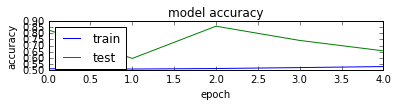

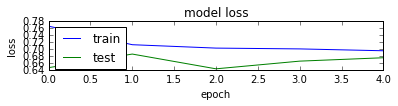

acc: 65.62%
65.62% (+/- 0.00%)


In [6]:
cv = cross_validation.KFold(4096, n_folds=32,shuffle=False,random_state=None)
cvscores = []
bb=[]
for train_index, test_index in cv:  # remaining
    if test_index[0]==0 and test_index[0]<127:  # take out
        print("The OCT Volume 1")
        
        pru=[]
        aba=[]
        for i in range(0,3968):
            at=all_input_3D[train_index[i]]
            pru.append(at)
        
        pru2=[]
        aba2=[]
        for j in range(0,128):
            at2=all_input_3D[test_index[j]]
            pru2.append(at2)
        
        X_tr, X_tes = np.asarray(pru), np.asarray(pru2)
        # y_tr, y_tes = np.asarray(aba), np.asarray(aba2)
        y_tr, y_tes = aba1[train_index[0:3968]], aba1[test_index[0:128]]
        print(X_tr.shape, X_tes.shape, y_tr.shape, y_tes.shape)
        
        # create model
        model1.load_weights(path)
        
        #model.fit(X_tr, y_tr, epochs=100, batch_size=32, verbose=1)
        checkpointer = ModelCheckpoint(filepath="./dataset/Cropped_BM3D/OCT_NET_1.hdf5", monitor='val_acc', verbose=1, save_best_only=True)
        history = model1.fit([X_tr], [y_tr], batch_size=batch_size, nb_epoch=nb_epochs,verbose=1,validation_data=(X_tes, y_tes),callbacks=[checkpointer])
        
        # evaluate the model
        bb1=model1.predict([X_tes])
        scores = model1.evaluate([X_tes], [y_tes], verbose=1)
        print('Test score:', scores[0])
        print('Test accuracy:', scores[1])
        print(history.history.keys())
        plt.figure()
        ax1 = plt.subplot2grid((4,4), (0,0), colspan=4)
        
        # summarize history for accuracy
        plt.plot(history.history['acc'])
        plt.plot(history.history['val_acc'])
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()
        
        # summarize history for loss
        ax2 = plt.subplot2grid((4,4), (1,0), colspan=4)
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()
        print("%s: %.2f%%" % (model1.metrics_names[1], scores[1]*100))
        
        cvscores.append(scores[1] * 100)
        bb.append(bb1)
        
    else:
        
        test_index[0]
        
print("%.2f%% (+/- %.2f%%)" % (numpy.mean(cvscores), numpy.std(cvscores)))

In [45]:
cv = cross_validation.KFold(4096, n_folds=32,shuffle=False,random_state=None)
#kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
for train_index, test_index in cv:
    if test_index[0]==128 and test_index[0]<255:
        print ("The OCT Volume 2")
        pru=[]
        aba=[]
        for i in range(0,3968):
            at=all_input_3D[train_index[i]]
            pru.append(at)
        pru2=[]
        aba2=[]
        for j in range(0,128):
            at2=all_input_3D[test_index[j]]
            pru2.append(at2)
        X_tr, X_tes = np.asarray(pru), np.asarray(pru2)
        #y_tr, y_tes = np.asarray(aba), np.asarray(aba2)
        y_tr, y_tes = aba1[train_index[0:3968]],aba1[test_index[0:128]]
        print (X_tr.shape, X_tes.shape, y_tr.shape, y_tes.shape)
        # create model
        model1.load_weights(path)
        #print_summary(model1.layers)
        #model.fit(X_tr, y_tr, epochs=100, batch_size=32, verbose=1)
        checkpointer = ModelCheckpoint(filepath="./dataset/Cropped_BM3D/OCT_NET_2.hdf5", monitor='val_acc', verbose=1, save_best_only=True)
        history = model1.fit([X_tr], [y_tr], batch_size=batch_size, nb_epoch=nb_epochs,verbose=1,validation_data=(X_tes, y_tes),callbacks=[checkpointer])
        # evaluate the model
        bb1=model1.predict([X_tes])
        scores = model1.evaluate([X_tes], [y_tes], verbose=1)
        print('Test score:', scores[0])
        print('Test accuracy:', scores[1])
        #plt.imshow(Y_hat_mask[0].transpose(1,2,0).squeeze())
        #print('The number of OCT classified correctly are:', np.sum(bb1==label_0[test_index[0:128]]))
        #print('The test index',[test_index[0:128]][0],[test_index[0:128]][127])
        # list all data in history
        print(history.history.keys())
        ax1 = plt.subplot2grid((4,4), (0,0), colspan=4)
        
        # summarize history for accuracy
        plt.plot(history.history['acc'])
        plt.plot(history.history['val_acc'])
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()
        
        # summarize history for loss
        ax2 = plt.subplot2grid((4,4), (1,0), colspan=4)
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()
        
        Y_hat = conv10.eval({input: X_tes.astype('float32')})
        input2 = Input(shape=(256, 18, 18))
        final_conv1 = Conv2D(1, 1, 1, activation='sigmoid')(input2)
        upsample13 = UpSampling2D(size=(13, 13), dim_ordering='th')(final_conv1)
        model_mask = Model(input=input2, output=[upsample13])
        Y_hat_mask = upsample13.eval({input2: Y_hat})
        slice_idx = random.randint(0, 127)
        
        #plt.figure()
        #plt.subplot(1,4,1)
        ax3 = plt.subplot2grid((4,4), (2, 0))
        plt.imshow((X_tes[slice_idx]).transpose(1,2,0))
        plt.savefig('0_'+str(test_index[0])+'.svg')
        #plt.subplot(1,4,2)
        ax4 = plt.subplot2grid((4,4), (2, 1))
        plt.imshow((Y_hat[slice_idx][0:3]).transpose(1,2,0))
        plt.savefig('1_'+str(test_index[0])+'.svg')
        #plt.subplot(1,4,3)
        ax5 = plt.subplot2grid((4,4), (2, 2))
        plt.imshow(Y_hat_mask[slice_idx].transpose(1,2,0).squeeze())
        plt.savefig('2_'+str(test_index[0])+'.svg')
        #plt.subplot(1,4,4)
        ax6 = plt.subplot2grid((4,4), (2, 3))
        mask_rsz=(Y_hat_mask[slice_idx].transpose(1,2,0).squeeze())#
        #data = imresize(np.asarray(Image.open(imaa))[:,:,0:3],scale_factor,'bicubic').astype('float32')
        mask_rsz1=imresize(mask_rsz,(224,224),'bicubic').astype('float32')
        over_all = np.zeros((224,224))
        over_all = ((X_tes[slice_idx]).transpose(1,2,0)[:,:,0])*(mask_rsz1)
        #over_all[:,:,1] = ((X_tes[slice_idx]).transpose(1,2,0)[:,:,1])*(mask_rsz1)
        #over_all[:,:,2] = ((X_tes[slice_idx]).transpose(1,2,0)[:,:,2])*(mask_rsz1)
        plt.imshow(over_all,cmap='gnuplot')
        plt.savefig('3_'+str(test_index[0])+'.svg')
        print(slice_idx, bb1[slice_idx])
        print("%s: %.2f%%" % (model1.metrics_names[1], scores[1]*100))
        cvscores.append(scores[1] * 100)
        bb.append(bb1)
    else:
        test_index[0]
print("%.2f%% (+/- %.2f%%)" % (numpy.mean(cvscores), numpy.std(cvscores)))

The OCT Volume 2
(3968, 3, 224, 224) 

/home/deeplearningutp/anaconda3/envs/tensorflow-utp/lib/python3.5/site-packages/ipykernel_launcher.py:25: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


(128, 3, 224, 224) (3968, 2) (128, 2)
Train on 3968 samples, validate on 128 samples
Epoch 1/5


ResourceExhaustedError: OOM when allocating tensor with shape[20736,4096]
	 [[Node: gradients_6/dense_34/MatMul_grad/MatMul_1 = MatMul[T=DT_FLOAT, _class=["loc:@dense_34/MatMul"], transpose_a=true, transpose_b=false, _device="/job:localhost/replica:0/task:0/gpu:0"](flatten_12/Reshape, gradients_6/dense_34/Relu_grad/ReluGrad)]]

Caused by op 'gradients_6/dense_34/MatMul_grad/MatMul_1', defined at:
  File "/home/deeplearningutp/anaconda3/envs/tensorflow-utp/lib/python3.5/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/deeplearningutp/anaconda3/envs/tensorflow-utp/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/deeplearningutp/anaconda3/envs/tensorflow-utp/lib/python3.5/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/deeplearningutp/anaconda3/envs/tensorflow-utp/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/deeplearningutp/anaconda3/envs/tensorflow-utp/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "/home/deeplearningutp/anaconda3/envs/tensorflow-utp/lib/python3.5/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/home/deeplearningutp/anaconda3/envs/tensorflow-utp/lib/python3.5/site-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/home/deeplearningutp/anaconda3/envs/tensorflow-utp/lib/python3.5/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/deeplearningutp/anaconda3/envs/tensorflow-utp/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/home/deeplearningutp/anaconda3/envs/tensorflow-utp/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/deeplearningutp/anaconda3/envs/tensorflow-utp/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/home/deeplearningutp/anaconda3/envs/tensorflow-utp/lib/python3.5/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/deeplearningutp/anaconda3/envs/tensorflow-utp/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/deeplearningutp/anaconda3/envs/tensorflow-utp/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/deeplearningutp/anaconda3/envs/tensorflow-utp/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/home/deeplearningutp/anaconda3/envs/tensorflow-utp/lib/python3.5/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/deeplearningutp/anaconda3/envs/tensorflow-utp/lib/python3.5/site-packages/ipykernel/zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/deeplearningutp/anaconda3/envs/tensorflow-utp/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2728, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/deeplearningutp/anaconda3/envs/tensorflow-utp/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2850, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/deeplearningutp/anaconda3/envs/tensorflow-utp/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2910, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-43-518d03d64577>", line 25, in <module>
    history = model1.fit([X_tr], [y_tr], batch_size=batch_size, nb_epoch=nb_epochs,verbose=1,validation_data=(X_tes, y_tes),callbacks=[checkpointer])
  File "/home/deeplearningutp/anaconda3/envs/tensorflow-utp/lib/python3.5/site-packages/keras/engine/training.py", line 1490, in fit
    self._make_train_function()
  File "/home/deeplearningutp/anaconda3/envs/tensorflow-utp/lib/python3.5/site-packages/keras/engine/training.py", line 1014, in _make_train_function
    self.total_loss)
  File "/home/deeplearningutp/anaconda3/envs/tensorflow-utp/lib/python3.5/site-packages/keras/optimizers.py", line 152, in get_updates
    grads = self.get_gradients(loss, params)
  File "/home/deeplearningutp/anaconda3/envs/tensorflow-utp/lib/python3.5/site-packages/keras/optimizers.py", line 71, in get_gradients
    grads = K.gradients(loss, params)
  File "/home/deeplearningutp/anaconda3/envs/tensorflow-utp/lib/python3.5/site-packages/keras/backend/tensorflow_backend.py", line 2307, in gradients
    return tf.gradients(loss, variables, colocate_gradients_with_ops=True)
  File "/home/deeplearningutp/anaconda3/envs/tensorflow-utp/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py", line 542, in gradients
    grad_scope, op, func_call, lambda: grad_fn(op, *out_grads))
  File "/home/deeplearningutp/anaconda3/envs/tensorflow-utp/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py", line 348, in _MaybeCompile
    return grad_fn()  # Exit early
  File "/home/deeplearningutp/anaconda3/envs/tensorflow-utp/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py", line 542, in <lambda>
    grad_scope, op, func_call, lambda: grad_fn(op, *out_grads))
  File "/home/deeplearningutp/anaconda3/envs/tensorflow-utp/lib/python3.5/site-packages/tensorflow/python/ops/math_grad.py", line 875, in _MatMulGrad
    grad_b = math_ops.matmul(a, grad, transpose_a=True)
  File "/home/deeplearningutp/anaconda3/envs/tensorflow-utp/lib/python3.5/site-packages/tensorflow/python/ops/math_ops.py", line 1844, in matmul
    a, b, transpose_a=transpose_a, transpose_b=transpose_b, name=name)
  File "/home/deeplearningutp/anaconda3/envs/tensorflow-utp/lib/python3.5/site-packages/tensorflow/python/ops/gen_math_ops.py", line 1289, in _mat_mul
    transpose_b=transpose_b, name=name)
  File "/home/deeplearningutp/anaconda3/envs/tensorflow-utp/lib/python3.5/site-packages/tensorflow/python/framework/op_def_library.py", line 767, in apply_op
    op_def=op_def)
  File "/home/deeplearningutp/anaconda3/envs/tensorflow-utp/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 2630, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/home/deeplearningutp/anaconda3/envs/tensorflow-utp/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 1204, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

...which was originally created as op 'dense_34/MatMul', defined at:
  File "/home/deeplearningutp/anaconda3/envs/tensorflow-utp/lib/python3.5/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
[elided 18 identical lines from previous traceback]
  File "/home/deeplearningutp/anaconda3/envs/tensorflow-utp/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2910, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-42-4bf73ff3c386>", line 25, in <module>
    dense1 = Dense(4096, activation='relu')(flatten)
  File "/home/deeplearningutp/anaconda3/envs/tensorflow-utp/lib/python3.5/site-packages/keras/engine/topology.py", line 596, in __call__
    output = self.call(inputs, **kwargs)
  File "/home/deeplearningutp/anaconda3/envs/tensorflow-utp/lib/python3.5/site-packages/keras/layers/core.py", line 843, in call
    output = K.dot(inputs, self.kernel)
  File "/home/deeplearningutp/anaconda3/envs/tensorflow-utp/lib/python3.5/site-packages/keras/backend/tensorflow_backend.py", line 976, in dot
    out = tf.matmul(x, y)
  File "/home/deeplearningutp/anaconda3/envs/tensorflow-utp/lib/python3.5/site-packages/tensorflow/python/ops/math_ops.py", line 1844, in matmul
    a, b, transpose_a=transpose_a, transpose_b=transpose_b, name=name)
  File "/home/deeplearningutp/anaconda3/envs/tensorflow-utp/lib/python3.5/site-packages/tensorflow/python/ops/gen_math_ops.py", line 1289, in _mat_mul
    transpose_b=transpose_b, name=name)
  File "/home/deeplearningutp/anaconda3/envs/tensorflow-utp/lib/python3.5/site-packages/tensorflow/python/framework/op_def_library.py", line 767, in apply_op
    op_def=op_def)
  File "/home/deeplearningutp/anaconda3/envs/tensorflow-utp/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 2630, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/home/deeplearningutp/anaconda3/envs/tensorflow-utp/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 1204, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

ResourceExhaustedError (see above for traceback): OOM when allocating tensor with shape[20736,4096]
	 [[Node: gradients_6/dense_34/MatMul_grad/MatMul_1 = MatMul[T=DT_FLOAT, _class=["loc:@dense_34/MatMul"], transpose_a=true, transpose_b=false, _device="/job:localhost/replica:0/task:0/gpu:0"](flatten_12/Reshape, gradients_6/dense_34/Relu_grad/ReluGrad)]]


The OCT Volume 3
(3968, 3, 224, 224) (128, 3, 224, 224) (3968, 2) (128, 2)
Train on 3968 samples, validate on 128 samples
Epoch 1/5
3968/3968 [==============================] - 62s - loss: 0.6079 - acc: 0.6812 - val_loss: 1.7653 - val_acc: 0.0000e+00
Epoch 2/5
3968/3968 [==============================] - 69s - loss: 0.3272 - acc: 0.8606 - val_loss: 0.9159 - val_acc: 0.5234
Epoch 3/5
3968/3968 [==============================] - 62s - loss: 0.1601 - acc: 0.9413 - val_loss: 2.2134 - val_acc: 0.2656
Epoch 4/5
3968/3968 [==============================] - 68s - loss: 0.0891 - acc: 0.9680 - val_loss: 0.5099 - val_acc: 0.7734
Epoch 5/5
128/128 [==============================] - 0s     
('Test score:', 0.80393144488334656)
('Test accuracy:', 0.671875)
['acc', 'loss', 'val_acc', 'val_loss']


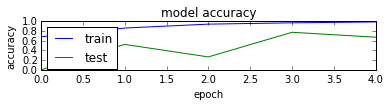

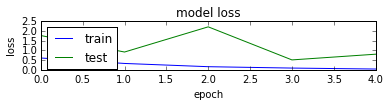

123 [ 0.99809605  0.00190397]
acc: 67.19%
79.17% (+/- 14.79%)


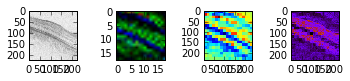

In [8]:
cv = cross_validation.KFold(4096, n_folds=32,shuffle=False,random_state=None)
for train_index, test_index in cv:
    if test_index[0]==256 and test_index[0]<383:
        print("The OCT Volume 3")
        pru=[]
        aba=[]
        for i in range(0,3968):
            at=all_input_3D[train_index[i]]
            pru.append(at)
        pru2=[]
        aba2=[]
        for j in range(0,128):
            at2=all_input_3D[test_index[j]]
            pru2.append(at2)
        X_tr, X_tes = np.asarray(pru), np.asarray(pru2)
        #y_tr, y_tes = np.asarray(aba), np.asarray(aba2)
        y_tr, y_tes = aba1[train_index[0:3968]],aba1[test_index[0:128]]
        print(X_tr.shape, X_tes.shape, y_tr.shape, y_tes.shape)
        # create model
        #model1 = Model(input=input, output=[dense3])
        #for layer in model1.layers:
        #    layer.trainable = True
        #model1 = Model(input=input, output=[dense3]
        model1.load_weights('model_OCTNET.h5')
        # Fit the model
        #model.fit(X_tr, y_tr, epochs=100, batch_size=32, verbose=1)
        checkpointer = ModelCheckpoint(filepath="/home/ojperdomoc/OCT_HES-SO/OCT_NET_3.hdf5", monitor='val_acc', verbose=1, save_best_only=True)
        history = model1.fit([X_tr], [y_tr], batch_size=batch_size, nb_epoch=nb_epochs,verbose=1,validation_data=(X_tes, y_tes),callbacks=[checkpointer])
        # evaluate the model
        bb1=model1.predict([X_tes])
        scores = model1.evaluate([X_tes], [y_tes], verbose=1)
        print('Test score:', scores[0])
        print('Test accuracy:', scores[1])
        print(history.history.keys())
        ax1 = plt.subplot2grid((4,4), (0,0), colspan=4)
        # summarize history for accuracy
        plt.plot(history.history['acc'])
        plt.plot(history.history['val_acc'])
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()
        # summarize history for loss
        ax2 = plt.subplot2grid((4,4), (1,0), colspan=4)
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()
        Y_hat = conv10.eval({input: X_tes.astype('float32')})
        input2 = Input(shape=(256,18,18))
        final_conv1 = Convolution2D(1, 1, 1, activation='sigmoid')(input2)
        upsample13 = UpSampling2D(size=(13, 13), dim_ordering='th')(final_conv1)
        model_mask = Model(input=input2, output=[upsample13])
        Y_hat_mask = upsample13.eval({input2: Y_hat})
        slice_idx = random.randint(0, 127)
        #plt.figure()
        #plt.subplot(1,4,1)
        ax3 = plt.subplot2grid((4,4), (2, 0))
        plt.imshow((X_tes[slice_idx]).transpose(1,2,0))
        plt.savefig('0_'+str(test_index[0])+'.svg')
        #plt.subplot(1,4,2)
        ax4 = plt.subplot2grid((4,4), (2, 1))
        plt.imshow((Y_hat[slice_idx][0:3]).transpose(1,2,0))
        plt.savefig('1_'+str(test_index[0])+'.svg')
        #plt.subplot(1,4,3)
        ax5 = plt.subplot2grid((4,4), (2, 2))
        plt.imshow(Y_hat_mask[slice_idx].transpose(1,2,0).squeeze())
        plt.savefig('2_'+str(test_index[0])+'.svg')
        #plt.subplot(1,4,4)
        ax6 = plt.subplot2grid((4,4), (2, 3))
        mask_rsz=(Y_hat_mask[slice_idx].transpose(1,2,0).squeeze())#
        #data = imresize(np.asarray(Image.open(imaa))[:,:,0:3],scale_factor,'bicubic').astype('float32')
        mask_rsz1=imresize(mask_rsz,(224,224),'bicubic').astype('float32')
        over_all = np.zeros((224,224))
        over_all = ((X_tes[slice_idx]).transpose(1,2,0)[:,:,0])*(mask_rsz1)
        #over_all[:,:,1] = ((X_tes[slice_idx]).transpose(1,2,0)[:,:,1])*(mask_rsz1)
        #over_all[:,:,2] = ((X_tes[slice_idx]).transpose(1,2,0)[:,:,2])*(mask_rsz1)
        plt.imshow(over_all,cmap='gnuplot')
        plt.savefig('3_'+str(test_index[0])+'.svg')
        print slice_idx, bb1[slice_idx]
        print("%s: %.2f%%" % (model1.metrics_names[1], scores[1]*100))
        cvscores.append(scores[1] * 100)
        bb.append(bb1)
    else:
        test_index[0]
print("%.2f%% (+/- %.2f%%)" % (numpy.mean(cvscores), numpy.std(cvscores)))

The OCT Volume 4
(3968, 3, 224, 224) (128, 3, 224, 224) (3968, 2) (128, 2)
Train on 3968 samples, validate on 128 samples
Epoch 1/5
3968/3968 [==============================] - 62s - loss: 0.6018 - acc: 0.6888 - val_loss: 0.8433 - val_acc: 0.5469
Epoch 2/5
3968/3968 [==============================] - 68s - loss: 0.3118 - acc: 0.8679 - val_loss: 0.9142 - val_acc: 0.5938
Epoch 3/5
3968/3968 [==============================] - 68s - loss: 0.1515 - acc: 0.9413 - val_loss: 0.9307 - val_acc: 0.6562
Epoch 4/5
3968/3968 [==============================] - 62s - loss: 0.0707 - acc: 0.9740 - val_loss: 1.7723 - val_acc: 0.6016
Epoch 5/5
128/128 [==============================] - 0s     
('Test score:', 1.9493197798728943)
('Test accuracy:', 0.625)
['acc', 'loss', 'val_acc', 'val_loss']


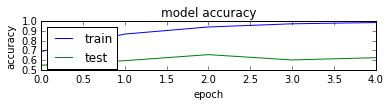

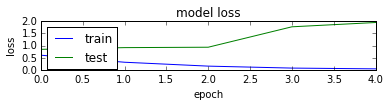

107 [  9.99937177e-01   6.28469352e-05]
acc: 62.50%
75.00% (+/- 14.70%)


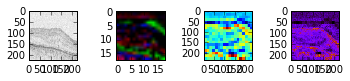

In [9]:
cv = cross_validation.KFold(4096, n_folds=32,shuffle=False,random_state=None)
for train_index, test_index in cv:
    if test_index[0]==384 and test_index[0]<511:
        print "The OCT Volume 4"
        pru=[]
        aba=[]
        for i in range(0,3968):
            at=all_input_3D[train_index[i]]
            pru.append(at)
        pru2=[]
        aba2=[]
        for j in range(0,128):
            at2=all_input_3D[test_index[j]]
            pru2.append(at2)
        X_tr, X_tes = np.asarray(pru), np.asarray(pru2)
        #y_tr, y_tes = np.asarray(aba), np.asarray(aba2)
        y_tr, y_tes = aba1[train_index[0:3968]],aba1[test_index[0:128]]
        print X_tr.shape, X_tes.shape, y_tr.shape, y_tes.shape
        # create model
        #model1 = Model(input=input, output=[dense3])
        #for layer in model1.layers:
        #    layer.trainable = True
        #model1 = Model(input=input, output=[dense3]
        model1.load_weights('model_OCTNET.h5')
        # Fit the model
        #model.fit(X_tr, y_tr, epochs=100, batch_size=32, verbose=1)
        checkpointer = ModelCheckpoint(filepath="/home/ojperdomoc/OCT_HES-SO/OCT_NET_4.hdf5", monitor='val_acc', verbose=1, save_best_only=True)
        history = model1.fit([X_tr], [y_tr], batch_size=batch_size, nb_epoch=nb_epochs,verbose=1,validation_data=(X_tes, y_tes),callbacks=[checkpointer])
        # evaluate the model
        bb1=model1.predict([X_tes])
        scores = model1.evaluate([X_tes], [y_tes], verbose=1)
        print('Test score:', scores[0])
        print('Test accuracy:', scores[1])
        #plt.imshow(Y_hat_mask[0].transpose(1,2,0).squeeze())
        #print('The number of OCT classified correctly are:', np.sum(bb1==label_0[test_index[0:128]]))
        #print('The test index',[test_index[0:128]][0],[test_index[0:128]][127])
        # list all data in history
        print(history.history.keys())
        ax1 = plt.subplot2grid((4,4), (0,0), colspan=4)
        # summarize history for accuracy
        plt.plot(history.history['acc'])
        plt.plot(history.history['val_acc'])
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()
        # summarize history for loss
        ax2 = plt.subplot2grid((4,4), (1,0), colspan=4)
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()
        Y_hat = conv10.eval({input: X_tes.astype('float32')})
        input2 = Input(shape=(256,18,18))
        final_conv1 = Convolution2D(1, 1, 1, activation='sigmoid')(input2)
        upsample13 = UpSampling2D(size=(13, 13), dim_ordering='th')(final_conv1)
        model_mask = Model(input=input2, output=[upsample13])
        Y_hat_mask = upsample13.eval({input2: Y_hat})
        slice_idx = random.randint(0, 127)
        #plt.figure()
        #plt.subplot(1,4,1)
        ax3 = plt.subplot2grid((4,4), (2, 0))
        plt.imshow((X_tes[slice_idx]).transpose(1,2,0))
        plt.savefig('0_'+str(test_index[0])+'.svg')
        #plt.subplot(1,4,2)
        ax4 = plt.subplot2grid((4,4), (2, 1))
        plt.imshow((Y_hat[slice_idx][0:3]).transpose(1,2,0))
        plt.savefig('1_'+str(test_index[0])+'.svg')
        #plt.subplot(1,4,3)
        ax5 = plt.subplot2grid((4,4), (2, 2))
        plt.imshow(Y_hat_mask[slice_idx].transpose(1,2,0).squeeze())
        plt.savefig('2_'+str(test_index[0])+'.svg')
        #plt.subplot(1,4,4)
        ax6 = plt.subplot2grid((4,4), (2, 3))
        mask_rsz=(Y_hat_mask[slice_idx].transpose(1,2,0).squeeze())#
        #data = imresize(np.asarray(Image.open(imaa))[:,:,0:3],scale_factor,'bicubic').astype('float32')
        mask_rsz1=imresize(mask_rsz,(224,224),'bicubic').astype('float32')
        over_all = np.zeros((224,224))
        over_all = ((X_tes[slice_idx]).transpose(1,2,0)[:,:,0])*(mask_rsz1)
        #over_all[:,:,1] = ((X_tes[slice_idx]).transpose(1,2,0)[:,:,1])*(mask_rsz1)
        #over_all[:,:,2] = ((X_tes[slice_idx]).transpose(1,2,0)[:,:,2])*(mask_rsz1)
        plt.imshow(over_all,cmap='gnuplot')
        plt.savefig('3_'+str(test_index[0])+'.svg')
        print slice_idx, bb1[slice_idx]
        print("%s: %.2f%%" % (model1.metrics_names[1], scores[1]*100))
        cvscores.append(scores[1] * 100)
        bb.append(bb1)
    else:
        test_index[0]
print("%.2f%% (+/- %.2f%%)" % (numpy.mean(cvscores), numpy.std(cvscores)))

The OCT Volume 5
(3968, 3, 224, 224) (128, 3, 224, 224) (3968, 2) (128, 2)
Train on 3968 samples, validate on 128 samples
Epoch 1/5
3968/3968 [==============================] - 63s - loss: 0.5963 - acc: 0.6905 - val_loss: 1.5100 - val_acc: 0.0000e+00
Epoch 2/5
3968/3968 [==============================] - 68s - loss: 0.3153 - acc: 0.8642 - val_loss: 0.6565 - val_acc: 0.6875
Epoch 3/5
3968/3968 [==============================] - 62s - loss: 0.1666 - acc: 0.9307 - val_loss: 0.9544 - val_acc: 0.5781
Epoch 4/5
3968/3968 [==============================] - 68s - loss: 0.0843 - acc: 0.9700 - val_loss: 0.6478 - val_acc: 0.7500
Epoch 5/5
128/128 [==============================] - 0s     
('Test score:', 1.873475581407547)
('Test accuracy:', 0.5234375)
['acc', 'loss', 'val_acc', 'val_loss']


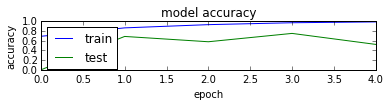

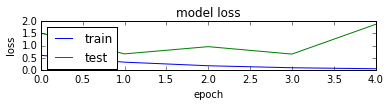

63 [ 0.40267247  0.59732747]
acc: 52.34%
70.47% (+/- 15.97%)


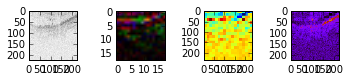

In [10]:
cv = cross_validation.KFold(4096, n_folds=32,shuffle=False,random_state=None)
for train_index, test_index in cv:
    if test_index[0]==512 and test_index[0]<639:
        print "The OCT Volume 5"
        pru=[]
        aba=[]
        for i in range(0,3968):
            at=all_input_3D[train_index[i]]
            pru.append(at)
        pru2=[]
        aba2=[]
        for j in range(0,128):
            at2=all_input_3D[test_index[j]]
            pru2.append(at2)
        X_tr, X_tes = np.asarray(pru), np.asarray(pru2)
        #y_tr, y_tes = np.asarray(aba), np.asarray(aba2)
        y_tr, y_tes = aba1[train_index[0:3968]],aba1[test_index[0:128]]
        print X_tr.shape, X_tes.shape, y_tr.shape, y_tes.shape
        # create model
        #model1 = Model(input=input, output=[dense3])
        #for layer in model1.layers:
        #    layer.trainable = True
        #model1 = Model(input=input, output=[dense3]
        model1.load_weights('model_OCTNET.h5')
        # Fit the model
        #model.fit(X_tr, y_tr, epochs=100, batch_size=32, verbose=1)
        checkpointer = ModelCheckpoint(filepath="/home/ojperdomoc/OCT_HES-SO/OCT_NET_5.hdf5", monitor='val_acc', verbose=1, save_best_only=True)
        history = model1.fit([X_tr], [y_tr], batch_size=batch_size, nb_epoch=nb_epochs,verbose=1,validation_data=(X_tes, y_tes),callbacks=[checkpointer])
        # evaluate the model
        bb1=model1.predict([X_tes])
        scores = model1.evaluate([X_tes], [y_tes], verbose=1)
        print('Test score:', scores[0])
        print('Test accuracy:', scores[1])
        print(history.history.keys())
        ax1 = plt.subplot2grid((4,4), (0,0), colspan=4)
        # summarize history for accuracy
        plt.plot(history.history['acc'])
        plt.plot(history.history['val_acc'])
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()
        # summarize history for loss
        ax2 = plt.subplot2grid((4,4), (1,0), colspan=4)
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()
        Y_hat = conv10.eval({input: X_tes.astype('float32')})
        input2 = Input(shape=(256,18,18))
        final_conv1 = Convolution2D(1, 1, 1, activation='sigmoid')(input2)
        upsample13 = UpSampling2D(size=(13, 13), dim_ordering='th')(final_conv1)
        model_mask = Model(input=input2, output=[upsample13])
        Y_hat_mask = upsample13.eval({input2: Y_hat})
        slice_idx = random.randint(0, 127)
        #plt.figure()
        #plt.subplot(1,4,1)
        ax3 = plt.subplot2grid((4,4), (2, 0))
        plt.imshow((X_tes[slice_idx]).transpose(1,2,0))
        plt.savefig('0_'+str(test_index[0])+'.svg')
        #plt.subplot(1,4,2)
        ax4 = plt.subplot2grid((4,4), (2, 1))
        plt.imshow((Y_hat[slice_idx][0:3]).transpose(1,2,0))
        plt.savefig('1_'+str(test_index[0])+'.svg')
        #plt.subplot(1,4,3)
        ax5 = plt.subplot2grid((4,4), (2, 2))
        plt.imshow(Y_hat_mask[slice_idx].transpose(1,2,0).squeeze())
        plt.savefig('2_'+str(test_index[0])+'.svg')
        #plt.subplot(1,4,4)
        ax6 = plt.subplot2grid((4,4), (2, 3))
        mask_rsz=(Y_hat_mask[slice_idx].transpose(1,2,0).squeeze())#
        #data = imresize(np.asarray(Image.open(imaa))[:,:,0:3],scale_factor,'bicubic').astype('float32')
        mask_rsz1=imresize(mask_rsz,(224,224),'bicubic').astype('float32')
        over_all = np.zeros((224,224))
        over_all = ((X_tes[slice_idx]).transpose(1,2,0)[:,:,0])*(mask_rsz1)
        #over_all[:,:,1] = ((X_tes[slice_idx]).transpose(1,2,0)[:,:,1])*(mask_rsz1)
        #over_all[:,:,2] = ((X_tes[slice_idx]).transpose(1,2,0)[:,:,2])*(mask_rsz1)
        plt.imshow(over_all,cmap='gnuplot')
        plt.savefig('3_'+str(test_index[0])+'.svg')
        print slice_idx, bb1[slice_idx]
        print("%s: %.2f%%" % (model1.metrics_names[1], scores[1]*100))
        cvscores.append(scores[1] * 100)
        bb.append(bb1)
    else:
        test_index[0]
print("%.2f%% (+/- %.2f%%)" % (numpy.mean(cvscores), numpy.std(cvscores)))

The OCT Volume 6
(3968, 3, 224, 224) (128, 3, 224, 224) (3968, 2) (128, 2)
Train on 3968 samples, validate on 128 samples
Epoch 1/5
3968/3968 [==============================] - 63s - loss: 0.6025 - acc: 0.6749 - val_loss: 0.2506 - val_acc: 1.0000
Epoch 2/5
3968/3968 [==============================] - 62s - loss: 0.3201 - acc: 0.8637 - val_loss: 0.0477 - val_acc: 1.0000
Epoch 3/5
3968/3968 [==============================] - 62s - loss: 0.1731 - acc: 0.9322 - val_loss: 0.0189 - val_acc: 1.0000
Epoch 4/5
3968/3968 [==============================] - 62s - loss: 0.0886 - acc: 0.9693 - val_loss: 0.0122 - val_acc: 1.0000
Epoch 5/5
128/128 [==============================] - 0s     
('Test score:', 0.057913246564567089)
('Test accuracy:', 0.984375)
['acc', 'loss', 'val_acc', 'val_loss']


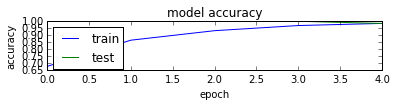

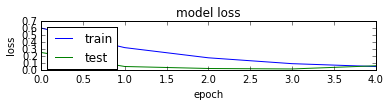

46 [ 0.9784171   0.02158288]
acc: 98.44%
75.13% (+/- 17.92%)


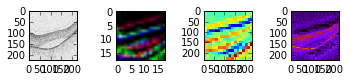

In [11]:
cv = cross_validation.KFold(4096, n_folds=32,shuffle=False,random_state=None)
for train_index, test_index in cv:
    if test_index[0]==640 and test_index[0]<767:
        print "The OCT Volume 6"
        pru=[]
        aba=[]
        for i in range(0,3968):
            at=all_input_3D[train_index[i]]
            pru.append(at)
        pru2=[]
        aba2=[]
        for j in range(0,128):
            at2=all_input_3D[test_index[j]]
            pru2.append(at2)
        X_tr, X_tes = np.asarray(pru), np.asarray(pru2)
        #y_tr, y_tes = np.asarray(aba), np.asarray(aba2)
        y_tr, y_tes = aba1[train_index[0:3968]],aba1[test_index[0:128]]
        print X_tr.shape, X_tes.shape, y_tr.shape, y_tes.shape
        # create model
        #model1 = Model(input=input, output=[dense3])
        #for layer in model1.layers:
        #    layer.trainable = True
        #model1 = Model(input=input, output=[dense3]
        model1.load_weights('model_OCTNET.h5')
        # Fit the model
        #model.fit(X_tr, y_tr, epochs=100, batch_size=32, verbose=1)
        checkpointer = ModelCheckpoint(filepath="/home/ojperdomoc/OCT_HES-SO/OCT_NET_6.hdf5", monitor='val_acc', verbose=1, save_best_only=True)
        history = model1.fit([X_tr], [y_tr], batch_size=batch_size, nb_epoch=nb_epochs,verbose=1,validation_data=(X_tes, y_tes),callbacks=[checkpointer])
        # evaluate the model
        bb1=model1.predict([X_tes])
        scores = model1.evaluate([X_tes], [y_tes], verbose=1)
        print('Test score:', scores[0])
        print('Test accuracy:', scores[1])
        #plt.imshow(Y_hat_mask[0].transpose(1,2,0).squeeze())
        #print('The number of OCT classified correctly are:', np.sum(bb1==label_0[test_index[0:128]]))
        #print('The test index',[test_index[0:128]][0],[test_index[0:128]][127])
        # list all data in history
        print(history.history.keys())
        ax1 = plt.subplot2grid((4,4), (0,0), colspan=4)
        # summarize history for accuracy
        plt.plot(history.history['acc'])
        plt.plot(history.history['val_acc'])
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()
        # summarize history for loss
        ax2 = plt.subplot2grid((4,4), (1,0), colspan=4)
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()
        Y_hat = conv10.eval({input: X_tes.astype('float32')})
        input2 = Input(shape=(256,18,18))
        final_conv1 = Convolution2D(1, 1, 1, activation='sigmoid')(input2)
        upsample13 = UpSampling2D(size=(13, 13), dim_ordering='th')(final_conv1)
        model_mask = Model(input=input2, output=[upsample13])
        Y_hat_mask = upsample13.eval({input2: Y_hat})
        slice_idx = random.randint(0, 127)
        #plt.figure()
        #plt.subplot(1,4,1)
        ax3 = plt.subplot2grid((4,4), (2, 0))
        plt.imshow((X_tes[slice_idx]).transpose(1,2,0))
        plt.savefig('0_'+str(test_index[0])+'.svg')
        #plt.subplot(1,4,2)
        ax4 = plt.subplot2grid((4,4), (2, 1))
        plt.imshow((Y_hat[slice_idx][0:3]).transpose(1,2,0))
        plt.savefig('1_'+str(test_index[0])+'.svg')
        #plt.subplot(1,4,3)
        ax5 = plt.subplot2grid((4,4), (2, 2))
        plt.imshow(Y_hat_mask[slice_idx].transpose(1,2,0).squeeze())
        plt.savefig('2_'+str(test_index[0])+'.svg')
        #plt.subplot(1,4,4)
        ax6 = plt.subplot2grid((4,4), (2, 3))
        mask_rsz=(Y_hat_mask[slice_idx].transpose(1,2,0).squeeze())#
        #data = imresize(np.asarray(Image.open(imaa))[:,:,0:3],scale_factor,'bicubic').astype('float32')
        mask_rsz1=imresize(mask_rsz,(224,224),'bicubic').astype('float32')
        over_all = np.zeros((224,224))
        over_all = ((X_tes[slice_idx]).transpose(1,2,0)[:,:,0])*(mask_rsz1)
        #over_all[:,:,1] = ((X_tes[slice_idx]).transpose(1,2,0)[:,:,1])*(mask_rsz1)
        #over_all[:,:,2] = ((X_tes[slice_idx]).transpose(1,2,0)[:,:,2])*(mask_rsz1)
        plt.imshow(over_all,cmap='gnuplot')
        plt.savefig('3_'+str(test_index[0])+'.svg')
        print slice_idx, bb1[slice_idx]
        print("%s: %.2f%%" % (model1.metrics_names[1], scores[1]*100))
        cvscores.append(scores[1] * 100)
        bb.append(bb1)
    else:
        test_index[0]
print("%.2f%% (+/- %.2f%%)" % (numpy.mean(cvscores), numpy.std(cvscores)))

The OCT Volume 7
(3968, 3, 224, 224) (128, 3, 224, 224) (3968, 2) (128, 2)
Train on 3968 samples, validate on 128 samples
Epoch 1/5
3968/3968 [==============================] - 68s - loss: 0.5790 - acc: 0.6941 - val_loss: 1.8873 - val_acc: 0.4297
Epoch 2/5
3968/3968 [==============================] - 69s - loss: 0.2792 - acc: 0.8846 - val_loss: 2.9251 - val_acc: 0.4609
Epoch 3/5
3968/3968 [==============================] - 69s - loss: 0.1388 - acc: 0.9476 - val_loss: 3.8667 - val_acc: 0.4844
Epoch 4/5
3968/3968 [==============================] - 68s - loss: 0.0670 - acc: 0.9788 - val_loss: 4.0477 - val_acc: 0.5234
Epoch 5/5
128/128 [==============================] - 0s     
('Test score:', 6.4152073860168457)
('Test accuracy:', 0.4140625)
['acc', 'loss', 'val_acc', 'val_loss']


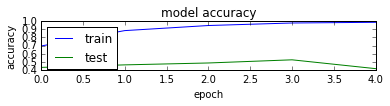

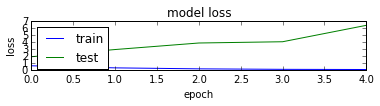

93 [  2.52334539e-05   9.99974728e-01]
acc: 41.41%
57.23% (+/- 28.61%)


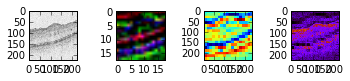

In [42]:
cv = cross_validation.KFold(4096, n_folds=32,shuffle=False,random_state=None)
for train_index, test_index in cv:
    if test_index[0]==768 and test_index[0]<895:
        print "The OCT Volume 7"
        pru=[]
        aba=[]
        for i in range(0,3968):
            at=all_input_3D[train_index[i]]
            pru.append(at)
        pru2=[]
        aba2=[]
        for j in range(0,128):
            at2=all_input_3D[test_index[j]]
            pru2.append(at2)
        X_tr, X_tes = np.asarray(pru), np.asarray(pru2)
        #y_tr, y_tes = np.asarray(aba), np.asarray(aba2)
        y_tr, y_tes = aba1[train_index[0:3968]],aba1[test_index[0:128]]
        print X_tr.shape, X_tes.shape, y_tr.shape, y_tes.shape
        # create model
        #model1 = Model(input=input, output=[dense3])
        #for layer in model1.layers:
        #    layer.trainable = True
        #model1 = Model(input=input, output=[dense3]
        model1.load_weights('model_OCTNET.h5')
        # Fit the model
        #model.fit(X_tr, y_tr, epochs=100, batch_size=32, verbose=1)
        checkpointer = ModelCheckpoint(filepath="/home/ojperdomoc/OCT_HES-SO/OCT_NET_7.hdf5", monitor='val_acc', verbose=1, save_best_only=True)
        history = model1.fit([X_tr], [y_tr], batch_size=batch_size, nb_epoch=nb_epochs,verbose=1,validation_data=(X_tes, y_tes),callbacks=[checkpointer])
        # evaluate the model
        bb1=model1.predict([X_tes])
        scores = model1.evaluate([X_tes], [y_tes], verbose=1)
        print('Test score:', scores[0])
        print('Test accuracy:', scores[1])
        #plt.imshow(Y_hat_mask[0].transpose(1,2,0).squeeze())
        #print('The number of OCT classified correctly are:', np.sum(bb1==label_0[test_index[0:128]]))
        #print('The test index',[test_index[0:128]][0],[test_index[0:128]][127])
        # list all data in history
        print(history.history.keys())
        ax1 = plt.subplot2grid((4,4), (0,0), colspan=4)
        # summarize history for accuracy
        plt.plot(history.history['acc'])
        plt.plot(history.history['val_acc'])
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()
        # summarize history for loss
        ax2 = plt.subplot2grid((4,4), (1,0), colspan=4)
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()
        Y_hat = conv10.eval({input: X_tes.astype('float32')})
        input2 = Input(shape=(256,18,18))
        final_conv1 = Convolution2D(1, 1, 1, activation='sigmoid')(input2)
        upsample13 = UpSampling2D(size=(13, 13), dim_ordering='th')(final_conv1)
        model_mask = Model(input=input2, output=[upsample13])
        Y_hat_mask = upsample13.eval({input2: Y_hat})
        slice_idx = random.randint(0, 127)
        #plt.figure()
        #plt.subplot(1,4,1)
        ax3 = plt.subplot2grid((4,4), (2, 0))
        plt.imshow((X_tes[slice_idx]).transpose(1,2,0))
        plt.savefig('0_'+str(test_index[0])+'.svg')
        #plt.subplot(1,4,2)
        ax4 = plt.subplot2grid((4,4), (2, 1))
        plt.imshow((Y_hat[slice_idx][0:3]).transpose(1,2,0))
        plt.savefig('1_'+str(test_index[0])+'.svg')
        #plt.subplot(1,4,3)
        ax5 = plt.subplot2grid((4,4), (2, 2))
        plt.imshow(Y_hat_mask[slice_idx].transpose(1,2,0).squeeze())
        plt.savefig('2_'+str(test_index[0])+'.svg')
        #plt.subplot(1,4,4)
        ax6 = plt.subplot2grid((4,4), (2, 3))
        mask_rsz=(Y_hat_mask[slice_idx].transpose(1,2,0).squeeze())#
        #data = imresize(np.asarray(Image.open(imaa))[:,:,0:3],scale_factor,'bicubic').astype('float32')
        mask_rsz1=imresize(mask_rsz,(224,224),'bicubic').astype('float32')
        over_all = np.zeros((224,224))
        over_all = ((X_tes[slice_idx]).transpose(1,2,0)[:,:,0])*(mask_rsz1)
        #over_all[:,:,1] = ((X_tes[slice_idx]).transpose(1,2,0)[:,:,1])*(mask_rsz1)
        #over_all[:,:,2] = ((X_tes[slice_idx]).transpose(1,2,0)[:,:,2])*(mask_rsz1)
        plt.imshow(over_all,cmap='gnuplot')
        plt.savefig('3_'+str(test_index[0])+'.svg')
        print slice_idx, bb1[slice_idx]
        print("%s: %.2f%%" % (model1.metrics_names[1], scores[1]*100))
        cvscores.append(scores[1] * 100)
        bb.append(bb1)
    else:
        test_index[0]
print("%.2f%% (+/- %.2f%%)" % (numpy.mean(cvscores), numpy.std(cvscores)))

The OCT Volume 8
(3968, 3, 224, 224) (128, 3, 224, 224) (3968, 2) (128, 2)
Train on 3968 samples, validate on 128 samples
Epoch 1/5
3968/3968 [==============================] - 63s - loss: 0.5905 - acc: 0.6867 - val_loss: 1.5080 - val_acc: 0.0078
Epoch 2/5
3968/3968 [==============================] - 68s - loss: 0.3118 - acc: 0.8647 - val_loss: 0.8148 - val_acc: 0.4531
Epoch 3/5
3968/3968 [==============================] - 67s - loss: 0.1535 - acc: 0.9441 - val_loss: 0.7375 - val_acc: 0.6719
Epoch 4/5
3968/3968 [==============================] - 61s - loss: 0.0779 - acc: 0.9715 - val_loss: 1.5043 - val_acc: 0.5156
Epoch 5/5
128/128 [==============================] - 0s     
('Test score:', 3.8253334164619446)
('Test accuracy:', 0.2734375)
['acc', 'loss', 'val_acc', 'val_loss']


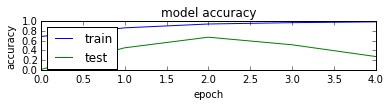

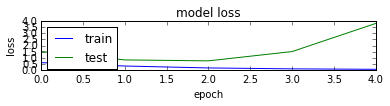

25 [ 0.99303269  0.00696733]
acc: 27.34%
65.33% (+/- 23.39%)


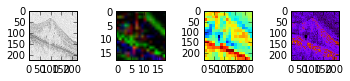

In [13]:
cv = cross_validation.KFold(4096, n_folds=32,shuffle=False,random_state=None)
for train_index, test_index in cv:
    if test_index[0]==896 and test_index[0]<1023:
        print "The OCT Volume 8"
        pru=[]
        aba=[]
        for i in range(0,3968):
            at=all_input_3D[train_index[i]]
            pru.append(at)
        pru2=[]
        aba2=[]
        for j in range(0,128):
            at2=all_input_3D[test_index[j]]
            pru2.append(at2)
        X_tr, X_tes = np.asarray(pru), np.asarray(pru2)
        #y_tr, y_tes = np.asarray(aba), np.asarray(aba2)
        y_tr, y_tes = aba1[train_index[0:3968]],aba1[test_index[0:128]]
        print X_tr.shape, X_tes.shape, y_tr.shape, y_tes.shape
        # create model
        #model1 = Model(input=input, output=[dense3])
        #for layer in model1.layers:
        #    layer.trainable = True
        #model1 = Model(input=input, output=[dense3]
        model1.load_weights('model_OCTNET.h5')
        # Fit the model
        #model.fit(X_tr, y_tr, epochs=100, batch_size=32, verbose=1)
        checkpointer = ModelCheckpoint(filepath="/home/ojperdomoc/OCT_HES-SO/OCT_NET_8.hdf5", monitor='val_acc', verbose=1, save_best_only=True)
        history = model1.fit([X_tr], [y_tr], batch_size=batch_size, nb_epoch=nb_epochs,verbose=1,validation_data=(X_tes, y_tes),callbacks=[checkpointer])
        # evaluate the model
        bb1=model1.predict([X_tes])
        scores = model1.evaluate([X_tes], [y_tes], verbose=1)
        print('Test score:', scores[0])
        print('Test accuracy:', scores[1])
        #plt.imshow(Y_hat_mask[0].transpose(1,2,0).squeeze())
        #print('The number of OCT classified correctly are:', np.sum(bb1==label_0[test_index[0:128]]))
        #print('The test index',[test_index[0:128]][0],[test_index[0:128]][127])
        # list all data in history
        print(history.history.keys())
        ax1 = plt.subplot2grid((4,4), (0,0), colspan=4)
        # summarize history for accuracy
        plt.plot(history.history['acc'])
        plt.plot(history.history['val_acc'])
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()
        # summarize history for loss
        ax2 = plt.subplot2grid((4,4), (1,0), colspan=4)
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()
        Y_hat = conv10.eval({input: X_tes.astype('float32')})
        input2 = Input(shape=(256,18,18))
        final_conv1 = Convolution2D(1, 1, 1, activation='sigmoid')(input2)
        upsample13 = UpSampling2D(size=(13, 13), dim_ordering='th')(final_conv1)
        model_mask = Model(input=input2, output=[upsample13])
        Y_hat_mask = upsample13.eval({input2: Y_hat})
        slice_idx = random.randint(0, 127)
        #plt.figure()
        #plt.subplot(1,4,1)
        ax3 = plt.subplot2grid((4,4), (2, 0))
        plt.imshow((X_tes[slice_idx]).transpose(1,2,0))
        plt.savefig('0_'+str(test_index[0])+'.svg')
        #plt.subplot(1,4,2)
        ax4 = plt.subplot2grid((4,4), (2, 1))
        plt.imshow((Y_hat[slice_idx][0:3]).transpose(1,2,0))
        plt.savefig('1_'+str(test_index[0])+'.svg')
        #plt.subplot(1,4,3)
        ax5 = plt.subplot2grid((4,4), (2, 2))
        plt.imshow(Y_hat_mask[slice_idx].transpose(1,2,0).squeeze())
        plt.savefig('2_'+str(test_index[0])+'.svg')
        #plt.subplot(1,4,4)
        ax6 = plt.subplot2grid((4,4), (2, 3))
        mask_rsz=(Y_hat_mask[slice_idx].transpose(1,2,0).squeeze())#
        #data = imresize(np.asarray(Image.open(imaa))[:,:,0:3],scale_factor,'bicubic').astype('float32')
        mask_rsz1=imresize(mask_rsz,(224,224),'bicubic').astype('float32')
        over_all = np.zeros((224,224))
        over_all = ((X_tes[slice_idx]).transpose(1,2,0)[:,:,0])*(mask_rsz1)
        #over_all[:,:,1] = ((X_tes[slice_idx]).transpose(1,2,0)[:,:,1])*(mask_rsz1)
        #over_all[:,:,2] = ((X_tes[slice_idx]).transpose(1,2,0)[:,:,2])*(mask_rsz1)
        plt.imshow(over_all,cmap='gnuplot')
        plt.savefig('3_'+str(test_index[0])+'.svg')
        print slice_idx, bb1[slice_idx]
        print("%s: %.2f%%" % (model1.metrics_names[1], scores[1]*100))
        cvscores.append(scores[1] * 100)
        bb.append(bb1)
    else:
        test_index[0]
print("%.2f%% (+/- %.2f%%)" % (numpy.mean(cvscores), numpy.std(cvscores)))

The OCT Volume 9
(3968, 3, 224, 224) (128, 3, 224, 224) (3968, 2) (128, 2)
Train on 3968 samples, validate on 128 samples
Epoch 1/5
3968/3968 [==============================] - 67s - loss: 0.6119 - acc: 0.7054 - val_loss: 0.9509 - val_acc: 0.2422
Epoch 2/5
3968/3968 [==============================] - 67s - loss: 0.2829 - acc: 0.8755 - val_loss: 0.7009 - val_acc: 0.5156
Epoch 3/5
3968/3968 [==============================] - 62s - loss: 0.1365 - acc: 0.9506 - val_loss: 0.8798 - val_acc: 0.4766
Epoch 4/5
3968/3968 [==============================] - 62s - loss: 0.0694 - acc: 0.9745 - val_loss: 2.2472 - val_acc: 0.2969
Epoch 5/5
128/128 [==============================] - 0s     
('Test score:', 0.83377866446971893)
('Test accuracy:', 0.6328125)
['acc', 'loss', 'val_acc', 'val_loss']


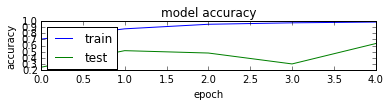

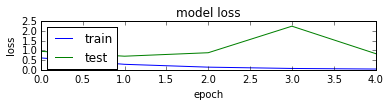

12 [ 0.93223321  0.06776684]
acc: 63.28%
81.64% (+/- 18.36%)


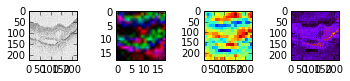

In [7]:
cv = cross_validation.KFold(4096, n_folds=32,shuffle=False,random_state=None)
for train_index, test_index in cv:
    if test_index[0]==1024 and test_index[0]<1151:
        print "The OCT Volume 9"
        pru=[]
        aba=[]
        for i in range(0,3968):
            at=all_input_3D[train_index[i]]
            pru.append(at)
        pru2=[]
        aba2=[]
        for j in range(0,128):
            at2=all_input_3D[test_index[j]]
            pru2.append(at2)
        X_tr, X_tes = np.asarray(pru), np.asarray(pru2)
        #y_tr, y_tes = np.asarray(aba), np.asarray(aba2)
        y_tr, y_tes = aba1[train_index[0:3968]],aba1[test_index[0:128]]
        print X_tr.shape, X_tes.shape, y_tr.shape, y_tes.shape
        # create model
        #model1 = Model(input=input, output=[dense3])
        #for layer in model1.layers:
        #    layer.trainable = True
        #model1 = Model(input=input, output=[dense3]
        model1.load_weights('model_OCTNET.h5')
        # Fit the model
        #model.fit(X_tr, y_tr, epochs=100, batch_size=32, verbose=1)
        checkpointer = ModelCheckpoint(filepath="/home/ojperdomoc/OCT_HES-SO/OCT_NET_9.hdf5", monitor='val_acc', verbose=1, save_best_only=True)
        history = model1.fit([X_tr], [y_tr], batch_size=batch_size, nb_epoch=nb_epochs,verbose=1,validation_data=(X_tes, y_tes),callbacks=[checkpointer])
        # evaluate the model
        bb1=model1.predict([X_tes])
        scores = model1.evaluate([X_tes], [y_tes], verbose=1)
        print('Test score:', scores[0])
        print('Test accuracy:', scores[1])
        #plt.imshow(Y_hat_mask[0].transpose(1,2,0).squeeze())
        #print('The number of OCT classified correctly are:', np.sum(bb1==label_0[test_index[0:128]]))
        #print('The test index',[test_index[0:128]][0],[test_index[0:128]][127])
        # list all data in history
        print(history.history.keys())
        ax1 = plt.subplot2grid((4,4), (0,0), colspan=4)
        # summarize history for accuracy
        plt.plot(history.history['acc'])
        plt.plot(history.history['val_acc'])
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()
        # summarize history for loss
        ax2 = plt.subplot2grid((4,4), (1,0), colspan=4)
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()
        Y_hat = conv10.eval({input: X_tes.astype('float32')})
        input2 = Input(shape=(256,18,18))
        final_conv1 = Convolution2D(1, 1, 1, activation='sigmoid')(input2)
        upsample13 = UpSampling2D(size=(13, 13), dim_ordering='th')(final_conv1)
        model_mask = Model(input=input2, output=[upsample13])
        Y_hat_mask = upsample13.eval({input2: Y_hat})
        slice_idx = random.randint(0, 127)
        #plt.figure()
        #plt.subplot(1,4,1)
        ax3 = plt.subplot2grid((4,4), (2, 0))
        plt.imshow((X_tes[slice_idx]).transpose(1,2,0))
        plt.savefig('0_'+str(test_index[0])+'.svg')
        #plt.subplot(1,4,2)
        ax4 = plt.subplot2grid((4,4), (2, 1))
        plt.imshow((Y_hat[slice_idx][0:3]).transpose(1,2,0))
        plt.savefig('1_'+str(test_index[0])+'.svg')
        #plt.subplot(1,4,3)
        ax5 = plt.subplot2grid((4,4), (2, 2))
        plt.imshow(Y_hat_mask[slice_idx].transpose(1,2,0).squeeze())
        plt.savefig('2_'+str(test_index[0])+'.svg')
        #plt.subplot(1,4,4)
        ax6 = plt.subplot2grid((4,4), (2, 3))
        mask_rsz=(Y_hat_mask[slice_idx].transpose(1,2,0).squeeze())#
        #data = imresize(np.asarray(Image.open(imaa))[:,:,0:3],scale_factor,'bicubic').astype('float32')
        mask_rsz1=imresize(mask_rsz,(224,224),'bicubic').astype('float32')
        over_all = np.zeros((224,224))
        over_all = ((X_tes[slice_idx]).transpose(1,2,0)[:,:,0])*(mask_rsz1)
        #over_all[:,:,1] = ((X_tes[slice_idx]).transpose(1,2,0)[:,:,1])*(mask_rsz1)
        #over_all[:,:,2] = ((X_tes[slice_idx]).transpose(1,2,0)[:,:,2])*(mask_rsz1)
        plt.imshow(over_all,cmap='gnuplot')
        plt.savefig('3_'+str(test_index[0])+'.svg')
        print slice_idx, bb1[slice_idx]
        print("%s: %.2f%%" % (model1.metrics_names[1], scores[1]*100))
        cvscores.append(scores[1] * 100)
        bb.append(bb1)
    else:
        test_index[0]
print("%.2f%% (+/- %.2f%%)" % (numpy.mean(cvscores), numpy.std(cvscores)))

The OCT Volume 10
(3968, 3, 224, 224) (128, 3, 224, 224) (3968, 2) (128, 2)
Train on 3968 samples, validate on 128 samples
Epoch 1/5
3968/3968 [==============================] - 63s - loss: 0.6097 - acc: 0.6716 - val_loss: 0.2982 - val_acc: 0.8750
Epoch 2/5
3968/3968 [==============================] - 70s - loss: 0.3179 - acc: 0.8682 - val_loss: 0.0325 - val_acc: 1.0000
Epoch 3/5
3968/3968 [==============================] - 62s - loss: 0.1716 - acc: 0.9322 - val_loss: 0.0411 - val_acc: 1.0000
Epoch 4/5
3968/3968 [==============================] - 62s - loss: 0.0808 - acc: 0.9710 - val_loss: 0.0034 - val_acc: 1.0000
Epoch 5/5
128/128 [==============================] - 0s     
('Test score:', 0.063527230406180024)
('Test accuracy:', 0.9765625)
['acc', 'loss', 'val_acc', 'val_loss']


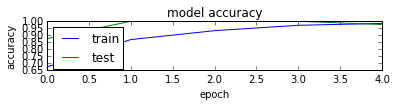

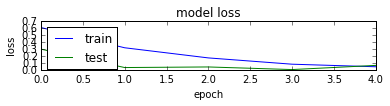

29 [  9.99866843e-01   1.33093403e-04]
acc: 97.66%
64.92% (+/- 25.98%)


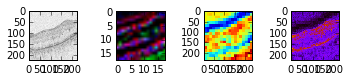

In [15]:
cv = cross_validation.KFold(4096, n_folds=32,shuffle=False,random_state=None)
for train_index, test_index in cv:
    if test_index[0]==1152 and test_index[0]<1279:
        print "The OCT Volume 10"
        pru=[]
        aba=[]
        for i in range(0,3968):
            at=all_input_3D[train_index[i]]
            pru.append(at)
        pru2=[]
        aba2=[]
        for j in range(0,128):
            at2=all_input_3D[test_index[j]]
            pru2.append(at2)
        X_tr, X_tes = np.asarray(pru), np.asarray(pru2)
        #y_tr, y_tes = np.asarray(aba), np.asarray(aba2)
        y_tr, y_tes = aba1[train_index[0:3968]],aba1[test_index[0:128]]
        print X_tr.shape, X_tes.shape, y_tr.shape, y_tes.shape
        # create model
        #model1 = Model(input=input, output=[dense3])
        #for layer in model1.layers:
        #    layer.trainable = True
        #model1 = Model(input=input, output=[dense3]
        model1.load_weights('model_OCTNET.h5')
        # Fit the model
        #model.fit(X_tr, y_tr, epochs=100, batch_size=32, verbose=1)
        checkpointer = ModelCheckpoint(filepath="/home/ojperdomoc/OCT_HES-SO/OCT_NET_10.hdf5", monitor='val_acc', verbose=1, save_best_only=True)
        history = model1.fit([X_tr], [y_tr], batch_size=batch_size, nb_epoch=nb_epochs,verbose=1,validation_data=(X_tes, y_tes),callbacks=[checkpointer])
        # evaluate the model
        bb1=model1.predict([X_tes])
        scores = model1.evaluate([X_tes], [y_tes], verbose=1)
        print('Test score:', scores[0])
        print('Test accuracy:', scores[1])
        #plt.imshow(Y_hat_mask[0].transpose(1,2,0).squeeze())
        #print('The number of OCT classified correctly are:', np.sum(bb1==label_0[test_index[0:128]]))
        #print('The test index',[test_index[0:128]][0],[test_index[0:128]][127])
        # list all data in history
        print(history.history.keys())
        ax1 = plt.subplot2grid((4,4), (0,0), colspan=4)
        # summarize history for accuracy
        plt.plot(history.history['acc'])
        plt.plot(history.history['val_acc'])
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()
        # summarize history for loss
        ax2 = plt.subplot2grid((4,4), (1,0), colspan=4)
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()
        Y_hat = conv10.eval({input: X_tes.astype('float32')})
        input2 = Input(shape=(256,18,18))
        final_conv1 = Convolution2D(1, 1, 1, activation='sigmoid')(input2)
        upsample13 = UpSampling2D(size=(13, 13), dim_ordering='th')(final_conv1)
        model_mask = Model(input=input2, output=[upsample13])
        Y_hat_mask = upsample13.eval({input2: Y_hat})
        slice_idx = random.randint(0, 127)
        #plt.figure()
        #plt.subplot(1,4,1)
        ax3 = plt.subplot2grid((4,4), (2, 0))
        plt.imshow((X_tes[slice_idx]).transpose(1,2,0))
        plt.savefig('0_'+str(test_index[0])+'.svg')
        #plt.subplot(1,4,2)
        ax4 = plt.subplot2grid((4,4), (2, 1))
        plt.imshow((Y_hat[slice_idx][0:3]).transpose(1,2,0))
        plt.savefig('1_'+str(test_index[0])+'.svg')
        #plt.subplot(1,4,3)
        ax5 = plt.subplot2grid((4,4), (2, 2))
        plt.imshow(Y_hat_mask[slice_idx].transpose(1,2,0).squeeze())
        plt.savefig('2_'+str(test_index[0])+'.svg')
        #plt.subplot(1,4,4)
        ax6 = plt.subplot2grid((4,4), (2, 3))
        mask_rsz=(Y_hat_mask[slice_idx].transpose(1,2,0).squeeze())#
        #data = imresize(np.asarray(Image.open(imaa))[:,:,0:3],scale_factor,'bicubic').astype('float32')
        mask_rsz1=imresize(mask_rsz,(224,224),'bicubic').astype('float32')
        over_all = np.zeros((224,224))
        over_all = ((X_tes[slice_idx]).transpose(1,2,0)[:,:,0])*(mask_rsz1)
        #over_all[:,:,1] = ((X_tes[slice_idx]).transpose(1,2,0)[:,:,1])*(mask_rsz1)
        #over_all[:,:,2] = ((X_tes[slice_idx]).transpose(1,2,0)[:,:,2])*(mask_rsz1)
        plt.imshow(over_all,cmap='gnuplot')
        plt.savefig('3_'+str(test_index[0])+'.svg')
        print slice_idx, bb1[slice_idx]
        print("%s: %.2f%%" % (model1.metrics_names[1], scores[1]*100))
        cvscores.append(scores[1] * 100)
        bb.append(bb1)
    else:
        test_index[0]
print("%.2f%% (+/- %.2f%%)" % (numpy.mean(cvscores), numpy.std(cvscores)))

The OCT Volume 11
(3968, 3, 224, 224) (128, 3, 224, 224) (3968, 2) (128, 2)
Train on 3968 samples, validate on 128 samples
Epoch 1/5
3968/3968 [==============================] - 63s - loss: 0.5866 - acc: 0.6903 - val_loss: 0.4032 - val_acc: 0.8906
Epoch 2/5
3968/3968 [==============================] - 62s - loss: 0.3253 - acc: 0.8579 - val_loss: 0.6466 - val_acc: 0.5938
Epoch 3/5
3968/3968 [==============================] - 62s - loss: 0.1672 - acc: 0.9309 - val_loss: 0.7221 - val_acc: 0.5859
Epoch 4/5
3968/3968 [==============================] - 69s - loss: 0.0874 - acc: 0.9672 - val_loss: 0.2107 - val_acc: 0.9453
Epoch 5/5
128/128 [==============================] - 0s     
('Test score:', 1.3212941586971283)
('Test accuracy:', 0.5390625)
['acc', 'loss', 'val_acc', 'val_loss']


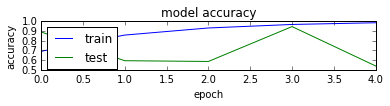

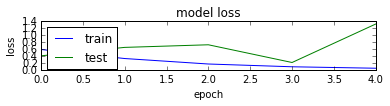

116 [ 0.83932185  0.16067815]
acc: 53.91%
63.92% (+/- 24.97%)


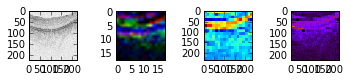

In [16]:
cv = cross_validation.KFold(4096, n_folds=32,shuffle=False,random_state=None)
for train_index, test_index in cv:
    if test_index[0]==1280 and test_index[0]<1407:
        print "The OCT Volume 11"
        pru=[]
        aba=[]
        for i in range(0,3968):
            at=all_input_3D[train_index[i]]
            pru.append(at)
        pru2=[]
        aba2=[]
        for j in range(0,128):
            at2=all_input_3D[test_index[j]]
            pru2.append(at2)
        X_tr, X_tes = np.asarray(pru), np.asarray(pru2)
        #y_tr, y_tes = np.asarray(aba), np.asarray(aba2)
        y_tr, y_tes = aba1[train_index[0:3968]],aba1[test_index[0:128]]
        print X_tr.shape, X_tes.shape, y_tr.shape, y_tes.shape
        # create model
        #model1 = Model(input=input, output=[dense3])
        #for layer in model1.layers:
        #    layer.trainable = True
        #model1 = Model(input=input, output=[dense3]
        model1.load_weights('model_OCTNET.h5')
        # Fit the model
        #model.fit(X_tr, y_tr, epochs=100, batch_size=32, verbose=1)
        checkpointer = ModelCheckpoint(filepath="/home/ojperdomoc/OCT_HES-SO/OCT_NET_11.hdf5", monitor='val_acc', verbose=1, save_best_only=True)
        history = model1.fit([X_tr], [y_tr], batch_size=batch_size, nb_epoch=nb_epochs,verbose=1,validation_data=(X_tes, y_tes),callbacks=[checkpointer])
        # evaluate the model
        bb1=model1.predict([X_tes])
        scores = model1.evaluate([X_tes], [y_tes], verbose=1)
        print('Test score:', scores[0])
        print('Test accuracy:', scores[1])
        #plt.imshow(Y_hat_mask[0].transpose(1,2,0).squeeze())
        #print('The number of OCT classified correctly are:', np.sum(bb1==label_0[test_index[0:128]]))
        #print('The test index',[test_index[0:128]][0],[test_index[0:128]][127])
        # list all data in history
        print(history.history.keys())
        ax1 = plt.subplot2grid((4,4), (0,0), colspan=4)
        # summarize history for accuracy
        plt.plot(history.history['acc'])
        plt.plot(history.history['val_acc'])
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()
        # summarize history for loss
        ax2 = plt.subplot2grid((4,4), (1,0), colspan=4)
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()
        Y_hat = conv10.eval({input: X_tes.astype('float32')})
        input2 = Input(shape=(256,18,18))
        final_conv1 = Convolution2D(1, 1, 1, activation='sigmoid')(input2)
        upsample13 = UpSampling2D(size=(13, 13), dim_ordering='th')(final_conv1)
        model_mask = Model(input=input2, output=[upsample13])
        Y_hat_mask = upsample13.eval({input2: Y_hat})
        slice_idx = random.randint(0, 127)
        #plt.figure()
        #plt.subplot(1,4,1)
        ax3 = plt.subplot2grid((4,4), (2, 0))
        plt.imshow((X_tes[slice_idx]).transpose(1,2,0))
        plt.savefig('0_'+str(test_index[0])+'.svg')
        #plt.subplot(1,4,2)
        ax4 = plt.subplot2grid((4,4), (2, 1))
        plt.imshow((Y_hat[slice_idx][0:3]).transpose(1,2,0))
        plt.savefig('1_'+str(test_index[0])+'.svg')
        #plt.subplot(1,4,3)
        ax5 = plt.subplot2grid((4,4), (2, 2))
        plt.imshow(Y_hat_mask[slice_idx].transpose(1,2,0).squeeze())
        plt.savefig('2_'+str(test_index[0])+'.svg')
        #plt.subplot(1,4,4)
        ax6 = plt.subplot2grid((4,4), (2, 3))
        mask_rsz=(Y_hat_mask[slice_idx].transpose(1,2,0).squeeze())#
        #data = imresize(np.asarray(Image.open(imaa))[:,:,0:3],scale_factor,'bicubic').astype('float32')
        mask_rsz1=imresize(mask_rsz,(224,224),'bicubic').astype('float32')
        over_all = np.zeros((224,224))
        over_all = ((X_tes[slice_idx]).transpose(1,2,0)[:,:,0])*(mask_rsz1)
        #over_all[:,:,1] = ((X_tes[slice_idx]).transpose(1,2,0)[:,:,1])*(mask_rsz1)
        #over_all[:,:,2] = ((X_tes[slice_idx]).transpose(1,2,0)[:,:,2])*(mask_rsz1)
        plt.imshow(over_all,cmap='gnuplot')
        plt.savefig('3_'+str(test_index[0])+'.svg')
        print slice_idx, bb1[slice_idx]
        print("%s: %.2f%%" % (model1.metrics_names[1], scores[1]*100))
        cvscores.append(scores[1] * 100)
        bb.append(bb1)
    else:
        test_index[0]
print("%.2f%% (+/- %.2f%%)" % (numpy.mean(cvscores), numpy.std(cvscores)))

The OCT Volume 12
(3968, 3, 224, 224) (128, 3, 224, 224) (3968, 2) (128, 2)
Train on 3968 samples, validate on 128 samples
Epoch 1/5
3968/3968 [==============================] - 63s - loss: 0.5922 - acc: 0.6787 - val_loss: 0.4106 - val_acc: 0.9922
Epoch 2/5
3968/3968 [==============================] - 62s - loss: 0.3226 - acc: 0.8669 - val_loss: 0.2111 - val_acc: 0.9766
Epoch 3/5
3968/3968 [==============================] - 62s - loss: 0.1612 - acc: 0.9420 - val_loss: 0.1201 - val_acc: 0.9922
Epoch 4/5
3968/3968 [==============================] - 62s - loss: 0.0816 - acc: 0.9708 - val_loss: 0.0666 - val_acc: 0.9922
Epoch 5/5
128/128 [==============================] - 0s     
('Test score:', 0.026686084689572453)
('Test accuracy:', 1.0)
['acc', 'loss', 'val_acc', 'val_loss']


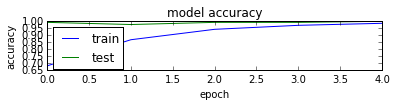

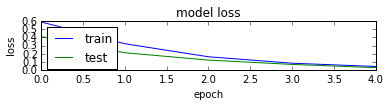

88 [ 0.17123939  0.82876062]
acc: 100.00%
66.93% (+/- 25.90%)


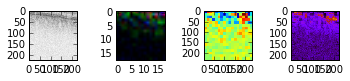

In [17]:
cv = cross_validation.KFold(4096, n_folds=32,shuffle=False,random_state=None)
for train_index, test_index in cv:
    if test_index[0]==1408 and test_index[0]<1535:
        print "The OCT Volume 12"
        pru=[]
        aba=[]
        for i in range(0,3968):
            at=all_input_3D[train_index[i]]
            pru.append(at)
        pru2=[]
        aba2=[]
        for j in range(0,128):
            at2=all_input_3D[test_index[j]]
            pru2.append(at2)
        X_tr, X_tes = np.asarray(pru), np.asarray(pru2)
        #y_tr, y_tes = np.asarray(aba), np.asarray(aba2)
        y_tr, y_tes = aba1[train_index[0:3968]],aba1[test_index[0:128]]
        print X_tr.shape, X_tes.shape, y_tr.shape, y_tes.shape
        # create model
        #model1 = Model(input=input, output=[dense3])
        #for layer in model1.layers:
        #    layer.trainable = True
        #model1 = Model(input=input, output=[dense3]
        model1.load_weights('model_OCTNET.h5')
        # Fit the model
        #model.fit(X_tr, y_tr, epochs=100, batch_size=32, verbose=1)
        checkpointer = ModelCheckpoint(filepath="/home/ojperdomoc/OCT_HES-SO/OCT_NET_12.hdf5", monitor='val_acc', verbose=1, save_best_only=True)
        history = model1.fit([X_tr], [y_tr], batch_size=batch_size, nb_epoch=nb_epochs,verbose=1,validation_data=(X_tes, y_tes),callbacks=[checkpointer])
        # evaluate the model
        bb1=model1.predict([X_tes])
        scores = model1.evaluate([X_tes], [y_tes], verbose=1)
        print('Test score:', scores[0])
        print('Test accuracy:', scores[1])
        #plt.imshow(Y_hat_mask[0].transpose(1,2,0).squeeze())
        #print('The number of OCT classified correctly are:', np.sum(bb1==label_0[test_index[0:128]]))
        #print('The test index',[test_index[0:128]][0],[test_index[0:128]][127])
        # list all data in history
        print(history.history.keys())
        ax1 = plt.subplot2grid((4,4), (0,0), colspan=4)
        # summarize history for accuracy
        plt.plot(history.history['acc'])
        plt.plot(history.history['val_acc'])
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()
        # summarize history for loss
        ax2 = plt.subplot2grid((4,4), (1,0), colspan=4)
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()
        Y_hat = conv10.eval({input: X_tes.astype('float32')})
        input2 = Input(shape=(256,18,18))
        final_conv1 = Convolution2D(1, 1, 1, activation='sigmoid')(input2)
        upsample13 = UpSampling2D(size=(13, 13), dim_ordering='th')(final_conv1)
        model_mask = Model(input=input2, output=[upsample13])
        Y_hat_mask = upsample13.eval({input2: Y_hat})
        slice_idx = random.randint(0, 127)
        #plt.figure()
        #plt.subplot(1,4,1)
        ax3 = plt.subplot2grid((4,4), (2, 0))
        plt.imshow((X_tes[slice_idx]).transpose(1,2,0))
        plt.savefig('0_'+str(test_index[0])+'.svg')
        #plt.subplot(1,4,2)
        ax4 = plt.subplot2grid((4,4), (2, 1))
        plt.imshow((Y_hat[slice_idx][0:3]).transpose(1,2,0))
        plt.savefig('1_'+str(test_index[0])+'.svg')
        #plt.subplot(1,4,3)
        ax5 = plt.subplot2grid((4,4), (2, 2))
        plt.imshow(Y_hat_mask[slice_idx].transpose(1,2,0).squeeze())
        plt.savefig('2_'+str(test_index[0])+'.svg')
        #plt.subplot(1,4,4)
        ax6 = plt.subplot2grid((4,4), (2, 3))
        mask_rsz=(Y_hat_mask[slice_idx].transpose(1,2,0).squeeze())#
        #data = imresize(np.asarray(Image.open(imaa))[:,:,0:3],scale_factor,'bicubic').astype('float32')
        mask_rsz1=imresize(mask_rsz,(224,224),'bicubic').astype('float32')
        over_all = np.zeros((224,224))
        over_all = ((X_tes[slice_idx]).transpose(1,2,0)[:,:,0])*(mask_rsz1)
        #over_all[:,:,1] = ((X_tes[slice_idx]).transpose(1,2,0)[:,:,1])*(mask_rsz1)
        #over_all[:,:,2] = ((X_tes[slice_idx]).transpose(1,2,0)[:,:,2])*(mask_rsz1)
        plt.imshow(over_all,cmap='gnuplot')
        plt.savefig('3_'+str(test_index[0])+'.svg')
        print slice_idx, bb1[slice_idx]
        print("%s: %.2f%%" % (model1.metrics_names[1], scores[1]*100))
        cvscores.append(scores[1] * 100)
        bb.append(bb1)
    else:
        test_index[0]
print("%.2f%% (+/- %.2f%%)" % (numpy.mean(cvscores), numpy.std(cvscores)))

The OCT Volume 13
(3968, 3, 224, 224) (128, 3, 224, 224) (3968, 2) (128, 2)
Train on 3968 samples, validate on 128 samples
Epoch 1/5
3968/3968 [==============================] - 62s - loss: 0.5941 - acc: 0.6842 - val_loss: 0.2833 - val_acc: 1.0000
Epoch 2/5
3968/3968 [==============================] - 62s - loss: 0.3189 - acc: 0.8609 - val_loss: 0.0899 - val_acc: 1.0000
Epoch 3/5
3968/3968 [==============================] - 62s - loss: 0.1652 - acc: 0.9350 - val_loss: 0.2422 - val_acc: 0.8438
Epoch 4/5
3968/3968 [==============================] - 62s - loss: 0.0809 - acc: 0.9680 - val_loss: 0.1023 - val_acc: 0.9609
Epoch 5/5
128/128 [==============================] - 0s     
('Test score:', 0.16212725639343262)
('Test accuracy:', 0.9375)
['acc', 'loss', 'val_acc', 'val_loss']


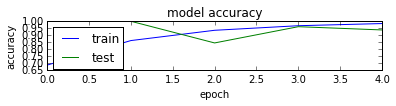

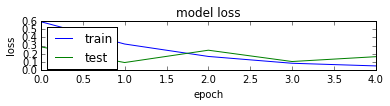

66 [ 0.40821075  0.59178925]
acc: 93.75%
68.99% (+/- 25.89%)


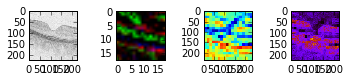

In [18]:
cv = cross_validation.KFold(4096, n_folds=32,shuffle=False,random_state=None)
for train_index, test_index in cv:
    if test_index[0]==1536 and test_index[0]<1663:
        print "The OCT Volume 13"
        pru=[]
        aba=[]
        for i in range(0,3968):
            at=all_input_3D[train_index[i]]
            pru.append(at)
        pru2=[]
        aba2=[]
        for j in range(0,128):
            at2=all_input_3D[test_index[j]]
            pru2.append(at2)
        X_tr, X_tes = np.asarray(pru), np.asarray(pru2)
        #y_tr, y_tes = np.asarray(aba), np.asarray(aba2)
        y_tr, y_tes = aba1[train_index[0:3968]],aba1[test_index[0:128]]
        print X_tr.shape, X_tes.shape, y_tr.shape, y_tes.shape
        # create model
        #model1 = Model(input=input, output=[dense3])
        #for layer in model1.layers:
        #    layer.trainable = True
        #model1 = Model(input=input, output=[dense3]
        model1.load_weights('model_OCTNET.h5')
        # Fit the model
        #model.fit(X_tr, y_tr, epochs=100, batch_size=32, verbose=1)
        checkpointer = ModelCheckpoint(filepath="/home/ojperdomoc/OCT_HES-SO/OCT_NET_13.hdf5", monitor='val_acc', verbose=1, save_best_only=True)
        history = model1.fit([X_tr], [y_tr], batch_size=batch_size, nb_epoch=nb_epochs,verbose=1,validation_data=(X_tes, y_tes),callbacks=[checkpointer])
        # evaluate the model
        bb1=model1.predict([X_tes])
        scores = model1.evaluate([X_tes], [y_tes], verbose=1)
        print('Test score:', scores[0])
        print('Test accuracy:', scores[1])
        #plt.imshow(Y_hat_mask[0].transpose(1,2,0).squeeze())
        #print('The number of OCT classified correctly are:', np.sum(bb1==label_0[test_index[0:128]]))
        #print('The test index',[test_index[0:128]][0],[test_index[0:128]][127])
        # list all data in history
        print(history.history.keys())
        ax1 = plt.subplot2grid((4,4), (0,0), colspan=4)
        # summarize history for accuracy
        plt.plot(history.history['acc'])
        plt.plot(history.history['val_acc'])
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()
        # summarize history for loss
        ax2 = plt.subplot2grid((4,4), (1,0), colspan=4)
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()
        Y_hat = conv10.eval({input: X_tes.astype('float32')})
        input2 = Input(shape=(256,18,18))
        final_conv1 = Convolution2D(1, 1, 1, activation='sigmoid')(input2)
        upsample13 = UpSampling2D(size=(13, 13), dim_ordering='th')(final_conv1)
        model_mask = Model(input=input2, output=[upsample13])
        Y_hat_mask = upsample13.eval({input2: Y_hat})
        slice_idx = random.randint(0, 127)
        #plt.figure()
        #plt.subplot(1,4,1)
        ax3 = plt.subplot2grid((4,4), (2, 0))
        plt.imshow((X_tes[slice_idx]).transpose(1,2,0))
        plt.savefig('0_'+str(test_index[0])+'.svg')
        #plt.subplot(1,4,2)
        ax4 = plt.subplot2grid((4,4), (2, 1))
        plt.imshow((Y_hat[slice_idx][0:3]).transpose(1,2,0))
        plt.savefig('1_'+str(test_index[0])+'.svg')
        #plt.subplot(1,4,3)
        ax5 = plt.subplot2grid((4,4), (2, 2))
        plt.imshow(Y_hat_mask[slice_idx].transpose(1,2,0).squeeze())
        plt.savefig('2_'+str(test_index[0])+'.svg')
        #plt.subplot(1,4,4)
        ax6 = plt.subplot2grid((4,4), (2, 3))
        mask_rsz=(Y_hat_mask[slice_idx].transpose(1,2,0).squeeze())#
        #data = imresize(np.asarray(Image.open(imaa))[:,:,0:3],scale_factor,'bicubic').astype('float32')
        mask_rsz1=imresize(mask_rsz,(224,224),'bicubic').astype('float32')
        over_all = np.zeros((224,224))
        over_all = ((X_tes[slice_idx]).transpose(1,2,0)[:,:,0])*(mask_rsz1)
        #over_all[:,:,1] = ((X_tes[slice_idx]).transpose(1,2,0)[:,:,1])*(mask_rsz1)
        #over_all[:,:,2] = ((X_tes[slice_idx]).transpose(1,2,0)[:,:,2])*(mask_rsz1)
        plt.imshow(over_all,cmap='gnuplot')
        plt.savefig('3_'+str(test_index[0])+'.svg')
        print slice_idx, bb1[slice_idx]
        print("%s: %.2f%%" % (model1.metrics_names[1], scores[1]*100))
        cvscores.append(scores[1] * 100)
        bb.append(bb1)
    else:
        test_index[0]
print("%.2f%% (+/- %.2f%%)" % (numpy.mean(cvscores), numpy.std(cvscores)))

The OCT Volume 14
(3968, 3, 224, 224) (128, 3, 224, 224) (3968, 2) (128, 2)
Train on 3968 samples, validate on 128 samples
Epoch 1/5
3968/3968 [==============================] - 67s - loss: 0.6119 - acc: 0.6847 - val_loss: 1.3392 - val_acc: 0.4297
Epoch 2/5
3968/3968 [==============================] - 61s - loss: 0.3195 - acc: 0.8634 - val_loss: 4.1322 - val_acc: 0.0312
Epoch 3/5
3968/3968 [==============================] - 62s - loss: 0.1465 - acc: 0.9428 - val_loss: 9.2949 - val_acc: 0.0000e+00
Epoch 4/5
3968/3968 [==============================] - 62s - loss: 0.0693 - acc: 0.9753 - val_loss: 6.9401 - val_acc: 0.0625
Epoch 5/5
128/128 [==============================] - 0s     
('Test score:', 10.703272342681885)
('Test accuracy:', 0.0)
['acc', 'loss', 'val_acc', 'val_loss']


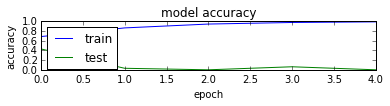

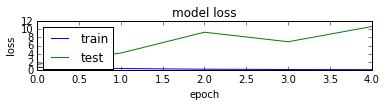

127 [  1.00000000e+00   1.32469937e-08]
acc: 0.00%
0.00% (+/- 0.00%)


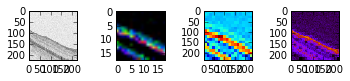

In [7]:
cv = cross_validation.KFold(4096, n_folds=32,shuffle=False,random_state=None)
for train_index, test_index in cv:
    if test_index[0]==1664 and test_index[0]<1791:
        print "The OCT Volume 14"
        pru=[]
        aba=[]
        for i in range(0,3968):
            at=all_input_3D[train_index[i]]
            pru.append(at)
        pru2=[]
        aba2=[]
        for j in range(0,128):
            at2=all_input_3D[test_index[j]]
            pru2.append(at2)
        X_tr, X_tes = np.asarray(pru), np.asarray(pru2)
        #y_tr, y_tes = np.asarray(aba), np.asarray(aba2)
        y_tr, y_tes = aba1[train_index[0:3968]],aba1[test_index[0:128]]
        print X_tr.shape, X_tes.shape, y_tr.shape, y_tes.shape
        # create model
        #model1 = Model(input=input, output=[dense3])
        #for layer in model1.layers:
        #    layer.trainable = True
        #model1 = Model(input=input, output=[dense3]
        model1.load_weights('model_OCTNET.h5')
        # Fit the model
        #model.fit(X_tr, y_tr, epochs=100, batch_size=32, verbose=1)
        checkpointer = ModelCheckpoint(filepath="/home/ojperdomoc/OCT_HES-SO/OCT_NET_14.hdf5", monitor='val_acc', verbose=1, save_best_only=True)
        history = model1.fit([X_tr], [y_tr], batch_size=batch_size, nb_epoch=nb_epochs,verbose=1,validation_data=(X_tes, y_tes),callbacks=[checkpointer])
        # evaluate the model
        bb1=model1.predict([X_tes])
        scores = model1.evaluate([X_tes], [y_tes], verbose=1)
        print('Test score:', scores[0])
        print('Test accuracy:', scores[1])
        #plt.imshow(Y_hat_mask[0].transpose(1,2,0).squeeze())
        #print('The number of OCT classified correctly are:', np.sum(bb1==label_0[test_index[0:128]]))
        #print('The test index',[test_index[0:128]][0],[test_index[0:128]][127])
        # list all data in history
        print(history.history.keys())
        ax1 = plt.subplot2grid((4,4), (0,0), colspan=4)
        # summarize history for accuracy
        plt.plot(history.history['acc'])
        plt.plot(history.history['val_acc'])
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()
        # summarize history for loss
        ax2 = plt.subplot2grid((4,4), (1,0), colspan=4)
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()
        Y_hat = conv10.eval({input: X_tes.astype('float32')})
        input2 = Input(shape=(256,18,18))
        final_conv1 = Convolution2D(1, 1, 1, activation='sigmoid')(input2)
        upsample13 = UpSampling2D(size=(13, 13), dim_ordering='th')(final_conv1)
        model_mask = Model(input=input2, output=[upsample13])
        Y_hat_mask = upsample13.eval({input2: Y_hat})
        slice_idx = random.randint(0, 127)
        #plt.figure()
        #plt.subplot(1,4,1)
        ax3 = plt.subplot2grid((4,4), (2, 0))
        plt.imshow((X_tes[slice_idx]).transpose(1,2,0))
        plt.savefig('0_'+str(test_index[0])+'.svg')
        #plt.subplot(1,4,2)
        ax4 = plt.subplot2grid((4,4), (2, 1))
        plt.imshow((Y_hat[slice_idx][0:3]).transpose(1,2,0))
        plt.savefig('1_'+str(test_index[0])+'.svg')
        #plt.subplot(1,4,3)
        ax5 = plt.subplot2grid((4,4), (2, 2))
        plt.imshow(Y_hat_mask[slice_idx].transpose(1,2,0).squeeze())
        plt.savefig('2_'+str(test_index[0])+'.svg')
        #plt.subplot(1,4,4)
        ax6 = plt.subplot2grid((4,4), (2, 3))
        mask_rsz=(Y_hat_mask[slice_idx].transpose(1,2,0).squeeze())#
        #data = imresize(np.asarray(Image.open(imaa))[:,:,0:3],scale_factor,'bicubic').astype('float32')
        mask_rsz1=imresize(mask_rsz,(224,224),'bicubic').astype('float32')
        over_all = np.zeros((224,224))
        over_all = ((X_tes[slice_idx]).transpose(1,2,0)[:,:,0])*(mask_rsz1)
        #over_all[:,:,1] = ((X_tes[slice_idx]).transpose(1,2,0)[:,:,1])*(mask_rsz1)
        #over_all[:,:,2] = ((X_tes[slice_idx]).transpose(1,2,0)[:,:,2])*(mask_rsz1)
        plt.imshow(over_all,cmap='gnuplot')
        plt.savefig('3_'+str(test_index[0])+'.svg')
        print slice_idx, bb1[slice_idx]
        print("%s: %.2f%%" % (model1.metrics_names[1], scores[1]*100))
        cvscores.append(scores[1] * 100)
        bb.append(bb1)
    else:
        test_index[0]
print("%.2f%% (+/- %.2f%%)" % (numpy.mean(cvscores), numpy.std(cvscores)))

The OCT Volume 15
(3968, 3, 224, 224) (128, 3, 224, 224) (3968, 2) (128, 2)
Train on 3968 samples, validate on 128 samples
Epoch 1/5
3968/3968 [==============================] - 63s - loss: 0.5930 - acc: 0.6890 - val_loss: 1.5756 - val_acc: 0.1562
Epoch 2/5
3968/3968 [==============================] - 69s - loss: 0.3317 - acc: 0.8594 - val_loss: 0.8223 - val_acc: 0.5859
Epoch 3/5
3968/3968 [==============================] - 62s - loss: 0.1683 - acc: 0.9367 - val_loss: 1.1914 - val_acc: 0.5781
Epoch 4/5
3968/3968 [==============================] - 62s - loss: 0.0844 - acc: 0.9703 - val_loss: 2.1153 - val_acc: 0.4141
Epoch 5/5
128/128 [==============================] - 0s     
('Test score:', 1.6828828454017639)
('Test accuracy:', 0.5703125)
['acc', 'loss', 'val_acc', 'val_loss']


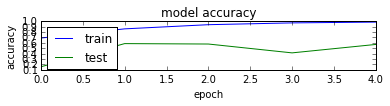

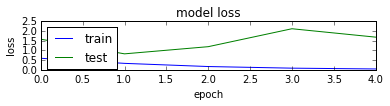

79 [ 0.99236006  0.00764001]
acc: 57.03%
63.75% (+/- 29.31%)


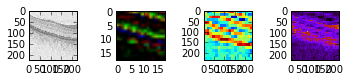

In [20]:
cv = cross_validation.KFold(4096, n_folds=32,shuffle=False,random_state=None)
for train_index, test_index in cv:
    if test_index[0]==1792 and test_index[0]<1919:
        print "The OCT Volume 15"
        pru=[]
        aba=[]
        for i in range(0,3968):
            at=all_input_3D[train_index[i]]
            pru.append(at)
        pru2=[]
        aba2=[]
        for j in range(0,128):
            at2=all_input_3D[test_index[j]]
            pru2.append(at2)
        X_tr, X_tes = np.asarray(pru), np.asarray(pru2)
        #y_tr, y_tes = np.asarray(aba), np.asarray(aba2)
        y_tr, y_tes = aba1[train_index[0:3968]],aba1[test_index[0:128]]
        print X_tr.shape, X_tes.shape, y_tr.shape, y_tes.shape
        # create model
        #model1 = Model(input=input, output=[dense3])
        #for layer in model1.layers:
        #    layer.trainable = True
        #model1 = Model(input=input, output=[dense3]
        model1.load_weights('model_OCTNET.h5')
        # Fit the model
        #model.fit(X_tr, y_tr, epochs=100, batch_size=32, verbose=1)
        checkpointer = ModelCheckpoint(filepath="/home/ojperdomoc/OCT_HES-SO/OCT_NET_15.hdf5", monitor='val_acc', verbose=1, save_best_only=True)
        history = model1.fit([X_tr], [y_tr], batch_size=batch_size, nb_epoch=nb_epochs,verbose=1,validation_data=(X_tes, y_tes),callbacks=[checkpointer])
        # evaluate the model
        bb1=model1.predict([X_tes])
        scores = model1.evaluate([X_tes], [y_tes], verbose=1)
        print('Test score:', scores[0])
        print('Test accuracy:', scores[1])
        #plt.imshow(Y_hat_mask[0].transpose(1,2,0).squeeze())
        #print('The number of OCT classified correctly are:', np.sum(bb1==label_0[test_index[0:128]]))
        #print('The test index',[test_index[0:128]][0],[test_index[0:128]][127])
        # list all data in history
        print(history.history.keys())
        ax1 = plt.subplot2grid((4,4), (0,0), colspan=4)
        # summarize history for accuracy
        plt.plot(history.history['acc'])
        plt.plot(history.history['val_acc'])
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()
        # summarize history for loss
        ax2 = plt.subplot2grid((4,4), (1,0), colspan=4)
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()
        Y_hat = conv10.eval({input: X_tes.astype('float32')})
        input2 = Input(shape=(256,18,18))
        final_conv1 = Convolution2D(1, 1, 1, activation='sigmoid')(input2)
        upsample13 = UpSampling2D(size=(13, 13), dim_ordering='th')(final_conv1)
        model_mask = Model(input=input2, output=[upsample13])
        Y_hat_mask = upsample13.eval({input2: Y_hat})
        slice_idx = random.randint(0, 127)
        #plt.figure()
        #plt.subplot(1,4,1)
        ax3 = plt.subplot2grid((4,4), (2, 0))
        plt.imshow((X_tes[slice_idx]).transpose(1,2,0))
        plt.savefig('0_'+str(test_index[0])+'.svg')
        #plt.subplot(1,4,2)
        ax4 = plt.subplot2grid((4,4), (2, 1))
        plt.imshow((Y_hat[slice_idx][0:3]).transpose(1,2,0))
        plt.savefig('1_'+str(test_index[0])+'.svg')
        #plt.subplot(1,4,3)
        ax5 = plt.subplot2grid((4,4), (2, 2))
        plt.imshow(Y_hat_mask[slice_idx].transpose(1,2,0).squeeze())
        plt.savefig('2_'+str(test_index[0])+'.svg')
        #plt.subplot(1,4,4)
        ax6 = plt.subplot2grid((4,4), (2, 3))
        mask_rsz=(Y_hat_mask[slice_idx].transpose(1,2,0).squeeze())#
        #data = imresize(np.asarray(Image.open(imaa))[:,:,0:3],scale_factor,'bicubic').astype('float32')
        mask_rsz1=imresize(mask_rsz,(224,224),'bicubic').astype('float32')
        over_all = np.zeros((224,224))
        over_all = ((X_tes[slice_idx]).transpose(1,2,0)[:,:,0])*(mask_rsz1)
        #over_all[:,:,1] = ((X_tes[slice_idx]).transpose(1,2,0)[:,:,1])*(mask_rsz1)
        #over_all[:,:,2] = ((X_tes[slice_idx]).transpose(1,2,0)[:,:,2])*(mask_rsz1)
        plt.imshow(over_all,cmap='gnuplot')
        plt.savefig('3_'+str(test_index[0])+'.svg')
        print slice_idx, bb1[slice_idx]
        print("%s: %.2f%%" % (model1.metrics_names[1], scores[1]*100))
        cvscores.append(scores[1] * 100)
        bb.append(bb1)
    else:
        test_index[0]
print("%.2f%% (+/- %.2f%%)" % (numpy.mean(cvscores), numpy.std(cvscores)))

The OCT Volume 16
(3968, 3, 224, 224) (128, 3, 224, 224) (3968, 2) (128, 2)
Train on 3968 samples, validate on 128 samples
Epoch 1/5
3968/3968 [==============================] - 63s - loss: 0.5969 - acc: 0.6855 - val_loss: 0.4117 - val_acc: 0.9219
Epoch 2/5
3968/3968 [==============================] - 62s - loss: 0.3116 - acc: 0.8662 - val_loss: 0.7431 - val_acc: 0.7109
Epoch 3/5
3968/3968 [==============================] - 62s - loss: 0.1633 - acc: 0.9372 - val_loss: 0.1877 - val_acc: 0.9062
Epoch 4/5
3968/3968 [==============================] - 68s - loss: 0.0804 - acc: 0.9710 - val_loss: 0.1584 - val_acc: 0.9375
Epoch 5/5
128/128 [==============================] - 0s     
('Test score:', 0.66594874113798141)
('Test accuracy:', 0.7578125)
['acc', 'loss', 'val_acc', 'val_loss']


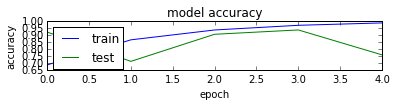

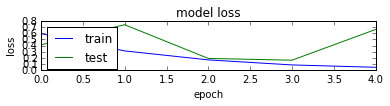

102 [ 0.27147096  0.72852904]
acc: 75.78%
64.50% (+/- 28.53%)


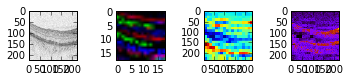

In [21]:
cv = cross_validation.KFold(4096, n_folds=32,shuffle=False,random_state=None)
for train_index, test_index in cv:
    if test_index[0]==1920 and test_index[0]<2047:
        print "The OCT Volume 16"
        pru=[]
        aba=[]
        for i in range(0,3968):
            at=all_input_3D[train_index[i]]
            pru.append(at)
        pru2=[]
        aba2=[]
        for j in range(0,128):
            at2=all_input_3D[test_index[j]]
            pru2.append(at2)
        X_tr, X_tes = np.asarray(pru), np.asarray(pru2)
        #y_tr, y_tes = np.asarray(aba), np.asarray(aba2)
        y_tr, y_tes = aba1[train_index[0:3968]],aba1[test_index[0:128]]
        print X_tr.shape, X_tes.shape, y_tr.shape, y_tes.shape
        # create model
        #model1 = Model(input=input, output=[dense3])
        #for layer in model1.layers:
        #    layer.trainable = True
        #model1 = Model(input=input, output=[dense3]
        model1.load_weights('model_OCTNET.h5')
        # Fit the model
        #model.fit(X_tr, y_tr, epochs=100, batch_size=32, verbose=1)
        checkpointer = ModelCheckpoint(filepath="/home/ojperdomoc/OCT_HES-SO/OCT_NET_16.hdf5", monitor='val_acc', verbose=1, save_best_only=True)
        history = model1.fit([X_tr], [y_tr], batch_size=batch_size, nb_epoch=nb_epochs,verbose=1,validation_data=(X_tes, y_tes),callbacks=[checkpointer])
        # evaluate the model
        bb1=model1.predict([X_tes])
        scores = model1.evaluate([X_tes], [y_tes], verbose=1)
        print('Test score:', scores[0])
        print('Test accuracy:', scores[1])
        #plt.imshow(Y_hat_mask[0].transpose(1,2,0).squeeze())
        #print('The number of OCT classified correctly are:', np.sum(bb1==label_0[test_index[0:128]]))
        #print('The test index',[test_index[0:128]][0],[test_index[0:128]][127])
        # list all data in history
        print(history.history.keys())
        ax1 = plt.subplot2grid((4,4), (0,0), colspan=4)
        # summarize history for accuracy
        plt.plot(history.history['acc'])
        plt.plot(history.history['val_acc'])
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()
        # summarize history for loss
        ax2 = plt.subplot2grid((4,4), (1,0), colspan=4)
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()
        Y_hat = conv10.eval({input: X_tes.astype('float32')})
        input2 = Input(shape=(256,18,18))
        final_conv1 = Convolution2D(1, 1, 1, activation='sigmoid')(input2)
        upsample13 = UpSampling2D(size=(13, 13), dim_ordering='th')(final_conv1)
        model_mask = Model(input=input2, output=[upsample13])
        Y_hat_mask = upsample13.eval({input2: Y_hat})
        slice_idx = random.randint(0, 127)
        #plt.figure()
        #plt.subplot(1,4,1)
        ax3 = plt.subplot2grid((4,4), (2, 0))
        plt.imshow((X_tes[slice_idx]).transpose(1,2,0))
        plt.savefig('0_'+str(test_index[0])+'.svg')
        #plt.subplot(1,4,2)
        ax4 = plt.subplot2grid((4,4), (2, 1))
        plt.imshow((Y_hat[slice_idx][0:3]).transpose(1,2,0))
        plt.savefig('1_'+str(test_index[0])+'.svg')
        #plt.subplot(1,4,3)
        ax5 = plt.subplot2grid((4,4), (2, 2))
        plt.imshow(Y_hat_mask[slice_idx].transpose(1,2,0).squeeze())
        plt.savefig('2_'+str(test_index[0])+'.svg')
        #plt.subplot(1,4,4)
        ax6 = plt.subplot2grid((4,4), (2, 3))
        mask_rsz=(Y_hat_mask[slice_idx].transpose(1,2,0).squeeze())#
        #data = imresize(np.asarray(Image.open(imaa))[:,:,0:3],scale_factor,'bicubic').astype('float32')
        mask_rsz1=imresize(mask_rsz,(224,224),'bicubic').astype('float32')
        over_all = np.zeros((224,224))
        over_all = ((X_tes[slice_idx]).transpose(1,2,0)[:,:,0])*(mask_rsz1)
        #over_all[:,:,1] = ((X_tes[slice_idx]).transpose(1,2,0)[:,:,1])*(mask_rsz1)
        #over_all[:,:,2] = ((X_tes[slice_idx]).transpose(1,2,0)[:,:,2])*(mask_rsz1)
        plt.imshow(over_all,cmap='gnuplot')
        plt.savefig('3_'+str(test_index[0])+'.svg')
        print slice_idx, bb1[slice_idx]
        print("%s: %.2f%%" % (model1.metrics_names[1], scores[1]*100))
        cvscores.append(scores[1] * 100)
        bb.append(bb1)
    else:
        test_index[0]
print("%.2f%% (+/- %.2f%%)" % (numpy.mean(cvscores), numpy.std(cvscores)))

The OCT Volume 17
(3968, 3, 224, 224) (128, 3, 224, 224) (3968, 2) (128, 2)
Train on 3968 samples, validate on 128 samples
Epoch 1/5
3968/3968 [==============================] - 99s - loss: 0.6018 - acc: 0.6885 - val_loss: 1.9133 - val_acc: 0.0000e+00
Epoch 2/5
3968/3968 [==============================] - 92s - loss: 0.2855 - acc: 0.8755 - val_loss: 4.6499 - val_acc: 0.0000e+00
Epoch 3/5
3968/3968 [==============================] - 98s - loss: 0.1561 - acc: 0.9398 - val_loss: 2.3578 - val_acc: 0.0078
Epoch 4/5
3968/3968 [==============================] - 92s - loss: 0.0752 - acc: 0.9715 - val_loss: 5.9603 - val_acc: 0.0000e+00
Epoch 5/5
128/128 [==============================] - 0s     
('Test score:', 5.5430080890655518)
('Test accuracy:', 0.0)
['acc', 'loss', 'val_acc', 'val_loss']


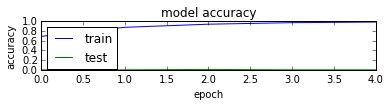

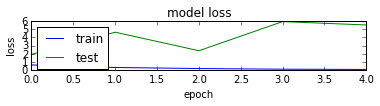

80 [ 0.99900085  0.00099914]
acc: 0.00%
22.58% (+/- 8.84%)


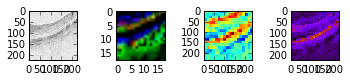

In [42]:
cv = cross_validation.KFold(4096, n_folds=32,shuffle=False,random_state=None)
for train_index, test_index in cv:
    if test_index[0]==2048 and test_index[0]<2175:
        print "The OCT Volume 17"
        pru=[]
        aba=[]
        for i in range(0,3968):
            at=all_input_3D[train_index[i]]
            pru.append(at)
        pru2=[]
        aba2=[]
        for j in range(0,128):
            at2=all_input_3D[test_index[j]]
            pru2.append(at2)
        X_tr, X_tes = np.asarray(pru), np.asarray(pru2)
        #y_tr, y_tes = np.asarray(aba), np.asarray(aba2)
        y_tr, y_tes = aba1[train_index[0:3968]],aba1[test_index[0:128]]
        print X_tr.shape, X_tes.shape, y_tr.shape, y_tes.shape
        # create model
        #model1 = Model(input=input, output=[dense3])
        #for layer in model1.layers:
        #    layer.trainable = True
        #model1 = Model(input=input, output=[dense3]
        model1.load_weights('model_OCTNET.h5')
        # Fit the model
        #model.fit(X_tr, y_tr, epochs=100, batch_size=32, verbose=1)
        checkpointer = ModelCheckpoint(filepath="/home/ojperdomoc/OCT_HES-SO/OCT_NET_17.hdf5", monitor='val_acc', verbose=1, save_best_only=True)
        history = model1.fit([X_tr], [y_tr], batch_size=batch_size, nb_epoch=nb_epochs,verbose=1,validation_data=(X_tes, y_tes),callbacks=[checkpointer])
        # evaluate the model
        bb1=model1.predict([X_tes])
        scores = model1.evaluate([X_tes], [y_tes], verbose=1)
        print('Test score:', scores[0])
        print('Test accuracy:', scores[1])
        #plt.imshow(Y_hat_mask[0].transpose(1,2,0).squeeze())
        #print('The number of OCT classified correctly are:', np.sum(bb1==label_0[test_index[0:128]]))
        #print('The test index',[test_index[0:128]][0],[test_index[0:128]][127])
        # list all data in history
        print(history.history.keys())
        ax1 = plt.subplot2grid((4,4), (0,0), colspan=4)
        # summarize history for accuracy
        plt.plot(history.history['acc'])
        plt.plot(history.history['val_acc'])
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()
        # summarize history for loss
        ax2 = plt.subplot2grid((4,4), (1,0), colspan=4)
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()
        Y_hat = conv10.eval({input: X_tes.astype('float32')})
        input2 = Input(shape=(256,18,18))
        final_conv1 = Convolution2D(1, 1, 1, activation='sigmoid')(input2)
        upsample13 = UpSampling2D(size=(13, 13), dim_ordering='th')(final_conv1)
        model_mask = Model(input=input2, output=[upsample13])
        Y_hat_mask = upsample13.eval({input2: Y_hat})
        slice_idx = random.randint(0, 127)
        #plt.figure()
        #plt.subplot(1,4,1)
        ax3 = plt.subplot2grid((4,4), (2, 0))
        plt.imshow((X_tes[slice_idx]).transpose(1,2,0))
        plt.savefig('0_'+str(test_index[0])+'.svg')
        #plt.subplot(1,4,2)
        ax4 = plt.subplot2grid((4,4), (2, 1))
        plt.imshow((Y_hat[slice_idx][0:3]).transpose(1,2,0))
        plt.savefig('1_'+str(test_index[0])+'.svg')
        #plt.subplot(1,4,3)
        ax5 = plt.subplot2grid((4,4), (2, 2))
        plt.imshow(Y_hat_mask[slice_idx].transpose(1,2,0).squeeze())
        plt.savefig('2_'+str(test_index[0])+'.svg')
        #plt.subplot(1,4,4)
        ax6 = plt.subplot2grid((4,4), (2, 3))
        mask_rsz=(Y_hat_mask[slice_idx].transpose(1,2,0).squeeze())#
        #data = imresize(np.asarray(Image.open(imaa))[:,:,0:3],scale_factor,'bicubic').astype('float32')
        mask_rsz1=imresize(mask_rsz,(224,224),'bicubic').astype('float32')
        over_all = np.zeros((224,224))
        over_all = ((X_tes[slice_idx]).transpose(1,2,0)[:,:,0])*(mask_rsz1)
        #over_all[:,:,1] = ((X_tes[slice_idx]).transpose(1,2,0)[:,:,1])*(mask_rsz1)
        #over_all[:,:,2] = ((X_tes[slice_idx]).transpose(1,2,0)[:,:,2])*(mask_rsz1)
        plt.imshow(over_all,cmap='gnuplot')
        plt.savefig('3_'+str(test_index[0])+'.svg')
        print slice_idx, bb1[slice_idx]
        print("%s: %.2f%%" % (model1.metrics_names[1], scores[1]*100))
        cvscores.append(scores[1] * 100)
        bb.append(bb1)
    else:
        test_index[0]
print("%.2f%% (+/- %.2f%%)" % (numpy.mean(cvscores), numpy.std(cvscores)))

The OCT Volume 18
(3968, 3, 224, 224) (128, 3, 224, 224) (3968, 2) (128, 2)
Train on 3968 samples, validate on 128 samples
Epoch 1/5
3968/3968 [==============================] - 63s - loss: 0.5961 - acc: 0.6963 - val_loss: 0.2060 - val_acc: 1.0000
Epoch 2/5
3968/3968 [==============================] - 62s - loss: 0.3153 - acc: 0.8672 - val_loss: 0.3296 - val_acc: 0.8359
Epoch 3/5
3968/3968 [==============================] - 62s - loss: 0.1625 - acc: 0.9355 - val_loss: 1.1999 - val_acc: 0.4688
Epoch 4/5
3968/3968 [==============================] - 62s - loss: 0.0823 - acc: 0.9708 - val_loss: 0.4641 - val_acc: 0.7422
Epoch 5/5
128/128 [==============================] - 0s     
('Test score:', 1.0194913893938065)
('Test accuracy:', 0.5234375)
['acc', 'loss', 'val_acc', 'val_loss']


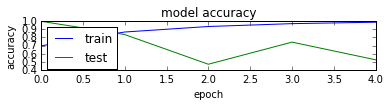

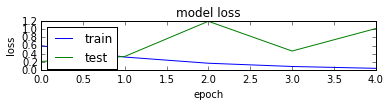

101 [  8.62388970e-06   9.99991417e-01]
acc: 52.34%
60.24% (+/- 30.74%)


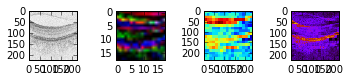

In [23]:
cv = cross_validation.KFold(4096, n_folds=32,shuffle=False,random_state=None)
for train_index, test_index in cv:
    if test_index[0]==2176 and test_index[0]<2303:
        print "The OCT Volume 18"
        pru=[]
        aba=[]
        for i in range(0,3968):
            at=all_input_3D[train_index[i]]
            pru.append(at)
        pru2=[]
        aba2=[]
        for j in range(0,128):
            at2=all_input_3D[test_index[j]]
            pru2.append(at2)
        X_tr, X_tes = np.asarray(pru), np.asarray(pru2)
        #y_tr, y_tes = np.asarray(aba), np.asarray(aba2)
        y_tr, y_tes = aba1[train_index[0:3968]],aba1[test_index[0:128]]
        print X_tr.shape, X_tes.shape, y_tr.shape, y_tes.shape
        # create model
        #model1 = Model(input=input, output=[dense3])
        #for layer in model1.layers:
        #    layer.trainable = True
        #model1 = Model(input=input, output=[dense3]
        model1.load_weights('model_OCTNET.h5')
        # Fit the model
        #model.fit(X_tr, y_tr, epochs=100, batch_size=32, verbose=1)
        checkpointer = ModelCheckpoint(filepath="/home/ojperdomoc/OCT_HES-SO/OCT_NET_18.hdf5", monitor='val_acc', verbose=1, save_best_only=True)
        history = model1.fit([X_tr], [y_tr], batch_size=batch_size, nb_epoch=nb_epochs,verbose=1,validation_data=(X_tes, y_tes),callbacks=[checkpointer])
        # evaluate the model
        bb1=model1.predict([X_tes])
        scores = model1.evaluate([X_tes], [y_tes], verbose=1)
        print('Test score:', scores[0])
        print('Test accuracy:', scores[1])
        #plt.imshow(Y_hat_mask[0].transpose(1,2,0).squeeze())
        #print('The number of OCT classified correctly are:', np.sum(bb1==label_0[test_index[0:128]]))
        #print('The test index',[test_index[0:128]][0],[test_index[0:128]][127])
        # list all data in history
        print(history.history.keys())
        ax1 = plt.subplot2grid((4,4), (0,0), colspan=4)
        # summarize history for accuracy
        plt.plot(history.history['acc'])
        plt.plot(history.history['val_acc'])
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()
        # summarize history for loss
        ax2 = plt.subplot2grid((4,4), (1,0), colspan=4)
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()
        Y_hat = conv10.eval({input: X_tes.astype('float32')})
        input2 = Input(shape=(256,18,18))
        final_conv1 = Convolution2D(1, 1, 1, activation='sigmoid')(input2)
        upsample13 = UpSampling2D(size=(13, 13), dim_ordering='th')(final_conv1)
        model_mask = Model(input=input2, output=[upsample13])
        Y_hat_mask = upsample13.eval({input2: Y_hat})
        slice_idx = random.randint(0, 127)
        #plt.figure()
        #plt.subplot(1,4,1)
        ax3 = plt.subplot2grid((4,4), (2, 0))
        plt.imshow((X_tes[slice_idx]).transpose(1,2,0))
        plt.savefig('0_'+str(test_index[0])+'.svg')
        #plt.subplot(1,4,2)
        ax4 = plt.subplot2grid((4,4), (2, 1))
        plt.imshow((Y_hat[slice_idx][0:3]).transpose(1,2,0))
        plt.savefig('1_'+str(test_index[0])+'.svg')
        #plt.subplot(1,4,3)
        ax5 = plt.subplot2grid((4,4), (2, 2))
        plt.imshow(Y_hat_mask[slice_idx].transpose(1,2,0).squeeze())
        plt.savefig('2_'+str(test_index[0])+'.svg')
        #plt.subplot(1,4,4)
        ax6 = plt.subplot2grid((4,4), (2, 3))
        mask_rsz=(Y_hat_mask[slice_idx].transpose(1,2,0).squeeze())#
        #data = imresize(np.asarray(Image.open(imaa))[:,:,0:3],scale_factor,'bicubic').astype('float32')
        mask_rsz1=imresize(mask_rsz,(224,224),'bicubic').astype('float32')
        over_all = np.zeros((224,224))
        over_all = ((X_tes[slice_idx]).transpose(1,2,0)[:,:,0])*(mask_rsz1)
        #over_all[:,:,1] = ((X_tes[slice_idx]).transpose(1,2,0)[:,:,1])*(mask_rsz1)
        #over_all[:,:,2] = ((X_tes[slice_idx]).transpose(1,2,0)[:,:,2])*(mask_rsz1)
        plt.imshow(over_all,cmap='gnuplot')
        plt.savefig('3_'+str(test_index[0])+'.svg')
        print slice_idx, bb1[slice_idx]
        print("%s: %.2f%%" % (model1.metrics_names[1], scores[1]*100))
        cvscores.append(scores[1] * 100)
        bb.append(bb1)
    else:
        test_index[0]
print("%.2f%% (+/- %.2f%%)" % (numpy.mean(cvscores), numpy.std(cvscores)))

The OCT Volume 19
(3968, 3, 224, 224) (128, 3, 224, 224) (3968, 2) (128, 2)
Train on 3968 samples, validate on 128 samples
Epoch 1/5
3968/3968 [==============================] - 67s - loss: 0.6200 - acc: 0.6749 - val_loss: 0.7151 - val_acc: 0.5703
Epoch 2/5
3968/3968 [==============================] - 62s - loss: 0.3256 - acc: 0.8604 - val_loss: 2.2867 - val_acc: 0.2656
Epoch 3/5
3968/3968 [==============================] - 62s - loss: 0.1669 - acc: 0.9395 - val_loss: 2.9527 - val_acc: 0.2344
Epoch 4/5
3968/3968 [==============================] - 62s - loss: 0.0927 - acc: 0.9667 - val_loss: 2.9408 - val_acc: 0.2969
Epoch 5/5
128/128 [==============================] - 0s     
('Test score:', 6.7094904184341431)
('Test accuracy:', 0.140625)
['acc', 'loss', 'val_acc', 'val_loss']


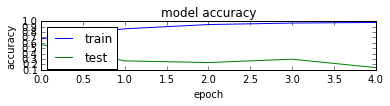

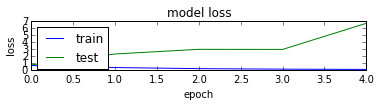

97 [  9.99947309e-01   5.26716140e-05]
acc: 14.06%
20.31% (+/- 5.85%)


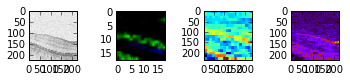

In [13]:
cv = cross_validation.KFold(4096, n_folds=32,shuffle=False,random_state=None)
for train_index, test_index in cv:
    if test_index[0]==2304 and test_index[0]<2431:
        print "The OCT Volume 19"
        pru=[]
        aba=[]
        for i in range(0,3968):
            at=all_input_3D[train_index[i]]
            pru.append(at)
        pru2=[]
        aba2=[]
        for j in range(0,128):
            at2=all_input_3D[test_index[j]]
            pru2.append(at2)
        X_tr, X_tes = np.asarray(pru), np.asarray(pru2)
        #y_tr, y_tes = np.asarray(aba), np.asarray(aba2)
        y_tr, y_tes = aba1[train_index[0:3968]],aba1[test_index[0:128]]
        print X_tr.shape, X_tes.shape, y_tr.shape, y_tes.shape
        # create model
        #model1 = Model(input=input, output=[dense3])
        #for layer in model1.layers:
        #    layer.trainable = True
        #model1 = Model(input=input, output=[dense3]
        model1.load_weights('model_OCTNET.h5')
        # Fit the model
        #model.fit(X_tr, y_tr, epochs=100, batch_size=32, verbose=1)
        checkpointer = ModelCheckpoint(filepath="/home/ojperdomoc/OCT_HES-SO/OCT_NET_19.hdf5", monitor='val_acc', verbose=1, save_best_only=True)
        history = model1.fit([X_tr], [y_tr], batch_size=batch_size, nb_epoch=nb_epochs,verbose=1,validation_data=(X_tes, y_tes),callbacks=[checkpointer])
        # evaluate the model
        bb1=model1.predict([X_tes])
        scores = model1.evaluate([X_tes], [y_tes], verbose=1)
        print('Test score:', scores[0])
        print('Test accuracy:', scores[1])
        #plt.imshow(Y_hat_mask[0].transpose(1,2,0).squeeze())
        #print('The number of OCT classified correctly are:', np.sum(bb1==label_0[test_index[0:128]]))
        #print('The test index',[test_index[0:128]][0],[test_index[0:128]][127])
        # list all data in history
        print(history.history.keys())
        ax1 = plt.subplot2grid((4,4), (0,0), colspan=4)
        # summarize history for accuracy
        plt.plot(history.history['acc'])
        plt.plot(history.history['val_acc'])
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()
        # summarize history for loss
        ax2 = plt.subplot2grid((4,4), (1,0), colspan=4)
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()
        Y_hat = conv10.eval({input: X_tes.astype('float32')})
        input2 = Input(shape=(256,18,18))
        final_conv1 = Convolution2D(1, 1, 1, activation='sigmoid')(input2)
        upsample13 = UpSampling2D(size=(13, 13), dim_ordering='th')(final_conv1)
        model_mask = Model(input=input2, output=[upsample13])
        Y_hat_mask = upsample13.eval({input2: Y_hat})
        slice_idx = random.randint(0, 127)
        #plt.figure()
        #plt.subplot(1,4,1)
        ax3 = plt.subplot2grid((4,4), (2, 0))
        plt.imshow((X_tes[slice_idx]).transpose(1,2,0))
        plt.savefig('0_'+str(test_index[0])+'.svg')
        #plt.subplot(1,4,2)
        ax4 = plt.subplot2grid((4,4), (2, 1))
        plt.imshow((Y_hat[slice_idx][0:3]).transpose(1,2,0))
        plt.savefig('1_'+str(test_index[0])+'.svg')
        #plt.subplot(1,4,3)
        ax5 = plt.subplot2grid((4,4), (2, 2))
        plt.imshow(Y_hat_mask[slice_idx].transpose(1,2,0).squeeze())
        plt.savefig('2_'+str(test_index[0])+'.svg')
        #plt.subplot(1,4,4)
        ax6 = plt.subplot2grid((4,4), (2, 3))
        mask_rsz=(Y_hat_mask[slice_idx].transpose(1,2,0).squeeze())#
        #data = imresize(np.asarray(Image.open(imaa))[:,:,0:3],scale_factor,'bicubic').astype('float32')
        mask_rsz1=imresize(mask_rsz,(224,224),'bicubic').astype('float32')
        over_all = np.zeros((224,224))
        over_all = ((X_tes[slice_idx]).transpose(1,2,0)[:,:,0])*(mask_rsz1)
        #over_all[:,:,1] = ((X_tes[slice_idx]).transpose(1,2,0)[:,:,1])*(mask_rsz1)
        #over_all[:,:,2] = ((X_tes[slice_idx]).transpose(1,2,0)[:,:,2])*(mask_rsz1)
        plt.imshow(over_all,cmap='gnuplot')
        plt.savefig('3_'+str(test_index[0])+'.svg')
        print slice_idx, bb1[slice_idx]
        print("%s: %.2f%%" % (model1.metrics_names[1], scores[1]*100))
        cvscores.append(scores[1] * 100)
        bb.append(bb1)
    else:
        test_index[0]
print("%.2f%% (+/- %.2f%%)" % (numpy.mean(cvscores), numpy.std(cvscores)))

The OCT Volume 20
(3968, 3, 224, 224) (128, 3, 224, 224) (3968, 2) (128, 2)
Train on 3968 samples, validate on 128 samples
Epoch 1/5
3968/3968 [==============================] - 63s - loss: 0.5971 - acc: 0.6724 - val_loss: 0.3699 - val_acc: 0.8750
Epoch 2/5
3968/3968 [==============================] - 68s - loss: 0.3220 - acc: 0.8619 - val_loss: 0.3069 - val_acc: 0.8906
Epoch 3/5
3968/3968 [==============================] - 62s - loss: 0.1565 - acc: 0.9383 - val_loss: 1.0843 - val_acc: 0.4609
Epoch 4/5
3968/3968 [==============================] - 62s - loss: 0.0732 - acc: 0.9751 - val_loss: 0.7366 - val_acc: 0.6250
Epoch 5/5
128/128 [==============================] - 0s     
('Test score:', 1.6206632256507874)
('Test accuracy:', 0.3828125)
['acc', 'loss', 'val_acc', 'val_loss']


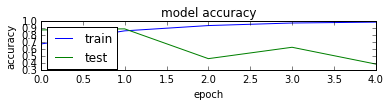

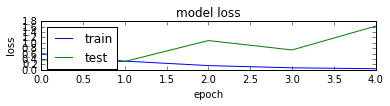

41 [ 0.71623993  0.2837601 ]
acc: 38.28%
57.19% (+/- 30.69%)


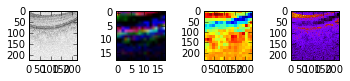

In [25]:
cv = cross_validation.KFold(4096, n_folds=32,shuffle=False,random_state=None)
for train_index, test_index in cv:
    if test_index[0]==2432 and test_index[0]<2559:
        print "The OCT Volume 20"
        pru=[]
        aba=[]
        for i in range(0,3968):
            at=all_input_3D[train_index[i]]
            pru.append(at)
        pru2=[]
        aba2=[]
        for j in range(0,128):
            at2=all_input_3D[test_index[j]]
            pru2.append(at2)
        X_tr, X_tes = np.asarray(pru), np.asarray(pru2)
        #y_tr, y_tes = np.asarray(aba), np.asarray(aba2)
        y_tr, y_tes = aba1[train_index[0:3968]],aba1[test_index[0:128]]
        print X_tr.shape, X_tes.shape, y_tr.shape, y_tes.shape
        # create model
        #model1 = Model(input=input, output=[dense3])
        #for layer in model1.layers:
        #    layer.trainable = True
        #model1 = Model(input=input, output=[dense3]
        model1.load_weights('model_OCTNET.h5')
        # Fit the model
        #model.fit(X_tr, y_tr, epochs=100, batch_size=32, verbose=1)
        checkpointer = ModelCheckpoint(filepath="/home/ojperdomoc/OCT_HES-SO/OCT_NET_20.hdf5", monitor='val_acc', verbose=1, save_best_only=True)
        history = model1.fit([X_tr], [y_tr], batch_size=batch_size, nb_epoch=nb_epochs,verbose=1,validation_data=(X_tes, y_tes),callbacks=[checkpointer])
        # evaluate the model
        bb1=model1.predict([X_tes])
        scores = model1.evaluate([X_tes], [y_tes], verbose=1)
        print('Test score:', scores[0])
        print('Test accuracy:', scores[1])
        #plt.imshow(Y_hat_mask[0].transpose(1,2,0).squeeze())
        #print('The number of OCT classified correctly are:', np.sum(bb1==label_0[test_index[0:128]]))
        #print('The test index',[test_index[0:128]][0],[test_index[0:128]][127])
        # list all data in history
        print(history.history.keys())
        ax1 = plt.subplot2grid((4,4), (0,0), colspan=4)
        # summarize history for accuracy
        plt.plot(history.history['acc'])
        plt.plot(history.history['val_acc'])
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()
        # summarize history for loss
        ax2 = plt.subplot2grid((4,4), (1,0), colspan=4)
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()
        Y_hat = conv10.eval({input: X_tes.astype('float32')})
        input2 = Input(shape=(256,18,18))
        final_conv1 = Convolution2D(1, 1, 1, activation='sigmoid')(input2)
        upsample13 = UpSampling2D(size=(13, 13), dim_ordering='th')(final_conv1)
        model_mask = Model(input=input2, output=[upsample13])
        Y_hat_mask = upsample13.eval({input2: Y_hat})
        slice_idx = random.randint(0, 127)
        #plt.figure()
        #plt.subplot(1,4,1)
        ax3 = plt.subplot2grid((4,4), (2, 0))
        plt.imshow((X_tes[slice_idx]).transpose(1,2,0))
        plt.savefig('0_'+str(test_index[0])+'.svg')
        #plt.subplot(1,4,2)
        ax4 = plt.subplot2grid((4,4), (2, 1))
        plt.imshow((Y_hat[slice_idx][0:3]).transpose(1,2,0))
        plt.savefig('1_'+str(test_index[0])+'.svg')
        #plt.subplot(1,4,3)
        ax5 = plt.subplot2grid((4,4), (2, 2))
        plt.imshow(Y_hat_mask[slice_idx].transpose(1,2,0).squeeze())
        plt.savefig('2_'+str(test_index[0])+'.svg')
        #plt.subplot(1,4,4)
        ax6 = plt.subplot2grid((4,4), (2, 3))
        mask_rsz=(Y_hat_mask[slice_idx].transpose(1,2,0).squeeze())#
        #data = imresize(np.asarray(Image.open(imaa))[:,:,0:3],scale_factor,'bicubic').astype('float32')
        mask_rsz1=imresize(mask_rsz,(224,224),'bicubic').astype('float32')
        over_all = np.zeros((224,224))
        over_all = ((X_tes[slice_idx]).transpose(1,2,0)[:,:,0])*(mask_rsz1)
        #over_all[:,:,1] = ((X_tes[slice_idx]).transpose(1,2,0)[:,:,1])*(mask_rsz1)
        #over_all[:,:,2] = ((X_tes[slice_idx]).transpose(1,2,0)[:,:,2])*(mask_rsz1)
        plt.imshow(over_all,cmap='gnuplot')
        plt.savefig('3_'+str(test_index[0])+'.svg')
        print slice_idx, bb1[slice_idx]
        print("%s: %.2f%%" % (model1.metrics_names[1], scores[1]*100))
        cvscores.append(scores[1] * 100)
        bb.append(bb1)
    else:
        test_index[0]
print("%.2f%% (+/- %.2f%%)" % (numpy.mean(cvscores), numpy.std(cvscores)))

The OCT Volume 21
(3968, 3, 224, 224) (128, 3, 224, 224) (3968, 2) (128, 2)
Train on 3968 samples, validate on 128 samples
Epoch 1/5
3968/3968 [==============================] - 63s - loss: 0.5811 - acc: 0.6935 - val_loss: 1.0913 - val_acc: 0.1953
Epoch 2/5
3968/3968 [==============================] - 62s - loss: 0.2958 - acc: 0.8742 - val_loss: 2.8601 - val_acc: 0.0625
Epoch 3/5
3968/3968 [==============================] - 68s - loss: 0.1510 - acc: 0.9420 - val_loss: 0.6406 - val_acc: 0.7031
Epoch 4/5
3968/3968 [==============================] - 62s - loss: 0.0753 - acc: 0.9751 - val_loss: 1.3144 - val_acc: 0.4297
Epoch 5/5
128/128 [==============================] - 0s     
('Test score:', 2.9138810634613037)
('Test accuracy:', 0.1328125)
['acc', 'loss', 'val_acc', 'val_loss']


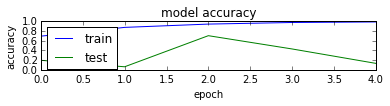

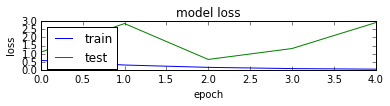

26 [ 0.9839384   0.01606166]
acc: 13.28%
55.10% (+/- 31.37%)


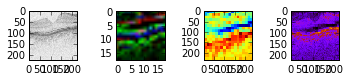

In [26]:
cv = cross_validation.KFold(4096, n_folds=32,shuffle=False,random_state=None)
for train_index, test_index in cv:
    if test_index[0]==2560 and test_index[0]<2687:
        print "The OCT Volume 21"
        pru=[]
        aba=[]
        for i in range(0,3968):
            at=all_input_3D[train_index[i]]
            pru.append(at)
        pru2=[]
        aba2=[]
        for j in range(0,128):
            at2=all_input_3D[test_index[j]]
            pru2.append(at2)
        X_tr, X_tes = np.asarray(pru), np.asarray(pru2)
        #y_tr, y_tes = np.asarray(aba), np.asarray(aba2)
        y_tr, y_tes = aba1[train_index[0:3968]],aba1[test_index[0:128]]
        print X_tr.shape, X_tes.shape, y_tr.shape, y_tes.shape
        # create model
        #model1 = Model(input=input, output=[dense3])
        #for layer in model1.layers:
        #    layer.trainable = True
        #model1 = Model(input=input, output=[dense3]
        model1.load_weights('model_OCTNET.h5')
        # Fit the model
        #model.fit(X_tr, y_tr, epochs=100, batch_size=32, verbose=1)
        checkpointer = ModelCheckpoint(filepath="/home/ojperdomoc/OCT_HES-SO/OCT_NET_21.hdf5", monitor='val_acc', verbose=1, save_best_only=True)
        history = model1.fit([X_tr], [y_tr], batch_size=batch_size, nb_epoch=nb_epochs,verbose=1,validation_data=(X_tes, y_tes),callbacks=[checkpointer])
        # evaluate the model
        bb1=model1.predict([X_tes])
        scores = model1.evaluate([X_tes], [y_tes], verbose=1)
        print('Test score:', scores[0])
        print('Test accuracy:', scores[1])
        #plt.imshow(Y_hat_mask[0].transpose(1,2,0).squeeze())
        #print('The number of OCT classified correctly are:', np.sum(bb1==label_0[test_index[0:128]]))
        #print('The test index',[test_index[0:128]][0],[test_index[0:128]][127])
        # list all data in history
        print(history.history.keys())
        ax1 = plt.subplot2grid((4,4), (0,0), colspan=4)
        # summarize history for accuracy
        plt.plot(history.history['acc'])
        plt.plot(history.history['val_acc'])
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()
        # summarize history for loss
        ax2 = plt.subplot2grid((4,4), (1,0), colspan=4)
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()
        Y_hat = conv10.eval({input: X_tes.astype('float32')})
        input2 = Input(shape=(256,18,18))
        final_conv1 = Convolution2D(1, 1, 1, activation='sigmoid')(input2)
        upsample13 = UpSampling2D(size=(13, 13), dim_ordering='th')(final_conv1)
        model_mask = Model(input=input2, output=[upsample13])
        Y_hat_mask = upsample13.eval({input2: Y_hat})
        slice_idx = random.randint(0, 127)
        #plt.figure()
        #plt.subplot(1,4,1)
        ax3 = plt.subplot2grid((4,4), (2, 0))
        plt.imshow((X_tes[slice_idx]).transpose(1,2,0))
        plt.savefig('0_'+str(test_index[0])+'.svg')
        #plt.subplot(1,4,2)
        ax4 = plt.subplot2grid((4,4), (2, 1))
        plt.imshow((Y_hat[slice_idx][0:3]).transpose(1,2,0))
        plt.savefig('1_'+str(test_index[0])+'.svg')
        #plt.subplot(1,4,3)
        ax5 = plt.subplot2grid((4,4), (2, 2))
        plt.imshow(Y_hat_mask[slice_idx].transpose(1,2,0).squeeze())
        plt.savefig('2_'+str(test_index[0])+'.svg')
        #plt.subplot(1,4,4)
        ax6 = plt.subplot2grid((4,4), (2, 3))
        mask_rsz=(Y_hat_mask[slice_idx].transpose(1,2,0).squeeze())#
        #data = imresize(np.asarray(Image.open(imaa))[:,:,0:3],scale_factor,'bicubic').astype('float32')
        mask_rsz1=imresize(mask_rsz,(224,224),'bicubic').astype('float32')
        over_all = np.zeros((224,224))
        over_all = ((X_tes[slice_idx]).transpose(1,2,0)[:,:,0])*(mask_rsz1)
        #over_all[:,:,1] = ((X_tes[slice_idx]).transpose(1,2,0)[:,:,1])*(mask_rsz1)
        #over_all[:,:,2] = ((X_tes[slice_idx]).transpose(1,2,0)[:,:,2])*(mask_rsz1)
        plt.imshow(over_all,cmap='gnuplot')
        plt.savefig('3_'+str(test_index[0])+'.svg')
        print slice_idx, bb1[slice_idx]
        print("%s: %.2f%%" % (model1.metrics_names[1], scores[1]*100))
        cvscores.append(scores[1] * 100)
        bb.append(bb1)
    else:
        test_index[0]
print("%.2f%% (+/- %.2f%%)" % (numpy.mean(cvscores), numpy.std(cvscores)))

The OCT Volume 22
(3968, 3, 224, 224) (128, 3, 224, 224) (3968, 2) (128, 2)
Train on 3968 samples, validate on 128 samples
Epoch 1/5
3968/3968 [==============================] - 63s - loss: 0.6002 - acc: 0.6870 - val_loss: 0.5874 - val_acc: 0.7500
Epoch 2/5
3968/3968 [==============================] - 62s - loss: 0.3183 - acc: 0.8611 - val_loss: 0.7136 - val_acc: 0.5859
Epoch 3/5
3968/3968 [==============================] - 69s - loss: 0.1649 - acc: 0.9365 - val_loss: 0.4118 - val_acc: 0.8359
Epoch 4/5
3968/3968 [==============================] - 68s - loss: 0.0850 - acc: 0.9718 - val_loss: 0.2733 - val_acc: 0.8828
Epoch 5/5
128/128 [==============================] - 0s     
('Test score:', 0.49906260520219803)
('Test accuracy:', 0.7578125)
['acc', 'loss', 'val_acc', 'val_loss']


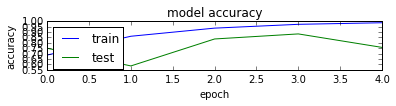

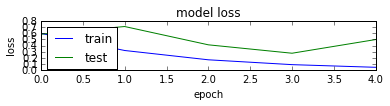

28 [ 0.00222415  0.99777585]
acc: 75.78%
56.04% (+/- 30.95%)


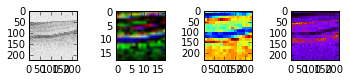

In [27]:
cv = cross_validation.KFold(4096, n_folds=32,shuffle=False,random_state=None)
for train_index, test_index in cv:
    if test_index[0]==2688 and test_index[0]<2815:
        print "The OCT Volume 22"
        pru=[]
        aba=[]
        for i in range(0,3968):
            at=all_input_3D[train_index[i]]
            pru.append(at)
        pru2=[]
        aba2=[]
        for j in range(0,128):
            at2=all_input_3D[test_index[j]]
            pru2.append(at2)
        X_tr, X_tes = np.asarray(pru), np.asarray(pru2)
        #y_tr, y_tes = np.asarray(aba), np.asarray(aba2)
        y_tr, y_tes = aba1[train_index[0:3968]],aba1[test_index[0:128]]
        print X_tr.shape, X_tes.shape, y_tr.shape, y_tes.shape
        # create model
        #model1 = Model(input=input, output=[dense3])
        #for layer in model1.layers:
        #    layer.trainable = True
        #model1 = Model(input=input, output=[dense3]
        model1.load_weights('model_OCTNET.h5')
        # Fit the model
        #model.fit(X_tr, y_tr, epochs=100, batch_size=32, verbose=1)
        checkpointer = ModelCheckpoint(filepath="/home/ojperdomoc/OCT_HES-SO/OCT_NET_22.hdf5", monitor='val_acc', verbose=1, save_best_only=True)
        history = model1.fit([X_tr], [y_tr], batch_size=batch_size, nb_epoch=nb_epochs,verbose=1,validation_data=(X_tes, y_tes),callbacks=[checkpointer])
        # evaluate the model
        bb1=model1.predict([X_tes])
        scores = model1.evaluate([X_tes], [y_tes], verbose=1)
        print('Test score:', scores[0])
        print('Test accuracy:', scores[1])
        #plt.imshow(Y_hat_mask[0].transpose(1,2,0).squeeze())
        #print('The number of OCT classified correctly are:', np.sum(bb1==label_0[test_index[0:128]]))
        #print('The test index',[test_index[0:128]][0],[test_index[0:128]][127])
        # list all data in history
        print(history.history.keys())
        ax1 = plt.subplot2grid((4,4), (0,0), colspan=4)
        # summarize history for accuracy
        plt.plot(history.history['acc'])
        plt.plot(history.history['val_acc'])
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()
        # summarize history for loss
        ax2 = plt.subplot2grid((4,4), (1,0), colspan=4)
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()
        Y_hat = conv10.eval({input: X_tes.astype('float32')})
        input2 = Input(shape=(256,18,18))
        final_conv1 = Convolution2D(1, 1, 1, activation='sigmoid')(input2)
        upsample13 = UpSampling2D(size=(13, 13), dim_ordering='th')(final_conv1)
        model_mask = Model(input=input2, output=[upsample13])
        Y_hat_mask = upsample13.eval({input2: Y_hat})
        slice_idx = random.randint(0, 127)
        #plt.figure()
        #plt.subplot(1,4,1)
        ax3 = plt.subplot2grid((4,4), (2, 0))
        plt.imshow((X_tes[slice_idx]).transpose(1,2,0))
        plt.savefig('0_'+str(test_index[0])+'.svg')
        #plt.subplot(1,4,2)
        ax4 = plt.subplot2grid((4,4), (2, 1))
        plt.imshow((Y_hat[slice_idx][0:3]).transpose(1,2,0))
        plt.savefig('1_'+str(test_index[0])+'.svg')
        #plt.subplot(1,4,3)
        ax5 = plt.subplot2grid((4,4), (2, 2))
        plt.imshow(Y_hat_mask[slice_idx].transpose(1,2,0).squeeze())
        plt.savefig('2_'+str(test_index[0])+'.svg')
        #plt.subplot(1,4,4)
        ax6 = plt.subplot2grid((4,4), (2, 3))
        mask_rsz=(Y_hat_mask[slice_idx].transpose(1,2,0).squeeze())#
        #data = imresize(np.asarray(Image.open(imaa))[:,:,0:3],scale_factor,'bicubic').astype('float32')
        mask_rsz1=imresize(mask_rsz,(224,224),'bicubic').astype('float32')
        over_all = np.zeros((224,224))
        over_all = ((X_tes[slice_idx]).transpose(1,2,0)[:,:,0])*(mask_rsz1)
        #over_all[:,:,1] = ((X_tes[slice_idx]).transpose(1,2,0)[:,:,1])*(mask_rsz1)
        #over_all[:,:,2] = ((X_tes[slice_idx]).transpose(1,2,0)[:,:,2])*(mask_rsz1)
        plt.imshow(over_all,cmap='gnuplot')
        plt.savefig('3_'+str(test_index[0])+'.svg')
        print slice_idx, bb1[slice_idx]
        print("%s: %.2f%%" % (model1.metrics_names[1], scores[1]*100))
        cvscores.append(scores[1] * 100)
        bb.append(bb1)
    else:
        test_index[0]
print("%.2f%% (+/- %.2f%%)" % (numpy.mean(cvscores), numpy.std(cvscores)))

The OCT Volume 23
(3968, 3, 224, 224) (128, 3, 224, 224) (3968, 2) (128, 2)
Train on 3968 samples, validate on 128 samples
Epoch 1/5
3968/3968 [==============================] - 68s - loss: 0.6560 - acc: 0.7074 - val_loss: 0.7849 - val_acc: 0.6641
Epoch 2/5
3968/3968 [==============================] - 62s - loss: 0.2497 - acc: 0.8939 - val_loss: 2.9744 - val_acc: 0.1328
Epoch 3/5
3968/3968 [==============================] - 62s - loss: 0.1202 - acc: 0.9534 - val_loss: 1.4191 - val_acc: 0.5703
Epoch 4/5
3968/3968 [==============================] - 62s - loss: 0.0588 - acc: 0.9791 - val_loss: 6.4221 - val_acc: 0.0234
Epoch 5/5
128/128 [==============================] - 0s     
('Test score:', 5.4632499217987061)
('Test accuracy:', 0.09375)
['acc', 'loss', 'val_acc', 'val_loss']


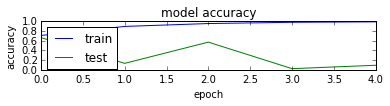

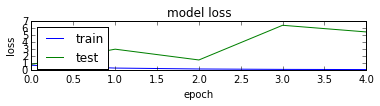

75 [ 0.0888221   0.91117787]
acc: 9.38%
14.06% (+/- 4.69%)


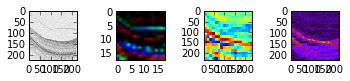

In [8]:
cv = cross_validation.KFold(4096, n_folds=32,shuffle=False,random_state=None)
for train_index, test_index in cv:
    if test_index[0]==2816 and test_index[0]<2943:
        print "The OCT Volume 23"
        pru=[]
        aba=[]
        for i in range(0,3968):
            at=all_input_3D[train_index[i]]
            pru.append(at)
        pru2=[]
        aba2=[]
        for j in range(0,128):
            at2=all_input_3D[test_index[j]]
            pru2.append(at2)
        X_tr, X_tes = np.asarray(pru), np.asarray(pru2)
        #y_tr, y_tes = np.asarray(aba), np.asarray(aba2)
        y_tr, y_tes = aba1[train_index[0:3968]],aba1[test_index[0:128]]
        print X_tr.shape, X_tes.shape, y_tr.shape, y_tes.shape
        # create model
        #model1 = Model(input=input, output=[dense3])
        #for layer in model1.layers:
        #    layer.trainable = True
        #model1 = Model(input=input, output=[dense3]
        model1.load_weights('model_OCTNET.h5')
        # Fit the model
        #model.fit(X_tr, y_tr, epochs=100, batch_size=32, verbose=1)
        checkpointer = ModelCheckpoint(filepath="/home/ojperdomoc/OCT_HES-SO/OCT_NET_23.hdf5", monitor='val_acc', verbose=1, save_best_only=True)
        history = model1.fit([X_tr], [y_tr], batch_size=batch_size, nb_epoch=nb_epochs,verbose=1,validation_data=(X_tes, y_tes),callbacks=[checkpointer])
        # evaluate the model
        bb1=model1.predict([X_tes])
        scores = model1.evaluate([X_tes], [y_tes], verbose=1)
        print('Test score:', scores[0])
        print('Test accuracy:', scores[1])
        #plt.imshow(Y_hat_mask[0].transpose(1,2,0).squeeze())
        #print('The number of OCT classified correctly are:', np.sum(bb1==label_0[test_index[0:128]]))
        #print('The test index',[test_index[0:128]][0],[test_index[0:128]][127])
        # list all data in history
        print(history.history.keys())
        ax1 = plt.subplot2grid((4,4), (0,0), colspan=4)
        # summarize history for accuracy
        plt.plot(history.history['acc'])
        plt.plot(history.history['val_acc'])
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()
        # summarize history for loss
        ax2 = plt.subplot2grid((4,4), (1,0), colspan=4)
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()
        Y_hat = conv10.eval({input: X_tes.astype('float32')})
        input2 = Input(shape=(256,18,18))
        final_conv1 = Convolution2D(1, 1, 1, activation='sigmoid')(input2)
        upsample13 = UpSampling2D(size=(13, 13), dim_ordering='th')(final_conv1)
        model_mask = Model(input=input2, output=[upsample13])
        Y_hat_mask = upsample13.eval({input2: Y_hat})
        slice_idx = random.randint(0, 127)
        #plt.figure()
        #plt.subplot(1,4,1)
        ax3 = plt.subplot2grid((4,4), (2, 0))
        plt.imshow((X_tes[slice_idx]).transpose(1,2,0))
        plt.savefig('0_'+str(test_index[0])+'.svg')
        #plt.subplot(1,4,2)
        ax4 = plt.subplot2grid((4,4), (2, 1))
        plt.imshow((Y_hat[slice_idx][0:3]).transpose(1,2,0))
        plt.savefig('1_'+str(test_index[0])+'.svg')
        #plt.subplot(1,4,3)
        ax5 = plt.subplot2grid((4,4), (2, 2))
        plt.imshow(Y_hat_mask[slice_idx].transpose(1,2,0).squeeze())
        plt.savefig('2_'+str(test_index[0])+'.svg')
        #plt.subplot(1,4,4)
        ax6 = plt.subplot2grid((4,4), (2, 3))
        mask_rsz=(Y_hat_mask[slice_idx].transpose(1,2,0).squeeze())#
        #data = imresize(np.asarray(Image.open(imaa))[:,:,0:3],scale_factor,'bicubic').astype('float32')
        mask_rsz1=imresize(mask_rsz,(224,224),'bicubic').astype('float32')
        over_all = np.zeros((224,224))
        over_all = ((X_tes[slice_idx]).transpose(1,2,0)[:,:,0])*(mask_rsz1)
        #over_all[:,:,1] = ((X_tes[slice_idx]).transpose(1,2,0)[:,:,1])*(mask_rsz1)
        #over_all[:,:,2] = ((X_tes[slice_idx]).transpose(1,2,0)[:,:,2])*(mask_rsz1)
        plt.imshow(over_all,cmap='gnuplot')
        plt.savefig('3_'+str(test_index[0])+'.svg')
        print slice_idx, bb1[slice_idx]
        print("%s: %.2f%%" % (model1.metrics_names[1], scores[1]*100))
        cvscores.append(scores[1] * 100)
        bb.append(bb1)
    else:
        test_index[0]
print("%.2f%% (+/- %.2f%%)" % (numpy.mean(cvscores), numpy.std(cvscores)))

The OCT Volume 24
(3968, 3, 224, 224) (128, 3, 224, 224) (3968, 2) (128, 2)
Train on 3968 samples, validate on 128 samples
Epoch 1/5
3968/3968 [==============================] - 63s - loss: 0.5855 - acc: 0.6878 - val_loss: 1.0306 - val_acc: 0.3203
Epoch 2/5
3968/3968 [==============================] - 70s - loss: 0.3137 - acc: 0.8637 - val_loss: 0.2140 - val_acc: 0.8984
Epoch 3/5
3968/3968 [==============================] - 62s - loss: 0.1576 - acc: 0.9403 - val_loss: 0.6553 - val_acc: 0.7422
Epoch 4/5
3968/3968 [==============================] - 62s - loss: 0.0823 - acc: 0.9710 - val_loss: 0.7145 - val_acc: 0.7422
Epoch 5/5
128/128 [==============================] - 0s     
('Test score:', 0.79097457230091095)
('Test accuracy:', 0.7890625)
['acc', 'loss', 'val_acc', 'val_loss']


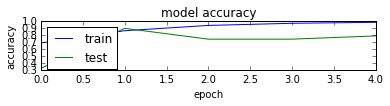

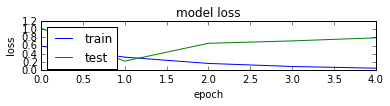

19 [ 0.98211694  0.01788314]
acc: 78.91%
55.24% (+/- 31.19%)


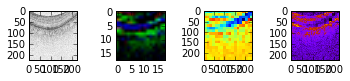

In [31]:
cv = cross_validation.KFold(4096, n_folds=32,shuffle=False,random_state=None)
for train_index, test_index in cv:
    if test_index[0]==2944 and test_index[0]<3071:
        print "The OCT Volume 24"
        pru=[]
        aba=[]
        for i in range(0,3968):
            at=all_input_3D[train_index[i]]
            pru.append(at)
        pru2=[]
        aba2=[]
        for j in range(0,128):
            at2=all_input_3D[test_index[j]]
            pru2.append(at2)
        X_tr, X_tes = np.asarray(pru), np.asarray(pru2)
        #y_tr, y_tes = np.asarray(aba), np.asarray(aba2)
        y_tr, y_tes = aba1[train_index[0:3968]],aba1[test_index[0:128]]
        print X_tr.shape, X_tes.shape, y_tr.shape, y_tes.shape
        # create model
        #model1 = Model(input=input, output=[dense3])
        #for layer in model1.layers:
        #    layer.trainable = True
        #model1 = Model(input=input, output=[dense3]
        model1.load_weights('model_OCTNET.h5')
        # Fit the model
        #model.fit(X_tr, y_tr, epochs=100, batch_size=32, verbose=1)
        checkpointer = ModelCheckpoint(filepath="/home/ojperdomoc/OCT_HES-SO/OCT_NET_24.hdf5", monitor='val_acc', verbose=1, save_best_only=True)
        history = model1.fit([X_tr], [y_tr], batch_size=batch_size, nb_epoch=nb_epochs,verbose=1,validation_data=(X_tes, y_tes),callbacks=[checkpointer])
        # evaluate the model
        bb1=model1.predict([X_tes])
        scores = model1.evaluate([X_tes], [y_tes], verbose=1)
        print('Test score:', scores[0])
        print('Test accuracy:', scores[1])
        #plt.imshow(Y_hat_mask[0].transpose(1,2,0).squeeze())
        #print('The number of OCT classified correctly are:', np.sum(bb1==label_0[test_index[0:128]]))
        #print('The test index',[test_index[0:128]][0],[test_index[0:128]][127])
        # list all data in history
        print(history.history.keys())
        ax1 = plt.subplot2grid((4,4), (0,0), colspan=4)
        # summarize history for accuracy
        plt.plot(history.history['acc'])
        plt.plot(history.history['val_acc'])
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()
        # summarize history for loss
        ax2 = plt.subplot2grid((4,4), (1,0), colspan=4)
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()
        Y_hat = conv10.eval({input: X_tes.astype('float32')})
        input2 = Input(shape=(256,18,18))
        final_conv1 = Convolution2D(1, 1, 1, activation='sigmoid')(input2)
        upsample13 = UpSampling2D(size=(13, 13), dim_ordering='th')(final_conv1)
        model_mask = Model(input=input2, output=[upsample13])
        Y_hat_mask = upsample13.eval({input2: Y_hat})
        slice_idx = random.randint(0, 127)
        #plt.figure()
        #plt.subplot(1,4,1)
        ax3 = plt.subplot2grid((4,4), (2, 0))
        plt.imshow((X_tes[slice_idx]).transpose(1,2,0))
        plt.savefig('0_'+str(test_index[0])+'.svg')
        #plt.subplot(1,4,2)
        ax4 = plt.subplot2grid((4,4), (2, 1))
        plt.imshow((Y_hat[slice_idx][0:3]).transpose(1,2,0))
        plt.savefig('1_'+str(test_index[0])+'.svg')
        #plt.subplot(1,4,3)
        ax5 = plt.subplot2grid((4,4), (2, 2))
        plt.imshow(Y_hat_mask[slice_idx].transpose(1,2,0).squeeze())
        plt.savefig('2_'+str(test_index[0])+'.svg')
        #plt.subplot(1,4,4)
        ax6 = plt.subplot2grid((4,4), (2, 3))
        mask_rsz=(Y_hat_mask[slice_idx].transpose(1,2,0).squeeze())#
        #data = imresize(np.asarray(Image.open(imaa))[:,:,0:3],scale_factor,'bicubic').astype('float32')
        mask_rsz1=imresize(mask_rsz,(224,224),'bicubic').astype('float32')
        over_all = np.zeros((224,224))
        over_all = ((X_tes[slice_idx]).transpose(1,2,0)[:,:,0])*(mask_rsz1)
        #over_all[:,:,1] = ((X_tes[slice_idx]).transpose(1,2,0)[:,:,1])*(mask_rsz1)
        #over_all[:,:,2] = ((X_tes[slice_idx]).transpose(1,2,0)[:,:,2])*(mask_rsz1)
        plt.imshow(over_all,cmap='gnuplot')
        plt.savefig('3_'+str(test_index[0])+'.svg')
        print slice_idx, bb1[slice_idx]
        print("%s: %.2f%%" % (model1.metrics_names[1], scores[1]*100))
        cvscores.append(scores[1] * 100)
        bb.append(bb1)
    else:
        test_index[0]
print("%.2f%% (+/- %.2f%%)" % (numpy.mean(cvscores), numpy.std(cvscores)))

The OCT Volume 25
(3968, 3, 224, 224) (128, 3, 224, 224) (3968, 2) (128, 2)
Train on 3968 samples, validate on 128 samples
Epoch 1/5
3968/3968 [==============================] - 61s - loss: 0.5885 - acc: 0.6842 - val_loss: 1.3544 - val_acc: 0.0859
Epoch 2/5
3968/3968 [==============================] - 69s - loss: 0.3132 - acc: 0.8657 - val_loss: 1.5667 - val_acc: 0.2188
Epoch 3/5
3968/3968 [==============================] - 70s - loss: 0.1640 - acc: 0.9388 - val_loss: 1.7266 - val_acc: 0.3203
Epoch 4/5
3968/3968 [==============================] - 72s - loss: 0.0834 - acc: 0.9693 - val_loss: 0.9363 - val_acc: 0.5312
Epoch 5/5
128/128 [==============================] - 0s     
('Test score:', 1.9117372632026672)
('Test accuracy:', 0.4296875)
['acc', 'loss', 'val_acc', 'val_loss']


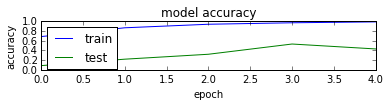

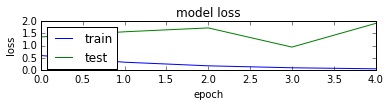

115 [ 0.145       0.85500002]
acc: 42.97%
54.75% (+/- 30.66%)


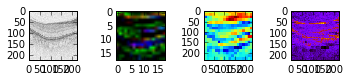

In [32]:
cv = cross_validation.KFold(4096, n_folds=32,shuffle=False,random_state=None)
for train_index, test_index in cv:
    if test_index[0]==3072 and test_index[0]<3199:
        print "The OCT Volume 25"
        pru=[]
        aba=[]
        for i in range(0,3968):
            at=all_input_3D[train_index[i]]
            pru.append(at)
        pru2=[]
        aba2=[]
        for j in range(0,128):
            at2=all_input_3D[test_index[j]]
            pru2.append(at2)
        X_tr, X_tes = np.asarray(pru), np.asarray(pru2)
        #y_tr, y_tes = np.asarray(aba), np.asarray(aba2)
        y_tr, y_tes = aba1[train_index[0:3968]],aba1[test_index[0:128]]
        print X_tr.shape, X_tes.shape, y_tr.shape, y_tes.shape
        # create model
        #model1 = Model(input=input, output=[dense3])
        #for layer in model1.layers:
        #    layer.trainable = True
        #model1 = Model(input=input, output=[dense3]
        model1.load_weights('model_OCTNET.h5')
        # Fit the model
        #model.fit(X_tr, y_tr, epochs=100, batch_size=32, verbose=1)
        checkpointer = ModelCheckpoint(filepath="/home/ojperdomoc/OCT_HES-SO/OCT_NET_25.hdf5", monitor='val_acc', verbose=1, save_best_only=True)
        history = model1.fit([X_tr], [y_tr], batch_size=batch_size, nb_epoch=nb_epochs,verbose=1,validation_data=(X_tes, y_tes),callbacks=[checkpointer])
        # evaluate the model
        bb1=model1.predict([X_tes])
        scores = model1.evaluate([X_tes], [y_tes], verbose=1)
        print('Test score:', scores[0])
        print('Test accuracy:', scores[1])
        #plt.imshow(Y_hat_mask[0].transpose(1,2,0).squeeze())
        #print('The number of OCT classified correctly are:', np.sum(bb1==label_0[test_index[0:128]]))
        #print('The test index',[test_index[0:128]][0],[test_index[0:128]][127])
        # list all data in history
        print(history.history.keys())
        ax1 = plt.subplot2grid((4,4), (0,0), colspan=4)
        # summarize history for accuracy
        plt.plot(history.history['acc'])
        plt.plot(history.history['val_acc'])
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()
        # summarize history for loss
        ax2 = plt.subplot2grid((4,4), (1,0), colspan=4)
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()
        Y_hat = conv10.eval({input: X_tes.astype('float32')})
        input2 = Input(shape=(256,18,18))
        final_conv1 = Convolution2D(1, 1, 1, activation='sigmoid')(input2)
        upsample13 = UpSampling2D(size=(13, 13), dim_ordering='th')(final_conv1)
        model_mask = Model(input=input2, output=[upsample13])
        Y_hat_mask = upsample13.eval({input2: Y_hat})
        slice_idx = random.randint(0, 127)
        #plt.figure()
        #plt.subplot(1,4,1)
        ax3 = plt.subplot2grid((4,4), (2, 0))
        plt.imshow((X_tes[slice_idx]).transpose(1,2,0))
        plt.savefig('0_'+str(test_index[0])+'.svg')
        #plt.subplot(1,4,2)
        ax4 = plt.subplot2grid((4,4), (2, 1))
        plt.imshow((Y_hat[slice_idx][0:3]).transpose(1,2,0))
        plt.savefig('1_'+str(test_index[0])+'.svg')
        #plt.subplot(1,4,3)
        ax5 = plt.subplot2grid((4,4), (2, 2))
        plt.imshow(Y_hat_mask[slice_idx].transpose(1,2,0).squeeze())
        plt.savefig('2_'+str(test_index[0])+'.svg')
        #plt.subplot(1,4,4)
        ax6 = plt.subplot2grid((4,4), (2, 3))
        mask_rsz=(Y_hat_mask[slice_idx].transpose(1,2,0).squeeze())#
        #data = imresize(np.asarray(Image.open(imaa))[:,:,0:3],scale_factor,'bicubic').astype('float32')
        mask_rsz1=imresize(mask_rsz,(224,224),'bicubic').astype('float32')
        over_all = np.zeros((224,224))
        over_all = ((X_tes[slice_idx]).transpose(1,2,0)[:,:,0])*(mask_rsz1)
        #over_all[:,:,1] = ((X_tes[slice_idx]).transpose(1,2,0)[:,:,1])*(mask_rsz1)
        #over_all[:,:,2] = ((X_tes[slice_idx]).transpose(1,2,0)[:,:,2])*(mask_rsz1)
        plt.imshow(over_all,cmap='gnuplot')
        plt.savefig('3_'+str(test_index[0])+'.svg')
        print slice_idx, bb1[slice_idx]
        print("%s: %.2f%%" % (model1.metrics_names[1], scores[1]*100))
        cvscores.append(scores[1] * 100)
        bb.append(bb1)
    else:
        test_index[0]
print("%.2f%% (+/- %.2f%%)" % (numpy.mean(cvscores), numpy.std(cvscores)))

The OCT Volume 26
(3968, 3, 224, 224) (128, 3, 224, 224) (3968, 2) (128, 2)
Train on 3968 samples, validate on 128 samples
Epoch 1/5
3968/3968 [==============================] - 61s - loss: 0.5817 - acc: 0.7026 - val_loss: 1.4867 - val_acc: 0.1953
Epoch 2/5
3968/3968 [==============================] - 68s - loss: 0.3068 - acc: 0.8725 - val_loss: 1.0319 - val_acc: 0.6016
Epoch 3/5
3968/3968 [==============================] - 62s - loss: 0.1581 - acc: 0.9418 - val_loss: 2.1435 - val_acc: 0.4922
Epoch 4/5
3968/3968 [==============================] - 62s - loss: 0.0845 - acc: 0.9693 - val_loss: 2.9311 - val_acc: 0.4844
Epoch 5/5
128/128 [==============================] - 0s     
('Test score:', 2.7009645700454712)
('Test accuracy:', 0.546875)
['acc', 'loss', 'val_acc', 'val_loss']


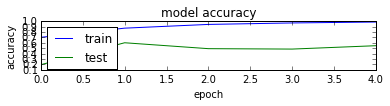

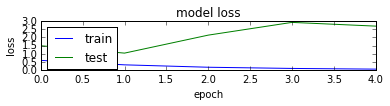

56 [  9.99974012e-01   2.60222278e-05]
acc: 54.69%
54.75% (+/- 30.06%)


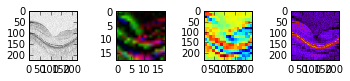

In [33]:
cv = cross_validation.KFold(4096, n_folds=32,shuffle=False,random_state=None)
for train_index, test_index in cv:
    if test_index[0]==3200 and test_index[0]<3327:
        print "The OCT Volume 26"
        pru=[]
        aba=[]
        for i in range(0,3968):
            at=all_input_3D[train_index[i]]
            pru.append(at)
        pru2=[]
        aba2=[]
        for j in range(0,128):
            at2=all_input_3D[test_index[j]]
            pru2.append(at2)
        X_tr, X_tes = np.asarray(pru), np.asarray(pru2)
        #y_tr, y_tes = np.asarray(aba), np.asarray(aba2)
        y_tr, y_tes = aba1[train_index[0:3968]],aba1[test_index[0:128]]
        print X_tr.shape, X_tes.shape, y_tr.shape, y_tes.shape
        # create model
        #model1 = Model(input=input, output=[dense3])
        #for layer in model1.layers:
        #    layer.trainable = True
        #model1 = Model(input=input, output=[dense3]
        model1.load_weights('model_OCTNET.h5')
        # Fit the model
        #model.fit(X_tr, y_tr, epochs=100, batch_size=32, verbose=1)
        checkpointer = ModelCheckpoint(filepath="/home/ojperdomoc/OCT_HES-SO/OCT_NET_26.hdf5", monitor='val_acc', verbose=1, save_best_only=True)
        history = model1.fit([X_tr], [y_tr], batch_size=batch_size, nb_epoch=nb_epochs,verbose=1,validation_data=(X_tes, y_tes),callbacks=[checkpointer])
        # evaluate the model
        bb1=model1.predict([X_tes])
        scores = model1.evaluate([X_tes], [y_tes], verbose=1)
        print('Test score:', scores[0])
        print('Test accuracy:', scores[1])
        #plt.imshow(Y_hat_mask[0].transpose(1,2,0).squeeze())
        #print('The number of OCT classified correctly are:', np.sum(bb1==label_0[test_index[0:128]]))
        #print('The test index',[test_index[0:128]][0],[test_index[0:128]][127])
        # list all data in history
        print(history.history.keys())
        ax1 = plt.subplot2grid((4,4), (0,0), colspan=4)
        # summarize history for accuracy
        plt.plot(history.history['acc'])
        plt.plot(history.history['val_acc'])
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()
        # summarize history for loss
        ax2 = plt.subplot2grid((4,4), (1,0), colspan=4)
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()
        Y_hat = conv10.eval({input: X_tes.astype('float32')})
        input2 = Input(shape=(256,18,18))
        final_conv1 = Convolution2D(1, 1, 1, activation='sigmoid')(input2)
        upsample13 = UpSampling2D(size=(13, 13), dim_ordering='th')(final_conv1)
        model_mask = Model(input=input2, output=[upsample13])
        Y_hat_mask = upsample13.eval({input2: Y_hat})
        slice_idx = random.randint(0, 127)
        #plt.figure()
        #plt.subplot(1,4,1)
        ax3 = plt.subplot2grid((4,4), (2, 0))
        plt.imshow((X_tes[slice_idx]).transpose(1,2,0))
        plt.savefig('0_'+str(test_index[0])+'.svg')
        #plt.subplot(1,4,2)
        ax4 = plt.subplot2grid((4,4), (2, 1))
        plt.imshow((Y_hat[slice_idx][0:3]).transpose(1,2,0))
        plt.savefig('1_'+str(test_index[0])+'.svg')
        #plt.subplot(1,4,3)
        ax5 = plt.subplot2grid((4,4), (2, 2))
        plt.imshow(Y_hat_mask[slice_idx].transpose(1,2,0).squeeze())
        plt.savefig('2_'+str(test_index[0])+'.svg')
        #plt.subplot(1,4,4)
        ax6 = plt.subplot2grid((4,4), (2, 3))
        mask_rsz=(Y_hat_mask[slice_idx].transpose(1,2,0).squeeze())#
        #data = imresize(np.asarray(Image.open(imaa))[:,:,0:3],scale_factor,'bicubic').astype('float32')
        mask_rsz1=imresize(mask_rsz,(224,224),'bicubic').astype('float32')
        over_all = np.zeros((224,224))
        over_all = ((X_tes[slice_idx]).transpose(1,2,0)[:,:,0])*(mask_rsz1)
        #over_all[:,:,1] = ((X_tes[slice_idx]).transpose(1,2,0)[:,:,1])*(mask_rsz1)
        #over_all[:,:,2] = ((X_tes[slice_idx]).transpose(1,2,0)[:,:,2])*(mask_rsz1)
        plt.imshow(over_all,cmap='gnuplot')
        plt.savefig('3_'+str(test_index[0])+'.svg')
        print slice_idx, bb1[slice_idx]
        print("%s: %.2f%%" % (model1.metrics_names[1], scores[1]*100))
        cvscores.append(scores[1] * 100)
        bb.append(bb1)
    else:
        test_index[0]
print("%.2f%% (+/- %.2f%%)" % (numpy.mean(cvscores), numpy.std(cvscores)))

The OCT Volume 27
(3968, 3, 224, 224) (128, 3, 224, 224) (3968, 2) (128, 2)
Train on 3968 samples, validate on 128 samples
Epoch 1/5
3968/3968 [==============================] - 100s - loss: 0.5984 - acc: 0.6973 - val_loss: 0.9428 - val_acc: 0.5391
Epoch 2/5
3968/3968 [==============================] - 92s - loss: 0.2952 - acc: 0.8765 - val_loss: 1.6243 - val_acc: 0.4531
Epoch 3/5
3968/3968 [==============================] - 92s - loss: 0.1593 - acc: 0.9398 - val_loss: 3.4027 - val_acc: 0.3359
Epoch 4/5
3968/3968 [==============================] - 90s - loss: 0.0937 - acc: 0.9655 - val_loss: 4.1348 - val_acc: 0.3438
Epoch 5/5
128/128 [==============================] - 0s     
('Test score:', 3.4982349872589111)
('Test accuracy:', 0.359375)
['acc', 'loss', 'val_acc', 'val_loss']


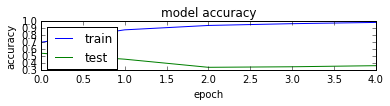

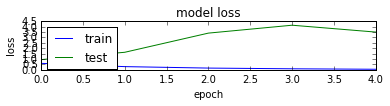

86 [ 0.00142362  0.9985764 ]
acc: 35.94%
22.95% (+/- 8.87%)


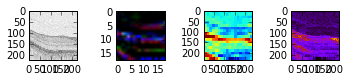

In [44]:
cv = cross_validation.KFold(4096, n_folds=32,shuffle=False,random_state=None)
for train_index, test_index in cv:
    if test_index[0]==3328 and test_index[0]<3455:
        print "The OCT Volume 27"
        pru=[]
        aba=[]
        for i in range(0,3968):
            at=all_input_3D[train_index[i]]
            pru.append(at)
        pru2=[]
        aba2=[]
        for j in range(0,128):
            at2=all_input_3D[test_index[j]]
            pru2.append(at2)
        X_tr, X_tes = np.asarray(pru), np.asarray(pru2)
        #y_tr, y_tes = np.asarray(aba), np.asarray(aba2)
        y_tr, y_tes = aba1[train_index[0:3968]],aba1[test_index[0:128]]
        print X_tr.shape, X_tes.shape, y_tr.shape, y_tes.shape
        # create model
        #model1 = Model(input=input, output=[dense3])
        #for layer in model1.layers:
        #    layer.trainable = True
        #model1 = Model(input=input, output=[dense3]
        model1.load_weights('model_OCTNET.h5')
        # Fit the model
        #model.fit(X_tr, y_tr, epochs=100, batch_size=32, verbose=1)
        checkpointer = ModelCheckpoint(filepath="/home/ojperdomoc/OCT_HES-SO/OCT_NET_27.hdf5", monitor='val_acc', verbose=1, save_best_only=True)
        history = model1.fit([X_tr], [y_tr], batch_size=batch_size, nb_epoch=nb_epochs,verbose=1,validation_data=(X_tes, y_tes),callbacks=[checkpointer])
        # evaluate the model
        bb1=model1.predict([X_tes])
        scores = model1.evaluate([X_tes], [y_tes], verbose=1)
        print('Test score:', scores[0])
        print('Test accuracy:', scores[1])
        #plt.imshow(Y_hat_mask[0].transpose(1,2,0).squeeze())
        #print('The number of OCT classified correctly are:', np.sum(bb1==label_0[test_index[0:128]]))
        #print('The test index',[test_index[0:128]][0],[test_index[0:128]][127])
        # list all data in history
        print(history.history.keys())
        ax1 = plt.subplot2grid((4,4), (0,0), colspan=4)
        # summarize history for accuracy
        plt.plot(history.history['acc'])
        plt.plot(history.history['val_acc'])
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()
        # summarize history for loss
        ax2 = plt.subplot2grid((4,4), (1,0), colspan=4)
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()
        Y_hat = conv10.eval({input: X_tes.astype('float32')})
        input2 = Input(shape=(256,18,18))
        final_conv1 = Convolution2D(1, 1, 1, activation='sigmoid')(input2)
        upsample13 = UpSampling2D(size=(13, 13), dim_ordering='th')(final_conv1)
        model_mask = Model(input=input2, output=[upsample13])
        Y_hat_mask = upsample13.eval({input2: Y_hat})
        slice_idx = random.randint(0, 127)
        #plt.figure()
        #plt.subplot(1,4,1)
        ax3 = plt.subplot2grid((4,4), (2, 0))
        plt.imshow((X_tes[slice_idx]).transpose(1,2,0))
        plt.savefig('0_'+str(test_index[0])+'.svg')
        #plt.subplot(1,4,2)
        ax4 = plt.subplot2grid((4,4), (2, 1))
        plt.imshow((Y_hat[slice_idx][0:3]).transpose(1,2,0))
        plt.savefig('1_'+str(test_index[0])+'.svg')
        #plt.subplot(1,4,3)
        ax5 = plt.subplot2grid((4,4), (2, 2))
        plt.imshow(Y_hat_mask[slice_idx].transpose(1,2,0).squeeze())
        plt.savefig('2_'+str(test_index[0])+'.svg')
        #plt.subplot(1,4,4)
        ax6 = plt.subplot2grid((4,4), (2, 3))
        mask_rsz=(Y_hat_mask[slice_idx].transpose(1,2,0).squeeze())#
        #data = imresize(np.asarray(Image.open(imaa))[:,:,0:3],scale_factor,'bicubic').astype('float32')
        mask_rsz1=imresize(mask_rsz,(224,224),'bicubic').astype('float32')
        over_all = np.zeros((224,224))
        over_all = ((X_tes[slice_idx]).transpose(1,2,0)[:,:,0])*(mask_rsz1)
        #over_all[:,:,1] = ((X_tes[slice_idx]).transpose(1,2,0)[:,:,1])*(mask_rsz1)
        #over_all[:,:,2] = ((X_tes[slice_idx]).transpose(1,2,0)[:,:,2])*(mask_rsz1)
        plt.imshow(over_all,cmap='gnuplot')
        plt.savefig('3_'+str(test_index[0])+'.svg')
        print slice_idx, bb1[slice_idx]
        print("%s: %.2f%%" % (model1.metrics_names[1], scores[1]*100))
        cvscores.append(scores[1] * 100)
        bb.append(bb1)
    else:
        test_index[0]
print("%.2f%% (+/- %.2f%%)" % (numpy.mean(cvscores), numpy.std(cvscores)))

The OCT Volume 28
(3968, 3, 224, 224) (128, 3, 224, 224) (3968, 2) (128, 2)
Train on 3968 samples, validate on 128 samples
Epoch 1/5
3968/3968 [==============================] - 63s - loss: 0.6084 - acc: 0.6809 - val_loss: 0.7308 - val_acc: 0.6406
Epoch 2/5
3968/3968 [==============================] - 62s - loss: 0.3133 - acc: 0.8702 - val_loss: 1.5480 - val_acc: 0.3672
Epoch 3/5
3968/3968 [==============================] - 70s - loss: 0.1626 - acc: 0.9360 - val_loss: 0.8016 - val_acc: 0.7422
Epoch 4/5
3968/3968 [==============================] - 62s - loss: 0.0810 - acc: 0.9725 - val_loss: 1.1066 - val_acc: 0.7422
Epoch 5/5
128/128 [==============================] - 0s     
('Test score:', 0.91423062980175018)
('Test accuracy:', 0.796875)
['acc', 'loss', 'val_acc', 'val_loss']


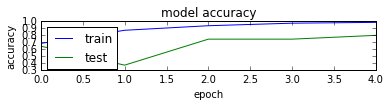

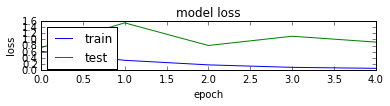

29 [ 0.99898142  0.00101855]
acc: 79.69%
55.11% (+/- 29.48%)


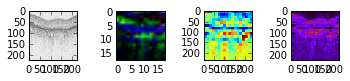

In [35]:
cv = cross_validation.KFold(4096, n_folds=32,shuffle=False,random_state=None)
for train_index, test_index in cv:
    if test_index[0]==3456 and test_index[0]<3583:
        print "The OCT Volume 28"
        pru=[]
        aba=[]
        for i in range(0,3968):
            at=all_input_3D[train_index[i]]
            pru.append(at)
        pru2=[]
        aba2=[]
        for j in range(0,128):
            at2=all_input_3D[test_index[j]]
            pru2.append(at2)
        X_tr, X_tes = np.asarray(pru), np.asarray(pru2)
        #y_tr, y_tes = np.asarray(aba), np.asarray(aba2)
        y_tr, y_tes = aba1[train_index[0:3968]],aba1[test_index[0:128]]
        print X_tr.shape, X_tes.shape, y_tr.shape, y_tes.shape
        # create model
        #model1 = Model(input=input, output=[dense3])
        #for layer in model1.layers:
        #    layer.trainable = True
        #model1 = Model(input=input, output=[dense3]
        model1.load_weights('model_OCTNET.h5')
        # Fit the model
        #model.fit(X_tr, y_tr, epochs=100, batch_size=32, verbose=1)
        checkpointer = ModelCheckpoint(filepath="/home/ojperdomoc/OCT_HES-SO/OCT_NET_28.hdf5", monitor='val_acc', verbose=1, save_best_only=True)
        history = model1.fit([X_tr], [y_tr], batch_size=batch_size, nb_epoch=nb_epochs,verbose=1,validation_data=(X_tes, y_tes),callbacks=[checkpointer])
        # evaluate the model
        bb1=model1.predict([X_tes])
        scores = model1.evaluate([X_tes], [y_tes], verbose=1)
        print('Test score:', scores[0])
        print('Test accuracy:', scores[1])
        #plt.imshow(Y_hat_mask[0].transpose(1,2,0).squeeze())
        #print('The number of OCT classified correctly are:', np.sum(bb1==label_0[test_index[0:128]]))
        #print('The test index',[test_index[0:128]][0],[test_index[0:128]][127])
        # list all data in history
        print(history.history.keys())
        ax1 = plt.subplot2grid((4,4), (0,0), colspan=4)
        # summarize history for accuracy
        plt.plot(history.history['acc'])
        plt.plot(history.history['val_acc'])
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()
        # summarize history for loss
        ax2 = plt.subplot2grid((4,4), (1,0), colspan=4)
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()
        Y_hat = conv10.eval({input: X_tes.astype('float32')})
        input2 = Input(shape=(256,18,18))
        final_conv1 = Convolution2D(1, 1, 1, activation='sigmoid')(input2)
        upsample13 = UpSampling2D(size=(13, 13), dim_ordering='th')(final_conv1)
        model_mask = Model(input=input2, output=[upsample13])
        Y_hat_mask = upsample13.eval({input2: Y_hat})
        slice_idx = random.randint(0, 127)
        #plt.figure()
        #plt.subplot(1,4,1)
        ax3 = plt.subplot2grid((4,4), (2, 0))
        plt.imshow((X_tes[slice_idx]).transpose(1,2,0))
        plt.savefig('0_'+str(test_index[0])+'.svg')
        #plt.subplot(1,4,2)
        ax4 = plt.subplot2grid((4,4), (2, 1))
        plt.imshow((Y_hat[slice_idx][0:3]).transpose(1,2,0))
        plt.savefig('1_'+str(test_index[0])+'.svg')
        #plt.subplot(1,4,3)
        ax5 = plt.subplot2grid((4,4), (2, 2))
        plt.imshow(Y_hat_mask[slice_idx].transpose(1,2,0).squeeze())
        plt.savefig('2_'+str(test_index[0])+'.svg')
        #plt.subplot(1,4,4)
        ax6 = plt.subplot2grid((4,4), (2, 3))
        mask_rsz=(Y_hat_mask[slice_idx].transpose(1,2,0).squeeze())#
        #data = imresize(np.asarray(Image.open(imaa))[:,:,0:3],scale_factor,'bicubic').astype('float32')
        mask_rsz1=imresize(mask_rsz,(224,224),'bicubic').astype('float32')
        over_all = np.zeros((224,224))
        over_all = ((X_tes[slice_idx]).transpose(1,2,0)[:,:,0])*(mask_rsz1)
        #over_all[:,:,1] = ((X_tes[slice_idx]).transpose(1,2,0)[:,:,1])*(mask_rsz1)
        #over_all[:,:,2] = ((X_tes[slice_idx]).transpose(1,2,0)[:,:,2])*(mask_rsz1)
        plt.imshow(over_all,cmap='gnuplot')
        plt.savefig('3_'+str(test_index[0])+'.svg')
        print slice_idx, bb1[slice_idx]
        print("%s: %.2f%%" % (model1.metrics_names[1], scores[1]*100))
        cvscores.append(scores[1] * 100)
        bb.append(bb1)
    else:
        test_index[0]
print("%.2f%% (+/- %.2f%%)" % (numpy.mean(cvscores), numpy.std(cvscores)))

The OCT Volume 29
(3968, 3, 224, 224) (128, 3, 224, 224) (3968, 2) (128, 2)
Train on 3968 samples, validate on 128 samples
Epoch 1/5
3968/3968 [==============================] - 62s - loss: 0.5804 - acc: 0.6920 - val_loss: 0.5053 - val_acc: 0.8672
Epoch 2/5
3968/3968 [==============================] - 62s - loss: 0.3103 - acc: 0.8727 - val_loss: 0.6404 - val_acc: 0.6797
Epoch 3/5
3968/3968 [==============================] - 68s - loss: 0.1646 - acc: 0.9388 - val_loss: 0.1615 - val_acc: 0.9609
Epoch 4/5
3968/3968 [==============================] - 62s - loss: 0.0876 - acc: 0.9685 - val_loss: 0.1999 - val_acc: 0.9375
Epoch 5/5
128/128 [==============================] - 0s     
('Test score:', 0.083306676708161831)
('Test accuracy:', 0.9609375)
['acc', 'loss', 'val_acc', 'val_loss']


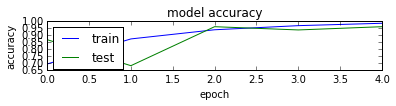

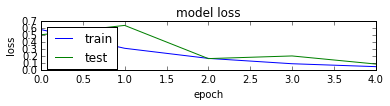

78 [ 0.96613353  0.03386643]
acc: 96.09%
56.52% (+/- 29.92%)


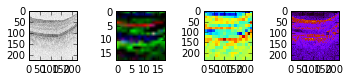

In [36]:
cv = cross_validation.KFold(4096, n_folds=32,shuffle=False,random_state=None)
for train_index, test_index in cv:
    if test_index[0]==3584 and test_index[0]<3711:
        print "The OCT Volume 29"
        pru=[]
        aba=[]
        for i in range(0,3968):
            at=all_input_3D[train_index[i]]
            pru.append(at)
        pru2=[]
        aba2=[]
        for j in range(0,128):
            at2=all_input_3D[test_index[j]]
            pru2.append(at2)
        X_tr, X_tes = np.asarray(pru), np.asarray(pru2)
        #y_tr, y_tes = np.asarray(aba), np.asarray(aba2)
        y_tr, y_tes = aba1[train_index[0:3968]],aba1[test_index[0:128]]
        print X_tr.shape, X_tes.shape, y_tr.shape, y_tes.shape
        # create model
        #model1 = Model(input=input, output=[dense3])
        #for layer in model1.layers:
        #    layer.trainable = True
        #model1 = Model(input=input, output=[dense3]
        model1.load_weights('model_OCTNET.h5')
        # Fit the model
        #model.fit(X_tr, y_tr, epochs=100, batch_size=32, verbose=1)
        checkpointer = ModelCheckpoint(filepath="/home/ojperdomoc/OCT_HES-SO/OCT_NET_29.hdf5", monitor='val_acc', verbose=1, save_best_only=True)
        history = model1.fit([X_tr], [y_tr], batch_size=batch_size, nb_epoch=nb_epochs,verbose=1,validation_data=(X_tes, y_tes),callbacks=[checkpointer])
        # evaluate the model
        bb1=model1.predict([X_tes])
        scores = model1.evaluate([X_tes], [y_tes], verbose=1)
        print('Test score:', scores[0])
        print('Test accuracy:', scores[1])
        #plt.imshow(Y_hat_mask[0].transpose(1,2,0).squeeze())
        #print('The number of OCT classified correctly are:', np.sum(bb1==label_0[test_index[0:128]]))
        #print('The test index',[test_index[0:128]][0],[test_index[0:128]][127])
        # list all data in history
        print(history.history.keys())
        ax1 = plt.subplot2grid((4,4), (0,0), colspan=4)
        # summarize history for accuracy
        plt.plot(history.history['acc'])
        plt.plot(history.history['val_acc'])
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()
        # summarize history for loss
        ax2 = plt.subplot2grid((4,4), (1,0), colspan=4)
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()
        Y_hat = conv10.eval({input: X_tes.astype('float32')})
        input2 = Input(shape=(256,18,18))
        final_conv1 = Convolution2D(1, 1, 1, activation='sigmoid')(input2)
        upsample13 = UpSampling2D(size=(13, 13), dim_ordering='th')(final_conv1)
        model_mask = Model(input=input2, output=[upsample13])
        Y_hat_mask = upsample13.eval({input2: Y_hat})
        slice_idx = random.randint(0, 127)
        #plt.figure()
        #plt.subplot(1,4,1)
        ax3 = plt.subplot2grid((4,4), (2, 0))
        plt.imshow((X_tes[slice_idx]).transpose(1,2,0))
        plt.savefig('0_'+str(test_index[0])+'.svg')
        #plt.subplot(1,4,2)
        ax4 = plt.subplot2grid((4,4), (2, 1))
        plt.imshow((Y_hat[slice_idx][0:3]).transpose(1,2,0))
        plt.savefig('1_'+str(test_index[0])+'.svg')
        #plt.subplot(1,4,3)
        ax5 = plt.subplot2grid((4,4), (2, 2))
        plt.imshow(Y_hat_mask[slice_idx].transpose(1,2,0).squeeze())
        plt.savefig('2_'+str(test_index[0])+'.svg')
        #plt.subplot(1,4,4)
        ax6 = plt.subplot2grid((4,4), (2, 3))
        mask_rsz=(Y_hat_mask[slice_idx].transpose(1,2,0).squeeze())#
        #data = imresize(np.asarray(Image.open(imaa))[:,:,0:3],scale_factor,'bicubic').astype('float32')
        mask_rsz1=imresize(mask_rsz,(224,224),'bicubic').astype('float32')
        over_all = np.zeros((224,224))
        over_all = ((X_tes[slice_idx]).transpose(1,2,0)[:,:,0])*(mask_rsz1)
        #over_all[:,:,1] = ((X_tes[slice_idx]).transpose(1,2,0)[:,:,1])*(mask_rsz1)
        #over_all[:,:,2] = ((X_tes[slice_idx]).transpose(1,2,0)[:,:,2])*(mask_rsz1)
        plt.imshow(over_all,cmap='gnuplot')
        plt.savefig('3_'+str(test_index[0])+'.svg')
        print slice_idx, bb1[slice_idx]
        print("%s: %.2f%%" % (model1.metrics_names[1], scores[1]*100))
        cvscores.append(scores[1] * 100)
        bb.append(bb1)
    else:
        test_index[0]
print("%.2f%% (+/- %.2f%%)" % (numpy.mean(cvscores), numpy.std(cvscores)))

The OCT Volume 30
(3968, 3, 224, 224) (128, 3, 224, 224) (3968, 2) (128, 2)
Train on 3968 samples, validate on 128 samples
Epoch 1/5
3968/3968 [==============================] - 62s - loss: 0.5906 - acc: 0.6968 - val_loss: 0.4915 - val_acc: 0.7969
Epoch 2/5
3968/3968 [==============================] - 62s - loss: 0.2992 - acc: 0.8720 - val_loss: 0.5120 - val_acc: 0.7656
Epoch 3/5
3968/3968 [==============================] - 62s - loss: 0.1592 - acc: 0.9425 - val_loss: 1.5167 - val_acc: 0.4219
Epoch 4/5
3968/3968 [==============================] - 62s - loss: 0.0751 - acc: 0.9756 - val_loss: 2.8984 - val_acc: 0.2500
Epoch 5/5
128/128 [==============================] - 0s     
('Test score:', 0.42064186185598373)
('Test accuracy:', 0.8984375)
['acc', 'loss', 'val_acc', 'val_loss']


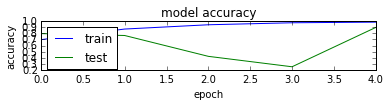

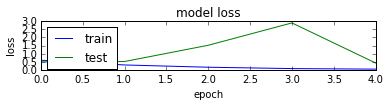

96 [ 0.03716024  0.96283984]
acc: 89.84%
57.63% (+/- 30.02%)


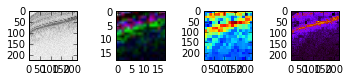

In [37]:
cv = cross_validation.KFold(4096, n_folds=32,shuffle=False,random_state=None)
for train_index, test_index in cv:
    if test_index[0]==3712 and test_index[0]<3839:
        print "The OCT Volume 30"
        pru=[]
        aba=[]
        for i in range(0,3968):
            at=all_input_3D[train_index[i]]
            pru.append(at)
        pru2=[]
        aba2=[]
        for j in range(0,128):
            at2=all_input_3D[test_index[j]]
            pru2.append(at2)
        X_tr, X_tes = np.asarray(pru), np.asarray(pru2)
        #y_tr, y_tes = np.asarray(aba), np.asarray(aba2)
        y_tr, y_tes = aba1[train_index[0:3968]],aba1[test_index[0:128]]
        print X_tr.shape, X_tes.shape, y_tr.shape, y_tes.shape
        # create model
        #model1 = Model(input=input, output=[dense3])
        #for layer in model1.layers:
        #    layer.trainable = True
        #model1 = Model(input=input, output=[dense3]
        model1.load_weights('model_OCTNET.h5')
        # Fit the model
        #model.fit(X_tr, y_tr, epochs=100, batch_size=32, verbose=1)
        checkpointer = ModelCheckpoint(filepath="/home/ojperdomoc/OCT_HES-SO/OCT_NET_30.hdf5", monitor='val_acc', verbose=1, save_best_only=True)
        history = model1.fit([X_tr], [y_tr], batch_size=batch_size, nb_epoch=nb_epochs,verbose=1,validation_data=(X_tes, y_tes),callbacks=[checkpointer])
        # evaluate the model
        bb1=model1.predict([X_tes])
        scores = model1.evaluate([X_tes], [y_tes], verbose=1)
        print('Test score:', scores[0])
        print('Test accuracy:', scores[1])
        #plt.imshow(Y_hat_mask[0].transpose(1,2,0).squeeze())
        #print('The number of OCT classified correctly are:', np.sum(bb1==label_0[test_index[0:128]]))
        #print('The test index',[test_index[0:128]][0],[test_index[0:128]][127])
        # list all data in history
        print(history.history.keys())
        ax1 = plt.subplot2grid((4,4), (0,0), colspan=4)
        # summarize history for accuracy
        plt.plot(history.history['acc'])
        plt.plot(history.history['val_acc'])
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()
        # summarize history for loss
        ax2 = plt.subplot2grid((4,4), (1,0), colspan=4)
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()
        Y_hat = conv10.eval({input: X_tes.astype('float32')})
        input2 = Input(shape=(256,18,18))
        final_conv1 = Convolution2D(1, 1, 1, activation='sigmoid')(input2)
        upsample13 = UpSampling2D(size=(13, 13), dim_ordering='th')(final_conv1)
        model_mask = Model(input=input2, output=[upsample13])
        Y_hat_mask = upsample13.eval({input2: Y_hat})
        slice_idx = random.randint(0, 127)
        #plt.figure()
        #plt.subplot(1,4,1)
        ax3 = plt.subplot2grid((4,4), (2, 0))
        plt.imshow((X_tes[slice_idx]).transpose(1,2,0))
        plt.savefig('0_'+str(test_index[0])+'.svg')
        #plt.subplot(1,4,2)
        ax4 = plt.subplot2grid((4,4), (2, 1))
        plt.imshow((Y_hat[slice_idx][0:3]).transpose(1,2,0))
        plt.savefig('1_'+str(test_index[0])+'.svg')
        #plt.subplot(1,4,3)
        ax5 = plt.subplot2grid((4,4), (2, 2))
        plt.imshow(Y_hat_mask[slice_idx].transpose(1,2,0).squeeze())
        plt.savefig('2_'+str(test_index[0])+'.svg')
        #plt.subplot(1,4,4)
        ax6 = plt.subplot2grid((4,4), (2, 3))
        mask_rsz=(Y_hat_mask[slice_idx].transpose(1,2,0).squeeze())#
        #data = imresize(np.asarray(Image.open(imaa))[:,:,0:3],scale_factor,'bicubic').astype('float32')
        mask_rsz1=imresize(mask_rsz,(224,224),'bicubic').astype('float32')
        over_all = np.zeros((224,224))
        over_all = ((X_tes[slice_idx]).transpose(1,2,0)[:,:,0])*(mask_rsz1)
        #over_all[:,:,1] = ((X_tes[slice_idx]).transpose(1,2,0)[:,:,1])*(mask_rsz1)
        #over_all[:,:,2] = ((X_tes[slice_idx]).transpose(1,2,0)[:,:,2])*(mask_rsz1)
        plt.imshow(over_all,cmap='gnuplot')
        plt.savefig('3_'+str(test_index[0])+'.svg')
        print slice_idx, bb1[slice_idx]
        print("%s: %.2f%%" % (model1.metrics_names[1], scores[1]*100))
        cvscores.append(scores[1] * 100)
        bb.append(bb1)
    else:
        test_index[0]
print("%.2f%% (+/- %.2f%%)" % (numpy.mean(cvscores), numpy.std(cvscores)))

The OCT Volume 31
(3968, 3, 224, 224) (128, 3, 224, 224) (3968, 2) (128, 2)
Train on 3968 samples, validate on 128 samples
Epoch 1/5
3968/3968 [==============================] - 62s - loss: 0.5899 - acc: 0.6862 - val_loss: 0.7578 - val_acc: 0.5000
Epoch 2/5
3968/3968 [==============================] - 70s - loss: 0.3213 - acc: 0.8591 - val_loss: 0.3733 - val_acc: 0.8984
Epoch 3/5
3968/3968 [==============================] - 70s - loss: 0.1683 - acc: 0.9367 - val_loss: 0.1981 - val_acc: 0.9609
Epoch 4/5
3968/3968 [==============================] - 68s - loss: 0.0851 - acc: 0.9725 - val_loss: 0.1015 - val_acc: 0.9688
Epoch 5/5
128/128 [==============================] - 0s     
('Test score:', 0.67731521278619766)
('Test accuracy:', 0.6484375)
['acc', 'loss', 'val_acc', 'val_loss']


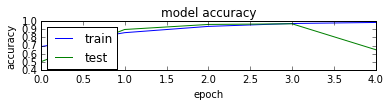

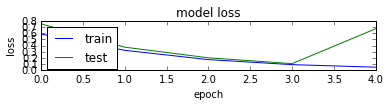

109 [  5.90410957e-04   9.99409556e-01]
acc: 64.84%
57.86% (+/- 29.56%)


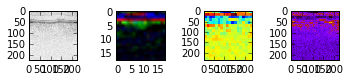

In [38]:
cv = cross_validation.KFold(4096, n_folds=32,shuffle=False,random_state=None)
for train_index, test_index in cv:
    if test_index[0]==3840 and test_index[0]<3967:
        print "The OCT Volume 31"
        pru=[]
        aba=[]
        for i in range(0,3968):
            at=all_input_3D[train_index[i]]
            pru.append(at)
        pru2=[]
        aba2=[]
        for j in range(0,128):
            at2=all_input_3D[test_index[j]]
            pru2.append(at2)
        X_tr, X_tes = np.asarray(pru), np.asarray(pru2)
        #y_tr, y_tes = np.asarray(aba), np.asarray(aba2)
        y_tr, y_tes = aba1[train_index[0:3968]],aba1[test_index[0:128]]
        print X_tr.shape, X_tes.shape, y_tr.shape, y_tes.shape
        # create model
        #model1 = Model(input=input, output=[dense3])
        #for layer in model1.layers:
        #    layer.trainable = True
        #model1 = Model(input=input, output=[dense3]
        model1.load_weights('model_OCTNET.h5')
        # Fit the model
        #model.fit(X_tr, y_tr, epochs=100, batch_size=32, verbose=1)
        checkpointer = ModelCheckpoint(filepath="/home/ojperdomoc/OCT_HES-SO/OCT_NET_31.hdf5", monitor='val_acc', verbose=1, save_best_only=True)
        history = model1.fit([X_tr], [y_tr], batch_size=batch_size, nb_epoch=nb_epochs,verbose=1,validation_data=(X_tes, y_tes),callbacks=[checkpointer])
        # evaluate the model
        bb1=model1.predict([X_tes])
        scores = model1.evaluate([X_tes], [y_tes], verbose=1)
        print('Test score:', scores[0])
        print('Test accuracy:', scores[1])
        #plt.imshow(Y_hat_mask[0].transpose(1,2,0).squeeze())
        #print('The number of OCT classified correctly are:', np.sum(bb1==label_0[test_index[0:128]]))
        #print('The test index',[test_index[0:128]][0],[test_index[0:128]][127])
        # list all data in history
        print(history.history.keys())
        ax1 = plt.subplot2grid((4,4), (0,0), colspan=4)
        # summarize history for accuracy
        plt.plot(history.history['acc'])
        plt.plot(history.history['val_acc'])
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()
        # summarize history for loss
        ax2 = plt.subplot2grid((4,4), (1,0), colspan=4)
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()
        Y_hat = conv10.eval({input: X_tes.astype('float32')})
        input2 = Input(shape=(256,18,18))
        final_conv1 = Convolution2D(1, 1, 1, activation='sigmoid')(input2)
        upsample13 = UpSampling2D(size=(13, 13), dim_ordering='th')(final_conv1)
        model_mask = Model(input=input2, output=[upsample13])
        Y_hat_mask = upsample13.eval({input2: Y_hat})
        slice_idx = random.randint(0, 127)
        #plt.figure()
        #plt.subplot(1,4,1)
        ax3 = plt.subplot2grid((4,4), (2, 0))
        plt.imshow((X_tes[slice_idx]).transpose(1,2,0))
        plt.savefig('0_'+str(test_index[0])+'.svg')
        #plt.subplot(1,4,2)
        ax4 = plt.subplot2grid((4,4), (2, 1))
        plt.imshow((Y_hat[slice_idx][0:3]).transpose(1,2,0))
        plt.savefig('1_'+str(test_index[0])+'.svg')
        #plt.subplot(1,4,3)
        ax5 = plt.subplot2grid((4,4), (2, 2))
        plt.imshow(Y_hat_mask[slice_idx].transpose(1,2,0).squeeze())
        plt.savefig('2_'+str(test_index[0])+'.svg')
        #plt.subplot(1,4,4)
        ax6 = plt.subplot2grid((4,4), (2, 3))
        mask_rsz=(Y_hat_mask[slice_idx].transpose(1,2,0).squeeze())#
        #data = imresize(np.asarray(Image.open(imaa))[:,:,0:3],scale_factor,'bicubic').astype('float32')
        mask_rsz1=imresize(mask_rsz,(224,224),'bicubic').astype('float32')
        over_all = np.zeros((224,224))
        over_all = ((X_tes[slice_idx]).transpose(1,2,0)[:,:,0])*(mask_rsz1)
        #over_all[:,:,1] = ((X_tes[slice_idx]).transpose(1,2,0)[:,:,1])*(mask_rsz1)
        #over_all[:,:,2] = ((X_tes[slice_idx]).transpose(1,2,0)[:,:,2])*(mask_rsz1)
        plt.imshow(over_all,cmap='gnuplot')
        plt.savefig('3_'+str(test_index[0])+'.svg')
        print slice_idx, bb1[slice_idx]
        print("%s: %.2f%%" % (model1.metrics_names[1], scores[1]*100))
        cvscores.append(scores[1] * 100)
        bb.append(bb1)
    else:
        test_index[0]
print("%.2f%% (+/- %.2f%%)" % (numpy.mean(cvscores), numpy.std(cvscores)))

The OCT Volume 32
(3968, 3, 224, 224) (128, 3, 224, 224) (3968, 2) (128, 2)
Train on 3968 samples, validate on 128 samples
Epoch 1/5
3968/3968 [==============================] - 63s - loss: 0.5881 - acc: 0.6893 - val_loss: 1.4425 - val_acc: 0.1172
Epoch 2/5
3968/3968 [==============================] - 70s - loss: 0.3102 - acc: 0.8657 - val_loss: 1.3742 - val_acc: 0.2188
Epoch 3/5
3968/3968 [==============================] - 70s - loss: 0.1676 - acc: 0.9312 - val_loss: 1.9620 - val_acc: 0.3281
Epoch 4/5
3968/3968 [==============================] - 68s - loss: 0.0848 - acc: 0.9693 - val_loss: 0.0207 - val_acc: 1.0000
Epoch 5/5
128/128 [==============================] - 0s     
('Test score:', 0.50010289996862411)
('Test accuracy:', 0.8515625)
['acc', 'loss', 'val_acc', 'val_loss']


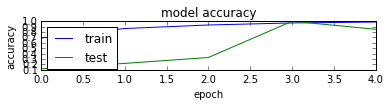

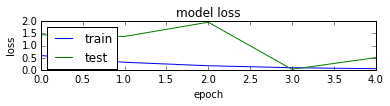

21 [ 0.00826377  0.99173623]
acc: 85.16%
58.72% (+/- 29.48%)


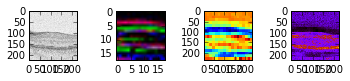

In [39]:
cv = cross_validation.KFold(4096, n_folds=32,shuffle=False,random_state=None)
for train_index, test_index in cv:
    if test_index[0]==3968:
        print "The OCT Volume 32"
        pru=[]
        aba=[]
        for i in range(0,3968):
            at=all_input_3D[train_index[i]]
            pru.append(at)
        pru2=[]
        aba2=[]
        for j in range(0,128):
            at2=all_input_3D[test_index[j]]
            pru2.append(at2)
        X_tr, X_tes = np.asarray(pru), np.asarray(pru2)
        #y_tr, y_tes = np.asarray(aba), np.asarray(aba2)
        y_tr, y_tes = aba1[train_index[0:3968]],aba1[test_index[0:128]]
        print X_tr.shape, X_tes.shape, y_tr.shape, y_tes.shape
        # create model
        #model1 = Model(input=input, output=[dense3])
        #for layer in model1.layers:
        #    layer.trainable = True
        #model1 = Model(input=input, output=[dense3]
        model1.load_weights('model_OCTNET.h5')
        # Fit the model
        #model.fit(X_tr, y_tr, epochs=100, batch_size=32, verbose=1)
        checkpointer = ModelCheckpoint(filepath="/home/ojperdomoc/OCT_HES-SO/OCT_NET_32.hdf5", monitor='val_acc', verbose=1, save_best_only=True)
        history = model1.fit([X_tr], [y_tr], batch_size=batch_size, nb_epoch=nb_epochs,verbose=1,validation_data=(X_tes, y_tes),callbacks=[checkpointer])
        # evaluate the model
        bb1=model1.predict([X_tes])
        scores = model1.evaluate([X_tes], [y_tes], verbose=1)
        print('Test score:', scores[0])
        print('Test accuracy:', scores[1])
        #plt.imshow(Y_hat_mask[0].transpose(1,2,0).squeeze())
        #print('The number of OCT classified correctly are:', np.sum(bb1==label_0[test_index[0:128]]))
        #print('The test index',[test_index[0:128]][0],[test_index[0:128]][127])
        # list all data in history
        print(history.history.keys())
        ax1 = plt.subplot2grid((4,4), (0,0), colspan=4)
        # summarize history for accuracy
        plt.plot(history.history['acc'])
        plt.plot(history.history['val_acc'])
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()
        # summarize history for loss
        ax2 = plt.subplot2grid((4,4), (1,0), colspan=4)
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()
        Y_hat = conv10.eval({input: X_tes.astype('float32')})
        input2 = Input(shape=(256,18,18))
        final_conv1 = Convolution2D(1, 1, 1, activation='sigmoid')(input2)
        upsample13 = UpSampling2D(size=(13, 13), dim_ordering='th')(final_conv1)
        model_mask = Model(input=input2, output=[upsample13])
        Y_hat_mask = upsample13.eval({input2: Y_hat})
        slice_idx = random.randint(0, 127)
        #plt.figure()
        #plt.subplot(1,4,1)
        ax3 = plt.subplot2grid((4,4), (2, 0))
        plt.imshow((X_tes[slice_idx]).transpose(1,2,0))
        plt.savefig('0_'+str(test_index[0])+'.svg')
        #plt.subplot(1,4,2)
        ax4 = plt.subplot2grid((4,4), (2, 1))
        plt.imshow((Y_hat[slice_idx][0:3]).transpose(1,2,0))
        plt.savefig('1_'+str(test_index[0])+'.svg')
        #plt.subplot(1,4,3)
        ax5 = plt.subplot2grid((4,4), (2, 2))
        plt.imshow(Y_hat_mask[slice_idx].transpose(1,2,0).squeeze())
        plt.savefig('2_'+str(test_index[0])+'.svg')
        #plt.subplot(1,4,4)
        ax6 = plt.subplot2grid((4,4), (2, 3))
        mask_rsz=(Y_hat_mask[slice_idx].transpose(1,2,0).squeeze())#
        #data = imresize(np.asarray(Image.open(imaa))[:,:,0:3],scale_factor,'bicubic').astype('float32')
        mask_rsz1=imresize(mask_rsz,(224,224),'bicubic').astype('float32')
        over_all = np.zeros((224,224))
        over_all = ((X_tes[slice_idx]).transpose(1,2,0)[:,:,0])*(mask_rsz1)
        #over_all[:,:,1] = ((X_tes[slice_idx]).transpose(1,2,0)[:,:,1])*(mask_rsz1)
        #over_all[:,:,2] = ((X_tes[slice_idx]).transpose(1,2,0)[:,:,2])*(mask_rsz1)
        plt.imshow(over_all,cmap='gnuplot')
        plt.savefig('3_'+str(test_index[0])+'.svg')
        print slice_idx, bb1[slice_idx]
        print("%s: %.2f%%" % (model1.metrics_names[1], scores[1]*100))
        cvscores.append(scores[1] * 100)
        bb.append(bb1)
    else:
        test_index[0]
print("%.2f%% (+/- %.2f%%)" % (numpy.mean(cvscores), numpy.std(cvscores)))